In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_strike(description):
        return 1 if description in ['foul_bunt', 'swinging_strike', 'foul', 'called_strike', 'foul_tip',
                                    'swinging_strike_blocked', 'missed_bunt', 'bunt_foul_tip'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_called(description):
        return 1 if description in ['called_strike'] else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['strike'] = df['description'].apply(is_strike)


    df['called_strike'] = df['description'].apply(is_called)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('strike == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [9]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [10]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [11]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [13]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [14]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [15]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7108120927678059
Log Loss: 0.5790095639297926


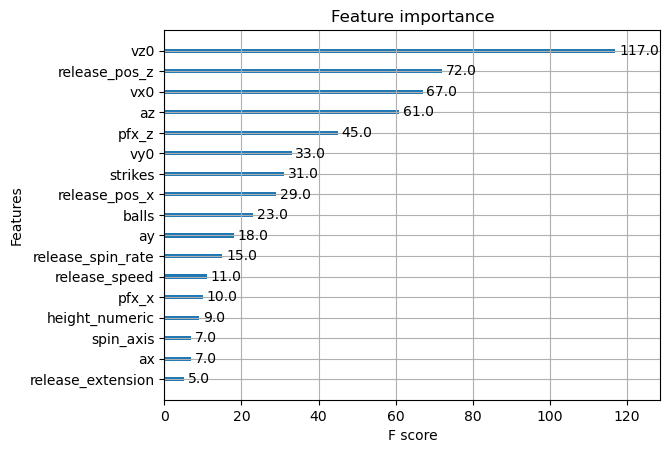

In [16]:
xgb.plot_importance(model)
plt.show()

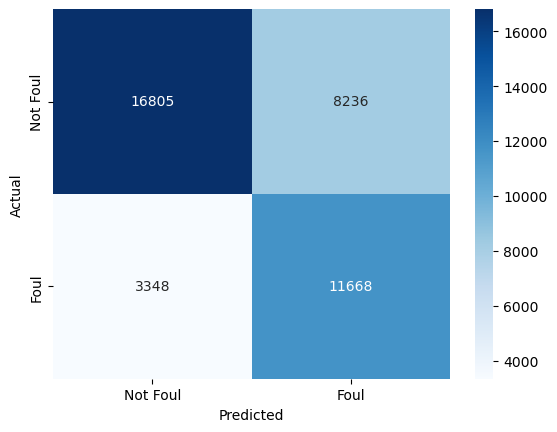

In [17]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [18]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [19]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 17:42:05,376] A new study created in memory with name: no-name-5570f4e3-188f-45db-bcf6-3aa4b2c008fe


[0]	eval-logloss:0.64519
[1]	eval-logloss:0.61431
[2]	eval-logloss:0.60329
[3]	eval-logloss:0.59493
[4]	eval-logloss:0.58250
[5]	eval-logloss:0.57427
[6]	eval-logloss:0.56869
[7]	eval-logloss:0.56634
[8]	eval-logloss:0.56200
[9]	eval-logloss:0.55881
[10]	eval-logloss:0.55584
[11]	eval-logloss:0.55343
[12]	eval-logloss:0.55138
[13]	eval-logloss:0.54930
[14]	eval-logloss:0.54688
[15]	eval-logloss:0.54514
[16]	eval-logloss:0.54400
[17]	eval-logloss:0.54231
[18]	eval-logloss:0.54108
[19]	eval-logloss:0.53977
[20]	eval-logloss:0.53916
[21]	eval-logloss:0.53856
[22]	eval-logloss:0.53769
[23]	eval-logloss:0.53658
[24]	eval-logloss:0.53611
[25]	eval-logloss:0.53554
[26]	eval-logloss:0.53510
[27]	eval-logloss:0.53437
[28]	eval-logloss:0.53425
[29]	eval-logloss:0.53388
[30]	eval-logloss:0.53347
[31]	eval-logloss:0.53304
[32]	eval-logloss:0.53256
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.53189
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52867
[37]	eval-logloss:0.52768
[38]	eval-logloss:0.52

[I 2023-11-09 17:42:06,896] Trial 0 finished with value: 0.5136923468010641 and parameters: {'max_depth': 4, 'eta': 0.29103568762711574, 'subsample': 0.8119227420097741, 'colsample_bytree': 0.5791639066914733}. Best is trial 0 with value: 0.5136923468010641.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65784
[3]	eval-logloss:0.65107
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62302
[7]	eval-logloss:0.61758
[8]	eval-logloss:0.60985
[9]	eval-logloss:0.60266
[10]	eval-logloss:0.59580
[11]	eval-logloss:0.59093
[12]	eval-logloss:0.58572
[13]	eval-logloss:0.58215
[14]	eval-logloss:0.57737
[15]	eval-logloss:0.57363
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56303
[19]	eval-logloss:0.56080
[20]	eval-logloss:0.55877
[21]	eval-logloss:0.55675
[22]	eval-logloss:0.55403
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.55109
[25]	eval-logloss:0.54970
[26]	eval-logloss:0.54789
[27]	eval-logloss:0.54581
[28]	eval-logloss:0.54452
[29]	eval-logloss:0.54330
[30]	eval-logloss:0.54224
[31]	eval-logloss:0.54077
[32]	eval-logloss:0.53938
[33]	eval-logloss:0.53797
[34]	eval-logloss:0.53675
[35]	eval-logloss:0.53566
[36]	eval-logloss:0.53538
[37]	eval-logloss:0.53416
[38]	eval-logloss:0.53

[I 2023-11-09 17:42:09,794] Trial 1 finished with value: 0.5116329434045985 and parameters: {'max_depth': 9, 'eta': 0.06281828752827215, 'subsample': 0.7536120995140809, 'colsample_bytree': 0.6210824613223344}. Best is trial 0 with value: 0.5136923468010641.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.66153
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.63757
[4]	eval-logloss:0.62187
[5]	eval-logloss:0.60697
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.59482
[8]	eval-logloss:0.58744
[9]	eval-logloss:0.58120
[10]	eval-logloss:0.57261
[11]	eval-logloss:0.56738
[12]	eval-logloss:0.56195
[13]	eval-logloss:0.56106
[14]	eval-logloss:0.55704
[15]	eval-logloss:0.55307
[16]	eval-logloss:0.54976
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54284
[19]	eval-logloss:0.54045
[20]	eval-logloss:0.53932
[21]	eval-logloss:0.53819
[22]	eval-logloss:0.53665
[23]	eval-logloss:0.53500
[24]	eval-logloss:0.53393
[25]	eval-logloss:0.53322
[26]	eval-logloss:0.53254
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.53090
[29]	eval-logloss:0.53081
[30]	eval-logloss:0.52957
[31]	eval-logloss:0.52843
[32]	eval-logloss:0.52776
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52659
[35]	eval-logloss:0.52492
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52436
[38]	eval-logloss:0.52

[I 2023-11-09 17:42:11,947] Trial 2 finished with value: 0.5085060211618603 and parameters: {'max_depth': 8, 'eta': 0.12839126914305724, 'subsample': 0.852996203725673, 'colsample_bytree': 0.5387516145654327}. Best is trial 0 with value: 0.5136923468010641.


[0]	eval-logloss:0.64147
[1]	eval-logloss:0.60976
[2]	eval-logloss:0.59595
[3]	eval-logloss:0.57803
[4]	eval-logloss:0.56590
[5]	eval-logloss:0.55851
[6]	eval-logloss:0.55248
[7]	eval-logloss:0.54817
[8]	eval-logloss:0.54478
[9]	eval-logloss:0.54171
[10]	eval-logloss:0.53873
[11]	eval-logloss:0.53703
[12]	eval-logloss:0.53533
[13]	eval-logloss:0.53381
[14]	eval-logloss:0.53135
[15]	eval-logloss:0.52965
[16]	eval-logloss:0.52837
[17]	eval-logloss:0.52645
[18]	eval-logloss:0.52513
[19]	eval-logloss:0.52287
[20]	eval-logloss:0.52268
[21]	eval-logloss:0.52207
[22]	eval-logloss:0.52121
[23]	eval-logloss:0.52079
[24]	eval-logloss:0.51924
[25]	eval-logloss:0.51913
[26]	eval-logloss:0.51899
[27]	eval-logloss:0.51848
[28]	eval-logloss:0.51732
[29]	eval-logloss:0.51595
[30]	eval-logloss:0.51462
[31]	eval-logloss:0.51443
[32]	eval-logloss:0.51431
[33]	eval-logloss:0.51396
[34]	eval-logloss:0.51382
[35]	eval-logloss:0.51345
[36]	eval-logloss:0.51248
[37]	eval-logloss:0.51226
[38]	eval-logloss:0.51

[I 2023-11-09 17:42:13,955] Trial 3 finished with value: 0.5111189648135022 and parameters: {'max_depth': 7, 'eta': 0.2399756391449331, 'subsample': 0.6647749765568876, 'colsample_bytree': 0.7300393624079389}. Best is trial 0 with value: 0.5136923468010641.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.65945
[4]	eval-logloss:0.65153
[5]	eval-logloss:0.64436
[6]	eval-logloss:0.63754
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62604
[9]	eval-logloss:0.62044
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.61062
[12]	eval-logloss:0.60618
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.59946
[15]	eval-logloss:0.59604
[16]	eval-logloss:0.59248
[17]	eval-logloss:0.58916
[18]	eval-logloss:0.58603
[19]	eval-logloss:0.58311
[20]	eval-logloss:0.58044
[21]	eval-logloss:0.57812
[22]	eval-logloss:0.57568
[23]	eval-logloss:0.57403
[24]	eval-logloss:0.57194
[25]	eval-logloss:0.56999
[26]	eval-logloss:0.56822
[27]	eval-logloss:0.56643
[28]	eval-logloss:0.56545
[29]	eval-logloss:0.56363
[30]	eval-logloss:0.56254
[31]	eval-logloss:0.56095
[32]	eval-logloss:0.55940
[33]	eval-logloss:0.55792
[34]	eval-logloss:0.55656
[35]	eval-logloss:0.55519
[36]	eval-logloss:0.55451
[37]	eval-logloss:0.55332
[38]	eval-logloss:0.55

[I 2023-11-09 17:42:16,449] Trial 4 finished with value: 0.5234602713285901 and parameters: {'max_depth': 7, 'eta': 0.04361707092484012, 'subsample': 0.8034208547862671, 'colsample_bytree': 0.877257294436172}. Best is trial 4 with value: 0.5234602713285901.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66423
[3]	eval-logloss:0.65901
[4]	eval-logloss:0.65056
[5]	eval-logloss:0.64209
[6]	eval-logloss:0.63421
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62225
[9]	eval-logloss:0.61600
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60538
[12]	eval-logloss:0.60074
[13]	eval-logloss:0.59804
[14]	eval-logloss:0.59379
[15]	eval-logloss:0.59030
[16]	eval-logloss:0.58702
[17]	eval-logloss:0.58364
[18]	eval-logloss:0.58137
[19]	eval-logloss:0.57941
[20]	eval-logloss:0.57731
[21]	eval-logloss:0.57514
[22]	eval-logloss:0.57255
[23]	eval-logloss:0.57161
[24]	eval-logloss:0.56964
[25]	eval-logloss:0.56812
[26]	eval-logloss:0.56627
[27]	eval-logloss:0.56417
[28]	eval-logloss:0.56291
[29]	eval-logloss:0.56151
[30]	eval-logloss:0.56064
[31]	eval-logloss:0.55904
[32]	eval-logloss:0.55763
[33]	eval-logloss:0.55626
[34]	eval-logloss:0.55488
[35]	eval-logloss:0.55383
[36]	eval-logloss:0.55356
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.55

[I 2023-11-09 17:42:18,452] Trial 5 finished with value: 0.526252393864975 and parameters: {'max_depth': 6, 'eta': 0.05770859801239691, 'subsample': 0.6974453874291813, 'colsample_bytree': 0.6623911844979937}. Best is trial 5 with value: 0.526252393864975.


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.63673
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.61484
[4]	eval-logloss:0.60147
[5]	eval-logloss:0.58919
[6]	eval-logloss:0.57950
[7]	eval-logloss:0.57463
[8]	eval-logloss:0.56829
[9]	eval-logloss:0.56251
[10]	eval-logloss:0.55719
[11]	eval-logloss:0.55385
[12]	eval-logloss:0.55053
[13]	eval-logloss:0.54764
[14]	eval-logloss:0.54467
[15]	eval-logloss:0.54254
[16]	eval-logloss:0.54075
[17]	eval-logloss:0.53845
[18]	eval-logloss:0.53611
[19]	eval-logloss:0.53425
[20]	eval-logloss:0.53352
[21]	eval-logloss:0.53250
[22]	eval-logloss:0.53169
[23]	eval-logloss:0.53055
[24]	eval-logloss:0.52978
[25]	eval-logloss:0.52936
[26]	eval-logloss:0.52862
[27]	eval-logloss:0.52769
[28]	eval-logloss:0.52746
[29]	eval-logloss:0.52725
[30]	eval-logloss:0.52565
[31]	eval-logloss:0.52509
[32]	eval-logloss:0.52460
[33]	eval-logloss:0.52434
[34]	eval-logloss:0.52352
[35]	eval-logloss:0.52259
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52164
[38]	eval-logloss:0.52

[I 2023-11-09 17:42:20,656] Trial 6 finished with value: 0.5071826835272953 and parameters: {'max_depth': 7, 'eta': 0.15104694174871616, 'subsample': 0.8869105513286297, 'colsample_bytree': 0.568706334806216}. Best is trial 5 with value: 0.526252393864975.


[0]	eval-logloss:0.65413
[1]	eval-logloss:0.62823
[2]	eval-logloss:0.62061
[3]	eval-logloss:0.61387
[4]	eval-logloss:0.60087
[5]	eval-logloss:0.59159
[6]	eval-logloss:0.58503
[7]	eval-logloss:0.58144
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.57469
[10]	eval-logloss:0.57137
[11]	eval-logloss:0.56887
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56587
[14]	eval-logloss:0.56376
[15]	eval-logloss:0.56227
[16]	eval-logloss:0.56074
[17]	eval-logloss:0.55930
[18]	eval-logloss:0.55704
[19]	eval-logloss:0.55567
[20]	eval-logloss:0.55511
[21]	eval-logloss:0.55420
[22]	eval-logloss:0.55256
[23]	eval-logloss:0.55173
[24]	eval-logloss:0.55080
[25]	eval-logloss:0.55019
[26]	eval-logloss:0.54938
[27]	eval-logloss:0.54804
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54714
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54543
[32]	eval-logloss:0.54513
[33]	eval-logloss:0.54513
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54231
[36]	eval-logloss:0.54231
[37]	eval-logloss:0.54124
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:22,094] Trial 7 finished with value: 0.5271204722827805 and parameters: {'max_depth': 3, 'eta': 0.23666249937737077, 'subsample': 0.6704516413855662, 'colsample_bytree': 0.5711604455358834}. Best is trial 7 with value: 0.5271204722827805.


[0]	eval-logloss:0.66350
[1]	eval-logloss:0.64014
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.59915
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.57913
[7]	eval-logloss:0.57195
[8]	eval-logloss:0.56592
[9]	eval-logloss:0.56014
[10]	eval-logloss:0.55539
[11]	eval-logloss:0.55181
[12]	eval-logloss:0.54854
[13]	eval-logloss:0.54604
[14]	eval-logloss:0.54333
[15]	eval-logloss:0.54071
[16]	eval-logloss:0.53859
[17]	eval-logloss:0.53687
[18]	eval-logloss:0.53522
[19]	eval-logloss:0.53391
[20]	eval-logloss:0.53272
[21]	eval-logloss:0.53147
[22]	eval-logloss:0.53051
[23]	eval-logloss:0.52971
[24]	eval-logloss:0.52892
[25]	eval-logloss:0.52780
[26]	eval-logloss:0.52717
[27]	eval-logloss:0.52664
[28]	eval-logloss:0.52533
[29]	eval-logloss:0.52460
[30]	eval-logloss:0.52358
[31]	eval-logloss:0.52309
[32]	eval-logloss:0.52257
[33]	eval-logloss:0.52185
[34]	eval-logloss:0.52117
[35]	eval-logloss:0.52067
[36]	eval-logloss:0.52008
[37]	eval-logloss:0.51920
[38]	eval-logloss:0.51

[I 2023-11-09 17:42:24,407] Trial 8 finished with value: 0.50488810959947 and parameters: {'max_depth': 8, 'eta': 0.12321007043597047, 'subsample': 0.7513387432146207, 'colsample_bytree': 0.8846989645495504}. Best is trial 7 with value: 0.5271204722827805.


[0]	eval-logloss:0.64953
[1]	eval-logloss:0.62257
[2]	eval-logloss:0.61235
[3]	eval-logloss:0.59739
[4]	eval-logloss:0.58685
[5]	eval-logloss:0.57919
[6]	eval-logloss:0.57447
[7]	eval-logloss:0.56957
[8]	eval-logloss:0.56580
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.56009
[11]	eval-logloss:0.55708
[12]	eval-logloss:0.55503
[13]	eval-logloss:0.55235
[14]	eval-logloss:0.55045
[15]	eval-logloss:0.54785
[16]	eval-logloss:0.54666
[17]	eval-logloss:0.54531
[18]	eval-logloss:0.54347
[19]	eval-logloss:0.54234
[20]	eval-logloss:0.54094
[21]	eval-logloss:0.53991
[22]	eval-logloss:0.53861
[23]	eval-logloss:0.53782
[24]	eval-logloss:0.53732
[25]	eval-logloss:0.53563
[26]	eval-logloss:0.53470
[27]	eval-logloss:0.53397
[28]	eval-logloss:0.53357
[29]	eval-logloss:0.53292
[30]	eval-logloss:0.53257
[31]	eval-logloss:0.53223
[32]	eval-logloss:0.53071
[33]	eval-logloss:0.53030
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52836
[36]	eval-logloss:0.52828
[37]	eval-logloss:0.52737
[38]	eval-logloss:0.52

[I 2023-11-09 17:42:25,907] Trial 9 finished with value: 0.5126438359346142 and parameters: {'max_depth': 4, 'eta': 0.23676775128768632, 'subsample': 0.8540386292017637, 'colsample_bytree': 0.9041699107182238}. Best is trial 7 with value: 0.5271204722827805.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.61926
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59649
[7]	eval-logloss:0.59543
[8]	eval-logloss:0.58928
[9]	eval-logloss:0.58412
[10]	eval-logloss:0.57941
[11]	eval-logloss:0.57600
[12]	eval-logloss:0.57322
[13]	eval-logloss:0.57255
[14]	eval-logloss:0.56961
[15]	eval-logloss:0.56749
[16]	eval-logloss:0.56586
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56138
[19]	eval-logloss:0.56027
[20]	eval-logloss:0.55976
[21]	eval-logloss:0.55884
[22]	eval-logloss:0.55731
[23]	eval-logloss:0.55656
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55519
[26]	eval-logloss:0.55431
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55202
[30]	eval-logloss:0.55086
[31]	eval-logloss:0.55010
[32]	eval-logloss:0.54945
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54820
[35]	eval-logloss:0.54755
[36]	eval-logloss:0.54750
[37]	eval-logloss:0.54707
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:27,339] Trial 10 finished with value: 0.5292788287871744 and parameters: {'max_depth': 3, 'eta': 0.20391950770583894, 'subsample': 0.6054509985316454, 'colsample_bytree': 0.5083921508440056}. Best is trial 10 with value: 0.5292788287871744.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.64517
[3]	eval-logloss:0.63799
[4]	eval-logloss:0.61907
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.58931
[9]	eval-logloss:0.58419
[10]	eval-logloss:0.57945
[11]	eval-logloss:0.57603
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.57238
[14]	eval-logloss:0.56947
[15]	eval-logloss:0.56737
[16]	eval-logloss:0.56564
[17]	eval-logloss:0.56346
[18]	eval-logloss:0.56144
[19]	eval-logloss:0.56016
[20]	eval-logloss:0.55901
[21]	eval-logloss:0.55830
[22]	eval-logloss:0.55715
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55486
[25]	eval-logloss:0.55422
[26]	eval-logloss:0.55335
[27]	eval-logloss:0.55197
[28]	eval-logloss:0.55131
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.55024
[31]	eval-logloss:0.54965
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54874
[34]	eval-logloss:0.54787
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54572
[37]	eval-logloss:0.54524
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:28,868] Trial 11 finished with value: 0.5287871800682074 and parameters: {'max_depth': 3, 'eta': 0.20428216162413626, 'subsample': 0.6230041878423823, 'colsample_bytree': 0.5031473960245383}. Best is trial 10 with value: 0.5292788287871744.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64152
[4]	eval-logloss:0.62336
[5]	eval-logloss:0.60985
[6]	eval-logloss:0.60056
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59323
[9]	eval-logloss:0.58777
[10]	eval-logloss:0.58275
[11]	eval-logloss:0.57934
[12]	eval-logloss:0.57633
[13]	eval-logloss:0.57564
[14]	eval-logloss:0.57284
[15]	eval-logloss:0.57074
[16]	eval-logloss:0.56893
[17]	eval-logloss:0.56638
[18]	eval-logloss:0.56366
[19]	eval-logloss:0.56221
[20]	eval-logloss:0.56148
[21]	eval-logloss:0.56065
[22]	eval-logloss:0.55932
[23]	eval-logloss:0.55801
[24]	eval-logloss:0.55712
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55510
[27]	eval-logloss:0.55356
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55259
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.55043
[32]	eval-logloss:0.54999
[33]	eval-logloss:0.54992
[34]	eval-logloss:0.54898
[35]	eval-logloss:0.54762
[36]	eval-logloss:0.54740
[37]	eval-logloss:0.54701
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:30,335] Trial 12 finished with value: 0.5294767907942377 and parameters: {'max_depth': 3, 'eta': 0.18764523031081393, 'subsample': 0.604374254184795, 'colsample_bytree': 0.5037015793539897}. Best is trial 12 with value: 0.5294767907942377.


[0]	eval-logloss:0.65869
[1]	eval-logloss:0.63105
[2]	eval-logloss:0.61952
[3]	eval-logloss:0.61119
[4]	eval-logloss:0.59716
[5]	eval-logloss:0.58584
[6]	eval-logloss:0.57780
[7]	eval-logloss:0.57342
[8]	eval-logloss:0.56702
[9]	eval-logloss:0.56206
[10]	eval-logloss:0.55819
[11]	eval-logloss:0.55597
[12]	eval-logloss:0.55376
[13]	eval-logloss:0.55126
[14]	eval-logloss:0.54916
[15]	eval-logloss:0.54653
[16]	eval-logloss:0.54495
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.54156
[19]	eval-logloss:0.54013
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53891
[22]	eval-logloss:0.53768
[23]	eval-logloss:0.53678
[24]	eval-logloss:0.53620
[25]	eval-logloss:0.53578
[26]	eval-logloss:0.53531
[27]	eval-logloss:0.53431
[28]	eval-logloss:0.53259
[29]	eval-logloss:0.53204
[30]	eval-logloss:0.53094
[31]	eval-logloss:0.53007
[32]	eval-logloss:0.52974
[33]	eval-logloss:0.52941
[34]	eval-logloss:0.52892
[35]	eval-logloss:0.52716
[36]	eval-logloss:0.52563
[37]	eval-logloss:0.52520
[38]	eval-logloss:0.52

[I 2023-11-09 17:42:32,148] Trial 13 finished with value: 0.5118820506241187 and parameters: {'max_depth': 5, 'eta': 0.1889295772520785, 'subsample': 0.6035515497533794, 'colsample_bytree': 0.6724151501508477}. Best is trial 12 with value: 0.5294767907942377.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.60515
[6]	eval-logloss:0.59540
[7]	eval-logloss:0.59432
[8]	eval-logloss:0.58788
[9]	eval-logloss:0.58249
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57180
[12]	eval-logloss:0.56871
[13]	eval-logloss:0.56813
[14]	eval-logloss:0.56508
[15]	eval-logloss:0.56270
[16]	eval-logloss:0.56043
[17]	eval-logloss:0.55720
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55247
[20]	eval-logloss:0.55166
[21]	eval-logloss:0.55079
[22]	eval-logloss:0.54955
[23]	eval-logloss:0.54838
[24]	eval-logloss:0.54762
[25]	eval-logloss:0.54702
[26]	eval-logloss:0.54606
[27]	eval-logloss:0.54494
[28]	eval-logloss:0.54436
[29]	eval-logloss:0.54421
[30]	eval-logloss:0.54291
[31]	eval-logloss:0.54192
[32]	eval-logloss:0.54150
[33]	eval-logloss:0.54128
[34]	eval-logloss:0.54045
[35]	eval-logloss:0.53896
[36]	eval-logloss:0.53876
[37]	eval-logloss:0.53786
[38]	eval-logloss:0.53

[I 2023-11-09 17:42:33,721] Trial 14 finished with value: 0.5222041430111108 and parameters: {'max_depth': 4, 'eta': 0.18164461447796426, 'subsample': 0.6001458632218826, 'colsample_bytree': 0.519193712103224}. Best is trial 12 with value: 0.5294767907942377.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66700
[3]	eval-logloss:0.66229
[4]	eval-logloss:0.64932
[5]	eval-logloss:0.63807
[6]	eval-logloss:0.62899
[7]	eval-logloss:0.62828
[8]	eval-logloss:0.62140
[9]	eval-logloss:0.61503
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60405
[12]	eval-logloss:0.59952
[13]	eval-logloss:0.59876
[14]	eval-logloss:0.59503
[15]	eval-logloss:0.59198
[16]	eval-logloss:0.58927
[17]	eval-logloss:0.58671
[18]	eval-logloss:0.58447
[19]	eval-logloss:0.58258
[20]	eval-logloss:0.58101
[21]	eval-logloss:0.57948
[22]	eval-logloss:0.57777
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57549
[25]	eval-logloss:0.57446
[26]	eval-logloss:0.57326
[27]	eval-logloss:0.57185
[28]	eval-logloss:0.57139
[29]	eval-logloss:0.57095
[30]	eval-logloss:0.56975
[31]	eval-logloss:0.56858
[32]	eval-logloss:0.56761
[33]	eval-logloss:0.56726
[34]	eval-logloss:0.56608
[35]	eval-logloss:0.56527
[36]	eval-logloss:0.56502
[37]	eval-logloss:0.56430
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:35,128] Trial 15 finished with value: 0.5399986883731983 and parameters: {'max_depth': 3, 'eta': 0.09918205390330748, 'subsample': 0.6445095918922996, 'colsample_bytree': 0.5106061742265824}. Best is trial 15 with value: 0.5399986883731983.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.65753
[2]	eval-logloss:0.65075
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62277
[6]	eval-logloss:0.61371
[7]	eval-logloss:0.60792
[8]	eval-logloss:0.60097
[9]	eval-logloss:0.59481
[10]	eval-logloss:0.58939
[11]	eval-logloss:0.58503
[12]	eval-logloss:0.58107
[13]	eval-logloss:0.57833
[14]	eval-logloss:0.57480
[15]	eval-logloss:0.57190
[16]	eval-logloss:0.56946
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56440
[19]	eval-logloss:0.56231
[20]	eval-logloss:0.56085
[21]	eval-logloss:0.55937
[22]	eval-logloss:0.55747
[23]	eval-logloss:0.55652
[24]	eval-logloss:0.55528
[25]	eval-logloss:0.55437
[26]	eval-logloss:0.55328
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55059
[29]	eval-logloss:0.54962
[30]	eval-logloss:0.54837
[31]	eval-logloss:0.54745
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54573
[34]	eval-logloss:0.54480
[35]	eval-logloss:0.54419
[36]	eval-logloss:0.54389
[37]	eval-logloss:0.54313
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:36,816] Trial 16 finished with value: 0.5224850507045035 and parameters: {'max_depth': 5, 'eta': 0.09532684845584151, 'subsample': 0.6478999556071238, 'colsample_bytree': 0.6268390042710351}. Best is trial 15 with value: 0.5399986883731983.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68512
[4]	eval-logloss:0.68288
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67667
[8]	eval-logloss:0.67469
[9]	eval-logloss:0.67266
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.66883
[12]	eval-logloss:0.66696
[13]	eval-logloss:0.66605
[14]	eval-logloss:0.66425
[15]	eval-logloss:0.66260
[16]	eval-logloss:0.66086
[17]	eval-logloss:0.65910
[18]	eval-logloss:0.65838
[19]	eval-logloss:0.65756
[20]	eval-logloss:0.65617
[21]	eval-logloss:0.65470
[22]	eval-logloss:0.65306
[23]	eval-logloss:0.65226
[24]	eval-logloss:0.65075
[25]	eval-logloss:0.64943
[26]	eval-logloss:0.64791
[27]	eval-logloss:0.64641
[28]	eval-logloss:0.64596
[29]	eval-logloss:0.64462
[30]	eval-logloss:0.64419
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64134
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.63868
[35]	eval-logloss:0.63737
[36]	eval-logloss:0.63698
[37]	eval-logloss:0.63566
[38]	eval-logloss:0.63

[I 2023-11-09 17:42:38,713] Trial 17 finished with value: 0.5915327556738937 and parameters: {'max_depth': 5, 'eta': 0.01070421244481666, 'subsample': 0.6975111661512874, 'colsample_bytree': 0.7760156075700794}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67771
[7]	eval-logloss:0.67561
[8]	eval-logloss:0.67351
[9]	eval-logloss:0.67137
[10]	eval-logloss:0.66928
[11]	eval-logloss:0.66727
[12]	eval-logloss:0.66530
[13]	eval-logloss:0.66436
[14]	eval-logloss:0.66248
[15]	eval-logloss:0.66075
[16]	eval-logloss:0.65890
[17]	eval-logloss:0.65706
[18]	eval-logloss:0.65532
[19]	eval-logloss:0.65446
[20]	eval-logloss:0.65277
[21]	eval-logloss:0.65122
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64871
[24]	eval-logloss:0.64709
[25]	eval-logloss:0.64574
[26]	eval-logloss:0.64418
[27]	eval-logloss:0.64265
[28]	eval-logloss:0.64219
[29]	eval-logloss:0.64069
[30]	eval-logloss:0.64025
[31]	eval-logloss:0.63879
[32]	eval-logloss:0.63736
[33]	eval-logloss:0.63599
[34]	eval-logloss:0.63467
[35]	eval-logloss:0.63335
[36]	eval-logloss:0.63291
[37]	eval-logloss:0.63158
[38]	eval-logloss:0.63

[I 2023-11-09 17:42:40,447] Trial 18 finished with value: 0.5859308173013683 and parameters: {'max_depth': 5, 'eta': 0.01141170876311126, 'subsample': 0.7054483551307238, 'colsample_bytree': 0.7967473395052024}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67467
[8]	eval-logloss:0.67248
[9]	eval-logloss:0.67024
[10]	eval-logloss:0.66806
[11]	eval-logloss:0.66595
[12]	eval-logloss:0.66391
[13]	eval-logloss:0.66291
[14]	eval-logloss:0.66096
[15]	eval-logloss:0.65916
[16]	eval-logloss:0.65722
[17]	eval-logloss:0.65532
[18]	eval-logloss:0.65352
[19]	eval-logloss:0.65263
[20]	eval-logloss:0.65088
[21]	eval-logloss:0.64928
[22]	eval-logloss:0.64755
[23]	eval-logloss:0.64669
[24]	eval-logloss:0.64503
[25]	eval-logloss:0.64364
[26]	eval-logloss:0.64204
[27]	eval-logloss:0.64046
[28]	eval-logloss:0.63998
[29]	eval-logloss:0.63846
[30]	eval-logloss:0.63800
[31]	eval-logloss:0.63650
[32]	eval-logloss:0.63503
[33]	eval-logloss:0.63363
[34]	eval-logloss:0.63228
[35]	eval-logloss:0.63092
[36]	eval-logloss:0.63051
[37]	eval-logloss:0.62916
[38]	eval-logloss:0.62

[I 2023-11-09 17:42:42,185] Trial 19 finished with value: 0.5832332600368128 and parameters: {'max_depth': 5, 'eta': 0.012058776346772073, 'subsample': 0.7112976459323855, 'colsample_bytree': 0.8198657470600312}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67414
[6]	eval-logloss:0.67103
[7]	eval-logloss:0.66797
[8]	eval-logloss:0.66503
[9]	eval-logloss:0.66217
[10]	eval-logloss:0.65937
[11]	eval-logloss:0.65668
[12]	eval-logloss:0.65406
[13]	eval-logloss:0.65271
[14]	eval-logloss:0.65018
[15]	eval-logloss:0.64774
[16]	eval-logloss:0.64534
[17]	eval-logloss:0.64303
[18]	eval-logloss:0.64081
[19]	eval-logloss:0.63859
[20]	eval-logloss:0.63646
[21]	eval-logloss:0.63441
[22]	eval-logloss:0.63238
[23]	eval-logloss:0.63125
[24]	eval-logloss:0.62932
[25]	eval-logloss:0.62739
[26]	eval-logloss:0.62554
[27]	eval-logloss:0.62373
[28]	eval-logloss:0.62196
[29]	eval-logloss:0.62026
[30]	eval-logloss:0.61858
[31]	eval-logloss:0.61695
[32]	eval-logloss:0.61536
[33]	eval-logloss:0.61376
[34]	eval-logloss:0.61227
[35]	eval-logloss:0.61082
[36]	eval-logloss:0.60939
[37]	eval-logloss:0.60797
[38]	eval-logloss:0.60

[I 2023-11-09 17:42:44,065] Trial 20 finished with value: 0.5612285924482198 and parameters: {'max_depth': 6, 'eta': 0.015701914243405182, 'subsample': 0.7131623930844673, 'colsample_bytree': 0.9629104894177646}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67474
[7]	eval-logloss:0.67226
[8]	eval-logloss:0.66983
[9]	eval-logloss:0.66735
[10]	eval-logloss:0.66492
[11]	eval-logloss:0.66260
[12]	eval-logloss:0.66035
[13]	eval-logloss:0.65923
[14]	eval-logloss:0.65709
[15]	eval-logloss:0.65511
[16]	eval-logloss:0.65302
[17]	eval-logloss:0.65096
[18]	eval-logloss:0.64899
[19]	eval-logloss:0.64802
[20]	eval-logloss:0.64613
[21]	eval-logloss:0.64439
[22]	eval-logloss:0.64255
[23]	eval-logloss:0.64163
[24]	eval-logloss:0.63984
[25]	eval-logloss:0.63836
[26]	eval-logloss:0.63666
[27]	eval-logloss:0.63498
[28]	eval-logloss:0.63446
[29]	eval-logloss:0.63284
[30]	eval-logloss:0.63235
[31]	eval-logloss:0.63075
[32]	eval-logloss:0.62921
[33]	eval-logloss:0.62776
[34]	eval-logloss:0.62631
[35]	eval-logloss:0.62489
[36]	eval-logloss:0.62444
[37]	eval-logloss:0.62303
[38]	eval-logloss:0.62

[I 2023-11-09 17:42:45,971] Trial 21 finished with value: 0.5768076253513631 and parameters: {'max_depth': 5, 'eta': 0.01377918157419055, 'subsample': 0.7239111370295102, 'colsample_bytree': 0.7976331743439655}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67701
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67040
[10]	eval-logloss:0.66822
[11]	eval-logloss:0.66612
[12]	eval-logloss:0.66409
[13]	eval-logloss:0.66309
[14]	eval-logloss:0.66115
[15]	eval-logloss:0.65936
[16]	eval-logloss:0.65745
[17]	eval-logloss:0.65557
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65117
[21]	eval-logloss:0.64958
[22]	eval-logloss:0.64785
[23]	eval-logloss:0.64699
[24]	eval-logloss:0.64532
[25]	eval-logloss:0.64393
[26]	eval-logloss:0.64233
[27]	eval-logloss:0.64076
[28]	eval-logloss:0.64029
[29]	eval-logloss:0.63876
[30]	eval-logloss:0.63830
[31]	eval-logloss:0.63681
[32]	eval-logloss:0.63534
[33]	eval-logloss:0.63395
[34]	eval-logloss:0.63259
[35]	eval-logloss:0.63124
[36]	eval-logloss:0.63080
[37]	eval-logloss:0.62945
[38]	eval-logloss:0.62

[I 2023-11-09 17:42:47,909] Trial 22 finished with value: 0.5834976847265956 and parameters: {'max_depth': 5, 'eta': 0.011982613411507026, 'subsample': 0.6908425400752264, 'colsample_bytree': 0.7922507082582485}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66862
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65253
[5]	eval-logloss:0.64551
[6]	eval-logloss:0.63913
[7]	eval-logloss:0.63337
[8]	eval-logloss:0.62783
[9]	eval-logloss:0.62250
[10]	eval-logloss:0.61747
[11]	eval-logloss:0.61320
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60291
[15]	eval-logloss:0.59949
[16]	eval-logloss:0.59620
[17]	eval-logloss:0.59293
[18]	eval-logloss:0.59097
[19]	eval-logloss:0.58910
[20]	eval-logloss:0.58687
[21]	eval-logloss:0.58464
[22]	eval-logloss:0.58216
[23]	eval-logloss:0.58062
[24]	eval-logloss:0.57849
[25]	eval-logloss:0.57682
[26]	eval-logloss:0.57493
[27]	eval-logloss:0.57304
[28]	eval-logloss:0.57206
[29]	eval-logloss:0.57033
[30]	eval-logloss:0.56956
[31]	eval-logloss:0.56781
[32]	eval-logloss:0.56628
[33]	eval-logloss:0.56478
[34]	eval-logloss:0.56330
[35]	eval-logloss:0.56186
[36]	eval-logloss:0.56122
[37]	eval-logloss:0.55993
[38]	eval-logloss:0.55

[I 2023-11-09 17:42:49,809] Trial 23 finished with value: 0.5300655377432727 and parameters: {'max_depth': 6, 'eta': 0.04520192737621147, 'subsample': 0.678854772065149, 'colsample_bytree': 0.7497454322047766}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67598
[3]	eval-logloss:0.66969
[4]	eval-logloss:0.66374
[5]	eval-logloss:0.65828
[6]	eval-logloss:0.65320
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.63969
[10]	eval-logloss:0.63561
[11]	eval-logloss:0.63178
[12]	eval-logloss:0.62831
[13]	eval-logloss:0.62652
[14]	eval-logloss:0.62327
[15]	eval-logloss:0.62029
[16]	eval-logloss:0.61735
[17]	eval-logloss:0.61457
[18]	eval-logloss:0.61198
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60831
[21]	eval-logloss:0.60618
[22]	eval-logloss:0.60402
[23]	eval-logloss:0.60285
[24]	eval-logloss:0.60085
[25]	eval-logloss:0.59912
[26]	eval-logloss:0.59734
[27]	eval-logloss:0.59560
[28]	eval-logloss:0.59481
[29]	eval-logloss:0.59316
[30]	eval-logloss:0.59248
[31]	eval-logloss:0.59096
[32]	eval-logloss:0.58955
[33]	eval-logloss:0.58817
[34]	eval-logloss:0.58681
[35]	eval-logloss:0.58556
[36]	eval-logloss:0.58500
[37]	eval-logloss:0.58386
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:51,299] Trial 24 finished with value: 0.5507374580497246 and parameters: {'max_depth': 4, 'eta': 0.03627558579134087, 'subsample': 0.690066097372017, 'colsample_bytree': 0.7914976073182411}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66239
[2]	eval-logloss:0.65627
[3]	eval-logloss:0.64485
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.62589
[6]	eval-logloss:0.61843
[7]	eval-logloss:0.61188
[8]	eval-logloss:0.60579
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59527
[11]	eval-logloss:0.59107
[12]	eval-logloss:0.58743
[13]	eval-logloss:0.58495
[14]	eval-logloss:0.58142
[15]	eval-logloss:0.57836
[16]	eval-logloss:0.57560
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57086
[19]	eval-logloss:0.56879
[20]	eval-logloss:0.56676
[21]	eval-logloss:0.56511
[22]	eval-logloss:0.56333
[23]	eval-logloss:0.56188
[24]	eval-logloss:0.56044
[25]	eval-logloss:0.55943
[26]	eval-logloss:0.55827
[27]	eval-logloss:0.55703
[28]	eval-logloss:0.55566
[29]	eval-logloss:0.55432
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55219
[32]	eval-logloss:0.55134
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.54944
[35]	eval-logloss:0.54868
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:52,767] Trial 25 finished with value: 0.524068118639755 and parameters: {'max_depth': 5, 'eta': 0.07688595496520244, 'subsample': 0.7347299219478086, 'colsample_bytree': 0.826620105847288}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67621
[3]	eval-logloss:0.67297
[4]	eval-logloss:0.66760
[5]	eval-logloss:0.66177
[6]	eval-logloss:0.65636
[7]	eval-logloss:0.65247
[8]	eval-logloss:0.64750
[9]	eval-logloss:0.64265
[10]	eval-logloss:0.63801
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.63010
[13]	eval-logloss:0.62788
[14]	eval-logloss:0.62413
[15]	eval-logloss:0.62088
[16]	eval-logloss:0.61767
[17]	eval-logloss:0.61436
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61091
[20]	eval-logloss:0.60862
[21]	eval-logloss:0.60623
[22]	eval-logloss:0.60349
[23]	eval-logloss:0.60263
[24]	eval-logloss:0.60016
[25]	eval-logloss:0.59827
[26]	eval-logloss:0.59601
[27]	eval-logloss:0.59367
[28]	eval-logloss:0.59288
[29]	eval-logloss:0.59108
[30]	eval-logloss:0.59034
[31]	eval-logloss:0.58823
[32]	eval-logloss:0.58636
[33]	eval-logloss:0.58443
[34]	eval-logloss:0.58269
[35]	eval-logloss:0.58126
[36]	eval-logloss:0.58067
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-09 17:42:54,394] Trial 26 finished with value: 0.5398082499858416 and parameters: {'max_depth': 6, 'eta': 0.031858723007217066, 'subsample': 0.6968466778455243, 'colsample_bytree': 0.7174078686708205}. Best is trial 17 with value: 0.5915327556738937.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68749
[3]	eval-logloss:0.68529
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67499
[9]	eval-logloss:0.67300
[10]	eval-logloss:0.67103
[11]	eval-logloss:0.66921
[12]	eval-logloss:0.66737
[13]	eval-logloss:0.66648
[14]	eval-logloss:0.66472
[15]	eval-logloss:0.66308
[16]	eval-logloss:0.66136
[17]	eval-logloss:0.65964
[18]	eval-logloss:0.65891
[19]	eval-logloss:0.65810
[20]	eval-logloss:0.65673
[21]	eval-logloss:0.65528
[22]	eval-logloss:0.65366
[23]	eval-logloss:0.65288
[24]	eval-logloss:0.65139
[25]	eval-logloss:0.65008
[26]	eval-logloss:0.64859
[27]	eval-logloss:0.64711
[28]	eval-logloss:0.64666
[29]	eval-logloss:0.64533
[30]	eval-logloss:0.64491
[31]	eval-logloss:0.64348
[32]	eval-logloss:0.64208
[33]	eval-logloss:0.64074
[34]	eval-logloss:0.63943
[35]	eval-logloss:0.63814
[36]	eval-logloss:0.63774
[37]	eval-logloss:0.63642
[38]	eval-logloss:0.63

[I 2023-11-09 17:42:56,156] Trial 27 finished with value: 0.592373643700331 and parameters: {'max_depth': 5, 'eta': 0.01050311846219812, 'subsample': 0.6565166513634828, 'colsample_bytree': 0.7592237792678308}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.66208
[3]	eval-logloss:0.65191
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63490
[6]	eval-logloss:0.62794
[7]	eval-logloss:0.62187
[8]	eval-logloss:0.61633
[9]	eval-logloss:0.61115
[10]	eval-logloss:0.60649
[11]	eval-logloss:0.60251
[12]	eval-logloss:0.59896
[13]	eval-logloss:0.59677
[14]	eval-logloss:0.59359
[15]	eval-logloss:0.59066
[16]	eval-logloss:0.58797
[17]	eval-logloss:0.58561
[18]	eval-logloss:0.58356
[19]	eval-logloss:0.58192
[20]	eval-logloss:0.58010
[21]	eval-logloss:0.57834
[22]	eval-logloss:0.57661
[23]	eval-logloss:0.57510
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57248
[26]	eval-logloss:0.57121
[27]	eval-logloss:0.56996
[28]	eval-logloss:0.56858
[29]	eval-logloss:0.56726
[30]	eval-logloss:0.56622
[31]	eval-logloss:0.56504
[32]	eval-logloss:0.56408
[33]	eval-logloss:0.56316
[34]	eval-logloss:0.56214
[35]	eval-logloss:0.56132
[36]	eval-logloss:0.56051
[37]	eval-logloss:0.55965
[38]	eval-logloss:0.55

[I 2023-11-09 17:42:57,569] Trial 28 finished with value: 0.5342708461820012 and parameters: {'max_depth': 4, 'eta': 0.06985405968407421, 'subsample': 0.6533341616703279, 'colsample_bytree': 0.7610908992195657}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67044
[5]	eval-logloss:0.66507
[6]	eval-logloss:0.66005
[7]	eval-logloss:0.65612
[8]	eval-logloss:0.65169
[9]	eval-logloss:0.64733
[10]	eval-logloss:0.64323
[11]	eval-logloss:0.63957
[12]	eval-logloss:0.63599
[13]	eval-logloss:0.63431
[14]	eval-logloss:0.63098
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62502
[17]	eval-logloss:0.62210
[18]	eval-logloss:0.62059
[19]	eval-logloss:0.61926
[20]	eval-logloss:0.61702
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61226
[23]	eval-logloss:0.61159
[24]	eval-logloss:0.60941
[25]	eval-logloss:0.60752
[26]	eval-logloss:0.60546
[27]	eval-logloss:0.60349
[28]	eval-logloss:0.60284
[29]	eval-logloss:0.60114
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59877
[32]	eval-logloss:0.59708
[33]	eval-logloss:0.59548
[34]	eval-logloss:0.59388
[35]	eval-logloss:0.59265
[36]	eval-logloss:0.59214
[37]	eval-logloss:0.59093
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:58,947] Trial 29 finished with value: 0.5550152397438709 and parameters: {'max_depth': 4, 'eta': 0.03241643969006537, 'subsample': 0.6419342150928845, 'colsample_bytree': 0.6996949876994079}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.65748
[4]	eval-logloss:0.64918
[5]	eval-logloss:0.64183
[6]	eval-logloss:0.63518
[7]	eval-logloss:0.62913
[8]	eval-logloss:0.62356
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61335
[11]	eval-logloss:0.60909
[12]	eval-logloss:0.60520
[13]	eval-logloss:0.60292
[14]	eval-logloss:0.59937
[15]	eval-logloss:0.59609
[16]	eval-logloss:0.59298
[17]	eval-logloss:0.59001
[18]	eval-logloss:0.58802
[19]	eval-logloss:0.58638
[20]	eval-logloss:0.58432
[21]	eval-logloss:0.58226
[22]	eval-logloss:0.57999
[23]	eval-logloss:0.57861
[24]	eval-logloss:0.57676
[25]	eval-logloss:0.57523
[26]	eval-logloss:0.57354
[27]	eval-logloss:0.57184
[28]	eval-logloss:0.57091
[29]	eval-logloss:0.56943
[30]	eval-logloss:0.56857
[31]	eval-logloss:0.56701
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56451
[34]	eval-logloss:0.56330
[35]	eval-logloss:0.56208
[36]	eval-logloss:0.56134
[37]	eval-logloss:0.56028
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:00,412] Trial 30 finished with value: 0.5330219655240093 and parameters: {'max_depth': 5, 'eta': 0.05325679881944627, 'subsample': 0.6649843451969831, 'colsample_bytree': 0.7488288579060571}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68259
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67428
[7]	eval-logloss:0.67174
[8]	eval-logloss:0.66924
[9]	eval-logloss:0.66671
[10]	eval-logloss:0.66422
[11]	eval-logloss:0.66185
[12]	eval-logloss:0.65955
[13]	eval-logloss:0.65843
[14]	eval-logloss:0.65625
[15]	eval-logloss:0.65423
[16]	eval-logloss:0.65210
[17]	eval-logloss:0.65001
[18]	eval-logloss:0.64804
[19]	eval-logloss:0.64703
[20]	eval-logloss:0.64512
[21]	eval-logloss:0.64336
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.64052
[24]	eval-logloss:0.63870
[25]	eval-logloss:0.63720
[26]	eval-logloss:0.63547
[27]	eval-logloss:0.63379
[28]	eval-logloss:0.63325
[29]	eval-logloss:0.63160
[30]	eval-logloss:0.63111
[31]	eval-logloss:0.62949
[32]	eval-logloss:0.62792
[33]	eval-logloss:0.62645
[34]	eval-logloss:0.62502
[35]	eval-logloss:0.62359
[36]	eval-logloss:0.62310
[37]	eval-logloss:0.62167
[38]	eval-logloss:0.62

[I 2023-11-09 17:43:01,960] Trial 31 finished with value: 0.575261391799123 and parameters: {'max_depth': 5, 'eta': 0.01418180957054973, 'subsample': 0.6864889278952763, 'colsample_bytree': 0.7796099888769928}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67552
[3]	eval-logloss:0.66925
[4]	eval-logloss:0.66332
[5]	eval-logloss:0.65780
[6]	eval-logloss:0.65251
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63428
[11]	eval-logloss:0.63032
[12]	eval-logloss:0.62655
[13]	eval-logloss:0.62448
[14]	eval-logloss:0.62087
[15]	eval-logloss:0.61776
[16]	eval-logloss:0.61451
[17]	eval-logloss:0.61148
[18]	eval-logloss:0.60862
[19]	eval-logloss:0.60588
[20]	eval-logloss:0.60329
[21]	eval-logloss:0.60096
[22]	eval-logloss:0.59858
[23]	eval-logloss:0.59707
[24]	eval-logloss:0.59489
[25]	eval-logloss:0.59288
[26]	eval-logloss:0.59091
[27]	eval-logloss:0.58894
[28]	eval-logloss:0.58809
[29]	eval-logloss:0.58607
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58318
[32]	eval-logloss:0.58142
[33]	eval-logloss:0.57978
[34]	eval-logloss:0.57823
[35]	eval-logloss:0.57674
[36]	eval-logloss:0.57590
[37]	eval-logloss:0.57454
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:03,893] Trial 32 finished with value: 0.5380035025784232 and parameters: {'max_depth': 6, 'eta': 0.03153586543878325, 'subsample': 0.7356493565383798, 'colsample_bytree': 0.8390843643697954}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65233
[4]	eval-logloss:0.64317
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62819
[7]	eval-logloss:0.62194
[8]	eval-logloss:0.61609
[9]	eval-logloss:0.61047
[10]	eval-logloss:0.60547
[11]	eval-logloss:0.60131
[12]	eval-logloss:0.59743
[13]	eval-logloss:0.59509
[14]	eval-logloss:0.59154
[15]	eval-logloss:0.58831
[16]	eval-logloss:0.58534
[17]	eval-logloss:0.58250
[18]	eval-logloss:0.58043
[19]	eval-logloss:0.57876
[20]	eval-logloss:0.57684
[21]	eval-logloss:0.57493
[22]	eval-logloss:0.57286
[23]	eval-logloss:0.57131
[24]	eval-logloss:0.56953
[25]	eval-logloss:0.56814
[26]	eval-logloss:0.56668
[27]	eval-logloss:0.56511
[28]	eval-logloss:0.56402
[29]	eval-logloss:0.56269
[30]	eval-logloss:0.56184
[31]	eval-logloss:0.56043
[32]	eval-logloss:0.55929
[33]	eval-logloss:0.55822
[34]	eval-logloss:0.55709
[35]	eval-logloss:0.55608
[36]	eval-logloss:0.55520
[37]	eval-logloss:0.55426
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:05,522] Trial 33 finished with value: 0.528886273689311 and parameters: {'max_depth': 5, 'eta': 0.06242864355089299, 'subsample': 0.7088979230567118, 'colsample_bytree': 0.7723739935762859}. Best is trial 27 with value: 0.592373643700331.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.67998
[7]	eval-logloss:0.67816
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67097
[12]	eval-logloss:0.66925
[13]	eval-logloss:0.66850
[14]	eval-logloss:0.66686
[15]	eval-logloss:0.66531
[16]	eval-logloss:0.66368
[17]	eval-logloss:0.66207
[18]	eval-logloss:0.66145
[19]	eval-logloss:0.66077
[20]	eval-logloss:0.65943
[21]	eval-logloss:0.65801
[22]	eval-logloss:0.65650
[23]	eval-logloss:0.65584
[24]	eval-logloss:0.65444
[25]	eval-logloss:0.65315
[26]	eval-logloss:0.65175
[27]	eval-logloss:0.65034
[28]	eval-logloss:0.64994
[29]	eval-logloss:0.64867
[30]	eval-logloss:0.64830
[31]	eval-logloss:0.64698
[32]	eval-logloss:0.64567
[33]	eval-logloss:0.64441
[34]	eval-logloss:0.64319
[35]	eval-logloss:0.64197
[36]	eval-logloss:0.64163
[37]	eval-logloss:0.64042
[38]	eval-logloss:0.63

[I 2023-11-09 17:43:06,987] Trial 34 finished with value: 0.5994524379753973 and parameters: {'max_depth': 4, 'eta': 0.010404294598045821, 'subsample': 0.7674517757270368, 'colsample_bytree': 0.7378323869457762}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68106
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67625
[4]	eval-logloss:0.67112
[5]	eval-logloss:0.66590
[6]	eval-logloss:0.66102
[7]	eval-logloss:0.65723
[8]	eval-logloss:0.65289
[9]	eval-logloss:0.64866
[10]	eval-logloss:0.64462
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.63750
[13]	eval-logloss:0.63585
[14]	eval-logloss:0.63260
[15]	eval-logloss:0.62963
[16]	eval-logloss:0.62667
[17]	eval-logloss:0.62379
[18]	eval-logloss:0.62235
[19]	eval-logloss:0.62101
[20]	eval-logloss:0.61872
[21]	eval-logloss:0.61641
[22]	eval-logloss:0.61400
[23]	eval-logloss:0.61328
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60721
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60452
[29]	eval-logloss:0.60283
[30]	eval-logloss:0.60223
[31]	eval-logloss:0.60041
[32]	eval-logloss:0.59865
[33]	eval-logloss:0.59700
[34]	eval-logloss:0.59540
[35]	eval-logloss:0.59416
[36]	eval-logloss:0.59370
[37]	eval-logloss:0.59248
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:08,445] Trial 35 finished with value: 0.5558635432937021 and parameters: {'max_depth': 4, 'eta': 0.03143694392728753, 'subsample': 0.7716053191647403, 'colsample_bytree': 0.721374622889777}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65483
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.63829
[6]	eval-logloss:0.63093
[7]	eval-logloss:0.62470
[8]	eval-logloss:0.61859
[9]	eval-logloss:0.61248
[10]	eval-logloss:0.60672
[11]	eval-logloss:0.60202
[12]	eval-logloss:0.59745
[13]	eval-logloss:0.59451
[14]	eval-logloss:0.59015
[15]	eval-logloss:0.58639
[16]	eval-logloss:0.58261
[17]	eval-logloss:0.57896
[18]	eval-logloss:0.57681
[19]	eval-logloss:0.57478
[20]	eval-logloss:0.57248
[21]	eval-logloss:0.57020
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56559
[24]	eval-logloss:0.56335
[25]	eval-logloss:0.56170
[26]	eval-logloss:0.55977
[27]	eval-logloss:0.55772
[28]	eval-logloss:0.55660
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55383
[31]	eval-logloss:0.55201
[32]	eval-logloss:0.55040
[33]	eval-logloss:0.54866
[34]	eval-logloss:0.54726
[35]	eval-logloss:0.54573
[36]	eval-logloss:0.54513
[37]	eval-logloss:0.54369
[38]	eval-logloss:0.54

[I 2023-11-09 17:43:10,876] Trial 36 finished with value: 0.5138879613033943 and parameters: {'max_depth': 9, 'eta': 0.04632643226449001, 'subsample': 0.7603169799524798, 'colsample_bytree': 0.7394819539240476}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.63681
[5]	eval-logloss:0.62627
[6]	eval-logloss:0.61697
[7]	eval-logloss:0.61131
[8]	eval-logloss:0.60387
[9]	eval-logloss:0.59678
[10]	eval-logloss:0.59058
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.58132
[13]	eval-logloss:0.57817
[14]	eval-logloss:0.57384
[15]	eval-logloss:0.57042
[16]	eval-logloss:0.56727
[17]	eval-logloss:0.56400
[18]	eval-logloss:0.56191
[19]	eval-logloss:0.56006
[20]	eval-logloss:0.55828
[21]	eval-logloss:0.55643
[22]	eval-logloss:0.55415
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.55144
[25]	eval-logloss:0.55032
[26]	eval-logloss:0.54900
[27]	eval-logloss:0.54725
[28]	eval-logloss:0.54581
[29]	eval-logloss:0.54484
[30]	eval-logloss:0.54394
[31]	eval-logloss:0.54243
[32]	eval-logloss:0.54138
[33]	eval-logloss:0.54005
[34]	eval-logloss:0.53894
[35]	eval-logloss:0.53812
[36]	eval-logloss:0.53730
[37]	eval-logloss:0.53646
[38]	eval-logloss:0.53

[I 2023-11-09 17:43:12,657] Trial 37 finished with value: 0.514931285319289 and parameters: {'max_depth': 7, 'eta': 0.07614858285431109, 'subsample': 0.7728548630771419, 'colsample_bytree': 0.7014004704199254}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.66823
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65175
[5]	eval-logloss:0.64475
[6]	eval-logloss:0.63847
[7]	eval-logloss:0.63280
[8]	eval-logloss:0.62754
[9]	eval-logloss:0.62249
[10]	eval-logloss:0.61793
[11]	eval-logloss:0.61383
[12]	eval-logloss:0.61012
[13]	eval-logloss:0.60819
[14]	eval-logloss:0.60494
[15]	eval-logloss:0.60186
[16]	eval-logloss:0.59902
[17]	eval-logloss:0.59636
[18]	eval-logloss:0.59451
[19]	eval-logloss:0.59321
[20]	eval-logloss:0.59106
[21]	eval-logloss:0.58900
[22]	eval-logloss:0.58700
[23]	eval-logloss:0.58548
[24]	eval-logloss:0.58375
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.58073
[27]	eval-logloss:0.57918
[28]	eval-logloss:0.57809
[29]	eval-logloss:0.57676
[30]	eval-logloss:0.57590
[31]	eval-logloss:0.57448
[32]	eval-logloss:0.57320
[33]	eval-logloss:0.57204
[34]	eval-logloss:0.57088
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56942
[37]	eval-logloss:0.56840
[38]	eval-logloss:0.56

[I 2023-11-09 17:43:14,051] Trial 38 finished with value: 0.5399688502713799 and parameters: {'max_depth': 4, 'eta': 0.0543505896962352, 'subsample': 0.7982668385670318, 'colsample_bytree': 0.7626745505411778}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67356
[4]	eval-logloss:0.66852
[5]	eval-logloss:0.66382
[6]	eval-logloss:0.65927
[7]	eval-logloss:0.65508
[8]	eval-logloss:0.65103
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64318
[11]	eval-logloss:0.63958
[12]	eval-logloss:0.63614
[13]	eval-logloss:0.63431
[14]	eval-logloss:0.63095
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62221
[18]	eval-logloss:0.61948
[19]	eval-logloss:0.61675
[20]	eval-logloss:0.61419
[21]	eval-logloss:0.61196
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60590
[25]	eval-logloss:0.60386
[26]	eval-logloss:0.60183
[27]	eval-logloss:0.59981
[28]	eval-logloss:0.59904
[29]	eval-logloss:0.59711
[30]	eval-logloss:0.59603
[31]	eval-logloss:0.59421
[32]	eval-logloss:0.59242
[33]	eval-logloss:0.59071
[34]	eval-logloss:0.58908
[35]	eval-logloss:0.58754
[36]	eval-logloss:0.58670
[37]	eval-logloss:0.58519
[38]	eval-logloss:0.58

[I 2023-11-09 17:43:15,780] Trial 39 finished with value: 0.5438042242106932 and parameters: {'max_depth': 6, 'eta': 0.025457049854225568, 'subsample': 0.672974899702915, 'colsample_bytree': 0.844309744578115}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64357
[6]	eval-logloss:0.63686
[7]	eval-logloss:0.63086
[8]	eval-logloss:0.62521
[9]	eval-logloss:0.61961
[10]	eval-logloss:0.61437
[11]	eval-logloss:0.60972
[12]	eval-logloss:0.60553
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.59895
[15]	eval-logloss:0.59552
[16]	eval-logloss:0.59189
[17]	eval-logloss:0.58852
[18]	eval-logloss:0.58539
[19]	eval-logloss:0.58346
[20]	eval-logloss:0.58074
[21]	eval-logloss:0.57826
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57412
[24]	eval-logloss:0.57193
[25]	eval-logloss:0.57038
[26]	eval-logloss:0.56856
[27]	eval-logloss:0.56670
[28]	eval-logloss:0.56576
[29]	eval-logloss:0.56397
[30]	eval-logloss:0.56308
[31]	eval-logloss:0.56137
[32]	eval-logloss:0.55987
[33]	eval-logloss:0.55827
[34]	eval-logloss:0.55689
[35]	eval-logloss:0.55551
[36]	eval-logloss:0.55471
[37]	eval-logloss:0.55350
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:17,650] Trial 40 finished with value: 0.5237270283669289 and parameters: {'max_depth': 7, 'eta': 0.04445509620615061, 'subsample': 0.7367486800152881, 'colsample_bytree': 0.8096311878303621}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68062
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67450
[9]	eval-logloss:0.67246
[10]	eval-logloss:0.67046
[11]	eval-logloss:0.66853
[12]	eval-logloss:0.66665
[13]	eval-logloss:0.66574
[14]	eval-logloss:0.66393
[15]	eval-logloss:0.66227
[16]	eval-logloss:0.66049
[17]	eval-logloss:0.65873
[18]	eval-logloss:0.65705
[19]	eval-logloss:0.65622
[20]	eval-logloss:0.65459
[21]	eval-logloss:0.65311
[22]	eval-logloss:0.65149
[23]	eval-logloss:0.65069
[24]	eval-logloss:0.64912
[25]	eval-logloss:0.64781
[26]	eval-logloss:0.64630
[27]	eval-logloss:0.64482
[28]	eval-logloss:0.64437
[29]	eval-logloss:0.64292
[30]	eval-logloss:0.64249
[31]	eval-logloss:0.64107
[32]	eval-logloss:0.63968
[33]	eval-logloss:0.63836
[34]	eval-logloss:0.63706
[35]	eval-logloss:0.63577
[36]	eval-logloss:0.63535
[37]	eval-logloss:0.63405
[38]	eval-logloss:0.63

[I 2023-11-09 17:43:19,420] Trial 41 finished with value: 0.5886365310742461 and parameters: {'max_depth': 5, 'eta': 0.010788634059139657, 'subsample': 0.6985661643166071, 'colsample_bytree': 0.786524805402643}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67687
[4]	eval-logloss:0.67254
[5]	eval-logloss:0.66848
[6]	eval-logloss:0.66462
[7]	eval-logloss:0.66102
[8]	eval-logloss:0.65752
[9]	eval-logloss:0.65406
[10]	eval-logloss:0.65072
[11]	eval-logloss:0.64766
[12]	eval-logloss:0.64467
[13]	eval-logloss:0.64324
[14]	eval-logloss:0.64042
[15]	eval-logloss:0.63780
[16]	eval-logloss:0.63514
[17]	eval-logloss:0.63258
[18]	eval-logloss:0.63146
[19]	eval-logloss:0.63029
[20]	eval-logloss:0.62824
[21]	eval-logloss:0.62611
[22]	eval-logloss:0.62389
[23]	eval-logloss:0.62289
[24]	eval-logloss:0.62089
[25]	eval-logloss:0.61908
[26]	eval-logloss:0.61715
[27]	eval-logloss:0.61522
[28]	eval-logloss:0.61460
[29]	eval-logloss:0.61292
[30]	eval-logloss:0.61235
[31]	eval-logloss:0.61062
[32]	eval-logloss:0.60897
[33]	eval-logloss:0.60739
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60435
[36]	eval-logloss:0.60379
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-09 17:43:21,054] Trial 42 finished with value: 0.5633425822856117 and parameters: {'max_depth': 4, 'eta': 0.024276250683009218, 'subsample': 0.7037468833456039, 'colsample_bytree': 0.7748208588306428}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67669
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67071
[11]	eval-logloss:0.66886
[12]	eval-logloss:0.66699
[13]	eval-logloss:0.66609
[14]	eval-logloss:0.66431
[15]	eval-logloss:0.66266
[16]	eval-logloss:0.66092
[17]	eval-logloss:0.65917
[18]	eval-logloss:0.65846
[19]	eval-logloss:0.65763
[20]	eval-logloss:0.65625
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65233
[24]	eval-logloss:0.65081
[25]	eval-logloss:0.64949
[26]	eval-logloss:0.64799
[27]	eval-logloss:0.64649
[28]	eval-logloss:0.64605
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64428
[31]	eval-logloss:0.64283
[32]	eval-logloss:0.64142
[33]	eval-logloss:0.64007
[34]	eval-logloss:0.63875
[35]	eval-logloss:0.63744
[36]	eval-logloss:0.63703
[37]	eval-logloss:0.63572
[38]	eval-logloss:0.63

[I 2023-11-09 17:43:22,780] Trial 43 finished with value: 0.5915892152717248 and parameters: {'max_depth': 5, 'eta': 0.010681386140930496, 'subsample': 0.6787694309874628, 'colsample_bytree': 0.7315989594397772}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67439
[3]	eval-logloss:0.66760
[4]	eval-logloss:0.66122
[5]	eval-logloss:0.65542
[6]	eval-logloss:0.65004
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63593
[10]	eval-logloss:0.63170
[11]	eval-logloss:0.62791
[12]	eval-logloss:0.62433
[13]	eval-logloss:0.62247
[14]	eval-logloss:0.61914
[15]	eval-logloss:0.61608
[16]	eval-logloss:0.61314
[17]	eval-logloss:0.61034
[18]	eval-logloss:0.60876
[19]	eval-logloss:0.60742
[20]	eval-logloss:0.60522
[21]	eval-logloss:0.60301
[22]	eval-logloss:0.60077
[23]	eval-logloss:0.59963
[24]	eval-logloss:0.59770
[25]	eval-logloss:0.59595
[26]	eval-logloss:0.59413
[27]	eval-logloss:0.59234
[28]	eval-logloss:0.59153
[29]	eval-logloss:0.58998
[30]	eval-logloss:0.58930
[31]	eval-logloss:0.58767
[32]	eval-logloss:0.58622
[33]	eval-logloss:0.58486
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58231
[36]	eval-logloss:0.58178
[37]	eval-logloss:0.58061
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:24,277] Trial 44 finished with value: 0.5484256934212326 and parameters: {'max_depth': 4, 'eta': 0.03983766725224934, 'subsample': 0.6788938338664756, 'colsample_bytree': 0.7325416763949256}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68242
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67708
[4]	eval-logloss:0.67273
[5]	eval-logloss:0.66791
[6]	eval-logloss:0.66337
[7]	eval-logloss:0.66006
[8]	eval-logloss:0.65582
[9]	eval-logloss:0.65165
[10]	eval-logloss:0.64765
[11]	eval-logloss:0.64421
[12]	eval-logloss:0.64069
[13]	eval-logloss:0.63878
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63245
[16]	eval-logloss:0.62949
[17]	eval-logloss:0.62644
[18]	eval-logloss:0.62496
[19]	eval-logloss:0.62333
[20]	eval-logloss:0.62114
[21]	eval-logloss:0.61886
[22]	eval-logloss:0.61627
[23]	eval-logloss:0.61549
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61117
[26]	eval-logloss:0.60892
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60420
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60137
[32]	eval-logloss:0.59945
[33]	eval-logloss:0.59750
[34]	eval-logloss:0.59570
[35]	eval-logloss:0.59425
[36]	eval-logloss:0.59368
[37]	eval-logloss:0.59221
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:26,034] Trial 45 finished with value: 0.5483819527403371 and parameters: {'max_depth': 6, 'eta': 0.024950121992159256, 'subsample': 0.6662442381893303, 'colsample_bytree': 0.6821297326827218}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64584
[6]	eval-logloss:0.63840
[7]	eval-logloss:0.63323
[8]	eval-logloss:0.62702
[9]	eval-logloss:0.62116
[10]	eval-logloss:0.61569
[11]	eval-logloss:0.61120
[12]	eval-logloss:0.60687
[13]	eval-logloss:0.60430
[14]	eval-logloss:0.60039
[15]	eval-logloss:0.59699
[16]	eval-logloss:0.59374
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58845
[19]	eval-logloss:0.58665
[20]	eval-logloss:0.58452
[21]	eval-logloss:0.58235
[22]	eval-logloss:0.57981
[23]	eval-logloss:0.57897
[24]	eval-logloss:0.57696
[25]	eval-logloss:0.57537
[26]	eval-logloss:0.57354
[27]	eval-logloss:0.57168
[28]	eval-logloss:0.57069
[29]	eval-logloss:0.56932
[30]	eval-logloss:0.56870
[31]	eval-logloss:0.56712
[32]	eval-logloss:0.56572
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56291
[35]	eval-logloss:0.56184
[36]	eval-logloss:0.56155
[37]	eval-logloss:0.56054
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:27,628] Trial 46 finished with value: 0.5331134208098467 and parameters: {'max_depth': 5, 'eta': 0.0561025480063414, 'subsample': 0.7218776483741537, 'colsample_bytree': 0.6498124130332698}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.68034
[3]	eval-logloss:0.67556
[4]	eval-logloss:0.67094
[5]	eval-logloss:0.66663
[6]	eval-logloss:0.66254
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65498
[9]	eval-logloss:0.65128
[10]	eval-logloss:0.64771
[11]	eval-logloss:0.64446
[12]	eval-logloss:0.64129
[13]	eval-logloss:0.63969
[14]	eval-logloss:0.63669
[15]	eval-logloss:0.63395
[16]	eval-logloss:0.63112
[17]	eval-logloss:0.62835
[18]	eval-logloss:0.62702
[19]	eval-logloss:0.62565
[20]	eval-logloss:0.62357
[21]	eval-logloss:0.62140
[22]	eval-logloss:0.61901
[23]	eval-logloss:0.61780
[24]	eval-logloss:0.61564
[25]	eval-logloss:0.61383
[26]	eval-logloss:0.61176
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60905
[29]	eval-logloss:0.60730
[30]	eval-logloss:0.60667
[31]	eval-logloss:0.60480
[32]	eval-logloss:0.60300
[33]	eval-logloss:0.60138
[34]	eval-logloss:0.59980
[35]	eval-logloss:0.59822
[36]	eval-logloss:0.59762
[37]	eval-logloss:0.59607
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:29,373] Trial 47 finished with value: 0.5546078935075325 and parameters: {'max_depth': 5, 'eta': 0.0242690911962476, 'subsample': 0.6242607557570442, 'colsample_bytree': 0.7448850325264573}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66954
[4]	eval-logloss:0.66271
[5]	eval-logloss:0.65597
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.63972
[9]	eval-logloss:0.63464
[10]	eval-logloss:0.62992
[11]	eval-logloss:0.62587
[12]	eval-logloss:0.62195
[13]	eval-logloss:0.61992
[14]	eval-logloss:0.61631
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61002
[17]	eval-logloss:0.60703
[18]	eval-logloss:0.60528
[19]	eval-logloss:0.60371
[20]	eval-logloss:0.60147
[21]	eval-logloss:0.59922
[22]	eval-logloss:0.59689
[23]	eval-logloss:0.59610
[24]	eval-logloss:0.59412
[25]	eval-logloss:0.59236
[26]	eval-logloss:0.59043
[27]	eval-logloss:0.58853
[28]	eval-logloss:0.58780
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58572
[31]	eval-logloss:0.58402
[32]	eval-logloss:0.58244
[33]	eval-logloss:0.58108
[34]	eval-logloss:0.57967
[35]	eval-logloss:0.57862
[36]	eval-logloss:0.57811
[37]	eval-logloss:0.57713
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:30,843] Trial 48 finished with value: 0.5459436653707017 and parameters: {'max_depth': 4, 'eta': 0.04493366353193048, 'subsample': 0.6842864326051403, 'colsample_bytree': 0.6989176695976836}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67074
[2]	eval-logloss:0.66705
[3]	eval-logloss:0.66380
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.64726
[6]	eval-logloss:0.64029
[7]	eval-logloss:0.63481
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62383
[10]	eval-logloss:0.61916
[11]	eval-logloss:0.61513
[12]	eval-logloss:0.61141
[13]	eval-logloss:0.60934
[14]	eval-logloss:0.60609
[15]	eval-logloss:0.60314
[16]	eval-logloss:0.60045
[17]	eval-logloss:0.59785
[18]	eval-logloss:0.59616
[19]	eval-logloss:0.59465
[20]	eval-logloss:0.59280
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.58908
[23]	eval-logloss:0.58846
[24]	eval-logloss:0.58690
[25]	eval-logloss:0.58551
[26]	eval-logloss:0.58411
[27]	eval-logloss:0.58279
[28]	eval-logloss:0.58151
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.57939
[31]	eval-logloss:0.57826
[32]	eval-logloss:0.57716
[33]	eval-logloss:0.57614
[34]	eval-logloss:0.57505
[35]	eval-logloss:0.57428
[36]	eval-logloss:0.57350
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:32,211] Trial 49 finished with value: 0.5463696717498735 and parameters: {'max_depth': 3, 'eta': 0.0640870303039402, 'subsample': 0.654961439175833, 'colsample_bytree': 0.7159407784845381}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.67935
[6]	eval-logloss:0.67706
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67271
[9]	eval-logloss:0.67047
[10]	eval-logloss:0.66829
[11]	eval-logloss:0.66629
[12]	eval-logloss:0.66426
[13]	eval-logloss:0.66318
[14]	eval-logloss:0.66121
[15]	eval-logloss:0.65941
[16]	eval-logloss:0.65752
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65475
[19]	eval-logloss:0.65378
[20]	eval-logloss:0.65232
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.64899
[23]	eval-logloss:0.64806
[24]	eval-logloss:0.64645
[25]	eval-logloss:0.64507
[26]	eval-logloss:0.64346
[27]	eval-logloss:0.64182
[28]	eval-logloss:0.64131
[29]	eval-logloss:0.63988
[30]	eval-logloss:0.63940
[31]	eval-logloss:0.63783
[32]	eval-logloss:0.63634
[33]	eval-logloss:0.63484
[34]	eval-logloss:0.63342
[35]	eval-logloss:0.63200
[36]	eval-logloss:0.63153
[37]	eval-logloss:0.63010
[38]	eval-logloss:0.62

[I 2023-11-09 17:43:34,177] Trial 50 finished with value: 0.5831140809848917 and parameters: {'max_depth': 6, 'eta': 0.011277140022889792, 'subsample': 0.6961676205606598, 'colsample_bytree': 0.7657188809556896}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.68078
[3]	eval-logloss:0.67616
[4]	eval-logloss:0.67169
[5]	eval-logloss:0.66748
[6]	eval-logloss:0.66348
[7]	eval-logloss:0.65975
[8]	eval-logloss:0.65612
[9]	eval-logloss:0.65248
[10]	eval-logloss:0.64897
[11]	eval-logloss:0.64570
[12]	eval-logloss:0.64257
[13]	eval-logloss:0.64100
[14]	eval-logloss:0.63810
[15]	eval-logloss:0.63541
[16]	eval-logloss:0.63264
[17]	eval-logloss:0.62997
[18]	eval-logloss:0.62744
[19]	eval-logloss:0.62612
[20]	eval-logloss:0.62373
[21]	eval-logloss:0.62160
[22]	eval-logloss:0.61934
[23]	eval-logloss:0.61815
[24]	eval-logloss:0.61598
[25]	eval-logloss:0.61422
[26]	eval-logloss:0.61222
[27]	eval-logloss:0.61029
[28]	eval-logloss:0.60962
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60714
[31]	eval-logloss:0.60534
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60032
[35]	eval-logloss:0.59880
[36]	eval-logloss:0.59821
[37]	eval-logloss:0.59672
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:35,982] Trial 51 finished with value: 0.5546438140181834 and parameters: {'max_depth': 5, 'eta': 0.02340173354483232, 'subsample': 0.7020078976219278, 'colsample_bytree': 0.8073759882338885}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68134
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67654
[7]	eval-logloss:0.67428
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.66977
[10]	eval-logloss:0.66753
[11]	eval-logloss:0.66538
[12]	eval-logloss:0.66330
[13]	eval-logloss:0.66230
[14]	eval-logloss:0.66032
[15]	eval-logloss:0.65848
[16]	eval-logloss:0.65654
[17]	eval-logloss:0.65462
[18]	eval-logloss:0.65279
[19]	eval-logloss:0.65188
[20]	eval-logloss:0.65012
[21]	eval-logloss:0.64850
[22]	eval-logloss:0.64674
[23]	eval-logloss:0.64587
[24]	eval-logloss:0.64418
[25]	eval-logloss:0.64277
[26]	eval-logloss:0.64115
[27]	eval-logloss:0.63957
[28]	eval-logloss:0.63908
[29]	eval-logloss:0.63753
[30]	eval-logloss:0.63707
[31]	eval-logloss:0.63554
[32]	eval-logloss:0.63406
[33]	eval-logloss:0.63265
[34]	eval-logloss:0.63128
[35]	eval-logloss:0.62990
[36]	eval-logloss:0.62946
[37]	eval-logloss:0.62809
[38]	eval-logloss:0.62

[I 2023-11-09 17:43:37,757] Trial 52 finished with value: 0.5819872702360235 and parameters: {'max_depth': 5, 'eta': 0.012356617056408748, 'subsample': 0.6767359066450139, 'colsample_bytree': 0.7887271244808222}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67459
[3]	eval-logloss:0.66794
[4]	eval-logloss:0.66166
[5]	eval-logloss:0.65588
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64569
[8]	eval-logloss:0.64102
[9]	eval-logloss:0.63643
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.62821
[12]	eval-logloss:0.62450
[13]	eval-logloss:0.62243
[14]	eval-logloss:0.61898
[15]	eval-logloss:0.61582
[16]	eval-logloss:0.61269
[17]	eval-logloss:0.60968
[18]	eval-logloss:0.60810
[19]	eval-logloss:0.60650
[20]	eval-logloss:0.60428
[21]	eval-logloss:0.60202
[22]	eval-logloss:0.59958
[23]	eval-logloss:0.59825
[24]	eval-logloss:0.59611
[25]	eval-logloss:0.59431
[26]	eval-logloss:0.59228
[27]	eval-logloss:0.59036
[28]	eval-logloss:0.58954
[29]	eval-logloss:0.58783
[30]	eval-logloss:0.58711
[31]	eval-logloss:0.58531
[32]	eval-logloss:0.58365
[33]	eval-logloss:0.58200
[34]	eval-logloss:0.58042
[35]	eval-logloss:0.57899
[36]	eval-logloss:0.57839
[37]	eval-logloss:0.57700
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:39,390] Trial 53 finished with value: 0.5423427451426512 and parameters: {'max_depth': 5, 'eta': 0.035907384979638496, 'subsample': 0.7167840285131634, 'colsample_bytree': 0.7388519790132404}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68235
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66596
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.65787
[8]	eval-logloss:0.65407
[9]	eval-logloss:0.65028
[10]	eval-logloss:0.64665
[11]	eval-logloss:0.64337
[12]	eval-logloss:0.64018
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63554
[15]	eval-logloss:0.63274
[16]	eval-logloss:0.62992
[17]	eval-logloss:0.62718
[18]	eval-logloss:0.62582
[19]	eval-logloss:0.62442
[20]	eval-logloss:0.62231
[21]	eval-logloss:0.62010
[22]	eval-logloss:0.61771
[23]	eval-logloss:0.61648
[24]	eval-logloss:0.61437
[25]	eval-logloss:0.61254
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60849
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60529
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.59989
[34]	eval-logloss:0.59832
[35]	eval-logloss:0.59681
[36]	eval-logloss:0.59622
[37]	eval-logloss:0.59467
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:41,229] Trial 54 finished with value: 0.5536274922379879 and parameters: {'max_depth': 5, 'eta': 0.025037647467930583, 'subsample': 0.6611701699267449, 'colsample_bytree': 0.7613254494739561}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68345
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67748
[8]	eval-logloss:0.67559
[9]	eval-logloss:0.67367
[10]	eval-logloss:0.67178
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66815
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66562
[15]	eval-logloss:0.66401
[16]	eval-logloss:0.66235
[17]	eval-logloss:0.66070
[18]	eval-logloss:0.65912
[19]	eval-logloss:0.65754
[20]	eval-logloss:0.65598
[21]	eval-logloss:0.65457
[22]	eval-logloss:0.65307
[23]	eval-logloss:0.65239
[24]	eval-logloss:0.65093
[25]	eval-logloss:0.64958
[26]	eval-logloss:0.64818
[27]	eval-logloss:0.64680
[28]	eval-logloss:0.64640
[29]	eval-logloss:0.64503
[30]	eval-logloss:0.64445
[31]	eval-logloss:0.64315
[32]	eval-logloss:0.64186
[33]	eval-logloss:0.64062
[34]	eval-logloss:0.63942
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63767
[37]	eval-logloss:0.63650
[38]	eval-logloss:0.63

[I 2023-11-09 17:43:42,733] Trial 55 finished with value: 0.5940029233688466 and parameters: {'max_depth': 4, 'eta': 0.010887693413914046, 'subsample': 0.7031133674418201, 'colsample_bytree': 0.8540808383636797}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67580
[3]	eval-logloss:0.66937
[4]	eval-logloss:0.66337
[5]	eval-logloss:0.65789
[6]	eval-logloss:0.65280
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.63209
[12]	eval-logloss:0.62877
[13]	eval-logloss:0.62720
[14]	eval-logloss:0.62409
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61858
[17]	eval-logloss:0.61596
[18]	eval-logloss:0.61364
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61015
[21]	eval-logloss:0.60809
[22]	eval-logloss:0.60612
[23]	eval-logloss:0.60515
[24]	eval-logloss:0.60330
[25]	eval-logloss:0.60165
[26]	eval-logloss:0.60003
[27]	eval-logloss:0.59854
[28]	eval-logloss:0.59766
[29]	eval-logloss:0.59623
[30]	eval-logloss:0.59551
[31]	eval-logloss:0.59422
[32]	eval-logloss:0.59298
[33]	eval-logloss:0.59173
[34]	eval-logloss:0.59050
[35]	eval-logloss:0.58937
[36]	eval-logloss:0.58869
[37]	eval-logloss:0.58760
[38]	eval-logloss:0.58

[I 2023-11-09 17:43:44,099] Trial 56 finished with value: 0.5575268967987727 and parameters: {'max_depth': 3, 'eta': 0.04013423059569654, 'subsample': 0.6895865759739858, 'colsample_bytree': 0.8269847349367976}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68281
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67498
[5]	eval-logloss:0.67133
[6]	eval-logloss:0.66779
[7]	eval-logloss:0.66452
[8]	eval-logloss:0.66134
[9]	eval-logloss:0.65817
[10]	eval-logloss:0.65509
[11]	eval-logloss:0.65217
[12]	eval-logloss:0.64936
[13]	eval-logloss:0.64806
[14]	eval-logloss:0.64537
[15]	eval-logloss:0.64293
[16]	eval-logloss:0.64047
[17]	eval-logloss:0.63805
[18]	eval-logloss:0.63578
[19]	eval-logloss:0.63356
[20]	eval-logloss:0.63141
[21]	eval-logloss:0.62947
[22]	eval-logloss:0.62745
[23]	eval-logloss:0.62651
[24]	eval-logloss:0.62460
[25]	eval-logloss:0.62285
[26]	eval-logloss:0.62107
[27]	eval-logloss:0.61929
[28]	eval-logloss:0.61870
[29]	eval-logloss:0.61700
[30]	eval-logloss:0.61615
[31]	eval-logloss:0.61457
[32]	eval-logloss:0.61301
[33]	eval-logloss:0.61152
[34]	eval-logloss:0.61005
[35]	eval-logloss:0.60864
[36]	eval-logloss:0.60796
[37]	eval-logloss:0.60664
[38]	eval-logloss:0.60

[I 2023-11-09 17:43:45,635] Trial 57 finished with value: 0.5670446694779672 and parameters: {'max_depth': 4, 'eta': 0.021244308259621807, 'subsample': 0.726159531102784, 'colsample_bytree': 0.8497786368734543}. Best is trial 34 with value: 0.5994524379753973.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68307
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67629
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66640
[17]	eval-logloss:0.66494
[18]	eval-logloss:0.66355
[19]	eval-logloss:0.66215
[20]	eval-logloss:0.66078
[21]	eval-logloss:0.65949
[22]	eval-logloss:0.65817
[23]	eval-logloss:0.65766
[24]	eval-logloss:0.65635
[25]	eval-logloss:0.65512
[26]	eval-logloss:0.65387
[27]	eval-logloss:0.65265
[28]	eval-logloss:0.65232
[29]	eval-logloss:0.65113
[30]	eval-logloss:0.65067
[31]	eval-logloss:0.64951
[32]	eval-logloss:0.64835
[33]	eval-logloss:0.64726
[34]	eval-logloss:0.64616
[35]	eval-logloss:0.64507
[36]	eval-logloss:0.64463
[37]	eval-logloss:0.64358
[38]	eval-logloss:0.64

[I 2023-11-09 17:43:47,019] Trial 58 finished with value: 0.6047864922243585 and parameters: {'max_depth': 3, 'eta': 0.010011682206266347, 'subsample': 0.6730254548009864, 'colsample_bytree': 0.8645564350990715}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.67162
[3]	eval-logloss:0.66392
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65055
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.63951
[8]	eval-logloss:0.63472
[9]	eval-logloss:0.63017
[10]	eval-logloss:0.62599
[11]	eval-logloss:0.62221
[12]	eval-logloss:0.61878
[13]	eval-logloss:0.61706
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.61104
[16]	eval-logloss:0.60844
[17]	eval-logloss:0.60599
[18]	eval-logloss:0.60375
[19]	eval-logloss:0.60166
[20]	eval-logloss:0.59962
[21]	eval-logloss:0.59784
[22]	eval-logloss:0.59617
[23]	eval-logloss:0.59476
[24]	eval-logloss:0.59330
[25]	eval-logloss:0.59185
[26]	eval-logloss:0.59051
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58816
[29]	eval-logloss:0.58695
[30]	eval-logloss:0.58581
[31]	eval-logloss:0.58476
[32]	eval-logloss:0.58378
[33]	eval-logloss:0.58275
[34]	eval-logloss:0.58180
[35]	eval-logloss:0.58099
[36]	eval-logloss:0.58002
[37]	eval-logloss:0.57921
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:48,387] Trial 59 finished with value: 0.5515186296161526 and parameters: {'max_depth': 3, 'eta': 0.05073047717171533, 'subsample': 0.6720390584024264, 'colsample_bytree': 0.872822897612878}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67688
[3]	eval-logloss:0.67080
[4]	eval-logloss:0.66507
[5]	eval-logloss:0.65979
[6]	eval-logloss:0.65488
[7]	eval-logloss:0.65032
[8]	eval-logloss:0.64599
[9]	eval-logloss:0.64200
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63466
[12]	eval-logloss:0.63140
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62681
[15]	eval-logloss:0.62394
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61630
[19]	eval-logloss:0.61410
[20]	eval-logloss:0.61197
[21]	eval-logloss:0.61000
[22]	eval-logloss:0.60813
[23]	eval-logloss:0.60715
[24]	eval-logloss:0.60541
[25]	eval-logloss:0.60373
[26]	eval-logloss:0.60220
[27]	eval-logloss:0.60074
[28]	eval-logloss:0.59959
[29]	eval-logloss:0.59820
[30]	eval-logloss:0.59715
[31]	eval-logloss:0.59587
[32]	eval-logloss:0.59467
[33]	eval-logloss:0.59353
[34]	eval-logloss:0.59244
[35]	eval-logloss:0.59133
[36]	eval-logloss:0.59037
[37]	eval-logloss:0.58944
[38]	eval-logloss:0.58

[I 2023-11-09 17:43:49,982] Trial 60 finished with value: 0.5597655809700814 and parameters: {'max_depth': 3, 'eta': 0.037510931185795855, 'subsample': 0.6384706164560449, 'colsample_bytree': 0.9133373567714357}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68119
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67478
[6]	eval-logloss:0.67177
[7]	eval-logloss:0.66895
[8]	eval-logloss:0.66615
[9]	eval-logloss:0.66337
[10]	eval-logloss:0.66066
[11]	eval-logloss:0.65804
[12]	eval-logloss:0.65555
[13]	eval-logloss:0.65441
[14]	eval-logloss:0.65208
[15]	eval-logloss:0.64988
[16]	eval-logloss:0.64764
[17]	eval-logloss:0.64542
[18]	eval-logloss:0.64331
[19]	eval-logloss:0.64234
[20]	eval-logloss:0.64034
[21]	eval-logloss:0.63849
[22]	eval-logloss:0.63654
[23]	eval-logloss:0.63565
[24]	eval-logloss:0.63379
[25]	eval-logloss:0.63217
[26]	eval-logloss:0.63042
[27]	eval-logloss:0.62870
[28]	eval-logloss:0.62818
[29]	eval-logloss:0.62655
[30]	eval-logloss:0.62606
[31]	eval-logloss:0.62447
[32]	eval-logloss:0.62292
[33]	eval-logloss:0.62143
[34]	eval-logloss:0.61995
[35]	eval-logloss:0.61854
[36]	eval-logloss:0.61809
[37]	eval-logloss:0.61674
[38]	eval-logloss:0.61

[I 2023-11-09 17:43:51,710] Trial 61 finished with value: 0.5743818602453175 and parameters: {'max_depth': 4, 'eta': 0.017564513938671207, 'subsample': 0.7000038231013821, 'colsample_bytree': 0.8086924589704364}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.67721
[5]	eval-logloss:0.67395
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66782
[8]	eval-logloss:0.66496
[9]	eval-logloss:0.66213
[10]	eval-logloss:0.65936
[11]	eval-logloss:0.65673
[12]	eval-logloss:0.65421
[13]	eval-logloss:0.65320
[14]	eval-logloss:0.65084
[15]	eval-logloss:0.64857
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64415
[18]	eval-logloss:0.64209
[19]	eval-logloss:0.64121
[20]	eval-logloss:0.63926
[21]	eval-logloss:0.63738
[22]	eval-logloss:0.63550
[23]	eval-logloss:0.63476
[24]	eval-logloss:0.63294
[25]	eval-logloss:0.63128
[26]	eval-logloss:0.62960
[27]	eval-logloss:0.62798
[28]	eval-logloss:0.62749
[29]	eval-logloss:0.62591
[30]	eval-logloss:0.62547
[31]	eval-logloss:0.62396
[32]	eval-logloss:0.62246
[33]	eval-logloss:0.62106
[34]	eval-logloss:0.61970
[35]	eval-logloss:0.61838
[36]	eval-logloss:0.61799
[37]	eval-logloss:0.61672
[38]	eval-logloss:0.61

[I 2023-11-09 17:43:53,257] Trial 62 finished with value: 0.5789291040353377 and parameters: {'max_depth': 3, 'eta': 0.019969910988158243, 'subsample': 0.6780762637503005, 'colsample_bytree': 0.7827662016385207}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68444
[4]	eval-logloss:0.68200
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67734
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67302
[9]	eval-logloss:0.67085
[10]	eval-logloss:0.66872
[11]	eval-logloss:0.66666
[12]	eval-logloss:0.66466
[13]	eval-logloss:0.66378
[14]	eval-logloss:0.66183
[15]	eval-logloss:0.66005
[16]	eval-logloss:0.65821
[17]	eval-logloss:0.65639
[18]	eval-logloss:0.65464
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65121
[21]	eval-logloss:0.64967
[22]	eval-logloss:0.64803
[23]	eval-logloss:0.64728
[24]	eval-logloss:0.64572
[25]	eval-logloss:0.64426
[26]	eval-logloss:0.64276
[27]	eval-logloss:0.64128
[28]	eval-logloss:0.64083
[29]	eval-logloss:0.63938
[30]	eval-logloss:0.63869
[31]	eval-logloss:0.63731
[32]	eval-logloss:0.63593
[33]	eval-logloss:0.63461
[34]	eval-logloss:0.63334
[35]	eval-logloss:0.63206
[36]	eval-logloss:0.63146
[37]	eval-logloss:0.63022
[38]	eval-logloss:0.62

[I 2023-11-09 17:43:54,767] Trial 63 finished with value: 0.5872372698948795 and parameters: {'max_depth': 4, 'eta': 0.012630656265093196, 'subsample': 0.656969181885275, 'colsample_bytree': 0.8569694802466131}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67391
[10]	eval-logloss:0.67203
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66768
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66442
[16]	eval-logloss:0.66277
[17]	eval-logloss:0.66113
[18]	eval-logloss:0.65957
[19]	eval-logloss:0.65886
[20]	eval-logloss:0.65734
[21]	eval-logloss:0.65591
[22]	eval-logloss:0.65440
[23]	eval-logloss:0.65373
[24]	eval-logloss:0.65226
[25]	eval-logloss:0.65096
[26]	eval-logloss:0.64955
[27]	eval-logloss:0.64815
[28]	eval-logloss:0.64776
[29]	eval-logloss:0.64640
[30]	eval-logloss:0.64603
[31]	eval-logloss:0.64472
[32]	eval-logloss:0.64342
[33]	eval-logloss:0.64217
[34]	eval-logloss:0.64095
[35]	eval-logloss:0.63974
[36]	eval-logloss:0.63937
[37]	eval-logloss:0.63818
[38]	eval-logloss:0.63

[I 2023-11-09 17:43:56,233] Trial 64 finished with value: 0.5956992512674599 and parameters: {'max_depth': 4, 'eta': 0.010743164148666034, 'subsample': 0.6646976130162375, 'colsample_bytree': 0.8262183831631466}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67301
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66290
[6]	eval-logloss:0.65833
[7]	eval-logloss:0.65405
[8]	eval-logloss:0.65000
[9]	eval-logloss:0.64600
[10]	eval-logloss:0.64223
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63534
[13]	eval-logloss:0.63372
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.62776
[16]	eval-logloss:0.62490
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.61963
[19]	eval-logloss:0.61835
[20]	eval-logloss:0.61600
[21]	eval-logloss:0.61383
[22]	eval-logloss:0.61166
[23]	eval-logloss:0.61060
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60680
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60314
[28]	eval-logloss:0.60242
[29]	eval-logloss:0.60074
[30]	eval-logloss:0.60010
[31]	eval-logloss:0.59851
[32]	eval-logloss:0.59700
[33]	eval-logloss:0.59554
[34]	eval-logloss:0.59414
[35]	eval-logloss:0.59275
[36]	eval-logloss:0.59212
[37]	eval-logloss:0.59082
[38]	eval-logloss:0.58

[I 2023-11-09 17:43:57,695] Trial 65 finished with value: 0.5553801411686228 and parameters: {'max_depth': 4, 'eta': 0.03069560350651862, 'subsample': 0.6495895837496894, 'colsample_bytree': 0.8228910044019488}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.67143
[3]	eval-logloss:0.66382
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65024
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63826
[8]	eval-logloss:0.63298
[9]	eval-logloss:0.62771
[10]	eval-logloss:0.62269
[11]	eval-logloss:0.61821
[12]	eval-logloss:0.61387
[13]	eval-logloss:0.61133
[14]	eval-logloss:0.60718
[15]	eval-logloss:0.60373
[16]	eval-logloss:0.60011
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59344
[19]	eval-logloss:0.59033
[20]	eval-logloss:0.58745
[21]	eval-logloss:0.58494
[22]	eval-logloss:0.58223
[23]	eval-logloss:0.58054
[24]	eval-logloss:0.57822
[25]	eval-logloss:0.57608
[26]	eval-logloss:0.57412
[27]	eval-logloss:0.57208
[28]	eval-logloss:0.57108
[29]	eval-logloss:0.56905
[30]	eval-logloss:0.56795
[31]	eval-logloss:0.56610
[32]	eval-logloss:0.56425
[33]	eval-logloss:0.56253
[34]	eval-logloss:0.56104
[35]	eval-logloss:0.55954
[36]	eval-logloss:0.55868
[37]	eval-logloss:0.55724
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:59,807] Trial 66 finished with value: 0.5232342776853115 and parameters: {'max_depth': 8, 'eta': 0.03549681311162654, 'subsample': 0.6626560484565783, 'colsample_bytree': 0.8731857241418719}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68532
[2]	eval-logloss:0.68399
[3]	eval-logloss:0.68036
[4]	eval-logloss:0.67684
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67025
[7]	eval-logloss:0.66722
[8]	eval-logloss:0.66429
[9]	eval-logloss:0.66141
[10]	eval-logloss:0.65862
[11]	eval-logloss:0.65593
[12]	eval-logloss:0.65336
[13]	eval-logloss:0.65231
[14]	eval-logloss:0.64987
[15]	eval-logloss:0.64758
[16]	eval-logloss:0.64531
[17]	eval-logloss:0.64312
[18]	eval-logloss:0.64103
[19]	eval-logloss:0.63901
[20]	eval-logloss:0.63707
[21]	eval-logloss:0.63524
[22]	eval-logloss:0.63340
[23]	eval-logloss:0.63261
[24]	eval-logloss:0.63084
[25]	eval-logloss:0.62918
[26]	eval-logloss:0.62750
[27]	eval-logloss:0.62588
[28]	eval-logloss:0.62539
[29]	eval-logloss:0.62385
[30]	eval-logloss:0.62312
[31]	eval-logloss:0.62165
[32]	eval-logloss:0.62023
[33]	eval-logloss:0.61889
[34]	eval-logloss:0.61757
[35]	eval-logloss:0.61629
[36]	eval-logloss:0.61563
[37]	eval-logloss:0.61440
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:01,155] Trial 67 finished with value: 0.5775660941114343 and parameters: {'max_depth': 3, 'eta': 0.02050070510885464, 'subsample': 0.6357913049248087, 'colsample_bytree': 0.8347614445491507}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68616
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68041
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67327
[11]	eval-logloss:0.67154
[12]	eval-logloss:0.66987
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66755
[15]	eval-logloss:0.66604
[16]	eval-logloss:0.66446
[17]	eval-logloss:0.66290
[18]	eval-logloss:0.66141
[19]	eval-logloss:0.66074
[20]	eval-logloss:0.65928
[21]	eval-logloss:0.65792
[22]	eval-logloss:0.65647
[23]	eval-logloss:0.65582
[24]	eval-logloss:0.65441
[25]	eval-logloss:0.65316
[26]	eval-logloss:0.65180
[27]	eval-logloss:0.65046
[28]	eval-logloss:0.65008
[29]	eval-logloss:0.64877
[30]	eval-logloss:0.64841
[31]	eval-logloss:0.64714
[32]	eval-logloss:0.64588
[33]	eval-logloss:0.64467
[34]	eval-logloss:0.64349
[35]	eval-logloss:0.64231
[36]	eval-logloss:0.64196
[37]	eval-logloss:0.64080
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:02,600] Trial 68 finished with value: 0.5988368495410353 and parameters: {'max_depth': 4, 'eta': 0.01005840275949324, 'subsample': 0.6863140452084657, 'colsample_bytree': 0.8048361630420406}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66973
[3]	eval-logloss:0.66155
[4]	eval-logloss:0.65402
[5]	eval-logloss:0.64727
[6]	eval-logloss:0.64109
[7]	eval-logloss:0.63549
[8]	eval-logloss:0.63018
[9]	eval-logloss:0.62526
[10]	eval-logloss:0.62080
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61310
[13]	eval-logloss:0.61108
[14]	eval-logloss:0.60766
[15]	eval-logloss:0.60456
[16]	eval-logloss:0.60178
[17]	eval-logloss:0.59913
[18]	eval-logloss:0.59674
[19]	eval-logloss:0.59441
[20]	eval-logloss:0.59229
[21]	eval-logloss:0.59037
[22]	eval-logloss:0.58861
[23]	eval-logloss:0.58747
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58420
[26]	eval-logloss:0.58275
[27]	eval-logloss:0.58140
[28]	eval-logloss:0.58007
[29]	eval-logloss:0.57877
[30]	eval-logloss:0.57752
[31]	eval-logloss:0.57643
[32]	eval-logloss:0.57533
[33]	eval-logloss:0.57415
[34]	eval-logloss:0.57314
[35]	eval-logloss:0.57224
[36]	eval-logloss:0.57131
[37]	eval-logloss:0.57050
[38]	eval-logloss:0.56

[I 2023-11-09 17:44:04,037] Trial 69 finished with value: 0.5403436408890727 and parameters: {'max_depth': 4, 'eta': 0.050617731887430455, 'subsample': 0.6652647875415667, 'colsample_bytree': 0.896454311625325}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67826
[3]	eval-logloss:0.67273
[4]	eval-logloss:0.66744
[5]	eval-logloss:0.66255
[6]	eval-logloss:0.65787
[7]	eval-logloss:0.65357
[8]	eval-logloss:0.64946
[9]	eval-logloss:0.64548
[10]	eval-logloss:0.64167
[11]	eval-logloss:0.63808
[12]	eval-logloss:0.63475
[13]	eval-logloss:0.63314
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62708
[16]	eval-logloss:0.62419
[17]	eval-logloss:0.62150
[18]	eval-logloss:0.61901
[19]	eval-logloss:0.61657
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61224
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60703
[25]	eval-logloss:0.60522
[26]	eval-logloss:0.60343
[27]	eval-logloss:0.60166
[28]	eval-logloss:0.60094
[29]	eval-logloss:0.59925
[30]	eval-logloss:0.59826
[31]	eval-logloss:0.59677
[32]	eval-logloss:0.59527
[33]	eval-logloss:0.59388
[34]	eval-logloss:0.59253
[35]	eval-logloss:0.59125
[36]	eval-logloss:0.59038
[37]	eval-logloss:0.58917
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:05,463] Trial 70 finished with value: 0.5548830025801735 and parameters: {'max_depth': 4, 'eta': 0.031111061182585355, 'subsample': 0.686649735243824, 'colsample_bytree': 0.8548399061179328}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68756
[3]	eval-logloss:0.68533
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67302
[10]	eval-logloss:0.67107
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66736
[13]	eval-logloss:0.66656
[14]	eval-logloss:0.66483
[15]	eval-logloss:0.66318
[16]	eval-logloss:0.66148
[17]	eval-logloss:0.65979
[18]	eval-logloss:0.65819
[19]	eval-logloss:0.65745
[20]	eval-logloss:0.65588
[21]	eval-logloss:0.65442
[22]	eval-logloss:0.65285
[23]	eval-logloss:0.65216
[24]	eval-logloss:0.65065
[25]	eval-logloss:0.64932
[26]	eval-logloss:0.64787
[27]	eval-logloss:0.64644
[28]	eval-logloss:0.64602
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64425
[31]	eval-logloss:0.64290
[32]	eval-logloss:0.64157
[33]	eval-logloss:0.64028
[34]	eval-logloss:0.63904
[35]	eval-logloss:0.63779
[36]	eval-logloss:0.63744
[37]	eval-logloss:0.63622
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:07,115] Trial 71 finished with value: 0.5935256403608101 and parameters: {'max_depth': 4, 'eta': 0.011283222270482228, 'subsample': 0.6702969098887593, 'colsample_bytree': 0.8068254908800099}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68610
[2]	eval-logloss:0.68489
[3]	eval-logloss:0.68161
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67534
[6]	eval-logloss:0.67239
[7]	eval-logloss:0.66959
[8]	eval-logloss:0.66689
[9]	eval-logloss:0.66421
[10]	eval-logloss:0.66161
[11]	eval-logloss:0.65910
[12]	eval-logloss:0.65669
[13]	eval-logloss:0.65574
[14]	eval-logloss:0.65351
[15]	eval-logloss:0.65134
[16]	eval-logloss:0.64919
[17]	eval-logloss:0.64709
[18]	eval-logloss:0.64509
[19]	eval-logloss:0.64425
[20]	eval-logloss:0.64236
[21]	eval-logloss:0.64054
[22]	eval-logloss:0.63872
[23]	eval-logloss:0.63799
[24]	eval-logloss:0.63622
[25]	eval-logloss:0.63459
[26]	eval-logloss:0.63291
[27]	eval-logloss:0.63132
[28]	eval-logloss:0.63085
[29]	eval-logloss:0.62930
[30]	eval-logloss:0.62887
[31]	eval-logloss:0.62738
[32]	eval-logloss:0.62594
[33]	eval-logloss:0.62454
[34]	eval-logloss:0.62319
[35]	eval-logloss:0.62189
[36]	eval-logloss:0.62148
[37]	eval-logloss:0.62022
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:08,577] Trial 72 finished with value: 0.5816558874514596 and parameters: {'max_depth': 3, 'eta': 0.01839497994815098, 'subsample': 0.6530371399321435, 'colsample_bytree': 0.811095500569272}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68591
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67444
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66912
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66674
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66357
[17]	eval-logloss:0.66197
[18]	eval-logloss:0.66046
[19]	eval-logloss:0.65976
[20]	eval-logloss:0.65827
[21]	eval-logloss:0.65688
[22]	eval-logloss:0.65539
[23]	eval-logloss:0.65473
[24]	eval-logloss:0.65329
[25]	eval-logloss:0.65202
[26]	eval-logloss:0.65063
[27]	eval-logloss:0.64925
[28]	eval-logloss:0.64886
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64717
[31]	eval-logloss:0.64587
[32]	eval-logloss:0.64459
[33]	eval-logloss:0.64336
[34]	eval-logloss:0.64216
[35]	eval-logloss:0.64096
[36]	eval-logloss:0.64063
[37]	eval-logloss:0.63945
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:10,064] Trial 73 finished with value: 0.5972225274700514 and parameters: {'max_depth': 4, 'eta': 0.01041851018285501, 'subsample': 0.6718964769410113, 'colsample_bytree': 0.7977538534551881}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67466
[4]	eval-logloss:0.66981
[5]	eval-logloss:0.66527
[6]	eval-logloss:0.66099
[7]	eval-logloss:0.65696
[8]	eval-logloss:0.65311
[9]	eval-logloss:0.64933
[10]	eval-logloss:0.64572
[11]	eval-logloss:0.64229
[12]	eval-logloss:0.63913
[13]	eval-logloss:0.63762
[14]	eval-logloss:0.63463
[15]	eval-logloss:0.63186
[16]	eval-logloss:0.62904
[17]	eval-logloss:0.62641
[18]	eval-logloss:0.62394
[19]	eval-logloss:0.62270
[20]	eval-logloss:0.62038
[21]	eval-logloss:0.61827
[22]	eval-logloss:0.61610
[23]	eval-logloss:0.61500
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61120
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60755
[28]	eval-logloss:0.60686
[29]	eval-logloss:0.60515
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60291
[32]	eval-logloss:0.60136
[33]	eval-logloss:0.59988
[34]	eval-logloss:0.59840
[35]	eval-logloss:0.59703
[36]	eval-logloss:0.59650
[37]	eval-logloss:0.59516
[38]	eval-logloss:0.59

[I 2023-11-09 17:44:11,533] Trial 74 finished with value: 0.5580981341461064 and parameters: {'max_depth': 4, 'eta': 0.02794220069116793, 'subsample': 0.6693954129348935, 'colsample_bytree': 0.7970269833997272}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67663
[2]	eval-logloss:0.67353
[3]	eval-logloss:0.66646
[4]	eval-logloss:0.65985
[5]	eval-logloss:0.65383
[6]	eval-logloss:0.64822
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.63834
[9]	eval-logloss:0.63366
[10]	eval-logloss:0.62939
[11]	eval-logloss:0.62543
[12]	eval-logloss:0.62181
[13]	eval-logloss:0.61993
[14]	eval-logloss:0.61651
[15]	eval-logloss:0.61348
[16]	eval-logloss:0.61054
[17]	eval-logloss:0.60780
[18]	eval-logloss:0.60514
[19]	eval-logloss:0.60279
[20]	eval-logloss:0.60057
[21]	eval-logloss:0.59856
[22]	eval-logloss:0.59660
[23]	eval-logloss:0.59549
[24]	eval-logloss:0.59372
[25]	eval-logloss:0.59207
[26]	eval-logloss:0.59048
[27]	eval-logloss:0.58882
[28]	eval-logloss:0.58799
[29]	eval-logloss:0.58639
[30]	eval-logloss:0.58530
[31]	eval-logloss:0.58404
[32]	eval-logloss:0.58272
[33]	eval-logloss:0.58141
[34]	eval-logloss:0.58011
[35]	eval-logloss:0.57904
[36]	eval-logloss:0.57821
[37]	eval-logloss:0.57715
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:13,007] Trial 75 finished with value: 0.5455105454403264 and parameters: {'max_depth': 4, 'eta': 0.04186310935306631, 'subsample': 0.6430926968050221, 'colsample_bytree': 0.8336039577771758}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68471
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67535
[5]	eval-logloss:0.67177
[6]	eval-logloss:0.66833
[7]	eval-logloss:0.66507
[8]	eval-logloss:0.66193
[9]	eval-logloss:0.65880
[10]	eval-logloss:0.65577
[11]	eval-logloss:0.65285
[12]	eval-logloss:0.65011
[13]	eval-logloss:0.64887
[14]	eval-logloss:0.64631
[15]	eval-logloss:0.64389
[16]	eval-logloss:0.64145
[17]	eval-logloss:0.63905
[18]	eval-logloss:0.63678
[19]	eval-logloss:0.63569
[20]	eval-logloss:0.63355
[21]	eval-logloss:0.63157
[22]	eval-logloss:0.62951
[23]	eval-logloss:0.62855
[24]	eval-logloss:0.62662
[25]	eval-logloss:0.62491
[26]	eval-logloss:0.62308
[27]	eval-logloss:0.62130
[28]	eval-logloss:0.62070
[29]	eval-logloss:0.61901
[30]	eval-logloss:0.61846
[31]	eval-logloss:0.61684
[32]	eval-logloss:0.61525
[33]	eval-logloss:0.61372
[34]	eval-logloss:0.61221
[35]	eval-logloss:0.61078
[36]	eval-logloss:0.61031
[37]	eval-logloss:0.60894
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:14,462] Trial 76 finished with value: 0.56803839559078 and parameters: {'max_depth': 4, 'eta': 0.020738005813596208, 'subsample': 0.6642882775448021, 'colsample_bytree': 0.8190328237568603}. Best is trial 58 with value: 0.6047864922243585.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68286
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67766
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67263
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66743
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66303
[19]	eval-logloss:0.66250
[20]	eval-logloss:0.66112
[21]	eval-logloss:0.65979
[22]	eval-logloss:0.65843
[23]	eval-logloss:0.65790
[24]	eval-logloss:0.65656
[25]	eval-logloss:0.65531
[26]	eval-logloss:0.65402
[27]	eval-logloss:0.65275
[28]	eval-logloss:0.65242
[29]	eval-logloss:0.65119
[30]	eval-logloss:0.65088
[31]	eval-logloss:0.64968
[32]	eval-logloss:0.64849
[33]	eval-logloss:0.64737
[34]	eval-logloss:0.64624
[35]	eval-logloss:0.64514
[36]	eval-logloss:0.64485
[37]	eval-logloss:0.64377
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:15,806] Trial 77 finished with value: 0.6049356085993269 and parameters: {'max_depth': 3, 'eta': 0.010241341989622121, 'subsample': 0.6855124941606782, 'colsample_bytree': 0.8022933990031338}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.68707
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.66919
[5]	eval-logloss:0.66455
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65614
[8]	eval-logloss:0.65232
[9]	eval-logloss:0.64861
[10]	eval-logloss:0.64504
[11]	eval-logloss:0.64173
[12]	eval-logloss:0.63861
[13]	eval-logloss:0.63724
[14]	eval-logloss:0.63435
[15]	eval-logloss:0.63163
[16]	eval-logloss:0.62902
[17]	eval-logloss:0.62651
[18]	eval-logloss:0.62416
[19]	eval-logloss:0.62315
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61892
[22]	eval-logloss:0.61692
[23]	eval-logloss:0.61606
[24]	eval-logloss:0.61413
[25]	eval-logloss:0.61239
[26]	eval-logloss:0.61063
[27]	eval-logloss:0.60900
[28]	eval-logloss:0.60841
[29]	eval-logloss:0.60686
[30]	eval-logloss:0.60634
[31]	eval-logloss:0.60488
[32]	eval-logloss:0.60346
[33]	eval-logloss:0.60209
[34]	eval-logloss:0.60077
[35]	eval-logloss:0.59951
[36]	eval-logloss:0.59905
[37]	eval-logloss:0.59782
[38]	eval-logloss:0.59

[I 2023-11-09 17:44:17,134] Trial 78 finished with value: 0.5654928014017141 and parameters: {'max_depth': 3, 'eta': 0.031265708661347785, 'subsample': 0.7108356311197326, 'colsample_bytree': 0.7971361037549345}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68618
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.67854
[5]	eval-logloss:0.67552
[6]	eval-logloss:0.67260
[7]	eval-logloss:0.66983
[8]	eval-logloss:0.66715
[9]	eval-logloss:0.66449
[10]	eval-logloss:0.66189
[11]	eval-logloss:0.65941
[12]	eval-logloss:0.65702
[13]	eval-logloss:0.65607
[14]	eval-logloss:0.65379
[15]	eval-logloss:0.65164
[16]	eval-logloss:0.64950
[17]	eval-logloss:0.64741
[18]	eval-logloss:0.64545
[19]	eval-logloss:0.64351
[20]	eval-logloss:0.64163
[21]	eval-logloss:0.63987
[22]	eval-logloss:0.63811
[23]	eval-logloss:0.63738
[24]	eval-logloss:0.63565
[25]	eval-logloss:0.63404
[26]	eval-logloss:0.63244
[27]	eval-logloss:0.63090
[28]	eval-logloss:0.63044
[29]	eval-logloss:0.62892
[30]	eval-logloss:0.62823
[31]	eval-logloss:0.62679
[32]	eval-logloss:0.62533
[33]	eval-logloss:0.62398
[34]	eval-logloss:0.62265
[35]	eval-logloss:0.62136
[36]	eval-logloss:0.62080
[37]	eval-logloss:0.61959
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:18,483] Trial 79 finished with value: 0.5817216470928607 and parameters: {'max_depth': 3, 'eta': 0.01819405895417321, 'subsample': 0.6854089150603528, 'colsample_bytree': 0.8605207347090802}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67586
[3]	eval-logloss:0.66946
[4]	eval-logloss:0.66347
[5]	eval-logloss:0.65800
[6]	eval-logloss:0.65292
[7]	eval-logloss:0.64827
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.63979
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.62894
[13]	eval-logloss:0.62741
[14]	eval-logloss:0.62427
[15]	eval-logloss:0.62145
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61617
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61162
[20]	eval-logloss:0.60952
[21]	eval-logloss:0.60759
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60446
[24]	eval-logloss:0.60272
[25]	eval-logloss:0.60109
[26]	eval-logloss:0.59953
[27]	eval-logloss:0.59811
[28]	eval-logloss:0.59741
[29]	eval-logloss:0.59607
[30]	eval-logloss:0.59518
[31]	eval-logloss:0.59396
[32]	eval-logloss:0.59282
[33]	eval-logloss:0.59160
[34]	eval-logloss:0.59040
[35]	eval-logloss:0.58939
[36]	eval-logloss:0.58845
[37]	eval-logloss:0.58750
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:19,804] Trial 80 finished with value: 0.5576420538045553 and parameters: {'max_depth': 3, 'eta': 0.039964425254020844, 'subsample': 0.6914575510467913, 'colsample_bytree': 0.8433685664456407}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68774
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68346
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67748
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67366
[10]	eval-logloss:0.67177
[11]	eval-logloss:0.67000
[12]	eval-logloss:0.66822
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66575
[15]	eval-logloss:0.66413
[16]	eval-logloss:0.66246
[17]	eval-logloss:0.66082
[18]	eval-logloss:0.66019
[19]	eval-logloss:0.65947
[20]	eval-logloss:0.65809
[21]	eval-logloss:0.65664
[22]	eval-logloss:0.65507
[23]	eval-logloss:0.65439
[24]	eval-logloss:0.65294
[25]	eval-logloss:0.65161
[26]	eval-logloss:0.65016
[27]	eval-logloss:0.64872
[28]	eval-logloss:0.64832
[29]	eval-logloss:0.64701
[30]	eval-logloss:0.64663
[31]	eval-logloss:0.64528
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64267
[34]	eval-logloss:0.64142
[35]	eval-logloss:0.64017
[36]	eval-logloss:0.63982
[37]	eval-logloss:0.63860
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:21,239] Trial 81 finished with value: 0.5972318228963248 and parameters: {'max_depth': 4, 'eta': 0.010897031316172139, 'subsample': 0.6720842500318996, 'colsample_bytree': 0.7529900585380833}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.67654
[5]	eval-logloss:0.67316
[6]	eval-logloss:0.66992
[7]	eval-logloss:0.66686
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66090
[10]	eval-logloss:0.65801
[11]	eval-logloss:0.65532
[12]	eval-logloss:0.65268
[13]	eval-logloss:0.65151
[14]	eval-logloss:0.64904
[15]	eval-logloss:0.64670
[16]	eval-logloss:0.64435
[17]	eval-logloss:0.64203
[18]	eval-logloss:0.64104
[19]	eval-logloss:0.63999
[20]	eval-logloss:0.63810
[21]	eval-logloss:0.63613
[22]	eval-logloss:0.63405
[23]	eval-logloss:0.63310
[24]	eval-logloss:0.63120
[25]	eval-logloss:0.62948
[26]	eval-logloss:0.62763
[27]	eval-logloss:0.62582
[28]	eval-logloss:0.62526
[29]	eval-logloss:0.62362
[30]	eval-logloss:0.62310
[31]	eval-logloss:0.62143
[32]	eval-logloss:0.61979
[33]	eval-logloss:0.61823
[34]	eval-logloss:0.61668
[35]	eval-logloss:0.61521
[36]	eval-logloss:0.61475
[37]	eval-logloss:0.61334
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:22,790] Trial 82 finished with value: 0.5717863307255573 and parameters: {'max_depth': 4, 'eta': 0.019265371467271725, 'subsample': 0.6723610780343248, 'colsample_bytree': 0.7760860734761066}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68268
[2]	eval-logloss:0.68061
[3]	eval-logloss:0.67586
[4]	eval-logloss:0.67129
[5]	eval-logloss:0.66702
[6]	eval-logloss:0.66295
[7]	eval-logloss:0.65915
[8]	eval-logloss:0.65547
[9]	eval-logloss:0.65186
[10]	eval-logloss:0.64838
[11]	eval-logloss:0.64519
[12]	eval-logloss:0.64210
[13]	eval-logloss:0.64064
[14]	eval-logloss:0.63773
[15]	eval-logloss:0.63504
[16]	eval-logloss:0.63231
[17]	eval-logloss:0.62973
[18]	eval-logloss:0.62843
[19]	eval-logloss:0.62723
[20]	eval-logloss:0.62513
[21]	eval-logloss:0.62297
[22]	eval-logloss:0.62071
[23]	eval-logloss:0.61965
[24]	eval-logloss:0.61767
[25]	eval-logloss:0.61583
[26]	eval-logloss:0.61386
[27]	eval-logloss:0.61199
[28]	eval-logloss:0.61134
[29]	eval-logloss:0.60965
[30]	eval-logloss:0.60907
[31]	eval-logloss:0.60736
[32]	eval-logloss:0.60571
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60259
[35]	eval-logloss:0.60115
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.59930
[38]	eval-logloss:0.59

[I 2023-11-09 17:44:24,390] Trial 83 finished with value: 0.5610165608665091 and parameters: {'max_depth': 4, 'eta': 0.025982922994489822, 'subsample': 0.6821039567581041, 'colsample_bytree': 0.7527392886903737}. Best is trial 77 with value: 0.6049356085993269.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68299
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66625
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66339
[19]	eval-logloss:0.66285
[20]	eval-logloss:0.66150
[21]	eval-logloss:0.66018
[22]	eval-logloss:0.65883
[23]	eval-logloss:0.65831
[24]	eval-logloss:0.65698
[25]	eval-logloss:0.65574
[26]	eval-logloss:0.65446
[27]	eval-logloss:0.65321
[28]	eval-logloss:0.65288
[29]	eval-logloss:0.65167
[30]	eval-logloss:0.65137
[31]	eval-logloss:0.65017
[32]	eval-logloss:0.64899
[33]	eval-logloss:0.64787
[34]	eval-logloss:0.64675
[35]	eval-logloss:0.64566
[36]	eval-logloss:0.64536
[37]	eval-logloss:0.64429
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:25,788] Trial 84 finished with value: 0.6055601733469667 and parameters: {'max_depth': 3, 'eta': 0.010094674746285136, 'subsample': 0.6732909237901608, 'colsample_bytree': 0.8178131436591667}. Best is trial 84 with value: 0.6055601733469667.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68129
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67628
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67301
[12]	eval-logloss:0.67143
[13]	eval-logloss:0.67083
[14]	eval-logloss:0.66934
[15]	eval-logloss:0.66789
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66495
[18]	eval-logloss:0.66356
[19]	eval-logloss:0.66302
[20]	eval-logloss:0.66166
[21]	eval-logloss:0.66035
[22]	eval-logloss:0.65900
[23]	eval-logloss:0.65849
[24]	eval-logloss:0.65716
[25]	eval-logloss:0.65593
[26]	eval-logloss:0.65465
[27]	eval-logloss:0.65340
[28]	eval-logloss:0.65307
[29]	eval-logloss:0.65186
[30]	eval-logloss:0.65155
[31]	eval-logloss:0.65036
[32]	eval-logloss:0.64918
[33]	eval-logloss:0.64807
[34]	eval-logloss:0.64696
[35]	eval-logloss:0.64586
[36]	eval-logloss:0.64557
[37]	eval-logloss:0.64449
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:27,138] Trial 85 finished with value: 0.6059066701217865 and parameters: {'max_depth': 3, 'eta': 0.0100318558877042, 'subsample': 0.6951080843403902, 'colsample_bytree': 0.8191521917610234}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67505
[4]	eval-logloss:0.67027
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66161
[7]	eval-logloss:0.65770
[8]	eval-logloss:0.65399
[9]	eval-logloss:0.65037
[10]	eval-logloss:0.64690
[11]	eval-logloss:0.64365
[12]	eval-logloss:0.64059
[13]	eval-logloss:0.63926
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63374
[16]	eval-logloss:0.63116
[17]	eval-logloss:0.62868
[18]	eval-logloss:0.62634
[19]	eval-logloss:0.62534
[20]	eval-logloss:0.62314
[21]	eval-logloss:0.62107
[22]	eval-logloss:0.61907
[23]	eval-logloss:0.61821
[24]	eval-logloss:0.61628
[25]	eval-logloss:0.61454
[26]	eval-logloss:0.61277
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.61047
[29]	eval-logloss:0.60890
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60688
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60410
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60107
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-09 17:44:28,533] Trial 86 finished with value: 0.5666551900834815 and parameters: {'max_depth': 3, 'eta': 0.029720524882960342, 'subsample': 0.6923752409660462, 'colsample_bytree': 0.8175652358941492}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.67304
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.65294
[6]	eval-logloss:0.64746
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.63767
[9]	eval-logloss:0.63319
[10]	eval-logloss:0.62909
[11]	eval-logloss:0.62536
[12]	eval-logloss:0.62198
[13]	eval-logloss:0.62027
[14]	eval-logloss:0.61715
[15]	eval-logloss:0.61428
[16]	eval-logloss:0.61160
[17]	eval-logloss:0.60901
[18]	eval-logloss:0.60674
[19]	eval-logloss:0.60529
[20]	eval-logloss:0.60321
[21]	eval-logloss:0.60124
[22]	eval-logloss:0.59937
[23]	eval-logloss:0.59813
[24]	eval-logloss:0.59641
[25]	eval-logloss:0.59487
[26]	eval-logloss:0.59340
[27]	eval-logloss:0.59203
[28]	eval-logloss:0.59109
[29]	eval-logloss:0.58977
[30]	eval-logloss:0.58890
[31]	eval-logloss:0.58771
[32]	eval-logloss:0.58662
[33]	eval-logloss:0.58557
[34]	eval-logloss:0.58441
[35]	eval-logloss:0.58348
[36]	eval-logloss:0.58274
[37]	eval-logloss:0.58184
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:29,885] Trial 87 finished with value: 0.5527938784894172 and parameters: {'max_depth': 3, 'eta': 0.047166110631479526, 'subsample': 0.6575642322853548, 'colsample_bytree': 0.8298193775722634}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67580
[6]	eval-logloss:0.67292
[7]	eval-logloss:0.67018
[8]	eval-logloss:0.66754
[9]	eval-logloss:0.66491
[10]	eval-logloss:0.66235
[11]	eval-logloss:0.65990
[12]	eval-logloss:0.65753
[13]	eval-logloss:0.65659
[14]	eval-logloss:0.65441
[15]	eval-logloss:0.65228
[16]	eval-logloss:0.65017
[17]	eval-logloss:0.64809
[18]	eval-logloss:0.64612
[19]	eval-logloss:0.64533
[20]	eval-logloss:0.64346
[21]	eval-logloss:0.64166
[22]	eval-logloss:0.63985
[23]	eval-logloss:0.63914
[24]	eval-logloss:0.63738
[25]	eval-logloss:0.63577
[26]	eval-logloss:0.63413
[27]	eval-logloss:0.63256
[28]	eval-logloss:0.63209
[29]	eval-logloss:0.63055
[30]	eval-logloss:0.63013
[31]	eval-logloss:0.62865
[32]	eval-logloss:0.62718
[33]	eval-logloss:0.62579
[34]	eval-logloss:0.62444
[35]	eval-logloss:0.62313
[36]	eval-logloss:0.62274
[37]	eval-logloss:0.62148
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:31,283] Trial 88 finished with value: 0.5826845809177724 and parameters: {'max_depth': 3, 'eta': 0.0178794237537007, 'subsample': 0.6806478528575933, 'colsample_bytree': 0.7883414410631968}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68004
[2]	eval-logloss:0.67787
[3]	eval-logloss:0.67211
[4]	eval-logloss:0.66666
[5]	eval-logloss:0.66163
[6]	eval-logloss:0.65693
[7]	eval-logloss:0.65257
[8]	eval-logloss:0.64849
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63423
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62700
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62176
[18]	eval-logloss:0.62049
[19]	eval-logloss:0.61943
[20]	eval-logloss:0.61734
[21]	eval-logloss:0.61518
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.61007
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60413
[29]	eval-logloss:0.60256
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60051
[32]	eval-logloss:0.59911
[33]	eval-logloss:0.59781
[34]	eval-logloss:0.59657
[35]	eval-logloss:0.59540
[36]	eval-logloss:0.59491
[37]	eval-logloss:0.59367
[38]	eval-logloss:0.59

[I 2023-11-09 17:44:32,626] Trial 89 finished with value: 0.5620686126467024 and parameters: {'max_depth': 3, 'eta': 0.03508095414887713, 'subsample': 0.6501122888003937, 'colsample_bytree': 0.7678900031416783}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.68144
[3]	eval-logloss:0.67690
[4]	eval-logloss:0.67255
[5]	eval-logloss:0.66846
[6]	eval-logloss:0.66458
[7]	eval-logloss:0.66094
[8]	eval-logloss:0.65746
[9]	eval-logloss:0.65408
[10]	eval-logloss:0.65082
[11]	eval-logloss:0.64777
[12]	eval-logloss:0.64485
[13]	eval-logloss:0.64365
[14]	eval-logloss:0.64095
[15]	eval-logloss:0.63837
[16]	eval-logloss:0.63586
[17]	eval-logloss:0.63345
[18]	eval-logloss:0.63117
[19]	eval-logloss:0.63017
[20]	eval-logloss:0.62806
[21]	eval-logloss:0.62603
[22]	eval-logloss:0.62404
[23]	eval-logloss:0.62321
[24]	eval-logloss:0.62130
[25]	eval-logloss:0.61956
[26]	eval-logloss:0.61779
[27]	eval-logloss:0.61608
[28]	eval-logloss:0.61552
[29]	eval-logloss:0.61392
[30]	eval-logloss:0.61342
[31]	eval-logloss:0.61190
[32]	eval-logloss:0.61041
[33]	eval-logloss:0.60905
[34]	eval-logloss:0.60771
[35]	eval-logloss:0.60643
[36]	eval-logloss:0.60599
[37]	eval-logloss:0.60472
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:33,944] Trial 90 finished with value: 0.5699850064178807 and parameters: {'max_depth': 3, 'eta': 0.026424737378199198, 'subsample': 0.6744106042280986, 'colsample_bytree': 0.8005039484302845}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68423
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67332
[11]	eval-logloss:0.67160
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66929
[14]	eval-logloss:0.66766
[15]	eval-logloss:0.66613
[16]	eval-logloss:0.66458
[17]	eval-logloss:0.66303
[18]	eval-logloss:0.66157
[19]	eval-logloss:0.66010
[20]	eval-logloss:0.65866
[21]	eval-logloss:0.65731
[22]	eval-logloss:0.65592
[23]	eval-logloss:0.65538
[24]	eval-logloss:0.65401
[25]	eval-logloss:0.65272
[26]	eval-logloss:0.65141
[27]	eval-logloss:0.65013
[28]	eval-logloss:0.64979
[29]	eval-logloss:0.64854
[30]	eval-logloss:0.64807
[31]	eval-logloss:0.64685
[32]	eval-logloss:0.64565
[33]	eval-logloss:0.64451
[34]	eval-logloss:0.64337
[35]	eval-logloss:0.64225
[36]	eval-logloss:0.64180
[37]	eval-logloss:0.64071
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:35,283] Trial 91 finished with value: 0.601472868747376 and parameters: {'max_depth': 3, 'eta': 0.010819008349102592, 'subsample': 0.6969584922798759, 'colsample_bytree': 0.8353206647274547}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67543
[5]	eval-logloss:0.67184
[6]	eval-logloss:0.66840
[7]	eval-logloss:0.66518
[8]	eval-logloss:0.66207
[9]	eval-logloss:0.65901
[10]	eval-logloss:0.65604
[11]	eval-logloss:0.65322
[12]	eval-logloss:0.65053
[13]	eval-logloss:0.64948
[14]	eval-logloss:0.64689
[15]	eval-logloss:0.64450
[16]	eval-logloss:0.64217
[17]	eval-logloss:0.63988
[18]	eval-logloss:0.63772
[19]	eval-logloss:0.63564
[20]	eval-logloss:0.63363
[21]	eval-logloss:0.63174
[22]	eval-logloss:0.62987
[23]	eval-logloss:0.62908
[24]	eval-logloss:0.62726
[25]	eval-logloss:0.62557
[26]	eval-logloss:0.62386
[27]	eval-logloss:0.62221
[28]	eval-logloss:0.62169
[29]	eval-logloss:0.62013
[30]	eval-logloss:0.61938
[31]	eval-logloss:0.61790
[32]	eval-logloss:0.61649
[33]	eval-logloss:0.61511
[34]	eval-logloss:0.61378
[35]	eval-logloss:0.61249
[36]	eval-logloss:0.61181
[37]	eval-logloss:0.61060
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:36,626] Trial 92 finished with value: 0.5746952406004996 and parameters: {'max_depth': 3, 'eta': 0.022413384928656677, 'subsample': 0.694086474592516, 'colsample_bytree': 0.8383296524842875}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68174
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67557
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.66989
[8]	eval-logloss:0.66721
[9]	eval-logloss:0.66456
[10]	eval-logloss:0.66197
[11]	eval-logloss:0.65949
[12]	eval-logloss:0.65710
[13]	eval-logloss:0.65615
[14]	eval-logloss:0.65394
[15]	eval-logloss:0.65179
[16]	eval-logloss:0.64965
[17]	eval-logloss:0.64756
[18]	eval-logloss:0.64558
[19]	eval-logloss:0.64477
[20]	eval-logloss:0.64289
[21]	eval-logloss:0.64108
[22]	eval-logloss:0.63926
[23]	eval-logloss:0.63855
[24]	eval-logloss:0.63678
[25]	eval-logloss:0.63516
[26]	eval-logloss:0.63352
[27]	eval-logloss:0.63194
[28]	eval-logloss:0.63147
[29]	eval-logloss:0.62992
[30]	eval-logloss:0.62950
[31]	eval-logloss:0.62802
[32]	eval-logloss:0.62654
[33]	eval-logloss:0.62515
[34]	eval-logloss:0.62380
[35]	eval-logloss:0.62249
[36]	eval-logloss:0.62210
[37]	eval-logloss:0.62084
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:38,049] Trial 93 finished with value: 0.5821351810413081 and parameters: {'max_depth': 3, 'eta': 0.018143785358108965, 'subsample': 0.6839083406317858, 'colsample_bytree': 0.8213658475799052}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68248
[4]	eval-logloss:0.67951
[5]	eval-logloss:0.67667
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67133
[8]	eval-logloss:0.66881
[9]	eval-logloss:0.66629
[10]	eval-logloss:0.66382
[11]	eval-logloss:0.66154
[12]	eval-logloss:0.65925
[13]	eval-logloss:0.65835
[14]	eval-logloss:0.65625
[15]	eval-logloss:0.65418
[16]	eval-logloss:0.65211
[17]	eval-logloss:0.65009
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64858
[20]	eval-logloss:0.64687
[21]	eval-logloss:0.64507
[22]	eval-logloss:0.64325
[23]	eval-logloss:0.64255
[24]	eval-logloss:0.64086
[25]	eval-logloss:0.63922
[26]	eval-logloss:0.63755
[27]	eval-logloss:0.63593
[28]	eval-logloss:0.63549
[29]	eval-logloss:0.63398
[30]	eval-logloss:0.63357
[31]	eval-logloss:0.63206
[32]	eval-logloss:0.63059
[33]	eval-logloss:0.62918
[34]	eval-logloss:0.62781
[35]	eval-logloss:0.62650
[36]	eval-logloss:0.62613
[37]	eval-logloss:0.62484
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:39,524] Trial 94 finished with value: 0.5859268313831785 and parameters: {'max_depth': 3, 'eta': 0.016884570021236334, 'subsample': 0.7086852007558397, 'colsample_bytree': 0.7731552347780332}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68837
[3]	eval-logloss:0.68642
[4]	eval-logloss:0.68449
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68078
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67556
[10]	eval-logloss:0.67384
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66837
[15]	eval-logloss:0.66687
[16]	eval-logloss:0.66535
[17]	eval-logloss:0.66384
[18]	eval-logloss:0.66240
[19]	eval-logloss:0.66184
[20]	eval-logloss:0.66045
[21]	eval-logloss:0.65910
[22]	eval-logloss:0.65771
[23]	eval-logloss:0.65718
[24]	eval-logloss:0.65582
[25]	eval-logloss:0.65456
[26]	eval-logloss:0.65325
[27]	eval-logloss:0.65197
[28]	eval-logloss:0.65164
[29]	eval-logloss:0.65040
[30]	eval-logloss:0.65009
[31]	eval-logloss:0.64887
[32]	eval-logloss:0.64766
[33]	eval-logloss:0.64652
[34]	eval-logloss:0.64538
[35]	eval-logloss:0.64427
[36]	eval-logloss:0.64397
[37]	eval-logloss:0.64287
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:41,032] Trial 95 finished with value: 0.6038735814733562 and parameters: {'max_depth': 3, 'eta': 0.010489549794427988, 'subsample': 0.6614233622674197, 'colsample_bytree': 0.7842871239493572}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67578
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66686
[6]	eval-logloss:0.66278
[7]	eval-logloss:0.65897
[8]	eval-logloss:0.65534
[9]	eval-logloss:0.65180
[10]	eval-logloss:0.64842
[11]	eval-logloss:0.64525
[12]	eval-logloss:0.64225
[13]	eval-logloss:0.64107
[14]	eval-logloss:0.63825
[15]	eval-logloss:0.63561
[16]	eval-logloss:0.63305
[17]	eval-logloss:0.63059
[18]	eval-logloss:0.62832
[19]	eval-logloss:0.62729
[20]	eval-logloss:0.62514
[21]	eval-logloss:0.62308
[22]	eval-logloss:0.62107
[23]	eval-logloss:0.62023
[24]	eval-logloss:0.61829
[25]	eval-logloss:0.61654
[26]	eval-logloss:0.61476
[27]	eval-logloss:0.61311
[28]	eval-logloss:0.61254
[29]	eval-logloss:0.61095
[30]	eval-logloss:0.61043
[31]	eval-logloss:0.60892
[32]	eval-logloss:0.60751
[33]	eval-logloss:0.60612
[34]	eval-logloss:0.60476
[35]	eval-logloss:0.60351
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60179
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:42,370] Trial 96 finished with value: 0.5680555062777534 and parameters: {'max_depth': 3, 'eta': 0.02840471519893844, 'subsample': 0.6961916061344211, 'colsample_bytree': 0.7819950260187342}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.67903
[2]	eval-logloss:0.67668
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66477
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65455
[7]	eval-logloss:0.65000
[8]	eval-logloss:0.64574
[9]	eval-logloss:0.64169
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63103
[13]	eval-logloss:0.62949
[14]	eval-logloss:0.62643
[15]	eval-logloss:0.62360
[16]	eval-logloss:0.62093
[17]	eval-logloss:0.61831
[18]	eval-logloss:0.61595
[19]	eval-logloss:0.61469
[20]	eval-logloss:0.61251
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.60847
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60544
[25]	eval-logloss:0.60377
[26]	eval-logloss:0.60212
[27]	eval-logloss:0.60061
[28]	eval-logloss:0.59994
[29]	eval-logloss:0.59847
[30]	eval-logloss:0.59771
[31]	eval-logloss:0.59635
[32]	eval-logloss:0.59504
[33]	eval-logloss:0.59381
[34]	eval-logloss:0.59266
[35]	eval-logloss:0.59158
[36]	eval-logloss:0.59095
[37]	eval-logloss:0.58982
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:43,691] Trial 97 finished with value: 0.5598083455754439 and parameters: {'max_depth': 3, 'eta': 0.03793574287526609, 'subsample': 0.6748868098269573, 'colsample_bytree': 0.7981699143465788}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67407
[7]	eval-logloss:0.67150
[8]	eval-logloss:0.66898
[9]	eval-logloss:0.66647
[10]	eval-logloss:0.66402
[11]	eval-logloss:0.66174
[12]	eval-logloss:0.65946
[13]	eval-logloss:0.65856
[14]	eval-logloss:0.65647
[15]	eval-logloss:0.65441
[16]	eval-logloss:0.65235
[17]	eval-logloss:0.65034
[18]	eval-logloss:0.64961
[19]	eval-logloss:0.64885
[20]	eval-logloss:0.64715
[21]	eval-logloss:0.64535
[22]	eval-logloss:0.64353
[23]	eval-logloss:0.64282
[24]	eval-logloss:0.64110
[25]	eval-logloss:0.63948
[26]	eval-logloss:0.63782
[27]	eval-logloss:0.63622
[28]	eval-logloss:0.63577
[29]	eval-logloss:0.63426
[30]	eval-logloss:0.63386
[31]	eval-logloss:0.63236
[32]	eval-logloss:0.63089
[33]	eval-logloss:0.62948
[34]	eval-logloss:0.62812
[35]	eval-logloss:0.62680
[36]	eval-logloss:0.62643
[37]	eval-logloss:0.62515
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:45,054] Trial 98 finished with value: 0.5861582021375669 and parameters: {'max_depth': 3, 'eta': 0.016763227475802785, 'subsample': 0.6891046299728156, 'colsample_bytree': 0.7555490953617375}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68340
[2]	eval-logloss:0.68175
[3]	eval-logloss:0.67732
[4]	eval-logloss:0.67307
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.66524
[7]	eval-logloss:0.66168
[8]	eval-logloss:0.65825
[9]	eval-logloss:0.65493
[10]	eval-logloss:0.65172
[11]	eval-logloss:0.64879
[12]	eval-logloss:0.64589
[13]	eval-logloss:0.64472
[14]	eval-logloss:0.64207
[15]	eval-logloss:0.63951
[16]	eval-logloss:0.63702
[17]	eval-logloss:0.63461
[18]	eval-logloss:0.63357
[19]	eval-logloss:0.63259
[20]	eval-logloss:0.63059
[21]	eval-logloss:0.62849
[22]	eval-logloss:0.62641
[23]	eval-logloss:0.62557
[24]	eval-logloss:0.62364
[25]	eval-logloss:0.62184
[26]	eval-logloss:0.62001
[27]	eval-logloss:0.61828
[28]	eval-logloss:0.61773
[29]	eval-logloss:0.61610
[30]	eval-logloss:0.61562
[31]	eval-logloss:0.61403
[32]	eval-logloss:0.61250
[33]	eval-logloss:0.61105
[34]	eval-logloss:0.60966
[35]	eval-logloss:0.60833
[36]	eval-logloss:0.60791
[37]	eval-logloss:0.60663
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:46,428] Trial 99 finished with value: 0.5713282951840205 and parameters: {'max_depth': 3, 'eta': 0.02570794050892527, 'subsample': 0.6596170589673743, 'colsample_bytree': 0.7457680983934661}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67448
[3]	eval-logloss:0.66765
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65556
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64544
[8]	eval-logloss:0.64093
[9]	eval-logloss:0.63666
[10]	eval-logloss:0.63265
[11]	eval-logloss:0.62900
[12]	eval-logloss:0.62566
[13]	eval-logloss:0.62397
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.61797
[16]	eval-logloss:0.61517
[17]	eval-logloss:0.61264
[18]	eval-logloss:0.61030
[19]	eval-logloss:0.60896
[20]	eval-logloss:0.60683
[21]	eval-logloss:0.60482
[22]	eval-logloss:0.60290
[23]	eval-logloss:0.60169
[24]	eval-logloss:0.59988
[25]	eval-logloss:0.59827
[26]	eval-logloss:0.59671
[27]	eval-logloss:0.59525
[28]	eval-logloss:0.59432
[29]	eval-logloss:0.59296
[30]	eval-logloss:0.59221
[31]	eval-logloss:0.59096
[32]	eval-logloss:0.58981
[33]	eval-logloss:0.58860
[34]	eval-logloss:0.58741
[35]	eval-logloss:0.58643
[36]	eval-logloss:0.58571
[37]	eval-logloss:0.58465
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:47,906] Trial 100 finished with value: 0.5554904627069712 and parameters: {'max_depth': 3, 'eta': 0.0433630919939941, 'subsample': 0.7040437888285055, 'colsample_bytree': 0.8133458442333057}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67705
[8]	eval-logloss:0.67511
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67121
[11]	eval-logloss:0.66933
[12]	eval-logloss:0.66752
[13]	eval-logloss:0.66671
[14]	eval-logloss:0.66499
[15]	eval-logloss:0.66336
[16]	eval-logloss:0.66166
[17]	eval-logloss:0.65998
[18]	eval-logloss:0.65837
[19]	eval-logloss:0.65764
[20]	eval-logloss:0.65607
[21]	eval-logloss:0.65462
[22]	eval-logloss:0.65306
[23]	eval-logloss:0.65237
[24]	eval-logloss:0.65087
[25]	eval-logloss:0.64954
[26]	eval-logloss:0.64810
[27]	eval-logloss:0.64667
[28]	eval-logloss:0.64626
[29]	eval-logloss:0.64488
[30]	eval-logloss:0.64450
[31]	eval-logloss:0.64316
[32]	eval-logloss:0.64184
[33]	eval-logloss:0.64055
[34]	eval-logloss:0.63930
[35]	eval-logloss:0.63806
[36]	eval-logloss:0.63771
[37]	eval-logloss:0.63649
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:49,540] Trial 101 finished with value: 0.593858547280758 and parameters: {'max_depth': 4, 'eta': 0.011206185388058093, 'subsample': 0.6696591132341724, 'colsample_bytree': 0.8285945373894489}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67440
[7]	eval-logloss:0.67183
[8]	eval-logloss:0.66935
[9]	eval-logloss:0.66689
[10]	eval-logloss:0.66447
[11]	eval-logloss:0.66215
[12]	eval-logloss:0.65990
[13]	eval-logloss:0.65902
[14]	eval-logloss:0.65686
[15]	eval-logloss:0.65483
[16]	eval-logloss:0.65282
[17]	eval-logloss:0.65084
[18]	eval-logloss:0.64895
[19]	eval-logloss:0.64711
[20]	eval-logloss:0.64531
[21]	eval-logloss:0.64362
[22]	eval-logloss:0.64192
[23]	eval-logloss:0.64123
[24]	eval-logloss:0.63956
[25]	eval-logloss:0.63801
[26]	eval-logloss:0.63645
[27]	eval-logloss:0.63495
[28]	eval-logloss:0.63451
[29]	eval-logloss:0.63304
[30]	eval-logloss:0.63238
[31]	eval-logloss:0.63097
[32]	eval-logloss:0.62955
[33]	eval-logloss:0.62822
[34]	eval-logloss:0.62692
[35]	eval-logloss:0.62564
[36]	eval-logloss:0.62510
[37]	eval-logloss:0.62390
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:50,968] Trial 102 finished with value: 0.5851682099457207 and parameters: {'max_depth': 3, 'eta': 0.016430505640020368, 'subsample': 0.6652167952070664, 'colsample_bytree': 0.8456984659578741}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67690
[3]	eval-logloss:0.67091
[4]	eval-logloss:0.66522
[5]	eval-logloss:0.65999
[6]	eval-logloss:0.65508
[7]	eval-logloss:0.65052
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64199
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63425
[12]	eval-logloss:0.63083
[13]	eval-logloss:0.62909
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62295
[16]	eval-logloss:0.62003
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61481
[19]	eval-logloss:0.61347
[20]	eval-logloss:0.61107
[21]	eval-logloss:0.60893
[22]	eval-logloss:0.60676
[23]	eval-logloss:0.60559
[24]	eval-logloss:0.60359
[25]	eval-logloss:0.60186
[26]	eval-logloss:0.60005
[27]	eval-logloss:0.59829
[28]	eval-logloss:0.59752
[29]	eval-logloss:0.59585
[30]	eval-logloss:0.59519
[31]	eval-logloss:0.59363
[32]	eval-logloss:0.59218
[33]	eval-logloss:0.59078
[34]	eval-logloss:0.58937
[35]	eval-logloss:0.58808
[36]	eval-logloss:0.58756
[37]	eval-logloss:0.58638
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:52,545] Trial 103 finished with value: 0.552161306671396 and parameters: {'max_depth': 4, 'eta': 0.03418598088080443, 'subsample': 0.6823948257375396, 'colsample_bytree': 0.8035977547478704}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68250
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67435
[5]	eval-logloss:0.67057
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66357
[8]	eval-logloss:0.66032
[9]	eval-logloss:0.65714
[10]	eval-logloss:0.65405
[11]	eval-logloss:0.65113
[12]	eval-logloss:0.64835
[13]	eval-logloss:0.64722
[14]	eval-logloss:0.64463
[15]	eval-logloss:0.64216
[16]	eval-logloss:0.63977
[17]	eval-logloss:0.63743
[18]	eval-logloss:0.63522
[19]	eval-logloss:0.63426
[20]	eval-logloss:0.63220
[21]	eval-logloss:0.63021
[22]	eval-logloss:0.62825
[23]	eval-logloss:0.62745
[24]	eval-logloss:0.62555
[25]	eval-logloss:0.62383
[26]	eval-logloss:0.62207
[27]	eval-logloss:0.62036
[28]	eval-logloss:0.61983
[29]	eval-logloss:0.61823
[30]	eval-logloss:0.61775
[31]	eval-logloss:0.61621
[32]	eval-logloss:0.61471
[33]	eval-logloss:0.61333
[34]	eval-logloss:0.61196
[35]	eval-logloss:0.61065
[36]	eval-logloss:0.61023
[37]	eval-logloss:0.60900
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:53,916] Trial 104 finished with value: 0.5733279204719314 and parameters: {'max_depth': 3, 'eta': 0.02389698349785346, 'subsample': 0.6770418636576506, 'colsample_bytree': 0.7918377243217929}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68360
[4]	eval-logloss:0.68091
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67581
[7]	eval-logloss:0.67342
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.66878
[10]	eval-logloss:0.66652
[11]	eval-logloss:0.66432
[12]	eval-logloss:0.66220
[13]	eval-logloss:0.66138
[14]	eval-logloss:0.65938
[15]	eval-logloss:0.65746
[16]	eval-logloss:0.65554
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65185
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.64938
[21]	eval-logloss:0.64771
[22]	eval-logloss:0.64603
[23]	eval-logloss:0.64538
[24]	eval-logloss:0.64373
[25]	eval-logloss:0.64222
[26]	eval-logloss:0.64067
[27]	eval-logloss:0.63918
[28]	eval-logloss:0.63876
[29]	eval-logloss:0.63729
[30]	eval-logloss:0.63691
[31]	eval-logloss:0.63550
[32]	eval-logloss:0.63412
[33]	eval-logloss:0.63279
[34]	eval-logloss:0.63149
[35]	eval-logloss:0.63024
[36]	eval-logloss:0.62987
[37]	eval-logloss:0.62864
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:55,433] Trial 105 finished with value: 0.5888502971145901 and parameters: {'max_depth': 3, 'eta': 0.015071640639576734, 'subsample': 0.6468694799989263, 'colsample_bytree': 0.7819897751658307}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68397
[5]	eval-logloss:0.68201
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.67827
[8]	eval-logloss:0.67646
[9]	eval-logloss:0.67462
[10]	eval-logloss:0.67281
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66860
[14]	eval-logloss:0.66698
[15]	eval-logloss:0.66544
[16]	eval-logloss:0.66384
[17]	eval-logloss:0.66225
[18]	eval-logloss:0.66073
[19]	eval-logloss:0.66004
[20]	eval-logloss:0.65855
[21]	eval-logloss:0.65717
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65503
[24]	eval-logloss:0.65360
[25]	eval-logloss:0.65234
[26]	eval-logloss:0.65096
[27]	eval-logloss:0.64959
[28]	eval-logloss:0.64920
[29]	eval-logloss:0.64788
[30]	eval-logloss:0.64751
[31]	eval-logloss:0.64622
[32]	eval-logloss:0.64494
[33]	eval-logloss:0.64372
[34]	eval-logloss:0.64253
[35]	eval-logloss:0.64134
[36]	eval-logloss:0.64098
[37]	eval-logloss:0.63981
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:57,109] Trial 106 finished with value: 0.5976334557143782 and parameters: {'max_depth': 4, 'eta': 0.010311257857090833, 'subsample': 0.6611166463576178, 'colsample_bytree': 0.8158948804110413}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68439
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68063
[7]	eval-logloss:0.67886
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67536
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67034
[13]	eval-logloss:0.66971
[14]	eval-logloss:0.66816
[15]	eval-logloss:0.66664
[16]	eval-logloss:0.66510
[17]	eval-logloss:0.66358
[18]	eval-logloss:0.66309
[19]	eval-logloss:0.66252
[20]	eval-logloss:0.66122
[21]	eval-logloss:0.65983
[22]	eval-logloss:0.65841
[23]	eval-logloss:0.65787
[24]	eval-logloss:0.65652
[25]	eval-logloss:0.65522
[26]	eval-logloss:0.65388
[27]	eval-logloss:0.65257
[28]	eval-logloss:0.65222
[29]	eval-logloss:0.65098
[30]	eval-logloss:0.65067
[31]	eval-logloss:0.64942
[32]	eval-logloss:0.64818
[33]	eval-logloss:0.64701
[34]	eval-logloss:0.64584
[35]	eval-logloss:0.64471
[36]	eval-logloss:0.64440
[37]	eval-logloss:0.64328
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:58,540] Trial 107 finished with value: 0.6054100730211714 and parameters: {'max_depth': 3, 'eta': 0.010622259934861605, 'subsample': 0.6585113207703572, 'colsample_bytree': 0.7671493777478584}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67572
[5]	eval-logloss:0.67218
[6]	eval-logloss:0.66879
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66253
[9]	eval-logloss:0.65951
[10]	eval-logloss:0.65657
[11]	eval-logloss:0.65378
[12]	eval-logloss:0.65111
[13]	eval-logloss:0.65000
[14]	eval-logloss:0.64752
[15]	eval-logloss:0.64514
[16]	eval-logloss:0.64281
[17]	eval-logloss:0.64053
[18]	eval-logloss:0.63839
[19]	eval-logloss:0.63753
[20]	eval-logloss:0.63551
[21]	eval-logloss:0.63357
[22]	eval-logloss:0.63164
[23]	eval-logloss:0.63086
[24]	eval-logloss:0.62899
[25]	eval-logloss:0.62729
[26]	eval-logloss:0.62557
[27]	eval-logloss:0.62388
[28]	eval-logloss:0.62336
[29]	eval-logloss:0.62176
[30]	eval-logloss:0.62131
[31]	eval-logloss:0.61979
[32]	eval-logloss:0.61828
[33]	eval-logloss:0.61687
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61419
[36]	eval-logloss:0.61378
[37]	eval-logloss:0.61253
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:59,922] Trial 108 finished with value: 0.575725170318624 and parameters: {'max_depth': 3, 'eta': 0.022024467179066524, 'subsample': 0.6877315539262676, 'colsample_bytree': 0.8148176681358229}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67978
[3]	eval-logloss:0.67467
[4]	eval-logloss:0.66980
[5]	eval-logloss:0.66525
[6]	eval-logloss:0.66097
[7]	eval-logloss:0.65699
[8]	eval-logloss:0.65320
[9]	eval-logloss:0.64956
[10]	eval-logloss:0.64607
[11]	eval-logloss:0.64286
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63843
[14]	eval-logloss:0.63560
[15]	eval-logloss:0.63289
[16]	eval-logloss:0.63029
[17]	eval-logloss:0.62776
[18]	eval-logloss:0.62659
[19]	eval-logloss:0.62558
[20]	eval-logloss:0.62352
[21]	eval-logloss:0.62138
[22]	eval-logloss:0.61928
[23]	eval-logloss:0.61842
[24]	eval-logloss:0.61645
[25]	eval-logloss:0.61464
[26]	eval-logloss:0.61282
[27]	eval-logloss:0.61105
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60884
[30]	eval-logloss:0.60831
[31]	eval-logloss:0.60675
[32]	eval-logloss:0.60525
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60256
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60084
[37]	eval-logloss:0.59961
[38]	eval-logloss:0.59

[I 2023-11-09 17:45:01,281] Trial 109 finished with value: 0.5662870510763393 and parameters: {'max_depth': 3, 'eta': 0.0303926253516101, 'subsample': 0.6587746212691523, 'colsample_bytree': 0.767793101531556}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67147
[4]	eval-logloss:0.66589
[5]	eval-logloss:0.66074
[6]	eval-logloss:0.65596
[7]	eval-logloss:0.65151
[8]	eval-logloss:0.64736
[9]	eval-logloss:0.64339
[10]	eval-logloss:0.63962
[11]	eval-logloss:0.63619
[12]	eval-logloss:0.63293
[13]	eval-logloss:0.63144
[14]	eval-logloss:0.62844
[15]	eval-logloss:0.62561
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.62034
[18]	eval-logloss:0.61904
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61584
[21]	eval-logloss:0.61369
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61060
[24]	eval-logloss:0.60866
[25]	eval-logloss:0.60688
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60338
[28]	eval-logloss:0.60273
[29]	eval-logloss:0.60119
[30]	eval-logloss:0.60062
[31]	eval-logloss:0.59915
[32]	eval-logloss:0.59777
[33]	eval-logloss:0.59646
[34]	eval-logloss:0.59523
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59334
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.59

[I 2023-11-09 17:45:02,638] Trial 110 finished with value: 0.5611789317591543 and parameters: {'max_depth': 3, 'eta': 0.03625816404057902, 'subsample': 0.6528337002359618, 'colsample_bytree': 0.7561879427462068}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67463
[7]	eval-logloss:0.67211
[8]	eval-logloss:0.66964
[9]	eval-logloss:0.66716
[10]	eval-logloss:0.66473
[11]	eval-logloss:0.66237
[12]	eval-logloss:0.66013
[13]	eval-logloss:0.65913
[14]	eval-logloss:0.65702
[15]	eval-logloss:0.65501
[16]	eval-logloss:0.65296
[17]	eval-logloss:0.65094
[18]	eval-logloss:0.64900
[19]	eval-logloss:0.64811
[20]	eval-logloss:0.64626
[21]	eval-logloss:0.64453
[22]	eval-logloss:0.64271
[23]	eval-logloss:0.64188
[24]	eval-logloss:0.64014
[25]	eval-logloss:0.63860
[26]	eval-logloss:0.63695
[27]	eval-logloss:0.63532
[28]	eval-logloss:0.63482
[29]	eval-logloss:0.63327
[30]	eval-logloss:0.63281
[31]	eval-logloss:0.63129
[32]	eval-logloss:0.62979
[33]	eval-logloss:0.62835
[34]	eval-logloss:0.62697
[35]	eval-logloss:0.62559
[36]	eval-logloss:0.62518
[37]	eval-logloss:0.62387
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:04,116] Trial 111 finished with value: 0.580761615073455 and parameters: {'max_depth': 4, 'eta': 0.015021016402895028, 'subsample': 0.6764224103387155, 'colsample_bytree': 0.79079544188071}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68637
[4]	eval-logloss:0.68443
[5]	eval-logloss:0.68255
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67719
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67205
[12]	eval-logloss:0.67041
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66520
[17]	eval-logloss:0.66368
[18]	eval-logloss:0.66224
[19]	eval-logloss:0.66168
[20]	eval-logloss:0.66028
[21]	eval-logloss:0.65893
[22]	eval-logloss:0.65755
[23]	eval-logloss:0.65702
[24]	eval-logloss:0.65565
[25]	eval-logloss:0.65438
[26]	eval-logloss:0.65307
[27]	eval-logloss:0.65178
[28]	eval-logloss:0.65144
[29]	eval-logloss:0.65020
[30]	eval-logloss:0.64989
[31]	eval-logloss:0.64867
[32]	eval-logloss:0.64746
[33]	eval-logloss:0.64631
[34]	eval-logloss:0.64517
[35]	eval-logloss:0.64406
[36]	eval-logloss:0.64376
[37]	eval-logloss:0.64266
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:05,514] Trial 112 finished with value: 0.6036633281344715 and parameters: {'max_depth': 3, 'eta': 0.010548381017448663, 'subsample': 0.6674509573519477, 'colsample_bytree': 0.801806446186982}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67532
[5]	eval-logloss:0.67169
[6]	eval-logloss:0.66822
[7]	eval-logloss:0.66497
[8]	eval-logloss:0.66184
[9]	eval-logloss:0.65876
[10]	eval-logloss:0.65580
[11]	eval-logloss:0.65295
[12]	eval-logloss:0.65025
[13]	eval-logloss:0.64914
[14]	eval-logloss:0.64663
[15]	eval-logloss:0.64422
[16]	eval-logloss:0.64185
[17]	eval-logloss:0.63956
[18]	eval-logloss:0.63739
[19]	eval-logloss:0.63645
[20]	eval-logloss:0.63443
[21]	eval-logloss:0.63248
[22]	eval-logloss:0.63053
[23]	eval-logloss:0.62974
[24]	eval-logloss:0.62786
[25]	eval-logloss:0.62616
[26]	eval-logloss:0.62441
[27]	eval-logloss:0.62272
[28]	eval-logloss:0.62220
[29]	eval-logloss:0.62060
[30]	eval-logloss:0.62014
[31]	eval-logloss:0.61862
[32]	eval-logloss:0.61714
[33]	eval-logloss:0.61577
[34]	eval-logloss:0.61441
[35]	eval-logloss:0.61311
[36]	eval-logloss:0.61267
[37]	eval-logloss:0.61140
[38]	eval-logloss:0.61

[I 2023-11-09 17:45:06,926] Trial 113 finished with value: 0.5748292318248021 and parameters: {'max_depth': 3, 'eta': 0.022568342071340806, 'subsample': 0.6342215861535168, 'colsample_bytree': 0.8045471298313726}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68849
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68471
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68108
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67105
[13]	eval-logloss:0.67044
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66597
[17]	eval-logloss:0.66449
[18]	eval-logloss:0.66308
[19]	eval-logloss:0.66253
[20]	eval-logloss:0.66116
[21]	eval-logloss:0.65983
[22]	eval-logloss:0.65847
[23]	eval-logloss:0.65795
[24]	eval-logloss:0.65660
[25]	eval-logloss:0.65536
[26]	eval-logloss:0.65407
[27]	eval-logloss:0.65282
[28]	eval-logloss:0.65248
[29]	eval-logloss:0.65126
[30]	eval-logloss:0.65095
[31]	eval-logloss:0.64975
[32]	eval-logloss:0.64856
[33]	eval-logloss:0.64743
[34]	eval-logloss:0.64631
[35]	eval-logloss:0.64521
[36]	eval-logloss:0.64491
[37]	eval-logloss:0.64383
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:08,311] Trial 114 finished with value: 0.6050141445132023 and parameters: {'max_depth': 3, 'eta': 0.010216190610550962, 'subsample': 0.6599470905147247, 'colsample_bytree': 0.7791829832234201}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67722
[6]	eval-logloss:0.67455
[7]	eval-logloss:0.67201
[8]	eval-logloss:0.66953
[9]	eval-logloss:0.66708
[10]	eval-logloss:0.66468
[11]	eval-logloss:0.66237
[12]	eval-logloss:0.66013
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65711
[15]	eval-logloss:0.65509
[16]	eval-logloss:0.65309
[17]	eval-logloss:0.65112
[18]	eval-logloss:0.64924
[19]	eval-logloss:0.64741
[20]	eval-logloss:0.64562
[21]	eval-logloss:0.64394
[22]	eval-logloss:0.64224
[23]	eval-logloss:0.64155
[24]	eval-logloss:0.63989
[25]	eval-logloss:0.63834
[26]	eval-logloss:0.63680
[27]	eval-logloss:0.63530
[28]	eval-logloss:0.63486
[29]	eval-logloss:0.63339
[30]	eval-logloss:0.63273
[31]	eval-logloss:0.63132
[32]	eval-logloss:0.62995
[33]	eval-logloss:0.62862
[34]	eval-logloss:0.62732
[35]	eval-logloss:0.62606
[36]	eval-logloss:0.62550
[37]	eval-logloss:0.62429
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:09,686] Trial 115 finished with value: 0.5853959776059731 and parameters: {'max_depth': 3, 'eta': 0.01629003626533797, 'subsample': 0.6589298559118463, 'colsample_bytree': 0.8372633158136837}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68323
[2]	eval-logloss:0.68156
[3]	eval-logloss:0.67707
[4]	eval-logloss:0.67275
[5]	eval-logloss:0.66868
[6]	eval-logloss:0.66482
[7]	eval-logloss:0.66120
[8]	eval-logloss:0.65776
[9]	eval-logloss:0.65441
[10]	eval-logloss:0.65117
[11]	eval-logloss:0.64818
[12]	eval-logloss:0.64526
[13]	eval-logloss:0.64413
[14]	eval-logloss:0.64144
[15]	eval-logloss:0.63886
[16]	eval-logloss:0.63637
[17]	eval-logloss:0.63394
[18]	eval-logloss:0.63289
[19]	eval-logloss:0.63189
[20]	eval-logloss:0.62988
[21]	eval-logloss:0.62778
[22]	eval-logloss:0.62569
[23]	eval-logloss:0.62483
[24]	eval-logloss:0.62290
[25]	eval-logloss:0.62109
[26]	eval-logloss:0.61924
[27]	eval-logloss:0.61751
[28]	eval-logloss:0.61695
[29]	eval-logloss:0.61533
[30]	eval-logloss:0.61483
[31]	eval-logloss:0.61324
[32]	eval-logloss:0.61172
[33]	eval-logloss:0.61030
[34]	eval-logloss:0.60892
[35]	eval-logloss:0.60760
[36]	eval-logloss:0.60717
[37]	eval-logloss:0.60582
[38]	eval-logloss:0.60

[I 2023-11-09 17:45:11,189] Trial 116 finished with value: 0.5705618504868203 and parameters: {'max_depth': 3, 'eta': 0.026184463890068413, 'subsample': 0.6526335241075464, 'colsample_bytree': 0.7761137666198175}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67255
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.66881
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66435
[18]	eval-logloss:0.66293
[19]	eval-logloss:0.66238
[20]	eval-logloss:0.66101
[21]	eval-logloss:0.65967
[22]	eval-logloss:0.65831
[23]	eval-logloss:0.65779
[24]	eval-logloss:0.65644
[25]	eval-logloss:0.65519
[26]	eval-logloss:0.65390
[27]	eval-logloss:0.65263
[28]	eval-logloss:0.65230
[29]	eval-logloss:0.65107
[30]	eval-logloss:0.65077
[31]	eval-logloss:0.64956
[32]	eval-logloss:0.64837
[33]	eval-logloss:0.64724
[34]	eval-logloss:0.64611
[35]	eval-logloss:0.64501
[36]	eval-logloss:0.64471
[37]	eval-logloss:0.64362
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:12,689] Trial 117 finished with value: 0.6047869037134337 and parameters: {'max_depth': 3, 'eta': 0.010273857343757685, 'subsample': 0.6663947671731825, 'colsample_bytree': 0.814197765090153}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67372
[4]	eval-logloss:0.66864
[5]	eval-logloss:0.66391
[6]	eval-logloss:0.65948
[7]	eval-logloss:0.65533
[8]	eval-logloss:0.65143
[9]	eval-logloss:0.64768
[10]	eval-logloss:0.64410
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.63760
[13]	eval-logloss:0.63623
[14]	eval-logloss:0.63331
[15]	eval-logloss:0.63057
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62541
[18]	eval-logloss:0.62306
[19]	eval-logloss:0.62194
[20]	eval-logloss:0.61979
[21]	eval-logloss:0.61771
[22]	eval-logloss:0.61570
[23]	eval-logloss:0.61482
[24]	eval-logloss:0.61292
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.60948
[27]	eval-logloss:0.60778
[28]	eval-logloss:0.60717
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60226
[33]	eval-logloss:0.60092
[34]	eval-logloss:0.59966
[35]	eval-logloss:0.59842
[36]	eval-logloss:0.59796
[37]	eval-logloss:0.59673
[38]	eval-logloss:0.59

[I 2023-11-09 17:45:14,102] Trial 118 finished with value: 0.5644702480243831 and parameters: {'max_depth': 3, 'eta': 0.03211047009202174, 'subsample': 0.6663030466966052, 'colsample_bytree': 0.7855293107776273}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68487
[2]	eval-logloss:0.68345
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67242
[6]	eval-logloss:0.66906
[7]	eval-logloss:0.66587
[8]	eval-logloss:0.66282
[9]	eval-logloss:0.65981
[10]	eval-logloss:0.65691
[11]	eval-logloss:0.65413
[12]	eval-logloss:0.65148
[13]	eval-logloss:0.65042
[14]	eval-logloss:0.64795
[15]	eval-logloss:0.64559
[16]	eval-logloss:0.64326
[17]	eval-logloss:0.64101
[18]	eval-logloss:0.63887
[19]	eval-logloss:0.63795
[20]	eval-logloss:0.63595
[21]	eval-logloss:0.63401
[22]	eval-logloss:0.63209
[23]	eval-logloss:0.63131
[24]	eval-logloss:0.62945
[25]	eval-logloss:0.62775
[26]	eval-logloss:0.62601
[27]	eval-logloss:0.62437
[28]	eval-logloss:0.62387
[29]	eval-logloss:0.62227
[30]	eval-logloss:0.62181
[31]	eval-logloss:0.62029
[32]	eval-logloss:0.61878
[33]	eval-logloss:0.61740
[34]	eval-logloss:0.61604
[35]	eval-logloss:0.61474
[36]	eval-logloss:0.61431
[37]	eval-logloss:0.61305
[38]	eval-logloss:0.61

[I 2023-11-09 17:45:15,434] Trial 119 finished with value: 0.5760189540686809 and parameters: {'max_depth': 3, 'eta': 0.021731791527374665, 'subsample': 0.6448098583831325, 'colsample_bytree': 0.8247286290192382}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68005
[5]	eval-logloss:0.67731
[6]	eval-logloss:0.67466
[7]	eval-logloss:0.67216
[8]	eval-logloss:0.66970
[9]	eval-logloss:0.66726
[10]	eval-logloss:0.66487
[11]	eval-logloss:0.66264
[12]	eval-logloss:0.66041
[13]	eval-logloss:0.65954
[14]	eval-logloss:0.65749
[15]	eval-logloss:0.65548
[16]	eval-logloss:0.65346
[17]	eval-logloss:0.65148
[18]	eval-logloss:0.65075
[19]	eval-logloss:0.65001
[20]	eval-logloss:0.64834
[21]	eval-logloss:0.64658
[22]	eval-logloss:0.64479
[23]	eval-logloss:0.64411
[24]	eval-logloss:0.64241
[25]	eval-logloss:0.64081
[26]	eval-logloss:0.63918
[27]	eval-logloss:0.63760
[28]	eval-logloss:0.63716
[29]	eval-logloss:0.63567
[30]	eval-logloss:0.63527
[31]	eval-logloss:0.63378
[32]	eval-logloss:0.63232
[33]	eval-logloss:0.63093
[34]	eval-logloss:0.62957
[35]	eval-logloss:0.62827
[36]	eval-logloss:0.62791
[37]	eval-logloss:0.62663
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:16,762] Trial 120 finished with value: 0.5876049630344184 and parameters: {'max_depth': 3, 'eta': 0.016183912528560038, 'subsample': 0.7000279203015859, 'colsample_bytree': 0.765079951682053}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68117
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67385
[8]	eval-logloss:0.67157
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66707
[11]	eval-logloss:0.66492
[12]	eval-logloss:0.66283
[13]	eval-logloss:0.66201
[14]	eval-logloss:0.66008
[15]	eval-logloss:0.65819
[16]	eval-logloss:0.65629
[17]	eval-logloss:0.65441
[18]	eval-logloss:0.65265
[19]	eval-logloss:0.65196
[20]	eval-logloss:0.65025
[21]	eval-logloss:0.64861
[22]	eval-logloss:0.64695
[23]	eval-logloss:0.64630
[24]	eval-logloss:0.64467
[25]	eval-logloss:0.64317
[26]	eval-logloss:0.64162
[27]	eval-logloss:0.64013
[28]	eval-logloss:0.63971
[29]	eval-logloss:0.63826
[30]	eval-logloss:0.63788
[31]	eval-logloss:0.63648
[32]	eval-logloss:0.63510
[33]	eval-logloss:0.63377
[34]	eval-logloss:0.63248
[35]	eval-logloss:0.63123
[36]	eval-logloss:0.63087
[37]	eval-logloss:0.62965
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:18,136] Trial 121 finished with value: 0.589807794258781 and parameters: {'max_depth': 3, 'eta': 0.014729658107891768, 'subsample': 0.6812683115295366, 'colsample_bytree': 0.8136555639318354}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68072
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66826
[15]	eval-logloss:0.66675
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66371
[18]	eval-logloss:0.66227
[19]	eval-logloss:0.66171
[20]	eval-logloss:0.66031
[21]	eval-logloss:0.65895
[22]	eval-logloss:0.65756
[23]	eval-logloss:0.65703
[24]	eval-logloss:0.65566
[25]	eval-logloss:0.65440
[26]	eval-logloss:0.65309
[27]	eval-logloss:0.65181
[28]	eval-logloss:0.65146
[29]	eval-logloss:0.65022
[30]	eval-logloss:0.64991
[31]	eval-logloss:0.64869
[32]	eval-logloss:0.64748
[33]	eval-logloss:0.64633
[34]	eval-logloss:0.64519
[35]	eval-logloss:0.64408
[36]	eval-logloss:0.64378
[37]	eval-logloss:0.64268
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:19,481] Trial 122 finished with value: 0.6036697847835463 and parameters: {'max_depth': 3, 'eta': 0.010544247372192977, 'subsample': 0.6602300193205881, 'colsample_bytree': 0.8054633485431483}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68078
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67555
[10]	eval-logloss:0.67383
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66831
[15]	eval-logloss:0.66682
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66380
[18]	eval-logloss:0.66236
[19]	eval-logloss:0.66092
[20]	eval-logloss:0.65951
[21]	eval-logloss:0.65818
[22]	eval-logloss:0.65683
[23]	eval-logloss:0.65630
[24]	eval-logloss:0.65496
[25]	eval-logloss:0.65370
[26]	eval-logloss:0.65241
[27]	eval-logloss:0.65115
[28]	eval-logloss:0.65082
[29]	eval-logloss:0.64960
[30]	eval-logloss:0.64913
[31]	eval-logloss:0.64793
[32]	eval-logloss:0.64675
[33]	eval-logloss:0.64562
[34]	eval-logloss:0.64449
[35]	eval-logloss:0.64340
[36]	eval-logloss:0.64295
[37]	eval-logloss:0.64188
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:20,883] Trial 123 finished with value: 0.6028336425990105 and parameters: {'max_depth': 3, 'eta': 0.010484488270913292, 'subsample': 0.667769612686759, 'colsample_bytree': 0.8639166967765561}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68477
[2]	eval-logloss:0.68334
[3]	eval-logloss:0.67948
[4]	eval-logloss:0.67575
[5]	eval-logloss:0.67220
[6]	eval-logloss:0.66881
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66253
[9]	eval-logloss:0.65951
[10]	eval-logloss:0.65658
[11]	eval-logloss:0.65379
[12]	eval-logloss:0.65112
[13]	eval-logloss:0.65006
[14]	eval-logloss:0.64751
[15]	eval-logloss:0.64514
[16]	eval-logloss:0.64284
[17]	eval-logloss:0.64058
[18]	eval-logloss:0.63844
[19]	eval-logloss:0.63636
[20]	eval-logloss:0.63436
[21]	eval-logloss:0.63248
[22]	eval-logloss:0.63062
[23]	eval-logloss:0.62983
[24]	eval-logloss:0.62803
[25]	eval-logloss:0.62634
[26]	eval-logloss:0.62465
[27]	eval-logloss:0.62306
[28]	eval-logloss:0.62254
[29]	eval-logloss:0.62100
[30]	eval-logloss:0.62021
[31]	eval-logloss:0.61875
[32]	eval-logloss:0.61733
[33]	eval-logloss:0.61594
[34]	eval-logloss:0.61461
[35]	eval-logloss:0.61332
[36]	eval-logloss:0.61263
[37]	eval-logloss:0.61143
[38]	eval-logloss:0.61

[I 2023-11-09 17:45:22,232] Trial 124 finished with value: 0.5754175901030814 and parameters: {'max_depth': 3, 'eta': 0.021969089841338052, 'subsample': 0.6674215314169921, 'colsample_bytree': 0.8645699879214667}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.68078
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67145
[5]	eval-logloss:0.66717
[6]	eval-logloss:0.66313
[7]	eval-logloss:0.65933
[8]	eval-logloss:0.65574
[9]	eval-logloss:0.65226
[10]	eval-logloss:0.64890
[11]	eval-logloss:0.64573
[12]	eval-logloss:0.64273
[13]	eval-logloss:0.64150
[14]	eval-logloss:0.63866
[15]	eval-logloss:0.63604
[16]	eval-logloss:0.63351
[17]	eval-logloss:0.63105
[18]	eval-logloss:0.62873
[19]	eval-logloss:0.62653
[20]	eval-logloss:0.62443
[21]	eval-logloss:0.62246
[22]	eval-logloss:0.62054
[23]	eval-logloss:0.61967
[24]	eval-logloss:0.61783
[25]	eval-logloss:0.61611
[26]	eval-logloss:0.61440
[27]	eval-logloss:0.61274
[28]	eval-logloss:0.61216
[29]	eval-logloss:0.61061
[30]	eval-logloss:0.60972
[31]	eval-logloss:0.60826
[32]	eval-logloss:0.60689
[33]	eval-logloss:0.60558
[34]	eval-logloss:0.60429
[35]	eval-logloss:0.60305
[36]	eval-logloss:0.60230
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.60

[I 2023-11-09 17:45:23,610] Trial 125 finished with value: 0.5677921991936304 and parameters: {'max_depth': 3, 'eta': 0.028014834282940798, 'subsample': 0.6535657420659855, 'colsample_bytree': 0.85084356068654}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68594
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68135
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67496
[6]	eval-logloss:0.67197
[7]	eval-logloss:0.66912
[8]	eval-logloss:0.66637
[9]	eval-logloss:0.66365
[10]	eval-logloss:0.66100
[11]	eval-logloss:0.65846
[12]	eval-logloss:0.65601
[13]	eval-logloss:0.65504
[14]	eval-logloss:0.65271
[15]	eval-logloss:0.65052
[16]	eval-logloss:0.64836
[17]	eval-logloss:0.64624
[18]	eval-logloss:0.64422
[19]	eval-logloss:0.64227
[20]	eval-logloss:0.64037
[21]	eval-logloss:0.63859
[22]	eval-logloss:0.63680
[23]	eval-logloss:0.63606
[24]	eval-logloss:0.63433
[25]	eval-logloss:0.63271
[26]	eval-logloss:0.63110
[27]	eval-logloss:0.62955
[28]	eval-logloss:0.62907
[29]	eval-logloss:0.62756
[30]	eval-logloss:0.62682
[31]	eval-logloss:0.62538
[32]	eval-logloss:0.62392
[33]	eval-logloss:0.62256
[34]	eval-logloss:0.62123
[35]	eval-logloss:0.61994
[36]	eval-logloss:0.61934
[37]	eval-logloss:0.61812
[38]	eval-logloss:0.61

[I 2023-11-09 17:45:24,950] Trial 126 finished with value: 0.5805773370014489 and parameters: {'max_depth': 3, 'eta': 0.01881831247665676, 'subsample': 0.6581753519876905, 'colsample_bytree': 0.8432091066515182}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.63781
[4]	eval-logloss:0.62748
[5]	eval-logloss:0.61915
[6]	eval-logloss:0.61199
[7]	eval-logloss:0.60618
[8]	eval-logloss:0.60112
[9]	eval-logloss:0.59683
[10]	eval-logloss:0.59328
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58744
[13]	eval-logloss:0.58479
[14]	eval-logloss:0.58270
[15]	eval-logloss:0.58054
[16]	eval-logloss:0.57872
[17]	eval-logloss:0.57682
[18]	eval-logloss:0.57499
[19]	eval-logloss:0.57385
[20]	eval-logloss:0.57251
[21]	eval-logloss:0.57162
[22]	eval-logloss:0.56982
[23]	eval-logloss:0.56830
[24]	eval-logloss:0.56746
[25]	eval-logloss:0.56647
[26]	eval-logloss:0.56532
[27]	eval-logloss:0.56425
[28]	eval-logloss:0.56307
[29]	eval-logloss:0.56187
[30]	eval-logloss:0.56117
[31]	eval-logloss:0.56016
[32]	eval-logloss:0.55952
[33]	eval-logloss:0.55901
[34]	eval-logloss:0.55794
[35]	eval-logloss:0.55748
[36]	eval-logloss:0.55675
[37]	eval-logloss:0.55623
[38]	eval-logloss:0.55

[I 2023-11-09 17:45:26,334] Trial 127 finished with value: 0.5346065428952457 and parameters: {'max_depth': 3, 'eta': 0.11255689921731049, 'subsample': 0.6477896318421302, 'colsample_bytree': 0.8669077826390843}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67587
[3]	eval-logloss:0.66946
[4]	eval-logloss:0.66346
[5]	eval-logloss:0.65795
[6]	eval-logloss:0.65284
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63563
[11]	eval-logloss:0.63200
[12]	eval-logloss:0.62865
[13]	eval-logloss:0.62711
[14]	eval-logloss:0.62402
[15]	eval-logloss:0.62117
[16]	eval-logloss:0.61848
[17]	eval-logloss:0.61593
[18]	eval-logloss:0.61354
[19]	eval-logloss:0.61134
[20]	eval-logloss:0.60920
[21]	eval-logloss:0.60726
[22]	eval-logloss:0.60540
[23]	eval-logloss:0.60435
[24]	eval-logloss:0.60262
[25]	eval-logloss:0.60100
[26]	eval-logloss:0.59948
[27]	eval-logloss:0.59807
[28]	eval-logloss:0.59720
[29]	eval-logloss:0.59584
[30]	eval-logloss:0.59478
[31]	eval-logloss:0.59354
[32]	eval-logloss:0.59241
[33]	eval-logloss:0.59118
[34]	eval-logloss:0.59009
[35]	eval-logloss:0.58904
[36]	eval-logloss:0.58820
[37]	eval-logloss:0.58726
[38]	eval-logloss:0.58

[I 2023-11-09 17:45:27,825] Trial 128 finished with value: 0.557217444760254 and parameters: {'max_depth': 3, 'eta': 0.04001905337089323, 'subsample': 0.6418624827968554, 'colsample_bytree': 0.8334321417807284}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68245
[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67123
[5]	eval-logloss:0.66691
[6]	eval-logloss:0.66283
[7]	eval-logloss:0.65900
[8]	eval-logloss:0.65535
[9]	eval-logloss:0.65184
[10]	eval-logloss:0.64846
[11]	eval-logloss:0.64530
[12]	eval-logloss:0.64230
[13]	eval-logloss:0.64111
[14]	eval-logloss:0.63826
[15]	eval-logloss:0.63562
[16]	eval-logloss:0.63312
[17]	eval-logloss:0.63066
[18]	eval-logloss:0.62836
[19]	eval-logloss:0.62614
[20]	eval-logloss:0.62399
[21]	eval-logloss:0.62201
[22]	eval-logloss:0.62009
[23]	eval-logloss:0.61922
[24]	eval-logloss:0.61737
[25]	eval-logloss:0.61565
[26]	eval-logloss:0.61395
[27]	eval-logloss:0.61236
[28]	eval-logloss:0.61177
[29]	eval-logloss:0.61024
[30]	eval-logloss:0.60940
[31]	eval-logloss:0.60796
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60525
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60275
[36]	eval-logloss:0.60196
[37]	eval-logloss:0.60082
[38]	eval-logloss:0.59

[I 2023-11-09 17:45:29,291] Trial 129 finished with value: 0.5677386525406737 and parameters: {'max_depth': 3, 'eta': 0.028314165716957794, 'subsample': 0.6696978150490018, 'colsample_bytree': 0.8874194240040553}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67201
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66710
[10]	eval-logloss:0.66469
[11]	eval-logloss:0.66239
[12]	eval-logloss:0.66016
[13]	eval-logloss:0.65928
[14]	eval-logloss:0.65721
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65317
[17]	eval-logloss:0.65119
[18]	eval-logloss:0.64932
[19]	eval-logloss:0.64855
[20]	eval-logloss:0.64676
[21]	eval-logloss:0.64503
[22]	eval-logloss:0.64330
[23]	eval-logloss:0.64262
[24]	eval-logloss:0.64092
[25]	eval-logloss:0.63936
[26]	eval-logloss:0.63776
[27]	eval-logloss:0.63622
[28]	eval-logloss:0.63578
[29]	eval-logloss:0.63428
[30]	eval-logloss:0.63387
[31]	eval-logloss:0.63243
[32]	eval-logloss:0.63098
[33]	eval-logloss:0.62963
[34]	eval-logloss:0.62830
[35]	eval-logloss:0.62701
[36]	eval-logloss:0.62664
[37]	eval-logloss:0.62540
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:30,627] Trial 130 finished with value: 0.5860106055791688 and parameters: {'max_depth': 3, 'eta': 0.01628443030707275, 'subsample': 0.6777695410765849, 'colsample_bytree': 0.7911157129757608}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68457
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68090
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67574
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67238
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.67014
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66711
[16]	eval-logloss:0.66561
[17]	eval-logloss:0.66411
[18]	eval-logloss:0.66268
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66075
[21]	eval-logloss:0.65940
[22]	eval-logloss:0.65803
[23]	eval-logloss:0.65750
[24]	eval-logloss:0.65614
[25]	eval-logloss:0.65489
[26]	eval-logloss:0.65358
[27]	eval-logloss:0.65231
[28]	eval-logloss:0.65197
[29]	eval-logloss:0.65074
[30]	eval-logloss:0.65043
[31]	eval-logloss:0.64922
[32]	eval-logloss:0.64802
[33]	eval-logloss:0.64689
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64463
[36]	eval-logloss:0.64434
[37]	eval-logloss:0.64325
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:31,974] Trial 131 finished with value: 0.6043178936113203 and parameters: {'max_depth': 3, 'eta': 0.010388463183142764, 'subsample': 0.6867243539906273, 'colsample_bytree': 0.7990464039862888}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68356
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67614
[5]	eval-logloss:0.67268
[6]	eval-logloss:0.66936
[7]	eval-logloss:0.66625
[8]	eval-logloss:0.66323
[9]	eval-logloss:0.66026
[10]	eval-logloss:0.65737
[11]	eval-logloss:0.65462
[12]	eval-logloss:0.65199
[13]	eval-logloss:0.65097
[14]	eval-logloss:0.64851
[15]	eval-logloss:0.64616
[16]	eval-logloss:0.64386
[17]	eval-logloss:0.64161
[18]	eval-logloss:0.63949
[19]	eval-logloss:0.63861
[20]	eval-logloss:0.63661
[21]	eval-logloss:0.63468
[22]	eval-logloss:0.63276
[23]	eval-logloss:0.63199
[24]	eval-logloss:0.63013
[25]	eval-logloss:0.62844
[26]	eval-logloss:0.62673
[27]	eval-logloss:0.62504
[28]	eval-logloss:0.62454
[29]	eval-logloss:0.62294
[30]	eval-logloss:0.62249
[31]	eval-logloss:0.62097
[32]	eval-logloss:0.61947
[33]	eval-logloss:0.61806
[34]	eval-logloss:0.61669
[35]	eval-logloss:0.61538
[36]	eval-logloss:0.61497
[37]	eval-logloss:0.61371
[38]	eval-logloss:0.61

[I 2023-11-09 17:45:33,339] Trial 132 finished with value: 0.5767175792060919 and parameters: {'max_depth': 3, 'eta': 0.021434036605151023, 'subsample': 0.693836193955725, 'colsample_bytree': 0.8038730364508853}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68573
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67766
[8]	eval-logloss:0.67578
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.67030
[12]	eval-logloss:0.66853
[13]	eval-logloss:0.66786
[14]	eval-logloss:0.66620
[15]	eval-logloss:0.66459
[16]	eval-logloss:0.66296
[17]	eval-logloss:0.66135
[18]	eval-logloss:0.66081
[19]	eval-logloss:0.66021
[20]	eval-logloss:0.65883
[21]	eval-logloss:0.65737
[22]	eval-logloss:0.65586
[23]	eval-logloss:0.65529
[24]	eval-logloss:0.65387
[25]	eval-logloss:0.65251
[26]	eval-logloss:0.65110
[27]	eval-logloss:0.64972
[28]	eval-logloss:0.64936
[29]	eval-logloss:0.64807
[30]	eval-logloss:0.64774
[31]	eval-logloss:0.64643
[32]	eval-logloss:0.64515
[33]	eval-logloss:0.64393
[34]	eval-logloss:0.64272
[35]	eval-logloss:0.64154
[36]	eval-logloss:0.64123
[37]	eval-logloss:0.64006
[38]	eval-logloss:0.63

[I 2023-11-09 17:45:34,726] Trial 133 finished with value: 0.6016165489289057 and parameters: {'max_depth': 3, 'eta': 0.011575689119386279, 'subsample': 0.6674371269891635, 'colsample_bytree': 0.7766076101288912}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68238
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67519
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67013
[13]	eval-logloss:0.66950
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66640
[16]	eval-logloss:0.66486
[17]	eval-logloss:0.66333
[18]	eval-logloss:0.66283
[19]	eval-logloss:0.66225
[20]	eval-logloss:0.66095
[21]	eval-logloss:0.65955
[22]	eval-logloss:0.65811
[23]	eval-logloss:0.65757
[24]	eval-logloss:0.65621
[25]	eval-logloss:0.65490
[26]	eval-logloss:0.65355
[27]	eval-logloss:0.65223
[28]	eval-logloss:0.65189
[29]	eval-logloss:0.65064
[30]	eval-logloss:0.65033
[31]	eval-logloss:0.64907
[32]	eval-logloss:0.64782
[33]	eval-logloss:0.64665
[34]	eval-logloss:0.64548
[35]	eval-logloss:0.64433
[36]	eval-logloss:0.64404
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:36,084] Trial 134 finished with value: 0.6049438698558331 and parameters: {'max_depth': 3, 'eta': 0.010728376788818203, 'subsample': 0.6627482333184548, 'colsample_bytree': 0.7772964205550165}. Best is trial 85 with value: 0.6059066701217865.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67625
[10]	eval-logloss:0.67460
[11]	eval-logloss:0.67304
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66792
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66498
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66397
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66138
[22]	eval-logloss:0.66000
[23]	eval-logloss:0.65948
[24]	eval-logloss:0.65818
[25]	eval-logloss:0.65693
[26]	eval-logloss:0.65562
[27]	eval-logloss:0.65435
[28]	eval-logloss:0.65402
[29]	eval-logloss:0.65283
[30]	eval-logloss:0.65252
[31]	eval-logloss:0.65130
[32]	eval-logloss:0.65010
[33]	eval-logloss:0.64896
[34]	eval-logloss:0.64783
[35]	eval-logloss:0.64673
[36]	eval-logloss:0.64643
[37]	eval-logloss:0.64533
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:37,403] Trial 135 finished with value: 0.6078607776544197 and parameters: {'max_depth': 3, 'eta': 0.010033180897629054, 'subsample': 0.6623202737507871, 'colsample_bytree': 0.776346425838784}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64350
[2]	eval-logloss:0.63698
[3]	eval-logloss:0.62305
[4]	eval-logloss:0.61198
[5]	eval-logloss:0.60389
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.59279
[8]	eval-logloss:0.58837
[9]	eval-logloss:0.58509
[10]	eval-logloss:0.58236
[11]	eval-logloss:0.57989
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57545
[14]	eval-logloss:0.57395
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.56839
[18]	eval-logloss:0.56604
[19]	eval-logloss:0.56444
[20]	eval-logloss:0.56337
[21]	eval-logloss:0.56258
[22]	eval-logloss:0.56092
[23]	eval-logloss:0.55958
[24]	eval-logloss:0.55855
[25]	eval-logloss:0.55790
[26]	eval-logloss:0.55698
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55474
[29]	eval-logloss:0.55378
[30]	eval-logloss:0.55327
[31]	eval-logloss:0.55233
[32]	eval-logloss:0.55167
[33]	eval-logloss:0.55077
[34]	eval-logloss:0.55001
[35]	eval-logloss:0.54949
[36]	eval-logloss:0.54932
[37]	eval-logloss:0.54850
[38]	eval-logloss:0.54

[I 2023-11-09 17:45:38,722] Trial 136 finished with value: 0.5299495171235665 and parameters: {'max_depth': 3, 'eta': 0.15943922787343756, 'subsample': 0.6594740291569179, 'colsample_bytree': 0.7679020621740806}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.68203
[3]	eval-logloss:0.67770
[4]	eval-logloss:0.67354
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66587
[7]	eval-logloss:0.66236
[8]	eval-logloss:0.65900
[9]	eval-logloss:0.65572
[10]	eval-logloss:0.65257
[11]	eval-logloss:0.64959
[12]	eval-logloss:0.64674
[13]	eval-logloss:0.64558
[14]	eval-logloss:0.64294
[15]	eval-logloss:0.64042
[16]	eval-logloss:0.63796
[17]	eval-logloss:0.63559
[18]	eval-logloss:0.63334
[19]	eval-logloss:0.63236
[20]	eval-logloss:0.63028
[21]	eval-logloss:0.62827
[22]	eval-logloss:0.62628
[23]	eval-logloss:0.62547
[24]	eval-logloss:0.62356
[25]	eval-logloss:0.62183
[26]	eval-logloss:0.62006
[27]	eval-logloss:0.61841
[28]	eval-logloss:0.61786
[29]	eval-logloss:0.61626
[30]	eval-logloss:0.61576
[31]	eval-logloss:0.61424
[32]	eval-logloss:0.61278
[33]	eval-logloss:0.61138
[34]	eval-logloss:0.61003
[35]	eval-logloss:0.60874
[36]	eval-logloss:0.60831
[37]	eval-logloss:0.60708
[38]	eval-logloss:0.60

[I 2023-11-09 17:45:40,091] Trial 137 finished with value: 0.5716006323017744 and parameters: {'max_depth': 3, 'eta': 0.025034724030570714, 'subsample': 0.6627970817620118, 'colsample_bytree': 0.7851083079121699}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68193
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67583
[6]	eval-logloss:0.67295
[7]	eval-logloss:0.67022
[8]	eval-logloss:0.66757
[9]	eval-logloss:0.66495
[10]	eval-logloss:0.66239
[11]	eval-logloss:0.65993
[12]	eval-logloss:0.65756
[13]	eval-logloss:0.65663
[14]	eval-logloss:0.65444
[15]	eval-logloss:0.65231
[16]	eval-logloss:0.65020
[17]	eval-logloss:0.64814
[18]	eval-logloss:0.64616
[19]	eval-logloss:0.64534
[20]	eval-logloss:0.64348
[21]	eval-logloss:0.64167
[22]	eval-logloss:0.63987
[23]	eval-logloss:0.63915
[24]	eval-logloss:0.63740
[25]	eval-logloss:0.63578
[26]	eval-logloss:0.63416
[27]	eval-logloss:0.63257
[28]	eval-logloss:0.63211
[29]	eval-logloss:0.63057
[30]	eval-logloss:0.63015
[31]	eval-logloss:0.62867
[32]	eval-logloss:0.62720
[33]	eval-logloss:0.62583
[34]	eval-logloss:0.62448
[35]	eval-logloss:0.62319
[36]	eval-logloss:0.62279
[37]	eval-logloss:0.62153
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:41,459] Trial 138 finished with value: 0.5826939980831103 and parameters: {'max_depth': 3, 'eta': 0.017841694354238172, 'subsample': 0.6500639874119888, 'colsample_bytree': 0.7964751265158704}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68277
[6]	eval-logloss:0.68095
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67411
[11]	eval-logloss:0.67246
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.67023
[14]	eval-logloss:0.66870
[15]	eval-logloss:0.66722
[16]	eval-logloss:0.66572
[17]	eval-logloss:0.66423
[18]	eval-logloss:0.66281
[19]	eval-logloss:0.66225
[20]	eval-logloss:0.66088
[21]	eval-logloss:0.65954
[22]	eval-logloss:0.65816
[23]	eval-logloss:0.65764
[24]	eval-logloss:0.65628
[25]	eval-logloss:0.65503
[26]	eval-logloss:0.65373
[27]	eval-logloss:0.65247
[28]	eval-logloss:0.65214
[29]	eval-logloss:0.65091
[30]	eval-logloss:0.65060
[31]	eval-logloss:0.64939
[32]	eval-logloss:0.64819
[33]	eval-logloss:0.64705
[34]	eval-logloss:0.64592
[35]	eval-logloss:0.64482
[36]	eval-logloss:0.64452
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:42,931] Trial 139 finished with value: 0.604542696681844 and parameters: {'max_depth': 3, 'eta': 0.010325160617509021, 'subsample': 0.6341491078826503, 'colsample_bytree': 0.7799090338260785}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68460
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67268
[3]	eval-logloss:0.66550
[4]	eval-logloss:0.65881
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64684
[7]	eval-logloss:0.64163
[8]	eval-logloss:0.63653
[9]	eval-logloss:0.63148
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61612
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.60895
[16]	eval-logloss:0.60552
[17]	eval-logloss:0.60216
[18]	eval-logloss:0.60041
[19]	eval-logloss:0.59851
[20]	eval-logloss:0.59621
[21]	eval-logloss:0.59386
[22]	eval-logloss:0.59101
[23]	eval-logloss:0.58939
[24]	eval-logloss:0.58705
[25]	eval-logloss:0.58526
[26]	eval-logloss:0.58314
[27]	eval-logloss:0.58093
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.57812
[30]	eval-logloss:0.57723
[31]	eval-logloss:0.57520
[32]	eval-logloss:0.57342
[33]	eval-logloss:0.57163
[34]	eval-logloss:0.56998
[35]	eval-logloss:0.56833
[36]	eval-logloss:0.56760
[37]	eval-logloss:0.56606
[38]	eval-logloss:0.56

[I 2023-11-09 17:45:45,160] Trial 140 finished with value: 0.5300255061186279 and parameters: {'max_depth': 7, 'eta': 0.03495314660640745, 'subsample': 0.6363648683591909, 'colsample_bytree': 0.7748173306453076}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68304
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67624
[10]	eval-logloss:0.67458
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.66935
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66496
[18]	eval-logloss:0.66449
[19]	eval-logloss:0.66394
[20]	eval-logloss:0.66269
[21]	eval-logloss:0.66136
[22]	eval-logloss:0.65998
[23]	eval-logloss:0.65946
[24]	eval-logloss:0.65815
[25]	eval-logloss:0.65690
[26]	eval-logloss:0.65559
[27]	eval-logloss:0.65432
[28]	eval-logloss:0.65399
[29]	eval-logloss:0.65279
[30]	eval-logloss:0.65249
[31]	eval-logloss:0.65127
[32]	eval-logloss:0.65007
[33]	eval-logloss:0.64892
[34]	eval-logloss:0.64779
[35]	eval-logloss:0.64669
[36]	eval-logloss:0.64639
[37]	eval-logloss:0.64529
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:46,544] Trial 141 finished with value: 0.6078220644241061 and parameters: {'max_depth': 3, 'eta': 0.010042172722515806, 'subsample': 0.6328063146381504, 'colsample_bytree': 0.76174398106946}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68646
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68219
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67620
[6]	eval-logloss:0.67336
[7]	eval-logloss:0.67069
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66552
[10]	eval-logloss:0.66300
[11]	eval-logloss:0.66065
[12]	eval-logloss:0.65832
[13]	eval-logloss:0.65740
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65313
[16]	eval-logloss:0.65103
[17]	eval-logloss:0.64898
[18]	eval-logloss:0.64824
[19]	eval-logloss:0.64741
[20]	eval-logloss:0.64569
[21]	eval-logloss:0.64387
[22]	eval-logloss:0.64203
[23]	eval-logloss:0.64130
[24]	eval-logloss:0.63955
[25]	eval-logloss:0.63790
[26]	eval-logloss:0.63623
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63416
[29]	eval-logloss:0.63264
[30]	eval-logloss:0.63223
[31]	eval-logloss:0.63071
[32]	eval-logloss:0.62922
[33]	eval-logloss:0.62782
[34]	eval-logloss:0.62644
[35]	eval-logloss:0.62511
[36]	eval-logloss:0.62472
[37]	eval-logloss:0.62342
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:47,904] Trial 142 finished with value: 0.5846622801068969 and parameters: {'max_depth': 3, 'eta': 0.01742451280232119, 'subsample': 0.6302855504188485, 'colsample_bytree': 0.7630023147099481}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68021
[4]	eval-logloss:0.67665
[5]	eval-logloss:0.67327
[6]	eval-logloss:0.67002
[7]	eval-logloss:0.66698
[8]	eval-logloss:0.66401
[9]	eval-logloss:0.66110
[10]	eval-logloss:0.65830
[11]	eval-logloss:0.65567
[12]	eval-logloss:0.65308
[13]	eval-logloss:0.65202
[14]	eval-logloss:0.64964
[15]	eval-logloss:0.64731
[16]	eval-logloss:0.64502
[17]	eval-logloss:0.64279
[18]	eval-logloss:0.64196
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.63923
[21]	eval-logloss:0.63727
[22]	eval-logloss:0.63530
[23]	eval-logloss:0.63451
[24]	eval-logloss:0.63264
[25]	eval-logloss:0.63089
[26]	eval-logloss:0.62912
[27]	eval-logloss:0.62740
[28]	eval-logloss:0.62690
[29]	eval-logloss:0.62531
[30]	eval-logloss:0.62487
[31]	eval-logloss:0.62329
[32]	eval-logloss:0.62176
[33]	eval-logloss:0.62034
[34]	eval-logloss:0.61893
[35]	eval-logloss:0.61759
[36]	eval-logloss:0.61717
[37]	eval-logloss:0.61586
[38]	eval-logloss:0.61

[I 2023-11-09 17:45:49,271] Trial 143 finished with value: 0.5784614579783037 and parameters: {'max_depth': 3, 'eta': 0.020736133143135847, 'subsample': 0.6168080555266641, 'colsample_bytree': 0.7457112174144557}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.63907
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62432
[7]	eval-logloss:0.61840
[8]	eval-logloss:0.61325
[9]	eval-logloss:0.60848
[10]	eval-logloss:0.60425
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59768
[13]	eval-logloss:0.59531
[14]	eval-logloss:0.59259
[15]	eval-logloss:0.59023
[16]	eval-logloss:0.58808
[17]	eval-logloss:0.58609
[18]	eval-logloss:0.58413
[19]	eval-logloss:0.58249
[20]	eval-logloss:0.58105
[21]	eval-logloss:0.57974
[22]	eval-logloss:0.57844
[23]	eval-logloss:0.57696
[24]	eval-logloss:0.57565
[25]	eval-logloss:0.57481
[26]	eval-logloss:0.57377
[27]	eval-logloss:0.57253
[28]	eval-logloss:0.57133
[29]	eval-logloss:0.57045
[30]	eval-logloss:0.56983
[31]	eval-logloss:0.56896
[32]	eval-logloss:0.56810
[33]	eval-logloss:0.56710
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56522
[36]	eval-logloss:0.56456
[37]	eval-logloss:0.56362
[38]	eval-logloss:0.56

[I 2023-11-09 17:45:50,575] Trial 144 finished with value: 0.5388163263544725 and parameters: {'max_depth': 3, 'eta': 0.08470233785110878, 'subsample': 0.6294773969254788, 'colsample_bytree': 0.7840586401110362}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67433
[11]	eval-logloss:0.67269
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67048
[14]	eval-logloss:0.66897
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66454
[18]	eval-logloss:0.66314
[19]	eval-logloss:0.66259
[20]	eval-logloss:0.66122
[21]	eval-logloss:0.65989
[22]	eval-logloss:0.65854
[23]	eval-logloss:0.65803
[24]	eval-logloss:0.65668
[25]	eval-logloss:0.65544
[26]	eval-logloss:0.65415
[27]	eval-logloss:0.65289
[28]	eval-logloss:0.65256
[29]	eval-logloss:0.65132
[30]	eval-logloss:0.65102
[31]	eval-logloss:0.64982
[32]	eval-logloss:0.64863
[33]	eval-logloss:0.64750
[34]	eval-logloss:0.64637
[35]	eval-logloss:0.64528
[36]	eval-logloss:0.64498
[37]	eval-logloss:0.64389
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:51,961] Trial 145 finished with value: 0.6051454327224258 and parameters: {'max_depth': 3, 'eta': 0.010192124414123708, 'subsample': 0.6413603682557583, 'colsample_bytree': 0.8094135812337209}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67662
[4]	eval-logloss:0.67220
[5]	eval-logloss:0.66804
[6]	eval-logloss:0.66410
[7]	eval-logloss:0.66040
[8]	eval-logloss:0.65688
[9]	eval-logloss:0.65347
[10]	eval-logloss:0.65019
[11]	eval-logloss:0.64715
[12]	eval-logloss:0.64419
[13]	eval-logloss:0.64304
[14]	eval-logloss:0.64032
[15]	eval-logloss:0.63772
[16]	eval-logloss:0.63519
[17]	eval-logloss:0.63274
[18]	eval-logloss:0.63167
[19]	eval-logloss:0.63066
[20]	eval-logloss:0.62864
[21]	eval-logloss:0.62652
[22]	eval-logloss:0.62441
[23]	eval-logloss:0.62355
[24]	eval-logloss:0.62159
[25]	eval-logloss:0.61978
[26]	eval-logloss:0.61794
[27]	eval-logloss:0.61621
[28]	eval-logloss:0.61565
[29]	eval-logloss:0.61403
[30]	eval-logloss:0.61352
[31]	eval-logloss:0.61194
[32]	eval-logloss:0.61041
[33]	eval-logloss:0.60901
[34]	eval-logloss:0.60763
[35]	eval-logloss:0.60629
[36]	eval-logloss:0.60585
[37]	eval-logloss:0.60460
[38]	eval-logloss:0.60

[I 2023-11-09 17:45:53,349] Trial 146 finished with value: 0.5697917825755249 and parameters: {'max_depth': 3, 'eta': 0.026944817139314285, 'subsample': 0.6448187679867636, 'colsample_bytree': 0.7593738172532781}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65259
[5]	eval-logloss:0.64577
[6]	eval-logloss:0.63965
[7]	eval-logloss:0.63409
[8]	eval-logloss:0.62900
[9]	eval-logloss:0.62431
[10]	eval-logloss:0.62009
[11]	eval-logloss:0.61628
[12]	eval-logloss:0.61290
[13]	eval-logloss:0.61097
[14]	eval-logloss:0.60795
[15]	eval-logloss:0.60510
[16]	eval-logloss:0.60242
[17]	eval-logloss:0.59999
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59615
[20]	eval-logloss:0.59432
[21]	eval-logloss:0.59253
[22]	eval-logloss:0.59087
[23]	eval-logloss:0.58953
[24]	eval-logloss:0.58813
[25]	eval-logloss:0.58676
[26]	eval-logloss:0.58550
[27]	eval-logloss:0.58429
[28]	eval-logloss:0.58309
[29]	eval-logloss:0.58187
[30]	eval-logloss:0.58094
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.57888
[33]	eval-logloss:0.57784
[34]	eval-logloss:0.57705
[35]	eval-logloss:0.57615
[36]	eval-logloss:0.57536
[37]	eval-logloss:0.57457
[38]	eval-logloss:0.57

[I 2023-11-09 17:45:54,734] Trial 147 finished with value: 0.5478560830056663 and parameters: {'max_depth': 3, 'eta': 0.058261640601062974, 'subsample': 0.6390591539488443, 'colsample_bytree': 0.8125261659085886}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67505
[8]	eval-logloss:0.67291
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66850
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66445
[13]	eval-logloss:0.66327
[14]	eval-logloss:0.66129
[15]	eval-logloss:0.65956
[16]	eval-logloss:0.65759
[17]	eval-logloss:0.65567
[18]	eval-logloss:0.65384
[19]	eval-logloss:0.65277
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.64946
[22]	eval-logloss:0.64764
[23]	eval-logloss:0.64660
[24]	eval-logloss:0.64492
[25]	eval-logloss:0.64365
[26]	eval-logloss:0.64209
[27]	eval-logloss:0.64047
[28]	eval-logloss:0.63993
[29]	eval-logloss:0.63834
[30]	eval-logloss:0.63778
[31]	eval-logloss:0.63624
[32]	eval-logloss:0.63473
[33]	eval-logloss:0.63323
[34]	eval-logloss:0.63179
[35]	eval-logloss:0.63034
[36]	eval-logloss:0.62986
[37]	eval-logloss:0.62839
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:56,925] Trial 148 finished with value: 0.5768842789411669 and parameters: {'max_depth': 8, 'eta': 0.010074301965825445, 'subsample': 0.6418382345244337, 'colsample_bytree': 0.7910592837334292}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68678
[2]	eval-logloss:0.68568
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67424
[7]	eval-logloss:0.67168
[8]	eval-logloss:0.66917
[9]	eval-logloss:0.66668
[10]	eval-logloss:0.66426
[11]	eval-logloss:0.66199
[12]	eval-logloss:0.65972
[13]	eval-logloss:0.65884
[14]	eval-logloss:0.65674
[15]	eval-logloss:0.65470
[16]	eval-logloss:0.65266
[17]	eval-logloss:0.65067
[18]	eval-logloss:0.64995
[19]	eval-logloss:0.64916
[20]	eval-logloss:0.64747
[21]	eval-logloss:0.64568
[22]	eval-logloss:0.64388
[23]	eval-logloss:0.64318
[24]	eval-logloss:0.64146
[25]	eval-logloss:0.63985
[26]	eval-logloss:0.63819
[27]	eval-logloss:0.63659
[28]	eval-logloss:0.63615
[29]	eval-logloss:0.63464
[30]	eval-logloss:0.63424
[31]	eval-logloss:0.63274
[32]	eval-logloss:0.63128
[33]	eval-logloss:0.62990
[34]	eval-logloss:0.62854
[35]	eval-logloss:0.62722
[36]	eval-logloss:0.62685
[37]	eval-logloss:0.62557
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:58,352] Trial 149 finished with value: 0.5865787891022132 and parameters: {'max_depth': 3, 'eta': 0.016570106972953004, 'subsample': 0.647965385666563, 'colsample_bytree': 0.7757384953467371}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67492
[5]	eval-logloss:0.67123
[6]	eval-logloss:0.66771
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.66121
[9]	eval-logloss:0.65809
[10]	eval-logloss:0.65507
[11]	eval-logloss:0.65228
[12]	eval-logloss:0.64953
[13]	eval-logloss:0.64842
[14]	eval-logloss:0.64589
[15]	eval-logloss:0.64345
[16]	eval-logloss:0.64106
[17]	eval-logloss:0.63875
[18]	eval-logloss:0.63783
[19]	eval-logloss:0.63689
[20]	eval-logloss:0.63495
[21]	eval-logloss:0.63292
[22]	eval-logloss:0.63088
[23]	eval-logloss:0.63007
[24]	eval-logloss:0.62817
[25]	eval-logloss:0.62639
[26]	eval-logloss:0.62455
[27]	eval-logloss:0.62283
[28]	eval-logloss:0.62231
[29]	eval-logloss:0.62069
[30]	eval-logloss:0.62024
[31]	eval-logloss:0.61866
[32]	eval-logloss:0.61713
[33]	eval-logloss:0.61569
[34]	eval-logloss:0.61429
[35]	eval-logloss:0.61295
[36]	eval-logloss:0.61253
[37]	eval-logloss:0.61123
[38]	eval-logloss:0.60

[I 2023-11-09 17:45:59,802] Trial 150 finished with value: 0.5747203895305093 and parameters: {'max_depth': 3, 'eta': 0.023136683924238496, 'subsample': 0.6508256120241013, 'colsample_bytree': 0.733538462048139}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68103
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67362
[8]	eval-logloss:0.67131
[9]	eval-logloss:0.66901
[10]	eval-logloss:0.66676
[11]	eval-logloss:0.66458
[12]	eval-logloss:0.66247
[13]	eval-logloss:0.66165
[14]	eval-logloss:0.65967
[15]	eval-logloss:0.65775
[16]	eval-logloss:0.65584
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65217
[19]	eval-logloss:0.65143
[20]	eval-logloss:0.64971
[21]	eval-logloss:0.64806
[22]	eval-logloss:0.64639
[23]	eval-logloss:0.64573
[24]	eval-logloss:0.64409
[25]	eval-logloss:0.64258
[26]	eval-logloss:0.64104
[27]	eval-logloss:0.63954
[28]	eval-logloss:0.63912
[29]	eval-logloss:0.63765
[30]	eval-logloss:0.63728
[31]	eval-logloss:0.63587
[32]	eval-logloss:0.63449
[33]	eval-logloss:0.63317
[34]	eval-logloss:0.63187
[35]	eval-logloss:0.63062
[36]	eval-logloss:0.63025
[37]	eval-logloss:0.62903
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:01,238] Trial 151 finished with value: 0.5892033957067615 and parameters: {'max_depth': 3, 'eta': 0.014934640370242638, 'subsample': 0.6563572712133019, 'colsample_bytree': 0.8007798781161262}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67714
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67366
[11]	eval-logloss:0.67198
[12]	eval-logloss:0.67033
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66663
[16]	eval-logloss:0.66510
[17]	eval-logloss:0.66358
[18]	eval-logloss:0.66214
[19]	eval-logloss:0.66158
[20]	eval-logloss:0.66018
[21]	eval-logloss:0.65882
[22]	eval-logloss:0.65743
[23]	eval-logloss:0.65689
[24]	eval-logloss:0.65552
[25]	eval-logloss:0.65425
[26]	eval-logloss:0.65293
[27]	eval-logloss:0.65165
[28]	eval-logloss:0.65131
[29]	eval-logloss:0.65007
[30]	eval-logloss:0.64976
[31]	eval-logloss:0.64853
[32]	eval-logloss:0.64732
[33]	eval-logloss:0.64618
[34]	eval-logloss:0.64504
[35]	eval-logloss:0.64393
[36]	eval-logloss:0.64363
[37]	eval-logloss:0.64253
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:02,558] Trial 152 finished with value: 0.6034186146378285 and parameters: {'max_depth': 3, 'eta': 0.010595524657319699, 'subsample': 0.673662680290007, 'colsample_bytree': 0.8203519591019107}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67508
[4]	eval-logloss:0.67029
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66160
[7]	eval-logloss:0.65769
[8]	eval-logloss:0.65394
[9]	eval-logloss:0.65034
[10]	eval-logloss:0.64691
[11]	eval-logloss:0.64363
[12]	eval-logloss:0.64057
[13]	eval-logloss:0.63927
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63374
[16]	eval-logloss:0.63115
[17]	eval-logloss:0.62866
[18]	eval-logloss:0.62631
[19]	eval-logloss:0.62527
[20]	eval-logloss:0.62310
[21]	eval-logloss:0.62105
[22]	eval-logloss:0.61903
[23]	eval-logloss:0.61801
[24]	eval-logloss:0.61609
[25]	eval-logloss:0.61435
[26]	eval-logloss:0.61259
[27]	eval-logloss:0.61089
[28]	eval-logloss:0.61024
[29]	eval-logloss:0.60867
[30]	eval-logloss:0.60814
[31]	eval-logloss:0.60665
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60394
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60142
[36]	eval-logloss:0.60095
[37]	eval-logloss:0.59976
[38]	eval-logloss:0.59

[I 2023-11-09 17:46:03,921] Trial 153 finished with value: 0.5668870348773745 and parameters: {'max_depth': 3, 'eta': 0.02966690778752174, 'subsample': 0.6230543705339484, 'colsample_bytree': 0.80886906741802}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68282
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67523
[4]	eval-logloss:0.67066
[5]	eval-logloss:0.66632
[6]	eval-logloss:0.66214
[7]	eval-logloss:0.65830
[8]	eval-logloss:0.65451
[9]	eval-logloss:0.65063
[10]	eval-logloss:0.64682
[11]	eval-logloss:0.64339
[12]	eval-logloss:0.64011
[13]	eval-logloss:0.63807
[14]	eval-logloss:0.63486
[15]	eval-logloss:0.63206
[16]	eval-logloss:0.62891
[17]	eval-logloss:0.62586
[18]	eval-logloss:0.62303
[19]	eval-logloss:0.62135
[20]	eval-logloss:0.61876
[21]	eval-logloss:0.61640
[22]	eval-logloss:0.61375
[23]	eval-logloss:0.61218
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60808
[26]	eval-logloss:0.60598
[27]	eval-logloss:0.60379
[28]	eval-logloss:0.60293
[29]	eval-logloss:0.60078
[30]	eval-logloss:0.59995
[31]	eval-logloss:0.59787
[32]	eval-logloss:0.59593
[33]	eval-logloss:0.59397
[34]	eval-logloss:0.59217
[35]	eval-logloss:0.59036
[36]	eval-logloss:0.58967
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-09 17:46:06,593] Trial 154 finished with value: 0.5373713271154474 and parameters: {'max_depth': 9, 'eta': 0.019983158615388442, 'subsample': 0.6626662838191961, 'colsample_bytree': 0.7941634108921409}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67523
[7]	eval-logloss:0.67277
[8]	eval-logloss:0.67037
[9]	eval-logloss:0.66799
[10]	eval-logloss:0.66566
[11]	eval-logloss:0.66341
[12]	eval-logloss:0.66123
[13]	eval-logloss:0.66038
[14]	eval-logloss:0.65834
[15]	eval-logloss:0.65637
[16]	eval-logloss:0.65441
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65064
[19]	eval-logloss:0.64988
[20]	eval-logloss:0.64812
[21]	eval-logloss:0.64643
[22]	eval-logloss:0.64472
[23]	eval-logloss:0.64405
[24]	eval-logloss:0.64238
[25]	eval-logloss:0.64084
[26]	eval-logloss:0.63928
[27]	eval-logloss:0.63776
[28]	eval-logloss:0.63733
[29]	eval-logloss:0.63585
[30]	eval-logloss:0.63546
[31]	eval-logloss:0.63403
[32]	eval-logloss:0.63263
[33]	eval-logloss:0.63129
[34]	eval-logloss:0.62997
[35]	eval-logloss:0.62870
[36]	eval-logloss:0.62833
[37]	eval-logloss:0.62709
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:07,947] Trial 155 finished with value: 0.5874583897158376 and parameters: {'max_depth': 3, 'eta': 0.015650593922257684, 'subsample': 0.6546176602019297, 'colsample_bytree': 0.7824102235884789}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68281
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.66766
[7]	eval-logloss:0.66434
[8]	eval-logloss:0.66116
[9]	eval-logloss:0.65804
[10]	eval-logloss:0.65501
[11]	eval-logloss:0.65223
[12]	eval-logloss:0.64948
[13]	eval-logloss:0.64837
[14]	eval-logloss:0.64584
[15]	eval-logloss:0.64339
[16]	eval-logloss:0.64101
[17]	eval-logloss:0.63868
[18]	eval-logloss:0.63776
[19]	eval-logloss:0.63681
[20]	eval-logloss:0.63488
[21]	eval-logloss:0.63285
[22]	eval-logloss:0.63083
[23]	eval-logloss:0.63002
[24]	eval-logloss:0.62812
[25]	eval-logloss:0.62634
[26]	eval-logloss:0.62450
[27]	eval-logloss:0.62278
[28]	eval-logloss:0.62226
[29]	eval-logloss:0.62065
[30]	eval-logloss:0.62019
[31]	eval-logloss:0.61859
[32]	eval-logloss:0.61706
[33]	eval-logloss:0.61560
[34]	eval-logloss:0.61420
[35]	eval-logloss:0.61285
[36]	eval-logloss:0.61244
[37]	eval-logloss:0.61114
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:09,309] Trial 156 finished with value: 0.574724635091308 and parameters: {'max_depth': 3, 'eta': 0.02317447026853657, 'subsample': 0.6779694110651591, 'colsample_bytree': 0.7700505271454654}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67212
[12]	eval-logloss:0.67048
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66831
[15]	eval-logloss:0.66680
[16]	eval-logloss:0.66527
[17]	eval-logloss:0.66376
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66270
[20]	eval-logloss:0.66141
[21]	eval-logloss:0.66004
[22]	eval-logloss:0.65861
[23]	eval-logloss:0.65808
[24]	eval-logloss:0.65672
[25]	eval-logloss:0.65543
[26]	eval-logloss:0.65409
[27]	eval-logloss:0.65278
[28]	eval-logloss:0.65244
[29]	eval-logloss:0.65121
[30]	eval-logloss:0.65090
[31]	eval-logloss:0.64965
[32]	eval-logloss:0.64842
[33]	eval-logloss:0.64724
[34]	eval-logloss:0.64608
[35]	eval-logloss:0.64495
[36]	eval-logloss:0.64464
[37]	eval-logloss:0.64352
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:10,693] Trial 157 finished with value: 0.6056816659306448 and parameters: {'max_depth': 3, 'eta': 0.010546633207546249, 'subsample': 0.6324627729740363, 'colsample_bytree': 0.7505171199292502}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67292
[4]	eval-logloss:0.66765
[5]	eval-logloss:0.66277
[6]	eval-logloss:0.65820
[7]	eval-logloss:0.65399
[8]	eval-logloss:0.64996
[9]	eval-logloss:0.64613
[10]	eval-logloss:0.64250
[11]	eval-logloss:0.63917
[12]	eval-logloss:0.63597
[13]	eval-logloss:0.63458
[14]	eval-logloss:0.63161
[15]	eval-logloss:0.62881
[16]	eval-logloss:0.62613
[17]	eval-logloss:0.62357
[18]	eval-logloss:0.62234
[19]	eval-logloss:0.62131
[20]	eval-logloss:0.61923
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61494
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61197
[25]	eval-logloss:0.61018
[26]	eval-logloss:0.60836
[27]	eval-logloss:0.60669
[28]	eval-logloss:0.60607
[29]	eval-logloss:0.60452
[30]	eval-logloss:0.60399
[31]	eval-logloss:0.60247
[32]	eval-logloss:0.60100
[33]	eval-logloss:0.59970
[34]	eval-logloss:0.59841
[35]	eval-logloss:0.59715
[36]	eval-logloss:0.59668
[37]	eval-logloss:0.59539
[38]	eval-logloss:0.59

[I 2023-11-09 17:46:12,036] Trial 158 finished with value: 0.5633172585117946 and parameters: {'max_depth': 3, 'eta': 0.03353044611798098, 'subsample': 0.6161420765911005, 'colsample_bytree': 0.7454740566967022}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68022
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67486
[7]	eval-logloss:0.67237
[8]	eval-logloss:0.66992
[9]	eval-logloss:0.66751
[10]	eval-logloss:0.66515
[11]	eval-logloss:0.66293
[12]	eval-logloss:0.66071
[13]	eval-logloss:0.65985
[14]	eval-logloss:0.65780
[15]	eval-logloss:0.65579
[16]	eval-logloss:0.65379
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.65114
[19]	eval-logloss:0.65036
[20]	eval-logloss:0.64871
[21]	eval-logloss:0.64696
[22]	eval-logloss:0.64519
[23]	eval-logloss:0.64449
[24]	eval-logloss:0.64280
[25]	eval-logloss:0.64121
[26]	eval-logloss:0.63957
[27]	eval-logloss:0.63799
[28]	eval-logloss:0.63755
[29]	eval-logloss:0.63607
[30]	eval-logloss:0.63568
[31]	eval-logloss:0.63420
[32]	eval-logloss:0.63275
[33]	eval-logloss:0.63137
[34]	eval-logloss:0.63002
[35]	eval-logloss:0.62872
[36]	eval-logloss:0.62834
[37]	eval-logloss:0.62706
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:13,440] Trial 159 finished with value: 0.5879426762063202 and parameters: {'max_depth': 3, 'eta': 0.01598641994345524, 'subsample': 0.6281204771073082, 'colsample_bytree': 0.7545631457920646}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68334
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67721
[4]	eval-logloss:0.67292
[5]	eval-logloss:0.66888
[6]	eval-logloss:0.66504
[7]	eval-logloss:0.66146
[8]	eval-logloss:0.65802
[9]	eval-logloss:0.65468
[10]	eval-logloss:0.65148
[11]	eval-logloss:0.64853
[12]	eval-logloss:0.64562
[13]	eval-logloss:0.64441
[14]	eval-logloss:0.64175
[15]	eval-logloss:0.63918
[16]	eval-logloss:0.63667
[17]	eval-logloss:0.63426
[18]	eval-logloss:0.63322
[19]	eval-logloss:0.63227
[20]	eval-logloss:0.63028
[21]	eval-logloss:0.62818
[22]	eval-logloss:0.62611
[23]	eval-logloss:0.62526
[24]	eval-logloss:0.62331
[25]	eval-logloss:0.62150
[26]	eval-logloss:0.61966
[27]	eval-logloss:0.61792
[28]	eval-logloss:0.61737
[29]	eval-logloss:0.61575
[30]	eval-logloss:0.61528
[31]	eval-logloss:0.61368
[32]	eval-logloss:0.61215
[33]	eval-logloss:0.61074
[34]	eval-logloss:0.60935
[35]	eval-logloss:0.60803
[36]	eval-logloss:0.60760
[37]	eval-logloss:0.60625
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:14,948] Trial 160 finished with value: 0.5709859774478335 and parameters: {'max_depth': 3, 'eta': 0.025906794533825155, 'subsample': 0.6346153873372345, 'colsample_bytree': 0.7241602255064358}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68085
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67395
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67066
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66700
[16]	eval-logloss:0.66549
[17]	eval-logloss:0.66400
[18]	eval-logloss:0.66257
[19]	eval-logloss:0.66201
[20]	eval-logloss:0.66062
[21]	eval-logloss:0.65927
[22]	eval-logloss:0.65790
[23]	eval-logloss:0.65737
[24]	eval-logloss:0.65601
[25]	eval-logloss:0.65475
[26]	eval-logloss:0.65345
[27]	eval-logloss:0.65217
[28]	eval-logloss:0.65184
[29]	eval-logloss:0.65059
[30]	eval-logloss:0.65028
[31]	eval-logloss:0.64906
[32]	eval-logloss:0.64786
[33]	eval-logloss:0.64671
[34]	eval-logloss:0.64557
[35]	eval-logloss:0.64447
[36]	eval-logloss:0.64417
[37]	eval-logloss:0.64307
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:16,443] Trial 161 finished with value: 0.6041528750905673 and parameters: {'max_depth': 3, 'eta': 0.010424677715970969, 'subsample': 0.6400751037041187, 'colsample_bytree': 0.8025258538125779}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68544
[3]	eval-logloss:0.68237
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67646
[6]	eval-logloss:0.67367
[7]	eval-logloss:0.67103
[8]	eval-logloss:0.66846
[9]	eval-logloss:0.66592
[10]	eval-logloss:0.66344
[11]	eval-logloss:0.66104
[12]	eval-logloss:0.65874
[13]	eval-logloss:0.65783
[14]	eval-logloss:0.65568
[15]	eval-logloss:0.65359
[16]	eval-logloss:0.65153
[17]	eval-logloss:0.64951
[18]	eval-logloss:0.64760
[19]	eval-logloss:0.64680
[20]	eval-logloss:0.64498
[21]	eval-logloss:0.64320
[22]	eval-logloss:0.64143
[23]	eval-logloss:0.64073
[24]	eval-logloss:0.63899
[25]	eval-logloss:0.63740
[26]	eval-logloss:0.63578
[27]	eval-logloss:0.63422
[28]	eval-logloss:0.63377
[29]	eval-logloss:0.63225
[30]	eval-logloss:0.63185
[31]	eval-logloss:0.63038
[32]	eval-logloss:0.62892
[33]	eval-logloss:0.62756
[34]	eval-logloss:0.62622
[35]	eval-logloss:0.62493
[36]	eval-logloss:0.62454
[37]	eval-logloss:0.62328
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:17,891] Trial 162 finished with value: 0.5842192962253084 and parameters: {'max_depth': 3, 'eta': 0.01711744456792356, 'subsample': 0.6383974908256936, 'colsample_bytree': 0.8233473684026726}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68477
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68117
[7]	eval-logloss:0.67946
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67280
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66616
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66329
[19]	eval-logloss:0.66273
[20]	eval-logloss:0.66137
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65870
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65685
[25]	eval-logloss:0.65561
[26]	eval-logloss:0.65432
[27]	eval-logloss:0.65307
[28]	eval-logloss:0.65274
[29]	eval-logloss:0.65152
[30]	eval-logloss:0.65121
[31]	eval-logloss:0.65002
[32]	eval-logloss:0.64883
[33]	eval-logloss:0.64770
[34]	eval-logloss:0.64658
[35]	eval-logloss:0.64549
[36]	eval-logloss:0.64519
[37]	eval-logloss:0.64411
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:19,243] Trial 163 finished with value: 0.6053900080854673 and parameters: {'max_depth': 3, 'eta': 0.010135133150177857, 'subsample': 0.6443844080264073, 'colsample_bytree': 0.7833470423922138}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67641
[5]	eval-logloss:0.67297
[6]	eval-logloss:0.66967
[7]	eval-logloss:0.66659
[8]	eval-logloss:0.66359
[9]	eval-logloss:0.66064
[10]	eval-logloss:0.65780
[11]	eval-logloss:0.65515
[12]	eval-logloss:0.65253
[13]	eval-logloss:0.65146
[14]	eval-logloss:0.64905
[15]	eval-logloss:0.64672
[16]	eval-logloss:0.64441
[17]	eval-logloss:0.64218
[18]	eval-logloss:0.64133
[19]	eval-logloss:0.64047
[20]	eval-logloss:0.63859
[21]	eval-logloss:0.63662
[22]	eval-logloss:0.63464
[23]	eval-logloss:0.63386
[24]	eval-logloss:0.63199
[25]	eval-logloss:0.63024
[26]	eval-logloss:0.62849
[27]	eval-logloss:0.62675
[28]	eval-logloss:0.62625
[29]	eval-logloss:0.62465
[30]	eval-logloss:0.62422
[31]	eval-logloss:0.62264
[32]	eval-logloss:0.62112
[33]	eval-logloss:0.61968
[34]	eval-logloss:0.61827
[35]	eval-logloss:0.61693
[36]	eval-logloss:0.61652
[37]	eval-logloss:0.61521
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:20,609] Trial 164 finished with value: 0.5778521524566325 and parameters: {'max_depth': 3, 'eta': 0.021088983205792507, 'subsample': 0.6427103518162925, 'colsample_bytree': 0.7663847761534216}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68304
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67624
[10]	eval-logloss:0.67459
[11]	eval-logloss:0.67297
[12]	eval-logloss:0.67139
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.66930
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66491
[18]	eval-logloss:0.66352
[19]	eval-logloss:0.66298
[20]	eval-logloss:0.66163
[21]	eval-logloss:0.66031
[22]	eval-logloss:0.65896
[23]	eval-logloss:0.65845
[24]	eval-logloss:0.65711
[25]	eval-logloss:0.65588
[26]	eval-logloss:0.65460
[27]	eval-logloss:0.65336
[28]	eval-logloss:0.65303
[29]	eval-logloss:0.65182
[30]	eval-logloss:0.65152
[31]	eval-logloss:0.65032
[32]	eval-logloss:0.64914
[33]	eval-logloss:0.64802
[34]	eval-logloss:0.64690
[35]	eval-logloss:0.64582
[36]	eval-logloss:0.64552
[37]	eval-logloss:0.64444
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:21,979] Trial 165 finished with value: 0.605779400739659 and parameters: {'max_depth': 3, 'eta': 0.010042369108103251, 'subsample': 0.6318122224279341, 'colsample_bytree': 0.7822324260667699}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67476
[7]	eval-logloss:0.67225
[8]	eval-logloss:0.66980
[9]	eval-logloss:0.66738
[10]	eval-logloss:0.66500
[11]	eval-logloss:0.66270
[12]	eval-logloss:0.66048
[13]	eval-logloss:0.65962
[14]	eval-logloss:0.65755
[15]	eval-logloss:0.65554
[16]	eval-logloss:0.65354
[17]	eval-logloss:0.65158
[18]	eval-logloss:0.64974
[19]	eval-logloss:0.64896
[20]	eval-logloss:0.64719
[21]	eval-logloss:0.64548
[22]	eval-logloss:0.64375
[23]	eval-logloss:0.64306
[24]	eval-logloss:0.64137
[25]	eval-logloss:0.63981
[26]	eval-logloss:0.63822
[27]	eval-logloss:0.63669
[28]	eval-logloss:0.63626
[29]	eval-logloss:0.63477
[30]	eval-logloss:0.63438
[31]	eval-logloss:0.63293
[32]	eval-logloss:0.63152
[33]	eval-logloss:0.63018
[34]	eval-logloss:0.62885
[35]	eval-logloss:0.62758
[36]	eval-logloss:0.62720
[37]	eval-logloss:0.62596
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:23,380] Trial 166 finished with value: 0.5863885223942179 and parameters: {'max_depth': 3, 'eta': 0.016077017409664655, 'subsample': 0.6290848577416235, 'colsample_bytree': 0.778955867736315}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.68020
[3]	eval-logloss:0.67523
[4]	eval-logloss:0.67048
[5]	eval-logloss:0.66603
[6]	eval-logloss:0.66183
[7]	eval-logloss:0.65792
[8]	eval-logloss:0.65420
[9]	eval-logloss:0.65063
[10]	eval-logloss:0.64720
[11]	eval-logloss:0.64403
[12]	eval-logloss:0.64097
[13]	eval-logloss:0.63967
[14]	eval-logloss:0.63687
[15]	eval-logloss:0.63418
[16]	eval-logloss:0.63159
[17]	eval-logloss:0.62908
[18]	eval-logloss:0.62794
[19]	eval-logloss:0.62696
[20]	eval-logloss:0.62492
[21]	eval-logloss:0.62277
[22]	eval-logloss:0.62067
[23]	eval-logloss:0.61979
[24]	eval-logloss:0.61784
[25]	eval-logloss:0.61602
[26]	eval-logloss:0.61418
[27]	eval-logloss:0.61240
[28]	eval-logloss:0.61182
[29]	eval-logloss:0.61021
[30]	eval-logloss:0.60972
[31]	eval-logloss:0.60814
[32]	eval-logloss:0.60664
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60391
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60216
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.59

[I 2023-11-09 17:46:24,805] Trial 167 finished with value: 0.5671594104463911 and parameters: {'max_depth': 3, 'eta': 0.029408726778331614, 'subsample': 0.6351650081282862, 'colsample_bytree': 0.7578804572437968}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68126
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67790
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67295
[12]	eval-logloss:0.67137
[13]	eval-logloss:0.67077
[14]	eval-logloss:0.66928
[15]	eval-logloss:0.66782
[16]	eval-logloss:0.66634
[17]	eval-logloss:0.66489
[18]	eval-logloss:0.66351
[19]	eval-logloss:0.66295
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66029
[22]	eval-logloss:0.65895
[23]	eval-logloss:0.65843
[24]	eval-logloss:0.65710
[25]	eval-logloss:0.65586
[26]	eval-logloss:0.65458
[27]	eval-logloss:0.65333
[28]	eval-logloss:0.65301
[29]	eval-logloss:0.65179
[30]	eval-logloss:0.65149
[31]	eval-logloss:0.65029
[32]	eval-logloss:0.64911
[33]	eval-logloss:0.64798
[34]	eval-logloss:0.64686
[35]	eval-logloss:0.64578
[36]	eval-logloss:0.64548
[37]	eval-logloss:0.64440
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:26,360] Trial 168 finished with value: 0.6056506897190328 and parameters: {'max_depth': 3, 'eta': 0.010052120333311453, 'subsample': 0.6171955292589767, 'colsample_bytree': 0.7930412485351859}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68349
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67601
[5]	eval-logloss:0.67251
[6]	eval-logloss:0.66916
[7]	eval-logloss:0.66602
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.65997
[10]	eval-logloss:0.65709
[11]	eval-logloss:0.65431
[12]	eval-logloss:0.65167
[13]	eval-logloss:0.65062
[14]	eval-logloss:0.64817
[15]	eval-logloss:0.64580
[16]	eval-logloss:0.64347
[17]	eval-logloss:0.64122
[18]	eval-logloss:0.63908
[19]	eval-logloss:0.63816
[20]	eval-logloss:0.63618
[21]	eval-logloss:0.63424
[22]	eval-logloss:0.63233
[23]	eval-logloss:0.63155
[24]	eval-logloss:0.62967
[25]	eval-logloss:0.62796
[26]	eval-logloss:0.62622
[27]	eval-logloss:0.62457
[28]	eval-logloss:0.62407
[29]	eval-logloss:0.62248
[30]	eval-logloss:0.62203
[31]	eval-logloss:0.62049
[32]	eval-logloss:0.61901
[33]	eval-logloss:0.61764
[34]	eval-logloss:0.61627
[35]	eval-logloss:0.61497
[36]	eval-logloss:0.61455
[37]	eval-logloss:0.61327
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:27,758] Trial 169 finished with value: 0.5761526203318654 and parameters: {'max_depth': 3, 'eta': 0.021611091802771425, 'subsample': 0.6161066772813765, 'colsample_bytree': 0.7917286117902961}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68283
[6]	eval-logloss:0.68103
[7]	eval-logloss:0.67931
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66743
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66397
[19]	eval-logloss:0.66341
[20]	eval-logloss:0.66215
[21]	eval-logloss:0.66080
[22]	eval-logloss:0.65941
[23]	eval-logloss:0.65888
[24]	eval-logloss:0.65755
[25]	eval-logloss:0.65628
[26]	eval-logloss:0.65496
[27]	eval-logloss:0.65367
[28]	eval-logloss:0.65334
[29]	eval-logloss:0.65213
[30]	eval-logloss:0.65182
[31]	eval-logloss:0.65059
[32]	eval-logloss:0.64937
[33]	eval-logloss:0.64821
[34]	eval-logloss:0.64706
[35]	eval-logloss:0.64595
[36]	eval-logloss:0.64565
[37]	eval-logloss:0.64454
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:29,156] Trial 170 finished with value: 0.6068408555479669 and parameters: {'max_depth': 3, 'eta': 0.010253886039668553, 'subsample': 0.626141334024958, 'colsample_bytree': 0.7396038210589116}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67435
[7]	eval-logloss:0.67180
[8]	eval-logloss:0.66930
[9]	eval-logloss:0.66684
[10]	eval-logloss:0.66443
[11]	eval-logloss:0.66216
[12]	eval-logloss:0.65991
[13]	eval-logloss:0.65903
[14]	eval-logloss:0.65694
[15]	eval-logloss:0.65490
[16]	eval-logloss:0.65286
[17]	eval-logloss:0.65087
[18]	eval-logloss:0.65014
[19]	eval-logloss:0.64935
[20]	eval-logloss:0.64767
[21]	eval-logloss:0.64590
[22]	eval-logloss:0.64410
[23]	eval-logloss:0.64339
[24]	eval-logloss:0.64168
[25]	eval-logloss:0.64007
[26]	eval-logloss:0.63842
[27]	eval-logloss:0.63684
[28]	eval-logloss:0.63640
[29]	eval-logloss:0.63490
[30]	eval-logloss:0.63451
[31]	eval-logloss:0.63301
[32]	eval-logloss:0.63154
[33]	eval-logloss:0.63016
[34]	eval-logloss:0.62880
[35]	eval-logloss:0.62748
[36]	eval-logloss:0.62710
[37]	eval-logloss:0.62582
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:30,593] Trial 171 finished with value: 0.58681900012088 and parameters: {'max_depth': 3, 'eta': 0.01645459506159925, 'subsample': 0.6254580706806288, 'colsample_bytree': 0.7712271074216975}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68299
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67135
[13]	eval-logloss:0.67075
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66630
[17]	eval-logloss:0.66484
[18]	eval-logloss:0.66437
[19]	eval-logloss:0.66382
[20]	eval-logloss:0.66257
[21]	eval-logloss:0.66123
[22]	eval-logloss:0.65986
[23]	eval-logloss:0.65933
[24]	eval-logloss:0.65801
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65545
[27]	eval-logloss:0.65417
[28]	eval-logloss:0.65384
[29]	eval-logloss:0.65264
[30]	eval-logloss:0.65234
[31]	eval-logloss:0.65112
[32]	eval-logloss:0.64991
[33]	eval-logloss:0.64876
[34]	eval-logloss:0.64762
[35]	eval-logloss:0.64652
[36]	eval-logloss:0.64622
[37]	eval-logloss:0.64512
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:32,038] Trial 172 finished with value: 0.6075698455458356 and parameters: {'max_depth': 3, 'eta': 0.010090376298517029, 'subsample': 0.6195152505805067, 'colsample_bytree': 0.7510687006476715}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.67666
[5]	eval-logloss:0.67328
[6]	eval-logloss:0.67003
[7]	eval-logloss:0.66699
[8]	eval-logloss:0.66402
[9]	eval-logloss:0.66112
[10]	eval-logloss:0.65832
[11]	eval-logloss:0.65570
[12]	eval-logloss:0.65311
[13]	eval-logloss:0.65205
[14]	eval-logloss:0.64967
[15]	eval-logloss:0.64734
[16]	eval-logloss:0.64505
[17]	eval-logloss:0.64282
[18]	eval-logloss:0.64198
[19]	eval-logloss:0.64112
[20]	eval-logloss:0.63926
[21]	eval-logloss:0.63731
[22]	eval-logloss:0.63534
[23]	eval-logloss:0.63455
[24]	eval-logloss:0.63268
[25]	eval-logloss:0.63094
[26]	eval-logloss:0.62919
[27]	eval-logloss:0.62746
[28]	eval-logloss:0.62696
[29]	eval-logloss:0.62537
[30]	eval-logloss:0.62494
[31]	eval-logloss:0.62336
[32]	eval-logloss:0.62183
[33]	eval-logloss:0.62041
[34]	eval-logloss:0.61900
[35]	eval-logloss:0.61766
[36]	eval-logloss:0.61724
[37]	eval-logloss:0.61592
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:33,483] Trial 173 finished with value: 0.5784892469140174 and parameters: {'max_depth': 3, 'eta': 0.020716587173792756, 'subsample': 0.619224539190609, 'colsample_bytree': 0.7418403882852319}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68274
[6]	eval-logloss:0.68092
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67748
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67407
[11]	eval-logloss:0.67247
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.67024
[14]	eval-logloss:0.66871
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66570
[17]	eval-logloss:0.66421
[18]	eval-logloss:0.66373
[19]	eval-logloss:0.66317
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66053
[22]	eval-logloss:0.65913
[23]	eval-logloss:0.65860
[24]	eval-logloss:0.65726
[25]	eval-logloss:0.65598
[26]	eval-logloss:0.65465
[27]	eval-logloss:0.65336
[28]	eval-logloss:0.65303
[29]	eval-logloss:0.65181
[30]	eval-logloss:0.65150
[31]	eval-logloss:0.65026
[32]	eval-logloss:0.64903
[33]	eval-logloss:0.64788
[34]	eval-logloss:0.64672
[35]	eval-logloss:0.64561
[36]	eval-logloss:0.64530
[37]	eval-logloss:0.64418
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:34,903] Trial 174 finished with value: 0.6064827701337285 and parameters: {'max_depth': 3, 'eta': 0.010351823567633653, 'subsample': 0.609041727094278, 'colsample_bytree': 0.7481181890512195}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67422
[7]	eval-logloss:0.67166
[8]	eval-logloss:0.66914
[9]	eval-logloss:0.66666
[10]	eval-logloss:0.66424
[11]	eval-logloss:0.66197
[12]	eval-logloss:0.65970
[13]	eval-logloss:0.65883
[14]	eval-logloss:0.65672
[15]	eval-logloss:0.65466
[16]	eval-logloss:0.65262
[17]	eval-logloss:0.65062
[18]	eval-logloss:0.64991
[19]	eval-logloss:0.64913
[20]	eval-logloss:0.64745
[21]	eval-logloss:0.64566
[22]	eval-logloss:0.64386
[23]	eval-logloss:0.64315
[24]	eval-logloss:0.64143
[25]	eval-logloss:0.63981
[26]	eval-logloss:0.63815
[27]	eval-logloss:0.63655
[28]	eval-logloss:0.63610
[29]	eval-logloss:0.63460
[30]	eval-logloss:0.63420
[31]	eval-logloss:0.63269
[32]	eval-logloss:0.63122
[33]	eval-logloss:0.62984
[34]	eval-logloss:0.62847
[35]	eval-logloss:0.62716
[36]	eval-logloss:0.62679
[37]	eval-logloss:0.62550
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:36,335] Trial 175 finished with value: 0.5865959687287476 and parameters: {'max_depth': 3, 'eta': 0.016576843859590993, 'subsample': 0.6074928454235422, 'colsample_bytree': 0.7395669408749205}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67327
[5]	eval-logloss:0.66929
[6]	eval-logloss:0.66551
[7]	eval-logloss:0.66198
[8]	eval-logloss:0.65857
[9]	eval-logloss:0.65526
[10]	eval-logloss:0.65210
[11]	eval-logloss:0.64917
[12]	eval-logloss:0.64630
[13]	eval-logloss:0.64511
[14]	eval-logloss:0.64246
[15]	eval-logloss:0.63989
[16]	eval-logloss:0.63741
[17]	eval-logloss:0.63501
[18]	eval-logloss:0.63399
[19]	eval-logloss:0.63300
[20]	eval-logloss:0.63101
[21]	eval-logloss:0.62892
[22]	eval-logloss:0.62683
[23]	eval-logloss:0.62596
[24]	eval-logloss:0.62403
[25]	eval-logloss:0.62222
[26]	eval-logloss:0.62042
[27]	eval-logloss:0.61865
[28]	eval-logloss:0.61810
[29]	eval-logloss:0.61649
[30]	eval-logloss:0.61601
[31]	eval-logloss:0.61441
[32]	eval-logloss:0.61288
[33]	eval-logloss:0.61147
[34]	eval-logloss:0.61007
[35]	eval-logloss:0.60876
[36]	eval-logloss:0.60831
[37]	eval-logloss:0.60700
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:37,754] Trial 176 finished with value: 0.5715853531332491 and parameters: {'max_depth': 3, 'eta': 0.02539759257438399, 'subsample': 0.6110459180273059, 'colsample_bytree': 0.7535485169272723}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61319
[6]	eval-logloss:0.60635
[7]	eval-logloss:0.60087
[8]	eval-logloss:0.59578
[9]	eval-logloss:0.59167
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58582
[12]	eval-logloss:0.58348
[13]	eval-logloss:0.58087
[14]	eval-logloss:0.57896
[15]	eval-logloss:0.57708
[16]	eval-logloss:0.57534
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.57157
[19]	eval-logloss:0.57004
[20]	eval-logloss:0.56922
[21]	eval-logloss:0.56831
[22]	eval-logloss:0.56662
[23]	eval-logloss:0.56543
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56387
[26]	eval-logloss:0.56275
[27]	eval-logloss:0.56139
[28]	eval-logloss:0.56007
[29]	eval-logloss:0.55909
[30]	eval-logloss:0.55819
[31]	eval-logloss:0.55727
[32]	eval-logloss:0.55661
[33]	eval-logloss:0.55560
[34]	eval-logloss:0.55484
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55307
[38]	eval-logloss:0.55

[I 2023-11-09 17:46:39,072] Trial 177 finished with value: 0.5334643590859979 and parameters: {'max_depth': 3, 'eta': 0.1286392382976161, 'subsample': 0.6098740458190463, 'colsample_bytree': 0.7346736744594633}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65463
[4]	eval-logloss:0.64608
[5]	eval-logloss:0.63865
[6]	eval-logloss:0.63209
[7]	eval-logloss:0.62634
[8]	eval-logloss:0.62116
[9]	eval-logloss:0.61635
[10]	eval-logloss:0.61211
[11]	eval-logloss:0.60842
[12]	eval-logloss:0.60512
[13]	eval-logloss:0.60298
[14]	eval-logloss:0.60008
[15]	eval-logloss:0.59739
[16]	eval-logloss:0.59495
[17]	eval-logloss:0.59262
[18]	eval-logloss:0.59091
[19]	eval-logloss:0.58937
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58615
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58205
[25]	eval-logloss:0.58085
[26]	eval-logloss:0.57960
[27]	eval-logloss:0.57848
[28]	eval-logloss:0.57739
[29]	eval-logloss:0.57643
[30]	eval-logloss:0.57543
[31]	eval-logloss:0.57440
[32]	eval-logloss:0.57351
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.57167
[35]	eval-logloss:0.57095
[36]	eval-logloss:0.57009
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-09 17:46:40,411] Trial 178 finished with value: 0.5439107559558121 and parameters: {'max_depth': 3, 'eta': 0.07037438972398909, 'subsample': 0.6232923844546667, 'colsample_bytree': 0.7257789256532761}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.65404
[1]	eval-logloss:0.62997
[2]	eval-logloss:0.62168
[3]	eval-logloss:0.60692
[4]	eval-logloss:0.59704
[5]	eval-logloss:0.58984
[6]	eval-logloss:0.58501
[7]	eval-logloss:0.58184
[8]	eval-logloss:0.57794
[9]	eval-logloss:0.57542
[10]	eval-logloss:0.57204
[11]	eval-logloss:0.56963
[12]	eval-logloss:0.56691
[13]	eval-logloss:0.56436
[14]	eval-logloss:0.56272
[15]	eval-logloss:0.56099
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55704
[18]	eval-logloss:0.55559
[19]	eval-logloss:0.55476
[20]	eval-logloss:0.55437
[21]	eval-logloss:0.55330
[22]	eval-logloss:0.55180
[23]	eval-logloss:0.55023
[24]	eval-logloss:0.54966
[25]	eval-logloss:0.54886
[26]	eval-logloss:0.54805
[27]	eval-logloss:0.54680
[28]	eval-logloss:0.54609
[29]	eval-logloss:0.54561
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54427
[32]	eval-logloss:0.54369
[33]	eval-logloss:0.54334
[34]	eval-logloss:0.54250
[35]	eval-logloss:0.54184
[36]	eval-logloss:0.54053
[37]	eval-logloss:0.54009
[38]	eval-logloss:0.53

[I 2023-11-09 17:46:41,760] Trial 179 finished with value: 0.5239110272015506 and parameters: {'max_depth': 3, 'eta': 0.22278982574970474, 'subsample': 0.6227452300193195, 'colsample_bytree': 0.7482665909035715}. Best is trial 135 with value: 0.6078607776544197.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68129
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67794
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67306
[12]	eval-logloss:0.67149
[13]	eval-logloss:0.67089
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66794
[16]	eval-logloss:0.66646
[17]	eval-logloss:0.66501
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66399
[20]	eval-logloss:0.66275
[21]	eval-logloss:0.66142
[22]	eval-logloss:0.66005
[23]	eval-logloss:0.65952
[24]	eval-logloss:0.65821
[25]	eval-logloss:0.65696
[26]	eval-logloss:0.65565
[27]	eval-logloss:0.65439
[28]	eval-logloss:0.65406
[29]	eval-logloss:0.65286
[30]	eval-logloss:0.65256
[31]	eval-logloss:0.65134
[32]	eval-logloss:0.65013
[33]	eval-logloss:0.64899
[34]	eval-logloss:0.64785
[35]	eval-logloss:0.64676
[36]	eval-logloss:0.64646
[37]	eval-logloss:0.64536
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:43,115] Trial 180 finished with value: 0.6079047120889328 and parameters: {'max_depth': 3, 'eta': 0.01001786482687382, 'subsample': 0.6073693714244067, 'colsample_bytree': 0.7618750540091169}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67534
[7]	eval-logloss:0.67291
[8]	eval-logloss:0.67052
[9]	eval-logloss:0.66816
[10]	eval-logloss:0.66585
[11]	eval-logloss:0.66368
[12]	eval-logloss:0.66151
[13]	eval-logloss:0.66067
[14]	eval-logloss:0.65865
[15]	eval-logloss:0.65667
[16]	eval-logloss:0.65470
[17]	eval-logloss:0.65278
[18]	eval-logloss:0.65211
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.64971
[21]	eval-logloss:0.64798
[22]	eval-logloss:0.64623
[23]	eval-logloss:0.64555
[24]	eval-logloss:0.64388
[25]	eval-logloss:0.64230
[26]	eval-logloss:0.64068
[27]	eval-logloss:0.63912
[28]	eval-logloss:0.63869
[29]	eval-logloss:0.63722
[30]	eval-logloss:0.63683
[31]	eval-logloss:0.63535
[32]	eval-logloss:0.63392
[33]	eval-logloss:0.63256
[34]	eval-logloss:0.63121
[35]	eval-logloss:0.62992
[36]	eval-logloss:0.62955
[37]	eval-logloss:0.62827
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:44,486] Trial 181 finished with value: 0.5891166368089888 and parameters: {'max_depth': 3, 'eta': 0.015514937300268969, 'subsample': 0.6025648661948161, 'colsample_bytree': 0.7600019344897612}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68277
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.67031
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66579
[17]	eval-logloss:0.66430
[18]	eval-logloss:0.66383
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66199
[21]	eval-logloss:0.66063
[22]	eval-logloss:0.65923
[23]	eval-logloss:0.65870
[24]	eval-logloss:0.65736
[25]	eval-logloss:0.65609
[26]	eval-logloss:0.65477
[27]	eval-logloss:0.65348
[28]	eval-logloss:0.65314
[29]	eval-logloss:0.65193
[30]	eval-logloss:0.65162
[31]	eval-logloss:0.65038
[32]	eval-logloss:0.64916
[33]	eval-logloss:0.64800
[34]	eval-logloss:0.64685
[35]	eval-logloss:0.64573
[36]	eval-logloss:0.64543
[37]	eval-logloss:0.64431
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:45,898] Trial 182 finished with value: 0.6065865993609754 and parameters: {'max_depth': 3, 'eta': 0.010313400433476226, 'subsample': 0.6128979930184518, 'colsample_bytree': 0.764722262435608}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67204
[8]	eval-logloss:0.66956
[9]	eval-logloss:0.66711
[10]	eval-logloss:0.66472
[11]	eval-logloss:0.66248
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65937
[14]	eval-logloss:0.65729
[15]	eval-logloss:0.65526
[16]	eval-logloss:0.65324
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.65056
[19]	eval-logloss:0.64979
[20]	eval-logloss:0.64812
[21]	eval-logloss:0.64635
[22]	eval-logloss:0.64456
[23]	eval-logloss:0.64386
[24]	eval-logloss:0.64214
[25]	eval-logloss:0.64053
[26]	eval-logloss:0.63888
[27]	eval-logloss:0.63729
[28]	eval-logloss:0.63685
[29]	eval-logloss:0.63536
[30]	eval-logloss:0.63496
[31]	eval-logloss:0.63346
[32]	eval-logloss:0.63200
[33]	eval-logloss:0.63062
[34]	eval-logloss:0.62926
[35]	eval-logloss:0.62795
[36]	eval-logloss:0.62757
[37]	eval-logloss:0.62628
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:47,367] Trial 183 finished with value: 0.5872542964645477 and parameters: {'max_depth': 3, 'eta': 0.016264443898433657, 'subsample': 0.6081171379219267, 'colsample_bytree': 0.7643357240629888}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67533
[5]	eval-logloss:0.67171
[6]	eval-logloss:0.66825
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.65879
[10]	eval-logloss:0.65583
[11]	eval-logloss:0.65310
[12]	eval-logloss:0.65039
[13]	eval-logloss:0.64927
[14]	eval-logloss:0.64679
[15]	eval-logloss:0.64436
[16]	eval-logloss:0.64198
[17]	eval-logloss:0.63968
[18]	eval-logloss:0.63875
[19]	eval-logloss:0.63781
[20]	eval-logloss:0.63588
[21]	eval-logloss:0.63386
[22]	eval-logloss:0.63185
[23]	eval-logloss:0.63103
[24]	eval-logloss:0.62912
[25]	eval-logloss:0.62734
[26]	eval-logloss:0.62554
[27]	eval-logloss:0.62380
[28]	eval-logloss:0.62328
[29]	eval-logloss:0.62168
[30]	eval-logloss:0.62122
[31]	eval-logloss:0.61962
[32]	eval-logloss:0.61808
[33]	eval-logloss:0.61666
[34]	eval-logloss:0.61524
[35]	eval-logloss:0.61390
[36]	eval-logloss:0.61347
[37]	eval-logloss:0.61215
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:48,839] Trial 184 finished with value: 0.5755759972279403 and parameters: {'max_depth': 3, 'eta': 0.022534988161291715, 'subsample': 0.614853025159916, 'colsample_bytree': 0.7424137596081081}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68266
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67563
[10]	eval-logloss:0.67392
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67068
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66702
[16]	eval-logloss:0.66550
[17]	eval-logloss:0.66400
[18]	eval-logloss:0.66352
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66167
[21]	eval-logloss:0.66031
[22]	eval-logloss:0.65890
[23]	eval-logloss:0.65836
[24]	eval-logloss:0.65701
[25]	eval-logloss:0.65573
[26]	eval-logloss:0.65439
[27]	eval-logloss:0.65310
[28]	eval-logloss:0.65276
[29]	eval-logloss:0.65154
[30]	eval-logloss:0.65122
[31]	eval-logloss:0.64998
[32]	eval-logloss:0.64875
[33]	eval-logloss:0.64758
[34]	eval-logloss:0.64642
[35]	eval-logloss:0.64530
[36]	eval-logloss:0.64500
[37]	eval-logloss:0.64388
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:50,199] Trial 185 finished with value: 0.6060763836148255 and parameters: {'max_depth': 3, 'eta': 0.010439802597765, 'subsample': 0.6059512089035618, 'colsample_bytree': 0.750042642761316}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68481
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68123
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.67078
[14]	eval-logloss:0.66928
[15]	eval-logloss:0.66782
[16]	eval-logloss:0.66634
[17]	eval-logloss:0.66488
[18]	eval-logloss:0.66440
[19]	eval-logloss:0.66386
[20]	eval-logloss:0.66260
[21]	eval-logloss:0.66126
[22]	eval-logloss:0.65989
[23]	eval-logloss:0.65937
[24]	eval-logloss:0.65805
[25]	eval-logloss:0.65679
[26]	eval-logloss:0.65549
[27]	eval-logloss:0.65421
[28]	eval-logloss:0.65389
[29]	eval-logloss:0.65268
[30]	eval-logloss:0.65238
[31]	eval-logloss:0.65116
[32]	eval-logloss:0.64995
[33]	eval-logloss:0.64880
[34]	eval-logloss:0.64767
[35]	eval-logloss:0.64656
[36]	eval-logloss:0.64627
[37]	eval-logloss:0.64516
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:51,560] Trial 186 finished with value: 0.607659523623585 and parameters: {'max_depth': 3, 'eta': 0.010073905331137507, 'subsample': 0.6112827141353229, 'colsample_bytree': 0.7500057418380573}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67685
[5]	eval-logloss:0.67350
[6]	eval-logloss:0.67029
[7]	eval-logloss:0.66728
[8]	eval-logloss:0.66434
[9]	eval-logloss:0.66146
[10]	eval-logloss:0.65867
[11]	eval-logloss:0.65609
[12]	eval-logloss:0.65352
[13]	eval-logloss:0.65249
[14]	eval-logloss:0.65013
[15]	eval-logloss:0.64781
[16]	eval-logloss:0.64553
[17]	eval-logloss:0.64331
[18]	eval-logloss:0.64249
[19]	eval-logloss:0.64159
[20]	eval-logloss:0.63973
[21]	eval-logloss:0.63777
[22]	eval-logloss:0.63582
[23]	eval-logloss:0.63504
[24]	eval-logloss:0.63317
[25]	eval-logloss:0.63143
[26]	eval-logloss:0.62966
[27]	eval-logloss:0.62797
[28]	eval-logloss:0.62747
[29]	eval-logloss:0.62589
[30]	eval-logloss:0.62544
[31]	eval-logloss:0.62386
[32]	eval-logloss:0.62234
[33]	eval-logloss:0.62090
[34]	eval-logloss:0.61949
[35]	eval-logloss:0.61817
[36]	eval-logloss:0.61774
[37]	eval-logloss:0.61642
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:52,966] Trial 187 finished with value: 0.5788479078703337 and parameters: {'max_depth': 3, 'eta': 0.020457213588232784, 'subsample': 0.6014228607926089, 'colsample_bytree': 0.7305551052913563}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.64608
[1]	eval-logloss:0.62048
[2]	eval-logloss:0.61163
[3]	eval-logloss:0.59747
[4]	eval-logloss:0.58791
[5]	eval-logloss:0.58227
[6]	eval-logloss:0.57857
[7]	eval-logloss:0.57526
[8]	eval-logloss:0.57156
[9]	eval-logloss:0.56850
[10]	eval-logloss:0.56581
[11]	eval-logloss:0.56309
[12]	eval-logloss:0.56073
[13]	eval-logloss:0.55927
[14]	eval-logloss:0.55808
[15]	eval-logloss:0.55654
[16]	eval-logloss:0.55529
[17]	eval-logloss:0.55413
[18]	eval-logloss:0.55139
[19]	eval-logloss:0.55033
[20]	eval-logloss:0.54988
[21]	eval-logloss:0.54879
[22]	eval-logloss:0.54774
[23]	eval-logloss:0.54680
[24]	eval-logloss:0.54572
[25]	eval-logloss:0.54514
[26]	eval-logloss:0.54461
[27]	eval-logloss:0.54372
[28]	eval-logloss:0.54306
[29]	eval-logloss:0.54239
[30]	eval-logloss:0.54166
[31]	eval-logloss:0.54122
[32]	eval-logloss:0.54057
[33]	eval-logloss:0.54004
[34]	eval-logloss:0.53949
[35]	eval-logloss:0.53850
[36]	eval-logloss:0.53710
[37]	eval-logloss:0.53676
[38]	eval-logloss:0.53

[I 2023-11-09 17:46:54,298] Trial 188 finished with value: 0.5203538742359551 and parameters: {'max_depth': 3, 'eta': 0.276157326241495, 'subsample': 0.6207071606007981, 'colsample_bytree': 0.751469000850831}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68515
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.67967
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67222
[9]	eval-logloss:0.66975
[10]	eval-logloss:0.66734
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66282
[13]	eval-logloss:0.66196
[14]	eval-logloss:0.65987
[15]	eval-logloss:0.65783
[16]	eval-logloss:0.65580
[17]	eval-logloss:0.65380
[18]	eval-logloss:0.65310
[19]	eval-logloss:0.65234
[20]	eval-logloss:0.65066
[21]	eval-logloss:0.64889
[22]	eval-logloss:0.64708
[23]	eval-logloss:0.64663
[24]	eval-logloss:0.64490
[25]	eval-logloss:0.64328
[26]	eval-logloss:0.64160
[27]	eval-logloss:0.63997
[28]	eval-logloss:0.63964
[29]	eval-logloss:0.63813
[30]	eval-logloss:0.63775
[31]	eval-logloss:0.63621
[32]	eval-logloss:0.63472
[33]	eval-logloss:0.63330
[34]	eval-logloss:0.63190
[35]	eval-logloss:0.63069
[36]	eval-logloss:0.63032
[37]	eval-logloss:0.62906
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:55,686] Trial 189 finished with value: 0.5897420002788634 and parameters: {'max_depth': 3, 'eta': 0.015786797123022292, 'subsample': 0.612733201403801, 'colsample_bytree': 0.7140982285575084}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.68221
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67080
[5]	eval-logloss:0.66641
[6]	eval-logloss:0.66227
[7]	eval-logloss:0.65843
[8]	eval-logloss:0.65474
[9]	eval-logloss:0.65117
[10]	eval-logloss:0.64777
[11]	eval-logloss:0.64464
[12]	eval-logloss:0.64160
[13]	eval-logloss:0.64031
[14]	eval-logloss:0.63749
[15]	eval-logloss:0.63480
[16]	eval-logloss:0.63220
[17]	eval-logloss:0.62971
[18]	eval-logloss:0.62860
[19]	eval-logloss:0.62762
[20]	eval-logloss:0.62557
[21]	eval-logloss:0.62342
[22]	eval-logloss:0.62129
[23]	eval-logloss:0.62040
[24]	eval-logloss:0.61843
[25]	eval-logloss:0.61661
[26]	eval-logloss:0.61476
[27]	eval-logloss:0.61299
[28]	eval-logloss:0.61240
[29]	eval-logloss:0.61080
[30]	eval-logloss:0.61032
[31]	eval-logloss:0.60874
[32]	eval-logloss:0.60723
[33]	eval-logloss:0.60584
[34]	eval-logloss:0.60447
[35]	eval-logloss:0.60315
[36]	eval-logloss:0.60265
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:57,054] Trial 190 finished with value: 0.567904444749297 and parameters: {'max_depth': 3, 'eta': 0.028937379007335583, 'subsample': 0.6001147622450269, 'colsample_bytree': 0.7518118941553538}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68458
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67245
[12]	eval-logloss:0.67083
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66719
[16]	eval-logloss:0.66568
[17]	eval-logloss:0.66419
[18]	eval-logloss:0.66371
[19]	eval-logloss:0.66314
[20]	eval-logloss:0.66186
[21]	eval-logloss:0.66050
[22]	eval-logloss:0.65910
[23]	eval-logloss:0.65857
[24]	eval-logloss:0.65723
[25]	eval-logloss:0.65595
[26]	eval-logloss:0.65462
[27]	eval-logloss:0.65333
[28]	eval-logloss:0.65299
[29]	eval-logloss:0.65177
[30]	eval-logloss:0.65147
[31]	eval-logloss:0.65022
[32]	eval-logloss:0.64900
[33]	eval-logloss:0.64784
[34]	eval-logloss:0.64668
[35]	eval-logloss:0.64556
[36]	eval-logloss:0.64526
[37]	eval-logloss:0.64414
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:58,445] Trial 191 finished with value: 0.6064167214157773 and parameters: {'max_depth': 3, 'eta': 0.010359474983369551, 'subsample': 0.61114651744957, 'colsample_bytree': 0.7657908850576852}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68481
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67452
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67137
[13]	eval-logloss:0.67077
[14]	eval-logloss:0.66927
[15]	eval-logloss:0.66781
[16]	eval-logloss:0.66632
[17]	eval-logloss:0.66486
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66259
[21]	eval-logloss:0.66125
[22]	eval-logloss:0.65987
[23]	eval-logloss:0.65935
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65677
[26]	eval-logloss:0.65546
[27]	eval-logloss:0.65419
[28]	eval-logloss:0.65386
[29]	eval-logloss:0.65266
[30]	eval-logloss:0.65236
[31]	eval-logloss:0.65113
[32]	eval-logloss:0.64993
[33]	eval-logloss:0.64878
[34]	eval-logloss:0.64764
[35]	eval-logloss:0.64654
[36]	eval-logloss:0.64624
[37]	eval-logloss:0.64514
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:59,837] Trial 192 finished with value: 0.6076238995372923 and parameters: {'max_depth': 3, 'eta': 0.010082361590629259, 'subsample': 0.608932982181589, 'colsample_bytree': 0.7630983603207322}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67293
[8]	eval-logloss:0.67054
[9]	eval-logloss:0.66818
[10]	eval-logloss:0.66587
[11]	eval-logloss:0.66370
[12]	eval-logloss:0.66154
[13]	eval-logloss:0.66070
[14]	eval-logloss:0.65867
[15]	eval-logloss:0.65670
[16]	eval-logloss:0.65474
[17]	eval-logloss:0.65282
[18]	eval-logloss:0.65214
[19]	eval-logloss:0.65139
[20]	eval-logloss:0.64977
[21]	eval-logloss:0.64804
[22]	eval-logloss:0.64629
[23]	eval-logloss:0.64561
[24]	eval-logloss:0.64393
[25]	eval-logloss:0.64235
[26]	eval-logloss:0.64073
[27]	eval-logloss:0.63918
[28]	eval-logloss:0.63875
[29]	eval-logloss:0.63728
[30]	eval-logloss:0.63690
[31]	eval-logloss:0.63541
[32]	eval-logloss:0.63397
[33]	eval-logloss:0.63261
[34]	eval-logloss:0.63126
[35]	eval-logloss:0.62998
[36]	eval-logloss:0.62961
[37]	eval-logloss:0.62833
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:01,257] Trial 193 finished with value: 0.5891837578544274 and parameters: {'max_depth': 3, 'eta': 0.01549829449042649, 'subsample': 0.606123302117554, 'colsample_bytree': 0.7598893594528077}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67261
[12]	eval-logloss:0.67100
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66887
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66589
[17]	eval-logloss:0.66441
[18]	eval-logloss:0.66392
[19]	eval-logloss:0.66336
[20]	eval-logloss:0.66209
[21]	eval-logloss:0.66074
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65882
[24]	eval-logloss:0.65748
[25]	eval-logloss:0.65621
[26]	eval-logloss:0.65489
[27]	eval-logloss:0.65360
[28]	eval-logloss:0.65327
[29]	eval-logloss:0.65206
[30]	eval-logloss:0.65175
[31]	eval-logloss:0.65051
[32]	eval-logloss:0.64929
[33]	eval-logloss:0.64814
[34]	eval-logloss:0.64699
[35]	eval-logloss:0.64587
[36]	eval-logloss:0.64557
[37]	eval-logloss:0.64446
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:02,687] Trial 194 finished with value: 0.6068077490279221 and parameters: {'max_depth': 3, 'eta': 0.010269675215099803, 'subsample': 0.6110390666219571, 'colsample_bytree': 0.7424594023974236}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67660
[5]	eval-logloss:0.67321
[6]	eval-logloss:0.66996
[7]	eval-logloss:0.66691
[8]	eval-logloss:0.66393
[9]	eval-logloss:0.66102
[10]	eval-logloss:0.65821
[11]	eval-logloss:0.65558
[12]	eval-logloss:0.65298
[13]	eval-logloss:0.65196
[14]	eval-logloss:0.64957
[15]	eval-logloss:0.64724
[16]	eval-logloss:0.64495
[17]	eval-logloss:0.64271
[18]	eval-logloss:0.64188
[19]	eval-logloss:0.64097
[20]	eval-logloss:0.63910
[21]	eval-logloss:0.63713
[22]	eval-logloss:0.63516
[23]	eval-logloss:0.63437
[24]	eval-logloss:0.63250
[25]	eval-logloss:0.63076
[26]	eval-logloss:0.62898
[27]	eval-logloss:0.62726
[28]	eval-logloss:0.62676
[29]	eval-logloss:0.62517
[30]	eval-logloss:0.62473
[31]	eval-logloss:0.62314
[32]	eval-logloss:0.62162
[33]	eval-logloss:0.62018
[34]	eval-logloss:0.61877
[35]	eval-logloss:0.61743
[36]	eval-logloss:0.61701
[37]	eval-logloss:0.61569
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:04,147] Trial 195 finished with value: 0.5783892997019888 and parameters: {'max_depth': 3, 'eta': 0.020789667414753788, 'subsample': 0.6126201857959904, 'colsample_bytree': 0.7356378979368976}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68474
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68112
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67059
[14]	eval-logloss:0.66909
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66612
[17]	eval-logloss:0.66464
[18]	eval-logloss:0.66417
[19]	eval-logloss:0.66361
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.65962
[23]	eval-logloss:0.65910
[24]	eval-logloss:0.65777
[25]	eval-logloss:0.65651
[26]	eval-logloss:0.65519
[27]	eval-logloss:0.65391
[28]	eval-logloss:0.65358
[29]	eval-logloss:0.65238
[30]	eval-logloss:0.65207
[31]	eval-logloss:0.65084
[32]	eval-logloss:0.64962
[33]	eval-logloss:0.64847
[34]	eval-logloss:0.64733
[35]	eval-logloss:0.64622
[36]	eval-logloss:0.64592
[37]	eval-logloss:0.64481
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:05,574] Trial 196 finished with value: 0.6072457829178278 and parameters: {'max_depth': 3, 'eta': 0.01017158468281586, 'subsample': 0.6058195216381245, 'colsample_bytree': 0.744431730248685}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68303
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67484
[7]	eval-logloss:0.67235
[8]	eval-logloss:0.66990
[9]	eval-logloss:0.66749
[10]	eval-logloss:0.66512
[11]	eval-logloss:0.66291
[12]	eval-logloss:0.66070
[13]	eval-logloss:0.65984
[14]	eval-logloss:0.65778
[15]	eval-logloss:0.65577
[16]	eval-logloss:0.65377
[17]	eval-logloss:0.65181
[18]	eval-logloss:0.65112
[19]	eval-logloss:0.65036
[20]	eval-logloss:0.64871
[21]	eval-logloss:0.64696
[22]	eval-logloss:0.64518
[23]	eval-logloss:0.64448
[24]	eval-logloss:0.64279
[25]	eval-logloss:0.64120
[26]	eval-logloss:0.63956
[27]	eval-logloss:0.63799
[28]	eval-logloss:0.63755
[29]	eval-logloss:0.63606
[30]	eval-logloss:0.63567
[31]	eval-logloss:0.63418
[32]	eval-logloss:0.63272
[33]	eval-logloss:0.63135
[34]	eval-logloss:0.63000
[35]	eval-logloss:0.62870
[36]	eval-logloss:0.62832
[37]	eval-logloss:0.62704
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:06,954] Trial 197 finished with value: 0.5879675588927172 and parameters: {'max_depth': 3, 'eta': 0.01598911220578206, 'subsample': 0.6073366627082711, 'colsample_bytree': 0.7429309804530463}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68391
[2]	eval-logloss:0.68234
[3]	eval-logloss:0.67813
[4]	eval-logloss:0.67405
[5]	eval-logloss:0.67021
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.66314
[8]	eval-logloss:0.65983
[9]	eval-logloss:0.65661
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65068
[12]	eval-logloss:0.64786
[13]	eval-logloss:0.64670
[14]	eval-logloss:0.64411
[15]	eval-logloss:0.64159
[16]	eval-logloss:0.63914
[17]	eval-logloss:0.63677
[18]	eval-logloss:0.63579
[19]	eval-logloss:0.63487
[20]	eval-logloss:0.63290
[21]	eval-logloss:0.63083
[22]	eval-logloss:0.62878
[23]	eval-logloss:0.62795
[24]	eval-logloss:0.62602
[25]	eval-logloss:0.62421
[26]	eval-logloss:0.62238
[27]	eval-logloss:0.62065
[28]	eval-logloss:0.62012
[29]	eval-logloss:0.61850
[30]	eval-logloss:0.61804
[31]	eval-logloss:0.61643
[32]	eval-logloss:0.61490
[33]	eval-logloss:0.61348
[34]	eval-logloss:0.61207
[35]	eval-logloss:0.61074
[36]	eval-logloss:0.61030
[37]	eval-logloss:0.60901
[38]	eval-logloss:0.60

[I 2023-11-09 17:47:08,386] Trial 198 finished with value: 0.5730097059387005 and parameters: {'max_depth': 3, 'eta': 0.02430232587458242, 'subsample': 0.6188952716200466, 'colsample_bytree': 0.7511870628002884}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.66938
[15]	eval-logloss:0.66792
[16]	eval-logloss:0.66645
[17]	eval-logloss:0.66499
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66139
[22]	eval-logloss:0.66002
[23]	eval-logloss:0.65950
[24]	eval-logloss:0.65819
[25]	eval-logloss:0.65693
[26]	eval-logloss:0.65563
[27]	eval-logloss:0.65436
[28]	eval-logloss:0.65403
[29]	eval-logloss:0.65284
[30]	eval-logloss:0.65253
[31]	eval-logloss:0.65131
[32]	eval-logloss:0.65011
[33]	eval-logloss:0.64897
[34]	eval-logloss:0.64783
[35]	eval-logloss:0.64673
[36]	eval-logloss:0.64643
[37]	eval-logloss:0.64533
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:09,760] Trial 199 finished with value: 0.607859278851424 and parameters: {'max_depth': 3, 'eta': 0.010027900655457847, 'subsample': 0.6117463856165817, 'colsample_bytree': 0.7648782287259941}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.67729
[5]	eval-logloss:0.67402
[6]	eval-logloss:0.67088
[7]	eval-logloss:0.66794
[8]	eval-logloss:0.66506
[9]	eval-logloss:0.66224
[10]	eval-logloss:0.65950
[11]	eval-logloss:0.65694
[12]	eval-logloss:0.65442
[13]	eval-logloss:0.65343
[14]	eval-logloss:0.65110
[15]	eval-logloss:0.64882
[16]	eval-logloss:0.64657
[17]	eval-logloss:0.64439
[18]	eval-logloss:0.64358
[19]	eval-logloss:0.64269
[20]	eval-logloss:0.64085
[21]	eval-logloss:0.63892
[22]	eval-logloss:0.63698
[23]	eval-logloss:0.63621
[24]	eval-logloss:0.63436
[25]	eval-logloss:0.63264
[26]	eval-logloss:0.63088
[27]	eval-logloss:0.62921
[28]	eval-logloss:0.62872
[29]	eval-logloss:0.62715
[30]	eval-logloss:0.62672
[31]	eval-logloss:0.62515
[32]	eval-logloss:0.62363
[33]	eval-logloss:0.62220
[34]	eval-logloss:0.62080
[35]	eval-logloss:0.61946
[36]	eval-logloss:0.61905
[37]	eval-logloss:0.61773
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:11,166] Trial 200 finished with value: 0.5799342911019223 and parameters: {'max_depth': 3, 'eta': 0.01985893401225047, 'subsample': 0.6125577970715717, 'colsample_bytree': 0.7274808867025692}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68283
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.67931
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67263
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66443
[18]	eval-logloss:0.66396
[19]	eval-logloss:0.66340
[20]	eval-logloss:0.66213
[21]	eval-logloss:0.66077
[22]	eval-logloss:0.65938
[23]	eval-logloss:0.65885
[24]	eval-logloss:0.65752
[25]	eval-logloss:0.65625
[26]	eval-logloss:0.65493
[27]	eval-logloss:0.65364
[28]	eval-logloss:0.65331
[29]	eval-logloss:0.65209
[30]	eval-logloss:0.65179
[31]	eval-logloss:0.65055
[32]	eval-logloss:0.64933
[33]	eval-logloss:0.64817
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64591
[36]	eval-logloss:0.64561
[37]	eval-logloss:0.64450
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:12,560] Trial 201 finished with value: 0.6068986460493349 and parameters: {'max_depth': 3, 'eta': 0.01025835824760177, 'subsample': 0.6052728994738221, 'colsample_bytree': 0.7633434876162066}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67601
[7]	eval-logloss:0.67366
[8]	eval-logloss:0.67135
[9]	eval-logloss:0.66906
[10]	eval-logloss:0.66682
[11]	eval-logloss:0.66471
[12]	eval-logloss:0.66260
[13]	eval-logloss:0.66179
[14]	eval-logloss:0.65982
[15]	eval-logloss:0.65790
[16]	eval-logloss:0.65598
[17]	eval-logloss:0.65410
[18]	eval-logloss:0.65344
[19]	eval-logloss:0.65272
[20]	eval-logloss:0.65113
[21]	eval-logloss:0.64944
[22]	eval-logloss:0.64772
[23]	eval-logloss:0.64705
[24]	eval-logloss:0.64541
[25]	eval-logloss:0.64387
[26]	eval-logloss:0.64227
[27]	eval-logloss:0.64073
[28]	eval-logloss:0.64032
[29]	eval-logloss:0.63887
[30]	eval-logloss:0.63849
[31]	eval-logloss:0.63703
[32]	eval-logloss:0.63561
[33]	eval-logloss:0.63427
[34]	eval-logloss:0.63294
[35]	eval-logloss:0.63166
[36]	eval-logloss:0.63130
[37]	eval-logloss:0.63003
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:13,918] Trial 202 finished with value: 0.5907991109512669 and parameters: {'max_depth': 3, 'eta': 0.014880261413601988, 'subsample': 0.6065253974762963, 'colsample_bytree': 0.7642835000532258}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68352
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67093
[9]	eval-logloss:0.66860
[10]	eval-logloss:0.66632
[11]	eval-logloss:0.66418
[12]	eval-logloss:0.66205
[13]	eval-logloss:0.66122
[14]	eval-logloss:0.65922
[15]	eval-logloss:0.65727
[16]	eval-logloss:0.65533
[17]	eval-logloss:0.65342
[18]	eval-logloss:0.65276
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65039
[21]	eval-logloss:0.64868
[22]	eval-logloss:0.64695
[23]	eval-logloss:0.64627
[24]	eval-logloss:0.64462
[25]	eval-logloss:0.64306
[26]	eval-logloss:0.64145
[27]	eval-logloss:0.63991
[28]	eval-logloss:0.63948
[29]	eval-logloss:0.63802
[30]	eval-logloss:0.63764
[31]	eval-logloss:0.63617
[32]	eval-logloss:0.63474
[33]	eval-logloss:0.63338
[34]	eval-logloss:0.63204
[35]	eval-logloss:0.63076
[36]	eval-logloss:0.63039
[37]	eval-logloss:0.62911
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:15,436] Trial 203 finished with value: 0.589931181884629 and parameters: {'max_depth': 3, 'eta': 0.015204656511767504, 'subsample': 0.6036975825584102, 'colsample_bytree': 0.7458287550882908}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.67720
[5]	eval-logloss:0.67391
[6]	eval-logloss:0.67075
[7]	eval-logloss:0.66779
[8]	eval-logloss:0.66490
[9]	eval-logloss:0.66206
[10]	eval-logloss:0.65932
[11]	eval-logloss:0.65675
[12]	eval-logloss:0.65422
[13]	eval-logloss:0.65322
[14]	eval-logloss:0.65087
[15]	eval-logloss:0.64859
[16]	eval-logloss:0.64633
[17]	eval-logloss:0.64414
[18]	eval-logloss:0.64333
[19]	eval-logloss:0.64244
[20]	eval-logloss:0.64060
[21]	eval-logloss:0.63866
[22]	eval-logloss:0.63672
[23]	eval-logloss:0.63594
[24]	eval-logloss:0.63408
[25]	eval-logloss:0.63236
[26]	eval-logloss:0.63060
[27]	eval-logloss:0.62893
[28]	eval-logloss:0.62844
[29]	eval-logloss:0.62687
[30]	eval-logloss:0.62643
[31]	eval-logloss:0.62486
[32]	eval-logloss:0.62334
[33]	eval-logloss:0.62190
[34]	eval-logloss:0.62050
[35]	eval-logloss:0.61916
[36]	eval-logloss:0.61875
[37]	eval-logloss:0.61743
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:16,840] Trial 204 finished with value: 0.5796107743443101 and parameters: {'max_depth': 3, 'eta': 0.019997704377295655, 'subsample': 0.6168824840353961, 'colsample_bytree': 0.7563073915155195}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67741
[4]	eval-logloss:0.67316
[5]	eval-logloss:0.66917
[6]	eval-logloss:0.66537
[7]	eval-logloss:0.66184
[8]	eval-logloss:0.65841
[9]	eval-logloss:0.65511
[10]	eval-logloss:0.65192
[11]	eval-logloss:0.64895
[12]	eval-logloss:0.64608
[13]	eval-logloss:0.64491
[14]	eval-logloss:0.64225
[15]	eval-logloss:0.63969
[16]	eval-logloss:0.63719
[17]	eval-logloss:0.63478
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63275
[20]	eval-logloss:0.63077
[21]	eval-logloss:0.62867
[22]	eval-logloss:0.62657
[23]	eval-logloss:0.62573
[24]	eval-logloss:0.62377
[25]	eval-logloss:0.62197
[26]	eval-logloss:0.62012
[27]	eval-logloss:0.61839
[28]	eval-logloss:0.61784
[29]	eval-logloss:0.61623
[30]	eval-logloss:0.61578
[31]	eval-logloss:0.61417
[32]	eval-logloss:0.61265
[33]	eval-logloss:0.61123
[34]	eval-logloss:0.60983
[35]	eval-logloss:0.60852
[36]	eval-logloss:0.60805
[37]	eval-logloss:0.60668
[38]	eval-logloss:0.60

[I 2023-11-09 17:47:18,254] Trial 205 finished with value: 0.5714652749895093 and parameters: {'max_depth': 3, 'eta': 0.025566614977997455, 'subsample': 0.6000086435689884, 'colsample_bytree': 0.766136041741565}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67421
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67101
[13]	eval-logloss:0.67040
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66590
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66394
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66211
[21]	eval-logloss:0.66076
[22]	eval-logloss:0.65937
[23]	eval-logloss:0.65884
[24]	eval-logloss:0.65751
[25]	eval-logloss:0.65624
[26]	eval-logloss:0.65492
[27]	eval-logloss:0.65363
[28]	eval-logloss:0.65329
[29]	eval-logloss:0.65208
[30]	eval-logloss:0.65178
[31]	eval-logloss:0.65054
[32]	eval-logloss:0.64932
[33]	eval-logloss:0.64817
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64591
[36]	eval-logloss:0.64560
[37]	eval-logloss:0.64449
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:19,723] Trial 206 finished with value: 0.6067633482847142 and parameters: {'max_depth': 3, 'eta': 0.010263217549290047, 'subsample': 0.6208312453846736, 'colsample_bytree': 0.7387254259338084}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68454
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68084
[7]	eval-logloss:0.67911
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67234
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66857
[15]	eval-logloss:0.66706
[16]	eval-logloss:0.66555
[17]	eval-logloss:0.66405
[18]	eval-logloss:0.66356
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66171
[21]	eval-logloss:0.66034
[22]	eval-logloss:0.65894
[23]	eval-logloss:0.65840
[24]	eval-logloss:0.65706
[25]	eval-logloss:0.65578
[26]	eval-logloss:0.65444
[27]	eval-logloss:0.65315
[28]	eval-logloss:0.65281
[29]	eval-logloss:0.65159
[30]	eval-logloss:0.65128
[31]	eval-logloss:0.65003
[32]	eval-logloss:0.64880
[33]	eval-logloss:0.64764
[34]	eval-logloss:0.64648
[35]	eval-logloss:0.64536
[36]	eval-logloss:0.64506
[37]	eval-logloss:0.64393
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:21,136] Trial 207 finished with value: 0.6061603041829368 and parameters: {'max_depth': 3, 'eta': 0.010418759200939277, 'subsample': 0.6111379258760556, 'colsample_bytree': 0.7348978553370723}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67765
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67067
[10]	eval-logloss:0.66834
[11]	eval-logloss:0.66615
[12]	eval-logloss:0.66396
[13]	eval-logloss:0.66313
[14]	eval-logloss:0.66109
[15]	eval-logloss:0.65911
[16]	eval-logloss:0.65714
[17]	eval-logloss:0.65519
[18]	eval-logloss:0.65452
[19]	eval-logloss:0.65378
[20]	eval-logloss:0.65214
[21]	eval-logloss:0.65041
[22]	eval-logloss:0.64864
[23]	eval-logloss:0.64820
[24]	eval-logloss:0.64651
[25]	eval-logloss:0.64492
[26]	eval-logloss:0.64327
[27]	eval-logloss:0.64167
[28]	eval-logloss:0.64136
[29]	eval-logloss:0.63987
[30]	eval-logloss:0.63950
[31]	eval-logloss:0.63799
[32]	eval-logloss:0.63651
[33]	eval-logloss:0.63512
[34]	eval-logloss:0.63374
[35]	eval-logloss:0.63253
[36]	eval-logloss:0.63217
[37]	eval-logloss:0.63093
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:22,493] Trial 208 finished with value: 0.5916952546231258 and parameters: {'max_depth': 3, 'eta': 0.015093181620352492, 'subsample': 0.6106855535601627, 'colsample_bytree': 0.720244535149079}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68111
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67057
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66463
[18]	eval-logloss:0.66415
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66233
[21]	eval-logloss:0.66099
[22]	eval-logloss:0.65961
[23]	eval-logloss:0.65908
[24]	eval-logloss:0.65775
[25]	eval-logloss:0.65649
[26]	eval-logloss:0.65518
[27]	eval-logloss:0.65389
[28]	eval-logloss:0.65356
[29]	eval-logloss:0.65236
[30]	eval-logloss:0.65205
[31]	eval-logloss:0.65082
[32]	eval-logloss:0.64961
[33]	eval-logloss:0.64846
[34]	eval-logloss:0.64731
[35]	eval-logloss:0.64621
[36]	eval-logloss:0.64591
[37]	eval-logloss:0.64480
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:23,836] Trial 209 finished with value: 0.6071716400322501 and parameters: {'max_depth': 3, 'eta': 0.010174613619273958, 'subsample': 0.6206862573869136, 'colsample_bytree': 0.7383742110902894}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.67205
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.64560
[7]	eval-logloss:0.64044
[8]	eval-logloss:0.63563
[9]	eval-logloss:0.63109
[10]	eval-logloss:0.62697
[11]	eval-logloss:0.62324
[12]	eval-logloss:0.61983
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61492
[15]	eval-logloss:0.61200
[16]	eval-logloss:0.60931
[17]	eval-logloss:0.60677
[18]	eval-logloss:0.60526
[19]	eval-logloss:0.60412
[20]	eval-logloss:0.60216
[21]	eval-logloss:0.60014
[22]	eval-logloss:0.59818
[23]	eval-logloss:0.59704
[24]	eval-logloss:0.59542
[25]	eval-logloss:0.59383
[26]	eval-logloss:0.59230
[27]	eval-logloss:0.59075
[28]	eval-logloss:0.58970
[29]	eval-logloss:0.58838
[30]	eval-logloss:0.58754
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58512
[33]	eval-logloss:0.58409
[34]	eval-logloss:0.58304
[35]	eval-logloss:0.58202
[36]	eval-logloss:0.58126
[37]	eval-logloss:0.58028
[38]	eval-logloss:0.57

[I 2023-11-09 17:47:25,240] Trial 210 finished with value: 0.5524772373057504 and parameters: {'max_depth': 3, 'eta': 0.04956412718137608, 'subsample': 0.6248774525026755, 'colsample_bytree': 0.7369008398900863}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67421
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67102
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66741
[16]	eval-logloss:0.66591
[17]	eval-logloss:0.66443
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66212
[21]	eval-logloss:0.66077
[22]	eval-logloss:0.65937
[23]	eval-logloss:0.65884
[24]	eval-logloss:0.65751
[25]	eval-logloss:0.65624
[26]	eval-logloss:0.65492
[27]	eval-logloss:0.65363
[28]	eval-logloss:0.65330
[29]	eval-logloss:0.65209
[30]	eval-logloss:0.65178
[31]	eval-logloss:0.65054
[32]	eval-logloss:0.64932
[33]	eval-logloss:0.64817
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64591
[36]	eval-logloss:0.64561
[37]	eval-logloss:0.64449
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:26,741] Trial 211 finished with value: 0.6068017139591215 and parameters: {'max_depth': 3, 'eta': 0.010265141712294786, 'subsample': 0.6183205098790856, 'colsample_bytree': 0.7340355573717279}. Best is trial 180 with value: 0.6079047120889328.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68438
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68104
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67274
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66615
[18]	eval-logloss:0.66567
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66251
[22]	eval-logloss:0.66111
[23]	eval-logloss:0.66077
[24]	eval-logloss:0.65943
[25]	eval-logloss:0.65816
[26]	eval-logloss:0.65683
[27]	eval-logloss:0.65553
[28]	eval-logloss:0.65531
[29]	eval-logloss:0.65410
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65254
[32]	eval-logloss:0.65131
[33]	eval-logloss:0.65014
[34]	eval-logloss:0.64897
[35]	eval-logloss:0.64794
[36]	eval-logloss:0.64767
[37]	eval-logloss:0.64659
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:28,114] Trial 212 finished with value: 0.609506606513345 and parameters: {'max_depth': 3, 'eta': 0.010048542731520258, 'subsample': 0.6109505203168971, 'colsample_bytree': 0.7145061962357089}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66449
[2]	eval-logloss:0.66010
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64030
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62568
[7]	eval-logloss:0.61979
[8]	eval-logloss:0.61443
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60555
[11]	eval-logloss:0.60203
[12]	eval-logloss:0.59893
[13]	eval-logloss:0.59664
[14]	eval-logloss:0.59375
[15]	eval-logloss:0.59119
[16]	eval-logloss:0.58890
[17]	eval-logloss:0.58700
[18]	eval-logloss:0.58512
[19]	eval-logloss:0.58364
[20]	eval-logloss:0.58214
[21]	eval-logloss:0.58068
[22]	eval-logloss:0.57921
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57684
[25]	eval-logloss:0.57578
[26]	eval-logloss:0.57462
[27]	eval-logloss:0.57343
[28]	eval-logloss:0.57239
[29]	eval-logloss:0.57143
[30]	eval-logloss:0.57072
[31]	eval-logloss:0.56972
[32]	eval-logloss:0.56892
[33]	eval-logloss:0.56806
[34]	eval-logloss:0.56683
[35]	eval-logloss:0.56623
[36]	eval-logloss:0.56539
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-09 17:47:29,496] Trial 213 finished with value: 0.5399545379028554 and parameters: {'max_depth': 3, 'eta': 0.08204919753585596, 'subsample': 0.6106758769070405, 'colsample_bytree': 0.7300961722799405}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67775
[5]	eval-logloss:0.67457
[6]	eval-logloss:0.67151
[7]	eval-logloss:0.66863
[8]	eval-logloss:0.66582
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66039
[11]	eval-logloss:0.65788
[12]	eval-logloss:0.65541
[13]	eval-logloss:0.65443
[14]	eval-logloss:0.65215
[15]	eval-logloss:0.64990
[16]	eval-logloss:0.64769
[17]	eval-logloss:0.64554
[18]	eval-logloss:0.64475
[19]	eval-logloss:0.64388
[20]	eval-logloss:0.64207
[21]	eval-logloss:0.64017
[22]	eval-logloss:0.63826
[23]	eval-logloss:0.63749
[24]	eval-logloss:0.63567
[25]	eval-logloss:0.63396
[26]	eval-logloss:0.63224
[27]	eval-logloss:0.63057
[28]	eval-logloss:0.63009
[29]	eval-logloss:0.62853
[30]	eval-logloss:0.62811
[31]	eval-logloss:0.62655
[32]	eval-logloss:0.62503
[33]	eval-logloss:0.62362
[34]	eval-logloss:0.62222
[35]	eval-logloss:0.62090
[36]	eval-logloss:0.62049
[37]	eval-logloss:0.61917
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:30,908] Trial 214 finished with value: 0.5810327881095737 and parameters: {'max_depth': 3, 'eta': 0.01922801811334237, 'subsample': 0.6205094304217106, 'colsample_bytree': 0.7406916179498602}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.67929
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67420
[8]	eval-logloss:0.67165
[9]	eval-logloss:0.66912
[10]	eval-logloss:0.66665
[11]	eval-logloss:0.66434
[12]	eval-logloss:0.66204
[13]	eval-logloss:0.66116
[14]	eval-logloss:0.65902
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65283
[18]	eval-logloss:0.65212
[19]	eval-logloss:0.65135
[20]	eval-logloss:0.64965
[21]	eval-logloss:0.64785
[22]	eval-logloss:0.64600
[23]	eval-logloss:0.64555
[24]	eval-logloss:0.64378
[25]	eval-logloss:0.64214
[26]	eval-logloss:0.64044
[27]	eval-logloss:0.63880
[28]	eval-logloss:0.63846
[29]	eval-logloss:0.63694
[30]	eval-logloss:0.63655
[31]	eval-logloss:0.63500
[32]	eval-logloss:0.63349
[33]	eval-logloss:0.63206
[34]	eval-logloss:0.63065
[35]	eval-logloss:0.62942
[36]	eval-logloss:0.62905
[37]	eval-logloss:0.62778
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:32,291] Trial 215 finished with value: 0.5886089234493077 and parameters: {'max_depth': 3, 'eta': 0.016273841056842105, 'subsample': 0.6062965955189324, 'colsample_bytree': 0.7138397172420233}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.65683
[3]	eval-logloss:0.65275
[4]	eval-logloss:0.64205
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62461
[7]	eval-logloss:0.61873
[8]	eval-logloss:0.61258
[9]	eval-logloss:0.60727
[10]	eval-logloss:0.60269
[11]	eval-logloss:0.59883
[12]	eval-logloss:0.59548
[13]	eval-logloss:0.59305
[14]	eval-logloss:0.59029
[15]	eval-logloss:0.58773
[16]	eval-logloss:0.58561
[17]	eval-logloss:0.58366
[18]	eval-logloss:0.58151
[19]	eval-logloss:0.57991
[20]	eval-logloss:0.57844
[21]	eval-logloss:0.57710
[22]	eval-logloss:0.57559
[23]	eval-logloss:0.57474
[24]	eval-logloss:0.57347
[25]	eval-logloss:0.57260
[26]	eval-logloss:0.57143
[27]	eval-logloss:0.57012
[28]	eval-logloss:0.56904
[29]	eval-logloss:0.56819
[30]	eval-logloss:0.56767
[31]	eval-logloss:0.56667
[32]	eval-logloss:0.56559
[33]	eval-logloss:0.56455
[34]	eval-logloss:0.56354
[35]	eval-logloss:0.56303
[36]	eval-logloss:0.56218
[37]	eval-logloss:0.56162
[38]	eval-logloss:0.56

[I 2023-11-09 17:47:33,614] Trial 216 finished with value: 0.5383881233796252 and parameters: {'max_depth': 3, 'eta': 0.09329281186641555, 'subsample': 0.6144488688613967, 'colsample_bytree': 0.7110141877933934}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68353
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67608
[5]	eval-logloss:0.67259
[6]	eval-logloss:0.66925
[7]	eval-logloss:0.66612
[8]	eval-logloss:0.66308
[9]	eval-logloss:0.66011
[10]	eval-logloss:0.65723
[11]	eval-logloss:0.65455
[12]	eval-logloss:0.65191
[13]	eval-logloss:0.65083
[14]	eval-logloss:0.64841
[15]	eval-logloss:0.64604
[16]	eval-logloss:0.64370
[17]	eval-logloss:0.64146
[18]	eval-logloss:0.64057
[19]	eval-logloss:0.63965
[20]	eval-logloss:0.63777
[21]	eval-logloss:0.63579
[22]	eval-logloss:0.63380
[23]	eval-logloss:0.63301
[24]	eval-logloss:0.63112
[25]	eval-logloss:0.62937
[26]	eval-logloss:0.62759
[27]	eval-logloss:0.62585
[28]	eval-logloss:0.62534
[29]	eval-logloss:0.62375
[30]	eval-logloss:0.62331
[31]	eval-logloss:0.62173
[32]	eval-logloss:0.62020
[33]	eval-logloss:0.61878
[34]	eval-logloss:0.61737
[35]	eval-logloss:0.61604
[36]	eval-logloss:0.61562
[37]	eval-logloss:0.61432
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:35,053] Trial 217 finished with value: 0.5772010445909832 and parameters: {'max_depth': 3, 'eta': 0.021498604890984326, 'subsample': 0.6246153999254586, 'colsample_bytree': 0.7283666630215171}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67481
[7]	eval-logloss:0.67232
[8]	eval-logloss:0.66987
[9]	eval-logloss:0.66745
[10]	eval-logloss:0.66508
[11]	eval-logloss:0.66286
[12]	eval-logloss:0.66065
[13]	eval-logloss:0.65979
[14]	eval-logloss:0.65772
[15]	eval-logloss:0.65571
[16]	eval-logloss:0.65371
[17]	eval-logloss:0.65175
[18]	eval-logloss:0.65106
[19]	eval-logloss:0.65030
[20]	eval-logloss:0.64864
[21]	eval-logloss:0.64689
[22]	eval-logloss:0.64511
[23]	eval-logloss:0.64441
[24]	eval-logloss:0.64271
[25]	eval-logloss:0.64112
[26]	eval-logloss:0.63947
[27]	eval-logloss:0.63790
[28]	eval-logloss:0.63746
[29]	eval-logloss:0.63598
[30]	eval-logloss:0.63559
[31]	eval-logloss:0.63409
[32]	eval-logloss:0.63263
[33]	eval-logloss:0.63126
[34]	eval-logloss:0.62990
[35]	eval-logloss:0.62861
[36]	eval-logloss:0.62823
[37]	eval-logloss:0.62695
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:36,501] Trial 218 finished with value: 0.587870436828742 and parameters: {'max_depth': 3, 'eta': 0.01601973443988724, 'subsample': 0.6059357716700867, 'colsample_bytree': 0.722770883527541}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67762
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67424
[11]	eval-logloss:0.67265
[12]	eval-logloss:0.67105
[13]	eval-logloss:0.67044
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66594
[17]	eval-logloss:0.66446
[18]	eval-logloss:0.66399
[19]	eval-logloss:0.66344
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66082
[22]	eval-logloss:0.65943
[23]	eval-logloss:0.65890
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65629
[26]	eval-logloss:0.65498
[27]	eval-logloss:0.65369
[28]	eval-logloss:0.65336
[29]	eval-logloss:0.65215
[30]	eval-logloss:0.65184
[31]	eval-logloss:0.65061
[32]	eval-logloss:0.64939
[33]	eval-logloss:0.64823
[34]	eval-logloss:0.64709
[35]	eval-logloss:0.64598
[36]	eval-logloss:0.64567
[37]	eval-logloss:0.64456
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:37,899] Trial 219 finished with value: 0.6068194044976982 and parameters: {'max_depth': 3, 'eta': 0.010247415580577542, 'subsample': 0.6193949711333523, 'colsample_bytree': 0.7357083026586956}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66625
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.64897
[5]	eval-logloss:0.64180
[6]	eval-logloss:0.63541
[7]	eval-logloss:0.62974
[8]	eval-logloss:0.62457
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61558
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60855
[13]	eval-logloss:0.60649
[14]	eval-logloss:0.60338
[15]	eval-logloss:0.60055
[16]	eval-logloss:0.59814
[17]	eval-logloss:0.59575
[18]	eval-logloss:0.59406
[19]	eval-logloss:0.59257
[20]	eval-logloss:0.59073
[21]	eval-logloss:0.58895
[22]	eval-logloss:0.58726
[23]	eval-logloss:0.58607
[24]	eval-logloss:0.58470
[25]	eval-logloss:0.58336
[26]	eval-logloss:0.58209
[27]	eval-logloss:0.58092
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.57852
[30]	eval-logloss:0.57754
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57546
[33]	eval-logloss:0.57453
[34]	eval-logloss:0.57346
[35]	eval-logloss:0.57269
[36]	eval-logloss:0.57182
[37]	eval-logloss:0.57096
[38]	eval-logloss:0.57

[I 2023-11-09 17:47:39,262] Trial 220 finished with value: 0.5457368530690253 and parameters: {'max_depth': 3, 'eta': 0.06482413068213772, 'subsample': 0.6132400307327488, 'colsample_bytree': 0.7351934627193254}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67583
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67112
[9]	eval-logloss:0.66882
[10]	eval-logloss:0.66656
[11]	eval-logloss:0.66443
[12]	eval-logloss:0.66231
[13]	eval-logloss:0.66149
[14]	eval-logloss:0.65951
[15]	eval-logloss:0.65757
[16]	eval-logloss:0.65564
[17]	eval-logloss:0.65375
[18]	eval-logloss:0.65310
[19]	eval-logloss:0.65235
[20]	eval-logloss:0.65075
[21]	eval-logloss:0.64905
[22]	eval-logloss:0.64733
[23]	eval-logloss:0.64666
[24]	eval-logloss:0.64501
[25]	eval-logloss:0.64345
[26]	eval-logloss:0.64186
[27]	eval-logloss:0.64031
[28]	eval-logloss:0.63989
[29]	eval-logloss:0.63844
[30]	eval-logloss:0.63806
[31]	eval-logloss:0.63660
[32]	eval-logloss:0.63517
[33]	eval-logloss:0.63383
[34]	eval-logloss:0.63249
[35]	eval-logloss:0.63121
[36]	eval-logloss:0.63084
[37]	eval-logloss:0.62957
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:40,654] Trial 221 finished with value: 0.5903831094018037 and parameters: {'max_depth': 3, 'eta': 0.01504925553192116, 'subsample': 0.6202818825812105, 'colsample_bytree': 0.7458505965952527}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68119
[7]	eval-logloss:0.67949
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67613
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67289
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66625
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66431
[19]	eval-logloss:0.66375
[20]	eval-logloss:0.66250
[21]	eval-logloss:0.66116
[22]	eval-logloss:0.65978
[23]	eval-logloss:0.65926
[24]	eval-logloss:0.65794
[25]	eval-logloss:0.65668
[26]	eval-logloss:0.65537
[27]	eval-logloss:0.65409
[28]	eval-logloss:0.65376
[29]	eval-logloss:0.65256
[30]	eval-logloss:0.65225
[31]	eval-logloss:0.65103
[32]	eval-logloss:0.64982
[33]	eval-logloss:0.64867
[34]	eval-logloss:0.64753
[35]	eval-logloss:0.64642
[36]	eval-logloss:0.64612
[37]	eval-logloss:0.64502
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:42,028] Trial 222 finished with value: 0.6074301103122811 and parameters: {'max_depth': 3, 'eta': 0.010119289569748849, 'subsample': 0.6289015251624184, 'colsample_bytree': 0.7355991092470662}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68265
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67561
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67230
[12]	eval-logloss:0.67067
[13]	eval-logloss:0.67005
[14]	eval-logloss:0.66851
[15]	eval-logloss:0.66701
[16]	eval-logloss:0.66549
[17]	eval-logloss:0.66399
[18]	eval-logloss:0.66350
[19]	eval-logloss:0.66293
[20]	eval-logloss:0.66165
[21]	eval-logloss:0.66028
[22]	eval-logloss:0.65887
[23]	eval-logloss:0.65834
[24]	eval-logloss:0.65699
[25]	eval-logloss:0.65571
[26]	eval-logloss:0.65437
[27]	eval-logloss:0.65307
[28]	eval-logloss:0.65273
[29]	eval-logloss:0.65151
[30]	eval-logloss:0.65120
[31]	eval-logloss:0.64995
[32]	eval-logloss:0.64872
[33]	eval-logloss:0.64756
[34]	eval-logloss:0.64640
[35]	eval-logloss:0.64527
[36]	eval-logloss:0.64497
[37]	eval-logloss:0.64385
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:43,367] Trial 223 finished with value: 0.6059989615131317 and parameters: {'max_depth': 3, 'eta': 0.010444938800340897, 'subsample': 0.6119173809186895, 'colsample_bytree': 0.7362086016738367}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67274
[9]	eval-logloss:0.67033
[10]	eval-logloss:0.66796
[11]	eval-logloss:0.66575
[12]	eval-logloss:0.66354
[13]	eval-logloss:0.66269
[14]	eval-logloss:0.66063
[15]	eval-logloss:0.65864
[16]	eval-logloss:0.65663
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65398
[19]	eval-logloss:0.65321
[20]	eval-logloss:0.65157
[21]	eval-logloss:0.64981
[22]	eval-logloss:0.64803
[23]	eval-logloss:0.64759
[24]	eval-logloss:0.64587
[25]	eval-logloss:0.64428
[26]	eval-logloss:0.64261
[27]	eval-logloss:0.64100
[28]	eval-logloss:0.64068
[29]	eval-logloss:0.63919
[30]	eval-logloss:0.63881
[31]	eval-logloss:0.63729
[32]	eval-logloss:0.63581
[33]	eval-logloss:0.63441
[34]	eval-logloss:0.63302
[35]	eval-logloss:0.63181
[36]	eval-logloss:0.63145
[37]	eval-logloss:0.63019
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:44,761] Trial 224 finished with value: 0.5909366763812877 and parameters: {'max_depth': 3, 'eta': 0.015354323105315428, 'subsample': 0.6002822869043744, 'colsample_bytree': 0.7075659555589185}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67731
[5]	eval-logloss:0.67335
[6]	eval-logloss:0.66957
[7]	eval-logloss:0.66643
[8]	eval-logloss:0.66301
[9]	eval-logloss:0.65968
[10]	eval-logloss:0.65648
[11]	eval-logloss:0.65351
[12]	eval-logloss:0.65060
[13]	eval-logloss:0.64946
[14]	eval-logloss:0.64679
[15]	eval-logloss:0.64423
[16]	eval-logloss:0.64171
[17]	eval-logloss:0.63925
[18]	eval-logloss:0.63826
[19]	eval-logloss:0.63728
[20]	eval-logloss:0.63527
[21]	eval-logloss:0.63316
[22]	eval-logloss:0.63103
[23]	eval-logloss:0.63048
[24]	eval-logloss:0.62846
[25]	eval-logloss:0.62662
[26]	eval-logloss:0.62473
[27]	eval-logloss:0.62294
[28]	eval-logloss:0.62246
[29]	eval-logloss:0.62079
[30]	eval-logloss:0.62036
[31]	eval-logloss:0.61868
[32]	eval-logloss:0.61707
[33]	eval-logloss:0.61557
[34]	eval-logloss:0.61410
[35]	eval-logloss:0.61285
[36]	eval-logloss:0.61242
[37]	eval-logloss:0.61113
[38]	eval-logloss:0.60

[I 2023-11-09 17:47:46,109] Trial 225 finished with value: 0.5744838916584593 and parameters: {'max_depth': 3, 'eta': 0.023904980010158023, 'subsample': 0.6105657579865446, 'colsample_bytree': 0.7220125627332614}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68453
[5]	eval-logloss:0.68266
[6]	eval-logloss:0.68083
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67394
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67070
[13]	eval-logloss:0.67008
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66704
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66403
[18]	eval-logloss:0.66354
[19]	eval-logloss:0.66298
[20]	eval-logloss:0.66169
[21]	eval-logloss:0.66033
[22]	eval-logloss:0.65892
[23]	eval-logloss:0.65838
[24]	eval-logloss:0.65703
[25]	eval-logloss:0.65575
[26]	eval-logloss:0.65442
[27]	eval-logloss:0.65312
[28]	eval-logloss:0.65278
[29]	eval-logloss:0.65156
[30]	eval-logloss:0.65125
[31]	eval-logloss:0.65000
[32]	eval-logloss:0.64877
[33]	eval-logloss:0.64761
[34]	eval-logloss:0.64645
[35]	eval-logloss:0.64533
[36]	eval-logloss:0.64502
[37]	eval-logloss:0.64390
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:47,427] Trial 226 finished with value: 0.606051267740872 and parameters: {'max_depth': 3, 'eta': 0.010432105875230517, 'subsample': 0.6160399184198443, 'colsample_bytree': 0.7361639597698274}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67449
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67133
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66628
[17]	eval-logloss:0.66482
[18]	eval-logloss:0.66435
[19]	eval-logloss:0.66379
[20]	eval-logloss:0.66254
[21]	eval-logloss:0.66120
[22]	eval-logloss:0.65983
[23]	eval-logloss:0.65930
[24]	eval-logloss:0.65798
[25]	eval-logloss:0.65672
[26]	eval-logloss:0.65541
[27]	eval-logloss:0.65414
[28]	eval-logloss:0.65381
[29]	eval-logloss:0.65261
[30]	eval-logloss:0.65231
[31]	eval-logloss:0.65108
[32]	eval-logloss:0.64987
[33]	eval-logloss:0.64872
[34]	eval-logloss:0.64758
[35]	eval-logloss:0.64648
[36]	eval-logloss:0.64618
[37]	eval-logloss:0.64508
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:48,786] Trial 227 finished with value: 0.6075148169376018 and parameters: {'max_depth': 3, 'eta': 0.01010053077420291, 'subsample': 0.6185995702632642, 'colsample_bytree': 0.7444138360858342}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.66130
[1]	eval-logloss:0.63953
[2]	eval-logloss:0.63257
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.60727
[5]	eval-logloss:0.59946
[6]	eval-logloss:0.59348
[7]	eval-logloss:0.58907
[8]	eval-logloss:0.58520
[9]	eval-logloss:0.58133
[10]	eval-logloss:0.57873
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57448
[13]	eval-logloss:0.57191
[14]	eval-logloss:0.57006
[15]	eval-logloss:0.56713
[16]	eval-logloss:0.56492
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56124
[19]	eval-logloss:0.55934
[20]	eval-logloss:0.55865
[21]	eval-logloss:0.55807
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55530
[24]	eval-logloss:0.55469
[25]	eval-logloss:0.55412
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.55116
[29]	eval-logloss:0.55038
[30]	eval-logloss:0.54977
[31]	eval-logloss:0.54887
[32]	eval-logloss:0.54835
[33]	eval-logloss:0.54790
[34]	eval-logloss:0.54741
[35]	eval-logloss:0.54661
[36]	eval-logloss:0.54644
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-09 17:47:50,133] Trial 228 finished with value: 0.5261617554919726 and parameters: {'max_depth': 3, 'eta': 0.17693318159166263, 'subsample': 0.6241831565590777, 'colsample_bytree': 0.7503832469508666}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67414
[6]	eval-logloss:0.67102
[7]	eval-logloss:0.66808
[8]	eval-logloss:0.66522
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.65969
[11]	eval-logloss:0.65714
[12]	eval-logloss:0.65462
[13]	eval-logloss:0.65363
[14]	eval-logloss:0.65131
[15]	eval-logloss:0.64905
[16]	eval-logloss:0.64681
[17]	eval-logloss:0.64464
[18]	eval-logloss:0.64380
[19]	eval-logloss:0.64292
[20]	eval-logloss:0.64110
[21]	eval-logloss:0.63918
[22]	eval-logloss:0.63725
[23]	eval-logloss:0.63648
[24]	eval-logloss:0.63464
[25]	eval-logloss:0.63293
[26]	eval-logloss:0.63118
[27]	eval-logloss:0.62952
[28]	eval-logloss:0.62903
[29]	eval-logloss:0.62746
[30]	eval-logloss:0.62703
[31]	eval-logloss:0.62547
[32]	eval-logloss:0.62395
[33]	eval-logloss:0.62254
[34]	eval-logloss:0.62113
[35]	eval-logloss:0.61979
[36]	eval-logloss:0.61938
[37]	eval-logloss:0.61808
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:51,635] Trial 229 finished with value: 0.5801457104618847 and parameters: {'max_depth': 3, 'eta': 0.019722950990956296, 'subsample': 0.6275283887881993, 'colsample_bytree': 0.7567340385821157}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68508
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67456
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.66956
[10]	eval-logloss:0.66713
[11]	eval-logloss:0.66486
[12]	eval-logloss:0.66259
[13]	eval-logloss:0.66172
[14]	eval-logloss:0.65961
[15]	eval-logloss:0.65757
[16]	eval-logloss:0.65552
[17]	eval-logloss:0.65351
[18]	eval-logloss:0.65281
[19]	eval-logloss:0.65203
[20]	eval-logloss:0.65035
[21]	eval-logloss:0.64856
[22]	eval-logloss:0.64674
[23]	eval-logloss:0.64629
[24]	eval-logloss:0.64455
[25]	eval-logloss:0.64292
[26]	eval-logloss:0.64124
[27]	eval-logloss:0.63960
[28]	eval-logloss:0.63927
[29]	eval-logloss:0.63776
[30]	eval-logloss:0.63737
[31]	eval-logloss:0.63584
[32]	eval-logloss:0.63434
[33]	eval-logloss:0.63292
[34]	eval-logloss:0.63152
[35]	eval-logloss:0.63029
[36]	eval-logloss:0.62992
[37]	eval-logloss:0.62867
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:53,118] Trial 230 finished with value: 0.5893895514969774 and parameters: {'max_depth': 3, 'eta': 0.015936898865108795, 'subsample': 0.6190333265812824, 'colsample_bytree': 0.7215669173435914}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67392
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.66937
[10]	eval-logloss:0.66716
[11]	eval-logloss:0.66507
[12]	eval-logloss:0.66298
[13]	eval-logloss:0.66218
[14]	eval-logloss:0.66023
[15]	eval-logloss:0.65832
[16]	eval-logloss:0.65642
[17]	eval-logloss:0.65456
[18]	eval-logloss:0.65392
[19]	eval-logloss:0.65318
[20]	eval-logloss:0.65160
[21]	eval-logloss:0.64993
[22]	eval-logloss:0.64823
[23]	eval-logloss:0.64756
[24]	eval-logloss:0.64593
[25]	eval-logloss:0.64440
[26]	eval-logloss:0.64281
[27]	eval-logloss:0.64129
[28]	eval-logloss:0.64087
[29]	eval-logloss:0.63944
[30]	eval-logloss:0.63906
[31]	eval-logloss:0.63762
[32]	eval-logloss:0.63620
[33]	eval-logloss:0.63486
[34]	eval-logloss:0.63354
[35]	eval-logloss:0.63227
[36]	eval-logloss:0.63191
[37]	eval-logloss:0.63064
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:54,484] Trial 231 finished with value: 0.5914090450291852 and parameters: {'max_depth': 3, 'eta': 0.014664392379223793, 'subsample': 0.6174238989406545, 'colsample_bytree': 0.7406227560400895}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66880
[15]	eval-logloss:0.66731
[16]	eval-logloss:0.66580
[17]	eval-logloss:0.66432
[18]	eval-logloss:0.66384
[19]	eval-logloss:0.66327
[20]	eval-logloss:0.66200
[21]	eval-logloss:0.66064
[22]	eval-logloss:0.65925
[23]	eval-logloss:0.65872
[24]	eval-logloss:0.65738
[25]	eval-logloss:0.65610
[26]	eval-logloss:0.65478
[27]	eval-logloss:0.65349
[28]	eval-logloss:0.65315
[29]	eval-logloss:0.65194
[30]	eval-logloss:0.65163
[31]	eval-logloss:0.65039
[32]	eval-logloss:0.64917
[33]	eval-logloss:0.64801
[34]	eval-logloss:0.64685
[35]	eval-logloss:0.64574
[36]	eval-logloss:0.64544
[37]	eval-logloss:0.64433
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:55,851] Trial 232 finished with value: 0.6066912477954314 and parameters: {'max_depth': 3, 'eta': 0.010309230263589828, 'subsample': 0.6056791843667529, 'colsample_bytree': 0.7328051854068743}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68070
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67399
[6]	eval-logloss:0.67084
[7]	eval-logloss:0.66789
[8]	eval-logloss:0.66501
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.65944
[11]	eval-logloss:0.65688
[12]	eval-logloss:0.65436
[13]	eval-logloss:0.65336
[14]	eval-logloss:0.65103
[15]	eval-logloss:0.64875
[16]	eval-logloss:0.64651
[17]	eval-logloss:0.64432
[18]	eval-logloss:0.64350
[19]	eval-logloss:0.64262
[20]	eval-logloss:0.64079
[21]	eval-logloss:0.63885
[22]	eval-logloss:0.63691
[23]	eval-logloss:0.63614
[24]	eval-logloss:0.63428
[25]	eval-logloss:0.63256
[26]	eval-logloss:0.63080
[27]	eval-logloss:0.62913
[28]	eval-logloss:0.62864
[29]	eval-logloss:0.62706
[30]	eval-logloss:0.62663
[31]	eval-logloss:0.62506
[32]	eval-logloss:0.62354
[33]	eval-logloss:0.62210
[34]	eval-logloss:0.62070
[35]	eval-logloss:0.61937
[36]	eval-logloss:0.61896
[37]	eval-logloss:0.61764
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:57,208] Trial 233 finished with value: 0.579892478585998 and parameters: {'max_depth': 3, 'eta': 0.019895411783010748, 'subsample': 0.6064905499307823, 'colsample_bytree': 0.7286655711620262}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68410
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68066
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67715
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67378
[12]	eval-logloss:0.67212
[13]	eval-logloss:0.67150
[14]	eval-logloss:0.66995
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66688
[17]	eval-logloss:0.66536
[18]	eval-logloss:0.66487
[19]	eval-logloss:0.66431
[20]	eval-logloss:0.66302
[21]	eval-logloss:0.66164
[22]	eval-logloss:0.66021
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.65849
[25]	eval-logloss:0.65719
[26]	eval-logloss:0.65584
[27]	eval-logloss:0.65451
[28]	eval-logloss:0.65429
[29]	eval-logloss:0.65305
[30]	eval-logloss:0.65274
[31]	eval-logloss:0.65146
[32]	eval-logloss:0.65021
[33]	eval-logloss:0.64902
[34]	eval-logloss:0.64783
[35]	eval-logloss:0.64678
[36]	eval-logloss:0.64650
[37]	eval-logloss:0.64541
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:58,576] Trial 234 finished with value: 0.6079278481353906 and parameters: {'max_depth': 3, 'eta': 0.010385107076164996, 'subsample': 0.6061045800469138, 'colsample_bytree': 0.700387244987833}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68429
[6]	eval-logloss:0.68247
[7]	eval-logloss:0.68091
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67416
[12]	eval-logloss:0.67253
[13]	eval-logloss:0.67192
[14]	eval-logloss:0.67039
[15]	eval-logloss:0.66890
[16]	eval-logloss:0.66738
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66540
[19]	eval-logloss:0.66485
[20]	eval-logloss:0.66357
[21]	eval-logloss:0.66221
[22]	eval-logloss:0.66080
[23]	eval-logloss:0.66046
[24]	eval-logloss:0.65911
[25]	eval-logloss:0.65783
[26]	eval-logloss:0.65649
[27]	eval-logloss:0.65518
[28]	eval-logloss:0.65496
[29]	eval-logloss:0.65374
[30]	eval-logloss:0.65344
[31]	eval-logloss:0.65218
[32]	eval-logloss:0.65094
[33]	eval-logloss:0.64976
[34]	eval-logloss:0.64859
[35]	eval-logloss:0.64755
[36]	eval-logloss:0.64727
[37]	eval-logloss:0.64619
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:59,936] Trial 235 finished with value: 0.6089334921199213 and parameters: {'max_depth': 3, 'eta': 0.010161275807693044, 'subsample': 0.6115741231359831, 'colsample_bytree': 0.7003801788927816}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67572
[5]	eval-logloss:0.67141
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66026
[9]	eval-logloss:0.65671
[10]	eval-logloss:0.65331
[11]	eval-logloss:0.65016
[12]	eval-logloss:0.64709
[13]	eval-logloss:0.64585
[14]	eval-logloss:0.64308
[15]	eval-logloss:0.64040
[16]	eval-logloss:0.63777
[17]	eval-logloss:0.63522
[18]	eval-logloss:0.63414
[19]	eval-logloss:0.63312
[20]	eval-logloss:0.63106
[21]	eval-logloss:0.62890
[22]	eval-logloss:0.62673
[23]	eval-logloss:0.62616
[24]	eval-logloss:0.62411
[25]	eval-logloss:0.62224
[26]	eval-logloss:0.62034
[27]	eval-logloss:0.61853
[28]	eval-logloss:0.61800
[29]	eval-logloss:0.61633
[30]	eval-logloss:0.61589
[31]	eval-logloss:0.61421
[32]	eval-logloss:0.61260
[33]	eval-logloss:0.61112
[34]	eval-logloss:0.60966
[35]	eval-logloss:0.60841
[36]	eval-logloss:0.60797
[37]	eval-logloss:0.60672
[38]	eval-logloss:0.60

[I 2023-11-09 17:48:01,416] Trial 236 finished with value: 0.5711865455048797 and parameters: {'max_depth': 3, 'eta': 0.026496798255797628, 'subsample': 0.621628754026058, 'colsample_bytree': 0.6846993524379783}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68447
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67325
[8]	eval-logloss:0.67058
[9]	eval-logloss:0.66794
[10]	eval-logloss:0.66538
[11]	eval-logloss:0.66298
[12]	eval-logloss:0.66059
[13]	eval-logloss:0.65968
[14]	eval-logloss:0.65746
[15]	eval-logloss:0.65532
[16]	eval-logloss:0.65317
[17]	eval-logloss:0.65108
[18]	eval-logloss:0.65033
[19]	eval-logloss:0.64951
[20]	eval-logloss:0.64777
[21]	eval-logloss:0.64592
[22]	eval-logloss:0.64403
[23]	eval-logloss:0.64356
[24]	eval-logloss:0.64176
[25]	eval-logloss:0.64008
[26]	eval-logloss:0.63835
[27]	eval-logloss:0.63667
[28]	eval-logloss:0.63631
[29]	eval-logloss:0.63476
[30]	eval-logloss:0.63437
[31]	eval-logloss:0.63280
[32]	eval-logloss:0.63127
[33]	eval-logloss:0.62982
[34]	eval-logloss:0.62839
[35]	eval-logloss:0.62715
[36]	eval-logloss:0.62677
[37]	eval-logloss:0.62549
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:02,807] Trial 237 finished with value: 0.5863858085199564 and parameters: {'max_depth': 3, 'eta': 0.017181396278275175, 'subsample': 0.6002120230664337, 'colsample_bytree': 0.7125664290623456}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68236
[7]	eval-logloss:0.68079
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67732
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67398
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67172
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66563
[18]	eval-logloss:0.66515
[19]	eval-logloss:0.66458
[20]	eval-logloss:0.66330
[21]	eval-logloss:0.66193
[22]	eval-logloss:0.66051
[23]	eval-logloss:0.66018
[24]	eval-logloss:0.65882
[25]	eval-logloss:0.65753
[26]	eval-logloss:0.65618
[27]	eval-logloss:0.65487
[28]	eval-logloss:0.65464
[29]	eval-logloss:0.65341
[30]	eval-logloss:0.65310
[31]	eval-logloss:0.65184
[32]	eval-logloss:0.65059
[33]	eval-logloss:0.64941
[34]	eval-logloss:0.64823
[35]	eval-logloss:0.64718
[36]	eval-logloss:0.64690
[37]	eval-logloss:0.64581
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:04,180] Trial 238 finished with value: 0.6083665238822775 and parameters: {'max_depth': 3, 'eta': 0.010269981347282388, 'subsample': 0.6271878927753158, 'colsample_bytree': 0.7023634759458323}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68399
[3]	eval-logloss:0.68268
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67224
[7]	eval-logloss:0.66939
[8]	eval-logloss:0.66630
[9]	eval-logloss:0.66327
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65758
[12]	eval-logloss:0.65487
[13]	eval-logloss:0.65383
[14]	eval-logloss:0.65131
[15]	eval-logloss:0.64892
[16]	eval-logloss:0.64654
[17]	eval-logloss:0.64423
[18]	eval-logloss:0.64336
[19]	eval-logloss:0.64244
[20]	eval-logloss:0.64054
[21]	eval-logloss:0.63853
[22]	eval-logloss:0.63649
[23]	eval-logloss:0.63598
[24]	eval-logloss:0.63404
[25]	eval-logloss:0.63226
[26]	eval-logloss:0.63042
[27]	eval-logloss:0.62866
[28]	eval-logloss:0.62823
[29]	eval-logloss:0.62660
[30]	eval-logloss:0.62617
[31]	eval-logloss:0.62453
[32]	eval-logloss:0.62294
[33]	eval-logloss:0.62145
[34]	eval-logloss:0.61999
[35]	eval-logloss:0.61873
[36]	eval-logloss:0.61834
[37]	eval-logloss:0.61705
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:05,526] Trial 239 finished with value: 0.5789499842363003 and parameters: {'max_depth': 3, 'eta': 0.02092883399971532, 'subsample': 0.6280424591168302, 'colsample_bytree': 0.6994884016644145}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67662
[7]	eval-logloss:0.67430
[8]	eval-logloss:0.67176
[9]	eval-logloss:0.66925
[10]	eval-logloss:0.66680
[11]	eval-logloss:0.66450
[12]	eval-logloss:0.66221
[13]	eval-logloss:0.66133
[14]	eval-logloss:0.65920
[15]	eval-logloss:0.65713
[16]	eval-logloss:0.65507
[17]	eval-logloss:0.65304
[18]	eval-logloss:0.65233
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.64985
[21]	eval-logloss:0.64806
[22]	eval-logloss:0.64622
[23]	eval-logloss:0.64577
[24]	eval-logloss:0.64401
[25]	eval-logloss:0.64238
[26]	eval-logloss:0.64068
[27]	eval-logloss:0.63904
[28]	eval-logloss:0.63870
[29]	eval-logloss:0.63718
[30]	eval-logloss:0.63679
[31]	eval-logloss:0.63525
[32]	eval-logloss:0.63374
[33]	eval-logloss:0.63232
[34]	eval-logloss:0.63091
[35]	eval-logloss:0.62968
[36]	eval-logloss:0.62931
[37]	eval-logloss:0.62805
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:06,980] Trial 240 finished with value: 0.5887589400128207 and parameters: {'max_depth': 3, 'eta': 0.016173574882400926, 'subsample': 0.6189782996238931, 'colsample_bytree': 0.702567245149149}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67355
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.66893
[11]	eval-logloss:0.66678
[12]	eval-logloss:0.66464
[13]	eval-logloss:0.66382
[14]	eval-logloss:0.66182
[15]	eval-logloss:0.65988
[16]	eval-logloss:0.65793
[17]	eval-logloss:0.65601
[18]	eval-logloss:0.65535
[19]	eval-logloss:0.65463
[20]	eval-logloss:0.65302
[21]	eval-logloss:0.65131
[22]	eval-logloss:0.64956
[23]	eval-logloss:0.64913
[24]	eval-logloss:0.64746
[25]	eval-logloss:0.64589
[26]	eval-logloss:0.64426
[27]	eval-logloss:0.64268
[28]	eval-logloss:0.64237
[29]	eval-logloss:0.64090
[30]	eval-logloss:0.64053
[31]	eval-logloss:0.63904
[32]	eval-logloss:0.63758
[33]	eval-logloss:0.63619
[34]	eval-logloss:0.63482
[35]	eval-logloss:0.63363
[36]	eval-logloss:0.63328
[37]	eval-logloss:0.63204
[38]	eval-logloss:0.63

[I 2023-11-09 17:48:08,549] Trial 241 finished with value: 0.5928282859495189 and parameters: {'max_depth': 3, 'eta': 0.014689544739423337, 'subsample': 0.6094845656188135, 'colsample_bytree': 0.6921462894554393}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68570
[4]	eval-logloss:0.68317
[5]	eval-logloss:0.68058
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67593
[8]	eval-logloss:0.67358
[9]	eval-logloss:0.67125
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66683
[12]	eval-logloss:0.66468
[13]	eval-logloss:0.66387
[14]	eval-logloss:0.66187
[15]	eval-logloss:0.65993
[16]	eval-logloss:0.65799
[17]	eval-logloss:0.65607
[18]	eval-logloss:0.65542
[19]	eval-logloss:0.65470
[20]	eval-logloss:0.65309
[21]	eval-logloss:0.65138
[22]	eval-logloss:0.64964
[23]	eval-logloss:0.64921
[24]	eval-logloss:0.64754
[25]	eval-logloss:0.64597
[26]	eval-logloss:0.64434
[27]	eval-logloss:0.64276
[28]	eval-logloss:0.64245
[29]	eval-logloss:0.64099
[30]	eval-logloss:0.64062
[31]	eval-logloss:0.63912
[32]	eval-logloss:0.63766
[33]	eval-logloss:0.63628
[34]	eval-logloss:0.63491
[35]	eval-logloss:0.63372
[36]	eval-logloss:0.63336
[37]	eval-logloss:0.63213
[38]	eval-logloss:0.63

[I 2023-11-09 17:48:09,961] Trial 242 finished with value: 0.5928875809264993 and parameters: {'max_depth': 3, 'eta': 0.014657785711852236, 'subsample': 0.6138544431218774, 'colsample_bytree': 0.693481555613683}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67542
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67063
[10]	eval-logloss:0.66829
[11]	eval-logloss:0.66610
[12]	eval-logloss:0.66391
[13]	eval-logloss:0.66307
[14]	eval-logloss:0.66104
[15]	eval-logloss:0.65906
[16]	eval-logloss:0.65707
[17]	eval-logloss:0.65512
[18]	eval-logloss:0.65444
[19]	eval-logloss:0.65368
[20]	eval-logloss:0.65205
[21]	eval-logloss:0.65032
[22]	eval-logloss:0.64854
[23]	eval-logloss:0.64811
[24]	eval-logloss:0.64641
[25]	eval-logloss:0.64483
[26]	eval-logloss:0.64318
[27]	eval-logloss:0.64157
[28]	eval-logloss:0.64125
[29]	eval-logloss:0.63977
[30]	eval-logloss:0.63939
[31]	eval-logloss:0.63788
[32]	eval-logloss:0.63641
[33]	eval-logloss:0.63501
[34]	eval-logloss:0.63363
[35]	eval-logloss:0.63242
[36]	eval-logloss:0.63206
[37]	eval-logloss:0.63081
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:11,351] Trial 243 finished with value: 0.5915475848978506 and parameters: {'max_depth': 3, 'eta': 0.015129406851723731, 'subsample': 0.6273798804917148, 'colsample_bytree': 0.7106735971736129}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68438
[6]	eval-logloss:0.68257
[7]	eval-logloss:0.68104
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67434
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66511
[20]	eval-logloss:0.66385
[21]	eval-logloss:0.66249
[22]	eval-logloss:0.66109
[23]	eval-logloss:0.66076
[24]	eval-logloss:0.65942
[25]	eval-logloss:0.65815
[26]	eval-logloss:0.65681
[27]	eval-logloss:0.65552
[28]	eval-logloss:0.65530
[29]	eval-logloss:0.65408
[30]	eval-logloss:0.65378
[31]	eval-logloss:0.65253
[32]	eval-logloss:0.65129
[33]	eval-logloss:0.65012
[34]	eval-logloss:0.64895
[35]	eval-logloss:0.64792
[36]	eval-logloss:0.64765
[37]	eval-logloss:0.64657
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:12,730] Trial 244 finished with value: 0.6094179211022721 and parameters: {'max_depth': 3, 'eta': 0.010050557492696975, 'subsample': 0.6053575526335304, 'colsample_bytree': 0.7168649850295324}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.62818
[6]	eval-logloss:0.62004
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.60807
[9]	eval-logloss:0.60284
[10]	eval-logloss:0.59845
[11]	eval-logloss:0.59488
[12]	eval-logloss:0.59180
[13]	eval-logloss:0.58926
[14]	eval-logloss:0.58644
[15]	eval-logloss:0.58400
[16]	eval-logloss:0.58199
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57779
[19]	eval-logloss:0.57619
[20]	eval-logloss:0.57483
[21]	eval-logloss:0.57355
[22]	eval-logloss:0.57218
[23]	eval-logloss:0.57133
[24]	eval-logloss:0.57012
[25]	eval-logloss:0.56919
[26]	eval-logloss:0.56810
[27]	eval-logloss:0.56681
[28]	eval-logloss:0.56561
[29]	eval-logloss:0.56470
[30]	eval-logloss:0.56420
[31]	eval-logloss:0.56315
[32]	eval-logloss:0.56213
[33]	eval-logloss:0.56117
[34]	eval-logloss:0.55999
[35]	eval-logloss:0.55945
[36]	eval-logloss:0.55890
[37]	eval-logloss:0.55834
[38]	eval-logloss:0.55

[I 2023-11-09 17:48:14,109] Trial 245 finished with value: 0.5363386677996741 and parameters: {'max_depth': 3, 'eta': 0.10349531596188138, 'subsample': 0.6048982513084752, 'colsample_bytree': 0.7187580826423732}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68598
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68064
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67713
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67375
[12]	eval-logloss:0.67210
[13]	eval-logloss:0.67147
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66840
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66533
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66428
[20]	eval-logloss:0.66298
[21]	eval-logloss:0.66160
[22]	eval-logloss:0.66017
[23]	eval-logloss:0.65983
[24]	eval-logloss:0.65845
[25]	eval-logloss:0.65716
[26]	eval-logloss:0.65580
[27]	eval-logloss:0.65447
[28]	eval-logloss:0.65425
[29]	eval-logloss:0.65301
[30]	eval-logloss:0.65270
[31]	eval-logloss:0.65143
[32]	eval-logloss:0.65017
[33]	eval-logloss:0.64898
[34]	eval-logloss:0.64780
[35]	eval-logloss:0.64674
[36]	eval-logloss:0.64646
[37]	eval-logloss:0.64537
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:15,496] Trial 246 finished with value: 0.6077751797057139 and parameters: {'max_depth': 3, 'eta': 0.01039871435083193, 'subsample': 0.6212651084988428, 'colsample_bytree': 0.7048231950775882}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68608
[5]	eval-logloss:0.68421
[6]	eval-logloss:0.68237
[7]	eval-logloss:0.68081
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67734
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67400
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67175
[14]	eval-logloss:0.67021
[15]	eval-logloss:0.66871
[16]	eval-logloss:0.66718
[17]	eval-logloss:0.66567
[18]	eval-logloss:0.66519
[19]	eval-logloss:0.66463
[20]	eval-logloss:0.66335
[21]	eval-logloss:0.66199
[22]	eval-logloss:0.66057
[23]	eval-logloss:0.66023
[24]	eval-logloss:0.65887
[25]	eval-logloss:0.65759
[26]	eval-logloss:0.65624
[27]	eval-logloss:0.65493
[28]	eval-logloss:0.65470
[29]	eval-logloss:0.65348
[30]	eval-logloss:0.65317
[31]	eval-logloss:0.65191
[32]	eval-logloss:0.65066
[33]	eval-logloss:0.64948
[34]	eval-logloss:0.64831
[35]	eval-logloss:0.64726
[36]	eval-logloss:0.64696
[37]	eval-logloss:0.64587
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:16,842] Trial 247 finished with value: 0.6084392113594327 and parameters: {'max_depth': 3, 'eta': 0.010249232243605057, 'subsample': 0.6222423871698943, 'colsample_bytree': 0.6988786694822342}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67592
[6]	eval-logloss:0.67258
[7]	eval-logloss:0.66978
[8]	eval-logloss:0.66672
[9]	eval-logloss:0.66372
[10]	eval-logloss:0.66082
[11]	eval-logloss:0.65811
[12]	eval-logloss:0.65544
[13]	eval-logloss:0.65441
[14]	eval-logloss:0.65196
[15]	eval-logloss:0.64959
[16]	eval-logloss:0.64723
[17]	eval-logloss:0.64494
[18]	eval-logloss:0.64409
[19]	eval-logloss:0.64317
[20]	eval-logloss:0.64128
[21]	eval-logloss:0.63929
[22]	eval-logloss:0.63726
[23]	eval-logloss:0.63675
[24]	eval-logloss:0.63482
[25]	eval-logloss:0.63304
[26]	eval-logloss:0.63122
[27]	eval-logloss:0.62945
[28]	eval-logloss:0.62903
[29]	eval-logloss:0.62741
[30]	eval-logloss:0.62701
[31]	eval-logloss:0.62537
[32]	eval-logloss:0.62379
[33]	eval-logloss:0.62231
[34]	eval-logloss:0.62084
[35]	eval-logloss:0.61957
[36]	eval-logloss:0.61917
[37]	eval-logloss:0.61789
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:18,192] Trial 248 finished with value: 0.5796149892284436 and parameters: {'max_depth': 3, 'eta': 0.02053602031860639, 'subsample': 0.6229667419937046, 'colsample_bytree': 0.7010465100971255}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.64794
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62320
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.60481
[7]	eval-logloss:0.59938
[8]	eval-logloss:0.59401
[9]	eval-logloss:0.58946
[10]	eval-logloss:0.58582
[11]	eval-logloss:0.58319
[12]	eval-logloss:0.58073
[13]	eval-logloss:0.57796
[14]	eval-logloss:0.57586
[15]	eval-logloss:0.57366
[16]	eval-logloss:0.57181
[17]	eval-logloss:0.57040
[18]	eval-logloss:0.56854
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56597
[21]	eval-logloss:0.56494
[22]	eval-logloss:0.56351
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56151
[25]	eval-logloss:0.56075
[26]	eval-logloss:0.55976
[27]	eval-logloss:0.55834
[28]	eval-logloss:0.55754
[29]	eval-logloss:0.55657
[30]	eval-logloss:0.55558
[31]	eval-logloss:0.55472
[32]	eval-logloss:0.55408
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.55266
[35]	eval-logloss:0.55227
[36]	eval-logloss:0.55120
[37]	eval-logloss:0.55073
[38]	eval-logloss:0.54

[I 2023-11-09 17:48:19,502] Trial 249 finished with value: 0.5311419466064311 and parameters: {'max_depth': 3, 'eta': 0.14483195281574812, 'subsample': 0.6322163364088335, 'colsample_bytree': 0.7037698579312492}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68429
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67748
[10]	eval-logloss:0.67578
[11]	eval-logloss:0.67417
[12]	eval-logloss:0.67255
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66487
[20]	eval-logloss:0.66360
[21]	eval-logloss:0.66224
[22]	eval-logloss:0.66083
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.65914
[25]	eval-logloss:0.65786
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65521
[28]	eval-logloss:0.65499
[29]	eval-logloss:0.65377
[30]	eval-logloss:0.65347
[31]	eval-logloss:0.65221
[32]	eval-logloss:0.65097
[33]	eval-logloss:0.64979
[34]	eval-logloss:0.64863
[35]	eval-logloss:0.64758
[36]	eval-logloss:0.64731
[37]	eval-logloss:0.64623
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:20,853] Trial 250 finished with value: 0.6088940703517103 and parameters: {'max_depth': 3, 'eta': 0.010151002220348473, 'subsample': 0.617426354391752, 'colsample_bytree': 0.6918677091150129}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.68250
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67298
[6]	eval-logloss:0.66914
[7]	eval-logloss:0.66595
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.65912
[10]	eval-logloss:0.65588
[11]	eval-logloss:0.65288
[12]	eval-logloss:0.64994
[13]	eval-logloss:0.64876
[14]	eval-logloss:0.64608
[15]	eval-logloss:0.64350
[16]	eval-logloss:0.64095
[17]	eval-logloss:0.63848
[18]	eval-logloss:0.63752
[19]	eval-logloss:0.63657
[20]	eval-logloss:0.63455
[21]	eval-logloss:0.63244
[22]	eval-logloss:0.63030
[23]	eval-logloss:0.62975
[24]	eval-logloss:0.62772
[25]	eval-logloss:0.62587
[26]	eval-logloss:0.62400
[27]	eval-logloss:0.62219
[28]	eval-logloss:0.62171
[29]	eval-logloss:0.62004
[30]	eval-logloss:0.61962
[31]	eval-logloss:0.61793
[32]	eval-logloss:0.61632
[33]	eval-logloss:0.61483
[34]	eval-logloss:0.61336
[35]	eval-logloss:0.61209
[36]	eval-logloss:0.61166
[37]	eval-logloss:0.61039
[38]	eval-logloss:0.60

[I 2023-11-09 17:48:22,283] Trial 251 finished with value: 0.5738833853310896 and parameters: {'max_depth': 3, 'eta': 0.02438475902543113, 'subsample': 0.6205846977066556, 'colsample_bytree': 0.6865275811118889}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68108
[8]	eval-logloss:0.67938
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67600
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67219
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66770
[17]	eval-logloss:0.66621
[18]	eval-logloss:0.66574
[19]	eval-logloss:0.66521
[20]	eval-logloss:0.66394
[21]	eval-logloss:0.66260
[22]	eval-logloss:0.66120
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.65953
[25]	eval-logloss:0.65826
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65563
[28]	eval-logloss:0.65541
[29]	eval-logloss:0.65420
[30]	eval-logloss:0.65390
[31]	eval-logloss:0.65265
[32]	eval-logloss:0.65142
[33]	eval-logloss:0.65025
[34]	eval-logloss:0.64909
[35]	eval-logloss:0.64805
[36]	eval-logloss:0.64777
[37]	eval-logloss:0.64670
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:23,727] Trial 252 finished with value: 0.6094633677333362 and parameters: {'max_depth': 3, 'eta': 0.010022506577153536, 'subsample': 0.6280731406015297, 'colsample_bytree': 0.697999144482917}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67615
[6]	eval-logloss:0.67283
[7]	eval-logloss:0.67006
[8]	eval-logloss:0.66704
[9]	eval-logloss:0.66407
[10]	eval-logloss:0.66119
[11]	eval-logloss:0.65850
[12]	eval-logloss:0.65584
[13]	eval-logloss:0.65482
[14]	eval-logloss:0.65235
[15]	eval-logloss:0.65000
[16]	eval-logloss:0.64766
[17]	eval-logloss:0.64538
[18]	eval-logloss:0.64454
[19]	eval-logloss:0.64363
[20]	eval-logloss:0.64175
[21]	eval-logloss:0.63977
[22]	eval-logloss:0.63775
[23]	eval-logloss:0.63725
[24]	eval-logloss:0.63534
[25]	eval-logloss:0.63356
[26]	eval-logloss:0.63174
[27]	eval-logloss:0.62999
[28]	eval-logloss:0.62958
[29]	eval-logloss:0.62796
[30]	eval-logloss:0.62753
[31]	eval-logloss:0.62590
[32]	eval-logloss:0.62432
[33]	eval-logloss:0.62284
[34]	eval-logloss:0.62138
[35]	eval-logloss:0.62012
[36]	eval-logloss:0.61973
[37]	eval-logloss:0.61844
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:25,189] Trial 253 finished with value: 0.5800832973773172 and parameters: {'max_depth': 3, 'eta': 0.02027198470355994, 'subsample': 0.6293969129107143, 'colsample_bytree': 0.6756562313615364}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67371
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66451
[7]	eval-logloss:0.66083
[8]	eval-logloss:0.65687
[9]	eval-logloss:0.65306
[10]	eval-logloss:0.64942
[11]	eval-logloss:0.64608
[12]	eval-logloss:0.64284
[13]	eval-logloss:0.64151
[14]	eval-logloss:0.63853
[15]	eval-logloss:0.63573
[16]	eval-logloss:0.63301
[17]	eval-logloss:0.63037
[18]	eval-logloss:0.62920
[19]	eval-logloss:0.62819
[20]	eval-logloss:0.62608
[21]	eval-logloss:0.62387
[22]	eval-logloss:0.62166
[23]	eval-logloss:0.62107
[24]	eval-logloss:0.61899
[25]	eval-logloss:0.61711
[26]	eval-logloss:0.61522
[27]	eval-logloss:0.61336
[28]	eval-logloss:0.61277
[29]	eval-logloss:0.61111
[30]	eval-logloss:0.61066
[31]	eval-logloss:0.60899
[32]	eval-logloss:0.60740
[33]	eval-logloss:0.60594
[34]	eval-logloss:0.60450
[35]	eval-logloss:0.60331
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-09 17:48:26,592] Trial 254 finished with value: 0.567729821679931 and parameters: {'max_depth': 3, 'eta': 0.029815598676189187, 'subsample': 0.625242773241621, 'colsample_bytree': 0.6926577000612842}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68486
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67407
[8]	eval-logloss:0.67149
[9]	eval-logloss:0.66895
[10]	eval-logloss:0.66648
[11]	eval-logloss:0.66415
[12]	eval-logloss:0.66183
[13]	eval-logloss:0.66095
[14]	eval-logloss:0.65880
[15]	eval-logloss:0.65672
[16]	eval-logloss:0.65464
[17]	eval-logloss:0.65260
[18]	eval-logloss:0.65188
[19]	eval-logloss:0.65109
[20]	eval-logloss:0.64938
[21]	eval-logloss:0.64757
[22]	eval-logloss:0.64572
[23]	eval-logloss:0.64527
[24]	eval-logloss:0.64350
[25]	eval-logloss:0.64185
[26]	eval-logloss:0.64015
[27]	eval-logloss:0.63850
[28]	eval-logloss:0.63815
[29]	eval-logloss:0.63663
[30]	eval-logloss:0.63624
[31]	eval-logloss:0.63469
[32]	eval-logloss:0.63318
[33]	eval-logloss:0.63175
[34]	eval-logloss:0.63034
[35]	eval-logloss:0.62911
[36]	eval-logloss:0.62873
[37]	eval-logloss:0.62747
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:27,928] Trial 255 finished with value: 0.5882221384135577 and parameters: {'max_depth': 3, 'eta': 0.016401521340549348, 'subsample': 0.6167607323033093, 'colsample_bytree': 0.7026733897874998}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68448
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67655
[6]	eval-logloss:0.67330
[7]	eval-logloss:0.67058
[8]	eval-logloss:0.66761
[9]	eval-logloss:0.66470
[10]	eval-logloss:0.66186
[11]	eval-logloss:0.65922
[12]	eval-logloss:0.65661
[13]	eval-logloss:0.65560
[14]	eval-logloss:0.65320
[15]	eval-logloss:0.65088
[16]	eval-logloss:0.64858
[17]	eval-logloss:0.64633
[18]	eval-logloss:0.64550
[19]	eval-logloss:0.64462
[20]	eval-logloss:0.64276
[21]	eval-logloss:0.64079
[22]	eval-logloss:0.63879
[23]	eval-logloss:0.63828
[24]	eval-logloss:0.63639
[25]	eval-logloss:0.63464
[26]	eval-logloss:0.63282
[27]	eval-logloss:0.63109
[28]	eval-logloss:0.63070
[29]	eval-logloss:0.62909
[30]	eval-logloss:0.62867
[31]	eval-logloss:0.62705
[32]	eval-logloss:0.62547
[33]	eval-logloss:0.62399
[34]	eval-logloss:0.62254
[35]	eval-logloss:0.62128
[36]	eval-logloss:0.62089
[37]	eval-logloss:0.61961
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:29,291] Trial 256 finished with value: 0.5811201077139703 and parameters: {'max_depth': 3, 'eta': 0.01976250039224458, 'subsample': 0.6326304448037807, 'colsample_bytree': 0.6774956740733962}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68598
[4]	eval-logloss:0.68403
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67798
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67367
[10]	eval-logloss:0.67152
[11]	eval-logloss:0.66964
[12]	eval-logloss:0.66765
[13]	eval-logloss:0.66653
[14]	eval-logloss:0.66459
[15]	eval-logloss:0.66286
[16]	eval-logloss:0.66106
[17]	eval-logloss:0.65912
[18]	eval-logloss:0.65821
[19]	eval-logloss:0.65718
[20]	eval-logloss:0.65579
[21]	eval-logloss:0.65431
[22]	eval-logloss:0.65254
[23]	eval-logloss:0.65203
[24]	eval-logloss:0.65039
[25]	eval-logloss:0.64908
[26]	eval-logloss:0.64750
[27]	eval-logloss:0.64586
[28]	eval-logloss:0.64550
[29]	eval-logloss:0.64416
[30]	eval-logloss:0.64366
[31]	eval-logloss:0.64206
[32]	eval-logloss:0.64054
[33]	eval-logloss:0.63902
[34]	eval-logloss:0.63756
[35]	eval-logloss:0.63635
[36]	eval-logloss:0.63590
[37]	eval-logloss:0.63463
[38]	eval-logloss:0.63

[I 2023-11-09 17:48:31,235] Trial 257 finished with value: 0.5869854833334879 and parameters: {'max_depth': 7, 'eta': 0.010153277117443403, 'subsample': 0.6161893611557011, 'colsample_bytree': 0.6857382633520032}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68248
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67703
[7]	eval-logloss:0.67477
[8]	eval-logloss:0.67229
[9]	eval-logloss:0.66982
[10]	eval-logloss:0.66742
[11]	eval-logloss:0.66516
[12]	eval-logloss:0.66290
[13]	eval-logloss:0.66204
[14]	eval-logloss:0.65996
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65589
[17]	eval-logloss:0.65389
[18]	eval-logloss:0.65319
[19]	eval-logloss:0.65241
[20]	eval-logloss:0.65074
[21]	eval-logloss:0.64897
[22]	eval-logloss:0.64716
[23]	eval-logloss:0.64672
[24]	eval-logloss:0.64499
[25]	eval-logloss:0.64337
[26]	eval-logloss:0.64170
[27]	eval-logloss:0.64007
[28]	eval-logloss:0.63974
[29]	eval-logloss:0.63823
[30]	eval-logloss:0.63785
[31]	eval-logloss:0.63632
[32]	eval-logloss:0.63483
[33]	eval-logloss:0.63341
[34]	eval-logloss:0.63201
[35]	eval-logloss:0.63079
[36]	eval-logloss:0.63042
[37]	eval-logloss:0.62917
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:32,654] Trial 258 finished with value: 0.5899257324644672 and parameters: {'max_depth': 3, 'eta': 0.015747305634485776, 'subsample': 0.6264073592104222, 'colsample_bytree': 0.7088329740755108}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.65032
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.62382
[6]	eval-logloss:0.61550
[7]	eval-logloss:0.60968
[8]	eval-logloss:0.60377
[9]	eval-logloss:0.59865
[10]	eval-logloss:0.59444
[11]	eval-logloss:0.59104
[12]	eval-logloss:0.58798
[13]	eval-logloss:0.58537
[14]	eval-logloss:0.58315
[15]	eval-logloss:0.58080
[16]	eval-logloss:0.57875
[17]	eval-logloss:0.57679
[18]	eval-logloss:0.57477
[19]	eval-logloss:0.57320
[20]	eval-logloss:0.57189
[21]	eval-logloss:0.57068
[22]	eval-logloss:0.56924
[23]	eval-logloss:0.56840
[24]	eval-logloss:0.56746
[25]	eval-logloss:0.56660
[26]	eval-logloss:0.56534
[27]	eval-logloss:0.56391
[28]	eval-logloss:0.56266
[29]	eval-logloss:0.56186
[30]	eval-logloss:0.56138
[31]	eval-logloss:0.56040
[32]	eval-logloss:0.55943
[33]	eval-logloss:0.55852
[34]	eval-logloss:0.55789
[35]	eval-logloss:0.55741
[36]	eval-logloss:0.55715
[37]	eval-logloss:0.55649
[38]	eval-logloss:0.55

[I 2023-11-09 17:48:34,007] Trial 259 finished with value: 0.5350711858507448 and parameters: {'max_depth': 3, 'eta': 0.11514021271724381, 'subsample': 0.6162273110829681, 'colsample_bytree': 0.6661958375493262}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.67598
[5]	eval-logloss:0.67173
[6]	eval-logloss:0.66769
[7]	eval-logloss:0.66435
[8]	eval-logloss:0.66071
[9]	eval-logloss:0.65719
[10]	eval-logloss:0.65382
[11]	eval-logloss:0.65072
[12]	eval-logloss:0.64768
[13]	eval-logloss:0.64647
[14]	eval-logloss:0.64366
[15]	eval-logloss:0.64100
[16]	eval-logloss:0.63838
[17]	eval-logloss:0.63584
[18]	eval-logloss:0.63479
[19]	eval-logloss:0.63377
[20]	eval-logloss:0.63172
[21]	eval-logloss:0.62955
[22]	eval-logloss:0.62739
[23]	eval-logloss:0.62683
[24]	eval-logloss:0.62478
[25]	eval-logloss:0.62291
[26]	eval-logloss:0.62100
[27]	eval-logloss:0.61918
[28]	eval-logloss:0.61865
[29]	eval-logloss:0.61698
[30]	eval-logloss:0.61653
[31]	eval-logloss:0.61484
[32]	eval-logloss:0.61324
[33]	eval-logloss:0.61176
[34]	eval-logloss:0.61029
[35]	eval-logloss:0.60905
[36]	eval-logloss:0.60860
[37]	eval-logloss:0.60734
[38]	eval-logloss:0.60

[I 2023-11-09 17:48:35,384] Trial 260 finished with value: 0.5720100835842353 and parameters: {'max_depth': 3, 'eta': 0.02606912264980529, 'subsample': 0.6005204757597871, 'colsample_bytree': 0.6957046847984941}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68259
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67764
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67436
[12]	eval-logloss:0.67275
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66514
[20]	eval-logloss:0.66387
[21]	eval-logloss:0.66253
[22]	eval-logloss:0.66113
[23]	eval-logloss:0.66080
[24]	eval-logloss:0.65946
[25]	eval-logloss:0.65819
[26]	eval-logloss:0.65686
[27]	eval-logloss:0.65556
[28]	eval-logloss:0.65534
[29]	eval-logloss:0.65413
[30]	eval-logloss:0.65383
[31]	eval-logloss:0.65258
[32]	eval-logloss:0.65135
[33]	eval-logloss:0.65018
[34]	eval-logloss:0.64902
[35]	eval-logloss:0.64798
[36]	eval-logloss:0.64770
[37]	eval-logloss:0.64663
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:36,794] Trial 261 finished with value: 0.609397789925558 and parameters: {'max_depth': 3, 'eta': 0.010040429227745663, 'subsample': 0.6227579060028843, 'colsample_bytree': 0.717958316715862}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.67925
[5]	eval-logloss:0.67572
[6]	eval-logloss:0.67233
[7]	eval-logloss:0.66950
[8]	eval-logloss:0.66641
[9]	eval-logloss:0.66339
[10]	eval-logloss:0.66045
[11]	eval-logloss:0.65772
[12]	eval-logloss:0.65502
[13]	eval-logloss:0.65398
[14]	eval-logloss:0.65151
[15]	eval-logloss:0.64912
[16]	eval-logloss:0.64675
[17]	eval-logloss:0.64444
[18]	eval-logloss:0.64358
[19]	eval-logloss:0.64268
[20]	eval-logloss:0.64077
[21]	eval-logloss:0.63877
[22]	eval-logloss:0.63673
[23]	eval-logloss:0.63621
[24]	eval-logloss:0.63429
[25]	eval-logloss:0.63250
[26]	eval-logloss:0.63067
[27]	eval-logloss:0.62891
[28]	eval-logloss:0.62849
[29]	eval-logloss:0.62686
[30]	eval-logloss:0.62643
[31]	eval-logloss:0.62479
[32]	eval-logloss:0.62320
[33]	eval-logloss:0.62172
[34]	eval-logloss:0.62025
[35]	eval-logloss:0.61899
[36]	eval-logloss:0.61859
[37]	eval-logloss:0.61731
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:38,190] Trial 262 finished with value: 0.5791353244418568 and parameters: {'max_depth': 3, 'eta': 0.020828840201775063, 'subsample': 0.631923294529455, 'colsample_bytree': 0.7156755819525956}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67722
[2]	eval-logloss:0.67450
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.65914
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.64866
[8]	eval-logloss:0.64371
[9]	eval-logloss:0.63910
[10]	eval-logloss:0.63479
[11]	eval-logloss:0.63089
[12]	eval-logloss:0.62723
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.61914
[16]	eval-logloss:0.61627
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61074
[20]	eval-logloss:0.60863
[21]	eval-logloss:0.60643
[22]	eval-logloss:0.60424
[23]	eval-logloss:0.60358
[24]	eval-logloss:0.60163
[25]	eval-logloss:0.59987
[26]	eval-logloss:0.59807
[27]	eval-logloss:0.59631
[28]	eval-logloss:0.59542
[29]	eval-logloss:0.59394
[30]	eval-logloss:0.59347
[31]	eval-logloss:0.59200
[32]	eval-logloss:0.59061
[33]	eval-logloss:0.58937
[34]	eval-logloss:0.58818
[35]	eval-logloss:0.58724
[36]	eval-logloss:0.58657
[37]	eval-logloss:0.58559
[38]	eval-logloss:0.58

[I 2023-11-09 17:48:39,650] Trial 263 finished with value: 0.5563133853750539 and parameters: {'max_depth': 3, 'eta': 0.04422653139306897, 'subsample': 0.6257180658226016, 'colsample_bytree': 0.7037337890391607}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67546
[6]	eval-logloss:0.67211
[7]	eval-logloss:0.66978
[8]	eval-logloss:0.66661
[9]	eval-logloss:0.66342
[10]	eval-logloss:0.66024
[11]	eval-logloss:0.65758
[12]	eval-logloss:0.65475
[13]	eval-logloss:0.65307
[14]	eval-logloss:0.65031
[15]	eval-logloss:0.64792
[16]	eval-logloss:0.64541
[17]	eval-logloss:0.64272
[18]	eval-logloss:0.64138
[19]	eval-logloss:0.63992
[20]	eval-logloss:0.63806
[21]	eval-logloss:0.63613
[22]	eval-logloss:0.63376
[23]	eval-logloss:0.63304
[24]	eval-logloss:0.63091
[25]	eval-logloss:0.62925
[26]	eval-logloss:0.62722
[27]	eval-logloss:0.62510
[28]	eval-logloss:0.62457
[29]	eval-logloss:0.62291
[30]	eval-logloss:0.62225
[31]	eval-logloss:0.62019
[32]	eval-logloss:0.61831
[33]	eval-logloss:0.61636
[34]	eval-logloss:0.61455
[35]	eval-logloss:0.61308
[36]	eval-logloss:0.61250
[37]	eval-logloss:0.61097
[38]	eval-logloss:0.60

[I 2023-11-09 17:48:41,988] Trial 264 finished with value: 0.5595567434707311 and parameters: {'max_depth': 8, 'eta': 0.015531252474656405, 'subsample': 0.6082089870172935, 'colsample_bytree': 0.6878479603304567}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68160
[2]	eval-logloss:0.67959
[3]	eval-logloss:0.67773
[4]	eval-logloss:0.67275
[5]	eval-logloss:0.66781
[6]	eval-logloss:0.66316
[7]	eval-logloss:0.65935
[8]	eval-logloss:0.65525
[9]	eval-logloss:0.65132
[10]	eval-logloss:0.64758
[11]	eval-logloss:0.64418
[12]	eval-logloss:0.64086
[13]	eval-logloss:0.63950
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63359
[16]	eval-logloss:0.63082
[17]	eval-logloss:0.62815
[18]	eval-logloss:0.62695
[19]	eval-logloss:0.62592
[20]	eval-logloss:0.62378
[21]	eval-logloss:0.62157
[22]	eval-logloss:0.61932
[23]	eval-logloss:0.61872
[24]	eval-logloss:0.61664
[25]	eval-logloss:0.61476
[26]	eval-logloss:0.61282
[27]	eval-logloss:0.61102
[28]	eval-logloss:0.61040
[29]	eval-logloss:0.60875
[30]	eval-logloss:0.60830
[31]	eval-logloss:0.60666
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60364
[34]	eval-logloss:0.60223
[35]	eval-logloss:0.60104
[36]	eval-logloss:0.60057
[37]	eval-logloss:0.59938
[38]	eval-logloss:0.59

[I 2023-11-09 17:48:43,364] Trial 265 finished with value: 0.5658064844823126 and parameters: {'max_depth': 3, 'eta': 0.03146872901485458, 'subsample': 0.6224073077123967, 'colsample_bytree': 0.7172973081209736}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.65635
[3]	eval-logloss:0.65224
[4]	eval-logloss:0.64147
[5]	eval-logloss:0.63197
[6]	eval-logloss:0.62393
[7]	eval-logloss:0.61800
[8]	eval-logloss:0.61188
[9]	eval-logloss:0.60658
[10]	eval-logloss:0.60206
[11]	eval-logloss:0.59832
[12]	eval-logloss:0.59504
[13]	eval-logloss:0.59257
[14]	eval-logloss:0.58965
[15]	eval-logloss:0.58707
[16]	eval-logloss:0.58491
[17]	eval-logloss:0.58295
[18]	eval-logloss:0.58078
[19]	eval-logloss:0.57917
[20]	eval-logloss:0.57769
[21]	eval-logloss:0.57630
[22]	eval-logloss:0.57493
[23]	eval-logloss:0.57404
[24]	eval-logloss:0.57279
[25]	eval-logloss:0.57195
[26]	eval-logloss:0.57077
[27]	eval-logloss:0.56956
[28]	eval-logloss:0.56837
[29]	eval-logloss:0.56761
[30]	eval-logloss:0.56705
[31]	eval-logloss:0.56608
[32]	eval-logloss:0.56500
[33]	eval-logloss:0.56399
[34]	eval-logloss:0.56302
[35]	eval-logloss:0.56247
[36]	eval-logloss:0.56162
[37]	eval-logloss:0.56099
[38]	eval-logloss:0.55

[I 2023-11-09 17:48:44,701] Trial 266 finished with value: 0.538288024470582 and parameters: {'max_depth': 3, 'eta': 0.09470708365262803, 'subsample': 0.6140483617840151, 'colsample_bytree': 0.6976972059834357}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68437
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68101
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67760
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67431
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67208
[14]	eval-logloss:0.67056
[15]	eval-logloss:0.66909
[16]	eval-logloss:0.66758
[17]	eval-logloss:0.66609
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66506
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66243
[22]	eval-logloss:0.66103
[23]	eval-logloss:0.66069
[24]	eval-logloss:0.65935
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65674
[27]	eval-logloss:0.65544
[28]	eval-logloss:0.65522
[29]	eval-logloss:0.65400
[30]	eval-logloss:0.65370
[31]	eval-logloss:0.65244
[32]	eval-logloss:0.65121
[33]	eval-logloss:0.65004
[34]	eval-logloss:0.64887
[35]	eval-logloss:0.64783
[36]	eval-logloss:0.64755
[37]	eval-logloss:0.64648
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:46,080] Trial 267 finished with value: 0.6092121090733805 and parameters: {'max_depth': 3, 'eta': 0.010079089923025983, 'subsample': 0.635674916429674, 'colsample_bytree': 0.7193596615677413}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68285
[3]	eval-logloss:0.68140
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67358
[6]	eval-logloss:0.66983
[7]	eval-logloss:0.66671
[8]	eval-logloss:0.66333
[9]	eval-logloss:0.66004
[10]	eval-logloss:0.65685
[11]	eval-logloss:0.65390
[12]	eval-logloss:0.65100
[13]	eval-logloss:0.64984
[14]	eval-logloss:0.64723
[15]	eval-logloss:0.64469
[16]	eval-logloss:0.64218
[17]	eval-logloss:0.63975
[18]	eval-logloss:0.63880
[19]	eval-logloss:0.63783
[20]	eval-logloss:0.63584
[21]	eval-logloss:0.63374
[22]	eval-logloss:0.63162
[23]	eval-logloss:0.63108
[24]	eval-logloss:0.62909
[25]	eval-logloss:0.62725
[26]	eval-logloss:0.62540
[27]	eval-logloss:0.62355
[28]	eval-logloss:0.62308
[29]	eval-logloss:0.62142
[30]	eval-logloss:0.62097
[31]	eval-logloss:0.61930
[32]	eval-logloss:0.61769
[33]	eval-logloss:0.61619
[34]	eval-logloss:0.61472
[35]	eval-logloss:0.61347
[36]	eval-logloss:0.61305
[37]	eval-logloss:0.61177
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:47,477] Trial 268 finished with value: 0.5749482046886574 and parameters: {'max_depth': 3, 'eta': 0.023622953481242402, 'subsample': 0.6366413962318406, 'colsample_bytree': 0.7088973968875155}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.66235
[3]	eval-logloss:0.65870
[4]	eval-logloss:0.64905
[5]	eval-logloss:0.64027
[6]	eval-logloss:0.63271
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61564
[10]	eval-logloss:0.61097
[11]	eval-logloss:0.60698
[12]	eval-logloss:0.60337
[13]	eval-logloss:0.60105
[14]	eval-logloss:0.59789
[15]	eval-logloss:0.59507
[16]	eval-logloss:0.59258
[17]	eval-logloss:0.59026
[18]	eval-logloss:0.58849
[19]	eval-logloss:0.58724
[20]	eval-logloss:0.58563
[21]	eval-logloss:0.58394
[22]	eval-logloss:0.58231
[23]	eval-logloss:0.58145
[24]	eval-logloss:0.58017
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57771
[27]	eval-logloss:0.57635
[28]	eval-logloss:0.57520
[29]	eval-logloss:0.57421
[30]	eval-logloss:0.57316
[31]	eval-logloss:0.57211
[32]	eval-logloss:0.57114
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.56935
[35]	eval-logloss:0.56865
[36]	eval-logloss:0.56798
[37]	eval-logloss:0.56733
[38]	eval-logloss:0.56

[I 2023-11-09 17:48:48,835] Trial 269 finished with value: 0.541999041675165 and parameters: {'max_depth': 3, 'eta': 0.07723728534734892, 'subsample': 0.6306282713644459, 'colsample_bytree': 0.7184547074779772}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68606
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.67947
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67444
[8]	eval-logloss:0.67192
[9]	eval-logloss:0.66942
[10]	eval-logloss:0.66698
[11]	eval-logloss:0.66469
[12]	eval-logloss:0.66241
[13]	eval-logloss:0.66153
[14]	eval-logloss:0.65942
[15]	eval-logloss:0.65737
[16]	eval-logloss:0.65531
[17]	eval-logloss:0.65329
[18]	eval-logloss:0.65258
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65012
[21]	eval-logloss:0.64832
[22]	eval-logloss:0.64648
[23]	eval-logloss:0.64603
[24]	eval-logloss:0.64430
[25]	eval-logloss:0.64267
[26]	eval-logloss:0.64098
[27]	eval-logloss:0.63935
[28]	eval-logloss:0.63901
[29]	eval-logloss:0.63749
[30]	eval-logloss:0.63710
[31]	eval-logloss:0.63556
[32]	eval-logloss:0.63406
[33]	eval-logloss:0.63264
[34]	eval-logloss:0.63124
[35]	eval-logloss:0.63001
[36]	eval-logloss:0.62965
[37]	eval-logloss:0.62840
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:50,198] Trial 270 finished with value: 0.5891537956698738 and parameters: {'max_depth': 3, 'eta': 0.016051913278998048, 'subsample': 0.6357506056543539, 'colsample_bytree': 0.7094029153446488}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.67899
[6]	eval-logloss:0.67618
[7]	eval-logloss:0.67381
[8]	eval-logloss:0.67122
[9]	eval-logloss:0.66865
[10]	eval-logloss:0.66614
[11]	eval-logloss:0.66379
[12]	eval-logloss:0.66145
[13]	eval-logloss:0.66056
[14]	eval-logloss:0.65839
[15]	eval-logloss:0.65630
[16]	eval-logloss:0.65419
[17]	eval-logloss:0.65213
[18]	eval-logloss:0.65138
[19]	eval-logloss:0.65057
[20]	eval-logloss:0.64885
[21]	eval-logloss:0.64704
[22]	eval-logloss:0.64518
[23]	eval-logloss:0.64472
[24]	eval-logloss:0.64295
[25]	eval-logloss:0.64130
[26]	eval-logloss:0.63958
[27]	eval-logloss:0.63792
[28]	eval-logloss:0.63757
[29]	eval-logloss:0.63604
[30]	eval-logloss:0.63565
[31]	eval-logloss:0.63410
[32]	eval-logloss:0.63258
[33]	eval-logloss:0.63114
[34]	eval-logloss:0.62972
[35]	eval-logloss:0.62849
[36]	eval-logloss:0.62811
[37]	eval-logloss:0.62685
[38]	eval-logloss:0.62

[I 2023-11-09 17:48:51,589] Trial 271 finished with value: 0.5877151820975183 and parameters: {'max_depth': 3, 'eta': 0.016637785077805674, 'subsample': 0.6269094182022967, 'colsample_bytree': 0.6927503068976854}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65313
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.63765
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62631
[9]	eval-logloss:0.62099
[10]	eval-logloss:0.61631
[11]	eval-logloss:0.61228
[12]	eval-logloss:0.60856
[13]	eval-logloss:0.60644
[14]	eval-logloss:0.60312
[15]	eval-logloss:0.60017
[16]	eval-logloss:0.59756
[17]	eval-logloss:0.59508
[18]	eval-logloss:0.59338
[19]	eval-logloss:0.59196
[20]	eval-logloss:0.59015
[21]	eval-logloss:0.58831
[22]	eval-logloss:0.58652
[23]	eval-logloss:0.58573
[24]	eval-logloss:0.58426
[25]	eval-logloss:0.58289
[26]	eval-logloss:0.58158
[27]	eval-logloss:0.58013
[28]	eval-logloss:0.57906
[29]	eval-logloss:0.57803
[30]	eval-logloss:0.57703
[31]	eval-logloss:0.57592
[32]	eval-logloss:0.57489
[33]	eval-logloss:0.57391
[34]	eval-logloss:0.57283
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57124
[37]	eval-logloss:0.57052
[38]	eval-logloss:0.56

[I 2023-11-09 17:48:52,930] Trial 272 finished with value: 0.5447958745376346 and parameters: {'max_depth': 3, 'eta': 0.06836398226494834, 'subsample': 0.6226020783121898, 'colsample_bytree': 0.6801851008249641}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68513
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68007
[4]	eval-logloss:0.67647
[5]	eval-logloss:0.67306
[6]	eval-logloss:0.66978
[7]	eval-logloss:0.66672
[8]	eval-logloss:0.66372
[9]	eval-logloss:0.66079
[10]	eval-logloss:0.65796
[11]	eval-logloss:0.65534
[12]	eval-logloss:0.65274
[13]	eval-logloss:0.65171
[14]	eval-logloss:0.64932
[15]	eval-logloss:0.64697
[16]	eval-logloss:0.64467
[17]	eval-logloss:0.64243
[18]	eval-logloss:0.64154
[19]	eval-logloss:0.64067
[20]	eval-logloss:0.63880
[21]	eval-logloss:0.63682
[22]	eval-logloss:0.63485
[23]	eval-logloss:0.63406
[24]	eval-logloss:0.63218
[25]	eval-logloss:0.63043
[26]	eval-logloss:0.62865
[27]	eval-logloss:0.62695
[28]	eval-logloss:0.62645
[29]	eval-logloss:0.62486
[30]	eval-logloss:0.62442
[31]	eval-logloss:0.62283
[32]	eval-logloss:0.62130
[33]	eval-logloss:0.61986
[34]	eval-logloss:0.61845
[35]	eval-logloss:0.61712
[36]	eval-logloss:0.61670
[37]	eval-logloss:0.61537
[38]	eval-logloss:0.61

[I 2023-11-09 17:48:54,374] Trial 273 finished with value: 0.5780321899368813 and parameters: {'max_depth': 3, 'eta': 0.02096214199840455, 'subsample': 0.6064061897890555, 'colsample_bytree': 0.7239378367908988}. Best is trial 212 with value: 0.609506606513345.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68109
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67769
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67442
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67221
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66625
[18]	eval-logloss:0.66578
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66122
[23]	eval-logloss:0.66089
[24]	eval-logloss:0.65954
[25]	eval-logloss:0.65828
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65565
[28]	eval-logloss:0.65543
[29]	eval-logloss:0.65422
[30]	eval-logloss:0.65392
[31]	eval-logloss:0.65267
[32]	eval-logloss:0.65144
[33]	eval-logloss:0.65028
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64781
[37]	eval-logloss:0.64673
[38]	eval-logloss:0.64

[I 2023-11-09 17:48:55,857] Trial 274 finished with value: 0.6096049949496453 and parameters: {'max_depth': 3, 'eta': 0.010005609023303448, 'subsample': 0.61617797503228, 'colsample_bytree': 0.6696283629181979}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66474
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64165
[7]	eval-logloss:0.63632
[8]	eval-logloss:0.63085
[9]	eval-logloss:0.62567
[10]	eval-logloss:0.62097
[11]	eval-logloss:0.61694
[12]	eval-logloss:0.61310
[13]	eval-logloss:0.61100
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60460
[16]	eval-logloss:0.60186
[17]	eval-logloss:0.59920
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59621
[20]	eval-logloss:0.59425
[21]	eval-logloss:0.59227
[22]	eval-logloss:0.59041
[23]	eval-logloss:0.58977
[24]	eval-logloss:0.58819
[25]	eval-logloss:0.58670
[26]	eval-logloss:0.58521
[27]	eval-logloss:0.58371
[28]	eval-logloss:0.58251
[29]	eval-logloss:0.58133
[30]	eval-logloss:0.58045
[31]	eval-logloss:0.57937
[32]	eval-logloss:0.57828
[33]	eval-logloss:0.57722
[34]	eval-logloss:0.57622
[35]	eval-logloss:0.57546
[36]	eval-logloss:0.57517
[37]	eval-logloss:0.57438
[38]	eval-logloss:0.57

[I 2023-11-09 17:48:57,256] Trial 275 finished with value: 0.5479048602735911 and parameters: {'max_depth': 3, 'eta': 0.06220652890598425, 'subsample': 0.7154716160986818, 'colsample_bytree': 0.6588438198227763}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.67034
[3]	eval-logloss:0.66734
[4]	eval-logloss:0.65957
[5]	eval-logloss:0.65236
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64061
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63018
[10]	eval-logloss:0.62556
[11]	eval-logloss:0.62157
[12]	eval-logloss:0.61775
[13]	eval-logloss:0.61581
[14]	eval-logloss:0.61244
[15]	eval-logloss:0.60936
[16]	eval-logloss:0.60652
[17]	eval-logloss:0.60386
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.60105
[20]	eval-logloss:0.59904
[21]	eval-logloss:0.59691
[22]	eval-logloss:0.59499
[23]	eval-logloss:0.59423
[24]	eval-logloss:0.59251
[25]	eval-logloss:0.59092
[26]	eval-logloss:0.58931
[27]	eval-logloss:0.58768
[28]	eval-logloss:0.58658
[29]	eval-logloss:0.58531
[30]	eval-logloss:0.58456
[31]	eval-logloss:0.58331
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58099
[34]	eval-logloss:0.57988
[35]	eval-logloss:0.57912
[36]	eval-logloss:0.57883
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-09 17:48:58,630] Trial 276 finished with value: 0.5509536684215781 and parameters: {'max_depth': 3, 'eta': 0.05585237389297053, 'subsample': 0.7591432889435102, 'colsample_bytree': 0.6665456814580827}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67745
[3]	eval-logloss:0.67532
[4]	eval-logloss:0.66966
[5]	eval-logloss:0.66410
[6]	eval-logloss:0.65894
[7]	eval-logloss:0.65478
[8]	eval-logloss:0.65036
[9]	eval-logloss:0.64606
[10]	eval-logloss:0.64202
[11]	eval-logloss:0.63837
[12]	eval-logloss:0.63488
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.63020
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62440
[17]	eval-logloss:0.62166
[18]	eval-logloss:0.62033
[19]	eval-logloss:0.61914
[20]	eval-logloss:0.61693
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.61186
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60614
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60202
[30]	eval-logloss:0.60157
[31]	eval-logloss:0.59998
[32]	eval-logloss:0.59850
[33]	eval-logloss:0.59706
[34]	eval-logloss:0.59567
[35]	eval-logloss:0.59458
[36]	eval-logloss:0.59415
[37]	eval-logloss:0.59306
[38]	eval-logloss:0.59

[I 2023-11-09 17:48:59,981] Trial 277 finished with value: 0.5619669308460264 and parameters: {'max_depth': 3, 'eta': 0.036749622619950705, 'subsample': 0.7434926999670164, 'colsample_bytree': 0.6736852708010159}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68251
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67708
[7]	eval-logloss:0.67482
[8]	eval-logloss:0.67234
[9]	eval-logloss:0.66988
[10]	eval-logloss:0.66749
[11]	eval-logloss:0.66523
[12]	eval-logloss:0.66299
[13]	eval-logloss:0.66213
[14]	eval-logloss:0.66004
[15]	eval-logloss:0.65802
[16]	eval-logloss:0.65599
[17]	eval-logloss:0.65400
[18]	eval-logloss:0.65330
[19]	eval-logloss:0.65255
[20]	eval-logloss:0.65088
[21]	eval-logloss:0.64911
[22]	eval-logloss:0.64730
[23]	eval-logloss:0.64686
[24]	eval-logloss:0.64513
[25]	eval-logloss:0.64352
[26]	eval-logloss:0.64184
[27]	eval-logloss:0.64022
[28]	eval-logloss:0.63989
[29]	eval-logloss:0.63839
[30]	eval-logloss:0.63801
[31]	eval-logloss:0.63648
[32]	eval-logloss:0.63499
[33]	eval-logloss:0.63357
[34]	eval-logloss:0.63218
[35]	eval-logloss:0.63096
[36]	eval-logloss:0.63060
[37]	eval-logloss:0.62934
[38]	eval-logloss:0.62

[I 2023-11-09 17:49:01,415] Trial 278 finished with value: 0.5900691287375139 and parameters: {'max_depth': 3, 'eta': 0.01568598663851327, 'subsample': 0.6132610292778871, 'colsample_bytree': 0.6958984147535676}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68101
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67759
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67431
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67057
[15]	eval-logloss:0.66908
[16]	eval-logloss:0.66757
[17]	eval-logloss:0.66608
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66506
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66243
[22]	eval-logloss:0.66103
[23]	eval-logloss:0.66070
[24]	eval-logloss:0.65935
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65675
[27]	eval-logloss:0.65545
[28]	eval-logloss:0.65523
[29]	eval-logloss:0.65401
[30]	eval-logloss:0.65371
[31]	eval-logloss:0.65246
[32]	eval-logloss:0.65122
[33]	eval-logloss:0.65005
[34]	eval-logloss:0.64888
[35]	eval-logloss:0.64784
[36]	eval-logloss:0.64757
[37]	eval-logloss:0.64649
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:02,810] Trial 279 finished with value: 0.6093357682856515 and parameters: {'max_depth': 3, 'eta': 0.010072043330677238, 'subsample': 0.6040022197403196, 'colsample_bytree': 0.6850640368921258}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.67138
[3]	eval-logloss:0.66859
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.64771
[7]	eval-logloss:0.64266
[8]	eval-logloss:0.63733
[9]	eval-logloss:0.63241
[10]	eval-logloss:0.62792
[11]	eval-logloss:0.62391
[12]	eval-logloss:0.62011
[13]	eval-logloss:0.61831
[14]	eval-logloss:0.61490
[15]	eval-logloss:0.61181
[16]	eval-logloss:0.60899
[17]	eval-logloss:0.60623
[18]	eval-logloss:0.60469
[19]	eval-logloss:0.60333
[20]	eval-logloss:0.60128
[21]	eval-logloss:0.59916
[22]	eval-logloss:0.59705
[23]	eval-logloss:0.59630
[24]	eval-logloss:0.59442
[25]	eval-logloss:0.59279
[26]	eval-logloss:0.59114
[27]	eval-logloss:0.58952
[28]	eval-logloss:0.58848
[29]	eval-logloss:0.58716
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58503
[32]	eval-logloss:0.58387
[33]	eval-logloss:0.58274
[34]	eval-logloss:0.58164
[35]	eval-logloss:0.58078
[36]	eval-logloss:0.57999
[37]	eval-logloss:0.57915
[38]	eval-logloss:0.57

[I 2023-11-09 17:49:04,196] Trial 280 finished with value: 0.551148999828893 and parameters: {'max_depth': 3, 'eta': 0.052252418950705766, 'subsample': 0.6047743318209418, 'colsample_bytree': 0.6853682432118186}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68172
[3]	eval-logloss:0.68013
[4]	eval-logloss:0.67586
[5]	eval-logloss:0.67159
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.66417
[8]	eval-logloss:0.66052
[9]	eval-logloss:0.65698
[10]	eval-logloss:0.65360
[11]	eval-logloss:0.65049
[12]	eval-logloss:0.64744
[13]	eval-logloss:0.64622
[14]	eval-logloss:0.64340
[15]	eval-logloss:0.64073
[16]	eval-logloss:0.63810
[17]	eval-logloss:0.63556
[18]	eval-logloss:0.63450
[19]	eval-logloss:0.63349
[20]	eval-logloss:0.63142
[21]	eval-logloss:0.62925
[22]	eval-logloss:0.62709
[23]	eval-logloss:0.62652
[24]	eval-logloss:0.62445
[25]	eval-logloss:0.62258
[26]	eval-logloss:0.62068
[27]	eval-logloss:0.61885
[28]	eval-logloss:0.61832
[29]	eval-logloss:0.61666
[30]	eval-logloss:0.61621
[31]	eval-logloss:0.61452
[32]	eval-logloss:0.61292
[33]	eval-logloss:0.61144
[34]	eval-logloss:0.60997
[35]	eval-logloss:0.60874
[36]	eval-logloss:0.60829
[37]	eval-logloss:0.60703
[38]	eval-logloss:0.60

[I 2023-11-09 17:49:05,609] Trial 281 finished with value: 0.5715509007417838 and parameters: {'max_depth': 3, 'eta': 0.026245711264822218, 'subsample': 0.6026998183365612, 'colsample_bytree': 0.7048446823577134}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.65460
[1]	eval-logloss:0.62378
[2]	eval-logloss:0.61020
[3]	eval-logloss:0.60071
[4]	eval-logloss:0.58685
[5]	eval-logloss:0.57544
[6]	eval-logloss:0.56743
[7]	eval-logloss:0.56357
[8]	eval-logloss:0.55731
[9]	eval-logloss:0.55188
[10]	eval-logloss:0.54812
[11]	eval-logloss:0.54619
[12]	eval-logloss:0.54403
[13]	eval-logloss:0.54163
[14]	eval-logloss:0.53904
[15]	eval-logloss:0.53699
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53438
[18]	eval-logloss:0.53263
[19]	eval-logloss:0.53072
[20]	eval-logloss:0.53026
[21]	eval-logloss:0.52968
[22]	eval-logloss:0.52885
[23]	eval-logloss:0.52759
[24]	eval-logloss:0.52649
[25]	eval-logloss:0.52634
[26]	eval-logloss:0.52606
[27]	eval-logloss:0.52543
[28]	eval-logloss:0.52433
[29]	eval-logloss:0.52315
[30]	eval-logloss:0.52187
[31]	eval-logloss:0.52135
[32]	eval-logloss:0.52112
[33]	eval-logloss:0.52079
[34]	eval-logloss:0.52020
[35]	eval-logloss:0.51942
[36]	eval-logloss:0.51865
[37]	eval-logloss:0.51811
[38]	eval-logloss:0.51

[I 2023-11-09 17:49:07,325] Trial 282 finished with value: 0.5093152400395062 and parameters: {'max_depth': 6, 'eta': 0.20617345686700045, 'subsample': 0.6095319357013896, 'colsample_bytree': 0.6840842315620043}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68545
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68289
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67268
[7]	eval-logloss:0.66987
[8]	eval-logloss:0.66682
[9]	eval-logloss:0.66380
[10]	eval-logloss:0.66088
[11]	eval-logloss:0.65817
[12]	eval-logloss:0.65549
[13]	eval-logloss:0.65446
[14]	eval-logloss:0.65197
[15]	eval-logloss:0.64959
[16]	eval-logloss:0.64723
[17]	eval-logloss:0.64493
[18]	eval-logloss:0.64409
[19]	eval-logloss:0.64317
[20]	eval-logloss:0.64127
[21]	eval-logloss:0.63927
[22]	eval-logloss:0.63722
[23]	eval-logloss:0.63671
[24]	eval-logloss:0.63478
[25]	eval-logloss:0.63300
[26]	eval-logloss:0.63116
[27]	eval-logloss:0.62939
[28]	eval-logloss:0.62897
[29]	eval-logloss:0.62734
[30]	eval-logloss:0.62694
[31]	eval-logloss:0.62528
[32]	eval-logloss:0.62369
[33]	eval-logloss:0.62222
[34]	eval-logloss:0.62075
[35]	eval-logloss:0.61950
[36]	eval-logloss:0.61921
[37]	eval-logloss:0.61792
[38]	eval-logloss:0.61

[I 2023-11-09 17:49:08,719] Trial 283 finished with value: 0.5804043795017271 and parameters: {'max_depth': 3, 'eta': 0.020610745032154952, 'subsample': 0.6153689557350981, 'colsample_bytree': 0.6553268396667746}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.67929
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67420
[8]	eval-logloss:0.67164
[9]	eval-logloss:0.66912
[10]	eval-logloss:0.66665
[11]	eval-logloss:0.66434
[12]	eval-logloss:0.66203
[13]	eval-logloss:0.66116
[14]	eval-logloss:0.65902
[15]	eval-logloss:0.65694
[16]	eval-logloss:0.65486
[17]	eval-logloss:0.65283
[18]	eval-logloss:0.65211
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.64964
[21]	eval-logloss:0.64784
[22]	eval-logloss:0.64600
[23]	eval-logloss:0.64554
[24]	eval-logloss:0.64377
[25]	eval-logloss:0.64213
[26]	eval-logloss:0.64043
[27]	eval-logloss:0.63880
[28]	eval-logloss:0.63846
[29]	eval-logloss:0.63693
[30]	eval-logloss:0.63655
[31]	eval-logloss:0.63500
[32]	eval-logloss:0.63349
[33]	eval-logloss:0.63205
[34]	eval-logloss:0.63064
[35]	eval-logloss:0.62941
[36]	eval-logloss:0.62904
[37]	eval-logloss:0.62777
[38]	eval-logloss:0.62

[I 2023-11-09 17:49:10,204] Trial 284 finished with value: 0.5885538111901291 and parameters: {'max_depth': 3, 'eta': 0.016276583100950936, 'subsample': 0.6062843745640066, 'colsample_bytree': 0.6688752549260348}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68438
[6]	eval-logloss:0.68257
[7]	eval-logloss:0.68104
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67434
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66511
[20]	eval-logloss:0.66385
[21]	eval-logloss:0.66249
[22]	eval-logloss:0.66110
[23]	eval-logloss:0.66076
[24]	eval-logloss:0.65942
[25]	eval-logloss:0.65815
[26]	eval-logloss:0.65681
[27]	eval-logloss:0.65552
[28]	eval-logloss:0.65530
[29]	eval-logloss:0.65408
[30]	eval-logloss:0.65378
[31]	eval-logloss:0.65253
[32]	eval-logloss:0.65129
[33]	eval-logloss:0.65012
[34]	eval-logloss:0.64896
[35]	eval-logloss:0.64792
[36]	eval-logloss:0.64765
[37]	eval-logloss:0.64657
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:11,749] Trial 285 finished with value: 0.6093787828031263 and parameters: {'max_depth': 3, 'eta': 0.010051740538973643, 'subsample': 0.6012741779617213, 'colsample_bytree': 0.69972365767893}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68421
[6]	eval-logloss:0.68238
[7]	eval-logloss:0.68082
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67564
[11]	eval-logloss:0.67402
[12]	eval-logloss:0.67239
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67023
[15]	eval-logloss:0.66873
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66569
[18]	eval-logloss:0.66521
[19]	eval-logloss:0.66466
[20]	eval-logloss:0.66338
[21]	eval-logloss:0.66201
[22]	eval-logloss:0.66059
[23]	eval-logloss:0.66025
[24]	eval-logloss:0.65889
[25]	eval-logloss:0.65761
[26]	eval-logloss:0.65626
[27]	eval-logloss:0.65494
[28]	eval-logloss:0.65472
[29]	eval-logloss:0.65349
[30]	eval-logloss:0.65318
[31]	eval-logloss:0.65192
[32]	eval-logloss:0.65067
[33]	eval-logloss:0.64949
[34]	eval-logloss:0.64831
[35]	eval-logloss:0.64726
[36]	eval-logloss:0.64699
[37]	eval-logloss:0.64590
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:13,287] Trial 286 finished with value: 0.608495784565623 and parameters: {'max_depth': 3, 'eta': 0.010243594513504019, 'subsample': 0.60017943729527, 'colsample_bytree': 0.6975503675159764}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.65390
[3]	eval-logloss:0.64961
[4]	eval-logloss:0.63840
[5]	eval-logloss:0.62865
[6]	eval-logloss:0.62054
[7]	eval-logloss:0.61463
[8]	eval-logloss:0.60856
[9]	eval-logloss:0.60333
[10]	eval-logloss:0.59894
[11]	eval-logloss:0.59534
[12]	eval-logloss:0.59220
[13]	eval-logloss:0.58966
[14]	eval-logloss:0.58681
[15]	eval-logloss:0.58434
[16]	eval-logloss:0.58232
[17]	eval-logloss:0.58031
[18]	eval-logloss:0.57812
[19]	eval-logloss:0.57650
[20]	eval-logloss:0.57514
[21]	eval-logloss:0.57380
[22]	eval-logloss:0.57245
[23]	eval-logloss:0.57163
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.56964
[26]	eval-logloss:0.56856
[27]	eval-logloss:0.56721
[28]	eval-logloss:0.56600
[29]	eval-logloss:0.56522
[30]	eval-logloss:0.56465
[31]	eval-logloss:0.56365
[32]	eval-logloss:0.56253
[33]	eval-logloss:0.56156
[34]	eval-logloss:0.56040
[35]	eval-logloss:0.55991
[36]	eval-logloss:0.55932
[37]	eval-logloss:0.55870
[38]	eval-logloss:0.55

[I 2023-11-09 17:49:14,646] Trial 287 finished with value: 0.5368582399975885 and parameters: {'max_depth': 3, 'eta': 0.1023327706594846, 'subsample': 0.6022681975498255, 'colsample_bytree': 0.6793089424358328}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.66984
[5]	eval-logloss:0.66461
[6]	eval-logloss:0.65950
[7]	eval-logloss:0.65611
[8]	eval-logloss:0.65138
[9]	eval-logloss:0.64663
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.63833
[12]	eval-logloss:0.63441
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62812
[15]	eval-logloss:0.62481
[16]	eval-logloss:0.62144
[17]	eval-logloss:0.61783
[18]	eval-logloss:0.61598
[19]	eval-logloss:0.61401
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.60935
[22]	eval-logloss:0.60642
[23]	eval-logloss:0.60543
[24]	eval-logloss:0.60285
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.59861
[27]	eval-logloss:0.59611
[28]	eval-logloss:0.59524
[29]	eval-logloss:0.59339
[30]	eval-logloss:0.59245
[31]	eval-logloss:0.59010
[32]	eval-logloss:0.58800
[33]	eval-logloss:0.58583
[34]	eval-logloss:0.58377
[35]	eval-logloss:0.58212
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.57978
[38]	eval-logloss:0.57

[I 2023-11-09 17:49:17,290] Trial 288 finished with value: 0.5330166235278644 and parameters: {'max_depth': 9, 'eta': 0.025184043734525374, 'subsample': 0.6004659947890549, 'colsample_bytree': 0.6948420249253511}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.67982
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67492
[8]	eval-logloss:0.67245
[9]	eval-logloss:0.67000
[10]	eval-logloss:0.66761
[11]	eval-logloss:0.66537
[12]	eval-logloss:0.66313
[13]	eval-logloss:0.66228
[14]	eval-logloss:0.66019
[15]	eval-logloss:0.65817
[16]	eval-logloss:0.65616
[17]	eval-logloss:0.65417
[18]	eval-logloss:0.65348
[19]	eval-logloss:0.65273
[20]	eval-logloss:0.65106
[21]	eval-logloss:0.64930
[22]	eval-logloss:0.64749
[23]	eval-logloss:0.64705
[24]	eval-logloss:0.64533
[25]	eval-logloss:0.64372
[26]	eval-logloss:0.64204
[27]	eval-logloss:0.64043
[28]	eval-logloss:0.64010
[29]	eval-logloss:0.63860
[30]	eval-logloss:0.63822
[31]	eval-logloss:0.63669
[32]	eval-logloss:0.63520
[33]	eval-logloss:0.63379
[34]	eval-logloss:0.63240
[35]	eval-logloss:0.63118
[36]	eval-logloss:0.63082
[37]	eval-logloss:0.62957
[38]	eval-logloss:0.62

[I 2023-11-09 17:49:18,715] Trial 289 finished with value: 0.5902788865641181 and parameters: {'max_depth': 3, 'eta': 0.015600340809033431, 'subsample': 0.6107006689212967, 'colsample_bytree': 0.7036666968032594}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68586
[2]	eval-logloss:0.68457
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67674
[6]	eval-logloss:0.67354
[7]	eval-logloss:0.67085
[8]	eval-logloss:0.66790
[9]	eval-logloss:0.66502
[10]	eval-logloss:0.66221
[11]	eval-logloss:0.65960
[12]	eval-logloss:0.65701
[13]	eval-logloss:0.65602
[14]	eval-logloss:0.65362
[15]	eval-logloss:0.65132
[16]	eval-logloss:0.64902
[17]	eval-logloss:0.64679
[18]	eval-logloss:0.64597
[19]	eval-logloss:0.64508
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64126
[22]	eval-logloss:0.63927
[23]	eval-logloss:0.63877
[24]	eval-logloss:0.63688
[25]	eval-logloss:0.63513
[26]	eval-logloss:0.63332
[27]	eval-logloss:0.63159
[28]	eval-logloss:0.63119
[29]	eval-logloss:0.62959
[30]	eval-logloss:0.62919
[31]	eval-logloss:0.62755
[32]	eval-logloss:0.62598
[33]	eval-logloss:0.62450
[34]	eval-logloss:0.62304
[35]	eval-logloss:0.62178
[36]	eval-logloss:0.62139
[37]	eval-logloss:0.62010
[38]	eval-logloss:0.61

[I 2023-11-09 17:49:20,151] Trial 290 finished with value: 0.5815875177254799 and parameters: {'max_depth': 3, 'eta': 0.01948679635785286, 'subsample': 0.6115537255553575, 'colsample_bytree': 0.6904107781581733}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67237
[5]	eval-logloss:0.66735
[6]	eval-logloss:0.66265
[7]	eval-logloss:0.65882
[8]	eval-logloss:0.65472
[9]	eval-logloss:0.65073
[10]	eval-logloss:0.64696
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.64019
[13]	eval-logloss:0.63891
[14]	eval-logloss:0.63588
[15]	eval-logloss:0.63303
[16]	eval-logloss:0.63025
[17]	eval-logloss:0.62759
[18]	eval-logloss:0.62632
[19]	eval-logloss:0.62519
[20]	eval-logloss:0.62298
[21]	eval-logloss:0.62073
[22]	eval-logloss:0.61853
[23]	eval-logloss:0.61791
[24]	eval-logloss:0.61586
[25]	eval-logloss:0.61401
[26]	eval-logloss:0.61213
[27]	eval-logloss:0.61023
[28]	eval-logloss:0.60962
[29]	eval-logloss:0.60800
[30]	eval-logloss:0.60754
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60434
[33]	eval-logloss:0.60284
[34]	eval-logloss:0.60146
[35]	eval-logloss:0.60029
[36]	eval-logloss:0.59990
[37]	eval-logloss:0.59873
[38]	eval-logloss:0.59

[I 2023-11-09 17:49:21,571] Trial 291 finished with value: 0.5654206480703308 and parameters: {'max_depth': 3, 'eta': 0.032098635559642034, 'subsample': 0.8286475282966437, 'colsample_bytree': 0.7143045646355185}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67760
[10]	eval-logloss:0.67592
[11]	eval-logloss:0.67432
[12]	eval-logloss:0.67271
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66910
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66610
[18]	eval-logloss:0.66562
[19]	eval-logloss:0.66508
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66246
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66072
[24]	eval-logloss:0.65938
[25]	eval-logloss:0.65811
[26]	eval-logloss:0.65678
[27]	eval-logloss:0.65547
[28]	eval-logloss:0.65525
[29]	eval-logloss:0.65404
[30]	eval-logloss:0.65373
[31]	eval-logloss:0.65248
[32]	eval-logloss:0.65124
[33]	eval-logloss:0.65007
[34]	eval-logloss:0.64890
[35]	eval-logloss:0.64787
[36]	eval-logloss:0.64759
[37]	eval-logloss:0.64651
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:22,991] Trial 292 finished with value: 0.6093401700663809 and parameters: {'max_depth': 3, 'eta': 0.010068144357425335, 'subsample': 0.6003539061102502, 'colsample_bytree': 0.6980525993315528}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67675
[2]	eval-logloss:0.67398
[3]	eval-logloss:0.67147
[4]	eval-logloss:0.66477
[5]	eval-logloss:0.65831
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63363
[11]	eval-logloss:0.62973
[12]	eval-logloss:0.62600
[13]	eval-logloss:0.62434
[14]	eval-logloss:0.62098
[15]	eval-logloss:0.61791
[16]	eval-logloss:0.61501
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.61076
[19]	eval-logloss:0.60960
[20]	eval-logloss:0.60749
[21]	eval-logloss:0.60529
[22]	eval-logloss:0.60311
[23]	eval-logloss:0.60245
[24]	eval-logloss:0.60048
[25]	eval-logloss:0.59876
[26]	eval-logloss:0.59697
[27]	eval-logloss:0.59525
[28]	eval-logloss:0.59432
[29]	eval-logloss:0.59287
[30]	eval-logloss:0.59207
[31]	eval-logloss:0.59062
[32]	eval-logloss:0.58929
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58686
[35]	eval-logloss:0.58594
[36]	eval-logloss:0.58523
[37]	eval-logloss:0.58425
[38]	eval-logloss:0.58

[I 2023-11-09 17:49:24,449] Trial 293 finished with value: 0.5552406998043844 and parameters: {'max_depth': 3, 'eta': 0.04550787407591873, 'subsample': 0.60009015505053, 'colsample_bytree': 0.6983978427815531}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64553
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.63314
[4]	eval-logloss:0.62031
[5]	eval-logloss:0.60984
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59675
[8]	eval-logloss:0.59117
[9]	eval-logloss:0.58697
[10]	eval-logloss:0.58353
[11]	eval-logloss:0.58081
[12]	eval-logloss:0.57827
[13]	eval-logloss:0.57546
[14]	eval-logloss:0.57359
[15]	eval-logloss:0.57172
[16]	eval-logloss:0.57039
[17]	eval-logloss:0.56853
[18]	eval-logloss:0.56587
[19]	eval-logloss:0.56446
[20]	eval-logloss:0.56370
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.56137
[23]	eval-logloss:0.56051
[24]	eval-logloss:0.55980
[25]	eval-logloss:0.55905
[26]	eval-logloss:0.55802
[27]	eval-logloss:0.55665
[28]	eval-logloss:0.55531
[29]	eval-logloss:0.55445
[30]	eval-logloss:0.55376
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55139
[34]	eval-logloss:0.55083
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.54981
[37]	eval-logloss:0.54929
[38]	eval-logloss:0.54

[I 2023-11-09 17:49:25,848] Trial 294 finished with value: 0.5293032098897695 and parameters: {'max_depth': 3, 'eta': 0.1547787799330576, 'subsample': 0.6363450543592832, 'colsample_bytree': 0.6733652906353569}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65000
[6]	eval-logloss:0.64314
[7]	eval-logloss:0.63781
[8]	eval-logloss:0.63230
[9]	eval-logloss:0.62713
[10]	eval-logloss:0.62248
[11]	eval-logloss:0.61839
[12]	eval-logloss:0.61462
[13]	eval-logloss:0.61257
[14]	eval-logloss:0.60917
[15]	eval-logloss:0.60611
[16]	eval-logloss:0.60334
[17]	eval-logloss:0.60070
[18]	eval-logloss:0.59914
[19]	eval-logloss:0.59770
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59375
[22]	eval-logloss:0.59177
[23]	eval-logloss:0.59109
[24]	eval-logloss:0.58934
[25]	eval-logloss:0.58784
[26]	eval-logloss:0.58631
[27]	eval-logloss:0.58478
[28]	eval-logloss:0.58372
[29]	eval-logloss:0.58254
[30]	eval-logloss:0.58165
[31]	eval-logloss:0.58045
[32]	eval-logloss:0.57933
[33]	eval-logloss:0.57829
[34]	eval-logloss:0.57721
[35]	eval-logloss:0.57628
[36]	eval-logloss:0.57600
[37]	eval-logloss:0.57516
[38]	eval-logloss:0.57

[I 2023-11-09 17:49:27,388] Trial 295 finished with value: 0.5485671732750833 and parameters: {'max_depth': 3, 'eta': 0.05976449295405972, 'subsample': 0.61695016622411, 'colsample_bytree': 0.6471790375001399}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.65171
[1]	eval-logloss:0.62507
[2]	eval-logloss:0.61573
[3]	eval-logloss:0.60941
[4]	eval-logloss:0.59640
[5]	eval-logloss:0.58745
[6]	eval-logloss:0.58119
[7]	eval-logloss:0.57790
[8]	eval-logloss:0.57467
[9]	eval-logloss:0.57014
[10]	eval-logloss:0.56752
[11]	eval-logloss:0.56595
[12]	eval-logloss:0.56321
[13]	eval-logloss:0.56123
[14]	eval-logloss:0.55932
[15]	eval-logloss:0.55764
[16]	eval-logloss:0.55650
[17]	eval-logloss:0.55437
[18]	eval-logloss:0.55268
[19]	eval-logloss:0.55109
[20]	eval-logloss:0.55056
[21]	eval-logloss:0.54930
[22]	eval-logloss:0.54820
[23]	eval-logloss:0.54670
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54518
[26]	eval-logloss:0.54448
[27]	eval-logloss:0.54370
[28]	eval-logloss:0.54289
[29]	eval-logloss:0.54255
[30]	eval-logloss:0.54119
[31]	eval-logloss:0.54060
[32]	eval-logloss:0.53992
[33]	eval-logloss:0.53939
[34]	eval-logloss:0.53897
[35]	eval-logloss:0.53800
[36]	eval-logloss:0.53781
[37]	eval-logloss:0.53753
[38]	eval-logloss:0.53

[I 2023-11-09 17:49:28,829] Trial 296 finished with value: 0.5219718812241423 and parameters: {'max_depth': 3, 'eta': 0.25535415094155667, 'subsample': 0.8879064468393205, 'colsample_bytree': 0.7061787427893395}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67542
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.66829
[11]	eval-logloss:0.66610
[12]	eval-logloss:0.66390
[13]	eval-logloss:0.66307
[14]	eval-logloss:0.66103
[15]	eval-logloss:0.65905
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65511
[18]	eval-logloss:0.65444
[19]	eval-logloss:0.65370
[20]	eval-logloss:0.65206
[21]	eval-logloss:0.65033
[22]	eval-logloss:0.64855
[23]	eval-logloss:0.64811
[24]	eval-logloss:0.64641
[25]	eval-logloss:0.64482
[26]	eval-logloss:0.64316
[27]	eval-logloss:0.64157
[28]	eval-logloss:0.64125
[29]	eval-logloss:0.63976
[30]	eval-logloss:0.63938
[31]	eval-logloss:0.63787
[32]	eval-logloss:0.63640
[33]	eval-logloss:0.63500
[34]	eval-logloss:0.63361
[35]	eval-logloss:0.63241
[36]	eval-logloss:0.63205
[37]	eval-logloss:0.63081
[38]	eval-logloss:0.62

[I 2023-11-09 17:49:30,288] Trial 297 finished with value: 0.5915638714679371 and parameters: {'max_depth': 3, 'eta': 0.015135108194381977, 'subsample': 0.6082359699396128, 'colsample_bytree': 0.6876129697763949}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65002
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63836
[4]	eval-logloss:0.62584
[5]	eval-logloss:0.61548
[6]	eval-logloss:0.60739
[7]	eval-logloss:0.60188
[8]	eval-logloss:0.59630
[9]	eval-logloss:0.59179
[10]	eval-logloss:0.58778
[11]	eval-logloss:0.58493
[12]	eval-logloss:0.58250
[13]	eval-logloss:0.57988
[14]	eval-logloss:0.57759
[15]	eval-logloss:0.57520
[16]	eval-logloss:0.57354
[17]	eval-logloss:0.57204
[18]	eval-logloss:0.56946
[19]	eval-logloss:0.56807
[20]	eval-logloss:0.56722
[21]	eval-logloss:0.56611
[22]	eval-logloss:0.56458
[23]	eval-logloss:0.56375
[24]	eval-logloss:0.56299
[25]	eval-logloss:0.56229
[26]	eval-logloss:0.56118
[27]	eval-logloss:0.55983
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55772
[30]	eval-logloss:0.55678
[31]	eval-logloss:0.55575
[32]	eval-logloss:0.55506
[33]	eval-logloss:0.55441
[34]	eval-logloss:0.55351
[35]	eval-logloss:0.55307
[36]	eval-logloss:0.55279
[37]	eval-logloss:0.55235
[38]	eval-logloss:0.55

[I 2023-11-09 17:49:31,668] Trial 298 finished with value: 0.5316666865612499 and parameters: {'max_depth': 3, 'eta': 0.13618758246635554, 'subsample': 0.600066442607244, 'colsample_bytree': 0.6976961724490551}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68477
[2]	eval-logloss:0.68330
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.67818
[5]	eval-logloss:0.67440
[6]	eval-logloss:0.67079
[7]	eval-logloss:0.66778
[8]	eval-logloss:0.66451
[9]	eval-logloss:0.66131
[10]	eval-logloss:0.65822
[11]	eval-logloss:0.65534
[12]	eval-logloss:0.65252
[13]	eval-logloss:0.65142
[14]	eval-logloss:0.64881
[15]	eval-logloss:0.64633
[16]	eval-logloss:0.64387
[17]	eval-logloss:0.64148
[18]	eval-logloss:0.64056
[19]	eval-logloss:0.63961
[20]	eval-logloss:0.63765
[21]	eval-logloss:0.63559
[22]	eval-logloss:0.63350
[23]	eval-logloss:0.63297
[24]	eval-logloss:0.63100
[25]	eval-logloss:0.62919
[26]	eval-logloss:0.62732
[27]	eval-logloss:0.62554
[28]	eval-logloss:0.62508
[29]	eval-logloss:0.62343
[30]	eval-logloss:0.62299
[31]	eval-logloss:0.62134
[32]	eval-logloss:0.61974
[33]	eval-logloss:0.61825
[34]	eval-logloss:0.61678
[35]	eval-logloss:0.61552
[36]	eval-logloss:0.61512
[37]	eval-logloss:0.61384
[38]	eval-logloss:0.61

[I 2023-11-09 17:49:33,074] Trial 299 finished with value: 0.5764997637262629 and parameters: {'max_depth': 3, 'eta': 0.022551367573306648, 'subsample': 0.6296202671485833, 'colsample_bytree': 0.7139529937284174}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67464
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.66965
[10]	eval-logloss:0.66724
[11]	eval-logloss:0.66497
[12]	eval-logloss:0.66271
[13]	eval-logloss:0.66184
[14]	eval-logloss:0.65974
[15]	eval-logloss:0.65770
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65366
[18]	eval-logloss:0.65296
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65050
[21]	eval-logloss:0.64873
[22]	eval-logloss:0.64691
[23]	eval-logloss:0.64646
[24]	eval-logloss:0.64472
[25]	eval-logloss:0.64310
[26]	eval-logloss:0.64142
[27]	eval-logloss:0.63978
[28]	eval-logloss:0.63945
[29]	eval-logloss:0.63794
[30]	eval-logloss:0.63756
[31]	eval-logloss:0.63603
[32]	eval-logloss:0.63453
[33]	eval-logloss:0.63311
[34]	eval-logloss:0.63171
[35]	eval-logloss:0.63049
[36]	eval-logloss:0.63013
[37]	eval-logloss:0.62887
[38]	eval-logloss:0.62

[I 2023-11-09 17:49:34,492] Trial 300 finished with value: 0.5895798147893785 and parameters: {'max_depth': 3, 'eta': 0.015858837567919764, 'subsample': 0.6159273405262243, 'colsample_bytree': 0.6832517598512665}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67277
[13]	eval-logloss:0.67216
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66619
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66517
[20]	eval-logloss:0.66390
[21]	eval-logloss:0.66256
[22]	eval-logloss:0.66116
[23]	eval-logloss:0.66083
[24]	eval-logloss:0.65949
[25]	eval-logloss:0.65822
[26]	eval-logloss:0.65689
[27]	eval-logloss:0.65559
[28]	eval-logloss:0.65538
[29]	eval-logloss:0.65416
[30]	eval-logloss:0.65386
[31]	eval-logloss:0.65262
[32]	eval-logloss:0.65138
[33]	eval-logloss:0.65022
[34]	eval-logloss:0.64905
[35]	eval-logloss:0.64801
[36]	eval-logloss:0.64774
[37]	eval-logloss:0.64667
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:35,871] Trial 301 finished with value: 0.609442577639795 and parameters: {'max_depth': 3, 'eta': 0.010028212677142503, 'subsample': 0.622462962588667, 'colsample_bytree': 0.7070311529571377}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65950
[3]	eval-logloss:0.65562
[4]	eval-logloss:0.64542
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.62846
[7]	eval-logloss:0.62262
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61132
[10]	eval-logloss:0.60653
[11]	eval-logloss:0.60254
[12]	eval-logloss:0.59904
[13]	eval-logloss:0.59670
[14]	eval-logloss:0.59376
[15]	eval-logloss:0.59106
[16]	eval-logloss:0.58877
[17]	eval-logloss:0.58657
[18]	eval-logloss:0.58503
[19]	eval-logloss:0.58346
[20]	eval-logloss:0.58203
[21]	eval-logloss:0.58046
[22]	eval-logloss:0.57903
[23]	eval-logloss:0.57805
[24]	eval-logloss:0.57684
[25]	eval-logloss:0.57572
[26]	eval-logloss:0.57447
[27]	eval-logloss:0.57322
[28]	eval-logloss:0.57204
[29]	eval-logloss:0.57117
[30]	eval-logloss:0.57062
[31]	eval-logloss:0.56958
[32]	eval-logloss:0.56873
[33]	eval-logloss:0.56789
[34]	eval-logloss:0.56672
[35]	eval-logloss:0.56612
[36]	eval-logloss:0.56547
[37]	eval-logloss:0.56473
[38]	eval-logloss:0.56

[I 2023-11-09 17:49:37,257] Trial 302 finished with value: 0.5403722498212167 and parameters: {'max_depth': 3, 'eta': 0.0853211758183896, 'subsample': 0.6099795390401358, 'colsample_bytree': 0.7043306626504084}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65804
[3]	eval-logloss:0.65405
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.62630
[7]	eval-logloss:0.62043
[8]	eval-logloss:0.61429
[9]	eval-logloss:0.60912
[10]	eval-logloss:0.60437
[11]	eval-logloss:0.60044
[12]	eval-logloss:0.59701
[13]	eval-logloss:0.59462
[14]	eval-logloss:0.59178
[15]	eval-logloss:0.58916
[16]	eval-logloss:0.58692
[17]	eval-logloss:0.58490
[18]	eval-logloss:0.58280
[19]	eval-logloss:0.58119
[20]	eval-logloss:0.57988
[21]	eval-logloss:0.57844
[22]	eval-logloss:0.57711
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57465
[25]	eval-logloss:0.57362
[26]	eval-logloss:0.57244
[27]	eval-logloss:0.57124
[28]	eval-logloss:0.57016
[29]	eval-logloss:0.56921
[30]	eval-logloss:0.56861
[31]	eval-logloss:0.56770
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56559
[34]	eval-logloss:0.56462
[35]	eval-logloss:0.56393
[36]	eval-logloss:0.56342
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-09 17:49:38,681] Trial 303 finished with value: 0.5394583014303811 and parameters: {'max_depth': 3, 'eta': 0.08970703780070433, 'subsample': 0.6211926871727185, 'colsample_bytree': 0.6927780686675636}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65139
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.63555
[7]	eval-logloss:0.62990
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.61868
[10]	eval-logloss:0.61399
[11]	eval-logloss:0.60995
[12]	eval-logloss:0.60629
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.60089
[15]	eval-logloss:0.59795
[16]	eval-logloss:0.59538
[17]	eval-logloss:0.59297
[18]	eval-logloss:0.59126
[19]	eval-logloss:0.58996
[20]	eval-logloss:0.58821
[21]	eval-logloss:0.58642
[22]	eval-logloss:0.58475
[23]	eval-logloss:0.58384
[24]	eval-logloss:0.58239
[25]	eval-logloss:0.58111
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.57846
[28]	eval-logloss:0.57740
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57520
[31]	eval-logloss:0.57411
[32]	eval-logloss:0.57310
[33]	eval-logloss:0.57217
[34]	eval-logloss:0.57118
[35]	eval-logloss:0.57036
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56877
[38]	eval-logloss:0.56

[I 2023-11-09 17:49:40,186] Trial 304 finished with value: 0.543733326296893 and parameters: {'max_depth': 3, 'eta': 0.0720381399198124, 'subsample': 0.614387229883326, 'colsample_bytree': 0.7176595321153935}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68308
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67519
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66314
[8]	eval-logloss:0.65941
[9]	eval-logloss:0.65578
[10]	eval-logloss:0.65229
[11]	eval-logloss:0.64911
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64473
[14]	eval-logloss:0.64191
[15]	eval-logloss:0.63921
[16]	eval-logloss:0.63654
[17]	eval-logloss:0.63397
[18]	eval-logloss:0.63287
[19]	eval-logloss:0.63189
[20]	eval-logloss:0.62977
[21]	eval-logloss:0.62759
[22]	eval-logloss:0.62542
[23]	eval-logloss:0.62485
[24]	eval-logloss:0.62282
[25]	eval-logloss:0.62096
[26]	eval-logloss:0.61906
[27]	eval-logloss:0.61723
[28]	eval-logloss:0.61668
[29]	eval-logloss:0.61503
[30]	eval-logloss:0.61456
[31]	eval-logloss:0.61290
[32]	eval-logloss:0.61130
[33]	eval-logloss:0.60975
[34]	eval-logloss:0.60824
[35]	eval-logloss:0.60702
[36]	eval-logloss:0.60662
[37]	eval-logloss:0.60539
[38]	eval-logloss:0.60

[I 2023-11-09 17:49:41,624] Trial 305 finished with value: 0.5702912571009919 and parameters: {'max_depth': 3, 'eta': 0.027373925599318977, 'subsample': 0.7359250996588664, 'colsample_bytree': 0.7074086985892567}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68093
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67418
[12]	eval-logloss:0.67255
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66590
[18]	eval-logloss:0.66542
[19]	eval-logloss:0.66487
[20]	eval-logloss:0.66360
[21]	eval-logloss:0.66224
[22]	eval-logloss:0.66083
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.65914
[25]	eval-logloss:0.65786
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65521
[28]	eval-logloss:0.65499
[29]	eval-logloss:0.65376
[30]	eval-logloss:0.65346
[31]	eval-logloss:0.65220
[32]	eval-logloss:0.65096
[33]	eval-logloss:0.64978
[34]	eval-logloss:0.64861
[35]	eval-logloss:0.64757
[36]	eval-logloss:0.64729
[37]	eval-logloss:0.64621
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:43,177] Trial 306 finished with value: 0.6089857799297727 and parameters: {'max_depth': 3, 'eta': 0.010151836716854806, 'subsample': 0.6070471100257204, 'colsample_bytree': 0.6801722846609752}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67579
[6]	eval-logloss:0.67243
[7]	eval-logloss:0.66964
[8]	eval-logloss:0.66662
[9]	eval-logloss:0.66359
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65799
[12]	eval-logloss:0.65530
[13]	eval-logloss:0.65427
[14]	eval-logloss:0.65181
[15]	eval-logloss:0.64944
[16]	eval-logloss:0.64707
[17]	eval-logloss:0.64475
[18]	eval-logloss:0.64385
[19]	eval-logloss:0.64300
[20]	eval-logloss:0.64105
[21]	eval-logloss:0.63902
[22]	eval-logloss:0.63698
[23]	eval-logloss:0.63647
[24]	eval-logloss:0.63458
[25]	eval-logloss:0.63281
[26]	eval-logloss:0.63099
[27]	eval-logloss:0.62922
[28]	eval-logloss:0.62882
[29]	eval-logloss:0.62720
[30]	eval-logloss:0.62677
[31]	eval-logloss:0.62514
[32]	eval-logloss:0.62355
[33]	eval-logloss:0.62201
[34]	eval-logloss:0.62052
[35]	eval-logloss:0.61924
[36]	eval-logloss:0.61888
[37]	eval-logloss:0.61758
[38]	eval-logloss:0.61

[I 2023-11-09 17:49:44,717] Trial 307 finished with value: 0.5794593628711759 and parameters: {'max_depth': 3, 'eta': 0.020699719316431796, 'subsample': 0.7798491674819182, 'colsample_bytree': 0.6794801914762829}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.64542
[1]	eval-logloss:0.61779
[2]	eval-logloss:0.60723
[3]	eval-logloss:0.60130
[4]	eval-logloss:0.58838
[5]	eval-logloss:0.58062
[6]	eval-logloss:0.57604
[7]	eval-logloss:0.57323
[8]	eval-logloss:0.56971
[9]	eval-logloss:0.56572
[10]	eval-logloss:0.56268
[11]	eval-logloss:0.56087
[12]	eval-logloss:0.55933
[13]	eval-logloss:0.55685
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.55393
[16]	eval-logloss:0.55258
[17]	eval-logloss:0.55154
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54910
[20]	eval-logloss:0.54872
[21]	eval-logloss:0.54810
[22]	eval-logloss:0.54694
[23]	eval-logloss:0.54604
[24]	eval-logloss:0.54552
[25]	eval-logloss:0.54499
[26]	eval-logloss:0.54417
[27]	eval-logloss:0.54319
[28]	eval-logloss:0.54025
[29]	eval-logloss:0.53919
[30]	eval-logloss:0.53883
[31]	eval-logloss:0.53848
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53732
[34]	eval-logloss:0.53693
[35]	eval-logloss:0.53647
[36]	eval-logloss:0.53537
[37]	eval-logloss:0.53508
[38]	eval-logloss:0.53

[I 2023-11-09 17:49:46,152] Trial 308 finished with value: 0.5218725669994729 and parameters: {'max_depth': 3, 'eta': 0.2983452283832826, 'subsample': 0.605510852760614, 'colsample_bytree': 0.694585445382636}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.66434
[1]	eval-logloss:0.64245
[2]	eval-logloss:0.63601
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60673
[6]	eval-logloss:0.59881
[7]	eval-logloss:0.59378
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58444
[10]	eval-logloss:0.58123
[11]	eval-logloss:0.57886
[12]	eval-logloss:0.57668
[13]	eval-logloss:0.57387
[14]	eval-logloss:0.57193
[15]	eval-logloss:0.56996
[16]	eval-logloss:0.56845
[17]	eval-logloss:0.56683
[18]	eval-logloss:0.56417
[19]	eval-logloss:0.56268
[20]	eval-logloss:0.56200
[21]	eval-logloss:0.56101
[22]	eval-logloss:0.55950
[23]	eval-logloss:0.55873
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55729
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55481
[28]	eval-logloss:0.55316
[29]	eval-logloss:0.55257
[30]	eval-logloss:0.55147
[31]	eval-logloss:0.55042
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54907
[34]	eval-logloss:0.54835
[35]	eval-logloss:0.54783
[36]	eval-logloss:0.54768
[37]	eval-logloss:0.54713
[38]	eval-logloss:0.54

[I 2023-11-09 17:49:47,564] Trial 309 finished with value: 0.5293244723369414 and parameters: {'max_depth': 3, 'eta': 0.16727576277785003, 'subsample': 0.6000613627424999, 'colsample_bytree': 0.6655774979416385}. Best is trial 274 with value: 0.6096049949496453.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68263
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67770
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67222
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66625
[18]	eval-logloss:0.66578
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66397
[21]	eval-logloss:0.66262
[22]	eval-logloss:0.66123
[23]	eval-logloss:0.66089
[24]	eval-logloss:0.65955
[25]	eval-logloss:0.65828
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65566
[28]	eval-logloss:0.65545
[29]	eval-logloss:0.65423
[30]	eval-logloss:0.65393
[31]	eval-logloss:0.65268
[32]	eval-logloss:0.65145
[33]	eval-logloss:0.65028
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64809
[36]	eval-logloss:0.64782
[37]	eval-logloss:0.64674
[38]	eval-logloss:0.64

[I 2023-11-09 17:49:49,008] Trial 310 finished with value: 0.6096834736420327 and parameters: {'max_depth': 3, 'eta': 0.010003926669285079, 'subsample': 0.6093691742041961, 'colsample_bytree': 0.6751811759689279}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62289
[6]	eval-logloss:0.61469
[7]	eval-logloss:0.60889
[8]	eval-logloss:0.60326
[9]	eval-logloss:0.59815
[10]	eval-logloss:0.59397
[11]	eval-logloss:0.59058
[12]	eval-logloss:0.58782
[13]	eval-logloss:0.58514
[14]	eval-logloss:0.58274
[15]	eval-logloss:0.58033
[16]	eval-logloss:0.57828
[17]	eval-logloss:0.57629
[18]	eval-logloss:0.57405
[19]	eval-logloss:0.57260
[20]	eval-logloss:0.57132
[21]	eval-logloss:0.57012
[22]	eval-logloss:0.56875
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56680
[25]	eval-logloss:0.56594
[26]	eval-logloss:0.56471
[27]	eval-logloss:0.56334
[28]	eval-logloss:0.56182
[29]	eval-logloss:0.56098
[30]	eval-logloss:0.56045
[31]	eval-logloss:0.55949
[32]	eval-logloss:0.55864
[33]	eval-logloss:0.55766
[34]	eval-logloss:0.55649
[35]	eval-logloss:0.55594
[36]	eval-logloss:0.55556
[37]	eval-logloss:0.55516
[38]	eval-logloss:0.55

[I 2023-11-09 17:49:50,376] Trial 311 finished with value: 0.5341385925748647 and parameters: {'max_depth': 3, 'eta': 0.11638141490443604, 'subsample': 0.6081717939192751, 'colsample_bytree': 0.6684130820815911}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68252
[5]	eval-logloss:0.67977
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67484
[8]	eval-logloss:0.67236
[9]	eval-logloss:0.66991
[10]	eval-logloss:0.66751
[11]	eval-logloss:0.66526
[12]	eval-logloss:0.66302
[13]	eval-logloss:0.66216
[14]	eval-logloss:0.66007
[15]	eval-logloss:0.65805
[16]	eval-logloss:0.65602
[17]	eval-logloss:0.65403
[18]	eval-logloss:0.65334
[19]	eval-logloss:0.65259
[20]	eval-logloss:0.65092
[21]	eval-logloss:0.64915
[22]	eval-logloss:0.64734
[23]	eval-logloss:0.64689
[24]	eval-logloss:0.64517
[25]	eval-logloss:0.64355
[26]	eval-logloss:0.64188
[27]	eval-logloss:0.64026
[28]	eval-logloss:0.63993
[29]	eval-logloss:0.63843
[30]	eval-logloss:0.63804
[31]	eval-logloss:0.63651
[32]	eval-logloss:0.63502
[33]	eval-logloss:0.63361
[34]	eval-logloss:0.63221
[35]	eval-logloss:0.63100
[36]	eval-logloss:0.63064
[37]	eval-logloss:0.62938
[38]	eval-logloss:0.62

[I 2023-11-09 17:49:51,833] Trial 312 finished with value: 0.590119979232201 and parameters: {'max_depth': 3, 'eta': 0.015669034100676587, 'subsample': 0.6108690777030019, 'colsample_bytree': 0.6793985041913637}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68576
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67646
[6]	eval-logloss:0.67321
[7]	eval-logloss:0.67049
[8]	eval-logloss:0.66754
[9]	eval-logloss:0.66463
[10]	eval-logloss:0.66180
[11]	eval-logloss:0.65916
[12]	eval-logloss:0.65654
[13]	eval-logloss:0.65556
[14]	eval-logloss:0.65316
[15]	eval-logloss:0.65084
[16]	eval-logloss:0.64853
[17]	eval-logloss:0.64626
[18]	eval-logloss:0.64540
[19]	eval-logloss:0.64456
[20]	eval-logloss:0.64267
[21]	eval-logloss:0.64066
[22]	eval-logloss:0.63865
[23]	eval-logloss:0.63814
[24]	eval-logloss:0.63629
[25]	eval-logloss:0.63454
[26]	eval-logloss:0.63274
[27]	eval-logloss:0.63098
[28]	eval-logloss:0.63061
[29]	eval-logloss:0.62900
[30]	eval-logloss:0.62859
[31]	eval-logloss:0.62697
[32]	eval-logloss:0.62541
[33]	eval-logloss:0.62392
[34]	eval-logloss:0.62245
[35]	eval-logloss:0.62119
[36]	eval-logloss:0.62082
[37]	eval-logloss:0.61953
[38]	eval-logloss:0.61

[I 2023-11-09 17:49:53,277] Trial 313 finished with value: 0.5809471049849498 and parameters: {'max_depth': 3, 'eta': 0.01984563601411604, 'subsample': 0.8726430425959519, 'colsample_bytree': 0.6844063257542784}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.67768
[7]	eval-logloss:0.67549
[8]	eval-logloss:0.67311
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66835
[11]	eval-logloss:0.66615
[12]	eval-logloss:0.66395
[13]	eval-logloss:0.66344
[14]	eval-logloss:0.66141
[15]	eval-logloss:0.65942
[16]	eval-logloss:0.65741
[17]	eval-logloss:0.65545
[18]	eval-logloss:0.65478
[19]	eval-logloss:0.65405
[20]	eval-logloss:0.65241
[21]	eval-logloss:0.65066
[22]	eval-logloss:0.64888
[23]	eval-logloss:0.64845
[24]	eval-logloss:0.64673
[25]	eval-logloss:0.64516
[26]	eval-logloss:0.64451
[27]	eval-logloss:0.64292
[28]	eval-logloss:0.64272
[29]	eval-logloss:0.64123
[30]	eval-logloss:0.64086
[31]	eval-logloss:0.63931
[32]	eval-logloss:0.63779
[33]	eval-logloss:0.63655
[34]	eval-logloss:0.63513
[35]	eval-logloss:0.63390
[36]	eval-logloss:0.63362
[37]	eval-logloss:0.63234
[38]	eval-logloss:0.63

[I 2023-11-09 17:49:54,904] Trial 314 finished with value: 0.5946756295485661 and parameters: {'max_depth': 3, 'eta': 0.015196507741712634, 'subsample': 0.6056571396916812, 'colsample_bytree': 0.5611351522738557}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67842
[3]	eval-logloss:0.67643
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66580
[6]	eval-logloss:0.66087
[7]	eval-logloss:0.65684
[8]	eval-logloss:0.65251
[9]	eval-logloss:0.64838
[10]	eval-logloss:0.64449
[11]	eval-logloss:0.64095
[12]	eval-logloss:0.63753
[13]	eval-logloss:0.63606
[14]	eval-logloss:0.63292
[15]	eval-logloss:0.62999
[16]	eval-logloss:0.62719
[17]	eval-logloss:0.62448
[18]	eval-logloss:0.62322
[19]	eval-logloss:0.62211
[20]	eval-logloss:0.61995
[21]	eval-logloss:0.61771
[22]	eval-logloss:0.61545
[23]	eval-logloss:0.61482
[24]	eval-logloss:0.61276
[25]	eval-logloss:0.61091
[26]	eval-logloss:0.60904
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60489
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60126
[33]	eval-logloss:0.59987
[34]	eval-logloss:0.59849
[35]	eval-logloss:0.59736
[36]	eval-logloss:0.59689
[37]	eval-logloss:0.59574
[38]	eval-logloss:0.59

[I 2023-11-09 17:49:56,489] Trial 315 finished with value: 0.5635554312394403 and parameters: {'max_depth': 3, 'eta': 0.034301410152431794, 'subsample': 0.612162698692024, 'colsample_bytree': 0.6968956507815959}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.66243
[1]	eval-logloss:0.63967
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.62658
[4]	eval-logloss:0.61307
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.59049
[8]	eval-logloss:0.58579
[9]	eval-logloss:0.58205
[10]	eval-logloss:0.57849
[11]	eval-logloss:0.57637
[12]	eval-logloss:0.57430
[13]	eval-logloss:0.57180
[14]	eval-logloss:0.57007
[15]	eval-logloss:0.56827
[16]	eval-logloss:0.56665
[17]	eval-logloss:0.56487
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.56232
[20]	eval-logloss:0.56160
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55781
[24]	eval-logloss:0.55700
[25]	eval-logloss:0.55638
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55413
[28]	eval-logloss:0.55199
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.55048
[31]	eval-logloss:0.54963
[32]	eval-logloss:0.54913
[33]	eval-logloss:0.54870
[34]	eval-logloss:0.54780
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54637
[37]	eval-logloss:0.54595
[38]	eval-logloss:0.54

[I 2023-11-09 17:49:57,937] Trial 316 finished with value: 0.527970280827142 and parameters: {'max_depth': 3, 'eta': 0.1795351596880472, 'subsample': 0.6048339168361139, 'colsample_bytree': 0.6746157885948137}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.66014
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.62827
[3]	eval-logloss:0.62277
[4]	eval-logloss:0.60921
[5]	eval-logloss:0.59927
[6]	eval-logloss:0.59197
[7]	eval-logloss:0.58738
[8]	eval-logloss:0.58305
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57375
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56826
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56484
[16]	eval-logloss:0.56353
[17]	eval-logloss:0.56217
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55765
[20]	eval-logloss:0.55706
[21]	eval-logloss:0.55633
[22]	eval-logloss:0.55503
[23]	eval-logloss:0.55408
[24]	eval-logloss:0.55316
[25]	eval-logloss:0.55227
[26]	eval-logloss:0.55147
[27]	eval-logloss:0.55031
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54817
[30]	eval-logloss:0.54745
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54611
[33]	eval-logloss:0.54568
[34]	eval-logloss:0.54531
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54323
[37]	eval-logloss:0.54255
[38]	eval-logloss:0.54

[I 2023-11-09 17:49:59,433] Trial 317 finished with value: 0.5259240525743377 and parameters: {'max_depth': 3, 'eta': 0.1950158688927848, 'subsample': 0.6240705472439466, 'colsample_bytree': 0.6909922482514934}. Best is trial 310 with value: 0.6096834736420327.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68103
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67760
[10]	eval-logloss:0.67590
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67266
[13]	eval-logloss:0.67204
[14]	eval-logloss:0.67052
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66499
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66235
[22]	eval-logloss:0.66093
[23]	eval-logloss:0.66060
[24]	eval-logloss:0.65925
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65663
[27]	eval-logloss:0.65532
[28]	eval-logloss:0.65510
[29]	eval-logloss:0.65387
[30]	eval-logloss:0.65357
[31]	eval-logloss:0.65231
[32]	eval-logloss:0.65107
[33]	eval-logloss:0.64989
[34]	eval-logloss:0.64872
[35]	eval-logloss:0.64767
[36]	eval-logloss:0.64743
[37]	eval-logloss:0.64634
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:01,025] Trial 318 finished with value: 0.6102118215350187 and parameters: {'max_depth': 3, 'eta': 0.010154469720059057, 'subsample': 0.6390756553262723, 'colsample_bytree': 0.6573091980204914}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.64572
[3]	eval-logloss:0.64071
[4]	eval-logloss:0.62833
[5]	eval-logloss:0.61806
[6]	eval-logloss:0.60977
[7]	eval-logloss:0.60415
[8]	eval-logloss:0.59860
[9]	eval-logloss:0.59365
[10]	eval-logloss:0.58971
[11]	eval-logloss:0.58680
[12]	eval-logloss:0.58423
[13]	eval-logloss:0.58140
[14]	eval-logloss:0.57893
[15]	eval-logloss:0.57678
[16]	eval-logloss:0.57491
[17]	eval-logloss:0.57347
[18]	eval-logloss:0.57147
[19]	eval-logloss:0.57006
[20]	eval-logloss:0.56889
[21]	eval-logloss:0.56780
[22]	eval-logloss:0.56620
[23]	eval-logloss:0.56538
[24]	eval-logloss:0.56453
[25]	eval-logloss:0.56371
[26]	eval-logloss:0.56271
[27]	eval-logloss:0.56135
[28]	eval-logloss:0.56003
[29]	eval-logloss:0.55912
[30]	eval-logloss:0.55842
[31]	eval-logloss:0.55754
[32]	eval-logloss:0.55684
[33]	eval-logloss:0.55620
[34]	eval-logloss:0.55554
[35]	eval-logloss:0.55510
[36]	eval-logloss:0.55490
[37]	eval-logloss:0.55427
[38]	eval-logloss:0.55

[I 2023-11-09 17:50:02,485] Trial 319 finished with value: 0.5339166371531886 and parameters: {'max_depth': 3, 'eta': 0.1312558122729779, 'subsample': 0.640594199837582, 'colsample_bytree': 0.6503629463346247}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.67619
[5]	eval-logloss:0.67207
[6]	eval-logloss:0.66802
[7]	eval-logloss:0.66469
[8]	eval-logloss:0.66110
[9]	eval-logloss:0.65758
[10]	eval-logloss:0.65419
[11]	eval-logloss:0.65108
[12]	eval-logloss:0.64803
[13]	eval-logloss:0.64683
[14]	eval-logloss:0.64408
[15]	eval-logloss:0.64142
[16]	eval-logloss:0.63880
[17]	eval-logloss:0.63628
[18]	eval-logloss:0.63524
[19]	eval-logloss:0.63424
[20]	eval-logloss:0.63219
[21]	eval-logloss:0.63003
[22]	eval-logloss:0.62785
[23]	eval-logloss:0.62729
[24]	eval-logloss:0.62528
[25]	eval-logloss:0.62341
[26]	eval-logloss:0.62151
[27]	eval-logloss:0.61968
[28]	eval-logloss:0.61917
[29]	eval-logloss:0.61749
[30]	eval-logloss:0.61707
[31]	eval-logloss:0.61540
[32]	eval-logloss:0.61379
[33]	eval-logloss:0.61233
[34]	eval-logloss:0.61087
[35]	eval-logloss:0.60964
[36]	eval-logloss:0.60934
[37]	eval-logloss:0.60807
[38]	eval-logloss:0.60

[I 2023-11-09 17:50:04,041] Trial 320 finished with value: 0.5728846246119663 and parameters: {'max_depth': 3, 'eta': 0.025954456516874384, 'subsample': 0.636926127620524, 'colsample_bytree': 0.6600198754446696}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64990
[4]	eval-logloss:0.63874
[5]	eval-logloss:0.62899
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.61495
[8]	eval-logloss:0.60890
[9]	eval-logloss:0.60367
[10]	eval-logloss:0.59928
[11]	eval-logloss:0.59567
[12]	eval-logloss:0.59249
[13]	eval-logloss:0.59001
[14]	eval-logloss:0.58746
[15]	eval-logloss:0.58484
[16]	eval-logloss:0.58262
[17]	eval-logloss:0.58063
[18]	eval-logloss:0.57848
[19]	eval-logloss:0.57682
[20]	eval-logloss:0.57563
[21]	eval-logloss:0.57437
[22]	eval-logloss:0.57299
[23]	eval-logloss:0.57215
[24]	eval-logloss:0.57090
[25]	eval-logloss:0.57010
[26]	eval-logloss:0.56895
[27]	eval-logloss:0.56753
[28]	eval-logloss:0.56667
[29]	eval-logloss:0.56571
[30]	eval-logloss:0.56519
[31]	eval-logloss:0.56387
[32]	eval-logloss:0.56314
[33]	eval-logloss:0.56239
[34]	eval-logloss:0.56125
[35]	eval-logloss:0.56065
[36]	eval-logloss:0.55997
[37]	eval-logloss:0.55948
[38]	eval-logloss:0.55

[I 2023-11-09 17:50:05,459] Trial 321 finished with value: 0.537262921036238 and parameters: {'max_depth': 3, 'eta': 0.10162354052582417, 'subsample': 0.6462666362528968, 'colsample_bytree': 0.6707934093064167}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66458
[1]	eval-logloss:0.64281
[2]	eval-logloss:0.63640
[3]	eval-logloss:0.63066
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.60706
[6]	eval-logloss:0.59905
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58163
[11]	eval-logloss:0.57933
[12]	eval-logloss:0.57702
[13]	eval-logloss:0.57408
[14]	eval-logloss:0.57228
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56807
[17]	eval-logloss:0.56634
[18]	eval-logloss:0.56439
[19]	eval-logloss:0.56328
[20]	eval-logloss:0.56257
[21]	eval-logloss:0.56160
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55932
[24]	eval-logloss:0.55824
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55643
[27]	eval-logloss:0.55510
[28]	eval-logloss:0.55426
[29]	eval-logloss:0.55350
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55188
[32]	eval-logloss:0.55128
[33]	eval-logloss:0.55091
[34]	eval-logloss:0.55018
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54931
[37]	eval-logloss:0.54809
[38]	eval-logloss:0.54

[I 2023-11-09 17:50:06,847] Trial 322 finished with value: 0.5313771922009158 and parameters: {'max_depth': 3, 'eta': 0.1661696834493942, 'subsample': 0.631410793097485, 'colsample_bytree': 0.6442928280596671}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68094
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67420
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67196
[14]	eval-logloss:0.67044
[15]	eval-logloss:0.66895
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66594
[18]	eval-logloss:0.66546
[19]	eval-logloss:0.66491
[20]	eval-logloss:0.66363
[21]	eval-logloss:0.66228
[22]	eval-logloss:0.66087
[23]	eval-logloss:0.66054
[24]	eval-logloss:0.65919
[25]	eval-logloss:0.65791
[26]	eval-logloss:0.65658
[27]	eval-logloss:0.65527
[28]	eval-logloss:0.65505
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65353
[31]	eval-logloss:0.65227
[32]	eval-logloss:0.65103
[33]	eval-logloss:0.64986
[34]	eval-logloss:0.64869
[35]	eval-logloss:0.64765
[36]	eval-logloss:0.64737
[37]	eval-logloss:0.64629
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:08,266] Trial 323 finished with value: 0.6089669414532775 and parameters: {'max_depth': 3, 'eta': 0.01013717959354948, 'subsample': 0.6228817673203526, 'colsample_bytree': 0.7052898495301969}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68435
[3]	eval-logloss:0.68310
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67302
[7]	eval-logloss:0.67027
[8]	eval-logloss:0.66727
[9]	eval-logloss:0.66432
[10]	eval-logloss:0.66146
[11]	eval-logloss:0.65879
[12]	eval-logloss:0.65615
[13]	eval-logloss:0.65513
[14]	eval-logloss:0.65268
[15]	eval-logloss:0.65035
[16]	eval-logloss:0.64802
[17]	eval-logloss:0.64576
[18]	eval-logloss:0.64492
[19]	eval-logloss:0.64404
[20]	eval-logloss:0.64216
[21]	eval-logloss:0.64017
[22]	eval-logloss:0.63816
[23]	eval-logloss:0.63766
[24]	eval-logloss:0.63576
[25]	eval-logloss:0.63399
[26]	eval-logloss:0.63218
[27]	eval-logloss:0.63043
[28]	eval-logloss:0.63002
[29]	eval-logloss:0.62840
[30]	eval-logloss:0.62797
[31]	eval-logloss:0.62635
[32]	eval-logloss:0.62477
[33]	eval-logloss:0.62329
[34]	eval-logloss:0.62184
[35]	eval-logloss:0.62058
[36]	eval-logloss:0.62018
[37]	eval-logloss:0.61889
[38]	eval-logloss:0.61

[I 2023-11-09 17:50:09,640] Trial 324 finished with value: 0.5805148287932358 and parameters: {'max_depth': 3, 'eta': 0.0200660938223263, 'subsample': 0.639384043690968, 'colsample_bytree': 0.7059921837199817}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67424
[8]	eval-logloss:0.67169
[9]	eval-logloss:0.66917
[10]	eval-logloss:0.66671
[11]	eval-logloss:0.66439
[12]	eval-logloss:0.66209
[13]	eval-logloss:0.66121
[14]	eval-logloss:0.65907
[15]	eval-logloss:0.65701
[16]	eval-logloss:0.65493
[17]	eval-logloss:0.65290
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65140
[20]	eval-logloss:0.64970
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64607
[23]	eval-logloss:0.64562
[24]	eval-logloss:0.64386
[25]	eval-logloss:0.64222
[26]	eval-logloss:0.64053
[27]	eval-logloss:0.63890
[28]	eval-logloss:0.63856
[29]	eval-logloss:0.63703
[30]	eval-logloss:0.63664
[31]	eval-logloss:0.63510
[32]	eval-logloss:0.63358
[33]	eval-logloss:0.63215
[34]	eval-logloss:0.63074
[35]	eval-logloss:0.62952
[36]	eval-logloss:0.62914
[37]	eval-logloss:0.62788
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:11,060] Trial 325 finished with value: 0.5886378273992839 and parameters: {'max_depth': 3, 'eta': 0.016247585131146536, 'subsample': 0.6307076269296454, 'colsample_bytree': 0.6856778387640509}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68435
[6]	eval-logloss:0.68254
[7]	eval-logloss:0.68100
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67758
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67267
[13]	eval-logloss:0.67207
[14]	eval-logloss:0.67055
[15]	eval-logloss:0.66907
[16]	eval-logloss:0.66756
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66242
[22]	eval-logloss:0.66101
[23]	eval-logloss:0.66068
[24]	eval-logloss:0.65933
[25]	eval-logloss:0.65806
[26]	eval-logloss:0.65673
[27]	eval-logloss:0.65543
[28]	eval-logloss:0.65521
[29]	eval-logloss:0.65399
[30]	eval-logloss:0.65369
[31]	eval-logloss:0.65244
[32]	eval-logloss:0.65120
[33]	eval-logloss:0.65003
[34]	eval-logloss:0.64887
[35]	eval-logloss:0.64782
[36]	eval-logloss:0.64755
[37]	eval-logloss:0.64647
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:12,532] Trial 326 finished with value: 0.6092201510403128 and parameters: {'max_depth': 3, 'eta': 0.010082828684477477, 'subsample': 0.6245449134780479, 'colsample_bytree': 0.7141569391248781}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68109
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67770
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67442
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67221
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66624
[18]	eval-logloss:0.66577
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66121
[23]	eval-logloss:0.66088
[24]	eval-logloss:0.65954
[25]	eval-logloss:0.65828
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65566
[28]	eval-logloss:0.65544
[29]	eval-logloss:0.65422
[30]	eval-logloss:0.65393
[31]	eval-logloss:0.65268
[32]	eval-logloss:0.65145
[33]	eval-logloss:0.65028
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64781
[37]	eval-logloss:0.64673
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:14,004] Trial 327 finished with value: 0.6095323005420828 and parameters: {'max_depth': 3, 'eta': 0.010006752189282335, 'subsample': 0.6259361065281172, 'colsample_bytree': 0.7156753306494016}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.66347
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.64679
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63425
[8]	eval-logloss:0.62857
[9]	eval-logloss:0.62329
[10]	eval-logloss:0.61862
[11]	eval-logloss:0.61457
[12]	eval-logloss:0.61085
[13]	eval-logloss:0.60878
[14]	eval-logloss:0.60545
[15]	eval-logloss:0.60246
[16]	eval-logloss:0.59977
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59431
[20]	eval-logloss:0.59234
[21]	eval-logloss:0.59044
[22]	eval-logloss:0.58856
[23]	eval-logloss:0.58784
[24]	eval-logloss:0.58630
[25]	eval-logloss:0.58487
[26]	eval-logloss:0.58346
[27]	eval-logloss:0.58214
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57895
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57675
[33]	eval-logloss:0.57570
[34]	eval-logloss:0.57455
[35]	eval-logloss:0.57369
[36]	eval-logloss:0.57289
[37]	eval-logloss:0.57219
[38]	eval-logloss:0.57

[I 2023-11-09 17:50:15,545] Trial 328 finished with value: 0.5464041748907903 and parameters: {'max_depth': 3, 'eta': 0.06482914426171202, 'subsample': 0.6255386610813144, 'colsample_bytree': 0.7184343580786118}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.68255
[3]	eval-logloss:0.68107
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67307
[6]	eval-logloss:0.66925
[7]	eval-logloss:0.66607
[8]	eval-logloss:0.66261
[9]	eval-logloss:0.65925
[10]	eval-logloss:0.65602
[11]	eval-logloss:0.65303
[12]	eval-logloss:0.65009
[13]	eval-logloss:0.64892
[14]	eval-logloss:0.64625
[15]	eval-logloss:0.64367
[16]	eval-logloss:0.64113
[17]	eval-logloss:0.63867
[18]	eval-logloss:0.63771
[19]	eval-logloss:0.63672
[20]	eval-logloss:0.63471
[21]	eval-logloss:0.63259
[22]	eval-logloss:0.63046
[23]	eval-logloss:0.62991
[24]	eval-logloss:0.62788
[25]	eval-logloss:0.62603
[26]	eval-logloss:0.62415
[27]	eval-logloss:0.62235
[28]	eval-logloss:0.62186
[29]	eval-logloss:0.62020
[30]	eval-logloss:0.61977
[31]	eval-logloss:0.61809
[32]	eval-logloss:0.61648
[33]	eval-logloss:0.61500
[34]	eval-logloss:0.61353
[35]	eval-logloss:0.61228
[36]	eval-logloss:0.61186
[37]	eval-logloss:0.61058
[38]	eval-logloss:0.60

[I 2023-11-09 17:50:17,108] Trial 329 finished with value: 0.5739387013581546 and parameters: {'max_depth': 3, 'eta': 0.024270212254221095, 'subsample': 0.6172178873639836, 'colsample_bytree': 0.7138544928479105}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67651
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.66833
[5]	eval-logloss:0.66251
[6]	eval-logloss:0.65713
[7]	eval-logloss:0.65277
[8]	eval-logloss:0.64812
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.63962
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63231
[13]	eval-logloss:0.63074
[14]	eval-logloss:0.62746
[15]	eval-logloss:0.62446
[16]	eval-logloss:0.62160
[17]	eval-logloss:0.61884
[18]	eval-logloss:0.61747
[19]	eval-logloss:0.61628
[20]	eval-logloss:0.61413
[21]	eval-logloss:0.61192
[22]	eval-logloss:0.60969
[23]	eval-logloss:0.60906
[24]	eval-logloss:0.60703
[25]	eval-logloss:0.60523
[26]	eval-logloss:0.60335
[27]	eval-logloss:0.60155
[28]	eval-logloss:0.60073
[29]	eval-logloss:0.59919
[30]	eval-logloss:0.59867
[31]	eval-logloss:0.59712
[32]	eval-logloss:0.59568
[33]	eval-logloss:0.59437
[34]	eval-logloss:0.59310
[35]	eval-logloss:0.59207
[36]	eval-logloss:0.59144
[37]	eval-logloss:0.59037
[38]	eval-logloss:0.58

[I 2023-11-09 17:50:18,544] Trial 330 finished with value: 0.5595354779933912 and parameters: {'max_depth': 3, 'eta': 0.03910028000271107, 'subsample': 0.6248743900990048, 'colsample_bytree': 0.6990072718337056}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67693
[7]	eval-logloss:0.67464
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.66963
[10]	eval-logloss:0.66719
[11]	eval-logloss:0.66491
[12]	eval-logloss:0.66263
[13]	eval-logloss:0.66176
[14]	eval-logloss:0.65965
[15]	eval-logloss:0.65759
[16]	eval-logloss:0.65554
[17]	eval-logloss:0.65352
[18]	eval-logloss:0.65283
[19]	eval-logloss:0.65204
[20]	eval-logloss:0.65036
[21]	eval-logloss:0.64857
[22]	eval-logloss:0.64674
[23]	eval-logloss:0.64628
[24]	eval-logloss:0.64454
[25]	eval-logloss:0.64291
[26]	eval-logloss:0.64121
[27]	eval-logloss:0.63957
[28]	eval-logloss:0.63924
[29]	eval-logloss:0.63772
[30]	eval-logloss:0.63734
[31]	eval-logloss:0.63579
[32]	eval-logloss:0.63429
[33]	eval-logloss:0.63287
[34]	eval-logloss:0.63147
[35]	eval-logloss:0.63024
[36]	eval-logloss:0.62995
[37]	eval-logloss:0.62869
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:19,991] Trial 331 finished with value: 0.5904457658913482 and parameters: {'max_depth': 3, 'eta': 0.01599234411951838, 'subsample': 0.6156727799255274, 'colsample_bytree': 0.6596457489360551}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.67955
[5]	eval-logloss:0.67609
[6]	eval-logloss:0.67276
[7]	eval-logloss:0.66998
[8]	eval-logloss:0.66695
[9]	eval-logloss:0.66397
[10]	eval-logloss:0.66108
[11]	eval-logloss:0.65839
[12]	eval-logloss:0.65573
[13]	eval-logloss:0.65470
[14]	eval-logloss:0.65226
[15]	eval-logloss:0.64991
[16]	eval-logloss:0.64757
[17]	eval-logloss:0.64529
[18]	eval-logloss:0.64444
[19]	eval-logloss:0.64355
[20]	eval-logloss:0.64166
[21]	eval-logloss:0.63967
[22]	eval-logloss:0.63765
[23]	eval-logloss:0.63714
[24]	eval-logloss:0.63523
[25]	eval-logloss:0.63346
[26]	eval-logloss:0.63163
[27]	eval-logloss:0.62988
[28]	eval-logloss:0.62948
[29]	eval-logloss:0.62786
[30]	eval-logloss:0.62744
[31]	eval-logloss:0.62580
[32]	eval-logloss:0.62422
[33]	eval-logloss:0.62274
[34]	eval-logloss:0.62128
[35]	eval-logloss:0.62002
[36]	eval-logloss:0.61962
[37]	eval-logloss:0.61833
[38]	eval-logloss:0.61

[I 2023-11-09 17:50:21,414] Trial 332 finished with value: 0.580040240111625 and parameters: {'max_depth': 3, 'eta': 0.020350903159172352, 'subsample': 0.6334566305120164, 'colsample_bytree': 0.7103648742466643}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68010
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67531
[8]	eval-logloss:0.67290
[9]	eval-logloss:0.67050
[10]	eval-logloss:0.66814
[11]	eval-logloss:0.66595
[12]	eval-logloss:0.66374
[13]	eval-logloss:0.66291
[14]	eval-logloss:0.66086
[15]	eval-logloss:0.65888
[16]	eval-logloss:0.65689
[17]	eval-logloss:0.65491
[18]	eval-logloss:0.65420
[19]	eval-logloss:0.65349
[20]	eval-logloss:0.65184
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64787
[24]	eval-logloss:0.64619
[25]	eval-logloss:0.64460
[26]	eval-logloss:0.64294
[27]	eval-logloss:0.64134
[28]	eval-logloss:0.64102
[29]	eval-logloss:0.63953
[30]	eval-logloss:0.63915
[31]	eval-logloss:0.63763
[32]	eval-logloss:0.63615
[33]	eval-logloss:0.63475
[34]	eval-logloss:0.63338
[35]	eval-logloss:0.63217
[36]	eval-logloss:0.63185
[37]	eval-logloss:0.63061
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:22,855] Trial 333 finished with value: 0.5912756111282241 and parameters: {'max_depth': 3, 'eta': 0.015242321798081982, 'subsample': 0.7312331434577997, 'colsample_bytree': 0.6929676218841141}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.67303
[3]	eval-logloss:0.67041
[4]	eval-logloss:0.66345
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64066
[9]	eval-logloss:0.63588
[10]	eval-logloss:0.63146
[11]	eval-logloss:0.62752
[12]	eval-logloss:0.62376
[13]	eval-logloss:0.62206
[14]	eval-logloss:0.61871
[15]	eval-logloss:0.61563
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.60997
[18]	eval-logloss:0.60846
[19]	eval-logloss:0.60735
[20]	eval-logloss:0.60526
[21]	eval-logloss:0.60309
[22]	eval-logloss:0.60094
[23]	eval-logloss:0.60028
[24]	eval-logloss:0.59834
[25]	eval-logloss:0.59667
[26]	eval-logloss:0.59491
[27]	eval-logloss:0.59323
[28]	eval-logloss:0.59224
[29]	eval-logloss:0.59086
[30]	eval-logloss:0.59003
[31]	eval-logloss:0.58863
[32]	eval-logloss:0.58733
[33]	eval-logloss:0.58616
[34]	eval-logloss:0.58503
[35]	eval-logloss:0.58414
[36]	eval-logloss:0.58340
[37]	eval-logloss:0.58249
[38]	eval-logloss:0.58

[I 2023-11-09 17:50:24,244] Trial 334 finished with value: 0.5538515092282285 and parameters: {'max_depth': 3, 'eta': 0.04796396882117994, 'subsample': 0.6004452541162962, 'colsample_bytree': 0.7209553444804571}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.68105
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66611
[7]	eval-logloss:0.66259
[8]	eval-logloss:0.65881
[9]	eval-logloss:0.65513
[10]	eval-logloss:0.65161
[11]	eval-logloss:0.64838
[12]	eval-logloss:0.64523
[13]	eval-logloss:0.64395
[14]	eval-logloss:0.64108
[15]	eval-logloss:0.63836
[16]	eval-logloss:0.63569
[17]	eval-logloss:0.63312
[18]	eval-logloss:0.63200
[19]	eval-logloss:0.63097
[20]	eval-logloss:0.62888
[21]	eval-logloss:0.62670
[22]	eval-logloss:0.62450
[23]	eval-logloss:0.62392
[24]	eval-logloss:0.62187
[25]	eval-logloss:0.62000
[26]	eval-logloss:0.61812
[27]	eval-logloss:0.61630
[28]	eval-logloss:0.61574
[29]	eval-logloss:0.61406
[30]	eval-logloss:0.61359
[31]	eval-logloss:0.61192
[32]	eval-logloss:0.61033
[33]	eval-logloss:0.60886
[34]	eval-logloss:0.60743
[35]	eval-logloss:0.60622
[36]	eval-logloss:0.60580
[37]	eval-logloss:0.60457
[38]	eval-logloss:0.60

[I 2023-11-09 17:50:25,666] Trial 335 finished with value: 0.5697222472236944 and parameters: {'max_depth': 3, 'eta': 0.02792178547086907, 'subsample': 0.6447994547385505, 'colsample_bytree': 0.6770374841197371}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68233
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67728
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67393
[12]	eval-logloss:0.67229
[13]	eval-logloss:0.67168
[14]	eval-logloss:0.67013
[15]	eval-logloss:0.66863
[16]	eval-logloss:0.66710
[17]	eval-logloss:0.66558
[18]	eval-logloss:0.66510
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66325
[21]	eval-logloss:0.66188
[22]	eval-logloss:0.66046
[23]	eval-logloss:0.66013
[24]	eval-logloss:0.65876
[25]	eval-logloss:0.65747
[26]	eval-logloss:0.65613
[27]	eval-logloss:0.65481
[28]	eval-logloss:0.65458
[29]	eval-logloss:0.65335
[30]	eval-logloss:0.65305
[31]	eval-logloss:0.65178
[32]	eval-logloss:0.65053
[33]	eval-logloss:0.64935
[34]	eval-logloss:0.64817
[35]	eval-logloss:0.64712
[36]	eval-logloss:0.64684
[37]	eval-logloss:0.64575
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:27,103] Trial 336 finished with value: 0.6082827359713721 and parameters: {'max_depth': 3, 'eta': 0.010288337936340618, 'subsample': 0.6219357329904686, 'colsample_bytree': 0.7018460140816184}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.64670
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.63511
[4]	eval-logloss:0.62216
[5]	eval-logloss:0.61185
[6]	eval-logloss:0.60381
[7]	eval-logloss:0.59860
[8]	eval-logloss:0.59290
[9]	eval-logloss:0.58852
[10]	eval-logloss:0.58500
[11]	eval-logloss:0.58206
[12]	eval-logloss:0.57943
[13]	eval-logloss:0.57681
[14]	eval-logloss:0.57489
[15]	eval-logloss:0.57292
[16]	eval-logloss:0.57143
[17]	eval-logloss:0.56981
[18]	eval-logloss:0.56781
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56461
[21]	eval-logloss:0.56377
[22]	eval-logloss:0.56234
[23]	eval-logloss:0.56138
[24]	eval-logloss:0.56065
[25]	eval-logloss:0.56006
[26]	eval-logloss:0.55902
[27]	eval-logloss:0.55766
[28]	eval-logloss:0.55622
[29]	eval-logloss:0.55540
[30]	eval-logloss:0.55471
[31]	eval-logloss:0.55373
[32]	eval-logloss:0.55315
[33]	eval-logloss:0.55262
[34]	eval-logloss:0.55194
[35]	eval-logloss:0.55152
[36]	eval-logloss:0.55120
[37]	eval-logloss:0.55001
[38]	eval-logloss:0.54

[I 2023-11-09 17:50:28,464] Trial 337 finished with value: 0.5325578637533348 and parameters: {'max_depth': 3, 'eta': 0.1498421472768664, 'subsample': 0.6248634641086109, 'colsample_bytree': 0.6361528669479083}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67243
[9]	eval-logloss:0.66998
[10]	eval-logloss:0.66759
[11]	eval-logloss:0.66535
[12]	eval-logloss:0.66311
[13]	eval-logloss:0.66226
[14]	eval-logloss:0.66019
[15]	eval-logloss:0.65816
[16]	eval-logloss:0.65614
[17]	eval-logloss:0.65415
[18]	eval-logloss:0.65347
[19]	eval-logloss:0.65270
[20]	eval-logloss:0.65103
[21]	eval-logloss:0.64927
[22]	eval-logloss:0.64747
[23]	eval-logloss:0.64703
[24]	eval-logloss:0.64530
[25]	eval-logloss:0.64369
[26]	eval-logloss:0.64202
[27]	eval-logloss:0.64040
[28]	eval-logloss:0.64007
[29]	eval-logloss:0.63857
[30]	eval-logloss:0.63819
[31]	eval-logloss:0.63666
[32]	eval-logloss:0.63517
[33]	eval-logloss:0.63376
[34]	eval-logloss:0.63237
[35]	eval-logloss:0.63114
[36]	eval-logloss:0.63078
[37]	eval-logloss:0.62953
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:29,963] Trial 338 finished with value: 0.5902604903446617 and parameters: {'max_depth': 3, 'eta': 0.015609209148659977, 'subsample': 0.6203510974413936, 'colsample_bytree': 0.7014943647883718}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.66004
[3]	eval-logloss:0.64941
[4]	eval-logloss:0.64017
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62532
[7]	eval-logloss:0.61928
[8]	eval-logloss:0.61405
[9]	eval-logloss:0.60959
[10]	eval-logloss:0.60540
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59860
[13]	eval-logloss:0.59618
[14]	eval-logloss:0.59356
[15]	eval-logloss:0.59121
[16]	eval-logloss:0.58900
[17]	eval-logloss:0.58709
[18]	eval-logloss:0.58520
[19]	eval-logloss:0.58356
[20]	eval-logloss:0.58191
[21]	eval-logloss:0.58037
[22]	eval-logloss:0.57908
[23]	eval-logloss:0.57758
[24]	eval-logloss:0.57651
[25]	eval-logloss:0.57538
[26]	eval-logloss:0.57406
[27]	eval-logloss:0.57303
[28]	eval-logloss:0.57207
[29]	eval-logloss:0.57099
[30]	eval-logloss:0.57017
[31]	eval-logloss:0.56891
[32]	eval-logloss:0.56802
[33]	eval-logloss:0.56734
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56580
[36]	eval-logloss:0.56485
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-09 17:50:31,491] Trial 339 finished with value: 0.5395205511553586 and parameters: {'max_depth': 3, 'eta': 0.08254211141424642, 'subsample': 0.6391089420529225, 'colsample_bytree': 0.9984206254681954}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68093
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67418
[12]	eval-logloss:0.67255
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66489
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66226
[22]	eval-logloss:0.66085
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65917
[25]	eval-logloss:0.65789
[26]	eval-logloss:0.65655
[27]	eval-logloss:0.65524
[28]	eval-logloss:0.65502
[29]	eval-logloss:0.65379
[30]	eval-logloss:0.65349
[31]	eval-logloss:0.65223
[32]	eval-logloss:0.65099
[33]	eval-logloss:0.64981
[34]	eval-logloss:0.64864
[35]	eval-logloss:0.64760
[36]	eval-logloss:0.64732
[37]	eval-logloss:0.64625
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:33,049] Trial 340 finished with value: 0.6088991578680824 and parameters: {'max_depth': 3, 'eta': 0.010151029120933455, 'subsample': 0.6298584217621951, 'colsample_bytree': 0.6858394544010458}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67772
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67446
[12]	eval-logloss:0.67285
[13]	eval-logloss:0.67226
[14]	eval-logloss:0.67075
[15]	eval-logloss:0.66928
[16]	eval-logloss:0.66778
[17]	eval-logloss:0.66629
[18]	eval-logloss:0.66580
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66398
[21]	eval-logloss:0.66262
[22]	eval-logloss:0.66122
[23]	eval-logloss:0.66089
[24]	eval-logloss:0.65957
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65699
[27]	eval-logloss:0.65568
[28]	eval-logloss:0.65548
[29]	eval-logloss:0.65427
[30]	eval-logloss:0.65397
[31]	eval-logloss:0.65273
[32]	eval-logloss:0.65151
[33]	eval-logloss:0.65034
[34]	eval-logloss:0.64920
[35]	eval-logloss:0.64817
[36]	eval-logloss:0.64789
[37]	eval-logloss:0.64681
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:34,453] Trial 341 finished with value: 0.6095868989197523 and parameters: {'max_depth': 3, 'eta': 0.010011575623856522, 'subsample': 0.8947780438336346, 'colsample_bytree': 0.6882094870689551}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68362
[3]	eval-logloss:0.68226
[4]	eval-logloss:0.67865
[5]	eval-logloss:0.67500
[6]	eval-logloss:0.67151
[7]	eval-logloss:0.66860
[8]	eval-logloss:0.66543
[9]	eval-logloss:0.66230
[10]	eval-logloss:0.65927
[11]	eval-logloss:0.65649
[12]	eval-logloss:0.65372
[13]	eval-logloss:0.65261
[14]	eval-logloss:0.65010
[15]	eval-logloss:0.64767
[16]	eval-logloss:0.64525
[17]	eval-logloss:0.64288
[18]	eval-logloss:0.64199
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.63916
[21]	eval-logloss:0.63712
[22]	eval-logloss:0.63504
[23]	eval-logloss:0.63453
[24]	eval-logloss:0.63258
[25]	eval-logloss:0.63077
[26]	eval-logloss:0.62892
[27]	eval-logloss:0.62714
[28]	eval-logloss:0.62669
[29]	eval-logloss:0.62505
[30]	eval-logloss:0.62461
[31]	eval-logloss:0.62296
[32]	eval-logloss:0.62137
[33]	eval-logloss:0.61984
[34]	eval-logloss:0.61837
[35]	eval-logloss:0.61710
[36]	eval-logloss:0.61670
[37]	eval-logloss:0.61542
[38]	eval-logloss:0.61

[I 2023-11-09 17:50:35,804] Trial 342 finished with value: 0.5778287724947893 and parameters: {'max_depth': 3, 'eta': 0.021743803861986984, 'subsample': 0.6958519962040283, 'colsample_bytree': 0.684964980505977}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66710
[2]	eval-logloss:0.66270
[3]	eval-logloss:0.65911
[4]	eval-logloss:0.64960
[5]	eval-logloss:0.64095
[6]	eval-logloss:0.63348
[7]	eval-logloss:0.62783
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61663
[10]	eval-logloss:0.61195
[11]	eval-logloss:0.60800
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60204
[14]	eval-logloss:0.59891
[15]	eval-logloss:0.59607
[16]	eval-logloss:0.59361
[17]	eval-logloss:0.59130
[18]	eval-logloss:0.58955
[19]	eval-logloss:0.58818
[20]	eval-logloss:0.58647
[21]	eval-logloss:0.58469
[22]	eval-logloss:0.58309
[23]	eval-logloss:0.58218
[24]	eval-logloss:0.58093
[25]	eval-logloss:0.57977
[26]	eval-logloss:0.57866
[27]	eval-logloss:0.57730
[28]	eval-logloss:0.57626
[29]	eval-logloss:0.57521
[30]	eval-logloss:0.57406
[31]	eval-logloss:0.57307
[32]	eval-logloss:0.57209
[33]	eval-logloss:0.57112
[34]	eval-logloss:0.57022
[35]	eval-logloss:0.56947
[36]	eval-logloss:0.56880
[37]	eval-logloss:0.56813
[38]	eval-logloss:0.56

[I 2023-11-09 17:50:37,180] Trial 343 finished with value: 0.5428820746789987 and parameters: {'max_depth': 3, 'eta': 0.07593556491607344, 'subsample': 0.8641091030457936, 'colsample_bytree': 0.6728474759765943}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68258
[2]	eval-logloss:0.68071
[3]	eval-logloss:0.67898
[4]	eval-logloss:0.67436
[5]	eval-logloss:0.66975
[6]	eval-logloss:0.66541
[7]	eval-logloss:0.66188
[8]	eval-logloss:0.65805
[9]	eval-logloss:0.65430
[10]	eval-logloss:0.65075
[11]	eval-logloss:0.64752
[12]	eval-logloss:0.64431
[13]	eval-logloss:0.64303
[14]	eval-logloss:0.64013
[15]	eval-logloss:0.63738
[16]	eval-logloss:0.63470
[17]	eval-logloss:0.63209
[18]	eval-logloss:0.63096
[19]	eval-logloss:0.63000
[20]	eval-logloss:0.62784
[21]	eval-logloss:0.62563
[22]	eval-logloss:0.62345
[23]	eval-logloss:0.62285
[24]	eval-logloss:0.62082
[25]	eval-logloss:0.61895
[26]	eval-logloss:0.61708
[27]	eval-logloss:0.61518
[28]	eval-logloss:0.61463
[29]	eval-logloss:0.61299
[30]	eval-logloss:0.61254
[31]	eval-logloss:0.61088
[32]	eval-logloss:0.60924
[33]	eval-logloss:0.60772
[34]	eval-logloss:0.60624
[35]	eval-logloss:0.60501
[36]	eval-logloss:0.60463
[37]	eval-logloss:0.60341
[38]	eval-logloss:0.60

[I 2023-11-09 17:50:38,623] Trial 344 finished with value: 0.568837711573104 and parameters: {'max_depth': 3, 'eta': 0.028762829966387092, 'subsample': 0.7988413408604272, 'colsample_bytree': 0.6932559548694059}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67708
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67234
[9]	eval-logloss:0.66986
[10]	eval-logloss:0.66745
[11]	eval-logloss:0.66519
[12]	eval-logloss:0.66291
[13]	eval-logloss:0.66207
[14]	eval-logloss:0.65997
[15]	eval-logloss:0.65794
[16]	eval-logloss:0.65588
[17]	eval-logloss:0.65386
[18]	eval-logloss:0.65318
[19]	eval-logloss:0.65243
[20]	eval-logloss:0.65073
[21]	eval-logloss:0.64893
[22]	eval-logloss:0.64711
[23]	eval-logloss:0.64666
[24]	eval-logloss:0.64495
[25]	eval-logloss:0.64334
[26]	eval-logloss:0.64165
[27]	eval-logloss:0.64001
[28]	eval-logloss:0.63970
[29]	eval-logloss:0.63819
[30]	eval-logloss:0.63781
[31]	eval-logloss:0.63628
[32]	eval-logloss:0.63478
[33]	eval-logloss:0.63336
[34]	eval-logloss:0.63200
[35]	eval-logloss:0.63078
[36]	eval-logloss:0.63047
[37]	eval-logloss:0.62921
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:40,008] Trial 345 finished with value: 0.5907668987165707 and parameters: {'max_depth': 3, 'eta': 0.015866245193852775, 'subsample': 0.8931403229805481, 'colsample_bytree': 0.6626047970996256}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68384
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67918
[4]	eval-logloss:0.67532
[5]	eval-logloss:0.67103
[6]	eval-logloss:0.66696
[7]	eval-logloss:0.66404
[8]	eval-logloss:0.66027
[9]	eval-logloss:0.65647
[10]	eval-logloss:0.65284
[11]	eval-logloss:0.64965
[12]	eval-logloss:0.64637
[13]	eval-logloss:0.64464
[14]	eval-logloss:0.64155
[15]	eval-logloss:0.63881
[16]	eval-logloss:0.63602
[17]	eval-logloss:0.63311
[18]	eval-logloss:0.63171
[19]	eval-logloss:0.63021
[20]	eval-logloss:0.62812
[21]	eval-logloss:0.62592
[22]	eval-logloss:0.62341
[23]	eval-logloss:0.62264
[24]	eval-logloss:0.62041
[25]	eval-logloss:0.61860
[26]	eval-logloss:0.61642
[27]	eval-logloss:0.61420
[28]	eval-logloss:0.61359
[29]	eval-logloss:0.61180
[30]	eval-logloss:0.61115
[31]	eval-logloss:0.60910
[32]	eval-logloss:0.60721
[33]	eval-logloss:0.60532
[34]	eval-logloss:0.60355
[35]	eval-logloss:0.60209
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60002
[38]	eval-logloss:0.59

[I 2023-11-09 17:50:41,798] Trial 346 finished with value: 0.5539705399964489 and parameters: {'max_depth': 6, 'eta': 0.02163804631386834, 'subsample': 0.7833407444073034, 'colsample_bytree': 0.7080096379434616}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.62370
[5]	eval-logloss:0.61344
[6]	eval-logloss:0.60532
[7]	eval-logloss:0.59993
[8]	eval-logloss:0.59466
[9]	eval-logloss:0.58989
[10]	eval-logloss:0.58628
[11]	eval-logloss:0.58330
[12]	eval-logloss:0.58083
[13]	eval-logloss:0.57814
[14]	eval-logloss:0.57605
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57266
[17]	eval-logloss:0.57119
[18]	eval-logloss:0.56933
[19]	eval-logloss:0.56780
[20]	eval-logloss:0.56686
[21]	eval-logloss:0.56570
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.56260
[25]	eval-logloss:0.56186
[26]	eval-logloss:0.56086
[27]	eval-logloss:0.55946
[28]	eval-logloss:0.55881
[29]	eval-logloss:0.55812
[30]	eval-logloss:0.55722
[31]	eval-logloss:0.55613
[32]	eval-logloss:0.55545
[33]	eval-logloss:0.55429
[34]	eval-logloss:0.55350
[35]	eval-logloss:0.55276
[36]	eval-logloss:0.55223
[37]	eval-logloss:0.55164
[38]	eval-logloss:0.55

[I 2023-11-09 17:50:43,090] Trial 347 finished with value: 0.5325577164964495 and parameters: {'max_depth': 3, 'eta': 0.14287284463851685, 'subsample': 0.8524711662556006, 'colsample_bytree': 0.6866302632422888}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.65289
[1]	eval-logloss:0.62685
[2]	eval-logloss:0.61770
[3]	eval-logloss:0.61197
[4]	eval-logloss:0.59846
[5]	eval-logloss:0.58940
[6]	eval-logloss:0.58329
[7]	eval-logloss:0.57963
[8]	eval-logloss:0.57625
[9]	eval-logloss:0.57334
[10]	eval-logloss:0.56907
[11]	eval-logloss:0.56720
[12]	eval-logloss:0.56531
[13]	eval-logloss:0.56275
[14]	eval-logloss:0.56147
[15]	eval-logloss:0.56011
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55746
[18]	eval-logloss:0.55603
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55347
[21]	eval-logloss:0.55270
[22]	eval-logloss:0.55154
[23]	eval-logloss:0.55052
[24]	eval-logloss:0.54959
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54813
[27]	eval-logloss:0.54708
[28]	eval-logloss:0.54627
[29]	eval-logloss:0.54509
[30]	eval-logloss:0.54414
[31]	eval-logloss:0.54339
[32]	eval-logloss:0.54295
[33]	eval-logloss:0.54270
[34]	eval-logloss:0.54215
[35]	eval-logloss:0.54116
[36]	eval-logloss:0.53957
[37]	eval-logloss:0.53924
[38]	eval-logloss:0.53

[I 2023-11-09 17:50:44,450] Trial 348 finished with value: 0.5227090100611835 and parameters: {'max_depth': 3, 'eta': 0.24451646607701621, 'subsample': 0.6296236103677257, 'colsample_bytree': 0.6991734853055387}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68438
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67439
[12]	eval-logloss:0.67278
[13]	eval-logloss:0.67217
[14]	eval-logloss:0.67066
[15]	eval-logloss:0.66918
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66617
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66252
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66079
[24]	eval-logloss:0.65946
[25]	eval-logloss:0.65819
[26]	eval-logloss:0.65687
[27]	eval-logloss:0.65556
[28]	eval-logloss:0.65534
[29]	eval-logloss:0.65413
[30]	eval-logloss:0.65382
[31]	eval-logloss:0.65257
[32]	eval-logloss:0.65134
[33]	eval-logloss:0.65017
[34]	eval-logloss:0.64902
[35]	eval-logloss:0.64800
[36]	eval-logloss:0.64772
[37]	eval-logloss:0.64665
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:45,903] Trial 349 finished with value: 0.6094378792812329 and parameters: {'max_depth': 3, 'eta': 0.010043248929573662, 'subsample': 0.7561015015199934, 'colsample_bytree': 0.6782508075821632}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67741
[7]	eval-logloss:0.67522
[8]	eval-logloss:0.67283
[9]	eval-logloss:0.67041
[10]	eval-logloss:0.66806
[11]	eval-logloss:0.66586
[12]	eval-logloss:0.66365
[13]	eval-logloss:0.66281
[14]	eval-logloss:0.66076
[15]	eval-logloss:0.65877
[16]	eval-logloss:0.65676
[17]	eval-logloss:0.65478
[18]	eval-logloss:0.65407
[19]	eval-logloss:0.65334
[20]	eval-logloss:0.65168
[21]	eval-logloss:0.64992
[22]	eval-logloss:0.64812
[23]	eval-logloss:0.64768
[24]	eval-logloss:0.64600
[25]	eval-logloss:0.64441
[26]	eval-logloss:0.64276
[27]	eval-logloss:0.64115
[28]	eval-logloss:0.64085
[29]	eval-logloss:0.63936
[30]	eval-logloss:0.63898
[31]	eval-logloss:0.63748
[32]	eval-logloss:0.63599
[33]	eval-logloss:0.63459
[34]	eval-logloss:0.63321
[35]	eval-logloss:0.63199
[36]	eval-logloss:0.63166
[37]	eval-logloss:0.63041
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:47,454] Trial 350 finished with value: 0.5910469364528834 and parameters: {'max_depth': 3, 'eta': 0.015335724714878651, 'subsample': 0.7770658201956752, 'colsample_bytree': 0.6714379835535677}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68251
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67753
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67200
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66748
[17]	eval-logloss:0.66598
[18]	eval-logloss:0.66551
[19]	eval-logloss:0.66496
[20]	eval-logloss:0.66368
[21]	eval-logloss:0.66232
[22]	eval-logloss:0.66091
[23]	eval-logloss:0.66057
[24]	eval-logloss:0.65923
[25]	eval-logloss:0.65796
[26]	eval-logloss:0.65662
[27]	eval-logloss:0.65532
[28]	eval-logloss:0.65510
[29]	eval-logloss:0.65388
[30]	eval-logloss:0.65358
[31]	eval-logloss:0.65233
[32]	eval-logloss:0.65109
[33]	eval-logloss:0.64992
[34]	eval-logloss:0.64875
[35]	eval-logloss:0.64771
[36]	eval-logloss:0.64741
[37]	eval-logloss:0.64633
[38]	eval-logloss:0.64

[I 2023-11-09 17:50:48,989] Trial 351 finished with value: 0.6091049047805843 and parameters: {'max_depth': 3, 'eta': 0.01012091958786611, 'subsample': 0.6487112666391394, 'colsample_bytree': 0.6779514987425197}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67498
[6]	eval-logloss:0.67151
[7]	eval-logloss:0.66876
[8]	eval-logloss:0.66558
[9]	eval-logloss:0.66240
[10]	eval-logloss:0.65932
[11]	eval-logloss:0.65654
[12]	eval-logloss:0.65373
[13]	eval-logloss:0.65249
[14]	eval-logloss:0.64985
[15]	eval-logloss:0.64742
[16]	eval-logloss:0.64493
[17]	eval-logloss:0.64246
[18]	eval-logloss:0.64138
[19]	eval-logloss:0.64033
[20]	eval-logloss:0.63835
[21]	eval-logloss:0.63628
[22]	eval-logloss:0.63410
[23]	eval-logloss:0.63349
[24]	eval-logloss:0.63151
[25]	eval-logloss:0.62974
[26]	eval-logloss:0.62781
[27]	eval-logloss:0.62590
[28]	eval-logloss:0.62546
[29]	eval-logloss:0.62378
[30]	eval-logloss:0.62326
[31]	eval-logloss:0.62148
[32]	eval-logloss:0.61979
[33]	eval-logloss:0.61815
[34]	eval-logloss:0.61654
[35]	eval-logloss:0.61521
[36]	eval-logloss:0.61474
[37]	eval-logloss:0.61341
[38]	eval-logloss:0.61

[I 2023-11-09 17:50:50,521] Trial 352 finished with value: 0.5715532319225803 and parameters: {'max_depth': 4, 'eta': 0.020083255844703718, 'subsample': 0.8156507370086336, 'colsample_bytree': 0.6803279352929009}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67757
[4]	eval-logloss:0.67250
[5]	eval-logloss:0.66761
[6]	eval-logloss:0.66289
[7]	eval-logloss:0.65909
[8]	eval-logloss:0.65503
[9]	eval-logloss:0.65101
[10]	eval-logloss:0.64721
[11]	eval-logloss:0.64382
[12]	eval-logloss:0.64043
[13]	eval-logloss:0.63903
[14]	eval-logloss:0.63603
[15]	eval-logloss:0.63315
[16]	eval-logloss:0.63035
[17]	eval-logloss:0.62765
[18]	eval-logloss:0.62650
[19]	eval-logloss:0.62545
[20]	eval-logloss:0.62325
[21]	eval-logloss:0.62099
[22]	eval-logloss:0.61878
[23]	eval-logloss:0.61816
[24]	eval-logloss:0.61612
[25]	eval-logloss:0.61426
[26]	eval-logloss:0.61239
[27]	eval-logloss:0.61048
[28]	eval-logloss:0.60988
[29]	eval-logloss:0.60824
[30]	eval-logloss:0.60782
[31]	eval-logloss:0.60618
[32]	eval-logloss:0.60457
[33]	eval-logloss:0.60307
[34]	eval-logloss:0.60163
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.60013
[37]	eval-logloss:0.59895
[38]	eval-logloss:0.59

[I 2023-11-09 17:50:51,913] Trial 353 finished with value: 0.5661732987062517 and parameters: {'max_depth': 3, 'eta': 0.03212458106554584, 'subsample': 0.8019869744989748, 'colsample_bytree': 0.6605074191196055}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.67837
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.67343
[4]	eval-logloss:0.66726
[5]	eval-logloss:0.66126
[6]	eval-logloss:0.65573
[7]	eval-logloss:0.65130
[8]	eval-logloss:0.64656
[9]	eval-logloss:0.64208
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62881
[14]	eval-logloss:0.62556
[15]	eval-logloss:0.62256
[16]	eval-logloss:0.61969
[17]	eval-logloss:0.61695
[18]	eval-logloss:0.61556
[19]	eval-logloss:0.61431
[20]	eval-logloss:0.61217
[21]	eval-logloss:0.60994
[22]	eval-logloss:0.60775
[23]	eval-logloss:0.60707
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60322
[26]	eval-logloss:0.60142
[27]	eval-logloss:0.59960
[28]	eval-logloss:0.59881
[29]	eval-logloss:0.59728
[30]	eval-logloss:0.59679
[31]	eval-logloss:0.59527
[32]	eval-logloss:0.59383
[33]	eval-logloss:0.59246
[34]	eval-logloss:0.59119
[35]	eval-logloss:0.59018
[36]	eval-logloss:0.58970
[37]	eval-logloss:0.58867
[38]	eval-logloss:0.58

[I 2023-11-09 17:50:53,328] Trial 354 finished with value: 0.5587961533034514 and parameters: {'max_depth': 3, 'eta': 0.04090990251579844, 'subsample': 0.7196531043406361, 'colsample_bytree': 0.67567920163208}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68252
[5]	eval-logloss:0.67977
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67487
[8]	eval-logloss:0.67241
[9]	eval-logloss:0.66995
[10]	eval-logloss:0.66755
[11]	eval-logloss:0.66531
[12]	eval-logloss:0.66307
[13]	eval-logloss:0.66221
[14]	eval-logloss:0.66013
[15]	eval-logloss:0.65812
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65408
[18]	eval-logloss:0.65335
[19]	eval-logloss:0.65261
[20]	eval-logloss:0.65094
[21]	eval-logloss:0.64917
[22]	eval-logloss:0.64735
[23]	eval-logloss:0.64691
[24]	eval-logloss:0.64522
[25]	eval-logloss:0.64361
[26]	eval-logloss:0.64193
[27]	eval-logloss:0.64031
[28]	eval-logloss:0.63998
[29]	eval-logloss:0.63848
[30]	eval-logloss:0.63809
[31]	eval-logloss:0.63657
[32]	eval-logloss:0.63508
[33]	eval-logloss:0.63367
[34]	eval-logloss:0.63229
[35]	eval-logloss:0.63106
[36]	eval-logloss:0.63071
[37]	eval-logloss:0.62946
[38]	eval-logloss:0.62

[I 2023-11-09 17:50:54,729] Trial 355 finished with value: 0.5902059645116527 and parameters: {'max_depth': 3, 'eta': 0.015659588594038678, 'subsample': 0.719183493786654, 'colsample_bytree': 0.6828984451653007}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68401
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67293
[6]	eval-logloss:0.66904
[7]	eval-logloss:0.66585
[8]	eval-logloss:0.66239
[9]	eval-logloss:0.65897
[10]	eval-logloss:0.65567
[11]	eval-logloss:0.65268
[12]	eval-logloss:0.64970
[13]	eval-logloss:0.64850
[14]	eval-logloss:0.64582
[15]	eval-logloss:0.64323
[16]	eval-logloss:0.64065
[17]	eval-logloss:0.63815
[18]	eval-logloss:0.63717
[19]	eval-logloss:0.63623
[20]	eval-logloss:0.63420
[21]	eval-logloss:0.63206
[22]	eval-logloss:0.62991
[23]	eval-logloss:0.62936
[24]	eval-logloss:0.62735
[25]	eval-logloss:0.62550
[26]	eval-logloss:0.62361
[27]	eval-logloss:0.62178
[28]	eval-logloss:0.62128
[29]	eval-logloss:0.61962
[30]	eval-logloss:0.61920
[31]	eval-logloss:0.61752
[32]	eval-logloss:0.61591
[33]	eval-logloss:0.61436
[34]	eval-logloss:0.61285
[35]	eval-logloss:0.61160
[36]	eval-logloss:0.61130
[37]	eval-logloss:0.61002
[38]	eval-logloss:0.60

[I 2023-11-09 17:50:56,123] Trial 356 finished with value: 0.5744419189201151 and parameters: {'max_depth': 3, 'eta': 0.024744356933906454, 'subsample': 0.731501092282375, 'colsample_bytree': 0.6523323757709826}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.65160
[1]	eval-logloss:0.61783
[2]	eval-logloss:0.60309
[3]	eval-logloss:0.59334
[4]	eval-logloss:0.57954
[5]	eval-logloss:0.56810
[6]	eval-logloss:0.56022
[7]	eval-logloss:0.55680
[8]	eval-logloss:0.55113
[9]	eval-logloss:0.54605
[10]	eval-logloss:0.54235
[11]	eval-logloss:0.54079
[12]	eval-logloss:0.53896
[13]	eval-logloss:0.53674
[14]	eval-logloss:0.53384
[15]	eval-logloss:0.53142
[16]	eval-logloss:0.52960
[17]	eval-logloss:0.52833
[18]	eval-logloss:0.52677
[19]	eval-logloss:0.52563
[20]	eval-logloss:0.52503
[21]	eval-logloss:0.52459
[22]	eval-logloss:0.52398
[23]	eval-logloss:0.52274
[24]	eval-logloss:0.52239
[25]	eval-logloss:0.52196
[26]	eval-logloss:0.52180
[27]	eval-logloss:0.52116
[28]	eval-logloss:0.51973
[29]	eval-logloss:0.51867
[30]	eval-logloss:0.51713
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51668
[33]	eval-logloss:0.51580
[34]	eval-logloss:0.51550
[35]	eval-logloss:0.51494
[36]	eval-logloss:0.51360
[37]	eval-logloss:0.51324
[38]	eval-logloss:0.51

[I 2023-11-09 17:50:57,926] Trial 357 finished with value: 0.5087948465805705 and parameters: {'max_depth': 7, 'eta': 0.21794447263782044, 'subsample': 0.650028308054979, 'colsample_bytree': 0.6678096998059363}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.64572
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.62836
[5]	eval-logloss:0.61811
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60441
[8]	eval-logloss:0.59894
[9]	eval-logloss:0.59430
[10]	eval-logloss:0.59018
[11]	eval-logloss:0.58721
[12]	eval-logloss:0.58463
[13]	eval-logloss:0.58181
[14]	eval-logloss:0.57957
[15]	eval-logloss:0.57749
[16]	eval-logloss:0.57565
[17]	eval-logloss:0.57409
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57057
[20]	eval-logloss:0.56953
[21]	eval-logloss:0.56845
[22]	eval-logloss:0.56725
[23]	eval-logloss:0.56645
[24]	eval-logloss:0.56564
[25]	eval-logloss:0.56495
[26]	eval-logloss:0.56366
[27]	eval-logloss:0.56206
[28]	eval-logloss:0.56089
[29]	eval-logloss:0.56022
[30]	eval-logloss:0.55973
[31]	eval-logloss:0.55848
[32]	eval-logloss:0.55780
[33]	eval-logloss:0.55653
[34]	eval-logloss:0.55544
[35]	eval-logloss:0.55482
[36]	eval-logloss:0.55431
[37]	eval-logloss:0.55396
[38]	eval-logloss:0.55

[I 2023-11-09 17:50:59,264] Trial 358 finished with value: 0.5333467658689867 and parameters: {'max_depth': 3, 'eta': 0.12934354843633597, 'subsample': 0.7551039728974647, 'colsample_bytree': 0.6881720573236474}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68289
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67280
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67059
[14]	eval-logloss:0.66909
[15]	eval-logloss:0.66762
[16]	eval-logloss:0.66612
[17]	eval-logloss:0.66464
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66361
[20]	eval-logloss:0.66234
[21]	eval-logloss:0.66099
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65907
[24]	eval-logloss:0.65776
[25]	eval-logloss:0.65650
[26]	eval-logloss:0.65519
[27]	eval-logloss:0.65390
[28]	eval-logloss:0.65357
[29]	eval-logloss:0.65236
[30]	eval-logloss:0.65205
[31]	eval-logloss:0.65083
[32]	eval-logloss:0.64962
[33]	eval-logloss:0.64847
[34]	eval-logloss:0.64735
[35]	eval-logloss:0.64622
[36]	eval-logloss:0.64594
[37]	eval-logloss:0.64483
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:00,682] Trial 359 finished with value: 0.6071421315872911 and parameters: {'max_depth': 3, 'eta': 0.010203167421751118, 'subsample': 0.7918658162464822, 'colsample_bytree': 0.723407112607319}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68515
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.67967
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67474
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66738
[11]	eval-logloss:0.66513
[12]	eval-logloss:0.66287
[13]	eval-logloss:0.66202
[14]	eval-logloss:0.65993
[15]	eval-logloss:0.65791
[16]	eval-logloss:0.65586
[17]	eval-logloss:0.65385
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65070
[21]	eval-logloss:0.64893
[22]	eval-logloss:0.64711
[23]	eval-logloss:0.64667
[24]	eval-logloss:0.64495
[25]	eval-logloss:0.64333
[26]	eval-logloss:0.64166
[27]	eval-logloss:0.64003
[28]	eval-logloss:0.63970
[29]	eval-logloss:0.63819
[30]	eval-logloss:0.63780
[31]	eval-logloss:0.63627
[32]	eval-logloss:0.63477
[33]	eval-logloss:0.63337
[34]	eval-logloss:0.63198
[35]	eval-logloss:0.63075
[36]	eval-logloss:0.63040
[37]	eval-logloss:0.62914
[38]	eval-logloss:0.62

[I 2023-11-09 17:51:02,214] Trial 360 finished with value: 0.5899144253137478 and parameters: {'max_depth': 3, 'eta': 0.015778146741444073, 'subsample': 0.7045644984685586, 'colsample_bytree': 0.7127586294376482}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67599
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67219
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66769
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66572
[19]	eval-logloss:0.66518
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66256
[22]	eval-logloss:0.66116
[23]	eval-logloss:0.66083
[24]	eval-logloss:0.65950
[25]	eval-logloss:0.65823
[26]	eval-logloss:0.65690
[27]	eval-logloss:0.65560
[28]	eval-logloss:0.65541
[29]	eval-logloss:0.65420
[30]	eval-logloss:0.65389
[31]	eval-logloss:0.65265
[32]	eval-logloss:0.65142
[33]	eval-logloss:0.65025
[34]	eval-logloss:0.64911
[35]	eval-logloss:0.64807
[36]	eval-logloss:0.64781
[37]	eval-logloss:0.64674
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:03,883] Trial 361 finished with value: 0.6096451113355631 and parameters: {'max_depth': 3, 'eta': 0.010029401521609792, 'subsample': 0.7254119763567137, 'colsample_bytree': 0.6906658348711042}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68586
[2]	eval-logloss:0.68455
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67348
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.66788
[9]	eval-logloss:0.66498
[10]	eval-logloss:0.66218
[11]	eval-logloss:0.65958
[12]	eval-logloss:0.65698
[13]	eval-logloss:0.65601
[14]	eval-logloss:0.65363
[15]	eval-logloss:0.65133
[16]	eval-logloss:0.64902
[17]	eval-logloss:0.64677
[18]	eval-logloss:0.64590
[19]	eval-logloss:0.64507
[20]	eval-logloss:0.64317
[21]	eval-logloss:0.64118
[22]	eval-logloss:0.63918
[23]	eval-logloss:0.63867
[24]	eval-logloss:0.63684
[25]	eval-logloss:0.63509
[26]	eval-logloss:0.63330
[27]	eval-logloss:0.63155
[28]	eval-logloss:0.63117
[29]	eval-logloss:0.62957
[30]	eval-logloss:0.62915
[31]	eval-logloss:0.62754
[32]	eval-logloss:0.62598
[33]	eval-logloss:0.62450
[34]	eval-logloss:0.62303
[35]	eval-logloss:0.62177
[36]	eval-logloss:0.62141
[37]	eval-logloss:0.62011
[38]	eval-logloss:0.61

[I 2023-11-09 17:51:05,404] Trial 362 finished with value: 0.5814678872654025 and parameters: {'max_depth': 3, 'eta': 0.019567444692009862, 'subsample': 0.8516962490495423, 'colsample_bytree': 0.6779036807767229}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67539
[5]	eval-logloss:0.67106
[6]	eval-logloss:0.66695
[7]	eval-logloss:0.66372
[8]	eval-logloss:0.65999
[9]	eval-logloss:0.65632
[10]	eval-logloss:0.65277
[11]	eval-logloss:0.64960
[12]	eval-logloss:0.64644
[13]	eval-logloss:0.64498
[14]	eval-logloss:0.64203
[15]	eval-logloss:0.63931
[16]	eval-logloss:0.63657
[17]	eval-logloss:0.63388
[18]	eval-logloss:0.63264
[19]	eval-logloss:0.63148
[20]	eval-logloss:0.62935
[21]	eval-logloss:0.62715
[22]	eval-logloss:0.62481
[23]	eval-logloss:0.62416
[24]	eval-logloss:0.62205
[25]	eval-logloss:0.62018
[26]	eval-logloss:0.61815
[27]	eval-logloss:0.61616
[28]	eval-logloss:0.61565
[29]	eval-logloss:0.61394
[30]	eval-logloss:0.61338
[31]	eval-logloss:0.61155
[32]	eval-logloss:0.60980
[33]	eval-logloss:0.60813
[34]	eval-logloss:0.60648
[35]	eval-logloss:0.60518
[36]	eval-logloss:0.60469
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-09 17:51:06,963] Trial 363 finished with value: 0.5637525284192081 and parameters: {'max_depth': 4, 'eta': 0.02486134806128238, 'subsample': 0.7335142858351096, 'colsample_bytree': 0.6899072948732041}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68193
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67136
[9]	eval-logloss:0.66877
[10]	eval-logloss:0.66625
[11]	eval-logloss:0.66391
[12]	eval-logloss:0.66156
[13]	eval-logloss:0.66067
[14]	eval-logloss:0.65850
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65428
[17]	eval-logloss:0.65220
[18]	eval-logloss:0.65147
[19]	eval-logloss:0.65071
[20]	eval-logloss:0.64898
[21]	eval-logloss:0.64714
[22]	eval-logloss:0.64528
[23]	eval-logloss:0.64482
[24]	eval-logloss:0.64307
[25]	eval-logloss:0.64141
[26]	eval-logloss:0.63968
[27]	eval-logloss:0.63802
[28]	eval-logloss:0.63768
[29]	eval-logloss:0.63614
[30]	eval-logloss:0.63574
[31]	eval-logloss:0.63418
[32]	eval-logloss:0.63265
[33]	eval-logloss:0.63122
[34]	eval-logloss:0.62981
[35]	eval-logloss:0.62858
[36]	eval-logloss:0.62828
[37]	eval-logloss:0.62701
[38]	eval-logloss:0.62

[I 2023-11-09 17:51:08,400] Trial 364 finished with value: 0.5886721325782646 and parameters: {'max_depth': 3, 'eta': 0.016682081478740222, 'subsample': 0.738528165939321, 'colsample_bytree': 0.6656516533694105}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67102
[10]	eval-logloss:0.66869
[11]	eval-logloss:0.66653
[12]	eval-logloss:0.66435
[13]	eval-logloss:0.66352
[14]	eval-logloss:0.66149
[15]	eval-logloss:0.65953
[16]	eval-logloss:0.65755
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65493
[19]	eval-logloss:0.65421
[20]	eval-logloss:0.65258
[21]	eval-logloss:0.65085
[22]	eval-logloss:0.64907
[23]	eval-logloss:0.64864
[24]	eval-logloss:0.64698
[25]	eval-logloss:0.64539
[26]	eval-logloss:0.64375
[27]	eval-logloss:0.64214
[28]	eval-logloss:0.64183
[29]	eval-logloss:0.64035
[30]	eval-logloss:0.63997
[31]	eval-logloss:0.63846
[32]	eval-logloss:0.63699
[33]	eval-logloss:0.63560
[34]	eval-logloss:0.63424
[35]	eval-logloss:0.63303
[36]	eval-logloss:0.63275
[37]	eval-logloss:0.63151
[38]	eval-logloss:0.63

[I 2023-11-09 17:51:09,816] Trial 365 finished with value: 0.5933448161604054 and parameters: {'max_depth': 3, 'eta': 0.014962491809355785, 'subsample': 0.7145630927974338, 'colsample_bytree': 0.6197382417439274}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68421
[6]	eval-logloss:0.68238
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67739
[10]	eval-logloss:0.67568
[11]	eval-logloss:0.67407
[12]	eval-logloss:0.67243
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.67028
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66573
[18]	eval-logloss:0.66524
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66340
[21]	eval-logloss:0.66202
[22]	eval-logloss:0.66061
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65892
[25]	eval-logloss:0.65764
[26]	eval-logloss:0.65630
[27]	eval-logloss:0.65498
[28]	eval-logloss:0.65475
[29]	eval-logloss:0.65352
[30]	eval-logloss:0.65322
[31]	eval-logloss:0.65196
[32]	eval-logloss:0.65071
[33]	eval-logloss:0.64953
[34]	eval-logloss:0.64836
[35]	eval-logloss:0.64732
[36]	eval-logloss:0.64704
[37]	eval-logloss:0.64596
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:11,266] Trial 366 finished with value: 0.6085639898651642 and parameters: {'max_depth': 3, 'eta': 0.010246252886089241, 'subsample': 0.770551761472302, 'colsample_bytree': 0.6853821647103415}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67237
[5]	eval-logloss:0.66735
[6]	eval-logloss:0.66264
[7]	eval-logloss:0.65883
[8]	eval-logloss:0.65474
[9]	eval-logloss:0.65073
[10]	eval-logloss:0.64695
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.64019
[13]	eval-logloss:0.63883
[14]	eval-logloss:0.63578
[15]	eval-logloss:0.63293
[16]	eval-logloss:0.63015
[17]	eval-logloss:0.62747
[18]	eval-logloss:0.62625
[19]	eval-logloss:0.62510
[20]	eval-logloss:0.62290
[21]	eval-logloss:0.62065
[22]	eval-logloss:0.61845
[23]	eval-logloss:0.61785
[24]	eval-logloss:0.61578
[25]	eval-logloss:0.61391
[26]	eval-logloss:0.61204
[27]	eval-logloss:0.61022
[28]	eval-logloss:0.60960
[29]	eval-logloss:0.60798
[30]	eval-logloss:0.60751
[31]	eval-logloss:0.60587
[32]	eval-logloss:0.60430
[33]	eval-logloss:0.60279
[34]	eval-logloss:0.60134
[35]	eval-logloss:0.60016
[36]	eval-logloss:0.59975
[37]	eval-logloss:0.59857
[38]	eval-logloss:0.59

[I 2023-11-09 17:51:12,697] Trial 367 finished with value: 0.5653973224284585 and parameters: {'max_depth': 3, 'eta': 0.03211502263244306, 'subsample': 0.7603421268512649, 'colsample_bytree': 0.6775182310686388}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.67835
[6]	eval-logloss:0.67491
[7]	eval-logloss:0.67475
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.66863
[10]	eval-logloss:0.66541
[11]	eval-logloss:0.66245
[12]	eval-logloss:0.65950
[13]	eval-logloss:0.65890
[14]	eval-logloss:0.65621
[15]	eval-logloss:0.65364
[16]	eval-logloss:0.65103
[17]	eval-logloss:0.64848
[18]	eval-logloss:0.64755
[19]	eval-logloss:0.64661
[20]	eval-logloss:0.64452
[21]	eval-logloss:0.64237
[22]	eval-logloss:0.64016
[23]	eval-logloss:0.63964
[24]	eval-logloss:0.63758
[25]	eval-logloss:0.63570
[26]	eval-logloss:0.63487
[27]	eval-logloss:0.63297
[28]	eval-logloss:0.63274
[29]	eval-logloss:0.63235
[30]	eval-logloss:0.63192
[31]	eval-logloss:0.63003
[32]	eval-logloss:0.62820
[33]	eval-logloss:0.62676
[34]	eval-logloss:0.62509
[35]	eval-logloss:0.62367
[36]	eval-logloss:0.62336
[37]	eval-logloss:0.62189
[38]	eval-logloss:0.62

[I 2023-11-09 17:51:14,209] Trial 368 finished with value: 0.5843282296931885 and parameters: {'max_depth': 3, 'eta': 0.02128762435717612, 'subsample': 0.7665798642066778, 'colsample_bytree': 0.5049197940396593}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.65963
[5]	eval-logloss:0.65231
[6]	eval-logloss:0.64575
[7]	eval-logloss:0.64065
[8]	eval-logloss:0.63528
[9]	eval-logloss:0.63029
[10]	eval-logloss:0.62570
[11]	eval-logloss:0.62171
[12]	eval-logloss:0.61792
[13]	eval-logloss:0.61593
[14]	eval-logloss:0.61255
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60670
[17]	eval-logloss:0.60405
[18]	eval-logloss:0.60250
[19]	eval-logloss:0.60104
[20]	eval-logloss:0.59895
[21]	eval-logloss:0.59686
[22]	eval-logloss:0.59488
[23]	eval-logloss:0.59412
[24]	eval-logloss:0.59238
[25]	eval-logloss:0.59077
[26]	eval-logloss:0.58920
[27]	eval-logloss:0.58774
[28]	eval-logloss:0.58663
[29]	eval-logloss:0.58535
[30]	eval-logloss:0.58462
[31]	eval-logloss:0.58339
[32]	eval-logloss:0.58227
[33]	eval-logloss:0.58107
[34]	eval-logloss:0.58006
[35]	eval-logloss:0.57931
[36]	eval-logloss:0.57849
[37]	eval-logloss:0.57767
[38]	eval-logloss:0.57

[I 2023-11-09 17:51:15,624] Trial 369 finished with value: 0.5506365746997662 and parameters: {'max_depth': 3, 'eta': 0.055241552687715245, 'subsample': 0.7467773551250014, 'colsample_bytree': 0.6898152592992882}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67762
[7]	eval-logloss:0.67544
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67066
[10]	eval-logloss:0.66832
[11]	eval-logloss:0.66614
[12]	eval-logloss:0.66394
[13]	eval-logloss:0.66311
[14]	eval-logloss:0.66107
[15]	eval-logloss:0.65910
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65515
[18]	eval-logloss:0.65444
[19]	eval-logloss:0.65373
[20]	eval-logloss:0.65209
[21]	eval-logloss:0.65035
[22]	eval-logloss:0.64857
[23]	eval-logloss:0.64813
[24]	eval-logloss:0.64646
[25]	eval-logloss:0.64488
[26]	eval-logloss:0.64322
[27]	eval-logloss:0.64162
[28]	eval-logloss:0.64130
[29]	eval-logloss:0.63982
[30]	eval-logloss:0.63944
[31]	eval-logloss:0.63793
[32]	eval-logloss:0.63645
[33]	eval-logloss:0.63506
[34]	eval-logloss:0.63369
[35]	eval-logloss:0.63247
[36]	eval-logloss:0.63215
[37]	eval-logloss:0.63091
[38]	eval-logloss:0.62

[I 2023-11-09 17:51:17,042] Trial 370 finished with value: 0.5916629197525124 and parameters: {'max_depth': 3, 'eta': 0.015126152673904082, 'subsample': 0.7232457617329762, 'colsample_bytree': 0.721924104457084}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64936
[3]	eval-logloss:0.64453
[4]	eval-logloss:0.63264
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61445
[7]	eval-logloss:0.60883
[8]	eval-logloss:0.60298
[9]	eval-logloss:0.59807
[10]	eval-logloss:0.59396
[11]	eval-logloss:0.59063
[12]	eval-logloss:0.58784
[13]	eval-logloss:0.58517
[14]	eval-logloss:0.58270
[15]	eval-logloss:0.58066
[16]	eval-logloss:0.57871
[17]	eval-logloss:0.57704
[18]	eval-logloss:0.57519
[19]	eval-logloss:0.57366
[20]	eval-logloss:0.57251
[21]	eval-logloss:0.57122
[22]	eval-logloss:0.56993
[23]	eval-logloss:0.56891
[24]	eval-logloss:0.56799
[25]	eval-logloss:0.56716
[26]	eval-logloss:0.56588
[27]	eval-logloss:0.56455
[28]	eval-logloss:0.56296
[29]	eval-logloss:0.56219
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.56051
[32]	eval-logloss:0.55974
[33]	eval-logloss:0.55859
[34]	eval-logloss:0.55759
[35]	eval-logloss:0.55711
[36]	eval-logloss:0.55637
[37]	eval-logloss:0.55564
[38]	eval-logloss:0.55

[I 2023-11-09 17:51:18,487] Trial 371 finished with value: 0.5353496859717484 and parameters: {'max_depth': 3, 'eta': 0.11715015258389148, 'subsample': 0.7730976939840754, 'colsample_bytree': 0.6715474569492019}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.64850
[2]	eval-logloss:0.64155
[3]	eval-logloss:0.63638
[4]	eval-logloss:0.62363
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.60527
[7]	eval-logloss:0.59992
[8]	eval-logloss:0.59468
[9]	eval-logloss:0.59000
[10]	eval-logloss:0.58627
[11]	eval-logloss:0.58331
[12]	eval-logloss:0.58086
[13]	eval-logloss:0.57806
[14]	eval-logloss:0.57556
[15]	eval-logloss:0.57327
[16]	eval-logloss:0.57171
[17]	eval-logloss:0.57026
[18]	eval-logloss:0.56823
[19]	eval-logloss:0.56615
[20]	eval-logloss:0.56529
[21]	eval-logloss:0.56439
[22]	eval-logloss:0.56277
[23]	eval-logloss:0.56181
[24]	eval-logloss:0.56102
[25]	eval-logloss:0.56036
[26]	eval-logloss:0.55931
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55748
[29]	eval-logloss:0.55670
[30]	eval-logloss:0.55567
[31]	eval-logloss:0.55457
[32]	eval-logloss:0.55386
[33]	eval-logloss:0.55289
[34]	eval-logloss:0.55180
[35]	eval-logloss:0.55133
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.55054
[38]	eval-logloss:0.54

[I 2023-11-09 17:51:19,977] Trial 372 finished with value: 0.5310096833132282 and parameters: {'max_depth': 3, 'eta': 0.1428473163297701, 'subsample': 0.7097676070670812, 'colsample_bytree': 0.6907137402491358}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66162
[1]	eval-logloss:0.63832
[2]	eval-logloss:0.63142
[3]	eval-logloss:0.62524
[4]	eval-logloss:0.61220
[5]	eval-logloss:0.60219
[6]	eval-logloss:0.59449
[7]	eval-logloss:0.58994
[8]	eval-logloss:0.58554
[9]	eval-logloss:0.58152
[10]	eval-logloss:0.57835
[11]	eval-logloss:0.57568
[12]	eval-logloss:0.57340
[13]	eval-logloss:0.57062
[14]	eval-logloss:0.56894
[15]	eval-logloss:0.56737
[16]	eval-logloss:0.56606
[17]	eval-logloss:0.56430
[18]	eval-logloss:0.56286
[19]	eval-logloss:0.56169
[20]	eval-logloss:0.56094
[21]	eval-logloss:0.55969
[22]	eval-logloss:0.55800
[23]	eval-logloss:0.55748
[24]	eval-logloss:0.55666
[25]	eval-logloss:0.55585
[26]	eval-logloss:0.55512
[27]	eval-logloss:0.55368
[28]	eval-logloss:0.55174
[29]	eval-logloss:0.55136
[30]	eval-logloss:0.54991
[31]	eval-logloss:0.54934
[32]	eval-logloss:0.54862
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54659
[36]	eval-logloss:0.54632
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54

[I 2023-11-09 17:51:21,406] Trial 373 finished with value: 0.5284997244638244 and parameters: {'max_depth': 3, 'eta': 0.1869618369518186, 'subsample': 0.8988651770162398, 'colsample_bytree': 0.6569452789764562}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.64829
[1]	eval-logloss:0.62104
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.60556
[4]	eval-logloss:0.59265
[5]	eval-logloss:0.58425
[6]	eval-logloss:0.57908
[7]	eval-logloss:0.57619
[8]	eval-logloss:0.57289
[9]	eval-logloss:0.56822
[10]	eval-logloss:0.56601
[11]	eval-logloss:0.56357
[12]	eval-logloss:0.56125
[13]	eval-logloss:0.55858
[14]	eval-logloss:0.55708
[15]	eval-logloss:0.55592
[16]	eval-logloss:0.55462
[17]	eval-logloss:0.55268
[18]	eval-logloss:0.55134
[19]	eval-logloss:0.54931
[20]	eval-logloss:0.54830
[21]	eval-logloss:0.54748
[22]	eval-logloss:0.54620
[23]	eval-logloss:0.54539
[24]	eval-logloss:0.54460
[25]	eval-logloss:0.54412
[26]	eval-logloss:0.54350
[27]	eval-logloss:0.54270
[28]	eval-logloss:0.54183
[29]	eval-logloss:0.54150
[30]	eval-logloss:0.54135
[31]	eval-logloss:0.54055
[32]	eval-logloss:0.54011
[33]	eval-logloss:0.53962
[34]	eval-logloss:0.53908
[35]	eval-logloss:0.53828
[36]	eval-logloss:0.53761
[37]	eval-logloss:0.53679
[38]	eval-logloss:0.53

[I 2023-11-09 17:51:22,748] Trial 374 finished with value: 0.5239540105023014 and parameters: {'max_depth': 3, 'eta': 0.27929220971925883, 'subsample': 0.7665943931210303, 'colsample_bytree': 0.7088709370453071}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66019
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.65065
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.62993
[6]	eval-logloss:0.62197
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.61020
[9]	eval-logloss:0.60503
[10]	eval-logloss:0.60069
[11]	eval-logloss:0.59703
[12]	eval-logloss:0.59376
[13]	eval-logloss:0.59130
[14]	eval-logloss:0.58869
[15]	eval-logloss:0.58620
[16]	eval-logloss:0.58417
[17]	eval-logloss:0.58231
[18]	eval-logloss:0.58014
[19]	eval-logloss:0.57860
[20]	eval-logloss:0.57710
[21]	eval-logloss:0.57575
[22]	eval-logloss:0.57437
[23]	eval-logloss:0.57345
[24]	eval-logloss:0.57219
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.57021
[27]	eval-logloss:0.56896
[28]	eval-logloss:0.56759
[29]	eval-logloss:0.56676
[30]	eval-logloss:0.56611
[31]	eval-logloss:0.56465
[32]	eval-logloss:0.56388
[33]	eval-logloss:0.56281
[34]	eval-logloss:0.56173
[35]	eval-logloss:0.56119
[36]	eval-logloss:0.56057
[37]	eval-logloss:0.56003
[38]	eval-logloss:0.55

[I 2023-11-09 17:51:24,147] Trial 375 finished with value: 0.5374759480547181 and parameters: {'max_depth': 3, 'eta': 0.09931714139099782, 'subsample': 0.7910116401461149, 'colsample_bytree': 0.6809077623782641}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68268
[4]	eval-logloss:0.67919
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67226
[7]	eval-logloss:0.66945
[8]	eval-logloss:0.66640
[9]	eval-logloss:0.66335
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65771
[12]	eval-logloss:0.65500
[13]	eval-logloss:0.65397
[14]	eval-logloss:0.65149
[15]	eval-logloss:0.64911
[16]	eval-logloss:0.64672
[17]	eval-logloss:0.64439
[18]	eval-logloss:0.64348
[19]	eval-logloss:0.64262
[20]	eval-logloss:0.64067
[21]	eval-logloss:0.63864
[22]	eval-logloss:0.63661
[23]	eval-logloss:0.63609
[24]	eval-logloss:0.63417
[25]	eval-logloss:0.63239
[26]	eval-logloss:0.63056
[27]	eval-logloss:0.62879
[28]	eval-logloss:0.62836
[29]	eval-logloss:0.62674
[30]	eval-logloss:0.62631
[31]	eval-logloss:0.62467
[32]	eval-logloss:0.62307
[33]	eval-logloss:0.62152
[34]	eval-logloss:0.62003
[35]	eval-logloss:0.61877
[36]	eval-logloss:0.61842
[37]	eval-logloss:0.61712
[38]	eval-logloss:0.61

[I 2023-11-09 17:51:25,542] Trial 376 finished with value: 0.5790461899014223 and parameters: {'max_depth': 3, 'eta': 0.020901568388447877, 'subsample': 0.7644020573224775, 'colsample_bytree': 0.6945921809443731}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68259
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67222
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66623
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66520
[20]	eval-logloss:0.66393
[21]	eval-logloss:0.66257
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66084
[24]	eval-logloss:0.65951
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65563
[28]	eval-logloss:0.65542
[29]	eval-logloss:0.65420
[30]	eval-logloss:0.65390
[31]	eval-logloss:0.65266
[32]	eval-logloss:0.65142
[33]	eval-logloss:0.65026
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64780
[37]	eval-logloss:0.64673
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:26,965] Trial 377 finished with value: 0.6095753105162653 and parameters: {'max_depth': 3, 'eta': 0.01002557313822, 'subsample': 0.8270243568538646, 'colsample_bytree': 0.7113041202531136}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65859
[3]	eval-logloss:0.65454
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63486
[6]	eval-logloss:0.62712
[7]	eval-logloss:0.62134
[8]	eval-logloss:0.61537
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60554
[11]	eval-logloss:0.60176
[12]	eval-logloss:0.59829
[13]	eval-logloss:0.59581
[14]	eval-logloss:0.59281
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58798
[17]	eval-logloss:0.58592
[18]	eval-logloss:0.58405
[19]	eval-logloss:0.58269
[20]	eval-logloss:0.58123
[21]	eval-logloss:0.57976
[22]	eval-logloss:0.57833
[23]	eval-logloss:0.57744
[24]	eval-logloss:0.57621
[25]	eval-logloss:0.57539
[26]	eval-logloss:0.57424
[27]	eval-logloss:0.57296
[28]	eval-logloss:0.57174
[29]	eval-logloss:0.57086
[30]	eval-logloss:0.56991
[31]	eval-logloss:0.56899
[32]	eval-logloss:0.56817
[33]	eval-logloss:0.56694
[34]	eval-logloss:0.56584
[35]	eval-logloss:0.56496
[36]	eval-logloss:0.56440
[37]	eval-logloss:0.56381
[38]	eval-logloss:0.56

[I 2023-11-09 17:51:28,356] Trial 378 finished with value: 0.5399702608506466 and parameters: {'max_depth': 3, 'eta': 0.08821994142087358, 'subsample': 0.8136179858211623, 'colsample_bytree': 0.721736330531585}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.66317
[3]	eval-logloss:0.65957
[4]	eval-logloss:0.65011
[5]	eval-logloss:0.64145
[6]	eval-logloss:0.63398
[7]	eval-logloss:0.62839
[8]	eval-logloss:0.62257
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61269
[11]	eval-logloss:0.60861
[12]	eval-logloss:0.60501
[13]	eval-logloss:0.60275
[14]	eval-logloss:0.59953
[15]	eval-logloss:0.59672
[16]	eval-logloss:0.59424
[17]	eval-logloss:0.59193
[18]	eval-logloss:0.59004
[19]	eval-logloss:0.58874
[20]	eval-logloss:0.58701
[21]	eval-logloss:0.58529
[22]	eval-logloss:0.58366
[23]	eval-logloss:0.58283
[24]	eval-logloss:0.58145
[25]	eval-logloss:0.58021
[26]	eval-logloss:0.57898
[27]	eval-logloss:0.57777
[28]	eval-logloss:0.57638
[29]	eval-logloss:0.57537
[30]	eval-logloss:0.57461
[31]	eval-logloss:0.57357
[32]	eval-logloss:0.57257
[33]	eval-logloss:0.57153
[34]	eval-logloss:0.57050
[35]	eval-logloss:0.56984
[36]	eval-logloss:0.56938
[37]	eval-logloss:0.56868
[38]	eval-logloss:0.56

[I 2023-11-09 17:51:29,717] Trial 379 finished with value: 0.5436085502246657 and parameters: {'max_depth': 3, 'eta': 0.07484751687409022, 'subsample': 0.7478804985100576, 'colsample_bytree': 0.712892326220526}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68398
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67520
[6]	eval-logloss:0.67111
[7]	eval-logloss:0.67088
[8]	eval-logloss:0.66734
[9]	eval-logloss:0.66372
[10]	eval-logloss:0.65999
[11]	eval-logloss:0.65661
[12]	eval-logloss:0.65323
[13]	eval-logloss:0.65258
[14]	eval-logloss:0.64956
[15]	eval-logloss:0.64668
[16]	eval-logloss:0.64379
[17]	eval-logloss:0.64099
[18]	eval-logloss:0.63989
[19]	eval-logloss:0.63879
[20]	eval-logloss:0.63655
[21]	eval-logloss:0.63423
[22]	eval-logloss:0.63186
[23]	eval-logloss:0.63129
[24]	eval-logloss:0.62909
[25]	eval-logloss:0.62711
[26]	eval-logloss:0.62621
[27]	eval-logloss:0.62421
[28]	eval-logloss:0.62394
[29]	eval-logloss:0.62355
[30]	eval-logloss:0.62310
[31]	eval-logloss:0.62114
[32]	eval-logloss:0.61924
[33]	eval-logloss:0.61781
[34]	eval-logloss:0.61614
[35]	eval-logloss:0.61472
[36]	eval-logloss:0.61440
[37]	eval-logloss:0.61293
[38]	eval-logloss:0.61

[I 2023-11-09 17:51:31,115] Trial 380 finished with value: 0.5759730534930461 and parameters: {'max_depth': 3, 'eta': 0.026226443808624413, 'subsample': 0.8386090128679545, 'colsample_bytree': 0.5188559946523935}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63884
[4]	eval-logloss:0.62639
[5]	eval-logloss:0.61622
[6]	eval-logloss:0.60804
[7]	eval-logloss:0.60257
[8]	eval-logloss:0.59725
[9]	eval-logloss:0.59237
[10]	eval-logloss:0.58858
[11]	eval-logloss:0.58587
[12]	eval-logloss:0.58304
[13]	eval-logloss:0.58040
[14]	eval-logloss:0.57845
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57477
[17]	eval-logloss:0.57294
[18]	eval-logloss:0.57103
[19]	eval-logloss:0.56932
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56720
[22]	eval-logloss:0.56610
[23]	eval-logloss:0.56523
[24]	eval-logloss:0.56403
[25]	eval-logloss:0.56330
[26]	eval-logloss:0.56208
[27]	eval-logloss:0.56076
[28]	eval-logloss:0.56015
[29]	eval-logloss:0.55946
[30]	eval-logloss:0.55844
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55652
[33]	eval-logloss:0.55552
[34]	eval-logloss:0.55433
[35]	eval-logloss:0.55373
[36]	eval-logloss:0.55268
[37]	eval-logloss:0.55226
[38]	eval-logloss:0.55

[I 2023-11-09 17:51:32,512] Trial 381 finished with value: 0.5324555693962081 and parameters: {'max_depth': 3, 'eta': 0.13550279992358572, 'subsample': 0.8344228005360516, 'colsample_bytree': 0.6676438445491071}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67327
[9]	eval-logloss:0.67091
[10]	eval-logloss:0.66861
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66427
[13]	eval-logloss:0.66346
[14]	eval-logloss:0.66144
[15]	eval-logloss:0.65949
[16]	eval-logloss:0.65751
[17]	eval-logloss:0.65556
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65418
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.64903
[23]	eval-logloss:0.64859
[24]	eval-logloss:0.64694
[25]	eval-logloss:0.64537
[26]	eval-logloss:0.64374
[27]	eval-logloss:0.64214
[28]	eval-logloss:0.64183
[29]	eval-logloss:0.64036
[30]	eval-logloss:0.63999
[31]	eval-logloss:0.63849
[32]	eval-logloss:0.63703
[33]	eval-logloss:0.63564
[34]	eval-logloss:0.63429
[35]	eval-logloss:0.63308
[36]	eval-logloss:0.63275
[37]	eval-logloss:0.63151
[38]	eval-logloss:0.63

[I 2023-11-09 17:51:33,922] Trial 382 finished with value: 0.5920721391414764 and parameters: {'max_depth': 3, 'eta': 0.014948293055566296, 'subsample': 0.8499978808101893, 'colsample_bytree': 0.7095061342957484}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68419
[6]	eval-logloss:0.68235
[7]	eval-logloss:0.68080
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67734
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67400
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67175
[14]	eval-logloss:0.67021
[15]	eval-logloss:0.66871
[16]	eval-logloss:0.66717
[17]	eval-logloss:0.66565
[18]	eval-logloss:0.66516
[19]	eval-logloss:0.66461
[20]	eval-logloss:0.66332
[21]	eval-logloss:0.66194
[22]	eval-logloss:0.66052
[23]	eval-logloss:0.66018
[24]	eval-logloss:0.65883
[25]	eval-logloss:0.65755
[26]	eval-logloss:0.65620
[27]	eval-logloss:0.65488
[28]	eval-logloss:0.65465
[29]	eval-logloss:0.65343
[30]	eval-logloss:0.65312
[31]	eval-logloss:0.65185
[32]	eval-logloss:0.65061
[33]	eval-logloss:0.64943
[34]	eval-logloss:0.64827
[35]	eval-logloss:0.64723
[36]	eval-logloss:0.64696
[37]	eval-logloss:0.64587
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:35,470] Trial 383 finished with value: 0.6084577185571983 and parameters: {'max_depth': 3, 'eta': 0.010267792274078213, 'subsample': 0.7531697278346662, 'colsample_bytree': 0.6827885843044416}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66514
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.64914
[6]	eval-logloss:0.64229
[7]	eval-logloss:0.63701
[8]	eval-logloss:0.63153
[9]	eval-logloss:0.62645
[10]	eval-logloss:0.62188
[11]	eval-logloss:0.61787
[12]	eval-logloss:0.61400
[13]	eval-logloss:0.61191
[14]	eval-logloss:0.60856
[15]	eval-logloss:0.60552
[16]	eval-logloss:0.60278
[17]	eval-logloss:0.60022
[18]	eval-logloss:0.59855
[19]	eval-logloss:0.59715
[20]	eval-logloss:0.59520
[21]	eval-logloss:0.59317
[22]	eval-logloss:0.59130
[23]	eval-logloss:0.59056
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58741
[26]	eval-logloss:0.58593
[27]	eval-logloss:0.58438
[28]	eval-logloss:0.58344
[29]	eval-logloss:0.58224
[30]	eval-logloss:0.58129
[31]	eval-logloss:0.58011
[32]	eval-logloss:0.57898
[33]	eval-logloss:0.57793
[34]	eval-logloss:0.57691
[35]	eval-logloss:0.57617
[36]	eval-logloss:0.57535
[37]	eval-logloss:0.57464
[38]	eval-logloss:0.57

[I 2023-11-09 17:51:36,975] Trial 384 finished with value: 0.5474541739839076 and parameters: {'max_depth': 3, 'eta': 0.06058410245380089, 'subsample': 0.8052342000036654, 'colsample_bytree': 0.7147944328768033}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64710
[3]	eval-logloss:0.63412
[4]	eval-logloss:0.62338
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.60818
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59773
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.58985
[11]	eval-logloss:0.58725
[12]	eval-logloss:0.58473
[13]	eval-logloss:0.58205
[14]	eval-logloss:0.58005
[15]	eval-logloss:0.57837
[16]	eval-logloss:0.57640
[17]	eval-logloss:0.57459
[18]	eval-logloss:0.57262
[19]	eval-logloss:0.57112
[20]	eval-logloss:0.56992
[21]	eval-logloss:0.56876
[22]	eval-logloss:0.56762
[23]	eval-logloss:0.56630
[24]	eval-logloss:0.56525
[25]	eval-logloss:0.56458
[26]	eval-logloss:0.56333
[27]	eval-logloss:0.56195
[28]	eval-logloss:0.56047
[29]	eval-logloss:0.55945
[30]	eval-logloss:0.55872
[31]	eval-logloss:0.55772
[32]	eval-logloss:0.55701
[33]	eval-logloss:0.55602
[34]	eval-logloss:0.55532
[35]	eval-logloss:0.55466
[36]	eval-logloss:0.55425
[37]	eval-logloss:0.55337
[38]	eval-logloss:0.55

[I 2023-11-09 17:51:38,358] Trial 385 finished with value: 0.5333607772305851 and parameters: {'max_depth': 3, 'eta': 0.1232280966565324, 'subsample': 0.8214352416759284, 'colsample_bytree': 0.7252677259634553}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68560
[5]	eval-logloss:0.68363
[6]	eval-logloss:0.68172
[7]	eval-logloss:0.68017
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67652
[10]	eval-logloss:0.67471
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67131
[13]	eval-logloss:0.67056
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66578
[17]	eval-logloss:0.66417
[18]	eval-logloss:0.66356
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66155
[21]	eval-logloss:0.66014
[22]	eval-logloss:0.65863
[23]	eval-logloss:0.65824
[24]	eval-logloss:0.65683
[25]	eval-logloss:0.65555
[26]	eval-logloss:0.65413
[27]	eval-logloss:0.65271
[28]	eval-logloss:0.65247
[29]	eval-logloss:0.65120
[30]	eval-logloss:0.65084
[31]	eval-logloss:0.64949
[32]	eval-logloss:0.64817
[33]	eval-logloss:0.64690
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64458
[36]	eval-logloss:0.64425
[37]	eval-logloss:0.64313
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:39,899] Trial 386 finished with value: 0.6027506440670359 and parameters: {'max_depth': 4, 'eta': 0.010130341251766843, 'subsample': 0.7530827704641857, 'colsample_bytree': 0.6899157404972196}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.63793
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.61974
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60138
[7]	eval-logloss:0.59629
[8]	eval-logloss:0.59128
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58330
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57796
[13]	eval-logloss:0.57517
[14]	eval-logloss:0.57311
[15]	eval-logloss:0.57084
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56555
[19]	eval-logloss:0.56412
[20]	eval-logloss:0.56313
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56103
[23]	eval-logloss:0.56007
[24]	eval-logloss:0.55912
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55745
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55557
[29]	eval-logloss:0.55483
[30]	eval-logloss:0.55414
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.55250
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55053
[35]	eval-logloss:0.54925
[36]	eval-logloss:0.54897
[37]	eval-logloss:0.54858
[38]	eval-logloss:0.54

[I 2023-11-09 17:51:41,249] Trial 387 finished with value: 0.5295376450513661 and parameters: {'max_depth': 3, 'eta': 0.15661129872289373, 'subsample': 0.7418236784867558, 'colsample_bytree': 0.6745308023468101}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67630
[6]	eval-logloss:0.67304
[7]	eval-logloss:0.67032
[8]	eval-logloss:0.66735
[9]	eval-logloss:0.66439
[10]	eval-logloss:0.66153
[11]	eval-logloss:0.65889
[12]	eval-logloss:0.65625
[13]	eval-logloss:0.65522
[14]	eval-logloss:0.65280
[15]	eval-logloss:0.65048
[16]	eval-logloss:0.64813
[17]	eval-logloss:0.64585
[18]	eval-logloss:0.64497
[19]	eval-logloss:0.64413
[20]	eval-logloss:0.64221
[21]	eval-logloss:0.64022
[22]	eval-logloss:0.63821
[23]	eval-logloss:0.63771
[24]	eval-logloss:0.63581
[25]	eval-logloss:0.63405
[26]	eval-logloss:0.63226
[27]	eval-logloss:0.63048
[28]	eval-logloss:0.63007
[29]	eval-logloss:0.62846
[30]	eval-logloss:0.62804
[31]	eval-logloss:0.62641
[32]	eval-logloss:0.62482
[33]	eval-logloss:0.62330
[34]	eval-logloss:0.62184
[35]	eval-logloss:0.62058
[36]	eval-logloss:0.62023
[37]	eval-logloss:0.61893
[38]	eval-logloss:0.61

[I 2023-11-09 17:51:42,631] Trial 388 finished with value: 0.5805631160799901 and parameters: {'max_depth': 3, 'eta': 0.02003839481796276, 'subsample': 0.7601314744720215, 'colsample_bytree': 0.7026036958943166}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67562
[6]	eval-logloss:0.67221
[7]	eval-logloss:0.66990
[8]	eval-logloss:0.66676
[9]	eval-logloss:0.66363
[10]	eval-logloss:0.66044
[11]	eval-logloss:0.65777
[12]	eval-logloss:0.65491
[13]	eval-logloss:0.65318
[14]	eval-logloss:0.65037
[15]	eval-logloss:0.64799
[16]	eval-logloss:0.64543
[17]	eval-logloss:0.64271
[18]	eval-logloss:0.64136
[19]	eval-logloss:0.63985
[20]	eval-logloss:0.63801
[21]	eval-logloss:0.63603
[22]	eval-logloss:0.63364
[23]	eval-logloss:0.63292
[24]	eval-logloss:0.63090
[25]	eval-logloss:0.62926
[26]	eval-logloss:0.62721
[27]	eval-logloss:0.62507
[28]	eval-logloss:0.62448
[29]	eval-logloss:0.62282
[30]	eval-logloss:0.62214
[31]	eval-logloss:0.62021
[32]	eval-logloss:0.61831
[33]	eval-logloss:0.61644
[34]	eval-logloss:0.61462
[35]	eval-logloss:0.61307
[36]	eval-logloss:0.61267
[37]	eval-logloss:0.61112
[38]	eval-logloss:0.60

[I 2023-11-09 17:51:44,891] Trial 389 finished with value: 0.5613713094795999 and parameters: {'max_depth': 8, 'eta': 0.01574356052108035, 'subsample': 0.8838700301164752, 'colsample_bytree': 0.65729502359356}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67073
[4]	eval-logloss:0.66499
[5]	eval-logloss:0.65971
[6]	eval-logloss:0.65480
[7]	eval-logloss:0.65033
[8]	eval-logloss:0.64610
[9]	eval-logloss:0.64204
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63148
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62409
[16]	eval-logloss:0.62135
[17]	eval-logloss:0.61878
[18]	eval-logloss:0.61747
[19]	eval-logloss:0.61639
[20]	eval-logloss:0.61432
[21]	eval-logloss:0.61216
[22]	eval-logloss:0.61007
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60704
[25]	eval-logloss:0.60529
[26]	eval-logloss:0.60350
[27]	eval-logloss:0.60176
[28]	eval-logloss:0.60112
[29]	eval-logloss:0.59962
[30]	eval-logloss:0.59908
[31]	eval-logloss:0.59761
[32]	eval-logloss:0.59623
[33]	eval-logloss:0.59490
[34]	eval-logloss:0.59360
[35]	eval-logloss:0.59243
[36]	eval-logloss:0.59174
[37]	eval-logloss:0.59063
[38]	eval-logloss:0.58

[I 2023-11-09 17:51:46,347] Trial 390 finished with value: 0.5601614118178879 and parameters: {'max_depth': 3, 'eta': 0.037643983961812275, 'subsample': 0.7284652495953294, 'colsample_bytree': 0.7244478696017289}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68290
[2]	eval-logloss:0.68122
[3]	eval-logloss:0.67951
[4]	eval-logloss:0.67502
[5]	eval-logloss:0.67067
[6]	eval-logloss:0.66640
[7]	eval-logloss:0.66292
[8]	eval-logloss:0.65917
[9]	eval-logloss:0.65551
[10]	eval-logloss:0.65200
[11]	eval-logloss:0.64878
[12]	eval-logloss:0.64561
[13]	eval-logloss:0.64442
[14]	eval-logloss:0.64157
[15]	eval-logloss:0.63884
[16]	eval-logloss:0.63617
[17]	eval-logloss:0.63358
[18]	eval-logloss:0.63247
[19]	eval-logloss:0.63140
[20]	eval-logloss:0.62929
[21]	eval-logloss:0.62706
[22]	eval-logloss:0.62487
[23]	eval-logloss:0.62429
[24]	eval-logloss:0.62226
[25]	eval-logloss:0.62041
[26]	eval-logloss:0.61851
[27]	eval-logloss:0.61660
[28]	eval-logloss:0.61615
[29]	eval-logloss:0.61449
[30]	eval-logloss:0.61403
[31]	eval-logloss:0.61236
[32]	eval-logloss:0.61077
[33]	eval-logloss:0.60923
[34]	eval-logloss:0.60781
[35]	eval-logloss:0.60658
[36]	eval-logloss:0.60625
[37]	eval-logloss:0.60500
[38]	eval-logloss:0.60

[I 2023-11-09 17:51:47,720] Trial 391 finished with value: 0.5704259204485664 and parameters: {'max_depth': 3, 'eta': 0.027859692000064634, 'subsample': 0.8766430964516418, 'colsample_bytree': 0.6437544101233957}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67351
[7]	eval-logloss:0.67085
[8]	eval-logloss:0.66795
[9]	eval-logloss:0.66506
[10]	eval-logloss:0.66226
[11]	eval-logloss:0.65967
[12]	eval-logloss:0.65707
[13]	eval-logloss:0.65608
[14]	eval-logloss:0.65370
[15]	eval-logloss:0.65141
[16]	eval-logloss:0.64911
[17]	eval-logloss:0.64686
[18]	eval-logloss:0.64600
[19]	eval-logloss:0.64517
[20]	eval-logloss:0.64327
[21]	eval-logloss:0.64129
[22]	eval-logloss:0.63930
[23]	eval-logloss:0.63879
[24]	eval-logloss:0.63695
[25]	eval-logloss:0.63521
[26]	eval-logloss:0.63342
[27]	eval-logloss:0.63168
[28]	eval-logloss:0.63131
[29]	eval-logloss:0.62970
[30]	eval-logloss:0.62928
[31]	eval-logloss:0.62766
[32]	eval-logloss:0.62608
[33]	eval-logloss:0.62458
[34]	eval-logloss:0.62310
[35]	eval-logloss:0.62182
[36]	eval-logloss:0.62146
[37]	eval-logloss:0.62018
[38]	eval-logloss:0.61

[I 2023-11-09 17:51:49,088] Trial 392 finished with value: 0.5816450034973198 and parameters: {'max_depth': 3, 'eta': 0.019503400572252184, 'subsample': 0.804757828143849, 'colsample_bytree': 0.6838436519501243}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66892
[4]	eval-logloss:0.66161
[5]	eval-logloss:0.65462
[6]	eval-logloss:0.64829
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63812
[9]	eval-logloss:0.63320
[10]	eval-logloss:0.62874
[11]	eval-logloss:0.62482
[12]	eval-logloss:0.62102
[13]	eval-logloss:0.61915
[14]	eval-logloss:0.61583
[15]	eval-logloss:0.61274
[16]	eval-logloss:0.60988
[17]	eval-logloss:0.60718
[18]	eval-logloss:0.60560
[19]	eval-logloss:0.60437
[20]	eval-logloss:0.60217
[21]	eval-logloss:0.59999
[22]	eval-logloss:0.59796
[23]	eval-logloss:0.59719
[24]	eval-logloss:0.59533
[25]	eval-logloss:0.59369
[26]	eval-logloss:0.59208
[27]	eval-logloss:0.59038
[28]	eval-logloss:0.58943
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58741
[31]	eval-logloss:0.58607
[32]	eval-logloss:0.58482
[33]	eval-logloss:0.58363
[34]	eval-logloss:0.58264
[35]	eval-logloss:0.58178
[36]	eval-logloss:0.58102
[37]	eval-logloss:0.58019
[38]	eval-logloss:0.57

[I 2023-11-09 17:51:50,547] Trial 393 finished with value: 0.5521442684791816 and parameters: {'max_depth': 3, 'eta': 0.05139916526870751, 'subsample': 0.8400398500563468, 'colsample_bytree': 0.6976516828158051}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68501
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68089
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67348
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66901
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66566
[16]	eval-logloss:0.66398
[17]	eval-logloss:0.66224
[18]	eval-logloss:0.66152
[19]	eval-logloss:0.66070
[20]	eval-logloss:0.65934
[21]	eval-logloss:0.65789
[22]	eval-logloss:0.65629
[23]	eval-logloss:0.65586
[24]	eval-logloss:0.65437
[25]	eval-logloss:0.65307
[26]	eval-logloss:0.65160
[27]	eval-logloss:0.65010
[28]	eval-logloss:0.64982
[29]	eval-logloss:0.64852
[30]	eval-logloss:0.64811
[31]	eval-logloss:0.64667
[32]	eval-logloss:0.64527
[33]	eval-logloss:0.64392
[34]	eval-logloss:0.64260
[35]	eval-logloss:0.64149
[36]	eval-logloss:0.64111
[37]	eval-logloss:0.63994
[38]	eval-logloss:0.63

[I 2023-11-09 17:51:52,420] Trial 394 finished with value: 0.5968228028849415 and parameters: {'max_depth': 5, 'eta': 0.010142605718707797, 'subsample': 0.862419947311067, 'colsample_bytree': 0.6673545804762767}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.64108
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60421
[6]	eval-logloss:0.59669
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58711
[9]	eval-logloss:0.58325
[10]	eval-logloss:0.58002
[11]	eval-logloss:0.57744
[12]	eval-logloss:0.57516
[13]	eval-logloss:0.57226
[14]	eval-logloss:0.57030
[15]	eval-logloss:0.56863
[16]	eval-logloss:0.56715
[17]	eval-logloss:0.56518
[18]	eval-logloss:0.56246
[19]	eval-logloss:0.56123
[20]	eval-logloss:0.56032
[21]	eval-logloss:0.55945
[22]	eval-logloss:0.55812
[23]	eval-logloss:0.55748
[24]	eval-logloss:0.55631
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55478
[27]	eval-logloss:0.55339
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55132
[30]	eval-logloss:0.55094
[31]	eval-logloss:0.55003
[32]	eval-logloss:0.54911
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54758
[35]	eval-logloss:0.54714
[36]	eval-logloss:0.54614
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-09 17:51:53,843] Trial 395 finished with value: 0.5284853257932972 and parameters: {'max_depth': 3, 'eta': 0.17434062512670126, 'subsample': 0.7259294945049554, 'colsample_bytree': 0.7108799892003846}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67207
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.63143
[5]	eval-logloss:0.62136
[6]	eval-logloss:0.61317
[7]	eval-logloss:0.60757
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59686
[10]	eval-logloss:0.59284
[11]	eval-logloss:0.58958
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58207
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57801
[17]	eval-logloss:0.57620
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57177
[21]	eval-logloss:0.57064
[22]	eval-logloss:0.56938
[23]	eval-logloss:0.56851
[24]	eval-logloss:0.56734
[25]	eval-logloss:0.56661
[26]	eval-logloss:0.56523
[27]	eval-logloss:0.56381
[28]	eval-logloss:0.56226
[29]	eval-logloss:0.56148
[30]	eval-logloss:0.56060
[31]	eval-logloss:0.55936
[32]	eval-logloss:0.55870
[33]	eval-logloss:0.55812
[34]	eval-logloss:0.55692
[35]	eval-logloss:0.55633
[36]	eval-logloss:0.55589
[37]	eval-logloss:0.55540
[38]	eval-logloss:0.55

[I 2023-11-09 17:51:55,223] Trial 396 finished with value: 0.5356460228712192 and parameters: {'max_depth': 3, 'eta': 0.12029586239062906, 'subsample': 0.8239905572104007, 'colsample_bytree': 0.6926708228477353}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64647
[4]	eval-logloss:0.63485
[5]	eval-logloss:0.62489
[6]	eval-logloss:0.61678
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60519
[9]	eval-logloss:0.60022
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.59252
[12]	eval-logloss:0.58961
[13]	eval-logloss:0.58692
[14]	eval-logloss:0.58436
[15]	eval-logloss:0.58219
[16]	eval-logloss:0.58052
[17]	eval-logloss:0.57868
[18]	eval-logloss:0.57664
[19]	eval-logloss:0.57517
[20]	eval-logloss:0.57384
[21]	eval-logloss:0.57260
[22]	eval-logloss:0.57121
[23]	eval-logloss:0.57020
[24]	eval-logloss:0.56918
[25]	eval-logloss:0.56830
[26]	eval-logloss:0.56697
[27]	eval-logloss:0.56553
[28]	eval-logloss:0.56405
[29]	eval-logloss:0.56322
[30]	eval-logloss:0.56263
[31]	eval-logloss:0.56136
[32]	eval-logloss:0.56054
[33]	eval-logloss:0.55949
[34]	eval-logloss:0.55851
[35]	eval-logloss:0.55802
[36]	eval-logloss:0.55753
[37]	eval-logloss:0.55711
[38]	eval-logloss:0.55

[I 2023-11-09 17:51:56,597] Trial 397 finished with value: 0.5354926203613878 and parameters: {'max_depth': 3, 'eta': 0.1111280435493054, 'subsample': 0.7426074785081502, 'colsample_bytree': 0.6776443651211833}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68263
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67772
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67284
[13]	eval-logloss:0.67224
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.66926
[16]	eval-logloss:0.66775
[17]	eval-logloss:0.66626
[18]	eval-logloss:0.66578
[19]	eval-logloss:0.66525
[20]	eval-logloss:0.66398
[21]	eval-logloss:0.66264
[22]	eval-logloss:0.66124
[23]	eval-logloss:0.66091
[24]	eval-logloss:0.65958
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65568
[28]	eval-logloss:0.65546
[29]	eval-logloss:0.65425
[30]	eval-logloss:0.65395
[31]	eval-logloss:0.65271
[32]	eval-logloss:0.65148
[33]	eval-logloss:0.65031
[34]	eval-logloss:0.64916
[35]	eval-logloss:0.64812
[36]	eval-logloss:0.64784
[37]	eval-logloss:0.64677
[38]	eval-logloss:0.64

[I 2023-11-09 17:51:58,043] Trial 398 finished with value: 0.6097426806610586 and parameters: {'max_depth': 3, 'eta': 0.010001279871245631, 'subsample': 0.6996010593179668, 'colsample_bytree': 0.7035379940651516}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65871
[4]	eval-logloss:0.64908
[5]	eval-logloss:0.64037
[6]	eval-logloss:0.63292
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.62142
[9]	eval-logloss:0.61623
[10]	eval-logloss:0.61135
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60378
[13]	eval-logloss:0.60146
[14]	eval-logloss:0.59829
[15]	eval-logloss:0.59548
[16]	eval-logloss:0.59299
[17]	eval-logloss:0.59067
[18]	eval-logloss:0.58888
[19]	eval-logloss:0.58747
[20]	eval-logloss:0.58588
[21]	eval-logloss:0.58419
[22]	eval-logloss:0.58260
[23]	eval-logloss:0.58184
[24]	eval-logloss:0.58050
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57806
[27]	eval-logloss:0.57673
[28]	eval-logloss:0.57559
[29]	eval-logloss:0.57460
[30]	eval-logloss:0.57373
[31]	eval-logloss:0.57263
[32]	eval-logloss:0.57169
[33]	eval-logloss:0.57074
[34]	eval-logloss:0.56981
[35]	eval-logloss:0.56922
[36]	eval-logloss:0.56828
[37]	eval-logloss:0.56758
[38]	eval-logloss:0.56

[I 2023-11-09 17:51:59,464] Trial 399 finished with value: 0.5425629425268009 and parameters: {'max_depth': 3, 'eta': 0.07680859652421473, 'subsample': 0.7084741667455474, 'colsample_bytree': 0.7055795719448036}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.64591
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62195
[5]	eval-logloss:0.61358
[6]	eval-logloss:0.60677
[7]	eval-logloss:0.60123
[8]	eval-logloss:0.59632
[9]	eval-logloss:0.59244
[10]	eval-logloss:0.58906
[11]	eval-logloss:0.58645
[12]	eval-logloss:0.58393
[13]	eval-logloss:0.58110
[14]	eval-logloss:0.57886
[15]	eval-logloss:0.57711
[16]	eval-logloss:0.57539
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57227
[19]	eval-logloss:0.57123
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56789
[22]	eval-logloss:0.56678
[23]	eval-logloss:0.56536
[24]	eval-logloss:0.56457
[25]	eval-logloss:0.56342
[26]	eval-logloss:0.56247
[27]	eval-logloss:0.56154
[28]	eval-logloss:0.56035
[29]	eval-logloss:0.55936
[30]	eval-logloss:0.55855
[31]	eval-logloss:0.55770
[32]	eval-logloss:0.55715
[33]	eval-logloss:0.55625
[34]	eval-logloss:0.55523
[35]	eval-logloss:0.55426
[36]	eval-logloss:0.55392
[37]	eval-logloss:0.55331
[38]	eval-logloss:0.55

[I 2023-11-09 17:52:00,893] Trial 400 finished with value: 0.5313519889196152 and parameters: {'max_depth': 3, 'eta': 0.1267021201860733, 'subsample': 0.709507415002366, 'colsample_bytree': 0.9258847512306092}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68244
[3]	eval-logloss:0.68093
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67284
[6]	eval-logloss:0.66899
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66235
[9]	eval-logloss:0.65896
[10]	eval-logloss:0.65568
[11]	eval-logloss:0.65269
[12]	eval-logloss:0.64973
[13]	eval-logloss:0.64854
[14]	eval-logloss:0.64585
[15]	eval-logloss:0.64328
[16]	eval-logloss:0.64072
[17]	eval-logloss:0.63824
[18]	eval-logloss:0.63722
[19]	eval-logloss:0.63628
[20]	eval-logloss:0.63426
[21]	eval-logloss:0.63214
[22]	eval-logloss:0.63000
[23]	eval-logloss:0.62945
[24]	eval-logloss:0.62746
[25]	eval-logloss:0.62561
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62190
[28]	eval-logloss:0.62141
[29]	eval-logloss:0.61975
[30]	eval-logloss:0.61932
[31]	eval-logloss:0.61766
[32]	eval-logloss:0.61603
[33]	eval-logloss:0.61448
[34]	eval-logloss:0.61302
[35]	eval-logloss:0.61175
[36]	eval-logloss:0.61134
[37]	eval-logloss:0.61007
[38]	eval-logloss:0.60

[I 2023-11-09 17:52:02,280] Trial 401 finished with value: 0.5738715102685408 and parameters: {'max_depth': 3, 'eta': 0.024572440590006524, 'subsample': 0.715446227048007, 'colsample_bytree': 0.7172487172323588}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68444
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67561
[7]	eval-logloss:0.67319
[8]	eval-logloss:0.67056
[9]	eval-logloss:0.66791
[10]	eval-logloss:0.66535
[11]	eval-logloss:0.66296
[12]	eval-logloss:0.66056
[13]	eval-logloss:0.65965
[14]	eval-logloss:0.65744
[15]	eval-logloss:0.65531
[16]	eval-logloss:0.65315
[17]	eval-logloss:0.65104
[18]	eval-logloss:0.65025
[19]	eval-logloss:0.64947
[20]	eval-logloss:0.64770
[21]	eval-logloss:0.64584
[22]	eval-logloss:0.64394
[23]	eval-logloss:0.64347
[24]	eval-logloss:0.64170
[25]	eval-logloss:0.64003
[26]	eval-logloss:0.63830
[27]	eval-logloss:0.63662
[28]	eval-logloss:0.63629
[29]	eval-logloss:0.63474
[30]	eval-logloss:0.63434
[31]	eval-logloss:0.63276
[32]	eval-logloss:0.63123
[33]	eval-logloss:0.62980
[34]	eval-logloss:0.62837
[35]	eval-logloss:0.62712
[36]	eval-logloss:0.62678
[37]	eval-logloss:0.62551
[38]	eval-logloss:0.62

[I 2023-11-09 17:52:03,727] Trial 402 finished with value: 0.5863169858836057 and parameters: {'max_depth': 3, 'eta': 0.017238546832023343, 'subsample': 0.8102564763544639, 'colsample_bytree': 0.7037035762386338}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68533
[4]	eval-logloss:0.68266
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67271
[9]	eval-logloss:0.67026
[10]	eval-logloss:0.66786
[11]	eval-logloss:0.66564
[12]	eval-logloss:0.66340
[13]	eval-logloss:0.66255
[14]	eval-logloss:0.66048
[15]	eval-logloss:0.65847
[16]	eval-logloss:0.65645
[17]	eval-logloss:0.65445
[18]	eval-logloss:0.65377
[19]	eval-logloss:0.65303
[20]	eval-logloss:0.65136
[21]	eval-logloss:0.64960
[22]	eval-logloss:0.64779
[23]	eval-logloss:0.64735
[24]	eval-logloss:0.64564
[25]	eval-logloss:0.64403
[26]	eval-logloss:0.64237
[27]	eval-logloss:0.64075
[28]	eval-logloss:0.64042
[29]	eval-logloss:0.63891
[30]	eval-logloss:0.63853
[31]	eval-logloss:0.63699
[32]	eval-logloss:0.63550
[33]	eval-logloss:0.63411
[34]	eval-logloss:0.63272
[35]	eval-logloss:0.63149
[36]	eval-logloss:0.63121
[37]	eval-logloss:0.62996
[38]	eval-logloss:0.62

[I 2023-11-09 17:52:05,186] Trial 403 finished with value: 0.5916583572430525 and parameters: {'max_depth': 3, 'eta': 0.015537673405035438, 'subsample': 0.695755538607365, 'colsample_bytree': 0.6188659969874757}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68370
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67512
[6]	eval-logloss:0.67165
[7]	eval-logloss:0.66876
[8]	eval-logloss:0.66561
[9]	eval-logloss:0.66250
[10]	eval-logloss:0.65949
[11]	eval-logloss:0.65672
[12]	eval-logloss:0.65397
[13]	eval-logloss:0.65290
[14]	eval-logloss:0.65039
[15]	eval-logloss:0.64797
[16]	eval-logloss:0.64554
[17]	eval-logloss:0.64319
[18]	eval-logloss:0.64226
[19]	eval-logloss:0.64138
[20]	eval-logloss:0.63945
[21]	eval-logloss:0.63740
[22]	eval-logloss:0.63534
[23]	eval-logloss:0.63482
[24]	eval-logloss:0.63291
[25]	eval-logloss:0.63111
[26]	eval-logloss:0.62925
[27]	eval-logloss:0.62747
[28]	eval-logloss:0.62703
[29]	eval-logloss:0.62539
[30]	eval-logloss:0.62498
[31]	eval-logloss:0.62333
[32]	eval-logloss:0.62173
[33]	eval-logloss:0.62020
[34]	eval-logloss:0.61870
[35]	eval-logloss:0.61742
[36]	eval-logloss:0.61705
[37]	eval-logloss:0.61575
[38]	eval-logloss:0.61

[I 2023-11-09 17:52:06,690] Trial 404 finished with value: 0.5780899271055565 and parameters: {'max_depth': 3, 'eta': 0.021568248173027372, 'subsample': 0.7227994713857208, 'colsample_bytree': 0.7178387469624855}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67029
[5]	eval-logloss:0.66581
[6]	eval-logloss:0.66159
[7]	eval-logloss:0.65772
[8]	eval-logloss:0.65401
[9]	eval-logloss:0.65042
[10]	eval-logloss:0.64698
[11]	eval-logloss:0.64386
[12]	eval-logloss:0.64076
[13]	eval-logloss:0.63956
[14]	eval-logloss:0.63673
[15]	eval-logloss:0.63402
[16]	eval-logloss:0.63140
[17]	eval-logloss:0.62890
[18]	eval-logloss:0.62772
[19]	eval-logloss:0.62673
[20]	eval-logloss:0.62465
[21]	eval-logloss:0.62247
[22]	eval-logloss:0.62037
[23]	eval-logloss:0.61950
[24]	eval-logloss:0.61757
[25]	eval-logloss:0.61578
[26]	eval-logloss:0.61398
[27]	eval-logloss:0.61217
[28]	eval-logloss:0.61160
[29]	eval-logloss:0.61001
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60795
[32]	eval-logloss:0.60643
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60192
[37]	eval-logloss:0.60068
[38]	eval-logloss:0.59

[I 2023-11-09 17:52:08,294] Trial 405 finished with value: 0.5669580197512547 and parameters: {'max_depth': 3, 'eta': 0.0297027243394809, 'subsample': 0.8331133145848001, 'colsample_bytree': 0.7244949098925104}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67716
[7]	eval-logloss:0.67493
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67003
[10]	eval-logloss:0.66762
[11]	eval-logloss:0.66539
[12]	eval-logloss:0.66315
[13]	eval-logloss:0.66230
[14]	eval-logloss:0.66022
[15]	eval-logloss:0.65822
[16]	eval-logloss:0.65619
[17]	eval-logloss:0.65419
[18]	eval-logloss:0.65347
[19]	eval-logloss:0.65273
[20]	eval-logloss:0.65107
[21]	eval-logloss:0.64930
[22]	eval-logloss:0.64750
[23]	eval-logloss:0.64706
[24]	eval-logloss:0.64534
[25]	eval-logloss:0.64374
[26]	eval-logloss:0.64208
[27]	eval-logloss:0.64045
[28]	eval-logloss:0.64012
[29]	eval-logloss:0.63862
[30]	eval-logloss:0.63823
[31]	eval-logloss:0.63671
[32]	eval-logloss:0.63522
[33]	eval-logloss:0.63381
[34]	eval-logloss:0.63243
[35]	eval-logloss:0.63120
[36]	eval-logloss:0.63085
[37]	eval-logloss:0.62961
[38]	eval-logloss:0.62

[I 2023-11-09 17:52:09,796] Trial 406 finished with value: 0.5903421267291558 and parameters: {'max_depth': 3, 'eta': 0.015600073600645225, 'subsample': 0.7009344795884047, 'colsample_bytree': 0.6979353944947833}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67288
[9]	eval-logloss:0.67047
[10]	eval-logloss:0.66813
[11]	eval-logloss:0.66593
[12]	eval-logloss:0.66372
[13]	eval-logloss:0.66290
[14]	eval-logloss:0.66085
[15]	eval-logloss:0.65887
[16]	eval-logloss:0.65687
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65420
[19]	eval-logloss:0.65348
[20]	eval-logloss:0.65182
[21]	eval-logloss:0.65005
[22]	eval-logloss:0.64825
[23]	eval-logloss:0.64781
[24]	eval-logloss:0.64614
[25]	eval-logloss:0.64456
[26]	eval-logloss:0.64291
[27]	eval-logloss:0.64129
[28]	eval-logloss:0.64100
[29]	eval-logloss:0.63951
[30]	eval-logloss:0.63913
[31]	eval-logloss:0.63763
[32]	eval-logloss:0.63617
[33]	eval-logloss:0.63476
[34]	eval-logloss:0.63341
[35]	eval-logloss:0.63220
[36]	eval-logloss:0.63186
[37]	eval-logloss:0.63061
[38]	eval-logloss:0.62

[I 2023-11-09 17:52:11,225] Trial 407 finished with value: 0.5911044031888855 and parameters: {'max_depth': 3, 'eta': 0.015276830260582356, 'subsample': 0.883785271880627, 'colsample_bytree': 0.7094814081783921}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.65242
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62422
[7]	eval-logloss:0.61842
[8]	eval-logloss:0.61257
[9]	eval-logloss:0.60725
[10]	eval-logloss:0.60268
[11]	eval-logloss:0.59897
[12]	eval-logloss:0.59566
[13]	eval-logloss:0.59303
[14]	eval-logloss:0.59011
[15]	eval-logloss:0.58759
[16]	eval-logloss:0.58546
[17]	eval-logloss:0.58349
[18]	eval-logloss:0.58179
[19]	eval-logloss:0.58010
[20]	eval-logloss:0.57875
[21]	eval-logloss:0.57749
[22]	eval-logloss:0.57610
[23]	eval-logloss:0.57523
[24]	eval-logloss:0.57393
[25]	eval-logloss:0.57294
[26]	eval-logloss:0.57177
[27]	eval-logloss:0.57053
[28]	eval-logloss:0.56922
[29]	eval-logloss:0.56832
[30]	eval-logloss:0.56747
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56529
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56334
[35]	eval-logloss:0.56274
[36]	eval-logloss:0.56247
[37]	eval-logloss:0.56182
[38]	eval-logloss:0.56

[I 2023-11-09 17:52:12,598] Trial 408 finished with value: 0.5391776628974887 and parameters: {'max_depth': 3, 'eta': 0.09498283893767424, 'subsample': 0.6838411216550295, 'colsample_bytree': 0.6317345676784396}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64000
[2]	eval-logloss:0.62957
[3]	eval-logloss:0.62076
[4]	eval-logloss:0.60735
[5]	eval-logloss:0.59532
[6]	eval-logloss:0.58563
[7]	eval-logloss:0.58064
[8]	eval-logloss:0.57352
[9]	eval-logloss:0.56765
[10]	eval-logloss:0.56279
[11]	eval-logloss:0.55955
[12]	eval-logloss:0.55644
[13]	eval-logloss:0.55335
[14]	eval-logloss:0.55066
[15]	eval-logloss:0.54837
[16]	eval-logloss:0.54644
[17]	eval-logloss:0.54446
[18]	eval-logloss:0.54258
[19]	eval-logloss:0.54098
[20]	eval-logloss:0.54011
[21]	eval-logloss:0.53925
[22]	eval-logloss:0.53807
[23]	eval-logloss:0.53683
[24]	eval-logloss:0.53594
[25]	eval-logloss:0.53545
[26]	eval-logloss:0.53470
[27]	eval-logloss:0.53371
[28]	eval-logloss:0.53171
[29]	eval-logloss:0.53107
[30]	eval-logloss:0.53002
[31]	eval-logloss:0.52941
[32]	eval-logloss:0.52899
[33]	eval-logloss:0.52837
[34]	eval-logloss:0.52777
[35]	eval-logloss:0.52700
[36]	eval-logloss:0.52689
[37]	eval-logloss:0.52632
[38]	eval-logloss:0.52

[I 2023-11-09 17:52:14,246] Trial 409 finished with value: 0.51111088173846 and parameters: {'max_depth': 6, 'eta': 0.14675788842969364, 'subsample': 0.7296734949700284, 'colsample_bytree': 0.6547435812289604}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.65728
[4]	eval-logloss:0.64914
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63569
[7]	eval-logloss:0.63009
[8]	eval-logloss:0.62495
[9]	eval-logloss:0.62032
[10]	eval-logloss:0.61597
[11]	eval-logloss:0.61235
[12]	eval-logloss:0.60895
[13]	eval-logloss:0.60688
[14]	eval-logloss:0.60392
[15]	eval-logloss:0.60102
[16]	eval-logloss:0.59847
[17]	eval-logloss:0.59618
[18]	eval-logloss:0.59443
[19]	eval-logloss:0.59299
[20]	eval-logloss:0.59121
[21]	eval-logloss:0.58937
[22]	eval-logloss:0.58772
[23]	eval-logloss:0.58640
[24]	eval-logloss:0.58506
[25]	eval-logloss:0.58375
[26]	eval-logloss:0.58249
[27]	eval-logloss:0.58125
[28]	eval-logloss:0.58003
[29]	eval-logloss:0.57885
[30]	eval-logloss:0.57803
[31]	eval-logloss:0.57688
[32]	eval-logloss:0.57589
[33]	eval-logloss:0.57488
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57295
[36]	eval-logloss:0.57205
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-09 17:52:15,572] Trial 410 finished with value: 0.5456134119778517 and parameters: {'max_depth': 3, 'eta': 0.06444098358687407, 'subsample': 0.8432707669501263, 'colsample_bytree': 0.7285121925967755}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68466
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67410
[6]	eval-logloss:0.67045
[7]	eval-logloss:0.66743
[8]	eval-logloss:0.66415
[9]	eval-logloss:0.66091
[10]	eval-logloss:0.65780
[11]	eval-logloss:0.65493
[12]	eval-logloss:0.65207
[13]	eval-logloss:0.65100
[14]	eval-logloss:0.64840
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64342
[17]	eval-logloss:0.64100
[18]	eval-logloss:0.64003
[19]	eval-logloss:0.63912
[20]	eval-logloss:0.63710
[21]	eval-logloss:0.63500
[22]	eval-logloss:0.63289
[23]	eval-logloss:0.63234
[24]	eval-logloss:0.63042
[25]	eval-logloss:0.62860
[26]	eval-logloss:0.62675
[27]	eval-logloss:0.62493
[28]	eval-logloss:0.62447
[29]	eval-logloss:0.62283
[30]	eval-logloss:0.62238
[31]	eval-logloss:0.62073
[32]	eval-logloss:0.61912
[33]	eval-logloss:0.61757
[34]	eval-logloss:0.61612
[35]	eval-logloss:0.61486
[36]	eval-logloss:0.61448
[37]	eval-logloss:0.61321
[38]	eval-logloss:0.61

[I 2023-11-09 17:52:16,936] Trial 411 finished with value: 0.576033451047043 and parameters: {'max_depth': 3, 'eta': 0.02291299923697837, 'subsample': 0.825914815228018, 'colsample_bytree': 0.6917038338814798}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.63649
[2]	eval-logloss:0.62944
[3]	eval-logloss:0.62320
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.60027
[6]	eval-logloss:0.59257
[7]	eval-logloss:0.58828
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.57991
[10]	eval-logloss:0.57703
[11]	eval-logloss:0.57450
[12]	eval-logloss:0.57214
[13]	eval-logloss:0.56975
[14]	eval-logloss:0.56789
[15]	eval-logloss:0.56630
[16]	eval-logloss:0.56524
[17]	eval-logloss:0.56370
[18]	eval-logloss:0.56162
[19]	eval-logloss:0.55987
[20]	eval-logloss:0.55918
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55690
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55467
[26]	eval-logloss:0.55378
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.55017
[30]	eval-logloss:0.54899
[31]	eval-logloss:0.54818
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54690
[34]	eval-logloss:0.54636
[35]	eval-logloss:0.54575
[36]	eval-logloss:0.54554
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:18,247] Trial 412 finished with value: 0.5270344646349975 and parameters: {'max_depth': 3, 'eta': 0.19563975246151946, 'subsample': 0.8974848991651309, 'colsample_bytree': 0.6650344057285407}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68109
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66774
[17]	eval-logloss:0.66625
[18]	eval-logloss:0.66576
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66122
[23]	eval-logloss:0.66088
[24]	eval-logloss:0.65955
[25]	eval-logloss:0.65829
[26]	eval-logloss:0.65696
[27]	eval-logloss:0.65566
[28]	eval-logloss:0.65544
[29]	eval-logloss:0.65423
[30]	eval-logloss:0.65392
[31]	eval-logloss:0.65268
[32]	eval-logloss:0.65145
[33]	eval-logloss:0.65029
[34]	eval-logloss:0.64913
[35]	eval-logloss:0.64810
[36]	eval-logloss:0.64781
[37]	eval-logloss:0.64674
[38]	eval-logloss:0.64

[I 2023-11-09 17:52:19,779] Trial 413 finished with value: 0.6096699056008207 and parameters: {'max_depth': 3, 'eta': 0.010008177859648668, 'subsample': 0.7039916830966896, 'colsample_bytree': 0.6764521663644341}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63318
[2]	eval-logloss:0.62452
[3]	eval-logloss:0.61878
[4]	eval-logloss:0.60557
[5]	eval-logloss:0.59584
[6]	eval-logloss:0.58876
[7]	eval-logloss:0.58473
[8]	eval-logloss:0.58058
[9]	eval-logloss:0.57671
[10]	eval-logloss:0.57384
[11]	eval-logloss:0.57155
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56659
[14]	eval-logloss:0.56416
[15]	eval-logloss:0.56294
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.55970
[18]	eval-logloss:0.55777
[19]	eval-logloss:0.55673
[20]	eval-logloss:0.55599
[21]	eval-logloss:0.55487
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.55237
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.55059
[26]	eval-logloss:0.54997
[27]	eval-logloss:0.54868
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54754
[30]	eval-logloss:0.54642
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54513
[33]	eval-logloss:0.54430
[34]	eval-logloss:0.54361
[35]	eval-logloss:0.54271
[36]	eval-logloss:0.54243
[37]	eval-logloss:0.54211
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:21,144] Trial 414 finished with value: 0.5254636482573926 and parameters: {'max_depth': 3, 'eta': 0.2117187518529177, 'subsample': 0.8630825464617462, 'colsample_bytree': 0.6723494529337891}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64274
[2]	eval-logloss:0.63508
[3]	eval-logloss:0.62962
[4]	eval-logloss:0.61666
[5]	eval-logloss:0.60645
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58461
[10]	eval-logloss:0.58127
[11]	eval-logloss:0.57858
[12]	eval-logloss:0.57610
[13]	eval-logloss:0.57330
[14]	eval-logloss:0.57129
[15]	eval-logloss:0.56960
[16]	eval-logloss:0.56800
[17]	eval-logloss:0.56655
[18]	eval-logloss:0.56490
[19]	eval-logloss:0.56352
[20]	eval-logloss:0.56263
[21]	eval-logloss:0.56155
[22]	eval-logloss:0.56024
[23]	eval-logloss:0.55940
[24]	eval-logloss:0.55862
[25]	eval-logloss:0.55809
[26]	eval-logloss:0.55724
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55495
[29]	eval-logloss:0.55425
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55224
[32]	eval-logloss:0.55169
[33]	eval-logloss:0.55079
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54929
[36]	eval-logloss:0.54793
[37]	eval-logloss:0.54758
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:22,609] Trial 415 finished with value: 0.5287216851973733 and parameters: {'max_depth': 3, 'eta': 0.16666527467538547, 'subsample': 0.7054983102740113, 'colsample_bytree': 0.6811327546655551}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68028
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67311
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66834
[11]	eval-logloss:0.66615
[12]	eval-logloss:0.66395
[13]	eval-logloss:0.66311
[14]	eval-logloss:0.66107
[15]	eval-logloss:0.65909
[16]	eval-logloss:0.65709
[17]	eval-logloss:0.65512
[18]	eval-logloss:0.65445
[19]	eval-logloss:0.65372
[20]	eval-logloss:0.65207
[21]	eval-logloss:0.65033
[22]	eval-logloss:0.64854
[23]	eval-logloss:0.64811
[24]	eval-logloss:0.64641
[25]	eval-logloss:0.64482
[26]	eval-logloss:0.64317
[27]	eval-logloss:0.64157
[28]	eval-logloss:0.64124
[29]	eval-logloss:0.63975
[30]	eval-logloss:0.63937
[31]	eval-logloss:0.63785
[32]	eval-logloss:0.63637
[33]	eval-logloss:0.63498
[34]	eval-logloss:0.63360
[35]	eval-logloss:0.63239
[36]	eval-logloss:0.63210
[37]	eval-logloss:0.63086
[38]	eval-logloss:0.62

[I 2023-11-09 17:52:24,138] Trial 416 finished with value: 0.5926250156891867 and parameters: {'max_depth': 3, 'eta': 0.015200903251815393, 'subsample': 0.6991149774151111, 'colsample_bytree': 0.6458312997761158}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67565
[4]	eval-logloss:0.67034
[5]	eval-logloss:0.66511
[6]	eval-logloss:0.66005
[7]	eval-logloss:0.65616
[8]	eval-logloss:0.65166
[9]	eval-logloss:0.64726
[10]	eval-logloss:0.64308
[11]	eval-logloss:0.63943
[12]	eval-logloss:0.63582
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.63073
[15]	eval-logloss:0.62768
[16]	eval-logloss:0.62469
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.62032
[19]	eval-logloss:0.61901
[20]	eval-logloss:0.61677
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.61130
[24]	eval-logloss:0.60906
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60509
[27]	eval-logloss:0.60310
[28]	eval-logloss:0.60247
[29]	eval-logloss:0.60079
[30]	eval-logloss:0.60026
[31]	eval-logloss:0.59848
[32]	eval-logloss:0.59678
[33]	eval-logloss:0.59516
[34]	eval-logloss:0.59357
[35]	eval-logloss:0.59230
[36]	eval-logloss:0.59197
[37]	eval-logloss:0.59076
[38]	eval-logloss:0.58

[I 2023-11-09 17:52:25,749] Trial 417 finished with value: 0.5553934834324376 and parameters: {'max_depth': 4, 'eta': 0.03285818466639811, 'subsample': 0.7188846435918793, 'colsample_bytree': 0.6595657075524048}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.67449
[3]	eval-logloss:0.67202
[4]	eval-logloss:0.66546
[5]	eval-logloss:0.65914
[6]	eval-logloss:0.65335
[7]	eval-logloss:0.64872
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.63914
[10]	eval-logloss:0.63479
[11]	eval-logloss:0.63097
[12]	eval-logloss:0.62730
[13]	eval-logloss:0.62563
[14]	eval-logloss:0.62230
[15]	eval-logloss:0.61927
[16]	eval-logloss:0.61638
[17]	eval-logloss:0.61365
[18]	eval-logloss:0.61216
[19]	eval-logloss:0.61080
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60648
[22]	eval-logloss:0.60432
[23]	eval-logloss:0.60361
[24]	eval-logloss:0.60163
[25]	eval-logloss:0.59988
[26]	eval-logloss:0.59807
[27]	eval-logloss:0.59632
[28]	eval-logloss:0.59547
[29]	eval-logloss:0.59398
[30]	eval-logloss:0.59333
[31]	eval-logloss:0.59186
[32]	eval-logloss:0.59048
[33]	eval-logloss:0.58921
[34]	eval-logloss:0.58802
[35]	eval-logloss:0.58706
[36]	eval-logloss:0.58639
[37]	eval-logloss:0.58542
[38]	eval-logloss:0.58

[I 2023-11-09 17:52:27,107] Trial 418 finished with value: 0.5564060786296532 and parameters: {'max_depth': 3, 'eta': 0.0442658687195213, 'subsample': 0.6839421463090091, 'colsample_bytree': 0.702436439848779}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.64574
[2]	eval-logloss:0.63845
[3]	eval-logloss:0.63308
[4]	eval-logloss:0.62016
[5]	eval-logloss:0.60989
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59177
[9]	eval-logloss:0.58719
[10]	eval-logloss:0.58364
[11]	eval-logloss:0.58077
[12]	eval-logloss:0.57849
[13]	eval-logloss:0.57573
[14]	eval-logloss:0.57370
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.57035
[17]	eval-logloss:0.56887
[18]	eval-logloss:0.56676
[19]	eval-logloss:0.56526
[20]	eval-logloss:0.56435
[21]	eval-logloss:0.56331
[22]	eval-logloss:0.56173
[23]	eval-logloss:0.56089
[24]	eval-logloss:0.55991
[25]	eval-logloss:0.55937
[26]	eval-logloss:0.55853
[27]	eval-logloss:0.55694
[28]	eval-logloss:0.55632
[29]	eval-logloss:0.55571
[30]	eval-logloss:0.55462
[31]	eval-logloss:0.55362
[32]	eval-logloss:0.55297
[33]	eval-logloss:0.55205
[34]	eval-logloss:0.55107
[35]	eval-logloss:0.54943
[36]	eval-logloss:0.54893
[37]	eval-logloss:0.54836
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:28,420] Trial 419 finished with value: 0.5301090768763932 and parameters: {'max_depth': 3, 'eta': 0.15431119942973107, 'subsample': 0.8153610448202802, 'colsample_bytree': 0.7163577282910709}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68429
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67753
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67260
[13]	eval-logloss:0.67199
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.66899
[16]	eval-logloss:0.66747
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66493
[20]	eval-logloss:0.66365
[21]	eval-logloss:0.66229
[22]	eval-logloss:0.66088
[23]	eval-logloss:0.66054
[24]	eval-logloss:0.65920
[25]	eval-logloss:0.65793
[26]	eval-logloss:0.65659
[27]	eval-logloss:0.65528
[28]	eval-logloss:0.65505
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65353
[31]	eval-logloss:0.65227
[32]	eval-logloss:0.65103
[33]	eval-logloss:0.64987
[34]	eval-logloss:0.64870
[35]	eval-logloss:0.64767
[36]	eval-logloss:0.64739
[37]	eval-logloss:0.64631
[38]	eval-logloss:0.64

[I 2023-11-09 17:52:29,787] Trial 420 finished with value: 0.6090708401394391 and parameters: {'max_depth': 3, 'eta': 0.010137331467589952, 'subsample': 0.7472669224356352, 'colsample_bytree': 0.6810108776980298}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.66091
[3]	eval-logloss:0.65715
[4]	eval-logloss:0.64721
[5]	eval-logloss:0.63821
[6]	eval-logloss:0.63055
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.61898
[9]	eval-logloss:0.61377
[10]	eval-logloss:0.60890
[11]	eval-logloss:0.60502
[12]	eval-logloss:0.60144
[13]	eval-logloss:0.59904
[14]	eval-logloss:0.59595
[15]	eval-logloss:0.59320
[16]	eval-logloss:0.59079
[17]	eval-logloss:0.58854
[18]	eval-logloss:0.58674
[19]	eval-logloss:0.58530
[20]	eval-logloss:0.58379
[21]	eval-logloss:0.58211
[22]	eval-logloss:0.58058
[23]	eval-logloss:0.57972
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57757
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57509
[28]	eval-logloss:0.57368
[29]	eval-logloss:0.57272
[30]	eval-logloss:0.57199
[31]	eval-logloss:0.57099
[32]	eval-logloss:0.57007
[33]	eval-logloss:0.56917
[34]	eval-logloss:0.56794
[35]	eval-logloss:0.56729
[36]	eval-logloss:0.56680
[37]	eval-logloss:0.56613
[38]	eval-logloss:0.56

[I 2023-11-09 17:52:31,152] Trial 421 finished with value: 0.5423717778985233 and parameters: {'max_depth': 3, 'eta': 0.08129383923735309, 'subsample': 0.7378362047113398, 'colsample_bytree': 0.6753805971223312}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.65173
[1]	eval-logloss:0.62689
[2]	eval-logloss:0.61792
[3]	eval-logloss:0.60343
[4]	eval-logloss:0.59376
[5]	eval-logloss:0.58764
[6]	eval-logloss:0.58286
[7]	eval-logloss:0.57902
[8]	eval-logloss:0.57613
[9]	eval-logloss:0.57378
[10]	eval-logloss:0.57058
[11]	eval-logloss:0.56678
[12]	eval-logloss:0.56435
[13]	eval-logloss:0.56226
[14]	eval-logloss:0.56070
[15]	eval-logloss:0.55971
[16]	eval-logloss:0.55787
[17]	eval-logloss:0.55660
[18]	eval-logloss:0.55412
[19]	eval-logloss:0.55330
[20]	eval-logloss:0.55268
[21]	eval-logloss:0.55185
[22]	eval-logloss:0.55063
[23]	eval-logloss:0.54954
[24]	eval-logloss:0.54892
[25]	eval-logloss:0.54815
[26]	eval-logloss:0.54737
[27]	eval-logloss:0.54641
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54397
[30]	eval-logloss:0.54298
[31]	eval-logloss:0.54217
[32]	eval-logloss:0.54167
[33]	eval-logloss:0.54126
[34]	eval-logloss:0.54059
[35]	eval-logloss:0.54005
[36]	eval-logloss:0.53987
[37]	eval-logloss:0.53897
[38]	eval-logloss:0.53

[I 2023-11-09 17:52:32,455] Trial 422 finished with value: 0.5217114047210977 and parameters: {'max_depth': 3, 'eta': 0.23983678528967492, 'subsample': 0.7514846552558064, 'colsample_bytree': 0.7281427114618491}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.63518
[5]	eval-logloss:0.62533
[6]	eval-logloss:0.61708
[7]	eval-logloss:0.61129
[8]	eval-logloss:0.60552
[9]	eval-logloss:0.60037
[10]	eval-logloss:0.59617
[11]	eval-logloss:0.59282
[12]	eval-logloss:0.58979
[13]	eval-logloss:0.58721
[14]	eval-logloss:0.58468
[15]	eval-logloss:0.58239
[16]	eval-logloss:0.58066
[17]	eval-logloss:0.57872
[18]	eval-logloss:0.57715
[19]	eval-logloss:0.57567
[20]	eval-logloss:0.57426
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.57177
[23]	eval-logloss:0.57074
[24]	eval-logloss:0.56969
[25]	eval-logloss:0.56885
[26]	eval-logloss:0.56748
[27]	eval-logloss:0.56624
[28]	eval-logloss:0.56478
[29]	eval-logloss:0.56397
[30]	eval-logloss:0.56329
[31]	eval-logloss:0.56227
[32]	eval-logloss:0.56155
[33]	eval-logloss:0.56058
[34]	eval-logloss:0.55931
[35]	eval-logloss:0.55878
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55720
[38]	eval-logloss:0.55

[I 2023-11-09 17:52:33,795] Trial 423 finished with value: 0.5363234836388346 and parameters: {'max_depth': 3, 'eta': 0.11066639060489859, 'subsample': 0.8477802572059034, 'colsample_bytree': 0.7052388575402712}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66176
[1]	eval-logloss:0.63868
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61159
[5]	eval-logloss:0.60144
[6]	eval-logloss:0.59393
[7]	eval-logloss:0.58944
[8]	eval-logloss:0.58454
[9]	eval-logloss:0.58094
[10]	eval-logloss:0.57739
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.57255
[13]	eval-logloss:0.56968
[14]	eval-logloss:0.56793
[15]	eval-logloss:0.56635
[16]	eval-logloss:0.56489
[17]	eval-logloss:0.56313
[18]	eval-logloss:0.56044
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55825
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55599
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.55437
[25]	eval-logloss:0.55357
[26]	eval-logloss:0.55280
[27]	eval-logloss:0.55161
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54944
[31]	eval-logloss:0.54869
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54731
[34]	eval-logloss:0.54647
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54527
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:35,102] Trial 424 finished with value: 0.5266676523340013 and parameters: {'max_depth': 3, 'eta': 0.18532258289522002, 'subsample': 0.7909948682798833, 'colsample_bytree': 0.6707917134247897}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68437
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67436
[12]	eval-logloss:0.67275
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66614
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66250
[22]	eval-logloss:0.66110
[23]	eval-logloss:0.66077
[24]	eval-logloss:0.65944
[25]	eval-logloss:0.65817
[26]	eval-logloss:0.65683
[27]	eval-logloss:0.65553
[28]	eval-logloss:0.65531
[29]	eval-logloss:0.65409
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65254
[32]	eval-logloss:0.65131
[33]	eval-logloss:0.65015
[34]	eval-logloss:0.64899
[35]	eval-logloss:0.64795
[36]	eval-logloss:0.64767
[37]	eval-logloss:0.64660
[38]	eval-logloss:0.64

[I 2023-11-09 17:52:36,472] Trial 425 finished with value: 0.6094533075863049 and parameters: {'max_depth': 3, 'eta': 0.010050350956533163, 'subsample': 0.7126643312893379, 'colsample_bytree': 0.6942012159508903}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68526
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68023
[4]	eval-logloss:0.67669
[5]	eval-logloss:0.67332
[6]	eval-logloss:0.67007
[7]	eval-logloss:0.66704
[8]	eval-logloss:0.66401
[9]	eval-logloss:0.66111
[10]	eval-logloss:0.65830
[11]	eval-logloss:0.65563
[12]	eval-logloss:0.65305
[13]	eval-logloss:0.65202
[14]	eval-logloss:0.64957
[15]	eval-logloss:0.64723
[16]	eval-logloss:0.64496
[17]	eval-logloss:0.64274
[18]	eval-logloss:0.64064
[19]	eval-logloss:0.63862
[20]	eval-logloss:0.63667
[21]	eval-logloss:0.63477
[22]	eval-logloss:0.63295
[23]	eval-logloss:0.63218
[24]	eval-logloss:0.63040
[25]	eval-logloss:0.62870
[26]	eval-logloss:0.62705
[27]	eval-logloss:0.62547
[28]	eval-logloss:0.62475
[29]	eval-logloss:0.62324
[30]	eval-logloss:0.62252
[31]	eval-logloss:0.62108
[32]	eval-logloss:0.61968
[33]	eval-logloss:0.61829
[34]	eval-logloss:0.61693
[35]	eval-logloss:0.61566
[36]	eval-logloss:0.61442
[37]	eval-logloss:0.61320
[38]	eval-logloss:0.61

[I 2023-11-09 17:52:37,846] Trial 426 finished with value: 0.577349446044335 and parameters: {'max_depth': 3, 'eta': 0.02070683346817287, 'subsample': 0.7236115189994026, 'colsample_bytree': 0.9067451558142268}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.65329
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62538
[7]	eval-logloss:0.61959
[8]	eval-logloss:0.61368
[9]	eval-logloss:0.60843
[10]	eval-logloss:0.60387
[11]	eval-logloss:0.60008
[12]	eval-logloss:0.59665
[13]	eval-logloss:0.59416
[14]	eval-logloss:0.59125
[15]	eval-logloss:0.58865
[16]	eval-logloss:0.58645
[17]	eval-logloss:0.58440
[18]	eval-logloss:0.58235
[19]	eval-logloss:0.58070
[20]	eval-logloss:0.57916
[21]	eval-logloss:0.57767
[22]	eval-logloss:0.57629
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57411
[25]	eval-logloss:0.57323
[26]	eval-logloss:0.57213
[27]	eval-logloss:0.57077
[28]	eval-logloss:0.56964
[29]	eval-logloss:0.56883
[30]	eval-logloss:0.56831
[31]	eval-logloss:0.56733
[32]	eval-logloss:0.56635
[33]	eval-logloss:0.56527
[34]	eval-logloss:0.56403
[35]	eval-logloss:0.56343
[36]	eval-logloss:0.56322
[37]	eval-logloss:0.56234
[38]	eval-logloss:0.56

[I 2023-11-09 17:52:39,304] Trial 427 finished with value: 0.5390296738417863 and parameters: {'max_depth': 3, 'eta': 0.09229712694255755, 'subsample': 0.7062238088889243, 'colsample_bytree': 0.6638278125769079}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.65204
[3]	eval-logloss:0.64742
[4]	eval-logloss:0.63592
[5]	eval-logloss:0.62603
[6]	eval-logloss:0.61792
[7]	eval-logloss:0.61220
[8]	eval-logloss:0.60649
[9]	eval-logloss:0.60126
[10]	eval-logloss:0.59695
[11]	eval-logloss:0.59340
[12]	eval-logloss:0.59046
[13]	eval-logloss:0.58774
[14]	eval-logloss:0.58511
[15]	eval-logloss:0.58286
[16]	eval-logloss:0.58117
[17]	eval-logloss:0.57927
[18]	eval-logloss:0.57721
[19]	eval-logloss:0.57568
[20]	eval-logloss:0.57442
[21]	eval-logloss:0.57322
[22]	eval-logloss:0.57191
[23]	eval-logloss:0.57110
[24]	eval-logloss:0.56990
[25]	eval-logloss:0.56914
[26]	eval-logloss:0.56781
[27]	eval-logloss:0.56648
[28]	eval-logloss:0.56491
[29]	eval-logloss:0.56402
[30]	eval-logloss:0.56326
[31]	eval-logloss:0.56216
[32]	eval-logloss:0.56113
[33]	eval-logloss:0.56027
[34]	eval-logloss:0.55901
[35]	eval-logloss:0.55850
[36]	eval-logloss:0.55801
[37]	eval-logloss:0.55762
[38]	eval-logloss:0.55

[I 2023-11-09 17:52:40,764] Trial 428 finished with value: 0.5364007810851874 and parameters: {'max_depth': 3, 'eta': 0.1082921627660226, 'subsample': 0.7438150124806296, 'colsample_bytree': 0.688098560461629}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.65905
[3]	eval-logloss:0.65500
[4]	eval-logloss:0.64461
[5]	eval-logloss:0.63553
[6]	eval-logloss:0.62762
[7]	eval-logloss:0.62184
[8]	eval-logloss:0.61600
[9]	eval-logloss:0.61071
[10]	eval-logloss:0.60586
[11]	eval-logloss:0.60211
[12]	eval-logloss:0.59863
[13]	eval-logloss:0.59613
[14]	eval-logloss:0.59313
[15]	eval-logloss:0.59046
[16]	eval-logloss:0.58818
[17]	eval-logloss:0.58615
[18]	eval-logloss:0.58430
[19]	eval-logloss:0.58292
[20]	eval-logloss:0.58135
[21]	eval-logloss:0.57979
[22]	eval-logloss:0.57836
[23]	eval-logloss:0.57751
[24]	eval-logloss:0.57611
[25]	eval-logloss:0.57516
[26]	eval-logloss:0.57404
[27]	eval-logloss:0.57276
[28]	eval-logloss:0.57149
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.56951
[31]	eval-logloss:0.56855
[32]	eval-logloss:0.56769
[33]	eval-logloss:0.56690
[34]	eval-logloss:0.56570
[35]	eval-logloss:0.56514
[36]	eval-logloss:0.56480
[37]	eval-logloss:0.56400
[38]	eval-logloss:0.56

[I 2023-11-09 17:52:42,155] Trial 429 finished with value: 0.5404928099722343 and parameters: {'max_depth': 3, 'eta': 0.0879631444709851, 'subsample': 0.7344499971863624, 'colsample_bytree': 0.650445277646833}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67156
[8]	eval-logloss:0.66871
[9]	eval-logloss:0.66589
[10]	eval-logloss:0.66314
[11]	eval-logloss:0.66060
[12]	eval-logloss:0.65807
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65477
[15]	eval-logloss:0.65253
[16]	eval-logloss:0.65026
[17]	eval-logloss:0.64805
[18]	eval-logloss:0.64722
[19]	eval-logloss:0.64640
[20]	eval-logloss:0.64457
[21]	eval-logloss:0.64263
[22]	eval-logloss:0.64066
[23]	eval-logloss:0.64018
[24]	eval-logloss:0.63832
[25]	eval-logloss:0.63659
[26]	eval-logloss:0.63480
[27]	eval-logloss:0.63308
[28]	eval-logloss:0.63269
[29]	eval-logloss:0.63110
[30]	eval-logloss:0.63068
[31]	eval-logloss:0.62907
[32]	eval-logloss:0.62751
[33]	eval-logloss:0.62604
[34]	eval-logloss:0.62458
[35]	eval-logloss:0.62331
[36]	eval-logloss:0.62294
[37]	eval-logloss:0.62166
[38]	eval-logloss:0.62

[I 2023-11-09 17:52:43,542] Trial 430 finished with value: 0.582997626263585 and parameters: {'max_depth': 3, 'eta': 0.01881617660255499, 'subsample': 0.7154007622160569, 'colsample_bytree': 0.6799863177590635}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68427
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67575
[6]	eval-logloss:0.67178
[7]	eval-logloss:0.67156
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66456
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65757
[12]	eval-logloss:0.65427
[13]	eval-logloss:0.65361
[14]	eval-logloss:0.65062
[15]	eval-logloss:0.64780
[16]	eval-logloss:0.64495
[17]	eval-logloss:0.64219
[18]	eval-logloss:0.64112
[19]	eval-logloss:0.64012
[20]	eval-logloss:0.63792
[21]	eval-logloss:0.63564
[22]	eval-logloss:0.63330
[23]	eval-logloss:0.63275
[24]	eval-logloss:0.63057
[25]	eval-logloss:0.62859
[26]	eval-logloss:0.62765
[27]	eval-logloss:0.62566
[28]	eval-logloss:0.62540
[29]	eval-logloss:0.62500
[30]	eval-logloss:0.62458
[31]	eval-logloss:0.62262
[32]	eval-logloss:0.62074
[33]	eval-logloss:0.61928
[34]	eval-logloss:0.61755
[35]	eval-logloss:0.61611
[36]	eval-logloss:0.61581
[37]	eval-logloss:0.61435
[38]	eval-logloss:0.61

[I 2023-11-09 17:52:44,914] Trial 431 finished with value: 0.577362922811185 and parameters: {'max_depth': 3, 'eta': 0.025336118329922434, 'subsample': 0.7295665023363739, 'colsample_bytree': 0.5273546830237967}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.65926
[1]	eval-logloss:0.63517
[2]	eval-logloss:0.62683
[3]	eval-logloss:0.62114
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59778
[6]	eval-logloss:0.59055
[7]	eval-logloss:0.58631
[8]	eval-logloss:0.58193
[9]	eval-logloss:0.57803
[10]	eval-logloss:0.57481
[11]	eval-logloss:0.57242
[12]	eval-logloss:0.57010
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56306
[16]	eval-logloss:0.56083
[17]	eval-logloss:0.55931
[18]	eval-logloss:0.55762
[19]	eval-logloss:0.55629
[20]	eval-logloss:0.55550
[21]	eval-logloss:0.55482
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55189
[25]	eval-logloss:0.55128
[26]	eval-logloss:0.55034
[27]	eval-logloss:0.54918
[28]	eval-logloss:0.54855
[29]	eval-logloss:0.54782
[30]	eval-logloss:0.54692
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54494
[34]	eval-logloss:0.54435
[35]	eval-logloss:0.54383
[36]	eval-logloss:0.54352
[37]	eval-logloss:0.54253
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:46,251] Trial 432 finished with value: 0.5253817590579544 and parameters: {'max_depth': 3, 'eta': 0.2016909029268621, 'subsample': 0.7470279166949326, 'colsample_bytree': 0.6949995771577491}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.64409
[3]	eval-logloss:0.63653
[4]	eval-logloss:0.62463
[5]	eval-logloss:0.61306
[6]	eval-logloss:0.60358
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.59053
[9]	eval-logloss:0.58394
[10]	eval-logloss:0.57825
[11]	eval-logloss:0.57419
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56396
[15]	eval-logloss:0.56101
[16]	eval-logloss:0.55864
[17]	eval-logloss:0.55621
[18]	eval-logloss:0.55375
[19]	eval-logloss:0.55190
[20]	eval-logloss:0.55047
[21]	eval-logloss:0.54903
[22]	eval-logloss:0.54734
[23]	eval-logloss:0.54586
[24]	eval-logloss:0.54472
[25]	eval-logloss:0.54389
[26]	eval-logloss:0.54303
[27]	eval-logloss:0.54178
[28]	eval-logloss:0.54002
[29]	eval-logloss:0.53937
[30]	eval-logloss:0.53820
[31]	eval-logloss:0.53711
[32]	eval-logloss:0.53642
[33]	eval-logloss:0.53541
[34]	eval-logloss:0.53456
[35]	eval-logloss:0.53362
[36]	eval-logloss:0.53324
[37]	eval-logloss:0.53245
[38]	eval-logloss:0.53

[I 2023-11-09 17:52:47,918] Trial 433 finished with value: 0.5130637487457576 and parameters: {'max_depth': 6, 'eta': 0.10432179109386806, 'subsample': 0.8571610505043007, 'colsample_bytree': 0.7094902765266009}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67556
[8]	eval-logloss:0.67322
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.66849
[11]	eval-logloss:0.66631
[12]	eval-logloss:0.66411
[13]	eval-logloss:0.66358
[14]	eval-logloss:0.66156
[15]	eval-logloss:0.65959
[16]	eval-logloss:0.65758
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65492
[19]	eval-logloss:0.65418
[20]	eval-logloss:0.65253
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.64899
[23]	eval-logloss:0.64856
[24]	eval-logloss:0.64688
[25]	eval-logloss:0.64532
[26]	eval-logloss:0.64467
[27]	eval-logloss:0.64310
[28]	eval-logloss:0.64292
[29]	eval-logloss:0.64142
[30]	eval-logloss:0.64104
[31]	eval-logloss:0.63949
[32]	eval-logloss:0.63797
[33]	eval-logloss:0.63674
[34]	eval-logloss:0.63534
[35]	eval-logloss:0.63409
[36]	eval-logloss:0.63380
[37]	eval-logloss:0.63253
[38]	eval-logloss:0.63

[I 2023-11-09 17:52:49,316] Trial 434 finished with value: 0.5949024029118504 and parameters: {'max_depth': 3, 'eta': 0.015150178949996311, 'subsample': 0.77499906729642, 'colsample_bytree': 0.5624193604850317}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68549
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68001
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.67030
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66710
[16]	eval-logloss:0.66548
[17]	eval-logloss:0.66385
[18]	eval-logloss:0.66323
[19]	eval-logloss:0.66255
[20]	eval-logloss:0.66121
[21]	eval-logloss:0.65979
[22]	eval-logloss:0.65826
[23]	eval-logloss:0.65788
[24]	eval-logloss:0.65645
[25]	eval-logloss:0.65515
[26]	eval-logloss:0.65372
[27]	eval-logloss:0.65229
[28]	eval-logloss:0.65205
[29]	eval-logloss:0.65078
[30]	eval-logloss:0.65042
[31]	eval-logloss:0.64906
[32]	eval-logloss:0.64773
[33]	eval-logloss:0.64646
[34]	eval-logloss:0.64520
[35]	eval-logloss:0.64411
[36]	eval-logloss:0.64381
[37]	eval-logloss:0.64269
[38]	eval-logloss:0.64

[I 2023-11-09 17:52:50,803] Trial 435 finished with value: 0.6021425836140374 and parameters: {'max_depth': 4, 'eta': 0.01025028841110726, 'subsample': 0.7112264502880871, 'colsample_bytree': 0.7159429451772814}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67526
[4]	eval-logloss:0.67070
[5]	eval-logloss:0.66647
[6]	eval-logloss:0.66229
[7]	eval-logloss:0.65858
[8]	eval-logloss:0.65481
[9]	eval-logloss:0.65091
[10]	eval-logloss:0.64710
[11]	eval-logloss:0.64387
[12]	eval-logloss:0.64059
[13]	eval-logloss:0.63855
[14]	eval-logloss:0.63529
[15]	eval-logloss:0.63250
[16]	eval-logloss:0.62944
[17]	eval-logloss:0.62639
[18]	eval-logloss:0.62476
[19]	eval-logloss:0.62301
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.61873
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61440
[24]	eval-logloss:0.61211
[25]	eval-logloss:0.61034
[26]	eval-logloss:0.60818
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60502
[29]	eval-logloss:0.60304
[30]	eval-logloss:0.60221
[31]	eval-logloss:0.60011
[32]	eval-logloss:0.59814
[33]	eval-logloss:0.59612
[34]	eval-logloss:0.59426
[35]	eval-logloss:0.59237
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.58975
[38]	eval-logloss:0.58

[I 2023-11-09 17:52:53,509] Trial 436 finished with value: 0.5399091602336371 and parameters: {'max_depth': 9, 'eta': 0.020088002784194224, 'subsample': 0.8286412260090013, 'colsample_bytree': 0.7265049354437174}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.66318
[1]	eval-logloss:0.64074
[2]	eval-logloss:0.63301
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.61447
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59638
[7]	eval-logloss:0.59172
[8]	eval-logloss:0.58669
[9]	eval-logloss:0.58273
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57644
[12]	eval-logloss:0.57405
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56856
[15]	eval-logloss:0.56680
[16]	eval-logloss:0.56536
[17]	eval-logloss:0.56409
[18]	eval-logloss:0.56238
[19]	eval-logloss:0.56054
[20]	eval-logloss:0.55949
[21]	eval-logloss:0.55865
[22]	eval-logloss:0.55705
[23]	eval-logloss:0.55647
[24]	eval-logloss:0.55544
[25]	eval-logloss:0.55487
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55253
[28]	eval-logloss:0.55137
[29]	eval-logloss:0.55073
[30]	eval-logloss:0.55021
[31]	eval-logloss:0.54926
[32]	eval-logloss:0.54866
[33]	eval-logloss:0.54784
[34]	eval-logloss:0.54699
[35]	eval-logloss:0.54590
[36]	eval-logloss:0.54579
[37]	eval-logloss:0.54532
[38]	eval-logloss:0.54

[I 2023-11-09 17:52:54,948] Trial 437 finished with value: 0.5270683410421987 and parameters: {'max_depth': 3, 'eta': 0.17613367439722816, 'subsample': 0.760335070215429, 'colsample_bytree': 0.6789208871268164}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67561
[8]	eval-logloss:0.67324
[9]	eval-logloss:0.67086
[10]	eval-logloss:0.66853
[11]	eval-logloss:0.66637
[12]	eval-logloss:0.66419
[13]	eval-logloss:0.66337
[14]	eval-logloss:0.66135
[15]	eval-logloss:0.65939
[16]	eval-logloss:0.65741
[17]	eval-logloss:0.65546
[18]	eval-logloss:0.65477
[19]	eval-logloss:0.65405
[20]	eval-logloss:0.65241
[21]	eval-logloss:0.65069
[22]	eval-logloss:0.64892
[23]	eval-logloss:0.64849
[24]	eval-logloss:0.64682
[25]	eval-logloss:0.64524
[26]	eval-logloss:0.64360
[27]	eval-logloss:0.64200
[28]	eval-logloss:0.64168
[29]	eval-logloss:0.64020
[30]	eval-logloss:0.63982
[31]	eval-logloss:0.63832
[32]	eval-logloss:0.63685
[33]	eval-logloss:0.63546
[34]	eval-logloss:0.63409
[35]	eval-logloss:0.63288
[36]	eval-logloss:0.63254
[37]	eval-logloss:0.63131
[38]	eval-logloss:0.63

[I 2023-11-09 17:52:56,461] Trial 438 finished with value: 0.5920931256883298 and parameters: {'max_depth': 3, 'eta': 0.014971114535337223, 'subsample': 0.7030121973240829, 'colsample_bytree': 0.6966888840989572}. Best is trial 318 with value: 0.6102118215350187.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68263
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67598
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66511
[20]	eval-logloss:0.66383
[21]	eval-logloss:0.66248
[22]	eval-logloss:0.66107
[23]	eval-logloss:0.66073
[24]	eval-logloss:0.65939
[25]	eval-logloss:0.65811
[26]	eval-logloss:0.65677
[27]	eval-logloss:0.65546
[28]	eval-logloss:0.65524
[29]	eval-logloss:0.65402
[30]	eval-logloss:0.65372
[31]	eval-logloss:0.65247
[32]	eval-logloss:0.65124
[33]	eval-logloss:0.65007
[34]	eval-logloss:0.64891
[35]	eval-logloss:0.64786
[36]	eval-logloss:0.64762
[37]	eval-logloss:0.64655
[38]	eval-logloss:0.64

[I 2023-11-09 17:52:57,914] Trial 439 finished with value: 0.6105915256105698 and parameters: {'max_depth': 3, 'eta': 0.010100223087993365, 'subsample': 0.6947099469109542, 'colsample_bytree': 0.6617908678412755}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.68163
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67402
[6]	eval-logloss:0.67033
[7]	eval-logloss:0.66727
[8]	eval-logloss:0.66395
[9]	eval-logloss:0.66066
[10]	eval-logloss:0.65748
[11]	eval-logloss:0.65459
[12]	eval-logloss:0.65170
[13]	eval-logloss:0.65054
[14]	eval-logloss:0.64794
[15]	eval-logloss:0.64542
[16]	eval-logloss:0.64291
[17]	eval-logloss:0.64047
[18]	eval-logloss:0.63955
[19]	eval-logloss:0.63862
[20]	eval-logloss:0.63663
[21]	eval-logloss:0.63454
[22]	eval-logloss:0.63242
[23]	eval-logloss:0.63188
[24]	eval-logloss:0.62990
[25]	eval-logloss:0.62807
[26]	eval-logloss:0.62619
[27]	eval-logloss:0.62438
[28]	eval-logloss:0.62390
[29]	eval-logloss:0.62224
[30]	eval-logloss:0.62179
[31]	eval-logloss:0.62013
[32]	eval-logloss:0.61852
[33]	eval-logloss:0.61699
[34]	eval-logloss:0.61552
[35]	eval-logloss:0.61425
[36]	eval-logloss:0.61395
[37]	eval-logloss:0.61267
[38]	eval-logloss:0.61

[I 2023-11-09 17:52:59,289] Trial 440 finished with value: 0.5762728082361488 and parameters: {'max_depth': 3, 'eta': 0.023283503368607537, 'subsample': 0.6961760166413881, 'colsample_bytree': 0.6574058739965667}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.64172
[3]	eval-logloss:0.63436
[4]	eval-logloss:0.62188
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60150
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58349
[10]	eval-logloss:0.57824
[11]	eval-logloss:0.57440
[12]	eval-logloss:0.57083
[13]	eval-logloss:0.56899
[14]	eval-logloss:0.56585
[15]	eval-logloss:0.56336
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.55884
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55433
[20]	eval-logloss:0.55323
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.54955
[24]	eval-logloss:0.54838
[25]	eval-logloss:0.54764
[26]	eval-logloss:0.54671
[27]	eval-logloss:0.54526
[28]	eval-logloss:0.54481
[29]	eval-logloss:0.54428
[30]	eval-logloss:0.54278
[31]	eval-logloss:0.54177
[32]	eval-logloss:0.54103
[33]	eval-logloss:0.54077
[34]	eval-logloss:0.53968
[35]	eval-logloss:0.53885
[36]	eval-logloss:0.53874
[37]	eval-logloss:0.53795
[38]	eval-logloss:0.53

[I 2023-11-09 17:53:00,867] Trial 441 finished with value: 0.5186984031327077 and parameters: {'max_depth': 5, 'eta': 0.12111844673914518, 'subsample': 0.6923710759003138, 'colsample_bytree': 0.6060652345137828}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67309
[9]	eval-logloss:0.67068
[10]	eval-logloss:0.66831
[11]	eval-logloss:0.66612
[12]	eval-logloss:0.66391
[13]	eval-logloss:0.66308
[14]	eval-logloss:0.66103
[15]	eval-logloss:0.65906
[16]	eval-logloss:0.65705
[17]	eval-logloss:0.65507
[18]	eval-logloss:0.65440
[19]	eval-logloss:0.65367
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65027
[22]	eval-logloss:0.64848
[23]	eval-logloss:0.64805
[24]	eval-logloss:0.64638
[25]	eval-logloss:0.64478
[26]	eval-logloss:0.64312
[27]	eval-logloss:0.64151
[28]	eval-logloss:0.64119
[29]	eval-logloss:0.63970
[30]	eval-logloss:0.63932
[31]	eval-logloss:0.63779
[32]	eval-logloss:0.63632
[33]	eval-logloss:0.63493
[34]	eval-logloss:0.63355
[35]	eval-logloss:0.63233
[36]	eval-logloss:0.63205
[37]	eval-logloss:0.63080
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:02,195] Trial 442 finished with value: 0.5926413412296863 and parameters: {'max_depth': 3, 'eta': 0.015218854426277233, 'subsample': 0.7115589842360005, 'colsample_bytree': 0.6399255522485706}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63899
[4]	eval-logloss:0.62665
[5]	eval-logloss:0.61651
[6]	eval-logloss:0.60815
[7]	eval-logloss:0.60276
[8]	eval-logloss:0.59749
[9]	eval-logloss:0.59286
[10]	eval-logloss:0.58892
[11]	eval-logloss:0.58606
[12]	eval-logloss:0.58350
[13]	eval-logloss:0.58052
[14]	eval-logloss:0.57820
[15]	eval-logloss:0.57607
[16]	eval-logloss:0.57440
[17]	eval-logloss:0.57293
[18]	eval-logloss:0.57088
[19]	eval-logloss:0.56877
[20]	eval-logloss:0.56790
[21]	eval-logloss:0.56684
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56348
[25]	eval-logloss:0.56264
[26]	eval-logloss:0.56157
[27]	eval-logloss:0.55998
[28]	eval-logloss:0.55937
[29]	eval-logloss:0.55854
[30]	eval-logloss:0.55758
[31]	eval-logloss:0.55636
[32]	eval-logloss:0.55530
[33]	eval-logloss:0.55454
[34]	eval-logloss:0.55371
[35]	eval-logloss:0.55317
[36]	eval-logloss:0.55301
[37]	eval-logloss:0.55252
[38]	eval-logloss:0.55

[I 2023-11-09 17:53:03,555] Trial 443 finished with value: 0.532727103208155 and parameters: {'max_depth': 3, 'eta': 0.13670551117651528, 'subsample': 0.6898498456766223, 'colsample_bytree': 0.6537340258812007}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67597
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66161
[6]	eval-logloss:0.65603
[7]	eval-logloss:0.65159
[8]	eval-logloss:0.64692
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63437
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.62930
[14]	eval-logloss:0.62606
[15]	eval-logloss:0.62303
[16]	eval-logloss:0.62016
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61601
[19]	eval-logloss:0.61466
[20]	eval-logloss:0.61247
[21]	eval-logloss:0.61018
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60731
[24]	eval-logloss:0.60533
[25]	eval-logloss:0.60355
[26]	eval-logloss:0.60176
[27]	eval-logloss:0.59991
[28]	eval-logloss:0.59927
[29]	eval-logloss:0.59774
[30]	eval-logloss:0.59725
[31]	eval-logloss:0.59574
[32]	eval-logloss:0.59430
[33]	eval-logloss:0.59293
[34]	eval-logloss:0.59171
[35]	eval-logloss:0.59064
[36]	eval-logloss:0.59031
[37]	eval-logloss:0.58927
[38]	eval-logloss:0.58

[I 2023-11-09 17:53:04,898] Trial 444 finished with value: 0.5590182170078316 and parameters: {'max_depth': 3, 'eta': 0.04098500237242015, 'subsample': 0.8737671361973822, 'colsample_bytree': 0.6650239405918538}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68617
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68252
[7]	eval-logloss:0.68099
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67757
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67204
[14]	eval-logloss:0.67052
[15]	eval-logloss:0.66904
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66602
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66500
[20]	eval-logloss:0.66373
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66097
[23]	eval-logloss:0.66064
[24]	eval-logloss:0.65930
[25]	eval-logloss:0.65802
[26]	eval-logloss:0.65669
[27]	eval-logloss:0.65538
[28]	eval-logloss:0.65516
[29]	eval-logloss:0.65394
[30]	eval-logloss:0.65364
[31]	eval-logloss:0.65239
[32]	eval-logloss:0.65115
[33]	eval-logloss:0.64998
[34]	eval-logloss:0.64882
[35]	eval-logloss:0.64778
[36]	eval-logloss:0.64749
[37]	eval-logloss:0.64641
[38]	eval-logloss:0.64

[I 2023-11-09 17:53:06,227] Trial 445 finished with value: 0.6092083119425994 and parameters: {'max_depth': 3, 'eta': 0.010103571433807277, 'subsample': 0.700465703869326, 'colsample_bytree': 0.6758048055710904}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67507
[2]	eval-logloss:0.67199
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66200
[5]	eval-logloss:0.65508
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.63865
[9]	eval-logloss:0.63380
[10]	eval-logloss:0.62928
[11]	eval-logloss:0.62529
[12]	eval-logloss:0.62155
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61624
[15]	eval-logloss:0.61320
[16]	eval-logloss:0.61036
[17]	eval-logloss:0.60758
[18]	eval-logloss:0.60603
[19]	eval-logloss:0.60470
[20]	eval-logloss:0.60264
[21]	eval-logloss:0.60050
[22]	eval-logloss:0.59844
[23]	eval-logloss:0.59770
[24]	eval-logloss:0.59578
[25]	eval-logloss:0.59412
[26]	eval-logloss:0.59242
[27]	eval-logloss:0.59077
[28]	eval-logloss:0.58975
[29]	eval-logloss:0.58837
[30]	eval-logloss:0.58769
[31]	eval-logloss:0.58633
[32]	eval-logloss:0.58510
[33]	eval-logloss:0.58392
[34]	eval-logloss:0.58283
[35]	eval-logloss:0.58197
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58040
[38]	eval-logloss:0.57

[I 2023-11-09 17:53:07,602] Trial 446 finished with value: 0.5521612468278903 and parameters: {'max_depth': 3, 'eta': 0.05072337216262146, 'subsample': 0.6909234579415879, 'colsample_bytree': 0.6687436917855454}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68311
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67109
[6]	eval-logloss:0.66690
[7]	eval-logloss:0.66348
[8]	eval-logloss:0.65978
[9]	eval-logloss:0.65614
[10]	eval-logloss:0.65264
[11]	eval-logloss:0.64947
[12]	eval-logloss:0.64635
[13]	eval-logloss:0.64508
[14]	eval-logloss:0.64226
[15]	eval-logloss:0.63956
[16]	eval-logloss:0.63689
[17]	eval-logloss:0.63430
[18]	eval-logloss:0.63326
[19]	eval-logloss:0.63227
[20]	eval-logloss:0.63020
[21]	eval-logloss:0.62801
[22]	eval-logloss:0.62583
[23]	eval-logloss:0.62526
[24]	eval-logloss:0.62322
[25]	eval-logloss:0.62134
[26]	eval-logloss:0.61943
[27]	eval-logloss:0.61759
[28]	eval-logloss:0.61705
[29]	eval-logloss:0.61538
[30]	eval-logloss:0.61494
[31]	eval-logloss:0.61329
[32]	eval-logloss:0.61165
[33]	eval-logloss:0.61012
[34]	eval-logloss:0.60862
[35]	eval-logloss:0.60738
[36]	eval-logloss:0.60708
[37]	eval-logloss:0.60582
[38]	eval-logloss:0.60

[I 2023-11-09 17:53:08,977] Trial 447 finished with value: 0.57125590818997 and parameters: {'max_depth': 3, 'eta': 0.027265188210247093, 'subsample': 0.7175015865891915, 'colsample_bytree': 0.6351435409614857}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.65674
[1]	eval-logloss:0.63156
[2]	eval-logloss:0.62417
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60462
[5]	eval-logloss:0.59523
[6]	eval-logloss:0.58798
[7]	eval-logloss:0.58422
[8]	eval-logloss:0.58044
[9]	eval-logloss:0.57660
[10]	eval-logloss:0.57345
[11]	eval-logloss:0.57124
[12]	eval-logloss:0.56878
[13]	eval-logloss:0.56623
[14]	eval-logloss:0.56311
[15]	eval-logloss:0.56150
[16]	eval-logloss:0.56032
[17]	eval-logloss:0.55870
[18]	eval-logloss:0.55668
[19]	eval-logloss:0.55546
[20]	eval-logloss:0.55484
[21]	eval-logloss:0.55366
[22]	eval-logloss:0.55261
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.55076
[25]	eval-logloss:0.55013
[26]	eval-logloss:0.54932
[27]	eval-logloss:0.54822
[28]	eval-logloss:0.54714
[29]	eval-logloss:0.54671
[30]	eval-logloss:0.54528
[31]	eval-logloss:0.54441
[32]	eval-logloss:0.54382
[33]	eval-logloss:0.54345
[34]	eval-logloss:0.54254
[35]	eval-logloss:0.54166
[36]	eval-logloss:0.54153
[37]	eval-logloss:0.54115
[38]	eval-logloss:0.54

[I 2023-11-09 17:53:10,352] Trial 448 finished with value: 0.5248638277093227 and parameters: {'max_depth': 3, 'eta': 0.2199457234121135, 'subsample': 0.8894644083612147, 'colsample_bytree': 0.6455037881103182}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68304
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67788
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67455
[11]	eval-logloss:0.67295
[12]	eval-logloss:0.67137
[13]	eval-logloss:0.67077
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66772
[16]	eval-logloss:0.66625
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66340
[19]	eval-logloss:0.66200
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.65930
[22]	eval-logloss:0.65798
[23]	eval-logloss:0.65746
[24]	eval-logloss:0.65616
[25]	eval-logloss:0.65488
[26]	eval-logloss:0.65363
[27]	eval-logloss:0.65240
[28]	eval-logloss:0.65190
[29]	eval-logloss:0.65071
[30]	eval-logloss:0.65026
[31]	eval-logloss:0.64909
[32]	eval-logloss:0.64794
[33]	eval-logloss:0.64685
[34]	eval-logloss:0.64574
[35]	eval-logloss:0.64466
[36]	eval-logloss:0.64360
[37]	eval-logloss:0.64257
[38]	eval-logloss:0.64

[I 2023-11-09 17:53:11,836] Trial 449 finished with value: 0.6033426317550048 and parameters: {'max_depth': 3, 'eta': 0.01004102028888175, 'subsample': 0.7008504828832935, 'colsample_bytree': 0.9282759769529862}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67680
[6]	eval-logloss:0.67358
[7]	eval-logloss:0.67089
[8]	eval-logloss:0.66796
[9]	eval-logloss:0.66505
[10]	eval-logloss:0.66221
[11]	eval-logloss:0.65960
[12]	eval-logloss:0.65699
[13]	eval-logloss:0.65598
[14]	eval-logloss:0.65361
[15]	eval-logloss:0.65130
[16]	eval-logloss:0.64899
[17]	eval-logloss:0.64672
[18]	eval-logloss:0.64590
[19]	eval-logloss:0.64505
[20]	eval-logloss:0.64319
[21]	eval-logloss:0.64122
[22]	eval-logloss:0.63921
[23]	eval-logloss:0.63872
[24]	eval-logloss:0.63684
[25]	eval-logloss:0.63508
[26]	eval-logloss:0.63326
[27]	eval-logloss:0.63151
[28]	eval-logloss:0.63110
[29]	eval-logloss:0.62949
[30]	eval-logloss:0.62907
[31]	eval-logloss:0.62744
[32]	eval-logloss:0.62586
[33]	eval-logloss:0.62435
[34]	eval-logloss:0.62290
[35]	eval-logloss:0.62163
[36]	eval-logloss:0.62134
[37]	eval-logloss:0.62005
[38]	eval-logloss:0.61

[I 2023-11-09 17:53:13,289] Trial 450 finished with value: 0.582314439604218 and parameters: {'max_depth': 3, 'eta': 0.019635050696468086, 'subsample': 0.7008877079540673, 'colsample_bytree': 0.6603560158525442}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65201
[5]	eval-logloss:0.64365
[6]	eval-logloss:0.63636
[7]	eval-logloss:0.63082
[8]	eval-logloss:0.62514
[9]	eval-logloss:0.61997
[10]	eval-logloss:0.61505
[11]	eval-logloss:0.61110
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60519
[14]	eval-logloss:0.60202
[15]	eval-logloss:0.59913
[16]	eval-logloss:0.59656
[17]	eval-logloss:0.59404
[18]	eval-logloss:0.59232
[19]	eval-logloss:0.59094
[20]	eval-logloss:0.58917
[21]	eval-logloss:0.58736
[22]	eval-logloss:0.58564
[23]	eval-logloss:0.58494
[24]	eval-logloss:0.58349
[25]	eval-logloss:0.58218
[26]	eval-logloss:0.58091
[27]	eval-logloss:0.57946
[28]	eval-logloss:0.57840
[29]	eval-logloss:0.57736
[30]	eval-logloss:0.57655
[31]	eval-logloss:0.57540
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57243
[35]	eval-logloss:0.57178
[36]	eval-logloss:0.57092
[37]	eval-logloss:0.57021
[38]	eval-logloss:0.56

[I 2023-11-09 17:53:14,633] Trial 451 finished with value: 0.5445736108123809 and parameters: {'max_depth': 3, 'eta': 0.07048818431512772, 'subsample': 0.7088096582054729, 'colsample_bytree': 0.672161620115649}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66106
[1]	eval-logloss:0.63751
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.62320
[4]	eval-logloss:0.61008
[5]	eval-logloss:0.60018
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58838
[8]	eval-logloss:0.58403
[9]	eval-logloss:0.58037
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57467
[12]	eval-logloss:0.57222
[13]	eval-logloss:0.56950
[14]	eval-logloss:0.56768
[15]	eval-logloss:0.56600
[16]	eval-logloss:0.56489
[17]	eval-logloss:0.56355
[18]	eval-logloss:0.56184
[19]	eval-logloss:0.56051
[20]	eval-logloss:0.55920
[21]	eval-logloss:0.55854
[22]	eval-logloss:0.55690
[23]	eval-logloss:0.55637
[24]	eval-logloss:0.55534
[25]	eval-logloss:0.55475
[26]	eval-logloss:0.55383
[27]	eval-logloss:0.55254
[28]	eval-logloss:0.55096
[29]	eval-logloss:0.55027
[30]	eval-logloss:0.54992
[31]	eval-logloss:0.54894
[32]	eval-logloss:0.54834
[33]	eval-logloss:0.54736
[34]	eval-logloss:0.54635
[35]	eval-logloss:0.54542
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54339
[38]	eval-logloss:0.54

[I 2023-11-09 17:53:15,930] Trial 452 finished with value: 0.5259993382240002 and parameters: {'max_depth': 3, 'eta': 0.1905694372037409, 'subsample': 0.857294317201371, 'colsample_bytree': 0.6855935166257219}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67662
[7]	eval-logloss:0.67431
[8]	eval-logloss:0.67181
[9]	eval-logloss:0.66926
[10]	eval-logloss:0.66679
[11]	eval-logloss:0.66449
[12]	eval-logloss:0.66218
[13]	eval-logloss:0.66130
[14]	eval-logloss:0.65917
[15]	eval-logloss:0.65710
[16]	eval-logloss:0.65500
[17]	eval-logloss:0.65293
[18]	eval-logloss:0.65222
[19]	eval-logloss:0.65146
[20]	eval-logloss:0.64974
[21]	eval-logloss:0.64792
[22]	eval-logloss:0.64606
[23]	eval-logloss:0.64560
[24]	eval-logloss:0.64387
[25]	eval-logloss:0.64223
[26]	eval-logloss:0.64052
[27]	eval-logloss:0.63886
[28]	eval-logloss:0.63854
[29]	eval-logloss:0.63701
[30]	eval-logloss:0.63662
[31]	eval-logloss:0.63506
[32]	eval-logloss:0.63354
[33]	eval-logloss:0.63212
[34]	eval-logloss:0.63071
[35]	eval-logloss:0.62948
[36]	eval-logloss:0.62918
[37]	eval-logloss:0.62792
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:17,273] Trial 453 finished with value: 0.5895784532141815 and parameters: {'max_depth': 3, 'eta': 0.016334092155409548, 'subsample': 0.7843977744261027, 'colsample_bytree': 0.6496356765770446}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68618
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67701
[7]	eval-logloss:0.67476
[8]	eval-logloss:0.67229
[9]	eval-logloss:0.66983
[10]	eval-logloss:0.66743
[11]	eval-logloss:0.66518
[12]	eval-logloss:0.66292
[13]	eval-logloss:0.66209
[14]	eval-logloss:0.65999
[15]	eval-logloss:0.65797
[16]	eval-logloss:0.65593
[17]	eval-logloss:0.65392
[18]	eval-logloss:0.65321
[19]	eval-logloss:0.65247
[20]	eval-logloss:0.65078
[21]	eval-logloss:0.64898
[22]	eval-logloss:0.64715
[23]	eval-logloss:0.64670
[24]	eval-logloss:0.64501
[25]	eval-logloss:0.64341
[26]	eval-logloss:0.64174
[27]	eval-logloss:0.64010
[28]	eval-logloss:0.63980
[29]	eval-logloss:0.63829
[30]	eval-logloss:0.63791
[31]	eval-logloss:0.63638
[32]	eval-logloss:0.63490
[33]	eval-logloss:0.63348
[34]	eval-logloss:0.63212
[35]	eval-logloss:0.63090
[36]	eval-logloss:0.63056
[37]	eval-logloss:0.62930
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:18,617] Trial 454 finished with value: 0.5898142049709437 and parameters: {'max_depth': 3, 'eta': 0.01576898772114979, 'subsample': 0.8811486479224521, 'colsample_bytree': 0.6732855987499718}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68226
[2]	eval-logloss:0.68032
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67382
[5]	eval-logloss:0.66911
[6]	eval-logloss:0.66466
[7]	eval-logloss:0.66100
[8]	eval-logloss:0.65708
[9]	eval-logloss:0.65328
[10]	eval-logloss:0.64965
[11]	eval-logloss:0.64632
[12]	eval-logloss:0.64307
[13]	eval-logloss:0.64184
[14]	eval-logloss:0.63889
[15]	eval-logloss:0.63612
[16]	eval-logloss:0.63340
[17]	eval-logloss:0.63078
[18]	eval-logloss:0.62958
[19]	eval-logloss:0.62848
[20]	eval-logloss:0.62634
[21]	eval-logloss:0.62411
[22]	eval-logloss:0.62192
[23]	eval-logloss:0.62133
[24]	eval-logloss:0.61929
[25]	eval-logloss:0.61745
[26]	eval-logloss:0.61558
[27]	eval-logloss:0.61370
[28]	eval-logloss:0.61323
[29]	eval-logloss:0.61159
[30]	eval-logloss:0.61112
[31]	eval-logloss:0.60947
[32]	eval-logloss:0.60785
[33]	eval-logloss:0.60633
[34]	eval-logloss:0.60491
[35]	eval-logloss:0.60371
[36]	eval-logloss:0.60331
[37]	eval-logloss:0.60209
[38]	eval-logloss:0.60

[I 2023-11-09 17:53:19,961] Trial 455 finished with value: 0.5676426302490575 and parameters: {'max_depth': 3, 'eta': 0.029712503386252507, 'subsample': 0.8932213255320751, 'colsample_bytree': 0.6899991142410993}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67748
[3]	eval-logloss:0.67533
[4]	eval-logloss:0.66963
[5]	eval-logloss:0.66420
[6]	eval-logloss:0.65898
[7]	eval-logloss:0.65479
[8]	eval-logloss:0.65034
[9]	eval-logloss:0.64601
[10]	eval-logloss:0.64190
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63473
[13]	eval-logloss:0.63325
[14]	eval-logloss:0.63010
[15]	eval-logloss:0.62712
[16]	eval-logloss:0.62424
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61683
[21]	eval-logloss:0.61458
[22]	eval-logloss:0.61236
[23]	eval-logloss:0.61172
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60782
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60335
[29]	eval-logloss:0.60176
[30]	eval-logloss:0.60132
[31]	eval-logloss:0.59973
[32]	eval-logloss:0.59824
[33]	eval-logloss:0.59686
[34]	eval-logloss:0.59552
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59412
[37]	eval-logloss:0.59303
[38]	eval-logloss:0.59

[I 2023-11-09 17:53:21,305] Trial 456 finished with value: 0.5618948974611014 and parameters: {'max_depth': 3, 'eta': 0.03711399301759682, 'subsample': 0.688471777121661, 'colsample_bytree': 0.6626932718889426}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.67922
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67230
[7]	eval-logloss:0.66949
[8]	eval-logloss:0.66642
[9]	eval-logloss:0.66339
[10]	eval-logloss:0.66044
[11]	eval-logloss:0.65773
[12]	eval-logloss:0.65504
[13]	eval-logloss:0.65397
[14]	eval-logloss:0.65152
[15]	eval-logloss:0.64914
[16]	eval-logloss:0.64675
[17]	eval-logloss:0.64443
[18]	eval-logloss:0.64353
[19]	eval-logloss:0.64268
[20]	eval-logloss:0.64076
[21]	eval-logloss:0.63874
[22]	eval-logloss:0.63670
[23]	eval-logloss:0.63618
[24]	eval-logloss:0.63429
[25]	eval-logloss:0.63251
[26]	eval-logloss:0.63068
[27]	eval-logloss:0.62891
[28]	eval-logloss:0.62848
[29]	eval-logloss:0.62686
[30]	eval-logloss:0.62642
[31]	eval-logloss:0.62478
[32]	eval-logloss:0.62319
[33]	eval-logloss:0.62165
[34]	eval-logloss:0.62016
[35]	eval-logloss:0.61890
[36]	eval-logloss:0.61854
[37]	eval-logloss:0.61725
[38]	eval-logloss:0.61

[I 2023-11-09 17:53:22,648] Trial 457 finished with value: 0.5792267688388516 and parameters: {'max_depth': 3, 'eta': 0.020836397042842358, 'subsample': 0.7358552162958999, 'colsample_bytree': 0.7155711521443077}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.63968
[2]	eval-logloss:0.63171
[3]	eval-logloss:0.62617
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.60275
[6]	eval-logloss:0.59521
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58581
[9]	eval-logloss:0.58176
[10]	eval-logloss:0.57857
[11]	eval-logloss:0.57613
[12]	eval-logloss:0.57376
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56938
[15]	eval-logloss:0.56773
[16]	eval-logloss:0.56604
[17]	eval-logloss:0.56473
[18]	eval-logloss:0.56222
[19]	eval-logloss:0.56099
[20]	eval-logloss:0.56013
[21]	eval-logloss:0.55912
[22]	eval-logloss:0.55770
[23]	eval-logloss:0.55714
[24]	eval-logloss:0.55612
[25]	eval-logloss:0.55559
[26]	eval-logloss:0.55476
[27]	eval-logloss:0.55362
[28]	eval-logloss:0.55236
[29]	eval-logloss:0.55162
[30]	eval-logloss:0.55055
[31]	eval-logloss:0.54977
[32]	eval-logloss:0.54896
[33]	eval-logloss:0.54822
[34]	eval-logloss:0.54740
[35]	eval-logloss:0.54648
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54520
[38]	eval-logloss:0.54

[I 2023-11-09 17:53:23,930] Trial 458 finished with value: 0.5274046882559055 and parameters: {'max_depth': 3, 'eta': 0.18079512403239667, 'subsample': 0.8705199370496136, 'colsample_bytree': 0.6963524639296996}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.64468
[2]	eval-logloss:0.63728
[3]	eval-logloss:0.63212
[4]	eval-logloss:0.61916
[5]	eval-logloss:0.60885
[6]	eval-logloss:0.60091
[7]	eval-logloss:0.59580
[8]	eval-logloss:0.59068
[9]	eval-logloss:0.58617
[10]	eval-logloss:0.58277
[11]	eval-logloss:0.57992
[12]	eval-logloss:0.57766
[13]	eval-logloss:0.57503
[14]	eval-logloss:0.57296
[15]	eval-logloss:0.57123
[16]	eval-logloss:0.56975
[17]	eval-logloss:0.56833
[18]	eval-logloss:0.56646
[19]	eval-logloss:0.56480
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56283
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56053
[24]	eval-logloss:0.55950
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55788
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55540
[30]	eval-logloss:0.55403
[31]	eval-logloss:0.55315
[32]	eval-logloss:0.55225
[33]	eval-logloss:0.55115
[34]	eval-logloss:0.55034
[35]	eval-logloss:0.54962
[36]	eval-logloss:0.54860
[37]	eval-logloss:0.54829
[38]	eval-logloss:0.54

[I 2023-11-09 17:53:25,227] Trial 459 finished with value: 0.5303630096846557 and parameters: {'max_depth': 3, 'eta': 0.15894196687617673, 'subsample': 0.8690535025108541, 'colsample_bytree': 0.6798338679610237}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67375
[8]	eval-logloss:0.67147
[9]	eval-logloss:0.66918
[10]	eval-logloss:0.66695
[11]	eval-logloss:0.66486
[12]	eval-logloss:0.66275
[13]	eval-logloss:0.66196
[14]	eval-logloss:0.66000
[15]	eval-logloss:0.65810
[16]	eval-logloss:0.65618
[17]	eval-logloss:0.65429
[18]	eval-logloss:0.65364
[19]	eval-logloss:0.65294
[20]	eval-logloss:0.65133
[21]	eval-logloss:0.64963
[22]	eval-logloss:0.64791
[23]	eval-logloss:0.64724
[24]	eval-logloss:0.64565
[25]	eval-logloss:0.64411
[26]	eval-logloss:0.64253
[27]	eval-logloss:0.64099
[28]	eval-logloss:0.64058
[29]	eval-logloss:0.63914
[30]	eval-logloss:0.63876
[31]	eval-logloss:0.63732
[32]	eval-logloss:0.63590
[33]	eval-logloss:0.63456
[34]	eval-logloss:0.63325
[35]	eval-logloss:0.63196
[36]	eval-logloss:0.63161
[37]	eval-logloss:0.63035
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:26,664] Trial 460 finished with value: 0.5909489332917455 and parameters: {'max_depth': 3, 'eta': 0.014834252122026506, 'subsample': 0.845294669228153, 'colsample_bytree': 0.7253410505036448}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.65226
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.63640
[5]	eval-logloss:0.62658
[6]	eval-logloss:0.61847
[7]	eval-logloss:0.61265
[8]	eval-logloss:0.60684
[9]	eval-logloss:0.60169
[10]	eval-logloss:0.59732
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.59086
[13]	eval-logloss:0.58820
[14]	eval-logloss:0.58546
[15]	eval-logloss:0.58313
[16]	eval-logloss:0.58118
[17]	eval-logloss:0.57929
[18]	eval-logloss:0.57729
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.57466
[21]	eval-logloss:0.57332
[22]	eval-logloss:0.57201
[23]	eval-logloss:0.57116
[24]	eval-logloss:0.57010
[25]	eval-logloss:0.56916
[26]	eval-logloss:0.56809
[27]	eval-logloss:0.56666
[28]	eval-logloss:0.56542
[29]	eval-logloss:0.56462
[30]	eval-logloss:0.56407
[31]	eval-logloss:0.56288
[32]	eval-logloss:0.56219
[33]	eval-logloss:0.56140
[34]	eval-logloss:0.56021
[35]	eval-logloss:0.55964
[36]	eval-logloss:0.55924
[37]	eval-logloss:0.55868
[38]	eval-logloss:0.55

[I 2023-11-09 17:53:28,117] Trial 461 finished with value: 0.5363989339884213 and parameters: {'max_depth': 3, 'eta': 0.10722861241426773, 'subsample': 0.6985996230729026, 'colsample_bytree': 0.687231075144815}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67436
[12]	eval-logloss:0.67274
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66615
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66512
[20]	eval-logloss:0.66384
[21]	eval-logloss:0.66247
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66073
[24]	eval-logloss:0.65940
[25]	eval-logloss:0.65814
[26]	eval-logloss:0.65681
[27]	eval-logloss:0.65550
[28]	eval-logloss:0.65530
[29]	eval-logloss:0.65408
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65254
[32]	eval-logloss:0.65131
[33]	eval-logloss:0.65014
[34]	eval-logloss:0.64900
[35]	eval-logloss:0.64796
[36]	eval-logloss:0.64769
[37]	eval-logloss:0.64661
[38]	eval-logloss:0.64

[I 2023-11-09 17:53:29,570] Trial 462 finished with value: 0.6093773911300954 and parameters: {'max_depth': 3, 'eta': 0.010071059455003823, 'subsample': 0.8801067162225192, 'colsample_bytree': 0.7083861324053516}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.67976
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67308
[7]	eval-logloss:0.67035
[8]	eval-logloss:0.66738
[9]	eval-logloss:0.66445
[10]	eval-logloss:0.66161
[11]	eval-logloss:0.65896
[12]	eval-logloss:0.65632
[13]	eval-logloss:0.65534
[14]	eval-logloss:0.65293
[15]	eval-logloss:0.65060
[16]	eval-logloss:0.64828
[17]	eval-logloss:0.64600
[18]	eval-logloss:0.64513
[19]	eval-logloss:0.64428
[20]	eval-logloss:0.64238
[21]	eval-logloss:0.64037
[22]	eval-logloss:0.63835
[23]	eval-logloss:0.63784
[24]	eval-logloss:0.63599
[25]	eval-logloss:0.63424
[26]	eval-logloss:0.63243
[27]	eval-logloss:0.63066
[28]	eval-logloss:0.63029
[29]	eval-logloss:0.62868
[30]	eval-logloss:0.62826
[31]	eval-logloss:0.62665
[32]	eval-logloss:0.62508
[33]	eval-logloss:0.62359
[34]	eval-logloss:0.62212
[35]	eval-logloss:0.62085
[36]	eval-logloss:0.62049
[37]	eval-logloss:0.61919
[38]	eval-logloss:0.61

[I 2023-11-09 17:53:30,945] Trial 463 finished with value: 0.5807177995982842 and parameters: {'max_depth': 3, 'eta': 0.01999807809361117, 'subsample': 0.8803713708344479, 'colsample_bytree': 0.7148591918818621}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68374
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.67582
[5]	eval-logloss:0.67159
[6]	eval-logloss:0.66758
[7]	eval-logloss:0.66440
[8]	eval-logloss:0.66074
[9]	eval-logloss:0.65712
[10]	eval-logloss:0.65364
[11]	eval-logloss:0.65053
[12]	eval-logloss:0.64741
[13]	eval-logloss:0.64598
[14]	eval-logloss:0.64305
[15]	eval-logloss:0.64036
[16]	eval-logloss:0.63766
[17]	eval-logloss:0.63499
[18]	eval-logloss:0.63380
[19]	eval-logloss:0.63264
[20]	eval-logloss:0.63054
[21]	eval-logloss:0.62834
[22]	eval-logloss:0.62604
[23]	eval-logloss:0.62541
[24]	eval-logloss:0.62330
[25]	eval-logloss:0.62143
[26]	eval-logloss:0.61941
[27]	eval-logloss:0.61742
[28]	eval-logloss:0.61692
[29]	eval-logloss:0.61520
[30]	eval-logloss:0.61465
[31]	eval-logloss:0.61280
[32]	eval-logloss:0.61106
[33]	eval-logloss:0.60939
[34]	eval-logloss:0.60775
[35]	eval-logloss:0.60639
[36]	eval-logloss:0.60586
[37]	eval-logloss:0.60455
[38]	eval-logloss:0.60

[I 2023-11-09 17:53:32,414] Trial 464 finished with value: 0.5645404344102607 and parameters: {'max_depth': 4, 'eta': 0.024195901150881632, 'subsample': 0.7056103613409683, 'colsample_bytree': 0.7066522765298089}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67547
[7]	eval-logloss:0.67308
[8]	eval-logloss:0.67074
[9]	eval-logloss:0.66838
[10]	eval-logloss:0.66609
[11]	eval-logloss:0.66395
[12]	eval-logloss:0.66179
[13]	eval-logloss:0.66096
[14]	eval-logloss:0.65896
[15]	eval-logloss:0.65701
[16]	eval-logloss:0.65504
[17]	eval-logloss:0.65311
[18]	eval-logloss:0.65241
[19]	eval-logloss:0.65168
[20]	eval-logloss:0.65004
[21]	eval-logloss:0.64831
[22]	eval-logloss:0.64655
[23]	eval-logloss:0.64588
[24]	eval-logloss:0.64425
[25]	eval-logloss:0.64268
[26]	eval-logloss:0.64107
[27]	eval-logloss:0.63950
[28]	eval-logloss:0.63908
[29]	eval-logloss:0.63762
[30]	eval-logloss:0.63722
[31]	eval-logloss:0.63576
[32]	eval-logloss:0.63432
[33]	eval-logloss:0.63295
[34]	eval-logloss:0.63161
[35]	eval-logloss:0.63031
[36]	eval-logloss:0.62995
[37]	eval-logloss:0.62868
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:33,773] Trial 465 finished with value: 0.5895318785751609 and parameters: {'max_depth': 3, 'eta': 0.015406769004212645, 'subsample': 0.7813658600824123, 'colsample_bytree': 0.7278696727598184}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.65006
[1]	eval-logloss:0.62301
[2]	eval-logloss:0.61344
[3]	eval-logloss:0.60578
[4]	eval-logloss:0.59299
[5]	eval-logloss:0.58454
[6]	eval-logloss:0.57868
[7]	eval-logloss:0.57541
[8]	eval-logloss:0.57184
[9]	eval-logloss:0.56849
[10]	eval-logloss:0.56511
[11]	eval-logloss:0.56342
[12]	eval-logloss:0.56126
[13]	eval-logloss:0.55900
[14]	eval-logloss:0.55731
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.55230
[18]	eval-logloss:0.55093
[19]	eval-logloss:0.55002
[20]	eval-logloss:0.54944
[21]	eval-logloss:0.54856
[22]	eval-logloss:0.54713
[23]	eval-logloss:0.54655
[24]	eval-logloss:0.54566
[25]	eval-logloss:0.54506
[26]	eval-logloss:0.54433
[27]	eval-logloss:0.54310
[28]	eval-logloss:0.54287
[29]	eval-logloss:0.54191
[30]	eval-logloss:0.54069
[31]	eval-logloss:0.54020
[32]	eval-logloss:0.53979
[33]	eval-logloss:0.53832
[34]	eval-logloss:0.53774
[35]	eval-logloss:0.53710
[36]	eval-logloss:0.53665
[37]	eval-logloss:0.53632
[38]	eval-logloss:0.53

[I 2023-11-09 17:53:35,070] Trial 466 finished with value: 0.5222818635380814 and parameters: {'max_depth': 3, 'eta': 0.26719270581511523, 'subsample': 0.8808977687168559, 'colsample_bytree': 0.7046046993067124}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66495
[1]	eval-logloss:0.64318
[2]	eval-logloss:0.63564
[3]	eval-logloss:0.63040
[4]	eval-logloss:0.61738
[5]	eval-logloss:0.60714
[6]	eval-logloss:0.59925
[7]	eval-logloss:0.59423
[8]	eval-logloss:0.58926
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57877
[12]	eval-logloss:0.57655
[13]	eval-logloss:0.57371
[14]	eval-logloss:0.57172
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.56881
[17]	eval-logloss:0.56747
[18]	eval-logloss:0.56562
[19]	eval-logloss:0.56409
[20]	eval-logloss:0.56305
[21]	eval-logloss:0.56217
[22]	eval-logloss:0.56073
[23]	eval-logloss:0.56001
[24]	eval-logloss:0.55904
[25]	eval-logloss:0.55837
[26]	eval-logloss:0.55742
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55450
[29]	eval-logloss:0.55387
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55201
[32]	eval-logloss:0.55135
[33]	eval-logloss:0.55026
[34]	eval-logloss:0.54929
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54743
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-09 17:53:36,383] Trial 467 finished with value: 0.5282055235259198 and parameters: {'max_depth': 3, 'eta': 0.16529748070430778, 'subsample': 0.8986604174499271, 'colsample_bytree': 0.7165950539614374}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68259
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66514
[20]	eval-logloss:0.66387
[21]	eval-logloss:0.66251
[22]	eval-logloss:0.66111
[23]	eval-logloss:0.66078
[24]	eval-logloss:0.65944
[25]	eval-logloss:0.65817
[26]	eval-logloss:0.65684
[27]	eval-logloss:0.65554
[28]	eval-logloss:0.65535
[29]	eval-logloss:0.65413
[30]	eval-logloss:0.65382
[31]	eval-logloss:0.65258
[32]	eval-logloss:0.65135
[33]	eval-logloss:0.65018
[34]	eval-logloss:0.64902
[35]	eval-logloss:0.64797
[36]	eval-logloss:0.64768
[37]	eval-logloss:0.64661
[38]	eval-logloss:0.64

[I 2023-11-09 17:53:37,758] Trial 468 finished with value: 0.609465957586195 and parameters: {'max_depth': 3, 'eta': 0.010054336274438169, 'subsample': 0.6515976224356688, 'colsample_bytree': 0.6979144738480043}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67804
[4]	eval-logloss:0.67311
[5]	eval-logloss:0.66837
[6]	eval-logloss:0.66376
[7]	eval-logloss:0.66002
[8]	eval-logloss:0.65605
[9]	eval-logloss:0.65211
[10]	eval-logloss:0.64840
[11]	eval-logloss:0.64504
[12]	eval-logloss:0.64171
[13]	eval-logloss:0.64088
[14]	eval-logloss:0.63793
[15]	eval-logloss:0.63509
[16]	eval-logloss:0.63233
[17]	eval-logloss:0.62966
[18]	eval-logloss:0.62845
[19]	eval-logloss:0.62725
[20]	eval-logloss:0.62511
[21]	eval-logloss:0.62284
[22]	eval-logloss:0.62062
[23]	eval-logloss:0.62001
[24]	eval-logloss:0.61795
[25]	eval-logloss:0.61612
[26]	eval-logloss:0.61516
[27]	eval-logloss:0.61330
[28]	eval-logloss:0.61298
[29]	eval-logloss:0.61131
[30]	eval-logloss:0.61087
[31]	eval-logloss:0.60916
[32]	eval-logloss:0.60751
[33]	eval-logloss:0.60628
[34]	eval-logloss:0.60474
[35]	eval-logloss:0.60349
[36]	eval-logloss:0.60319
[37]	eval-logloss:0.60194
[38]	eval-logloss:0.60

[I 2023-11-09 17:53:39,117] Trial 469 finished with value: 0.5682548013330662 and parameters: {'max_depth': 3, 'eta': 0.031070961594821256, 'subsample': 0.8352990082349075, 'colsample_bytree': 0.5774815317371877}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67309
[7]	eval-logloss:0.67036
[8]	eval-logloss:0.66740
[9]	eval-logloss:0.66446
[10]	eval-logloss:0.66162
[11]	eval-logloss:0.65897
[12]	eval-logloss:0.65633
[13]	eval-logloss:0.65535
[14]	eval-logloss:0.65294
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.64829
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64515
[19]	eval-logloss:0.64430
[20]	eval-logloss:0.64240
[21]	eval-logloss:0.64040
[22]	eval-logloss:0.63838
[23]	eval-logloss:0.63788
[24]	eval-logloss:0.63601
[25]	eval-logloss:0.63426
[26]	eval-logloss:0.63245
[27]	eval-logloss:0.63069
[28]	eval-logloss:0.63032
[29]	eval-logloss:0.62872
[30]	eval-logloss:0.62830
[31]	eval-logloss:0.62668
[32]	eval-logloss:0.62511
[33]	eval-logloss:0.62362
[34]	eval-logloss:0.62214
[35]	eval-logloss:0.62088
[36]	eval-logloss:0.62051
[37]	eval-logloss:0.61922
[38]	eval-logloss:0.61

[I 2023-11-09 17:53:40,477] Trial 470 finished with value: 0.5806334850211787 and parameters: {'max_depth': 3, 'eta': 0.0199899334493486, 'subsample': 0.8919753001580751, 'colsample_bytree': 0.6986997401128524}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.64681
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.63504
[4]	eval-logloss:0.62234
[5]	eval-logloss:0.61214
[6]	eval-logloss:0.60402
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59368
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58547
[11]	eval-logloss:0.58253
[12]	eval-logloss:0.58016
[13]	eval-logloss:0.57864
[14]	eval-logloss:0.57627
[15]	eval-logloss:0.57442
[16]	eval-logloss:0.57286
[17]	eval-logloss:0.57117
[18]	eval-logloss:0.56889
[19]	eval-logloss:0.56738
[20]	eval-logloss:0.56645
[21]	eval-logloss:0.56539
[22]	eval-logloss:0.56406
[23]	eval-logloss:0.56335
[24]	eval-logloss:0.56254
[25]	eval-logloss:0.56176
[26]	eval-logloss:0.56062
[27]	eval-logloss:0.55925
[28]	eval-logloss:0.55880
[29]	eval-logloss:0.55812
[30]	eval-logloss:0.55669
[31]	eval-logloss:0.55551
[32]	eval-logloss:0.55480
[33]	eval-logloss:0.55467
[34]	eval-logloss:0.55353
[35]	eval-logloss:0.55276
[36]	eval-logloss:0.55266
[37]	eval-logloss:0.55152
[38]	eval-logloss:0.55

[I 2023-11-09 17:53:41,789] Trial 471 finished with value: 0.5323408879417983 and parameters: {'max_depth': 3, 'eta': 0.14952326518516415, 'subsample': 0.6821477854830696, 'colsample_bytree': 0.5862387833768892}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67633
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.66954
[10]	eval-logloss:0.66734
[11]	eval-logloss:0.66527
[12]	eval-logloss:0.66319
[13]	eval-logloss:0.66239
[14]	eval-logloss:0.66045
[15]	eval-logloss:0.65856
[16]	eval-logloss:0.65666
[17]	eval-logloss:0.65479
[18]	eval-logloss:0.65412
[19]	eval-logloss:0.65341
[20]	eval-logloss:0.65183
[21]	eval-logloss:0.65015
[22]	eval-logloss:0.64844
[23]	eval-logloss:0.64778
[24]	eval-logloss:0.64619
[25]	eval-logloss:0.64467
[26]	eval-logloss:0.64310
[27]	eval-logloss:0.64157
[28]	eval-logloss:0.64117
[29]	eval-logloss:0.63973
[30]	eval-logloss:0.63935
[31]	eval-logloss:0.63791
[32]	eval-logloss:0.63650
[33]	eval-logloss:0.63518
[34]	eval-logloss:0.63387
[35]	eval-logloss:0.63259
[36]	eval-logloss:0.63225
[37]	eval-logloss:0.63099
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:43,289] Trial 472 finished with value: 0.5916615320826837 and parameters: {'max_depth': 3, 'eta': 0.01458314717565303, 'subsample': 0.8180961622385776, 'colsample_bytree': 0.7314209990920837}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68226
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67641
[4]	eval-logloss:0.67205
[5]	eval-logloss:0.66716
[6]	eval-logloss:0.66247
[7]	eval-logloss:0.65921
[8]	eval-logloss:0.65490
[9]	eval-logloss:0.65058
[10]	eval-logloss:0.64636
[11]	eval-logloss:0.64291
[12]	eval-logloss:0.63928
[13]	eval-logloss:0.63720
[14]	eval-logloss:0.63367
[15]	eval-logloss:0.63063
[16]	eval-logloss:0.62755
[17]	eval-logloss:0.62431
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.62095
[20]	eval-logloss:0.61873
[21]	eval-logloss:0.61643
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61283
[24]	eval-logloss:0.61036
[25]	eval-logloss:0.60850
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60384
[28]	eval-logloss:0.60310
[29]	eval-logloss:0.60130
[30]	eval-logloss:0.60056
[31]	eval-logloss:0.59833
[32]	eval-logloss:0.59632
[33]	eval-logloss:0.59428
[34]	eval-logloss:0.59237
[35]	eval-logloss:0.59087
[36]	eval-logloss:0.59020
[37]	eval-logloss:0.58861
[38]	eval-logloss:0.58

[I 2023-11-09 17:53:45,430] Trial 473 finished with value: 0.5432473172547456 and parameters: {'max_depth': 7, 'eta': 0.024520349759700376, 'subsample': 0.7215414312939094, 'colsample_bytree': 0.7099879263926454}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.65514
[1]	eval-logloss:0.62946
[2]	eval-logloss:0.62044
[3]	eval-logloss:0.61321
[4]	eval-logloss:0.59976
[5]	eval-logloss:0.59037
[6]	eval-logloss:0.58407
[7]	eval-logloss:0.58036
[8]	eval-logloss:0.57614
[9]	eval-logloss:0.57317
[10]	eval-logloss:0.57058
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.56269
[14]	eval-logloss:0.56092
[15]	eval-logloss:0.55992
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55647
[18]	eval-logloss:0.55459
[19]	eval-logloss:0.55332
[20]	eval-logloss:0.55264
[21]	eval-logloss:0.55148
[22]	eval-logloss:0.55035
[23]	eval-logloss:0.54954
[24]	eval-logloss:0.54863
[25]	eval-logloss:0.54796
[26]	eval-logloss:0.54724
[27]	eval-logloss:0.54616
[28]	eval-logloss:0.54568
[29]	eval-logloss:0.54524
[30]	eval-logloss:0.54495
[31]	eval-logloss:0.54435
[32]	eval-logloss:0.54378
[33]	eval-logloss:0.54298
[34]	eval-logloss:0.54239
[35]	eval-logloss:0.54078
[36]	eval-logloss:0.53963
[37]	eval-logloss:0.53918
[38]	eval-logloss:0.53

[I 2023-11-09 17:53:46,711] Trial 474 finished with value: 0.5225933509312838 and parameters: {'max_depth': 3, 'eta': 0.2307249257800163, 'subsample': 0.8858799866557746, 'colsample_bytree': 0.6983675841101197}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63244
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61417
[7]	eval-logloss:0.60850
[8]	eval-logloss:0.60286
[9]	eval-logloss:0.59798
[10]	eval-logloss:0.59398
[11]	eval-logloss:0.59056
[12]	eval-logloss:0.58771
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58262
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57859
[17]	eval-logloss:0.57672
[18]	eval-logloss:0.57465
[19]	eval-logloss:0.57313
[20]	eval-logloss:0.57172
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56898
[23]	eval-logloss:0.56807
[24]	eval-logloss:0.56704
[25]	eval-logloss:0.56625
[26]	eval-logloss:0.56496
[27]	eval-logloss:0.56359
[28]	eval-logloss:0.56280
[29]	eval-logloss:0.56200
[30]	eval-logloss:0.56152
[31]	eval-logloss:0.56032
[32]	eval-logloss:0.55965
[33]	eval-logloss:0.55861
[34]	eval-logloss:0.55785
[35]	eval-logloss:0.55730
[36]	eval-logloss:0.55657
[37]	eval-logloss:0.55543
[38]	eval-logloss:0.55

[I 2023-11-09 17:53:48,039] Trial 475 finished with value: 0.5342339980272076 and parameters: {'max_depth': 3, 'eta': 0.11799017105710309, 'subsample': 0.8092952511510655, 'colsample_bytree': 0.7200531995952411}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64931
[4]	eval-logloss:0.63812
[5]	eval-logloss:0.62836
[6]	eval-logloss:0.62027
[7]	eval-logloss:0.61435
[8]	eval-logloss:0.60849
[9]	eval-logloss:0.60348
[10]	eval-logloss:0.59910
[11]	eval-logloss:0.59558
[12]	eval-logloss:0.59235
[13]	eval-logloss:0.58972
[14]	eval-logloss:0.58709
[15]	eval-logloss:0.58477
[16]	eval-logloss:0.58282
[17]	eval-logloss:0.58108
[18]	eval-logloss:0.57904
[19]	eval-logloss:0.57733
[20]	eval-logloss:0.57615
[21]	eval-logloss:0.57488
[22]	eval-logloss:0.57344
[23]	eval-logloss:0.57268
[24]	eval-logloss:0.57167
[25]	eval-logloss:0.57083
[26]	eval-logloss:0.56979
[27]	eval-logloss:0.56818
[28]	eval-logloss:0.56738
[29]	eval-logloss:0.56653
[30]	eval-logloss:0.56581
[31]	eval-logloss:0.56461
[32]	eval-logloss:0.56379
[33]	eval-logloss:0.56299
[34]	eval-logloss:0.56172
[35]	eval-logloss:0.56121
[36]	eval-logloss:0.56084
[37]	eval-logloss:0.56045
[38]	eval-logloss:0.55

[I 2023-11-09 17:53:49,367] Trial 476 finished with value: 0.5373379076965027 and parameters: {'max_depth': 3, 'eta': 0.10262435653743732, 'subsample': 0.6719749039093922, 'colsample_bytree': 0.6916679866821155}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68108
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67769
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66774
[17]	eval-logloss:0.66625
[18]	eval-logloss:0.66577
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66395
[21]	eval-logloss:0.66259
[22]	eval-logloss:0.66119
[23]	eval-logloss:0.66085
[24]	eval-logloss:0.65953
[25]	eval-logloss:0.65827
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65565
[28]	eval-logloss:0.65544
[29]	eval-logloss:0.65423
[30]	eval-logloss:0.65393
[31]	eval-logloss:0.65268
[32]	eval-logloss:0.65146
[33]	eval-logloss:0.65029
[34]	eval-logloss:0.64915
[35]	eval-logloss:0.64812
[36]	eval-logloss:0.64783
[37]	eval-logloss:0.64676
[38]	eval-logloss:0.64

[I 2023-11-09 17:53:50,742] Trial 477 finished with value: 0.609589229326038 and parameters: {'max_depth': 3, 'eta': 0.01002497192903685, 'subsample': 0.8583208892936735, 'colsample_bytree': 0.7086345248539023}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.65531
[1]	eval-logloss:0.62968
[2]	eval-logloss:0.62067
[3]	eval-logloss:0.61348
[4]	eval-logloss:0.60002
[5]	eval-logloss:0.59059
[6]	eval-logloss:0.58426
[7]	eval-logloss:0.58054
[8]	eval-logloss:0.57628
[9]	eval-logloss:0.57331
[10]	eval-logloss:0.57069
[11]	eval-logloss:0.56835
[12]	eval-logloss:0.56619
[13]	eval-logloss:0.56356
[14]	eval-logloss:0.56070
[15]	eval-logloss:0.55977
[16]	eval-logloss:0.55874
[17]	eval-logloss:0.55733
[18]	eval-logloss:0.55528
[19]	eval-logloss:0.55378
[20]	eval-logloss:0.55307
[21]	eval-logloss:0.55206
[22]	eval-logloss:0.55058
[23]	eval-logloss:0.55007
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54879
[26]	eval-logloss:0.54797
[27]	eval-logloss:0.54659
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54497
[30]	eval-logloss:0.54375
[31]	eval-logloss:0.54312
[32]	eval-logloss:0.54259
[33]	eval-logloss:0.54175
[34]	eval-logloss:0.54100
[35]	eval-logloss:0.54064
[36]	eval-logloss:0.53937
[37]	eval-logloss:0.53918
[38]	eval-logloss:0.53

[I 2023-11-09 17:53:52,039] Trial 478 finished with value: 0.5224830178166128 and parameters: {'max_depth': 3, 'eta': 0.22964336681353525, 'subsample': 0.8873550304997869, 'colsample_bytree': 0.7088223835723269}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.64344
[1]	eval-logloss:0.61745
[2]	eval-logloss:0.60801
[3]	eval-logloss:0.59392
[4]	eval-logloss:0.58542
[5]	eval-logloss:0.57975
[6]	eval-logloss:0.57592
[7]	eval-logloss:0.57274
[8]	eval-logloss:0.56899
[9]	eval-logloss:0.56649
[10]	eval-logloss:0.56406
[11]	eval-logloss:0.56255
[12]	eval-logloss:0.56024
[13]	eval-logloss:0.55777
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.55466
[16]	eval-logloss:0.55309
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.54976
[19]	eval-logloss:0.54923
[20]	eval-logloss:0.54875
[21]	eval-logloss:0.54831
[22]	eval-logloss:0.54665
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54359
[25]	eval-logloss:0.54304
[26]	eval-logloss:0.54255
[27]	eval-logloss:0.54163
[28]	eval-logloss:0.54075
[29]	eval-logloss:0.53941
[30]	eval-logloss:0.53912
[31]	eval-logloss:0.53836
[32]	eval-logloss:0.53756
[33]	eval-logloss:0.53716
[34]	eval-logloss:0.53662
[35]	eval-logloss:0.53597
[36]	eval-logloss:0.53581
[37]	eval-logloss:0.53539
[38]	eval-logloss:0.53

[I 2023-11-09 17:53:53,383] Trial 479 finished with value: 0.5217834655130168 and parameters: {'max_depth': 3, 'eta': 0.29670323202095833, 'subsample': 0.642283846176077, 'colsample_bytree': 0.7224230436611896}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.67950
[5]	eval-logloss:0.67667
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67133
[8]	eval-logloss:0.66881
[9]	eval-logloss:0.66628
[10]	eval-logloss:0.66380
[11]	eval-logloss:0.66142
[12]	eval-logloss:0.65910
[13]	eval-logloss:0.65810
[14]	eval-logloss:0.65586
[15]	eval-logloss:0.65383
[16]	eval-logloss:0.65174
[17]	eval-logloss:0.64967
[18]	eval-logloss:0.64772
[19]	eval-logloss:0.64574
[20]	eval-logloss:0.64382
[21]	eval-logloss:0.64208
[22]	eval-logloss:0.64027
[23]	eval-logloss:0.63941
[24]	eval-logloss:0.63769
[25]	eval-logloss:0.63610
[26]	eval-logloss:0.63448
[27]	eval-logloss:0.63283
[28]	eval-logloss:0.63234
[29]	eval-logloss:0.63078
[30]	eval-logloss:0.63004
[31]	eval-logloss:0.62854
[32]	eval-logloss:0.62706
[33]	eval-logloss:0.62561
[34]	eval-logloss:0.62421
[35]	eval-logloss:0.62285
[36]	eval-logloss:0.62218
[37]	eval-logloss:0.62085
[38]	eval-logloss:0.61

[I 2023-11-09 17:53:54,883] Trial 480 finished with value: 0.5784521320030627 and parameters: {'max_depth': 4, 'eta': 0.015623118275983495, 'subsample': 0.8773250385558496, 'colsample_bytree': 0.8745353125979519}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.65041
[4]	eval-logloss:0.63938
[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62167
[7]	eval-logloss:0.61580
[8]	eval-logloss:0.60995
[9]	eval-logloss:0.60468
[10]	eval-logloss:0.60029
[11]	eval-logloss:0.59685
[12]	eval-logloss:0.59361
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58861
[15]	eval-logloss:0.58601
[16]	eval-logloss:0.58412
[17]	eval-logloss:0.58217
[18]	eval-logloss:0.58020
[19]	eval-logloss:0.57859
[20]	eval-logloss:0.57720
[21]	eval-logloss:0.57572
[22]	eval-logloss:0.57437
[23]	eval-logloss:0.57343
[24]	eval-logloss:0.57208
[25]	eval-logloss:0.57123
[26]	eval-logloss:0.57024
[27]	eval-logloss:0.56859
[28]	eval-logloss:0.56785
[29]	eval-logloss:0.56708
[30]	eval-logloss:0.56648
[31]	eval-logloss:0.56523
[32]	eval-logloss:0.56438
[33]	eval-logloss:0.56319
[34]	eval-logloss:0.56207
[35]	eval-logloss:0.56154
[36]	eval-logloss:0.56097
[37]	eval-logloss:0.56039
[38]	eval-logloss:0.55

[I 2023-11-09 17:53:56,180] Trial 481 finished with value: 0.5381911214973332 and parameters: {'max_depth': 3, 'eta': 0.09978326308358439, 'subsample': 0.8473869497843632, 'colsample_bytree': 0.7117958437596059}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.67986
[3]	eval-logloss:0.67716
[4]	eval-logloss:0.66971
[5]	eval-logloss:0.66271
[6]	eval-logloss:0.65637
[7]	eval-logloss:0.65600
[8]	eval-logloss:0.65075
[9]	eval-logloss:0.64556
[10]	eval-logloss:0.64031
[11]	eval-logloss:0.63577
[12]	eval-logloss:0.63139
[13]	eval-logloss:0.63059
[14]	eval-logloss:0.62677
[15]	eval-logloss:0.62328
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61671
[18]	eval-logloss:0.61502
[19]	eval-logloss:0.61344
[20]	eval-logloss:0.61099
[21]	eval-logloss:0.60852
[22]	eval-logloss:0.60604
[23]	eval-logloss:0.60541
[24]	eval-logloss:0.60322
[25]	eval-logloss:0.60133
[26]	eval-logloss:0.60015
[27]	eval-logloss:0.59812
[28]	eval-logloss:0.59778
[29]	eval-logloss:0.59740
[30]	eval-logloss:0.59665
[31]	eval-logloss:0.59481
[32]	eval-logloss:0.59312
[33]	eval-logloss:0.59196
[34]	eval-logloss:0.59045
[35]	eval-logloss:0.58928
[36]	eval-logloss:0.58900
[37]	eval-logloss:0.58781
[38]	eval-logloss:0.58

[I 2023-11-09 17:53:57,508] Trial 482 finished with value: 0.5570914287166028 and parameters: {'max_depth': 3, 'eta': 0.047480175134215666, 'subsample': 0.8654257455961478, 'colsample_bytree': 0.545857185983612}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68488
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67730
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67154
[8]	eval-logloss:0.66869
[9]	eval-logloss:0.66585
[10]	eval-logloss:0.66310
[11]	eval-logloss:0.66054
[12]	eval-logloss:0.65798
[13]	eval-logloss:0.65702
[14]	eval-logloss:0.65468
[15]	eval-logloss:0.65241
[16]	eval-logloss:0.65013
[17]	eval-logloss:0.64790
[18]	eval-logloss:0.64710
[19]	eval-logloss:0.64628
[20]	eval-logloss:0.64442
[21]	eval-logloss:0.64245
[22]	eval-logloss:0.64047
[23]	eval-logloss:0.63997
[24]	eval-logloss:0.63814
[25]	eval-logloss:0.63641
[26]	eval-logloss:0.63462
[27]	eval-logloss:0.63288
[28]	eval-logloss:0.63251
[29]	eval-logloss:0.63092
[30]	eval-logloss:0.63050
[31]	eval-logloss:0.62889
[32]	eval-logloss:0.62733
[33]	eval-logloss:0.62586
[34]	eval-logloss:0.62440
[35]	eval-logloss:0.62314
[36]	eval-logloss:0.62282
[37]	eval-logloss:0.62152
[38]	eval-logloss:0.62

[I 2023-11-09 17:53:58,977] Trial 483 finished with value: 0.5835034912031271 and parameters: {'max_depth': 3, 'eta': 0.019010816704363283, 'subsample': 0.8581333916108587, 'colsample_bytree': 0.6275214997953094}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68304
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67789
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.67078
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66774
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66480
[18]	eval-logloss:0.66341
[19]	eval-logloss:0.66201
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.65928
[22]	eval-logloss:0.65796
[23]	eval-logloss:0.65744
[24]	eval-logloss:0.65616
[25]	eval-logloss:0.65489
[26]	eval-logloss:0.65365
[27]	eval-logloss:0.65242
[28]	eval-logloss:0.65193
[29]	eval-logloss:0.65074
[30]	eval-logloss:0.65028
[31]	eval-logloss:0.64911
[32]	eval-logloss:0.64797
[33]	eval-logloss:0.64687
[34]	eval-logloss:0.64578
[35]	eval-logloss:0.64470
[36]	eval-logloss:0.64363
[37]	eval-logloss:0.64259
[38]	eval-logloss:0.64

[I 2023-11-09 17:54:00,461] Trial 484 finished with value: 0.6033922687601196 and parameters: {'max_depth': 3, 'eta': 0.010051271382887365, 'subsample': 0.8616277256711455, 'colsample_bytree': 0.8897392461582833}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67130
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.65901
[4]	eval-logloss:0.65114
[5]	eval-logloss:0.64419
[6]	eval-logloss:0.63796
[7]	eval-logloss:0.63235
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.62274
[10]	eval-logloss:0.61844
[11]	eval-logloss:0.61466
[12]	eval-logloss:0.61126
[13]	eval-logloss:0.60923
[14]	eval-logloss:0.60606
[15]	eval-logloss:0.60327
[16]	eval-logloss:0.60084
[17]	eval-logloss:0.59848
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59436
[20]	eval-logloss:0.59262
[21]	eval-logloss:0.59085
[22]	eval-logloss:0.58936
[23]	eval-logloss:0.58792
[24]	eval-logloss:0.58657
[25]	eval-logloss:0.58534
[26]	eval-logloss:0.58421
[27]	eval-logloss:0.58294
[28]	eval-logloss:0.58202
[29]	eval-logloss:0.58086
[30]	eval-logloss:0.57967
[31]	eval-logloss:0.57865
[32]	eval-logloss:0.57767
[33]	eval-logloss:0.57678
[34]	eval-logloss:0.57604
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57424
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-09 17:54:01,883] Trial 485 finished with value: 0.5474829707724124 and parameters: {'max_depth': 3, 'eta': 0.06087644822683984, 'subsample': 0.8727105895739947, 'colsample_bytree': 0.85038453605909}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68374
[2]	eval-logloss:0.68206
[3]	eval-logloss:0.68050
[4]	eval-logloss:0.67634
[5]	eval-logloss:0.67217
[6]	eval-logloss:0.66819
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66139
[9]	eval-logloss:0.65792
[10]	eval-logloss:0.65460
[11]	eval-logloss:0.65153
[12]	eval-logloss:0.64851
[13]	eval-logloss:0.64737
[14]	eval-logloss:0.64464
[15]	eval-logloss:0.64202
[16]	eval-logloss:0.63944
[17]	eval-logloss:0.63692
[18]	eval-logloss:0.63584
[19]	eval-logloss:0.63485
[20]	eval-logloss:0.63278
[21]	eval-logloss:0.63061
[22]	eval-logloss:0.62845
[23]	eval-logloss:0.62788
[24]	eval-logloss:0.62591
[25]	eval-logloss:0.62407
[26]	eval-logloss:0.62219
[27]	eval-logloss:0.62033
[28]	eval-logloss:0.61987
[29]	eval-logloss:0.61822
[30]	eval-logloss:0.61777
[31]	eval-logloss:0.61614
[32]	eval-logloss:0.61454
[33]	eval-logloss:0.61299
[34]	eval-logloss:0.61151
[35]	eval-logloss:0.61025
[36]	eval-logloss:0.60986
[37]	eval-logloss:0.60858
[38]	eval-logloss:0.60

[I 2023-11-09 17:54:03,227] Trial 486 finished with value: 0.5726758322287787 and parameters: {'max_depth': 3, 'eta': 0.02550287538971441, 'subsample': 0.8713400360994498, 'colsample_bytree': 0.704150024901338}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66093
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.63488
[5]	eval-logloss:0.62677
[6]	eval-logloss:0.61979
[7]	eval-logloss:0.61397
[8]	eval-logloss:0.60885
[9]	eval-logloss:0.60413
[10]	eval-logloss:0.60021
[11]	eval-logloss:0.59690
[12]	eval-logloss:0.59398
[13]	eval-logloss:0.59144
[14]	eval-logloss:0.58901
[15]	eval-logloss:0.58686
[16]	eval-logloss:0.58506
[17]	eval-logloss:0.58346
[18]	eval-logloss:0.58151
[19]	eval-logloss:0.57956
[20]	eval-logloss:0.57812
[21]	eval-logloss:0.57689
[22]	eval-logloss:0.57532
[23]	eval-logloss:0.57393
[24]	eval-logloss:0.57260
[25]	eval-logloss:0.57186
[26]	eval-logloss:0.57081
[27]	eval-logloss:0.56967
[28]	eval-logloss:0.56865
[29]	eval-logloss:0.56787
[30]	eval-logloss:0.56726
[31]	eval-logloss:0.56601
[32]	eval-logloss:0.56517
[33]	eval-logloss:0.56398
[34]	eval-logloss:0.56300
[35]	eval-logloss:0.56235
[36]	eval-logloss:0.56191
[37]	eval-logloss:0.56101
[38]	eval-logloss:0.56

[I 2023-11-09 17:54:04,570] Trial 487 finished with value: 0.5384871495577479 and parameters: {'max_depth': 3, 'eta': 0.09432828676245517, 'subsample': 0.8988767514303994, 'colsample_bytree': 0.7292182167322396}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68531
[4]	eval-logloss:0.68265
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67505
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67018
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66557
[12]	eval-logloss:0.66334
[13]	eval-logloss:0.66249
[14]	eval-logloss:0.66042
[15]	eval-logloss:0.65842
[16]	eval-logloss:0.65641
[17]	eval-logloss:0.65443
[18]	eval-logloss:0.65375
[19]	eval-logloss:0.65298
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.64956
[22]	eval-logloss:0.64777
[23]	eval-logloss:0.64733
[24]	eval-logloss:0.64563
[25]	eval-logloss:0.64402
[26]	eval-logloss:0.64236
[27]	eval-logloss:0.64074
[28]	eval-logloss:0.64043
[29]	eval-logloss:0.63892
[30]	eval-logloss:0.63854
[31]	eval-logloss:0.63702
[32]	eval-logloss:0.63554
[33]	eval-logloss:0.63413
[34]	eval-logloss:0.63274
[35]	eval-logloss:0.63151
[36]	eval-logloss:0.63116
[37]	eval-logloss:0.62991
[38]	eval-logloss:0.62

[I 2023-11-09 17:54:05,930] Trial 488 finished with value: 0.5906055084458316 and parameters: {'max_depth': 3, 'eta': 0.015493050723215596, 'subsample': 0.6521291838514086, 'colsample_bytree': 0.6981411548736463}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.65265
[1]	eval-logloss:0.62621
[2]	eval-logloss:0.61696
[3]	eval-logloss:0.60959
[4]	eval-logloss:0.59647
[5]	eval-logloss:0.58746
[6]	eval-logloss:0.58127
[7]	eval-logloss:0.57787
[8]	eval-logloss:0.57418
[9]	eval-logloss:0.57077
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56366
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55962
[15]	eval-logloss:0.55718
[16]	eval-logloss:0.55534
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.55206
[19]	eval-logloss:0.55085
[20]	eval-logloss:0.55018
[21]	eval-logloss:0.54893
[22]	eval-logloss:0.54785
[23]	eval-logloss:0.54702
[24]	eval-logloss:0.54619
[25]	eval-logloss:0.54562
[26]	eval-logloss:0.54491
[27]	eval-logloss:0.54377
[28]	eval-logloss:0.54247
[29]	eval-logloss:0.54215
[30]	eval-logloss:0.54096
[31]	eval-logloss:0.54016
[32]	eval-logloss:0.53965
[33]	eval-logloss:0.53930
[34]	eval-logloss:0.53874
[35]	eval-logloss:0.53829
[36]	eval-logloss:0.53801
[37]	eval-logloss:0.53687
[38]	eval-logloss:0.53

[I 2023-11-09 17:54:07,211] Trial 489 finished with value: 0.5217872477638582 and parameters: {'max_depth': 3, 'eta': 0.24835596815317365, 'subsample': 0.8533754890235874, 'colsample_bytree': 0.7178689178194844}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65266
[5]	eval-logloss:0.64432
[6]	eval-logloss:0.63704
[7]	eval-logloss:0.63155
[8]	eval-logloss:0.62583
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61598
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60821
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60273
[15]	eval-logloss:0.59982
[16]	eval-logloss:0.59724
[17]	eval-logloss:0.59470
[18]	eval-logloss:0.59304
[19]	eval-logloss:0.59150
[20]	eval-logloss:0.58958
[21]	eval-logloss:0.58772
[22]	eval-logloss:0.58604
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58389
[25]	eval-logloss:0.58262
[26]	eval-logloss:0.58141
[27]	eval-logloss:0.57999
[28]	eval-logloss:0.57871
[29]	eval-logloss:0.57751
[30]	eval-logloss:0.57671
[31]	eval-logloss:0.57561
[32]	eval-logloss:0.57456
[33]	eval-logloss:0.57354
[34]	eval-logloss:0.57256
[35]	eval-logloss:0.57185
[36]	eval-logloss:0.57097
[37]	eval-logloss:0.57031
[38]	eval-logloss:0.56

[I 2023-11-09 17:54:08,555] Trial 490 finished with value: 0.5449199577882283 and parameters: {'max_depth': 3, 'eta': 0.06949492872584231, 'subsample': 0.769857380806559, 'colsample_bytree': 0.7052461479596893}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65314
[5]	eval-logloss:0.64637
[6]	eval-logloss:0.64030
[7]	eval-logloss:0.63484
[8]	eval-logloss:0.62994
[9]	eval-logloss:0.62536
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.61740
[12]	eval-logloss:0.61395
[13]	eval-logloss:0.61195
[14]	eval-logloss:0.60887
[15]	eval-logloss:0.60606
[16]	eval-logloss:0.60360
[17]	eval-logloss:0.60106
[18]	eval-logloss:0.59893
[19]	eval-logloss:0.59692
[20]	eval-logloss:0.59504
[21]	eval-logloss:0.59334
[22]	eval-logloss:0.59164
[23]	eval-logloss:0.59016
[24]	eval-logloss:0.58876
[25]	eval-logloss:0.58753
[26]	eval-logloss:0.58634
[27]	eval-logloss:0.58519
[28]	eval-logloss:0.58425
[29]	eval-logloss:0.58305
[30]	eval-logloss:0.58189
[31]	eval-logloss:0.58096
[32]	eval-logloss:0.57994
[33]	eval-logloss:0.57907
[34]	eval-logloss:0.57824
[35]	eval-logloss:0.57749
[36]	eval-logloss:0.57647
[37]	eval-logloss:0.57575
[38]	eval-logloss:0.57

[I 2023-11-09 17:54:09,883] Trial 491 finished with value: 0.548626269516806 and parameters: {'max_depth': 3, 'eta': 0.057273084833831645, 'subsample': 0.8922260797269541, 'colsample_bytree': 0.8641178830029641}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68234
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67398
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67172
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66868
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66562
[18]	eval-logloss:0.66512
[19]	eval-logloss:0.66457
[20]	eval-logloss:0.66327
[21]	eval-logloss:0.66188
[22]	eval-logloss:0.66045
[23]	eval-logloss:0.66011
[24]	eval-logloss:0.65877
[25]	eval-logloss:0.65749
[26]	eval-logloss:0.65615
[27]	eval-logloss:0.65482
[28]	eval-logloss:0.65462
[29]	eval-logloss:0.65338
[30]	eval-logloss:0.65308
[31]	eval-logloss:0.65182
[32]	eval-logloss:0.65059
[33]	eval-logloss:0.64940
[34]	eval-logloss:0.64825
[35]	eval-logloss:0.64720
[36]	eval-logloss:0.64692
[37]	eval-logloss:0.64583
[38]	eval-logloss:0.64

[I 2023-11-09 17:54:11,211] Trial 492 finished with value: 0.6083733371075958 and parameters: {'max_depth': 3, 'eta': 0.010293369328783787, 'subsample': 0.8669997904895351, 'colsample_bytree': 0.6913516632224046}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68564
[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68086
[4]	eval-logloss:0.67747
[5]	eval-logloss:0.67425
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.66821
[8]	eval-logloss:0.66537
[9]	eval-logloss:0.66257
[10]	eval-logloss:0.65984
[11]	eval-logloss:0.65732
[12]	eval-logloss:0.65481
[13]	eval-logloss:0.65381
[14]	eval-logloss:0.65152
[15]	eval-logloss:0.64927
[16]	eval-logloss:0.64705
[17]	eval-logloss:0.64487
[18]	eval-logloss:0.64406
[19]	eval-logloss:0.64322
[20]	eval-logloss:0.64140
[21]	eval-logloss:0.63948
[22]	eval-logloss:0.63754
[23]	eval-logloss:0.63679
[24]	eval-logloss:0.63496
[25]	eval-logloss:0.63326
[26]	eval-logloss:0.63152
[27]	eval-logloss:0.62985
[28]	eval-logloss:0.62936
[29]	eval-logloss:0.62779
[30]	eval-logloss:0.62736
[31]	eval-logloss:0.62580
[32]	eval-logloss:0.62427
[33]	eval-logloss:0.62283
[34]	eval-logloss:0.62142
[35]	eval-logloss:0.62006
[36]	eval-logloss:0.61967
[37]	eval-logloss:0.61837
[38]	eval-logloss:0.61

[I 2023-11-09 17:54:12,586] Trial 493 finished with value: 0.5803233673922545 and parameters: {'max_depth': 3, 'eta': 0.01963909393255902, 'subsample': 0.6804328013711591, 'colsample_bytree': 0.7332070690137448}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.64728
[1]	eval-logloss:0.61985
[2]	eval-logloss:0.60996
[3]	eval-logloss:0.60406
[4]	eval-logloss:0.59171
[5]	eval-logloss:0.58321
[6]	eval-logloss:0.57827
[7]	eval-logloss:0.57552
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56876
[10]	eval-logloss:0.56491
[11]	eval-logloss:0.56329
[12]	eval-logloss:0.56162
[13]	eval-logloss:0.55919
[14]	eval-logloss:0.55788
[15]	eval-logloss:0.55641
[16]	eval-logloss:0.55536
[17]	eval-logloss:0.55319
[18]	eval-logloss:0.55147
[19]	eval-logloss:0.54998
[20]	eval-logloss:0.54930
[21]	eval-logloss:0.54805
[22]	eval-logloss:0.54743
[23]	eval-logloss:0.54695
[24]	eval-logloss:0.54572
[25]	eval-logloss:0.54514
[26]	eval-logloss:0.54455
[27]	eval-logloss:0.54373
[28]	eval-logloss:0.54283
[29]	eval-logloss:0.54254
[30]	eval-logloss:0.54083
[31]	eval-logloss:0.53992
[32]	eval-logloss:0.53908
[33]	eval-logloss:0.53898
[34]	eval-logloss:0.53832
[35]	eval-logloss:0.53761
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53708
[38]	eval-logloss:0.53

[I 2023-11-09 17:54:13,898] Trial 494 finished with value: 0.5227671888226091 and parameters: {'max_depth': 3, 'eta': 0.28638059304631436, 'subsample': 0.797820479486077, 'colsample_bytree': 0.7177827443712497}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66435
[2]	eval-logloss:0.65954
[3]	eval-logloss:0.65568
[4]	eval-logloss:0.64556
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.62877
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.61700
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60702
[11]	eval-logloss:0.60311
[12]	eval-logloss:0.59962
[13]	eval-logloss:0.59732
[14]	eval-logloss:0.59450
[15]	eval-logloss:0.59182
[16]	eval-logloss:0.58957
[17]	eval-logloss:0.58755
[18]	eval-logloss:0.58569
[19]	eval-logloss:0.58412
[20]	eval-logloss:0.58256
[21]	eval-logloss:0.58102
[22]	eval-logloss:0.57955
[23]	eval-logloss:0.57832
[24]	eval-logloss:0.57720
[25]	eval-logloss:0.57624
[26]	eval-logloss:0.57519
[27]	eval-logloss:0.57385
[28]	eval-logloss:0.57278
[29]	eval-logloss:0.57193
[30]	eval-logloss:0.57112
[31]	eval-logloss:0.57017
[32]	eval-logloss:0.56927
[33]	eval-logloss:0.56836
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56646
[36]	eval-logloss:0.56583
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-09 17:54:15,383] Trial 495 finished with value: 0.5407581747991596 and parameters: {'max_depth': 3, 'eta': 0.08504581921028526, 'subsample': 0.879855987574596, 'colsample_bytree': 0.6997216521561568}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67546
[7]	eval-logloss:0.67295
[8]	eval-logloss:0.67053
[9]	eval-logloss:0.66818
[10]	eval-logloss:0.66589
[11]	eval-logloss:0.66367
[12]	eval-logloss:0.66152
[13]	eval-logloss:0.66068
[14]	eval-logloss:0.65861
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65467
[17]	eval-logloss:0.65278
[18]	eval-logloss:0.65095
[19]	eval-logloss:0.64917
[20]	eval-logloss:0.64745
[21]	eval-logloss:0.64577
[22]	eval-logloss:0.64413
[23]	eval-logloss:0.64345
[24]	eval-logloss:0.64184
[25]	eval-logloss:0.64028
[26]	eval-logloss:0.63877
[27]	eval-logloss:0.63730
[28]	eval-logloss:0.63586
[29]	eval-logloss:0.63446
[30]	eval-logloss:0.63312
[31]	eval-logloss:0.63179
[32]	eval-logloss:0.63050
[33]	eval-logloss:0.62924
[34]	eval-logloss:0.62801
[35]	eval-logloss:0.62681
[36]	eval-logloss:0.62561
[37]	eval-logloss:0.62448
[38]	eval-logloss:0.62

[I 2023-11-09 17:54:16,852] Trial 496 finished with value: 0.586745439013198 and parameters: {'max_depth': 3, 'eta': 0.015407797605227229, 'subsample': 0.6356101469774879, 'colsample_bytree': 0.9688588177255711}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.67147
[4]	eval-logloss:0.66598
[5]	eval-logloss:0.65990
[6]	eval-logloss:0.65416
[7]	eval-logloss:0.65024
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63100
[12]	eval-logloss:0.62686
[13]	eval-logloss:0.62440
[14]	eval-logloss:0.62042
[15]	eval-logloss:0.61703
[16]	eval-logloss:0.61365
[17]	eval-logloss:0.61013
[18]	eval-logloss:0.60828
[19]	eval-logloss:0.60635
[20]	eval-logloss:0.60400
[21]	eval-logloss:0.60160
[22]	eval-logloss:0.59871
[23]	eval-logloss:0.59777
[24]	eval-logloss:0.59523
[25]	eval-logloss:0.59333
[26]	eval-logloss:0.59103
[27]	eval-logloss:0.58859
[28]	eval-logloss:0.58774
[29]	eval-logloss:0.58598
[30]	eval-logloss:0.58522
[31]	eval-logloss:0.58300
[32]	eval-logloss:0.58105
[33]	eval-logloss:0.57904
[34]	eval-logloss:0.57719
[35]	eval-logloss:0.57574
[36]	eval-logloss:0.57509
[37]	eval-logloss:0.57363
[38]	eval-logloss:0.57

[I 2023-11-09 17:54:18,805] Trial 497 finished with value: 0.5335787884849654 and parameters: {'max_depth': 7, 'eta': 0.03220225135273708, 'subsample': 0.7146536893163846, 'colsample_bytree': 0.689418202959121}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65023
[5]	eval-logloss:0.64168
[6]	eval-logloss:0.63431
[7]	eval-logloss:0.62860
[8]	eval-logloss:0.62279
[9]	eval-logloss:0.61744
[10]	eval-logloss:0.61273
[11]	eval-logloss:0.60879
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59698
[16]	eval-logloss:0.59451
[17]	eval-logloss:0.59219
[18]	eval-logloss:0.59041
[19]	eval-logloss:0.58873
[20]	eval-logloss:0.58706
[21]	eval-logloss:0.58533
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.58283
[24]	eval-logloss:0.58146
[25]	eval-logloss:0.58019
[26]	eval-logloss:0.57896
[27]	eval-logloss:0.57761
[28]	eval-logloss:0.57653
[29]	eval-logloss:0.57547
[30]	eval-logloss:0.57475
[31]	eval-logloss:0.57363
[32]	eval-logloss:0.57269
[33]	eval-logloss:0.57174
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.57017
[36]	eval-logloss:0.56966
[37]	eval-logloss:0.56893
[38]	eval-logloss:0.56

[I 2023-11-09 17:54:20,148] Trial 498 finished with value: 0.5429899037761238 and parameters: {'max_depth': 3, 'eta': 0.07441163941132982, 'subsample': 0.6775017866084135, 'colsample_bytree': 0.709338737427422}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67692
[4]	eval-logloss:0.67259
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66460
[7]	eval-logloss:0.66101
[8]	eval-logloss:0.65755
[9]	eval-logloss:0.65420
[10]	eval-logloss:0.65096
[11]	eval-logloss:0.64798
[12]	eval-logloss:0.64504
[13]	eval-logloss:0.64391
[14]	eval-logloss:0.64125
[15]	eval-logloss:0.63866
[16]	eval-logloss:0.63614
[17]	eval-logloss:0.63371
[18]	eval-logloss:0.63261
[19]	eval-logloss:0.63166
[20]	eval-logloss:0.62963
[21]	eval-logloss:0.62750
[22]	eval-logloss:0.62544
[23]	eval-logloss:0.62460
[24]	eval-logloss:0.62269
[25]	eval-logloss:0.62089
[26]	eval-logloss:0.61910
[27]	eval-logloss:0.61728
[28]	eval-logloss:0.61675
[29]	eval-logloss:0.61514
[30]	eval-logloss:0.61466
[31]	eval-logloss:0.61308
[32]	eval-logloss:0.61153
[33]	eval-logloss:0.61006
[34]	eval-logloss:0.60868
[35]	eval-logloss:0.60736
[36]	eval-logloss:0.60692
[37]	eval-logloss:0.60563
[38]	eval-logloss:0.60

[I 2023-11-09 17:54:21,477] Trial 499 finished with value: 0.5706878199178017 and parameters: {'max_depth': 3, 'eta': 0.02640534901135017, 'subsample': 0.8424524012780036, 'colsample_bytree': 0.7291792053682417}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67607
[6]	eval-logloss:0.67275
[7]	eval-logloss:0.66999
[8]	eval-logloss:0.66699
[9]	eval-logloss:0.66401
[10]	eval-logloss:0.66113
[11]	eval-logloss:0.65846
[12]	eval-logloss:0.65580
[13]	eval-logloss:0.65478
[14]	eval-logloss:0.65235
[15]	eval-logloss:0.64999
[16]	eval-logloss:0.64764
[17]	eval-logloss:0.64535
[18]	eval-logloss:0.64446
[19]	eval-logloss:0.64360
[20]	eval-logloss:0.64167
[21]	eval-logloss:0.63965
[22]	eval-logloss:0.63763
[23]	eval-logloss:0.63711
[24]	eval-logloss:0.63524
[25]	eval-logloss:0.63348
[26]	eval-logloss:0.63166
[27]	eval-logloss:0.62991
[28]	eval-logloss:0.62950
[29]	eval-logloss:0.62788
[30]	eval-logloss:0.62746
[31]	eval-logloss:0.62583
[32]	eval-logloss:0.62424
[33]	eval-logloss:0.62272
[34]	eval-logloss:0.62127
[35]	eval-logloss:0.62001
[36]	eval-logloss:0.61964
[37]	eval-logloss:0.61835
[38]	eval-logloss:0.61

[I 2023-11-09 17:54:22,852] Trial 500 finished with value: 0.5800051185862963 and parameters: {'max_depth': 3, 'eta': 0.020341447542625096, 'subsample': 0.8274022192177698, 'colsample_bytree': 0.6983236283479237}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68443
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68108
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67767
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67275
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66612
[18]	eval-logloss:0.66565
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66382
[21]	eval-logloss:0.66244
[22]	eval-logloss:0.66103
[23]	eval-logloss:0.66069
[24]	eval-logloss:0.65936
[25]	eval-logloss:0.65809
[26]	eval-logloss:0.65676
[27]	eval-logloss:0.65545
[28]	eval-logloss:0.65524
[29]	eval-logloss:0.65402
[30]	eval-logloss:0.65372
[31]	eval-logloss:0.65247
[32]	eval-logloss:0.65124
[33]	eval-logloss:0.65007
[34]	eval-logloss:0.64892
[35]	eval-logloss:0.64789
[36]	eval-logloss:0.64763
[37]	eval-logloss:0.64655
[38]	eval-logloss:0.64

[I 2023-11-09 17:54:24,211] Trial 501 finished with value: 0.6103996001887123 and parameters: {'max_depth': 3, 'eta': 0.010121798104267714, 'subsample': 0.8754626707343405, 'colsample_bytree': 0.6371353285899091}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63015
[5]	eval-logloss:0.62023
[6]	eval-logloss:0.61197
[7]	eval-logloss:0.60640
[8]	eval-logloss:0.60044
[9]	eval-logloss:0.59562
[10]	eval-logloss:0.59167
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.58555
[13]	eval-logloss:0.58291
[14]	eval-logloss:0.58067
[15]	eval-logloss:0.57868
[16]	eval-logloss:0.57704
[17]	eval-logloss:0.57526
[18]	eval-logloss:0.57328
[19]	eval-logloss:0.57159
[20]	eval-logloss:0.57039
[21]	eval-logloss:0.56906
[22]	eval-logloss:0.56764
[23]	eval-logloss:0.56688
[24]	eval-logloss:0.56587
[25]	eval-logloss:0.56509
[26]	eval-logloss:0.56382
[27]	eval-logloss:0.56261
[28]	eval-logloss:0.56193
[29]	eval-logloss:0.56142
[30]	eval-logloss:0.56100
[31]	eval-logloss:0.55996
[32]	eval-logloss:0.55900
[33]	eval-logloss:0.55795
[34]	eval-logloss:0.55687
[35]	eval-logloss:0.55644
[36]	eval-logloss:0.55620
[37]	eval-logloss:0.55508
[38]	eval-logloss:0.55

[I 2023-11-09 17:54:25,523] Trial 502 finished with value: 0.534381252607413 and parameters: {'max_depth': 3, 'eta': 0.12569028057754564, 'subsample': 0.8897404237903294, 'colsample_bytree': 0.6420930151835845}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.67946
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67439
[8]	eval-logloss:0.67187
[9]	eval-logloss:0.66935
[10]	eval-logloss:0.66689
[11]	eval-logloss:0.66459
[12]	eval-logloss:0.66228
[13]	eval-logloss:0.66142
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65309
[18]	eval-logloss:0.65239
[19]	eval-logloss:0.65163
[20]	eval-logloss:0.64991
[21]	eval-logloss:0.64808
[22]	eval-logloss:0.64623
[23]	eval-logloss:0.64577
[24]	eval-logloss:0.64405
[25]	eval-logloss:0.64242
[26]	eval-logloss:0.64073
[27]	eval-logloss:0.63908
[28]	eval-logloss:0.63875
[29]	eval-logloss:0.63722
[30]	eval-logloss:0.63683
[31]	eval-logloss:0.63528
[32]	eval-logloss:0.63378
[33]	eval-logloss:0.63236
[34]	eval-logloss:0.63098
[35]	eval-logloss:0.62976
[36]	eval-logloss:0.62945
[37]	eval-logloss:0.62818
[38]	eval-logloss:0.62

[I 2023-11-09 17:54:26,883] Trial 503 finished with value: 0.5896659213371648 and parameters: {'max_depth': 3, 'eta': 0.016257371322744747, 'subsample': 0.8576613150169988, 'colsample_bytree': 0.6476660574814134}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67298
[9]	eval-logloss:0.67056
[10]	eval-logloss:0.66821
[11]	eval-logloss:0.66601
[12]	eval-logloss:0.66379
[13]	eval-logloss:0.66297
[14]	eval-logloss:0.66092
[15]	eval-logloss:0.65893
[16]	eval-logloss:0.65692
[17]	eval-logloss:0.65494
[18]	eval-logloss:0.65428
[19]	eval-logloss:0.65355
[20]	eval-logloss:0.65188
[21]	eval-logloss:0.65011
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64786
[24]	eval-logloss:0.64619
[25]	eval-logloss:0.64460
[26]	eval-logloss:0.64294
[27]	eval-logloss:0.64132
[28]	eval-logloss:0.64102
[29]	eval-logloss:0.63953
[30]	eval-logloss:0.63916
[31]	eval-logloss:0.63764
[32]	eval-logloss:0.63616
[33]	eval-logloss:0.63476
[34]	eval-logloss:0.63340
[35]	eval-logloss:0.63219
[36]	eval-logloss:0.63189
[37]	eval-logloss:0.63064
[38]	eval-logloss:0.62

[I 2023-11-09 17:54:28,242] Trial 504 finished with value: 0.5922429250659439 and parameters: {'max_depth': 3, 'eta': 0.015320474375184152, 'subsample': 0.877428886532954, 'colsample_bytree': 0.6539311235255961}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67374
[2]	eval-logloss:0.67066
[3]	eval-logloss:0.66771
[4]	eval-logloss:0.66004
[5]	eval-logloss:0.65295
[6]	eval-logloss:0.64635
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.63589
[9]	eval-logloss:0.63088
[10]	eval-logloss:0.62634
[11]	eval-logloss:0.62234
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61654
[14]	eval-logloss:0.61320
[15]	eval-logloss:0.61011
[16]	eval-logloss:0.60731
[17]	eval-logloss:0.60467
[18]	eval-logloss:0.60308
[19]	eval-logloss:0.60179
[20]	eval-logloss:0.59972
[21]	eval-logloss:0.59757
[22]	eval-logloss:0.59558
[23]	eval-logloss:0.59488
[24]	eval-logloss:0.59311
[25]	eval-logloss:0.59155
[26]	eval-logloss:0.59001
[27]	eval-logloss:0.58834
[28]	eval-logloss:0.58730
[29]	eval-logloss:0.58601
[30]	eval-logloss:0.58529
[31]	eval-logloss:0.58403
[32]	eval-logloss:0.58283
[33]	eval-logloss:0.58177
[34]	eval-logloss:0.58059
[35]	eval-logloss:0.57976
[36]	eval-logloss:0.57944
[37]	eval-logloss:0.57858
[38]	eval-logloss:0.57

[I 2023-11-09 17:54:29,640] Trial 505 finished with value: 0.5513865684951372 and parameters: {'max_depth': 3, 'eta': 0.05486805329732092, 'subsample': 0.8840746562320267, 'colsample_bytree': 0.6356248526894425}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.65478
[1]	eval-logloss:0.62898
[2]	eval-logloss:0.62141
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60178
[5]	eval-logloss:0.59262
[6]	eval-logloss:0.58573
[7]	eval-logloss:0.58238
[8]	eval-logloss:0.57838
[9]	eval-logloss:0.57508
[10]	eval-logloss:0.57176
[11]	eval-logloss:0.57001
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56438
[15]	eval-logloss:0.56297
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.55913
[18]	eval-logloss:0.55791
[19]	eval-logloss:0.55649
[20]	eval-logloss:0.55559
[21]	eval-logloss:0.55467
[22]	eval-logloss:0.55305
[23]	eval-logloss:0.55194
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.55016
[26]	eval-logloss:0.54957
[27]	eval-logloss:0.54836
[28]	eval-logloss:0.54815
[29]	eval-logloss:0.54762
[30]	eval-logloss:0.54618
[31]	eval-logloss:0.54558
[32]	eval-logloss:0.54504
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54382
[35]	eval-logloss:0.54239
[36]	eval-logloss:0.54229
[37]	eval-logloss:0.54049
[38]	eval-logloss:0.53

[I 2023-11-09 17:54:31,154] Trial 506 finished with value: 0.5244624165173761 and parameters: {'max_depth': 3, 'eta': 0.23343163420770954, 'subsample': 0.8712533387162485, 'colsample_bytree': 0.6107173905971364}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68608
[5]	eval-logloss:0.68426
[6]	eval-logloss:0.68241
[7]	eval-logloss:0.68085
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67737
[10]	eval-logloss:0.67564
[11]	eval-logloss:0.67402
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67175
[14]	eval-logloss:0.67020
[15]	eval-logloss:0.66869
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66563
[18]	eval-logloss:0.66515
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66330
[21]	eval-logloss:0.66192
[22]	eval-logloss:0.66049
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65879
[25]	eval-logloss:0.65750
[26]	eval-logloss:0.65614
[27]	eval-logloss:0.65481
[28]	eval-logloss:0.65459
[29]	eval-logloss:0.65335
[30]	eval-logloss:0.65304
[31]	eval-logloss:0.65178
[32]	eval-logloss:0.65053
[33]	eval-logloss:0.64936
[34]	eval-logloss:0.64818
[35]	eval-logloss:0.64712
[36]	eval-logloss:0.64687
[37]	eval-logloss:0.64579
[38]	eval-logloss:0.64

[I 2023-11-09 17:54:32,724] Trial 507 finished with value: 0.6095873503288662 and parameters: {'max_depth': 3, 'eta': 0.010317796949946039, 'subsample': 0.6926869911158787, 'colsample_bytree': 0.6289266363840198}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.64672
[2]	eval-logloss:0.64050
[3]	eval-logloss:0.63492
[4]	eval-logloss:0.62220
[5]	eval-logloss:0.61199
[6]	eval-logloss:0.60389
[7]	eval-logloss:0.59862
[8]	eval-logloss:0.59366
[9]	eval-logloss:0.58908
[10]	eval-logloss:0.58543
[11]	eval-logloss:0.58264
[12]	eval-logloss:0.57991
[13]	eval-logloss:0.57715
[14]	eval-logloss:0.57479
[15]	eval-logloss:0.57284
[16]	eval-logloss:0.57125
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.56818
[19]	eval-logloss:0.56593
[20]	eval-logloss:0.56491
[21]	eval-logloss:0.56398
[22]	eval-logloss:0.56235
[23]	eval-logloss:0.56164
[24]	eval-logloss:0.56075
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55897
[27]	eval-logloss:0.55755
[28]	eval-logloss:0.55661
[29]	eval-logloss:0.55587
[30]	eval-logloss:0.55516
[31]	eval-logloss:0.55411
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55183
[35]	eval-logloss:0.55139
[36]	eval-logloss:0.55123
[37]	eval-logloss:0.55079
[38]	eval-logloss:0.55

[I 2023-11-09 17:54:34,145] Trial 508 finished with value: 0.5328481025653916 and parameters: {'max_depth': 3, 'eta': 0.15000338054368734, 'subsample': 0.6927734193666383, 'colsample_bytree': 0.6440676425511539}. Best is trial 439 with value: 0.6105915256105698.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68273
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67782
[10]	eval-logloss:0.67613
[11]	eval-logloss:0.67455
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67233
[14]	eval-logloss:0.67082
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66785
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66589
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66273
[22]	eval-logloss:0.66133
[23]	eval-logloss:0.66100
[24]	eval-logloss:0.65966
[25]	eval-logloss:0.65840
[26]	eval-logloss:0.65706
[27]	eval-logloss:0.65577
[28]	eval-logloss:0.65554
[29]	eval-logloss:0.65433
[30]	eval-logloss:0.65403
[31]	eval-logloss:0.65279
[32]	eval-logloss:0.65156
[33]	eval-logloss:0.65041
[34]	eval-logloss:0.64925
[35]	eval-logloss:0.64821
[36]	eval-logloss:0.64796
[37]	eval-logloss:0.64689
[38]	eval-logloss:0.64

[I 2023-11-09 17:54:35,586] Trial 509 finished with value: 0.6109572513428 and parameters: {'max_depth': 3, 'eta': 0.01000298683953263, 'subsample': 0.688900881374671, 'colsample_bytree': 0.6303499576037427}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.66333
[1]	eval-logloss:0.64086
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60505
[6]	eval-logloss:0.59713
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58754
[9]	eval-logloss:0.58362
[10]	eval-logloss:0.57984
[11]	eval-logloss:0.57726
[12]	eval-logloss:0.57484
[13]	eval-logloss:0.57197
[14]	eval-logloss:0.57004
[15]	eval-logloss:0.56830
[16]	eval-logloss:0.56605
[17]	eval-logloss:0.56458
[18]	eval-logloss:0.56279
[19]	eval-logloss:0.56170
[20]	eval-logloss:0.56100
[21]	eval-logloss:0.56009
[22]	eval-logloss:0.55857
[23]	eval-logloss:0.55772
[24]	eval-logloss:0.55681
[25]	eval-logloss:0.55608
[26]	eval-logloss:0.55512
[27]	eval-logloss:0.55381
[28]	eval-logloss:0.55242
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.55079
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54889
[34]	eval-logloss:0.54837
[35]	eval-logloss:0.54771
[36]	eval-logloss:0.54762
[37]	eval-logloss:0.54629
[38]	eval-logloss:0.54

[I 2023-11-09 17:54:36,944] Trial 510 finished with value: 0.5293755397733118 and parameters: {'max_depth': 3, 'eta': 0.17502189289993467, 'subsample': 0.6903045937530324, 'colsample_bytree': 0.6326559617707614}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68368
[2]	eval-logloss:0.68183
[3]	eval-logloss:0.67996
[4]	eval-logloss:0.67585
[5]	eval-logloss:0.67172
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.66449
[8]	eval-logloss:0.66080
[9]	eval-logloss:0.65713
[10]	eval-logloss:0.65362
[11]	eval-logloss:0.65048
[12]	eval-logloss:0.64734
[13]	eval-logloss:0.64589
[14]	eval-logloss:0.64296
[15]	eval-logloss:0.64024
[16]	eval-logloss:0.63753
[17]	eval-logloss:0.63485
[18]	eval-logloss:0.63365
[19]	eval-logloss:0.63247
[20]	eval-logloss:0.63036
[21]	eval-logloss:0.62818
[22]	eval-logloss:0.62584
[23]	eval-logloss:0.62520
[24]	eval-logloss:0.62308
[25]	eval-logloss:0.62120
[26]	eval-logloss:0.61916
[27]	eval-logloss:0.61717
[28]	eval-logloss:0.61667
[29]	eval-logloss:0.61493
[30]	eval-logloss:0.61440
[31]	eval-logloss:0.61258
[32]	eval-logloss:0.61083
[33]	eval-logloss:0.60916
[34]	eval-logloss:0.60752
[35]	eval-logloss:0.60618
[36]	eval-logloss:0.60583
[37]	eval-logloss:0.60452
[38]	eval-logloss:0.60

[I 2023-11-09 17:54:38,465] Trial 511 finished with value: 0.5654576489877249 and parameters: {'max_depth': 4, 'eta': 0.024376038313121295, 'subsample': 0.6964924375589927, 'colsample_bytree': 0.6257779918546075}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64581
[4]	eval-logloss:0.63404
[5]	eval-logloss:0.62412
[6]	eval-logloss:0.61584
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.60443
[9]	eval-logloss:0.59939
[10]	eval-logloss:0.59513
[11]	eval-logloss:0.59180
[12]	eval-logloss:0.58890
[13]	eval-logloss:0.58620
[14]	eval-logloss:0.58360
[15]	eval-logloss:0.58127
[16]	eval-logloss:0.57942
[17]	eval-logloss:0.57748
[18]	eval-logloss:0.57547
[19]	eval-logloss:0.57386
[20]	eval-logloss:0.57262
[21]	eval-logloss:0.57148
[22]	eval-logloss:0.57018
[23]	eval-logloss:0.56939
[24]	eval-logloss:0.56837
[25]	eval-logloss:0.56765
[26]	eval-logloss:0.56623
[27]	eval-logloss:0.56467
[28]	eval-logloss:0.56386
[29]	eval-logloss:0.56307
[30]	eval-logloss:0.56256
[31]	eval-logloss:0.56143
[32]	eval-logloss:0.56049
[33]	eval-logloss:0.55982
[34]	eval-logloss:0.55865
[35]	eval-logloss:0.55813
[36]	eval-logloss:0.55796
[37]	eval-logloss:0.55755
[38]	eval-logloss:0.55

[I 2023-11-09 17:54:39,836] Trial 512 finished with value: 0.5352817236309547 and parameters: {'max_depth': 3, 'eta': 0.11445955421331332, 'subsample': 0.7045917456008034, 'colsample_bytree': 0.6211186209161236}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.65806
[1]	eval-logloss:0.63341
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.60666
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58998
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.58163
[9]	eval-logloss:0.57799
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.57244
[12]	eval-logloss:0.57054
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56368
[16]	eval-logloss:0.56235
[17]	eval-logloss:0.56046
[18]	eval-logloss:0.55902
[19]	eval-logloss:0.55771
[20]	eval-logloss:0.55644
[21]	eval-logloss:0.55561
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55351
[24]	eval-logloss:0.55271
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.55105
[27]	eval-logloss:0.54984
[28]	eval-logloss:0.54768
[29]	eval-logloss:0.54707
[30]	eval-logloss:0.54636
[31]	eval-logloss:0.54549
[32]	eval-logloss:0.54493
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54352
[35]	eval-logloss:0.54284
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54258
[38]	eval-logloss:0.54

[I 2023-11-09 17:54:41,205] Trial 513 finished with value: 0.5268971466034065 and parameters: {'max_depth': 3, 'eta': 0.20988334181673654, 'subsample': 0.6875115086882991, 'colsample_bytree': 0.6246474361648087}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67825
[3]	eval-logloss:0.67618
[4]	eval-logloss:0.67071
[5]	eval-logloss:0.66549
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.65640
[8]	eval-logloss:0.65207
[9]	eval-logloss:0.64785
[10]	eval-logloss:0.64387
[11]	eval-logloss:0.64033
[12]	eval-logloss:0.63685
[13]	eval-logloss:0.63539
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62647
[17]	eval-logloss:0.62373
[18]	eval-logloss:0.62242
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.61911
[21]	eval-logloss:0.61686
[22]	eval-logloss:0.61463
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60635
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60201
[32]	eval-logloss:0.60049
[33]	eval-logloss:0.59903
[34]	eval-logloss:0.59761
[35]	eval-logloss:0.59651
[36]	eval-logloss:0.59622
[37]	eval-logloss:0.59509
[38]	eval-logloss:0.59

[I 2023-11-09 17:54:42,601] Trial 514 finished with value: 0.5635497008511251 and parameters: {'max_depth': 3, 'eta': 0.03520339644869997, 'subsample': 0.7261312848797593, 'colsample_bytree': 0.6308163294438481}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.65071
[1]	eval-logloss:0.62382
[2]	eval-logloss:0.61599
[3]	eval-logloss:0.60839
[4]	eval-logloss:0.59561
[5]	eval-logloss:0.58712
[6]	eval-logloss:0.58103
[7]	eval-logloss:0.57776
[8]	eval-logloss:0.57406
[9]	eval-logloss:0.57084
[10]	eval-logloss:0.56745
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.56227
[13]	eval-logloss:0.56003
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55645
[16]	eval-logloss:0.55568
[17]	eval-logloss:0.55399
[18]	eval-logloss:0.55246
[19]	eval-logloss:0.55139
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54872
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54777
[25]	eval-logloss:0.54727
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54527
[28]	eval-logloss:0.54473
[29]	eval-logloss:0.54379
[30]	eval-logloss:0.54334
[31]	eval-logloss:0.54254
[32]	eval-logloss:0.54201
[33]	eval-logloss:0.54161
[34]	eval-logloss:0.54123
[35]	eval-logloss:0.53892
[36]	eval-logloss:0.53873
[37]	eval-logloss:0.53773
[38]	eval-logloss:0.53

[I 2023-11-09 17:54:43,935] Trial 515 finished with value: 0.5230304270349379 and parameters: {'max_depth': 3, 'eta': 0.2620849075394912, 'subsample': 0.8415955116788224, 'colsample_bytree': 0.6366606282089234}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.65535
[1]	eval-logloss:0.62985
[2]	eval-logloss:0.62238
[3]	eval-logloss:0.61565
[4]	eval-logloss:0.60247
[5]	eval-logloss:0.59315
[6]	eval-logloss:0.58617
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57856
[9]	eval-logloss:0.57530
[10]	eval-logloss:0.57248
[11]	eval-logloss:0.57006
[12]	eval-logloss:0.56771
[13]	eval-logloss:0.56493
[14]	eval-logloss:0.56231
[15]	eval-logloss:0.56071
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55768
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55460
[20]	eval-logloss:0.55407
[21]	eval-logloss:0.55352
[22]	eval-logloss:0.55236
[23]	eval-logloss:0.55156
[24]	eval-logloss:0.55072
[25]	eval-logloss:0.54980
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54786
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54397
[31]	eval-logloss:0.54316
[32]	eval-logloss:0.54264
[33]	eval-logloss:0.54206
[34]	eval-logloss:0.54151
[35]	eval-logloss:0.54029
[36]	eval-logloss:0.54034
[37]	eval-logloss:0.53992
[38]	eval-logloss:0.53

[I 2023-11-09 17:54:45,301] Trial 516 finished with value: 0.5250960412941946 and parameters: {'max_depth': 3, 'eta': 0.22826515673949282, 'subsample': 0.7103490364628471, 'colsample_bytree': 0.6209304466826505}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.67056
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.62892
[5]	eval-logloss:0.61883
[6]	eval-logloss:0.61050
[7]	eval-logloss:0.60496
[8]	eval-logloss:0.59955
[9]	eval-logloss:0.59476
[10]	eval-logloss:0.59074
[11]	eval-logloss:0.58778
[12]	eval-logloss:0.58517
[13]	eval-logloss:0.58230
[14]	eval-logloss:0.57998
[15]	eval-logloss:0.57781
[16]	eval-logloss:0.57600
[17]	eval-logloss:0.57448
[18]	eval-logloss:0.57250
[19]	eval-logloss:0.57050
[20]	eval-logloss:0.56958
[21]	eval-logloss:0.56847
[22]	eval-logloss:0.56715
[23]	eval-logloss:0.56638
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56477
[26]	eval-logloss:0.56342
[27]	eval-logloss:0.56183
[28]	eval-logloss:0.56115
[29]	eval-logloss:0.56038
[30]	eval-logloss:0.55945
[31]	eval-logloss:0.55823
[32]	eval-logloss:0.55733
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55546
[35]	eval-logloss:0.55485
[36]	eval-logloss:0.55464
[37]	eval-logloss:0.55433
[38]	eval-logloss:0.55

[I 2023-11-09 17:54:46,758] Trial 517 finished with value: 0.5338324706512587 and parameters: {'max_depth': 3, 'eta': 0.12926827379344671, 'subsample': 0.6959828623428644, 'colsample_bytree': 0.6453028208329167}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.68169
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67561
[5]	eval-logloss:0.67163
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.66478
[8]	eval-logloss:0.66103
[9]	eval-logloss:0.65732
[10]	eval-logloss:0.65357
[11]	eval-logloss:0.65047
[12]	eval-logloss:0.64714
[13]	eval-logloss:0.64513
[14]	eval-logloss:0.64188
[15]	eval-logloss:0.63917
[16]	eval-logloss:0.63626
[17]	eval-logloss:0.63317
[18]	eval-logloss:0.63162
[19]	eval-logloss:0.62989
[20]	eval-logloss:0.62782
[21]	eval-logloss:0.62563
[22]	eval-logloss:0.62297
[23]	eval-logloss:0.62214
[24]	eval-logloss:0.61994
[25]	eval-logloss:0.61816
[26]	eval-logloss:0.61597
[27]	eval-logloss:0.61361
[28]	eval-logloss:0.61294
[29]	eval-logloss:0.61118
[30]	eval-logloss:0.61046
[31]	eval-logloss:0.60840
[32]	eval-logloss:0.60638
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60089
[36]	eval-logloss:0.60049
[37]	eval-logloss:0.59889
[38]	eval-logloss:0.59

[I 2023-11-09 17:54:49,274] Trial 518 finished with value: 0.5504008834264105 and parameters: {'max_depth': 8, 'eta': 0.019613238919787498, 'subsample': 0.8645374385568273, 'colsample_bytree': 0.6360228273725507}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.63140
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61304
[7]	eval-logloss:0.60734
[8]	eval-logloss:0.60178
[9]	eval-logloss:0.59679
[10]	eval-logloss:0.59264
[11]	eval-logloss:0.58953
[12]	eval-logloss:0.58671
[13]	eval-logloss:0.58396
[14]	eval-logloss:0.58188
[15]	eval-logloss:0.57961
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57559
[18]	eval-logloss:0.57368
[19]	eval-logloss:0.57230
[20]	eval-logloss:0.57117
[21]	eval-logloss:0.56999
[22]	eval-logloss:0.56865
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56702
[25]	eval-logloss:0.56638
[26]	eval-logloss:0.56509
[27]	eval-logloss:0.56363
[28]	eval-logloss:0.56280
[29]	eval-logloss:0.56183
[30]	eval-logloss:0.56093
[31]	eval-logloss:0.55985
[32]	eval-logloss:0.55913
[33]	eval-logloss:0.55848
[34]	eval-logloss:0.55732
[35]	eval-logloss:0.55685
[36]	eval-logloss:0.55666
[37]	eval-logloss:0.55612
[38]	eval-logloss:0.55

[I 2023-11-09 17:54:50,660] Trial 519 finished with value: 0.5357274960330848 and parameters: {'max_depth': 3, 'eta': 0.1219126034384991, 'subsample': 0.674812931551328, 'colsample_bytree': 0.6541076192051606}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.64689
[5]	eval-logloss:0.63804
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62456
[8]	eval-logloss:0.61870
[9]	eval-logloss:0.61338
[10]	eval-logloss:0.60871
[11]	eval-logloss:0.60476
[12]	eval-logloss:0.60116
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59583
[15]	eval-logloss:0.59305
[16]	eval-logloss:0.59065
[17]	eval-logloss:0.58846
[18]	eval-logloss:0.58662
[19]	eval-logloss:0.58498
[20]	eval-logloss:0.58350
[21]	eval-logloss:0.58189
[22]	eval-logloss:0.58036
[23]	eval-logloss:0.57929
[24]	eval-logloss:0.57808
[25]	eval-logloss:0.57698
[26]	eval-logloss:0.57576
[27]	eval-logloss:0.57436
[28]	eval-logloss:0.57310
[29]	eval-logloss:0.57211
[30]	eval-logloss:0.57129
[31]	eval-logloss:0.57027
[32]	eval-logloss:0.56932
[33]	eval-logloss:0.56842
[34]	eval-logloss:0.56712
[35]	eval-logloss:0.56644
[36]	eval-logloss:0.56615
[37]	eval-logloss:0.56546
[38]	eval-logloss:0.56

[I 2023-11-09 17:54:52,025] Trial 520 finished with value: 0.5406637561834156 and parameters: {'max_depth': 3, 'eta': 0.0823925283615864, 'subsample': 0.7035118462252364, 'colsample_bytree': 0.6136979272737261}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68663
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68293
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.67946
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67611
[10]	eval-logloss:0.67445
[11]	eval-logloss:0.67283
[12]	eval-logloss:0.67123
[13]	eval-logloss:0.67064
[14]	eval-logloss:0.66913
[15]	eval-logloss:0.66767
[16]	eval-logloss:0.66618
[17]	eval-logloss:0.66470
[18]	eval-logloss:0.66330
[19]	eval-logloss:0.66276
[20]	eval-logloss:0.66139
[21]	eval-logloss:0.66006
[22]	eval-logloss:0.65870
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65685
[25]	eval-logloss:0.65562
[26]	eval-logloss:0.65434
[27]	eval-logloss:0.65308
[28]	eval-logloss:0.65276
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65123
[31]	eval-logloss:0.65003
[32]	eval-logloss:0.64885
[33]	eval-logloss:0.64772
[34]	eval-logloss:0.64662
[35]	eval-logloss:0.64551
[36]	eval-logloss:0.64523
[37]	eval-logloss:0.64414
[38]	eval-logloss:0.64

[I 2023-11-09 17:54:53,449] Trial 521 finished with value: 0.6053411552569729 and parameters: {'max_depth': 3, 'eta': 0.01015146138451859, 'subsample': 0.8348826523709958, 'colsample_bytree': 0.8319970711052004}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.66827
[1]	eval-logloss:0.64824
[2]	eval-logloss:0.64217
[3]	eval-logloss:0.63669
[4]	eval-logloss:0.62396
[5]	eval-logloss:0.61372
[6]	eval-logloss:0.60540
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59501
[9]	eval-logloss:0.59031
[10]	eval-logloss:0.58665
[11]	eval-logloss:0.58366
[12]	eval-logloss:0.58087
[13]	eval-logloss:0.57918
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57510
[16]	eval-logloss:0.57367
[17]	eval-logloss:0.57208
[18]	eval-logloss:0.56970
[19]	eval-logloss:0.56807
[20]	eval-logloss:0.56695
[21]	eval-logloss:0.56592
[22]	eval-logloss:0.56425
[23]	eval-logloss:0.56324
[24]	eval-logloss:0.56220
[25]	eval-logloss:0.56155
[26]	eval-logloss:0.56060
[27]	eval-logloss:0.55915
[28]	eval-logloss:0.55874
[29]	eval-logloss:0.55820
[30]	eval-logloss:0.55695
[31]	eval-logloss:0.55585
[32]	eval-logloss:0.55483
[33]	eval-logloss:0.55455
[34]	eval-logloss:0.55364
[35]	eval-logloss:0.55306
[36]	eval-logloss:0.55286
[37]	eval-logloss:0.55175
[38]	eval-logloss:0.55

[I 2023-11-09 17:54:54,894] Trial 522 finished with value: 0.5319459676350002 and parameters: {'max_depth': 3, 'eta': 0.1441126398449182, 'subsample': 0.8753413491884803, 'colsample_bytree': 0.5964588719422018}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65293
[5]	eval-logloss:0.64482
[6]	eval-logloss:0.63748
[7]	eval-logloss:0.63194
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61621
[11]	eval-logloss:0.61219
[12]	eval-logloss:0.60841
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60292
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59740
[17]	eval-logloss:0.59489
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58832
[22]	eval-logloss:0.58657
[23]	eval-logloss:0.58575
[24]	eval-logloss:0.58426
[25]	eval-logloss:0.58292
[26]	eval-logloss:0.58161
[27]	eval-logloss:0.58020
[28]	eval-logloss:0.57915
[29]	eval-logloss:0.57808
[30]	eval-logloss:0.57727
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57512
[33]	eval-logloss:0.57411
[34]	eval-logloss:0.57319
[35]	eval-logloss:0.57253
[36]	eval-logloss:0.57223
[37]	eval-logloss:0.57149
[38]	eval-logloss:0.57

[I 2023-11-09 17:54:56,342] Trial 523 finished with value: 0.545693120753098 and parameters: {'max_depth': 3, 'eta': 0.06930548233789291, 'subsample': 0.6847385464083267, 'colsample_bytree': 0.620447429815091}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67485
[8]	eval-logloss:0.67240
[9]	eval-logloss:0.66991
[10]	eval-logloss:0.66750
[11]	eval-logloss:0.66526
[12]	eval-logloss:0.66298
[13]	eval-logloss:0.66213
[14]	eval-logloss:0.66003
[15]	eval-logloss:0.65800
[16]	eval-logloss:0.65594
[17]	eval-logloss:0.65392
[18]	eval-logloss:0.65322
[19]	eval-logloss:0.65247
[20]	eval-logloss:0.65078
[21]	eval-logloss:0.64899
[22]	eval-logloss:0.64716
[23]	eval-logloss:0.64670
[24]	eval-logloss:0.64499
[25]	eval-logloss:0.64338
[26]	eval-logloss:0.64170
[27]	eval-logloss:0.64007
[28]	eval-logloss:0.63976
[29]	eval-logloss:0.63825
[30]	eval-logloss:0.63787
[31]	eval-logloss:0.63633
[32]	eval-logloss:0.63482
[33]	eval-logloss:0.63343
[34]	eval-logloss:0.63206
[35]	eval-logloss:0.63083
[36]	eval-logloss:0.63053
[37]	eval-logloss:0.62927
[38]	eval-logloss:0.62

[I 2023-11-09 17:54:57,801] Trial 524 finished with value: 0.5908622643883741 and parameters: {'max_depth': 3, 'eta': 0.01581986631059078, 'subsample': 0.8171296466304138, 'colsample_bytree': 0.6311544313882942}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68466
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67433
[6]	eval-logloss:0.67067
[7]	eval-logloss:0.66764
[8]	eval-logloss:0.66439
[9]	eval-logloss:0.66115
[10]	eval-logloss:0.65802
[11]	eval-logloss:0.65514
[12]	eval-logloss:0.65227
[13]	eval-logloss:0.65120
[14]	eval-logloss:0.64860
[15]	eval-logloss:0.64610
[16]	eval-logloss:0.64361
[17]	eval-logloss:0.64118
[18]	eval-logloss:0.64027
[19]	eval-logloss:0.63933
[20]	eval-logloss:0.63733
[21]	eval-logloss:0.63521
[22]	eval-logloss:0.63311
[23]	eval-logloss:0.63257
[24]	eval-logloss:0.63061
[25]	eval-logloss:0.62880
[26]	eval-logloss:0.62693
[27]	eval-logloss:0.62511
[28]	eval-logloss:0.62470
[29]	eval-logloss:0.62306
[30]	eval-logloss:0.62262
[31]	eval-logloss:0.62097
[32]	eval-logloss:0.61938
[33]	eval-logloss:0.61783
[34]	eval-logloss:0.61637
[35]	eval-logloss:0.61512
[36]	eval-logloss:0.61479
[37]	eval-logloss:0.61350
[38]	eval-logloss:0.61

[I 2023-11-09 17:54:59,263] Trial 525 finished with value: 0.5768184510395223 and parameters: {'max_depth': 3, 'eta': 0.02292123804842015, 'subsample': 0.8948215046956293, 'colsample_bytree': 0.6119415000239805}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.65608
[3]	eval-logloss:0.65094
[4]	eval-logloss:0.64028
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62232
[7]	eval-logloss:0.61658
[8]	eval-logloss:0.61038
[9]	eval-logloss:0.60445
[10]	eval-logloss:0.59918
[11]	eval-logloss:0.59508
[12]	eval-logloss:0.59127
[13]	eval-logloss:0.58979
[14]	eval-logloss:0.58643
[15]	eval-logloss:0.58368
[16]	eval-logloss:0.58125
[17]	eval-logloss:0.57860
[18]	eval-logloss:0.57630
[19]	eval-logloss:0.57431
[20]	eval-logloss:0.57269
[21]	eval-logloss:0.57115
[22]	eval-logloss:0.56955
[23]	eval-logloss:0.56857
[24]	eval-logloss:0.56730
[25]	eval-logloss:0.56626
[26]	eval-logloss:0.56505
[27]	eval-logloss:0.56352
[28]	eval-logloss:0.56312
[29]	eval-logloss:0.56228
[30]	eval-logloss:0.56132
[31]	eval-logloss:0.56009
[32]	eval-logloss:0.55913
[33]	eval-logloss:0.55873
[34]	eval-logloss:0.55731
[35]	eval-logloss:0.55642
[36]	eval-logloss:0.55624
[37]	eval-logloss:0.55551
[38]	eval-logloss:0.55

[I 2023-11-09 17:55:00,815] Trial 526 finished with value: 0.532361896018252 and parameters: {'max_depth': 4, 'eta': 0.08847216328845643, 'subsample': 0.6931994005294464, 'colsample_bytree': 0.6078539045912994}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.65645
[3]	eval-logloss:0.65214
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62378
[7]	eval-logloss:0.61801
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60686
[10]	eval-logloss:0.60210
[11]	eval-logloss:0.59849
[12]	eval-logloss:0.59522
[13]	eval-logloss:0.59261
[14]	eval-logloss:0.58974
[15]	eval-logloss:0.58723
[16]	eval-logloss:0.58510
[17]	eval-logloss:0.58311
[18]	eval-logloss:0.58131
[19]	eval-logloss:0.57945
[20]	eval-logloss:0.57810
[21]	eval-logloss:0.57684
[22]	eval-logloss:0.57540
[23]	eval-logloss:0.57458
[24]	eval-logloss:0.57347
[25]	eval-logloss:0.57250
[26]	eval-logloss:0.57138
[27]	eval-logloss:0.57013
[28]	eval-logloss:0.56929
[29]	eval-logloss:0.56853
[30]	eval-logloss:0.56801
[31]	eval-logloss:0.56709
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56479
[34]	eval-logloss:0.56361
[35]	eval-logloss:0.56306
[36]	eval-logloss:0.56275
[37]	eval-logloss:0.56213
[38]	eval-logloss:0.56

[I 2023-11-09 17:55:02,223] Trial 527 finished with value: 0.5393257257127125 and parameters: {'max_depth': 3, 'eta': 0.09589156278880281, 'subsample': 0.7145122200110088, 'colsample_bytree': 0.6441243019032848}. Best is trial 509 with value: 0.6109572513428.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68270
[7]	eval-logloss:0.68118
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67782
[10]	eval-logloss:0.67614
[11]	eval-logloss:0.67456
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67256
[14]	eval-logloss:0.67105
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66807
[17]	eval-logloss:0.66656
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66426
[21]	eval-logloss:0.66290
[22]	eval-logloss:0.66150
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.65984
[25]	eval-logloss:0.65859
[26]	eval-logloss:0.65809
[27]	eval-logloss:0.65682
[28]	eval-logloss:0.65668
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65517
[31]	eval-logloss:0.65390
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65161
[34]	eval-logloss:0.65044
[35]	eval-logloss:0.64939
[36]	eval-logloss:0.64914
[37]	eval-logloss:0.64805
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:03,732] Trial 528 finished with value: 0.6131287268209548 and parameters: {'max_depth': 3, 'eta': 0.010025690962254356, 'subsample': 0.8206192673323857, 'colsample_bytree': 0.588875980569137}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.63715
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60085
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58889
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57346
[13]	eval-logloss:0.57109
[14]	eval-logloss:0.56966
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.56670
[17]	eval-logloss:0.56466
[18]	eval-logloss:0.56245
[19]	eval-logloss:0.56129
[20]	eval-logloss:0.56062
[21]	eval-logloss:0.55925
[22]	eval-logloss:0.55807
[23]	eval-logloss:0.55702
[24]	eval-logloss:0.55619
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55471
[27]	eval-logloss:0.55337
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55193
[30]	eval-logloss:0.55061
[31]	eval-logloss:0.54966
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54875
[34]	eval-logloss:0.54820
[35]	eval-logloss:0.54655
[36]	eval-logloss:0.54634
[37]	eval-logloss:0.54580
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:05,126] Trial 529 finished with value: 0.52781064350106 and parameters: {'max_depth': 3, 'eta': 0.19208230624778866, 'subsample': 0.8229536177627612, 'colsample_bytree': 0.5792644262592874}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.68086
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67449
[5]	eval-logloss:0.67002
[6]	eval-logloss:0.66566
[7]	eval-logloss:0.66212
[8]	eval-logloss:0.65836
[9]	eval-logloss:0.65460
[10]	eval-logloss:0.65102
[11]	eval-logloss:0.64779
[12]	eval-logloss:0.64459
[13]	eval-logloss:0.64379
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.63815
[16]	eval-logloss:0.63543
[17]	eval-logloss:0.63279
[18]	eval-logloss:0.63166
[19]	eval-logloss:0.63064
[20]	eval-logloss:0.62849
[21]	eval-logloss:0.62627
[22]	eval-logloss:0.62408
[23]	eval-logloss:0.62350
[24]	eval-logloss:0.62141
[25]	eval-logloss:0.61957
[26]	eval-logloss:0.61863
[27]	eval-logloss:0.61673
[28]	eval-logloss:0.61644
[29]	eval-logloss:0.61475
[30]	eval-logloss:0.61431
[31]	eval-logloss:0.61257
[32]	eval-logloss:0.61090
[33]	eval-logloss:0.60964
[34]	eval-logloss:0.60809
[35]	eval-logloss:0.60684
[36]	eval-logloss:0.60655
[37]	eval-logloss:0.60527
[38]	eval-logloss:0.60

[I 2023-11-09 17:55:06,537] Trial 530 finished with value: 0.5708310580886552 and parameters: {'max_depth': 3, 'eta': 0.028747236350630975, 'subsample': 0.7704912767771293, 'colsample_bytree': 0.5744082830624486}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67509
[8]	eval-logloss:0.67266
[9]	eval-logloss:0.67022
[10]	eval-logloss:0.66783
[11]	eval-logloss:0.66560
[12]	eval-logloss:0.66336
[13]	eval-logloss:0.66252
[14]	eval-logloss:0.66044
[15]	eval-logloss:0.65843
[16]	eval-logloss:0.65640
[17]	eval-logloss:0.65440
[18]	eval-logloss:0.65372
[19]	eval-logloss:0.65298
[20]	eval-logloss:0.65130
[21]	eval-logloss:0.64952
[22]	eval-logloss:0.64770
[23]	eval-logloss:0.64725
[24]	eval-logloss:0.64556
[25]	eval-logloss:0.64396
[26]	eval-logloss:0.64229
[27]	eval-logloss:0.64067
[28]	eval-logloss:0.64036
[29]	eval-logloss:0.63885
[30]	eval-logloss:0.63847
[31]	eval-logloss:0.63694
[32]	eval-logloss:0.63546
[33]	eval-logloss:0.63405
[34]	eval-logloss:0.63269
[35]	eval-logloss:0.63148
[36]	eval-logloss:0.63118
[37]	eval-logloss:0.62992
[38]	eval-logloss:0.62

[I 2023-11-09 17:55:08,058] Trial 531 finished with value: 0.5914153084777557 and parameters: {'max_depth': 3, 'eta': 0.015593619190065893, 'subsample': 0.8535707361119009, 'colsample_bytree': 0.6119943627059079}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.65375
[1]	eval-logloss:0.62785
[2]	eval-logloss:0.62026
[3]	eval-logloss:0.61289
[4]	eval-logloss:0.59976
[5]	eval-logloss:0.59087
[6]	eval-logloss:0.58446
[7]	eval-logloss:0.58110
[8]	eval-logloss:0.57740
[9]	eval-logloss:0.57424
[10]	eval-logloss:0.57175
[11]	eval-logloss:0.56812
[12]	eval-logloss:0.56571
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.56209
[15]	eval-logloss:0.56113
[16]	eval-logloss:0.55999
[17]	eval-logloss:0.55871
[18]	eval-logloss:0.55640
[19]	eval-logloss:0.55439
[20]	eval-logloss:0.55357
[21]	eval-logloss:0.55269
[22]	eval-logloss:0.55149
[23]	eval-logloss:0.55072
[24]	eval-logloss:0.54931
[25]	eval-logloss:0.54863
[26]	eval-logloss:0.54785
[27]	eval-logloss:0.54683
[28]	eval-logloss:0.54647
[29]	eval-logloss:0.54611
[30]	eval-logloss:0.54535
[31]	eval-logloss:0.54451
[32]	eval-logloss:0.54382
[33]	eval-logloss:0.54366
[34]	eval-logloss:0.54280
[35]	eval-logloss:0.54229
[36]	eval-logloss:0.54224
[37]	eval-logloss:0.54078
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:09,375] Trial 532 finished with value: 0.526355188575454 and parameters: {'max_depth': 3, 'eta': 0.23957434214508194, 'subsample': 0.7860607535233018, 'colsample_bytree': 0.604424499403591}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.66190
[3]	eval-logloss:0.65808
[4]	eval-logloss:0.64827
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63185
[7]	eval-logloss:0.62617
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61519
[10]	eval-logloss:0.61033
[11]	eval-logloss:0.60645
[12]	eval-logloss:0.60283
[13]	eval-logloss:0.60152
[14]	eval-logloss:0.59844
[15]	eval-logloss:0.59571
[16]	eval-logloss:0.59327
[17]	eval-logloss:0.59086
[18]	eval-logloss:0.58880
[19]	eval-logloss:0.58729
[20]	eval-logloss:0.58560
[21]	eval-logloss:0.58397
[22]	eval-logloss:0.58244
[23]	eval-logloss:0.58131
[24]	eval-logloss:0.57989
[25]	eval-logloss:0.57885
[26]	eval-logloss:0.57749
[27]	eval-logloss:0.57621
[28]	eval-logloss:0.57575
[29]	eval-logloss:0.57482
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57285
[32]	eval-logloss:0.57187
[33]	eval-logloss:0.57137
[34]	eval-logloss:0.57035
[35]	eval-logloss:0.56959
[36]	eval-logloss:0.56930
[37]	eval-logloss:0.56861
[38]	eval-logloss:0.56

[I 2023-11-09 17:55:10,753] Trial 533 finished with value: 0.543324644985148 and parameters: {'max_depth': 3, 'eta': 0.07944236929585818, 'subsample': 0.8068729292041604, 'colsample_bytree': 0.5586234602469746}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68875
[4]	eval-logloss:0.68685
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68275
[8]	eval-logloss:0.68108
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67739
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67330
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.66992
[16]	eval-logloss:0.66818
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66481
[20]	eval-logloss:0.66342
[21]	eval-logloss:0.66201
[22]	eval-logloss:0.66038
[23]	eval-logloss:0.65995
[24]	eval-logloss:0.65842
[25]	eval-logloss:0.65712
[26]	eval-logloss:0.65641
[27]	eval-logloss:0.65489
[28]	eval-logloss:0.65474
[29]	eval-logloss:0.65441
[30]	eval-logloss:0.65401
[31]	eval-logloss:0.65251
[32]	eval-logloss:0.65102
[33]	eval-logloss:0.64991
[34]	eval-logloss:0.64849
[35]	eval-logloss:0.64729
[36]	eval-logloss:0.64699
[37]	eval-logloss:0.64577
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:12,379] Trial 534 finished with value: 0.607566172099823 and parameters: {'max_depth': 5, 'eta': 0.01006726818714015, 'subsample': 0.8317648385412598, 'colsample_bytree': 0.536649667664571}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.65196
[3]	eval-logloss:0.64731
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.61758
[7]	eval-logloss:0.61182
[8]	eval-logloss:0.60626
[9]	eval-logloss:0.60124
[10]	eval-logloss:0.59666
[11]	eval-logloss:0.59313
[12]	eval-logloss:0.59005
[13]	eval-logloss:0.58805
[14]	eval-logloss:0.58540
[15]	eval-logloss:0.58312
[16]	eval-logloss:0.58129
[17]	eval-logloss:0.57923
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57569
[20]	eval-logloss:0.57432
[21]	eval-logloss:0.57306
[22]	eval-logloss:0.57168
[23]	eval-logloss:0.57076
[24]	eval-logloss:0.56973
[25]	eval-logloss:0.56890
[26]	eval-logloss:0.56771
[27]	eval-logloss:0.56635
[28]	eval-logloss:0.56586
[29]	eval-logloss:0.56506
[30]	eval-logloss:0.56453
[31]	eval-logloss:0.56343
[32]	eval-logloss:0.56267
[33]	eval-logloss:0.56236
[34]	eval-logloss:0.56105
[35]	eval-logloss:0.56026
[36]	eval-logloss:0.55998
[37]	eval-logloss:0.55883
[38]	eval-logloss:0.55

[I 2023-11-09 17:55:13,730] Trial 535 finished with value: 0.5371843322282571 and parameters: {'max_depth': 3, 'eta': 0.11030704933776704, 'subsample': 0.7548228465681661, 'colsample_bytree': 0.5983409449661551}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67593
[6]	eval-logloss:0.67255
[7]	eval-logloss:0.66975
[8]	eval-logloss:0.66675
[9]	eval-logloss:0.66371
[10]	eval-logloss:0.66077
[11]	eval-logloss:0.65808
[12]	eval-logloss:0.65536
[13]	eval-logloss:0.65470
[14]	eval-logloss:0.65225
[15]	eval-logloss:0.64987
[16]	eval-logloss:0.64749
[17]	eval-logloss:0.64516
[18]	eval-logloss:0.64427
[19]	eval-logloss:0.64338
[20]	eval-logloss:0.64146
[21]	eval-logloss:0.63943
[22]	eval-logloss:0.63740
[23]	eval-logloss:0.63688
[24]	eval-logloss:0.63498
[25]	eval-logloss:0.63323
[26]	eval-logloss:0.63250
[27]	eval-logloss:0.63072
[28]	eval-logloss:0.63048
[29]	eval-logloss:0.62883
[30]	eval-logloss:0.62840
[31]	eval-logloss:0.62670
[32]	eval-logloss:0.62505
[33]	eval-logloss:0.62375
[34]	eval-logloss:0.62221
[35]	eval-logloss:0.62091
[36]	eval-logloss:0.62061
[37]	eval-logloss:0.61928
[38]	eval-logloss:0.61

[I 2023-11-09 17:55:15,124] Trial 536 finished with value: 0.582145364472421 and parameters: {'max_depth': 3, 'eta': 0.020769456810646313, 'subsample': 0.8222781072052582, 'colsample_bytree': 0.5842513477085713}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67491
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67012
[12]	eval-logloss:0.66778
[13]	eval-logloss:0.66730
[14]	eval-logloss:0.66514
[15]	eval-logloss:0.66306
[16]	eval-logloss:0.66092
[17]	eval-logloss:0.65882
[18]	eval-logloss:0.65812
[19]	eval-logloss:0.65736
[20]	eval-logloss:0.65562
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65190
[23]	eval-logloss:0.65146
[24]	eval-logloss:0.64969
[25]	eval-logloss:0.64804
[26]	eval-logloss:0.64737
[27]	eval-logloss:0.64570
[28]	eval-logloss:0.64553
[29]	eval-logloss:0.64518
[30]	eval-logloss:0.64480
[31]	eval-logloss:0.64312
[32]	eval-logloss:0.64147
[33]	eval-logloss:0.64016
[34]	eval-logloss:0.63865
[35]	eval-logloss:0.63733
[36]	eval-logloss:0.63704
[37]	eval-logloss:0.63567
[38]	eval-logloss:0.63

[I 2023-11-09 17:55:16,526] Trial 537 finished with value: 0.5987010245457517 and parameters: {'max_depth': 3, 'eta': 0.01530339426372099, 'subsample': 0.7938727660243156, 'colsample_bytree': 0.5133219048043898}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.67996
[4]	eval-logloss:0.67372
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66226
[7]	eval-logloss:0.66195
[8]	eval-logloss:0.65732
[9]	eval-logloss:0.65267
[10]	eval-logloss:0.64794
[11]	eval-logloss:0.64383
[12]	eval-logloss:0.63972
[13]	eval-logloss:0.63896
[14]	eval-logloss:0.63536
[15]	eval-logloss:0.63201
[16]	eval-logloss:0.62874
[17]	eval-logloss:0.62559
[18]	eval-logloss:0.62414
[19]	eval-logloss:0.62275
[20]	eval-logloss:0.62030
[21]	eval-logloss:0.61784
[22]	eval-logloss:0.61532
[23]	eval-logloss:0.61467
[24]	eval-logloss:0.61242
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60931
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60692
[29]	eval-logloss:0.60653
[30]	eval-logloss:0.60609
[31]	eval-logloss:0.60414
[32]	eval-logloss:0.60230
[33]	eval-logloss:0.60100
[34]	eval-logloss:0.59935
[35]	eval-logloss:0.59803
[36]	eval-logloss:0.59774
[37]	eval-logloss:0.59642
[38]	eval-logloss:0.59

[I 2023-11-09 17:55:17,914] Trial 538 finished with value: 0.5635545351922843 and parameters: {'max_depth': 3, 'eta': 0.038529291187582575, 'subsample': 0.8149761891863827, 'colsample_bytree': 0.5523977003139815}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.67976
[5]	eval-logloss:0.67644
[6]	eval-logloss:0.67315
[7]	eval-logloss:0.67042
[8]	eval-logloss:0.66747
[9]	eval-logloss:0.66450
[10]	eval-logloss:0.66164
[11]	eval-logloss:0.65900
[12]	eval-logloss:0.65634
[13]	eval-logloss:0.65533
[14]	eval-logloss:0.65290
[15]	eval-logloss:0.65056
[16]	eval-logloss:0.64822
[17]	eval-logloss:0.64592
[18]	eval-logloss:0.64507
[19]	eval-logloss:0.64422
[20]	eval-logloss:0.64230
[21]	eval-logloss:0.64029
[22]	eval-logloss:0.63827
[23]	eval-logloss:0.63775
[24]	eval-logloss:0.63589
[25]	eval-logloss:0.63413
[26]	eval-logloss:0.63231
[27]	eval-logloss:0.63055
[28]	eval-logloss:0.63017
[29]	eval-logloss:0.62855
[30]	eval-logloss:0.62812
[31]	eval-logloss:0.62649
[32]	eval-logloss:0.62490
[33]	eval-logloss:0.62338
[34]	eval-logloss:0.62190
[35]	eval-logloss:0.62062
[36]	eval-logloss:0.62031
[37]	eval-logloss:0.61902
[38]	eval-logloss:0.61

[I 2023-11-09 17:55:19,368] Trial 539 finished with value: 0.5813386313721371 and parameters: {'max_depth': 3, 'eta': 0.020108716858782662, 'subsample': 0.8027428363327824, 'colsample_bytree': 0.6639267753729615}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68277
[5]	eval-logloss:0.68014
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67289
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66808
[11]	eval-logloss:0.66586
[12]	eval-logloss:0.66363
[13]	eval-logloss:0.66310
[14]	eval-logloss:0.66106
[15]	eval-logloss:0.65906
[16]	eval-logloss:0.65704
[17]	eval-logloss:0.65505
[18]	eval-logloss:0.65437
[19]	eval-logloss:0.65360
[20]	eval-logloss:0.65195
[21]	eval-logloss:0.65019
[22]	eval-logloss:0.64840
[23]	eval-logloss:0.64797
[24]	eval-logloss:0.64626
[25]	eval-logloss:0.64468
[26]	eval-logloss:0.64402
[27]	eval-logloss:0.64244
[28]	eval-logloss:0.64224
[29]	eval-logloss:0.64073
[30]	eval-logloss:0.64034
[31]	eval-logloss:0.63877
[32]	eval-logloss:0.63725
[33]	eval-logloss:0.63602
[34]	eval-logloss:0.63460
[35]	eval-logloss:0.63334
[36]	eval-logloss:0.63306
[37]	eval-logloss:0.63178
[38]	eval-logloss:0.63

[I 2023-11-09 17:55:20,878] Trial 540 finished with value: 0.5941561610414425 and parameters: {'max_depth': 3, 'eta': 0.015409102279868012, 'subsample': 0.656900818966201, 'colsample_bytree': 0.590565794371525}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67508
[5]	eval-logloss:0.67075
[6]	eval-logloss:0.66650
[7]	eval-logloss:0.66303
[8]	eval-logloss:0.65932
[9]	eval-logloss:0.65565
[10]	eval-logloss:0.65215
[11]	eval-logloss:0.64896
[12]	eval-logloss:0.64580
[13]	eval-logloss:0.64502
[14]	eval-logloss:0.64219
[15]	eval-logloss:0.63947
[16]	eval-logloss:0.63678
[17]	eval-logloss:0.63418
[18]	eval-logloss:0.63310
[19]	eval-logloss:0.63208
[20]	eval-logloss:0.62997
[21]	eval-logloss:0.62776
[22]	eval-logloss:0.62556
[23]	eval-logloss:0.62499
[24]	eval-logloss:0.62296
[25]	eval-logloss:0.62113
[26]	eval-logloss:0.62020
[27]	eval-logloss:0.61831
[28]	eval-logloss:0.61804
[29]	eval-logloss:0.61634
[30]	eval-logloss:0.61587
[31]	eval-logloss:0.61414
[32]	eval-logloss:0.61251
[33]	eval-logloss:0.61123
[34]	eval-logloss:0.60968
[35]	eval-logloss:0.60840
[36]	eval-logloss:0.60809
[37]	eval-logloss:0.60678
[38]	eval-logloss:0.60

[I 2023-11-09 17:55:22,265] Trial 541 finished with value: 0.5721930369184967 and parameters: {'max_depth': 3, 'eta': 0.027769377980610098, 'subsample': 0.8877347145127125, 'colsample_bytree': 0.5707029398891785}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.63959
[2]	eval-logloss:0.63275
[3]	eval-logloss:0.62643
[4]	eval-logloss:0.61342
[5]	eval-logloss:0.60340
[6]	eval-logloss:0.59577
[7]	eval-logloss:0.59124
[8]	eval-logloss:0.58678
[9]	eval-logloss:0.58294
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57734
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57359
[14]	eval-logloss:0.57158
[15]	eval-logloss:0.57003
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56653
[18]	eval-logloss:0.56435
[19]	eval-logloss:0.56272
[20]	eval-logloss:0.56173
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55942
[23]	eval-logloss:0.55827
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55695
[26]	eval-logloss:0.55601
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55191
[31]	eval-logloss:0.55096
[32]	eval-logloss:0.55022
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.54918
[35]	eval-logloss:0.54782
[36]	eval-logloss:0.54762
[37]	eval-logloss:0.54701
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:23,608] Trial 542 finished with value: 0.5301813395784728 and parameters: {'max_depth': 3, 'eta': 0.18086065668493526, 'subsample': 0.8474296419288405, 'colsample_bytree': 0.5887260011456655}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67572
[8]	eval-logloss:0.67336
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66648
[12]	eval-logloss:0.66430
[13]	eval-logloss:0.66378
[14]	eval-logloss:0.66176
[15]	eval-logloss:0.65980
[16]	eval-logloss:0.65782
[17]	eval-logloss:0.65586
[18]	eval-logloss:0.65519
[19]	eval-logloss:0.65447
[20]	eval-logloss:0.65284
[21]	eval-logloss:0.65110
[22]	eval-logloss:0.64933
[23]	eval-logloss:0.64891
[24]	eval-logloss:0.64722
[25]	eval-logloss:0.64566
[26]	eval-logloss:0.64500
[27]	eval-logloss:0.64342
[28]	eval-logloss:0.64323
[29]	eval-logloss:0.64174
[30]	eval-logloss:0.64136
[31]	eval-logloss:0.63982
[32]	eval-logloss:0.63831
[33]	eval-logloss:0.63708
[34]	eval-logloss:0.63568
[35]	eval-logloss:0.63443
[36]	eval-logloss:0.63414
[37]	eval-logloss:0.63287
[38]	eval-logloss:0.63

[I 2023-11-09 17:55:25,005] Trial 543 finished with value: 0.5954227176009655 and parameters: {'max_depth': 3, 'eta': 0.0149911627041908, 'subsample': 0.6671497771694244, 'colsample_bytree': 0.5961243003783027}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68238
[7]	eval-logloss:0.68081
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67734
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67399
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67172
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66559
[18]	eval-logloss:0.66511
[19]	eval-logloss:0.66455
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66185
[22]	eval-logloss:0.66041
[23]	eval-logloss:0.66007
[24]	eval-logloss:0.65872
[25]	eval-logloss:0.65743
[26]	eval-logloss:0.65608
[27]	eval-logloss:0.65475
[28]	eval-logloss:0.65454
[29]	eval-logloss:0.65330
[30]	eval-logloss:0.65300
[31]	eval-logloss:0.65173
[32]	eval-logloss:0.65049
[33]	eval-logloss:0.64930
[34]	eval-logloss:0.64815
[35]	eval-logloss:0.64710
[36]	eval-logloss:0.64684
[37]	eval-logloss:0.64575
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:26,383] Trial 544 finished with value: 0.6094364906221922 and parameters: {'max_depth': 3, 'eta': 0.01035664656191846, 'subsample': 0.8696655744274909, 'colsample_bytree': 0.6275136033412588}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.66025
[1]	eval-logloss:0.63639
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.62307
[4]	eval-logloss:0.60992
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.59243
[7]	eval-logloss:0.58830
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.57987
[10]	eval-logloss:0.57675
[11]	eval-logloss:0.57422
[12]	eval-logloss:0.57195
[13]	eval-logloss:0.57030
[14]	eval-logloss:0.56819
[15]	eval-logloss:0.56675
[16]	eval-logloss:0.56554
[17]	eval-logloss:0.56369
[18]	eval-logloss:0.56195
[19]	eval-logloss:0.56007
[20]	eval-logloss:0.55928
[21]	eval-logloss:0.55837
[22]	eval-logloss:0.55719
[23]	eval-logloss:0.55654
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55422
[27]	eval-logloss:0.55271
[28]	eval-logloss:0.55237
[29]	eval-logloss:0.55180
[30]	eval-logloss:0.55046
[31]	eval-logloss:0.54960
[32]	eval-logloss:0.54890
[33]	eval-logloss:0.54842
[34]	eval-logloss:0.54743
[35]	eval-logloss:0.54662
[36]	eval-logloss:0.54650
[37]	eval-logloss:0.54542
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:27,743] Trial 545 finished with value: 0.5284682808383184 and parameters: {'max_depth': 3, 'eta': 0.19599879768222375, 'subsample': 0.8644769464616846, 'colsample_bytree': 0.6003924896122637}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68466
[2]	eval-logloss:0.68326
[3]	eval-logloss:0.68183
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67431
[6]	eval-logloss:0.67066
[7]	eval-logloss:0.66766
[8]	eval-logloss:0.66441
[9]	eval-logloss:0.66115
[10]	eval-logloss:0.65803
[11]	eval-logloss:0.65517
[12]	eval-logloss:0.65231
[13]	eval-logloss:0.65120
[14]	eval-logloss:0.64860
[15]	eval-logloss:0.64610
[16]	eval-logloss:0.64361
[17]	eval-logloss:0.64117
[18]	eval-logloss:0.64023
[19]	eval-logloss:0.63932
[20]	eval-logloss:0.63730
[21]	eval-logloss:0.63520
[22]	eval-logloss:0.63309
[23]	eval-logloss:0.63254
[24]	eval-logloss:0.63058
[25]	eval-logloss:0.62876
[26]	eval-logloss:0.62690
[27]	eval-logloss:0.62506
[28]	eval-logloss:0.62463
[29]	eval-logloss:0.62297
[30]	eval-logloss:0.62255
[31]	eval-logloss:0.62089
[32]	eval-logloss:0.61927
[33]	eval-logloss:0.61773
[34]	eval-logloss:0.61626
[35]	eval-logloss:0.61499
[36]	eval-logloss:0.61469
[37]	eval-logloss:0.61341
[38]	eval-logloss:0.61

[I 2023-11-09 17:55:29,158] Trial 546 finished with value: 0.5767086413610752 and parameters: {'max_depth': 3, 'eta': 0.0229129977136708, 'subsample': 0.7874531465910675, 'colsample_bytree': 0.6290100112019316}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.64874
[1]	eval-logloss:0.62148
[2]	eval-logloss:0.61355
[3]	eval-logloss:0.60620
[4]	eval-logloss:0.59384
[5]	eval-logloss:0.58566
[6]	eval-logloss:0.57968
[7]	eval-logloss:0.57682
[8]	eval-logloss:0.57347
[9]	eval-logloss:0.56979
[10]	eval-logloss:0.56558
[11]	eval-logloss:0.56315
[12]	eval-logloss:0.56036
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55756
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55458
[17]	eval-logloss:0.55290
[18]	eval-logloss:0.55055
[19]	eval-logloss:0.54858
[20]	eval-logloss:0.54811
[21]	eval-logloss:0.54693
[22]	eval-logloss:0.54591
[23]	eval-logloss:0.54505
[24]	eval-logloss:0.54421
[25]	eval-logloss:0.54385
[26]	eval-logloss:0.54345
[27]	eval-logloss:0.54222
[28]	eval-logloss:0.54169
[29]	eval-logloss:0.54106
[30]	eval-logloss:0.54075
[31]	eval-logloss:0.54007
[32]	eval-logloss:0.53952
[33]	eval-logloss:0.53912
[34]	eval-logloss:0.53858
[35]	eval-logloss:0.53811
[36]	eval-logloss:0.53800
[37]	eval-logloss:0.53759
[38]	eval-logloss:0.53

[I 2023-11-09 17:55:30,468] Trial 547 finished with value: 0.5222975597442867 and parameters: {'max_depth': 3, 'eta': 0.2761803961174359, 'subsample': 0.8362308424346165, 'colsample_bytree': 0.6213187091375959}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.63934
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62082
[5]	eval-logloss:0.61054
[6]	eval-logloss:0.60231
[7]	eval-logloss:0.59728
[8]	eval-logloss:0.59230
[9]	eval-logloss:0.58809
[10]	eval-logloss:0.58419
[11]	eval-logloss:0.58131
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57638
[14]	eval-logloss:0.57435
[15]	eval-logloss:0.57210
[16]	eval-logloss:0.57054
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56671
[19]	eval-logloss:0.56469
[20]	eval-logloss:0.56389
[21]	eval-logloss:0.56297
[22]	eval-logloss:0.56160
[23]	eval-logloss:0.56093
[24]	eval-logloss:0.55978
[25]	eval-logloss:0.55910
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55670
[28]	eval-logloss:0.55621
[29]	eval-logloss:0.55577
[30]	eval-logloss:0.55533
[31]	eval-logloss:0.55422
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55316
[34]	eval-logloss:0.55210
[35]	eval-logloss:0.55040
[36]	eval-logloss:0.55020
[37]	eval-logloss:0.54915
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:31,821] Trial 548 finished with value: 0.5306293767760174 and parameters: {'max_depth': 3, 'eta': 0.15466290131806815, 'subsample': 0.7963028125595424, 'colsample_bytree': 0.6023845442060667}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.65899
[1]	eval-logloss:0.63471
[2]	eval-logloss:0.62749
[3]	eval-logloss:0.62116
[4]	eval-logloss:0.60796
[5]	eval-logloss:0.59819
[6]	eval-logloss:0.59075
[7]	eval-logloss:0.58672
[8]	eval-logloss:0.58233
[9]	eval-logloss:0.57878
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57343
[12]	eval-logloss:0.57125
[13]	eval-logloss:0.56790
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56395
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.56059
[18]	eval-logloss:0.55922
[19]	eval-logloss:0.55814
[20]	eval-logloss:0.55716
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55487
[23]	eval-logloss:0.55371
[24]	eval-logloss:0.55309
[25]	eval-logloss:0.55239
[26]	eval-logloss:0.55158
[27]	eval-logloss:0.55049
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54786
[31]	eval-logloss:0.54703
[32]	eval-logloss:0.54654
[33]	eval-logloss:0.54582
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54338
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54202
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:33,180] Trial 549 finished with value: 0.5258327673248158 and parameters: {'max_depth': 3, 'eta': 0.2039729958842722, 'subsample': 0.8119630108689874, 'colsample_bytree': 0.6311850434487343}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67567
[6]	eval-logloss:0.67229
[7]	eval-logloss:0.66960
[8]	eval-logloss:0.66648
[9]	eval-logloss:0.66335
[10]	eval-logloss:0.66033
[11]	eval-logloss:0.65760
[12]	eval-logloss:0.65483
[13]	eval-logloss:0.65359
[14]	eval-logloss:0.65098
[15]	eval-logloss:0.64857
[16]	eval-logloss:0.64612
[17]	eval-logloss:0.64367
[18]	eval-logloss:0.64264
[19]	eval-logloss:0.64158
[20]	eval-logloss:0.63963
[21]	eval-logloss:0.63760
[22]	eval-logloss:0.63544
[23]	eval-logloss:0.63487
[24]	eval-logloss:0.63290
[25]	eval-logloss:0.63112
[26]	eval-logloss:0.62918
[27]	eval-logloss:0.62726
[28]	eval-logloss:0.62685
[29]	eval-logloss:0.62518
[30]	eval-logloss:0.62469
[31]	eval-logloss:0.62291
[32]	eval-logloss:0.62120
[33]	eval-logloss:0.61956
[34]	eval-logloss:0.61795
[35]	eval-logloss:0.61660
[36]	eval-logloss:0.61627
[37]	eval-logloss:0.61495
[38]	eval-logloss:0.61

[I 2023-11-09 17:55:34,772] Trial 550 finished with value: 0.573876378934002 and parameters: {'max_depth': 4, 'eta': 0.019512343010031255, 'subsample': 0.707089593096078, 'colsample_bytree': 0.6398380621830861}. Best is trial 528 with value: 0.6131287268209548.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68590
[6]	eval-logloss:0.68412
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67569
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67226
[16]	eval-logloss:0.67069
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66676
[21]	eval-logloss:0.66536
[22]	eval-logloss:0.66391
[23]	eval-logloss:0.66357
[24]	eval-logloss:0.66219
[25]	eval-logloss:0.66090
[26]	eval-logloss:0.66039
[27]	eval-logloss:0.65906
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65835
[31]	eval-logloss:0.65701
[32]	eval-logloss:0.65570
[33]	eval-logloss:0.65460
[34]	eval-logloss:0.65339
[35]	eval-logloss:0.65228
[36]	eval-logloss:0.65203
[37]	eval-logloss:0.65088
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:36,240] Trial 551 finished with value: 0.6176521546310118 and parameters: {'max_depth': 3, 'eta': 0.010081470363664718, 'subsample': 0.8601335046417781, 'colsample_bytree': 0.5409905444644175}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.62439
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60140
[7]	eval-logloss:0.60049
[8]	eval-logloss:0.59418
[9]	eval-logloss:0.58879
[10]	eval-logloss:0.58369
[11]	eval-logloss:0.58022
[12]	eval-logloss:0.57710
[13]	eval-logloss:0.57630
[14]	eval-logloss:0.57380
[15]	eval-logloss:0.57168
[16]	eval-logloss:0.57005
[17]	eval-logloss:0.56855
[18]	eval-logloss:0.56592
[19]	eval-logloss:0.56402
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56211
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.55892
[24]	eval-logloss:0.55781
[25]	eval-logloss:0.55711
[26]	eval-logloss:0.55622
[27]	eval-logloss:0.55468
[28]	eval-logloss:0.55413
[29]	eval-logloss:0.55388
[30]	eval-logloss:0.55270
[31]	eval-logloss:0.55166
[32]	eval-logloss:0.55107
[33]	eval-logloss:0.55058
[34]	eval-logloss:0.54947
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54836
[37]	eval-logloss:0.54790
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:37,608] Trial 552 finished with value: 0.5287455136553312 and parameters: {'max_depth': 3, 'eta': 0.18366927811564873, 'subsample': 0.873251038215672, 'colsample_bytree': 0.5005191979595229}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68239
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67255
[11]	eval-logloss:0.67024
[12]	eval-logloss:0.66791
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66529
[15]	eval-logloss:0.66322
[16]	eval-logloss:0.66109
[17]	eval-logloss:0.65900
[18]	eval-logloss:0.65831
[19]	eval-logloss:0.65755
[20]	eval-logloss:0.65581
[21]	eval-logloss:0.65399
[22]	eval-logloss:0.65210
[23]	eval-logloss:0.65166
[24]	eval-logloss:0.64990
[25]	eval-logloss:0.64826
[26]	eval-logloss:0.64760
[27]	eval-logloss:0.64592
[28]	eval-logloss:0.64575
[29]	eval-logloss:0.64541
[30]	eval-logloss:0.64504
[31]	eval-logloss:0.64336
[32]	eval-logloss:0.64175
[33]	eval-logloss:0.64042
[34]	eval-logloss:0.63894
[35]	eval-logloss:0.63762
[36]	eval-logloss:0.63732
[37]	eval-logloss:0.63595
[38]	eval-logloss:0.63

[I 2023-11-09 17:55:39,023] Trial 553 finished with value: 0.5989586947684878 and parameters: {'max_depth': 3, 'eta': 0.015208780413651968, 'subsample': 0.8662293706001137, 'colsample_bytree': 0.548878155910317}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68397
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68058
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67349
[15]	eval-logloss:0.67194
[16]	eval-logloss:0.67034
[17]	eval-logloss:0.66876
[18]	eval-logloss:0.66827
[19]	eval-logloss:0.66770
[20]	eval-logloss:0.66636
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66347
[23]	eval-logloss:0.66312
[24]	eval-logloss:0.66173
[25]	eval-logloss:0.66043
[26]	eval-logloss:0.65991
[27]	eval-logloss:0.65856
[28]	eval-logloss:0.65844
[29]	eval-logloss:0.65816
[30]	eval-logloss:0.65786
[31]	eval-logloss:0.65650
[32]	eval-logloss:0.65517
[33]	eval-logloss:0.65407
[34]	eval-logloss:0.65284
[35]	eval-logloss:0.65173
[36]	eval-logloss:0.65147
[37]	eval-logloss:0.65031
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:40,446] Trial 554 finished with value: 0.6169002324126397 and parameters: {'max_depth': 3, 'eta': 0.010260618493108747, 'subsample': 0.8688338977607745, 'colsample_bytree': 0.5461136292472731}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.63989
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.61740
[6]	eval-logloss:0.60906
[7]	eval-logloss:0.60359
[8]	eval-logloss:0.59830
[9]	eval-logloss:0.59342
[10]	eval-logloss:0.58965
[11]	eval-logloss:0.58681
[12]	eval-logloss:0.58422
[13]	eval-logloss:0.58191
[14]	eval-logloss:0.57960
[15]	eval-logloss:0.57771
[16]	eval-logloss:0.57631
[17]	eval-logloss:0.57458
[18]	eval-logloss:0.57217
[19]	eval-logloss:0.57042
[20]	eval-logloss:0.56934
[21]	eval-logloss:0.56810
[22]	eval-logloss:0.56627
[23]	eval-logloss:0.56519
[24]	eval-logloss:0.56370
[25]	eval-logloss:0.56295
[26]	eval-logloss:0.56188
[27]	eval-logloss:0.56055
[28]	eval-logloss:0.56012
[29]	eval-logloss:0.55945
[30]	eval-logloss:0.55814
[31]	eval-logloss:0.55689
[32]	eval-logloss:0.55606
[33]	eval-logloss:0.55569
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55401
[36]	eval-logloss:0.55380
[37]	eval-logloss:0.55302
[38]	eval-logloss:0.55

[I 2023-11-09 17:55:41,802] Trial 555 finished with value: 0.5340496565207932 and parameters: {'max_depth': 3, 'eta': 0.13388848480628904, 'subsample': 0.8592799673358671, 'colsample_bytree': 0.5560432503837437}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67436
[12]	eval-logloss:0.67274
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66611
[18]	eval-logloss:0.66563
[19]	eval-logloss:0.66508
[20]	eval-logloss:0.66380
[21]	eval-logloss:0.66242
[22]	eval-logloss:0.66101
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.65935
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65674
[27]	eval-logloss:0.65543
[28]	eval-logloss:0.65522
[29]	eval-logloss:0.65400
[30]	eval-logloss:0.65370
[31]	eval-logloss:0.65244
[32]	eval-logloss:0.65122
[33]	eval-logloss:0.65005
[34]	eval-logloss:0.64890
[35]	eval-logloss:0.64786
[36]	eval-logloss:0.64760
[37]	eval-logloss:0.64652
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:43,222] Trial 556 finished with value: 0.6103748383948342 and parameters: {'max_depth': 3, 'eta': 0.010126900178863802, 'subsample': 0.8579410427823446, 'colsample_bytree': 0.6216237293147139}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.67468
[3]	eval-logloss:0.67219
[4]	eval-logloss:0.66564
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65362
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63141
[12]	eval-logloss:0.62772
[13]	eval-logloss:0.62674
[14]	eval-logloss:0.62349
[15]	eval-logloss:0.62045
[16]	eval-logloss:0.61756
[17]	eval-logloss:0.61480
[18]	eval-logloss:0.61324
[19]	eval-logloss:0.61177
[20]	eval-logloss:0.60962
[21]	eval-logloss:0.60737
[22]	eval-logloss:0.60520
[23]	eval-logloss:0.60452
[24]	eval-logloss:0.60257
[25]	eval-logloss:0.60086
[26]	eval-logloss:0.59973
[27]	eval-logloss:0.59788
[28]	eval-logloss:0.59748
[29]	eval-logloss:0.59596
[30]	eval-logloss:0.59547
[31]	eval-logloss:0.59390
[32]	eval-logloss:0.59248
[33]	eval-logloss:0.59147
[34]	eval-logloss:0.59011
[35]	eval-logloss:0.58912
[36]	eval-logloss:0.58881
[37]	eval-logloss:0.58776
[38]	eval-logloss:0.58

[I 2023-11-09 17:55:44,650] Trial 557 finished with value: 0.557917635306759 and parameters: {'max_depth': 3, 'eta': 0.04430383284057085, 'subsample': 0.8555604881292997, 'colsample_bytree': 0.6009822998067219}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66116
[4]	eval-logloss:0.64778
[5]	eval-logloss:0.63627
[6]	eval-logloss:0.62708
[7]	eval-logloss:0.62644
[8]	eval-logloss:0.61943
[9]	eval-logloss:0.61310
[10]	eval-logloss:0.60700
[11]	eval-logloss:0.60195
[12]	eval-logloss:0.59748
[13]	eval-logloss:0.59677
[14]	eval-logloss:0.59324
[15]	eval-logloss:0.59029
[16]	eval-logloss:0.58765
[17]	eval-logloss:0.58513
[18]	eval-logloss:0.58278
[19]	eval-logloss:0.58106
[20]	eval-logloss:0.57949
[21]	eval-logloss:0.57800
[22]	eval-logloss:0.57661
[23]	eval-logloss:0.57542
[24]	eval-logloss:0.57422
[25]	eval-logloss:0.57324
[26]	eval-logloss:0.57184
[27]	eval-logloss:0.57045
[28]	eval-logloss:0.57005
[29]	eval-logloss:0.56967
[30]	eval-logloss:0.56836
[31]	eval-logloss:0.56716
[32]	eval-logloss:0.56626
[33]	eval-logloss:0.56584
[34]	eval-logloss:0.56450
[35]	eval-logloss:0.56356
[36]	eval-logloss:0.56334
[37]	eval-logloss:0.56261
[38]	eval-logloss:0.56

[I 2023-11-09 17:55:46,013] Trial 558 finished with value: 0.5391897112802427 and parameters: {'max_depth': 3, 'eta': 0.10468544794341249, 'subsample': 0.8681837137238205, 'colsample_bytree': 0.5435921497990976}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68344
[3]	eval-logloss:0.68039
[4]	eval-logloss:0.67583
[5]	eval-logloss:0.67077
[6]	eval-logloss:0.66616
[7]	eval-logloss:0.66580
[8]	eval-logloss:0.66206
[9]	eval-logloss:0.65848
[10]	eval-logloss:0.65382
[11]	eval-logloss:0.64992
[12]	eval-logloss:0.64578
[13]	eval-logloss:0.64492
[14]	eval-logloss:0.64132
[15]	eval-logloss:0.63798
[16]	eval-logloss:0.63443
[17]	eval-logloss:0.63075
[18]	eval-logloss:0.62874
[19]	eval-logloss:0.62669
[20]	eval-logloss:0.62427
[21]	eval-logloss:0.62195
[22]	eval-logloss:0.61902
[23]	eval-logloss:0.61809
[24]	eval-logloss:0.61549
[25]	eval-logloss:0.61352
[26]	eval-logloss:0.61215
[27]	eval-logloss:0.60948
[28]	eval-logloss:0.60918
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60788
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60160
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59732
[36]	eval-logloss:0.59692
[37]	eval-logloss:0.59530
[38]	eval-logloss:0.59

[I 2023-11-09 17:55:48,249] Trial 559 finished with value: 0.5491763957812497 and parameters: {'max_depth': 8, 'eta': 0.024716107212574934, 'subsample': 0.8606150205517927, 'colsample_bytree': 0.5186737629221941}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68268
[5]	eval-logloss:0.67928
[6]	eval-logloss:0.67602
[7]	eval-logloss:0.67584
[8]	eval-logloss:0.67299
[9]	eval-logloss:0.67005
[10]	eval-logloss:0.66700
[11]	eval-logloss:0.66418
[12]	eval-logloss:0.66135
[13]	eval-logloss:0.66079
[14]	eval-logloss:0.65821
[15]	eval-logloss:0.65574
[16]	eval-logloss:0.65324
[17]	eval-logloss:0.65079
[18]	eval-logloss:0.64993
[19]	eval-logloss:0.64902
[20]	eval-logloss:0.64702
[21]	eval-logloss:0.64493
[22]	eval-logloss:0.64277
[23]	eval-logloss:0.64226
[24]	eval-logloss:0.64027
[25]	eval-logloss:0.63843
[26]	eval-logloss:0.63767
[27]	eval-logloss:0.63581
[28]	eval-logloss:0.63559
[29]	eval-logloss:0.63522
[30]	eval-logloss:0.63479
[31]	eval-logloss:0.63294
[32]	eval-logloss:0.63116
[33]	eval-logloss:0.62973
[34]	eval-logloss:0.62813
[35]	eval-logloss:0.62671
[36]	eval-logloss:0.62639
[37]	eval-logloss:0.62493
[38]	eval-logloss:0.62

[I 2023-11-09 17:55:49,609] Trial 560 finished with value: 0.58708783791713 and parameters: {'max_depth': 3, 'eta': 0.019881777478652402, 'subsample': 0.850088430278596, 'colsample_bytree': 0.5106323275603128}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67663
[5]	eval-logloss:0.67146
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.66638
[8]	eval-logloss:0.66225
[9]	eval-logloss:0.65809
[10]	eval-logloss:0.65383
[11]	eval-logloss:0.64999
[12]	eval-logloss:0.64621
[13]	eval-logloss:0.64549
[14]	eval-logloss:0.64215
[15]	eval-logloss:0.63900
[16]	eval-logloss:0.63589
[17]	eval-logloss:0.63288
[18]	eval-logloss:0.63162
[19]	eval-logloss:0.63040
[20]	eval-logloss:0.62801
[21]	eval-logloss:0.62556
[22]	eval-logloss:0.62309
[23]	eval-logloss:0.62248
[24]	eval-logloss:0.62024
[25]	eval-logloss:0.61822
[26]	eval-logloss:0.61719
[27]	eval-logloss:0.61515
[28]	eval-logloss:0.61487
[29]	eval-logloss:0.61448
[30]	eval-logloss:0.61400
[31]	eval-logloss:0.61202
[32]	eval-logloss:0.61013
[33]	eval-logloss:0.60874
[34]	eval-logloss:0.60704
[35]	eval-logloss:0.60564
[36]	eval-logloss:0.60533
[37]	eval-logloss:0.60391
[38]	eval-logloss:0.60

[I 2023-11-09 17:55:51,088] Trial 561 finished with value: 0.5689579243283867 and parameters: {'max_depth': 3, 'eta': 0.032295758593928844, 'subsample': 0.8560232597802189, 'colsample_bytree': 0.5396408241655144}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67319
[9]	eval-logloss:0.67080
[10]	eval-logloss:0.66847
[11]	eval-logloss:0.66628
[12]	eval-logloss:0.66408
[13]	eval-logloss:0.66355
[14]	eval-logloss:0.66153
[15]	eval-logloss:0.65956
[16]	eval-logloss:0.65755
[17]	eval-logloss:0.65558
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65417
[20]	eval-logloss:0.65251
[21]	eval-logloss:0.65075
[22]	eval-logloss:0.64896
[23]	eval-logloss:0.64853
[24]	eval-logloss:0.64685
[25]	eval-logloss:0.64530
[26]	eval-logloss:0.64466
[27]	eval-logloss:0.64307
[28]	eval-logloss:0.64289
[29]	eval-logloss:0.64139
[30]	eval-logloss:0.64102
[31]	eval-logloss:0.63946
[32]	eval-logloss:0.63796
[33]	eval-logloss:0.63673
[34]	eval-logloss:0.63534
[35]	eval-logloss:0.63411
[36]	eval-logloss:0.63381
[37]	eval-logloss:0.63253
[38]	eval-logloss:0.63

[I 2023-11-09 17:55:52,622] Trial 562 finished with value: 0.5948357655725396 and parameters: {'max_depth': 3, 'eta': 0.01516576083449299, 'subsample': 0.8699077042720481, 'colsample_bytree': 0.5614750063520011}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67884
[11]	eval-logloss:0.67717
[12]	eval-logloss:0.67547
[13]	eval-logloss:0.67512
[14]	eval-logloss:0.67354
[15]	eval-logloss:0.67200
[16]	eval-logloss:0.67041
[17]	eval-logloss:0.66883
[18]	eval-logloss:0.66833
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66643
[21]	eval-logloss:0.66502
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66182
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.66000
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65853
[29]	eval-logloss:0.65825
[30]	eval-logloss:0.65794
[31]	eval-logloss:0.65659
[32]	eval-logloss:0.65526
[33]	eval-logloss:0.65416
[34]	eval-logloss:0.65294
[35]	eval-logloss:0.65182
[36]	eval-logloss:0.65157
[37]	eval-logloss:0.65041
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:54,034] Trial 563 finished with value: 0.6169846033703065 and parameters: {'max_depth': 3, 'eta': 0.010221516234153686, 'subsample': 0.8478527497718004, 'colsample_bytree': 0.537095931974031}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68273
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67785
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67459
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67260
[14]	eval-logloss:0.67110
[15]	eval-logloss:0.66963
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66663
[18]	eval-logloss:0.66615
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66433
[21]	eval-logloss:0.66297
[22]	eval-logloss:0.66157
[23]	eval-logloss:0.66123
[24]	eval-logloss:0.65991
[25]	eval-logloss:0.65867
[26]	eval-logloss:0.65817
[27]	eval-logloss:0.65689
[28]	eval-logloss:0.65676
[29]	eval-logloss:0.65555
[30]	eval-logloss:0.65525
[31]	eval-logloss:0.65398
[32]	eval-logloss:0.65273
[33]	eval-logloss:0.65170
[34]	eval-logloss:0.65054
[35]	eval-logloss:0.64949
[36]	eval-logloss:0.64924
[37]	eval-logloss:0.64815
[38]	eval-logloss:0.64

[I 2023-11-09 17:55:55,446] Trial 564 finished with value: 0.613248886073391 and parameters: {'max_depth': 3, 'eta': 0.01000645392755082, 'subsample': 0.8541668182149781, 'colsample_bytree': 0.572256108411582}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.65181
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.62776
[5]	eval-logloss:0.61434
[6]	eval-logloss:0.60492
[7]	eval-logloss:0.60399
[8]	eval-logloss:0.59745
[9]	eval-logloss:0.59180
[10]	eval-logloss:0.58602
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57868
[14]	eval-logloss:0.57603
[15]	eval-logloss:0.57388
[16]	eval-logloss:0.57211
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.56740
[19]	eval-logloss:0.56541
[20]	eval-logloss:0.56436
[21]	eval-logloss:0.56333
[22]	eval-logloss:0.56205
[23]	eval-logloss:0.56108
[24]	eval-logloss:0.56026
[25]	eval-logloss:0.55956
[26]	eval-logloss:0.55829
[27]	eval-logloss:0.55679
[28]	eval-logloss:0.55631
[29]	eval-logloss:0.55595
[30]	eval-logloss:0.55442
[31]	eval-logloss:0.55331
[32]	eval-logloss:0.55270
[33]	eval-logloss:0.55242
[34]	eval-logloss:0.55141
[35]	eval-logloss:0.55041
[36]	eval-logloss:0.55014
[37]	eval-logloss:0.54973
[38]	eval-logloss:0.54

[I 2023-11-09 17:55:56,801] Trial 565 finished with value: 0.5307707121227607 and parameters: {'max_depth': 3, 'eta': 0.1704660805090654, 'subsample': 0.8455062894832902, 'colsample_bytree': 0.5313120108312681}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.66957
[10]	eval-logloss:0.66646
[11]	eval-logloss:0.66359
[12]	eval-logloss:0.66071
[13]	eval-logloss:0.66014
[14]	eval-logloss:0.65753
[15]	eval-logloss:0.65502
[16]	eval-logloss:0.65249
[17]	eval-logloss:0.65000
[18]	eval-logloss:0.64913
[19]	eval-logloss:0.64822
[20]	eval-logloss:0.64619
[21]	eval-logloss:0.64407
[22]	eval-logloss:0.64189
[23]	eval-logloss:0.64138
[24]	eval-logloss:0.63937
[25]	eval-logloss:0.63751
[26]	eval-logloss:0.63675
[27]	eval-logloss:0.63487
[28]	eval-logloss:0.63465
[29]	eval-logloss:0.63427
[30]	eval-logloss:0.63385
[31]	eval-logloss:0.63198
[32]	eval-logloss:0.63019
[33]	eval-logloss:0.62877
[34]	eval-logloss:0.62715
[35]	eval-logloss:0.62574
[36]	eval-logloss:0.62542
[37]	eval-logloss:0.62396
[38]	eval-logloss:0.62

[I 2023-11-09 17:55:58,201] Trial 566 finished with value: 0.5861302145641638 and parameters: {'max_depth': 3, 'eta': 0.02035953423358973, 'subsample': 0.8578964782347169, 'colsample_bytree': 0.5394888507448684}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68353
[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67435
[6]	eval-logloss:0.67009
[7]	eval-logloss:0.66986
[8]	eval-logloss:0.66618
[9]	eval-logloss:0.66243
[10]	eval-logloss:0.65857
[11]	eval-logloss:0.65505
[12]	eval-logloss:0.65157
[13]	eval-logloss:0.65090
[14]	eval-logloss:0.64779
[15]	eval-logloss:0.64484
[16]	eval-logloss:0.64190
[17]	eval-logloss:0.63905
[18]	eval-logloss:0.63792
[19]	eval-logloss:0.63678
[20]	eval-logloss:0.63447
[21]	eval-logloss:0.63210
[22]	eval-logloss:0.62970
[23]	eval-logloss:0.62912
[24]	eval-logloss:0.62692
[25]	eval-logloss:0.62492
[26]	eval-logloss:0.62396
[27]	eval-logloss:0.62195
[28]	eval-logloss:0.62169
[29]	eval-logloss:0.62130
[30]	eval-logloss:0.62083
[31]	eval-logloss:0.61886
[32]	eval-logloss:0.61699
[33]	eval-logloss:0.61554
[34]	eval-logloss:0.61389
[35]	eval-logloss:0.61245
[36]	eval-logloss:0.61214
[37]	eval-logloss:0.61067
[38]	eval-logloss:0.60

[I 2023-11-09 17:55:59,583] Trial 567 finished with value: 0.574256183746526 and parameters: {'max_depth': 3, 'eta': 0.0276174002449769, 'subsample': 0.86390208874754, 'colsample_bytree': 0.5549208723576506}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.63539
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61295
[7]	eval-logloss:0.61216
[8]	eval-logloss:0.60531
[9]	eval-logloss:0.59929
[10]	eval-logloss:0.59337
[11]	eval-logloss:0.58920
[12]	eval-logloss:0.58530
[13]	eval-logloss:0.58468
[14]	eval-logloss:0.58171
[15]	eval-logloss:0.57937
[16]	eval-logloss:0.57729
[17]	eval-logloss:0.57517
[18]	eval-logloss:0.57265
[19]	eval-logloss:0.57092
[20]	eval-logloss:0.56971
[21]	eval-logloss:0.56851
[22]	eval-logloss:0.56684
[23]	eval-logloss:0.56530
[24]	eval-logloss:0.56432
[25]	eval-logloss:0.56349
[26]	eval-logloss:0.56243
[27]	eval-logloss:0.56089
[28]	eval-logloss:0.56052
[29]	eval-logloss:0.56021
[30]	eval-logloss:0.55892
[31]	eval-logloss:0.55781
[32]	eval-logloss:0.55678
[33]	eval-logloss:0.55650
[34]	eval-logloss:0.55551
[35]	eval-logloss:0.55448
[36]	eval-logloss:0.55434
[37]	eval-logloss:0.55388
[38]	eval-logloss:0.55

[I 2023-11-09 17:56:00,971] Trial 568 finished with value: 0.5333013099823465 and parameters: {'max_depth': 3, 'eta': 0.14317568110649556, 'subsample': 0.8500357817743718, 'colsample_bytree': 0.5441767750247567}. Best is trial 551 with value: 0.6176521546310118.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67746
[12]	eval-logloss:0.67578
[13]	eval-logloss:0.67544
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67079
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66549
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66370
[24]	eval-logloss:0.66233
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66053
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65909
[29]	eval-logloss:0.65881
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65586
[33]	eval-logloss:0.65477
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65245
[36]	eval-logloss:0.65220
[37]	eval-logloss:0.65106
[38]	eval-logloss:0.64

[I 2023-11-09 17:56:02,505] Trial 569 finished with value: 0.6178705178671857 and parameters: {'max_depth': 3, 'eta': 0.010028309242061108, 'subsample': 0.8596997763791984, 'colsample_bytree': 0.5232779955091792}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67118
[11]	eval-logloss:0.66874
[12]	eval-logloss:0.66628
[13]	eval-logloss:0.66578
[14]	eval-logloss:0.66353
[15]	eval-logloss:0.66135
[16]	eval-logloss:0.65913
[17]	eval-logloss:0.65694
[18]	eval-logloss:0.65621
[19]	eval-logloss:0.65541
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65170
[22]	eval-logloss:0.64973
[23]	eval-logloss:0.64928
[24]	eval-logloss:0.64746
[25]	eval-logloss:0.64576
[26]	eval-logloss:0.64507
[27]	eval-logloss:0.64334
[28]	eval-logloss:0.64315
[29]	eval-logloss:0.64280
[30]	eval-logloss:0.64241
[31]	eval-logloss:0.64068
[32]	eval-logloss:0.63901
[33]	eval-logloss:0.63766
[34]	eval-logloss:0.63614
[35]	eval-logloss:0.63478
[36]	eval-logloss:0.63448
[37]	eval-logloss:0.63307
[38]	eval-logloss:0.63

[I 2023-11-09 17:56:03,913] Trial 570 finished with value: 0.5957507011228149 and parameters: {'max_depth': 3, 'eta': 0.016334191606410028, 'subsample': 0.8603959328482463, 'colsample_bytree': 0.5254995774984638}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67948
[8]	eval-logloss:0.67717
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67228
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66758
[13]	eval-logloss:0.66711
[14]	eval-logloss:0.66494
[15]	eval-logloss:0.66284
[16]	eval-logloss:0.66070
[17]	eval-logloss:0.65860
[18]	eval-logloss:0.65790
[19]	eval-logloss:0.65713
[20]	eval-logloss:0.65538
[21]	eval-logloss:0.65354
[22]	eval-logloss:0.65163
[23]	eval-logloss:0.65119
[24]	eval-logloss:0.64941
[25]	eval-logloss:0.64776
[26]	eval-logloss:0.64709
[27]	eval-logloss:0.64541
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64488
[30]	eval-logloss:0.64450
[31]	eval-logloss:0.64281
[32]	eval-logloss:0.64118
[33]	eval-logloss:0.63985
[34]	eval-logloss:0.63837
[35]	eval-logloss:0.63704
[36]	eval-logloss:0.63674
[37]	eval-logloss:0.63536
[38]	eval-logloss:0.63

[I 2023-11-09 17:56:05,315] Trial 571 finished with value: 0.5982680747408486 and parameters: {'max_depth': 3, 'eta': 0.015429265687836124, 'subsample': 0.8544578704569985, 'colsample_bytree': 0.5378626941661143}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65238
[1]	eval-logloss:0.62586
[2]	eval-logloss:0.61814
[3]	eval-logloss:0.61026
[4]	eval-logloss:0.59739
[5]	eval-logloss:0.58875
[6]	eval-logloss:0.58250
[7]	eval-logloss:0.57923
[8]	eval-logloss:0.57562
[9]	eval-logloss:0.57274
[10]	eval-logloss:0.57008
[11]	eval-logloss:0.56763
[12]	eval-logloss:0.56480
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.56111
[15]	eval-logloss:0.55871
[16]	eval-logloss:0.55735
[17]	eval-logloss:0.55516
[18]	eval-logloss:0.55372
[19]	eval-logloss:0.55237
[20]	eval-logloss:0.55148
[21]	eval-logloss:0.55079
[22]	eval-logloss:0.54992
[23]	eval-logloss:0.54929
[24]	eval-logloss:0.54845
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54721
[27]	eval-logloss:0.54601
[28]	eval-logloss:0.54584
[29]	eval-logloss:0.54503
[30]	eval-logloss:0.54435
[31]	eval-logloss:0.54359
[32]	eval-logloss:0.54307
[33]	eval-logloss:0.54284
[34]	eval-logloss:0.54237
[35]	eval-logloss:0.54010
[36]	eval-logloss:0.53980
[37]	eval-logloss:0.53869
[38]	eval-logloss:0.53

[I 2023-11-09 17:56:06,718] Trial 572 finished with value: 0.5242962902618883 and parameters: {'max_depth': 3, 'eta': 0.250270703577401, 'subsample': 0.8500846258106364, 'colsample_bytree': 0.5668518726725351}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.64961
[5]	eval-logloss:0.63860
[6]	eval-logloss:0.62941
[7]	eval-logloss:0.62874
[8]	eval-logloss:0.62185
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.60755
[11]	eval-logloss:0.60156
[12]	eval-logloss:0.59533
[13]	eval-logloss:0.59421
[14]	eval-logloss:0.58915
[15]	eval-logloss:0.58457
[16]	eval-logloss:0.57988
[17]	eval-logloss:0.57519
[18]	eval-logloss:0.57200
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.56689
[21]	eval-logloss:0.56478
[22]	eval-logloss:0.56201
[23]	eval-logloss:0.56072
[24]	eval-logloss:0.55845
[25]	eval-logloss:0.55694
[26]	eval-logloss:0.55559
[27]	eval-logloss:0.55319
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55258
[30]	eval-logloss:0.55137
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54753
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54302
[36]	eval-logloss:0.54272
[37]	eval-logloss:0.54173
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:09,449] Trial 573 finished with value: 0.5137904815104468 and parameters: {'max_depth': 9, 'eta': 0.0662791166278227, 'subsample': 0.8416472317955273, 'colsample_bytree': 0.5258094645552434}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68447
[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68158
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67394
[6]	eval-logloss:0.67021
[7]	eval-logloss:0.66714
[8]	eval-logloss:0.66386
[9]	eval-logloss:0.66056
[10]	eval-logloss:0.65740
[11]	eval-logloss:0.65449
[12]	eval-logloss:0.65159
[13]	eval-logloss:0.65089
[14]	eval-logloss:0.64827
[15]	eval-logloss:0.64575
[16]	eval-logloss:0.64323
[17]	eval-logloss:0.64078
[18]	eval-logloss:0.63980
[19]	eval-logloss:0.63885
[20]	eval-logloss:0.63685
[21]	eval-logloss:0.63473
[22]	eval-logloss:0.63262
[23]	eval-logloss:0.63208
[24]	eval-logloss:0.63010
[25]	eval-logloss:0.62831
[26]	eval-logloss:0.62744
[27]	eval-logloss:0.62562
[28]	eval-logloss:0.62536
[29]	eval-logloss:0.62369
[30]	eval-logloss:0.62324
[31]	eval-logloss:0.62152
[32]	eval-logloss:0.61985
[33]	eval-logloss:0.61855
[34]	eval-logloss:0.61705
[35]	eval-logloss:0.61575
[36]	eval-logloss:0.61545
[37]	eval-logloss:0.61412
[38]	eval-logloss:0.61

[I 2023-11-09 17:56:10,824] Trial 574 finished with value: 0.5776598962744621 and parameters: {'max_depth': 3, 'eta': 0.02342055408449132, 'subsample': 0.8412295648648862, 'colsample_bytree': 0.5778855718795914}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63436
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60166
[6]	eval-logloss:0.59280
[7]	eval-logloss:0.59169
[8]	eval-logloss:0.58614
[9]	eval-logloss:0.58125
[10]	eval-logloss:0.57690
[11]	eval-logloss:0.57377
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.57028
[14]	eval-logloss:0.56785
[15]	eval-logloss:0.56590
[16]	eval-logloss:0.56376
[17]	eval-logloss:0.56115
[18]	eval-logloss:0.55931
[19]	eval-logloss:0.55739
[20]	eval-logloss:0.55681
[21]	eval-logloss:0.55562
[22]	eval-logloss:0.55449
[23]	eval-logloss:0.55361
[24]	eval-logloss:0.55258
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55093
[27]	eval-logloss:0.54956
[28]	eval-logloss:0.54911
[29]	eval-logloss:0.54897
[30]	eval-logloss:0.54768
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54598
[33]	eval-logloss:0.54556
[34]	eval-logloss:0.54503
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54367
[37]	eval-logloss:0.54316
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:12,214] Trial 575 finished with value: 0.5267018139452379 and parameters: {'max_depth': 3, 'eta': 0.22237459019836897, 'subsample': 0.8541921274330243, 'colsample_bytree': 0.5325689808673748}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67773
[3]	eval-logloss:0.67467
[4]	eval-logloss:0.66619
[5]	eval-logloss:0.65833
[6]	eval-logloss:0.65132
[7]	eval-logloss:0.65091
[8]	eval-logloss:0.64520
[9]	eval-logloss:0.63963
[10]	eval-logloss:0.63403
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62474
[13]	eval-logloss:0.62395
[14]	eval-logloss:0.61997
[15]	eval-logloss:0.61644
[16]	eval-logloss:0.61305
[17]	eval-logloss:0.60985
[18]	eval-logloss:0.60798
[19]	eval-logloss:0.60653
[20]	eval-logloss:0.60417
[21]	eval-logloss:0.60178
[22]	eval-logloss:0.59944
[23]	eval-logloss:0.59877
[24]	eval-logloss:0.59667
[25]	eval-logloss:0.59489
[26]	eval-logloss:0.59363
[27]	eval-logloss:0.59171
[28]	eval-logloss:0.59138
[29]	eval-logloss:0.59102
[30]	eval-logloss:0.59035
[31]	eval-logloss:0.58862
[32]	eval-logloss:0.58705
[33]	eval-logloss:0.58602
[34]	eval-logloss:0.58464
[35]	eval-logloss:0.58360
[36]	eval-logloss:0.58332
[37]	eval-logloss:0.58223
[38]	eval-logloss:0.58

[I 2023-11-09 17:56:13,628] Trial 576 finished with value: 0.5531512509655264 and parameters: {'max_depth': 3, 'eta': 0.05566797545319545, 'subsample': 0.86293211490895, 'colsample_bytree': 0.5283522193008832}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68590
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67571
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67228
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66866
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66358
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66092
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65896
[29]	eval-logloss:0.65868
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65571
[33]	eval-logloss:0.65462
[34]	eval-logloss:0.65341
[35]	eval-logloss:0.65231
[36]	eval-logloss:0.65205
[37]	eval-logloss:0.65091
[38]	eval-logloss:0.64

[I 2023-11-09 17:56:15,039] Trial 577 finished with value: 0.6176280425307932 and parameters: {'max_depth': 3, 'eta': 0.01007019030762804, 'subsample': 0.8467626473015084, 'colsample_bytree': 0.5227940971876864}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68317
[5]	eval-logloss:0.67991
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67388
[9]	eval-logloss:0.67106
[10]	eval-logloss:0.66812
[11]	eval-logloss:0.66540
[12]	eval-logloss:0.66267
[13]	eval-logloss:0.66213
[14]	eval-logloss:0.65963
[15]	eval-logloss:0.65724
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65242
[18]	eval-logloss:0.65159
[19]	eval-logloss:0.65072
[20]	eval-logloss:0.64877
[21]	eval-logloss:0.64672
[22]	eval-logloss:0.64461
[23]	eval-logloss:0.64411
[24]	eval-logloss:0.64216
[25]	eval-logloss:0.64035
[26]	eval-logloss:0.63962
[27]	eval-logloss:0.63778
[28]	eval-logloss:0.63757
[29]	eval-logloss:0.63720
[30]	eval-logloss:0.63679
[31]	eval-logloss:0.63496
[32]	eval-logloss:0.63321
[33]	eval-logloss:0.63180
[34]	eval-logloss:0.63021
[35]	eval-logloss:0.62880
[36]	eval-logloss:0.62849
[37]	eval-logloss:0.62704
[38]	eval-logloss:0.62

[I 2023-11-09 17:56:16,456] Trial 578 finished with value: 0.5893216847184238 and parameters: {'max_depth': 3, 'eta': 0.018909881799493142, 'subsample': 0.8501156112446233, 'colsample_bytree': 0.5179335695000302}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68093
[4]	eval-logloss:0.67513
[5]	eval-logloss:0.66955
[6]	eval-logloss:0.66436
[7]	eval-logloss:0.66406
[8]	eval-logloss:0.65966
[9]	eval-logloss:0.65523
[10]	eval-logloss:0.65073
[11]	eval-logloss:0.64672
[12]	eval-logloss:0.64277
[13]	eval-logloss:0.64203
[14]	eval-logloss:0.63855
[15]	eval-logloss:0.63528
[16]	eval-logloss:0.63207
[17]	eval-logloss:0.62898
[18]	eval-logloss:0.62761
[19]	eval-logloss:0.62628
[20]	eval-logloss:0.62385
[21]	eval-logloss:0.62138
[22]	eval-logloss:0.61889
[23]	eval-logloss:0.61825
[24]	eval-logloss:0.61597
[25]	eval-logloss:0.61396
[26]	eval-logloss:0.61293
[27]	eval-logloss:0.61090
[28]	eval-logloss:0.61061
[29]	eval-logloss:0.61022
[30]	eval-logloss:0.60977
[31]	eval-logloss:0.60779
[32]	eval-logloss:0.60588
[33]	eval-logloss:0.60454
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.60128
[37]	eval-logloss:0.59991
[38]	eval-logloss:0.59

[I 2023-11-09 17:56:17,850] Trial 579 finished with value: 0.5659838457935835 and parameters: {'max_depth': 3, 'eta': 0.03550757121752621, 'subsample': 0.8456096770104193, 'colsample_bytree': 0.5456668654957556}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.64776
[1]	eval-logloss:0.62035
[2]	eval-logloss:0.61236
[3]	eval-logloss:0.60493
[4]	eval-logloss:0.59276
[5]	eval-logloss:0.58485
[6]	eval-logloss:0.57899
[7]	eval-logloss:0.57626
[8]	eval-logloss:0.57275
[9]	eval-logloss:0.56890
[10]	eval-logloss:0.56589
[11]	eval-logloss:0.56363
[12]	eval-logloss:0.56172
[13]	eval-logloss:0.56062
[14]	eval-logloss:0.55914
[15]	eval-logloss:0.55759
[16]	eval-logloss:0.55637
[17]	eval-logloss:0.55485
[18]	eval-logloss:0.55230
[19]	eval-logloss:0.55092
[20]	eval-logloss:0.55048
[21]	eval-logloss:0.54985
[22]	eval-logloss:0.54873
[23]	eval-logloss:0.54814
[24]	eval-logloss:0.54727
[25]	eval-logloss:0.54676
[26]	eval-logloss:0.54585
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54470
[29]	eval-logloss:0.54371
[30]	eval-logloss:0.54186
[31]	eval-logloss:0.54160
[32]	eval-logloss:0.54099
[33]	eval-logloss:0.54060
[34]	eval-logloss:0.54033
[35]	eval-logloss:0.53964
[36]	eval-logloss:0.53947
[37]	eval-logloss:0.53846
[38]	eval-logloss:0.53

[I 2023-11-09 17:56:19,205] Trial 580 finished with value: 0.5243706693217128 and parameters: {'max_depth': 3, 'eta': 0.28393162932401717, 'subsample': 0.8594495610801431, 'colsample_bytree': 0.5663937011306962}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68777
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.67989
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67748
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67267
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66806
[13]	eval-logloss:0.66759
[14]	eval-logloss:0.66547
[15]	eval-logloss:0.66340
[16]	eval-logloss:0.66129
[17]	eval-logloss:0.65921
[18]	eval-logloss:0.65852
[19]	eval-logloss:0.65776
[20]	eval-logloss:0.65603
[21]	eval-logloss:0.65422
[22]	eval-logloss:0.65234
[23]	eval-logloss:0.65189
[24]	eval-logloss:0.65015
[25]	eval-logloss:0.64851
[26]	eval-logloss:0.64785
[27]	eval-logloss:0.64618
[28]	eval-logloss:0.64600
[29]	eval-logloss:0.64566
[30]	eval-logloss:0.64528
[31]	eval-logloss:0.64361
[32]	eval-logloss:0.64198
[33]	eval-logloss:0.64067
[34]	eval-logloss:0.63918
[35]	eval-logloss:0.63786
[36]	eval-logloss:0.63756
[37]	eval-logloss:0.63619
[38]	eval-logloss:0.63

[I 2023-11-09 17:56:20,610] Trial 581 finished with value: 0.5992253008409458 and parameters: {'max_depth': 3, 'eta': 0.015094645673332217, 'subsample': 0.8396002083319691, 'colsample_bytree': 0.5218963097137518}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67535
[6]	eval-logloss:0.67136
[7]	eval-logloss:0.67113
[8]	eval-logloss:0.66771
[9]	eval-logloss:0.66429
[10]	eval-logloss:0.66051
[11]	eval-logloss:0.65713
[12]	eval-logloss:0.65372
[13]	eval-logloss:0.65305
[14]	eval-logloss:0.64996
[15]	eval-logloss:0.64708
[16]	eval-logloss:0.64412
[17]	eval-logloss:0.64119
[18]	eval-logloss:0.63989
[19]	eval-logloss:0.63864
[20]	eval-logloss:0.63638
[21]	eval-logloss:0.63411
[22]	eval-logloss:0.63163
[23]	eval-logloss:0.63099
[24]	eval-logloss:0.62871
[25]	eval-logloss:0.62675
[26]	eval-logloss:0.62574
[27]	eval-logloss:0.62359
[28]	eval-logloss:0.62333
[29]	eval-logloss:0.62290
[30]	eval-logloss:0.62237
[31]	eval-logloss:0.62025
[32]	eval-logloss:0.61825
[33]	eval-logloss:0.61679
[34]	eval-logloss:0.61493
[35]	eval-logloss:0.61338
[36]	eval-logloss:0.61303
[37]	eval-logloss:0.61148
[38]	eval-logloss:0.60

[I 2023-11-09 17:56:22,167] Trial 582 finished with value: 0.5714328274345322 and parameters: {'max_depth': 4, 'eta': 0.023973504429827375, 'subsample': 0.8327231726143229, 'colsample_bytree': 0.51153127655163}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.64438
[2]	eval-logloss:0.63477
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.60676
[5]	eval-logloss:0.59397
[6]	eval-logloss:0.58611
[7]	eval-logloss:0.58487
[8]	eval-logloss:0.58017
[9]	eval-logloss:0.57586
[10]	eval-logloss:0.57098
[11]	eval-logloss:0.56851
[12]	eval-logloss:0.56575
[13]	eval-logloss:0.56494
[14]	eval-logloss:0.56303
[15]	eval-logloss:0.56107
[16]	eval-logloss:0.55964
[17]	eval-logloss:0.55753
[18]	eval-logloss:0.55586
[19]	eval-logloss:0.55464
[20]	eval-logloss:0.55412
[21]	eval-logloss:0.55285
[22]	eval-logloss:0.55187
[23]	eval-logloss:0.54951
[24]	eval-logloss:0.54868
[25]	eval-logloss:0.54773
[26]	eval-logloss:0.54718
[27]	eval-logloss:0.54614
[28]	eval-logloss:0.54589
[29]	eval-logloss:0.54575
[30]	eval-logloss:0.54463
[31]	eval-logloss:0.54413
[32]	eval-logloss:0.54325
[33]	eval-logloss:0.54290
[34]	eval-logloss:0.54236
[35]	eval-logloss:0.54062
[36]	eval-logloss:0.54028
[37]	eval-logloss:0.53959
[38]	eval-logloss:0.53

[I 2023-11-09 17:56:23,598] Trial 583 finished with value: 0.5251395828215698 and parameters: {'max_depth': 3, 'eta': 0.2635069026748952, 'subsample': 0.8472695736692888, 'colsample_bytree': 0.5511908054697945}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.62895
[5]	eval-logloss:0.61560
[6]	eval-logloss:0.60616
[7]	eval-logloss:0.60524
[8]	eval-logloss:0.59863
[9]	eval-logloss:0.59291
[10]	eval-logloss:0.58711
[11]	eval-logloss:0.58348
[12]	eval-logloss:0.58027
[13]	eval-logloss:0.57956
[14]	eval-logloss:0.57675
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57069
[18]	eval-logloss:0.56803
[19]	eval-logloss:0.56620
[20]	eval-logloss:0.56510
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56280
[23]	eval-logloss:0.56185
[24]	eval-logloss:0.56054
[25]	eval-logloss:0.55968
[26]	eval-logloss:0.55884
[27]	eval-logloss:0.55744
[28]	eval-logloss:0.55705
[29]	eval-logloss:0.55677
[30]	eval-logloss:0.55527
[31]	eval-logloss:0.55421
[32]	eval-logloss:0.55357
[33]	eval-logloss:0.55331
[34]	eval-logloss:0.55226
[35]	eval-logloss:0.55079
[36]	eval-logloss:0.55042
[37]	eval-logloss:0.54981
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:25,034] Trial 584 finished with value: 0.5311626034789464 and parameters: {'max_depth': 3, 'eta': 0.16609908187554806, 'subsample': 0.8546366105833128, 'colsample_bytree': 0.5330553177328585}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66329
[3]	eval-logloss:0.65807
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63180
[6]	eval-logloss:0.62233
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61464
[9]	eval-logloss:0.60833
[10]	eval-logloss:0.60229
[11]	eval-logloss:0.59744
[12]	eval-logloss:0.59316
[13]	eval-logloss:0.59242
[14]	eval-logloss:0.58915
[15]	eval-logloss:0.58638
[16]	eval-logloss:0.58395
[17]	eval-logloss:0.58154
[18]	eval-logloss:0.57931
[19]	eval-logloss:0.57752
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57445
[22]	eval-logloss:0.57298
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.57018
[25]	eval-logloss:0.56929
[26]	eval-logloss:0.56800
[27]	eval-logloss:0.56681
[28]	eval-logloss:0.56641
[29]	eval-logloss:0.56606
[30]	eval-logloss:0.56533
[31]	eval-logloss:0.56413
[32]	eval-logloss:0.56286
[33]	eval-logloss:0.56246
[34]	eval-logloss:0.56129
[35]	eval-logloss:0.56039
[36]	eval-logloss:0.56015
[37]	eval-logloss:0.55948
[38]	eval-logloss:0.55

[I 2023-11-09 17:56:26,413] Trial 585 finished with value: 0.5369682828319661 and parameters: {'max_depth': 3, 'eta': 0.11593647795489259, 'subsample': 0.8652128718841806, 'colsample_bytree': 0.5317844834225264}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68508
[5]	eval-logloss:0.68307
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.67949
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67569
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67197
[12]	eval-logloss:0.67013
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66790
[15]	eval-logloss:0.66631
[16]	eval-logloss:0.66462
[17]	eval-logloss:0.66288
[18]	eval-logloss:0.66215
[19]	eval-logloss:0.66132
[20]	eval-logloss:0.65996
[21]	eval-logloss:0.65850
[22]	eval-logloss:0.65692
[23]	eval-logloss:0.65649
[24]	eval-logloss:0.65500
[25]	eval-logloss:0.65373
[26]	eval-logloss:0.65303
[27]	eval-logloss:0.65157
[28]	eval-logloss:0.65141
[29]	eval-logloss:0.65018
[30]	eval-logloss:0.64978
[31]	eval-logloss:0.64835
[32]	eval-logloss:0.64691
[33]	eval-logloss:0.64585
[34]	eval-logloss:0.64449
[35]	eval-logloss:0.64336
[36]	eval-logloss:0.64306
[37]	eval-logloss:0.64187
[38]	eval-logloss:0.64

[I 2023-11-09 17:56:28,044] Trial 586 finished with value: 0.6015834782869326 and parameters: {'max_depth': 5, 'eta': 0.010156368265667353, 'subsample': 0.8599291762458063, 'colsample_bytree': 0.573119956943495}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66806
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.64723
[6]	eval-logloss:0.63888
[7]	eval-logloss:0.63835
[8]	eval-logloss:0.63173
[9]	eval-logloss:0.62552
[10]	eval-logloss:0.61949
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.60979
[13]	eval-logloss:0.60900
[14]	eval-logloss:0.60505
[15]	eval-logloss:0.60167
[16]	eval-logloss:0.59852
[17]	eval-logloss:0.59561
[18]	eval-logloss:0.59341
[19]	eval-logloss:0.59149
[20]	eval-logloss:0.58952
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58561
[23]	eval-logloss:0.58453
[24]	eval-logloss:0.58295
[25]	eval-logloss:0.58164
[26]	eval-logloss:0.58032
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57830
[29]	eval-logloss:0.57797
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57582
[32]	eval-logloss:0.57464
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57285
[35]	eval-logloss:0.57201
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57088
[38]	eval-logloss:0.56

[I 2023-11-09 17:56:29,436] Trial 587 finished with value: 0.5448302805389957 and parameters: {'max_depth': 3, 'eta': 0.07840297152070022, 'subsample': 0.829099410424389, 'colsample_bytree': 0.517951564361592}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68013
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67290
[9]	eval-logloss:0.67047
[10]	eval-logloss:0.66811
[11]	eval-logloss:0.66590
[12]	eval-logloss:0.66367
[13]	eval-logloss:0.66314
[14]	eval-logloss:0.66109
[15]	eval-logloss:0.65910
[16]	eval-logloss:0.65708
[17]	eval-logloss:0.65509
[18]	eval-logloss:0.65440
[19]	eval-logloss:0.65366
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65021
[22]	eval-logloss:0.64841
[23]	eval-logloss:0.64797
[24]	eval-logloss:0.64628
[25]	eval-logloss:0.64471
[26]	eval-logloss:0.64406
[27]	eval-logloss:0.64246
[28]	eval-logloss:0.64229
[29]	eval-logloss:0.64079
[30]	eval-logloss:0.64041
[31]	eval-logloss:0.63885
[32]	eval-logloss:0.63734
[33]	eval-logloss:0.63610
[34]	eval-logloss:0.63470
[35]	eval-logloss:0.63346
[36]	eval-logloss:0.63317
[37]	eval-logloss:0.63188
[38]	eval-logloss:0.63

[I 2023-11-09 17:56:30,826] Trial 588 finished with value: 0.5941310118574232 and parameters: {'max_depth': 3, 'eta': 0.015405791072814354, 'subsample': 0.8758222298127399, 'colsample_bytree': 0.5869171789428821}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.63797
[2]	eval-logloss:0.62090
[3]	eval-logloss:0.60743
[4]	eval-logloss:0.58746
[5]	eval-logloss:0.57300
[6]	eval-logloss:0.56456
[7]	eval-logloss:0.56371
[8]	eval-logloss:0.55908
[9]	eval-logloss:0.55529
[10]	eval-logloss:0.54867
[11]	eval-logloss:0.54584
[12]	eval-logloss:0.54322
[13]	eval-logloss:0.54260
[14]	eval-logloss:0.54063
[15]	eval-logloss:0.53683
[16]	eval-logloss:0.53500
[17]	eval-logloss:0.53324
[18]	eval-logloss:0.53023
[19]	eval-logloss:0.52945
[20]	eval-logloss:0.52927
[21]	eval-logloss:0.52862
[22]	eval-logloss:0.52805
[23]	eval-logloss:0.52704
[24]	eval-logloss:0.52691
[25]	eval-logloss:0.52655
[26]	eval-logloss:0.52610
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52505
[29]	eval-logloss:0.52484
[30]	eval-logloss:0.52360
[31]	eval-logloss:0.52303
[32]	eval-logloss:0.52292
[33]	eval-logloss:0.52308
[34]	eval-logloss:0.52268
[35]	eval-logloss:0.52161
[36]	eval-logloss:0.52179
[37]	eval-logloss:0.52109
[38]	eval-logloss:0.52

[I 2023-11-09 17:56:32,504] Trial 589 finished with value: 0.5145615788817226 and parameters: {'max_depth': 6, 'eta': 0.26987579759512337, 'subsample': 0.6903220807761039, 'colsample_bytree': 0.5048298315196451}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65678
[1]	eval-logloss:0.63168
[2]	eval-logloss:0.62429
[3]	eval-logloss:0.61791
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.59516
[6]	eval-logloss:0.58834
[7]	eval-logloss:0.58458
[8]	eval-logloss:0.58052
[9]	eval-logloss:0.57708
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56448
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.56181
[17]	eval-logloss:0.55960
[18]	eval-logloss:0.55761
[19]	eval-logloss:0.55649
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55497
[22]	eval-logloss:0.55390
[23]	eval-logloss:0.55291
[24]	eval-logloss:0.55203
[25]	eval-logloss:0.55121
[26]	eval-logloss:0.55042
[27]	eval-logloss:0.54941
[28]	eval-logloss:0.54887
[29]	eval-logloss:0.54851
[30]	eval-logloss:0.54681
[31]	eval-logloss:0.54600
[32]	eval-logloss:0.54562
[33]	eval-logloss:0.54546
[34]	eval-logloss:0.54471
[35]	eval-logloss:0.54297
[36]	eval-logloss:0.54296
[37]	eval-logloss:0.54231
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:33,885] Trial 590 finished with value: 0.5263747349886646 and parameters: {'max_depth': 3, 'eta': 0.21838802851798003, 'subsample': 0.6786289127248312, 'colsample_bytree': 0.5587631765255403}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63238
[2]	eval-logloss:0.62500
[3]	eval-logloss:0.61831
[4]	eval-logloss:0.60534
[5]	eval-logloss:0.59573
[6]	eval-logloss:0.58879
[7]	eval-logloss:0.58505
[8]	eval-logloss:0.58082
[9]	eval-logloss:0.57745
[10]	eval-logloss:0.57482
[11]	eval-logloss:0.57248
[12]	eval-logloss:0.56949
[13]	eval-logloss:0.56685
[14]	eval-logloss:0.56525
[15]	eval-logloss:0.56322
[16]	eval-logloss:0.56215
[17]	eval-logloss:0.55973
[18]	eval-logloss:0.55840
[19]	eval-logloss:0.55687
[20]	eval-logloss:0.55617
[21]	eval-logloss:0.55505
[22]	eval-logloss:0.55377
[23]	eval-logloss:0.55317
[24]	eval-logloss:0.55257
[25]	eval-logloss:0.55182
[26]	eval-logloss:0.55106
[27]	eval-logloss:0.54965
[28]	eval-logloss:0.54931
[29]	eval-logloss:0.54849
[30]	eval-logloss:0.54772
[31]	eval-logloss:0.54683
[32]	eval-logloss:0.54627
[33]	eval-logloss:0.54589
[34]	eval-logloss:0.54514
[35]	eval-logloss:0.54296
[36]	eval-logloss:0.54282
[37]	eval-logloss:0.54175
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:35,258] Trial 591 finished with value: 0.5256949629566752 and parameters: {'max_depth': 3, 'eta': 0.21530835143033503, 'subsample': 0.8384550387365785, 'colsample_bytree': 0.5669235795848561}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.67420
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66519
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63392
[7]	eval-logloss:0.63332
[8]	eval-logloss:0.62649
[9]	eval-logloss:0.62016
[10]	eval-logloss:0.61405
[11]	eval-logloss:0.60909
[12]	eval-logloss:0.60440
[13]	eval-logloss:0.60361
[14]	eval-logloss:0.59980
[15]	eval-logloss:0.59656
[16]	eval-logloss:0.59363
[17]	eval-logloss:0.59092
[18]	eval-logloss:0.58867
[19]	eval-logloss:0.58703
[20]	eval-logloss:0.58521
[21]	eval-logloss:0.58334
[22]	eval-logloss:0.58161
[23]	eval-logloss:0.58047
[24]	eval-logloss:0.57901
[25]	eval-logloss:0.57782
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57490
[28]	eval-logloss:0.57452
[29]	eval-logloss:0.57414
[30]	eval-logloss:0.57335
[31]	eval-logloss:0.57211
[32]	eval-logloss:0.57102
[33]	eval-logloss:0.57045
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56861
[36]	eval-logloss:0.56837
[37]	eval-logloss:0.56756
[38]	eval-logloss:0.56

[I 2023-11-09 17:56:36,612] Trial 592 finished with value: 0.5422919686125691 and parameters: {'max_depth': 3, 'eta': 0.08838626822600902, 'subsample': 0.8544015070570913, 'colsample_bytree': 0.5501064335517665}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.65427
[3]	eval-logloss:0.64805
[4]	eval-logloss:0.63114
[5]	eval-logloss:0.61795
[6]	eval-logloss:0.60843
[7]	eval-logloss:0.60743
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59524
[10]	eval-logloss:0.58909
[11]	eval-logloss:0.58522
[12]	eval-logloss:0.58223
[13]	eval-logloss:0.58162
[14]	eval-logloss:0.57872
[15]	eval-logloss:0.57599
[16]	eval-logloss:0.57380
[17]	eval-logloss:0.57168
[18]	eval-logloss:0.56939
[19]	eval-logloss:0.56721
[20]	eval-logloss:0.56622
[21]	eval-logloss:0.56514
[22]	eval-logloss:0.56381
[23]	eval-logloss:0.56291
[24]	eval-logloss:0.56133
[25]	eval-logloss:0.56045
[26]	eval-logloss:0.55936
[27]	eval-logloss:0.55780
[28]	eval-logloss:0.55731
[29]	eval-logloss:0.55701
[30]	eval-logloss:0.55624
[31]	eval-logloss:0.55508
[32]	eval-logloss:0.55449
[33]	eval-logloss:0.55418
[34]	eval-logloss:0.55300
[35]	eval-logloss:0.55169
[36]	eval-logloss:0.55137
[37]	eval-logloss:0.55073
[38]	eval-logloss:0.55

[I 2023-11-09 17:56:38,046] Trial 593 finished with value: 0.5326593341435913 and parameters: {'max_depth': 3, 'eta': 0.15774643439628563, 'subsample': 0.6463705715351992, 'colsample_bytree': 0.5360490010495949}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.63645
[5]	eval-logloss:0.62666
[6]	eval-logloss:0.61841
[7]	eval-logloss:0.61261
[8]	eval-logloss:0.60687
[9]	eval-logloss:0.60167
[10]	eval-logloss:0.59727
[11]	eval-logloss:0.59384
[12]	eval-logloss:0.59078
[13]	eval-logloss:0.58804
[14]	eval-logloss:0.58531
[15]	eval-logloss:0.58298
[16]	eval-logloss:0.58127
[17]	eval-logloss:0.57934
[18]	eval-logloss:0.57746
[19]	eval-logloss:0.57584
[20]	eval-logloss:0.57469
[21]	eval-logloss:0.57337
[22]	eval-logloss:0.57204
[23]	eval-logloss:0.57121
[24]	eval-logloss:0.57023
[25]	eval-logloss:0.56927
[26]	eval-logloss:0.56824
[27]	eval-logloss:0.56690
[28]	eval-logloss:0.56566
[29]	eval-logloss:0.56464
[30]	eval-logloss:0.56407
[31]	eval-logloss:0.56309
[32]	eval-logloss:0.56238
[33]	eval-logloss:0.56143
[34]	eval-logloss:0.56038
[35]	eval-logloss:0.55983
[36]	eval-logloss:0.55954
[37]	eval-logloss:0.55890
[38]	eval-logloss:0.55

[I 2023-11-09 17:56:39,518] Trial 594 finished with value: 0.5366720905584419 and parameters: {'max_depth': 3, 'eta': 0.10818728941633994, 'subsample': 0.6867541948728196, 'colsample_bytree': 0.6148945259821608}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.64840
[2]	eval-logloss:0.63941
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.61212
[5]	eval-logloss:0.59882
[6]	eval-logloss:0.59031
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58388
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57495
[11]	eval-logloss:0.57186
[12]	eval-logloss:0.56929
[13]	eval-logloss:0.56855
[14]	eval-logloss:0.56557
[15]	eval-logloss:0.56242
[16]	eval-logloss:0.56096
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55714
[19]	eval-logloss:0.55594
[20]	eval-logloss:0.55508
[21]	eval-logloss:0.55397
[22]	eval-logloss:0.55252
[23]	eval-logloss:0.55174
[24]	eval-logloss:0.55098
[25]	eval-logloss:0.55039
[26]	eval-logloss:0.54957
[27]	eval-logloss:0.54842
[28]	eval-logloss:0.54818
[29]	eval-logloss:0.54805
[30]	eval-logloss:0.54724
[31]	eval-logloss:0.54643
[32]	eval-logloss:0.54595
[33]	eval-logloss:0.54561
[34]	eval-logloss:0.54447
[35]	eval-logloss:0.54305
[36]	eval-logloss:0.54275
[37]	eval-logloss:0.54247
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:40,939] Trial 595 finished with value: 0.5265828661978349 and parameters: {'max_depth': 3, 'eta': 0.23630418752821242, 'subsample': 0.8453390548240897, 'colsample_bytree': 0.5447458932190972}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.64672
[2]	eval-logloss:0.63747
[3]	eval-logloss:0.62973
[4]	eval-logloss:0.60997
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58872
[7]	eval-logloss:0.58759
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57811
[10]	eval-logloss:0.57392
[11]	eval-logloss:0.57098
[12]	eval-logloss:0.56828
[13]	eval-logloss:0.56737
[14]	eval-logloss:0.56462
[15]	eval-logloss:0.56154
[16]	eval-logloss:0.55996
[17]	eval-logloss:0.55764
[18]	eval-logloss:0.55615
[19]	eval-logloss:0.55480
[20]	eval-logloss:0.55381
[21]	eval-logloss:0.55251
[22]	eval-logloss:0.55161
[23]	eval-logloss:0.55056
[24]	eval-logloss:0.54958
[25]	eval-logloss:0.54859
[26]	eval-logloss:0.54801
[27]	eval-logloss:0.54696
[28]	eval-logloss:0.54635
[29]	eval-logloss:0.54610
[30]	eval-logloss:0.54490
[31]	eval-logloss:0.54411
[32]	eval-logloss:0.54343
[33]	eval-logloss:0.54348
[34]	eval-logloss:0.54277
[35]	eval-logloss:0.54122
[36]	eval-logloss:0.54106
[37]	eval-logloss:0.53995
[38]	eval-logloss:0.53

[I 2023-11-09 17:56:42,328] Trial 596 finished with value: 0.526779286085151 and parameters: {'max_depth': 3, 'eta': 0.24710451836976133, 'subsample': 0.6721468548506716, 'colsample_bytree': 0.5229208826938695}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68342
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67689
[6]	eval-logloss:0.67366
[7]	eval-logloss:0.67099
[8]	eval-logloss:0.66811
[9]	eval-logloss:0.66521
[10]	eval-logloss:0.66240
[11]	eval-logloss:0.65979
[12]	eval-logloss:0.65718
[13]	eval-logloss:0.65655
[14]	eval-logloss:0.65418
[15]	eval-logloss:0.65188
[16]	eval-logloss:0.64956
[17]	eval-logloss:0.64730
[18]	eval-logloss:0.64647
[19]	eval-logloss:0.64561
[20]	eval-logloss:0.64373
[21]	eval-logloss:0.64174
[22]	eval-logloss:0.63974
[23]	eval-logloss:0.63924
[24]	eval-logloss:0.63738
[25]	eval-logloss:0.63567
[26]	eval-logloss:0.63494
[27]	eval-logloss:0.63320
[28]	eval-logloss:0.63298
[29]	eval-logloss:0.63136
[30]	eval-logloss:0.63094
[31]	eval-logloss:0.62926
[32]	eval-logloss:0.62765
[33]	eval-logloss:0.62635
[34]	eval-logloss:0.62488
[35]	eval-logloss:0.62357
[36]	eval-logloss:0.62326
[37]	eval-logloss:0.62192
[38]	eval-logloss:0.62

[I 2023-11-09 17:56:43,760] Trial 597 finished with value: 0.584374548084203 and parameters: {'max_depth': 3, 'eta': 0.019554936258301243, 'subsample': 0.8655027682724411, 'colsample_bytree': 0.5813458718394263}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64798
[3]	eval-logloss:0.64095
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.60931
[6]	eval-logloss:0.59983
[7]	eval-logloss:0.59890
[8]	eval-logloss:0.59281
[9]	eval-logloss:0.58754
[10]	eval-logloss:0.58235
[11]	eval-logloss:0.57922
[12]	eval-logloss:0.57602
[13]	eval-logloss:0.57528
[14]	eval-logloss:0.57264
[15]	eval-logloss:0.57054
[16]	eval-logloss:0.56871
[17]	eval-logloss:0.56606
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56214
[20]	eval-logloss:0.56121
[21]	eval-logloss:0.56004
[22]	eval-logloss:0.55853
[23]	eval-logloss:0.55793
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55610
[26]	eval-logloss:0.55512
[27]	eval-logloss:0.55374
[28]	eval-logloss:0.55340
[29]	eval-logloss:0.55317
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55079
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.54973
[34]	eval-logloss:0.54914
[35]	eval-logloss:0.54711
[36]	eval-logloss:0.54696
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:45,115] Trial 598 finished with value: 0.5299121628059795 and parameters: {'max_depth': 3, 'eta': 0.19052225166799927, 'subsample': 0.8747366900098197, 'colsample_bytree': 0.5003684095753124}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.64466
[2]	eval-logloss:0.63399
[3]	eval-logloss:0.62472
[4]	eval-logloss:0.61189
[5]	eval-logloss:0.59980
[6]	eval-logloss:0.59002
[7]	eval-logloss:0.58464
[8]	eval-logloss:0.57767
[9]	eval-logloss:0.57149
[10]	eval-logloss:0.56570
[11]	eval-logloss:0.56190
[12]	eval-logloss:0.55833
[13]	eval-logloss:0.55616
[14]	eval-logloss:0.55278
[15]	eval-logloss:0.54997
[16]	eval-logloss:0.54766
[17]	eval-logloss:0.54481
[18]	eval-logloss:0.54236
[19]	eval-logloss:0.54026
[20]	eval-logloss:0.53935
[21]	eval-logloss:0.53840
[22]	eval-logloss:0.53723
[23]	eval-logloss:0.53641
[24]	eval-logloss:0.53559
[25]	eval-logloss:0.53492
[26]	eval-logloss:0.53407
[27]	eval-logloss:0.53294
[28]	eval-logloss:0.53264
[29]	eval-logloss:0.53215
[30]	eval-logloss:0.53028
[31]	eval-logloss:0.52944
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52863
[34]	eval-logloss:0.52765
[35]	eval-logloss:0.52659
[36]	eval-logloss:0.52658
[37]	eval-logloss:0.52509
[38]	eval-logloss:0.52

[I 2023-11-09 17:56:46,995] Trial 599 finished with value: 0.5099794566121048 and parameters: {'max_depth': 7, 'eta': 0.12498373556881076, 'subsample': 0.6973336086514214, 'colsample_bytree': 0.5906252901175586}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63935
[4]	eval-logloss:0.62100
[5]	eval-logloss:0.60749
[6]	eval-logloss:0.59816
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.59110
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58113
[11]	eval-logloss:0.57796
[12]	eval-logloss:0.57480
[13]	eval-logloss:0.57411
[14]	eval-logloss:0.57159
[15]	eval-logloss:0.56946
[16]	eval-logloss:0.56806
[17]	eval-logloss:0.56525
[18]	eval-logloss:0.56233
[19]	eval-logloss:0.56087
[20]	eval-logloss:0.56003
[21]	eval-logloss:0.55909
[22]	eval-logloss:0.55717
[23]	eval-logloss:0.55658
[24]	eval-logloss:0.55513
[25]	eval-logloss:0.55442
[26]	eval-logloss:0.55349
[27]	eval-logloss:0.55197
[28]	eval-logloss:0.55161
[29]	eval-logloss:0.55123
[30]	eval-logloss:0.55049
[31]	eval-logloss:0.54950
[32]	eval-logloss:0.54890
[33]	eval-logloss:0.54863
[34]	eval-logloss:0.54779
[35]	eval-logloss:0.54578
[36]	eval-logloss:0.54567
[37]	eval-logloss:0.54485
[38]	eval-logloss:0.54

[I 2023-11-09 17:56:48,385] Trial 600 finished with value: 0.5280247330292602 and parameters: {'max_depth': 3, 'eta': 0.19833096895933394, 'subsample': 0.8503766688036077, 'colsample_bytree': 0.5282774265875068}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68686
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68345
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67421
[6]	eval-logloss:0.66993
[7]	eval-logloss:0.66969
[8]	eval-logloss:0.66596
[9]	eval-logloss:0.66219
[10]	eval-logloss:0.65829
[11]	eval-logloss:0.65475
[12]	eval-logloss:0.65127
[13]	eval-logloss:0.65059
[14]	eval-logloss:0.64746
[15]	eval-logloss:0.64450
[16]	eval-logloss:0.64155
[17]	eval-logloss:0.63870
[18]	eval-logloss:0.63757
[19]	eval-logloss:0.63644
[20]	eval-logloss:0.63418
[21]	eval-logloss:0.63184
[22]	eval-logloss:0.62942
[23]	eval-logloss:0.62887
[24]	eval-logloss:0.62661
[25]	eval-logloss:0.62460
[26]	eval-logloss:0.62364
[27]	eval-logloss:0.62162
[28]	eval-logloss:0.62132
[29]	eval-logloss:0.62090
[30]	eval-logloss:0.62041
[31]	eval-logloss:0.61844
[32]	eval-logloss:0.61656
[33]	eval-logloss:0.61512
[34]	eval-logloss:0.61345
[35]	eval-logloss:0.61203
[36]	eval-logloss:0.61174
[37]	eval-logloss:0.61029
[38]	eval-logloss:0.60

[I 2023-11-09 17:56:49,782] Trial 601 finished with value: 0.5741197363236609 and parameters: {'max_depth': 3, 'eta': 0.02782374059469097, 'subsample': 0.6527060279987285, 'colsample_bytree': 0.5132259270422974}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.64478
[3]	eval-logloss:0.63967
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.61702
[6]	eval-logloss:0.60865
[7]	eval-logloss:0.60323
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59339
[10]	eval-logloss:0.58957
[11]	eval-logloss:0.58677
[12]	eval-logloss:0.58425
[13]	eval-logloss:0.58224
[14]	eval-logloss:0.57986
[15]	eval-logloss:0.57789
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57473
[18]	eval-logloss:0.57227
[19]	eval-logloss:0.57052
[20]	eval-logloss:0.56946
[21]	eval-logloss:0.56828
[22]	eval-logloss:0.56716
[23]	eval-logloss:0.56608
[24]	eval-logloss:0.56419
[25]	eval-logloss:0.56357
[26]	eval-logloss:0.56240
[27]	eval-logloss:0.56091
[28]	eval-logloss:0.56044
[29]	eval-logloss:0.55996
[30]	eval-logloss:0.55952
[31]	eval-logloss:0.55838
[32]	eval-logloss:0.55746
[33]	eval-logloss:0.55718
[34]	eval-logloss:0.55609
[35]	eval-logloss:0.55497
[36]	eval-logloss:0.55478
[37]	eval-logloss:0.55359
[38]	eval-logloss:0.55

[I 2023-11-09 17:56:51,164] Trial 602 finished with value: 0.5338945766938245 and parameters: {'max_depth': 3, 'eta': 0.13471239479106126, 'subsample': 0.8210219682839468, 'colsample_bytree': 0.569302908726835}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.64063
[2]	eval-logloss:0.62966
[3]	eval-logloss:0.62094
[4]	eval-logloss:0.60056
[5]	eval-logloss:0.58829
[6]	eval-logloss:0.58144
[7]	eval-logloss:0.58032
[8]	eval-logloss:0.57573
[9]	eval-logloss:0.57208
[10]	eval-logloss:0.56785
[11]	eval-logloss:0.56547
[12]	eval-logloss:0.56266
[13]	eval-logloss:0.56162
[14]	eval-logloss:0.55961
[15]	eval-logloss:0.55681
[16]	eval-logloss:0.55558
[17]	eval-logloss:0.55383
[18]	eval-logloss:0.55248
[19]	eval-logloss:0.55156
[20]	eval-logloss:0.55093
[21]	eval-logloss:0.54965
[22]	eval-logloss:0.54892
[23]	eval-logloss:0.54755
[24]	eval-logloss:0.54664
[25]	eval-logloss:0.54556
[26]	eval-logloss:0.54473
[27]	eval-logloss:0.54387
[28]	eval-logloss:0.54340
[29]	eval-logloss:0.54305
[30]	eval-logloss:0.54171
[31]	eval-logloss:0.54098
[32]	eval-logloss:0.54055
[33]	eval-logloss:0.54043
[34]	eval-logloss:0.53960
[35]	eval-logloss:0.53862
[36]	eval-logloss:0.53840
[37]	eval-logloss:0.53762
[38]	eval-logloss:0.53

[I 2023-11-09 17:56:52,535] Trial 603 finished with value: 0.5245664799036204 and parameters: {'max_depth': 3, 'eta': 0.2929430597727991, 'subsample': 0.7414004495667046, 'colsample_bytree': 0.5549246900700854}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68805
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68118
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67781
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67453
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67104
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66655
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66426
[21]	eval-logloss:0.66291
[22]	eval-logloss:0.66151
[23]	eval-logloss:0.66118
[24]	eval-logloss:0.65985
[25]	eval-logloss:0.65859
[26]	eval-logloss:0.65809
[27]	eval-logloss:0.65681
[28]	eval-logloss:0.65667
[29]	eval-logloss:0.65546
[30]	eval-logloss:0.65516
[31]	eval-logloss:0.65389
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65160
[34]	eval-logloss:0.65043
[35]	eval-logloss:0.64938
[36]	eval-logloss:0.64914
[37]	eval-logloss:0.64805
[38]	eval-logloss:0.64

[I 2023-11-09 17:56:53,965] Trial 604 finished with value: 0.6132095127014637 and parameters: {'max_depth': 3, 'eta': 0.010022500507611007, 'subsample': 0.7221045545105483, 'colsample_bytree': 0.6064760127296407}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.67234
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.65970
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.64930
[8]	eval-logloss:0.64444
[9]	eval-logloss:0.63980
[10]	eval-logloss:0.63547
[11]	eval-logloss:0.63166
[12]	eval-logloss:0.62796
[13]	eval-logloss:0.62624
[14]	eval-logloss:0.62294
[15]	eval-logloss:0.61991
[16]	eval-logloss:0.61703
[17]	eval-logloss:0.61429
[18]	eval-logloss:0.61282
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60708
[22]	eval-logloss:0.60491
[23]	eval-logloss:0.60421
[24]	eval-logloss:0.60227
[25]	eval-logloss:0.60053
[26]	eval-logloss:0.59871
[27]	eval-logloss:0.59690
[28]	eval-logloss:0.59622
[29]	eval-logloss:0.59476
[30]	eval-logloss:0.59429
[31]	eval-logloss:0.59283
[32]	eval-logloss:0.59143
[33]	eval-logloss:0.59011
[34]	eval-logloss:0.58894
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58766
[37]	eval-logloss:0.58666
[38]	eval-logloss:0.58

[I 2023-11-09 17:56:55,448] Trial 605 finished with value: 0.5572482283399249 and parameters: {'max_depth': 3, 'eta': 0.04390941095433367, 'subsample': 0.8598103231499209, 'colsample_bytree': 0.611209984903511}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67544
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66606
[12]	eval-logloss:0.66384
[13]	eval-logloss:0.66300
[14]	eval-logloss:0.66095
[15]	eval-logloss:0.65897
[16]	eval-logloss:0.65697
[17]	eval-logloss:0.65499
[18]	eval-logloss:0.65432
[19]	eval-logloss:0.65358
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65019
[22]	eval-logloss:0.64840
[23]	eval-logloss:0.64796
[24]	eval-logloss:0.64626
[25]	eval-logloss:0.64467
[26]	eval-logloss:0.64302
[27]	eval-logloss:0.64141
[28]	eval-logloss:0.64108
[29]	eval-logloss:0.63959
[30]	eval-logloss:0.63920
[31]	eval-logloss:0.63768
[32]	eval-logloss:0.63620
[33]	eval-logloss:0.63481
[34]	eval-logloss:0.63343
[35]	eval-logloss:0.63221
[36]	eval-logloss:0.63192
[37]	eval-logloss:0.63068
[38]	eval-logloss:0.62

[I 2023-11-09 17:56:56,949] Trial 606 finished with value: 0.5924176907190756 and parameters: {'max_depth': 3, 'eta': 0.015268357942561123, 'subsample': 0.6973783689717346, 'colsample_bytree': 0.6149953910416383}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67525
[3]	eval-logloss:0.67179
[4]	eval-logloss:0.66218
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64576
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.63911
[9]	eval-logloss:0.63318
[10]	eval-logloss:0.62727
[11]	eval-logloss:0.62237
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61694
[14]	eval-logloss:0.61292
[15]	eval-logloss:0.60948
[16]	eval-logloss:0.60614
[17]	eval-logloss:0.60299
[18]	eval-logloss:0.60098
[19]	eval-logloss:0.59922
[20]	eval-logloss:0.59703
[21]	eval-logloss:0.59484
[22]	eval-logloss:0.59259
[23]	eval-logloss:0.59200
[24]	eval-logloss:0.58997
[25]	eval-logloss:0.58833
[26]	eval-logloss:0.58699
[27]	eval-logloss:0.58527
[28]	eval-logloss:0.58489
[29]	eval-logloss:0.58452
[30]	eval-logloss:0.58376
[31]	eval-logloss:0.58217
[32]	eval-logloss:0.58084
[33]	eval-logloss:0.58001
[34]	eval-logloss:0.57874
[35]	eval-logloss:0.57783
[36]	eval-logloss:0.57757
[37]	eval-logloss:0.57666
[38]	eval-logloss:0.57

[I 2023-11-09 17:56:58,330] Trial 607 finished with value: 0.5488805319065112 and parameters: {'max_depth': 3, 'eta': 0.06530588211062191, 'subsample': 0.7284681749482411, 'colsample_bytree': 0.5396113135562641}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67666
[6]	eval-logloss:0.67341
[7]	eval-logloss:0.67071
[8]	eval-logloss:0.66776
[9]	eval-logloss:0.66482
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.65934
[12]	eval-logloss:0.65671
[13]	eval-logloss:0.65570
[14]	eval-logloss:0.65329
[15]	eval-logloss:0.65097
[16]	eval-logloss:0.64864
[17]	eval-logloss:0.64637
[18]	eval-logloss:0.64554
[19]	eval-logloss:0.64469
[20]	eval-logloss:0.64282
[21]	eval-logloss:0.64083
[22]	eval-logloss:0.63882
[23]	eval-logloss:0.63831
[24]	eval-logloss:0.63645
[25]	eval-logloss:0.63469
[26]	eval-logloss:0.63287
[27]	eval-logloss:0.63111
[28]	eval-logloss:0.63070
[29]	eval-logloss:0.62908
[30]	eval-logloss:0.62868
[31]	eval-logloss:0.62705
[32]	eval-logloss:0.62546
[33]	eval-logloss:0.62395
[34]	eval-logloss:0.62246
[35]	eval-logloss:0.62119
[36]	eval-logloss:0.62090
[37]	eval-logloss:0.61960
[38]	eval-logloss:0.61

[I 2023-11-09 17:56:59,761] Trial 608 finished with value: 0.5820049629860525 and parameters: {'max_depth': 3, 'eta': 0.019829822342685502, 'subsample': 0.7244083770937734, 'colsample_bytree': 0.6221706235554741}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.62663
[5]	eval-logloss:0.61639
[6]	eval-logloss:0.60803
[7]	eval-logloss:0.60259
[8]	eval-logloss:0.59727
[9]	eval-logloss:0.59268
[10]	eval-logloss:0.58847
[11]	eval-logloss:0.58542
[12]	eval-logloss:0.58280
[13]	eval-logloss:0.58041
[14]	eval-logloss:0.57801
[15]	eval-logloss:0.57602
[16]	eval-logloss:0.57438
[17]	eval-logloss:0.57250
[18]	eval-logloss:0.57092
[19]	eval-logloss:0.56891
[20]	eval-logloss:0.56788
[21]	eval-logloss:0.56684
[22]	eval-logloss:0.56546
[23]	eval-logloss:0.56470
[24]	eval-logloss:0.56373
[25]	eval-logloss:0.56302
[26]	eval-logloss:0.56203
[27]	eval-logloss:0.56044
[28]	eval-logloss:0.55989
[29]	eval-logloss:0.55934
[30]	eval-logloss:0.55825
[31]	eval-logloss:0.55708
[32]	eval-logloss:0.55642
[33]	eval-logloss:0.55606
[34]	eval-logloss:0.55483
[35]	eval-logloss:0.55359
[36]	eval-logloss:0.55337
[37]	eval-logloss:0.55242
[38]	eval-logloss:0.55

[I 2023-11-09 17:57:01,145] Trial 609 finished with value: 0.5325823606590787 and parameters: {'max_depth': 3, 'eta': 0.13719572507827726, 'subsample': 0.7356959612170201, 'colsample_bytree': 0.5876326675108036}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.67195
[3]	eval-logloss:0.66915
[4]	eval-logloss:0.66180
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.64863
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.63846
[9]	eval-logloss:0.63351
[10]	eval-logloss:0.62893
[11]	eval-logloss:0.62500
[12]	eval-logloss:0.62126
[13]	eval-logloss:0.61931
[14]	eval-logloss:0.61592
[15]	eval-logloss:0.61284
[16]	eval-logloss:0.60997
[17]	eval-logloss:0.60726
[18]	eval-logloss:0.60572
[19]	eval-logloss:0.60440
[20]	eval-logloss:0.60233
[21]	eval-logloss:0.60017
[22]	eval-logloss:0.59810
[23]	eval-logloss:0.59736
[24]	eval-logloss:0.59555
[25]	eval-logloss:0.59386
[26]	eval-logloss:0.59218
[27]	eval-logloss:0.59052
[28]	eval-logloss:0.58951
[29]	eval-logloss:0.58814
[30]	eval-logloss:0.58747
[31]	eval-logloss:0.58614
[32]	eval-logloss:0.58489
[33]	eval-logloss:0.58367
[34]	eval-logloss:0.58249
[35]	eval-logloss:0.58162
[36]	eval-logloss:0.58132
[37]	eval-logloss:0.58048
[38]	eval-logloss:0.57

[I 2023-11-09 17:57:02,591] Trial 610 finished with value: 0.552998968913889 and parameters: {'max_depth': 3, 'eta': 0.051447275095901385, 'subsample': 0.7221953775661347, 'colsample_bytree': 0.6112492568035361}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68024
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67543
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67061
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66605
[12]	eval-logloss:0.66384
[13]	eval-logloss:0.66299
[14]	eval-logloss:0.66095
[15]	eval-logloss:0.65896
[16]	eval-logloss:0.65696
[17]	eval-logloss:0.65499
[18]	eval-logloss:0.65432
[19]	eval-logloss:0.65357
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65017
[22]	eval-logloss:0.64837
[23]	eval-logloss:0.64794
[24]	eval-logloss:0.64624
[25]	eval-logloss:0.64465
[26]	eval-logloss:0.64299
[27]	eval-logloss:0.64139
[28]	eval-logloss:0.64107
[29]	eval-logloss:0.63957
[30]	eval-logloss:0.63919
[31]	eval-logloss:0.63768
[32]	eval-logloss:0.63620
[33]	eval-logloss:0.63480
[34]	eval-logloss:0.63343
[35]	eval-logloss:0.63222
[36]	eval-logloss:0.63193
[37]	eval-logloss:0.63068
[38]	eval-logloss:0.62

[I 2023-11-09 17:57:04,044] Trial 611 finished with value: 0.5923982575914861 and parameters: {'max_depth': 3, 'eta': 0.015263268216549823, 'subsample': 0.6643792674624285, 'colsample_bytree': 0.6378421467481518}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67784
[4]	eval-logloss:0.67287
[5]	eval-logloss:0.66808
[6]	eval-logloss:0.66341
[7]	eval-logloss:0.65962
[8]	eval-logloss:0.65562
[9]	eval-logloss:0.65166
[10]	eval-logloss:0.64792
[11]	eval-logloss:0.64450
[12]	eval-logloss:0.64117
[13]	eval-logloss:0.64034
[14]	eval-logloss:0.63737
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63176
[17]	eval-logloss:0.62908
[18]	eval-logloss:0.62784
[19]	eval-logloss:0.62662
[20]	eval-logloss:0.62447
[21]	eval-logloss:0.62222
[22]	eval-logloss:0.61999
[23]	eval-logloss:0.61939
[24]	eval-logloss:0.61733
[25]	eval-logloss:0.61550
[26]	eval-logloss:0.61456
[27]	eval-logloss:0.61267
[28]	eval-logloss:0.61238
[29]	eval-logloss:0.61071
[30]	eval-logloss:0.61027
[31]	eval-logloss:0.60854
[32]	eval-logloss:0.60692
[33]	eval-logloss:0.60568
[34]	eval-logloss:0.60416
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60261
[37]	eval-logloss:0.60135
[38]	eval-logloss:0.60

[I 2023-11-09 17:57:05,433] Trial 612 finished with value: 0.5681598362879754 and parameters: {'max_depth': 3, 'eta': 0.031530562312429476, 'subsample': 0.8999353832705452, 'colsample_bytree': 0.595060851526443}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.63953
[2]	eval-logloss:0.62843
[3]	eval-logloss:0.61965
[4]	eval-logloss:0.59908
[5]	eval-logloss:0.58705
[6]	eval-logloss:0.58036
[7]	eval-logloss:0.57913
[8]	eval-logloss:0.57468
[9]	eval-logloss:0.57108
[10]	eval-logloss:0.56684
[11]	eval-logloss:0.56460
[12]	eval-logloss:0.56204
[13]	eval-logloss:0.56107
[14]	eval-logloss:0.55926
[15]	eval-logloss:0.55765
[16]	eval-logloss:0.55526
[17]	eval-logloss:0.55281
[18]	eval-logloss:0.55101
[19]	eval-logloss:0.55005
[20]	eval-logloss:0.54940
[21]	eval-logloss:0.54852
[22]	eval-logloss:0.54779
[23]	eval-logloss:0.54675
[24]	eval-logloss:0.54587
[25]	eval-logloss:0.54513
[26]	eval-logloss:0.54453
[27]	eval-logloss:0.54338
[28]	eval-logloss:0.54278
[29]	eval-logloss:0.54257
[30]	eval-logloss:0.54159
[31]	eval-logloss:0.54075
[32]	eval-logloss:0.54040
[33]	eval-logloss:0.54035
[34]	eval-logloss:0.53976
[35]	eval-logloss:0.53865
[36]	eval-logloss:0.53857
[37]	eval-logloss:0.53829
[38]	eval-logloss:0.53

[I 2023-11-09 17:57:06,821] Trial 613 finished with value: 0.523162131724986 and parameters: {'max_depth': 3, 'eta': 0.2993616848732207, 'subsample': 0.7191589540545874, 'colsample_bytree': 0.5249971929871807}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68283
[3]	eval-logloss:0.68135
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67359
[6]	eval-logloss:0.66982
[7]	eval-logloss:0.66671
[8]	eval-logloss:0.66336
[9]	eval-logloss:0.66002
[10]	eval-logloss:0.65679
[11]	eval-logloss:0.65385
[12]	eval-logloss:0.65093
[13]	eval-logloss:0.65023
[14]	eval-logloss:0.64759
[15]	eval-logloss:0.64504
[16]	eval-logloss:0.64251
[17]	eval-logloss:0.64004
[18]	eval-logloss:0.63905
[19]	eval-logloss:0.63809
[20]	eval-logloss:0.63609
[21]	eval-logloss:0.63398
[22]	eval-logloss:0.63186
[23]	eval-logloss:0.63133
[24]	eval-logloss:0.62934
[25]	eval-logloss:0.62752
[26]	eval-logloss:0.62663
[27]	eval-logloss:0.62481
[28]	eval-logloss:0.62454
[29]	eval-logloss:0.62285
[30]	eval-logloss:0.62239
[31]	eval-logloss:0.62065
[32]	eval-logloss:0.61899
[33]	eval-logloss:0.61769
[34]	eval-logloss:0.61611
[35]	eval-logloss:0.61480
[36]	eval-logloss:0.61451
[37]	eval-logloss:0.61318
[38]	eval-logloss:0.61

[I 2023-11-09 17:57:08,228] Trial 614 finished with value: 0.5771022954232983 and parameters: {'max_depth': 3, 'eta': 0.02385195043637148, 'subsample': 0.7050734812678245, 'colsample_bytree': 0.5991707860752724}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.63474
[2]	eval-logloss:0.62560
[3]	eval-logloss:0.61841
[4]	eval-logloss:0.60470
[5]	eval-logloss:0.59431
[6]	eval-logloss:0.58611
[7]	eval-logloss:0.58172
[8]	eval-logloss:0.57668
[9]	eval-logloss:0.57207
[10]	eval-logloss:0.56837
[11]	eval-logloss:0.56536
[12]	eval-logloss:0.56306
[13]	eval-logloss:0.56034
[14]	eval-logloss:0.55858
[15]	eval-logloss:0.55616
[16]	eval-logloss:0.55326
[17]	eval-logloss:0.55155
[18]	eval-logloss:0.54974
[19]	eval-logloss:0.54820
[20]	eval-logloss:0.54734
[21]	eval-logloss:0.54654
[22]	eval-logloss:0.54526
[23]	eval-logloss:0.54466
[24]	eval-logloss:0.54395
[25]	eval-logloss:0.54329
[26]	eval-logloss:0.54240
[27]	eval-logloss:0.54129
[28]	eval-logloss:0.53931
[29]	eval-logloss:0.53860
[30]	eval-logloss:0.53810
[31]	eval-logloss:0.53730
[32]	eval-logloss:0.53688
[33]	eval-logloss:0.53636
[34]	eval-logloss:0.53578
[35]	eval-logloss:0.53474
[36]	eval-logloss:0.53462
[37]	eval-logloss:0.53364
[38]	eval-logloss:0.53

[I 2023-11-09 17:57:09,799] Trial 615 finished with value: 0.5188308528713502 and parameters: {'max_depth': 4, 'eta': 0.18810435537544892, 'subsample': 0.6837227231651388, 'colsample_bytree': 0.6510798184025322}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67068
[12]	eval-logloss:0.66838
[13]	eval-logloss:0.66791
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66376
[16]	eval-logloss:0.66167
[17]	eval-logloss:0.65961
[18]	eval-logloss:0.65893
[19]	eval-logloss:0.65818
[20]	eval-logloss:0.65646
[21]	eval-logloss:0.65466
[22]	eval-logloss:0.65279
[23]	eval-logloss:0.65236
[24]	eval-logloss:0.65062
[25]	eval-logloss:0.64900
[26]	eval-logloss:0.64835
[27]	eval-logloss:0.64668
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64619
[30]	eval-logloss:0.64581
[31]	eval-logloss:0.64415
[32]	eval-logloss:0.64256
[33]	eval-logloss:0.64124
[34]	eval-logloss:0.63978
[35]	eval-logloss:0.63846
[36]	eval-logloss:0.63817
[37]	eval-logloss:0.63680
[38]	eval-logloss:0.63

[I 2023-11-09 17:57:11,307] Trial 616 finished with value: 0.5999159978224209 and parameters: {'max_depth': 3, 'eta': 0.01488670231045765, 'subsample': 0.8679600135763332, 'colsample_bytree': 0.5127293989871873}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68195
[9]	eval-logloss:0.68022
[10]	eval-logloss:0.67839
[11]	eval-logloss:0.67667
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67456
[14]	eval-logloss:0.67294
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.66972
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66760
[19]	eval-logloss:0.66702
[20]	eval-logloss:0.66565
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66269
[23]	eval-logloss:0.66235
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.65959
[26]	eval-logloss:0.65906
[27]	eval-logloss:0.65769
[28]	eval-logloss:0.65756
[29]	eval-logloss:0.65727
[30]	eval-logloss:0.65697
[31]	eval-logloss:0.65559
[32]	eval-logloss:0.65423
[33]	eval-logloss:0.65311
[34]	eval-logloss:0.65186
[35]	eval-logloss:0.65073
[36]	eval-logloss:0.65047
[37]	eval-logloss:0.64929
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:12,801] Trial 617 finished with value: 0.6154782292555403 and parameters: {'max_depth': 3, 'eta': 0.010574833758742307, 'subsample': 0.8819788866288872, 'colsample_bytree': 0.5419742944358886}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67546
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67234
[9]	eval-logloss:0.66932
[10]	eval-logloss:0.66618
[11]	eval-logloss:0.66328
[12]	eval-logloss:0.66038
[13]	eval-logloss:0.65980
[14]	eval-logloss:0.65717
[15]	eval-logloss:0.65465
[16]	eval-logloss:0.65209
[17]	eval-logloss:0.64959
[18]	eval-logloss:0.64871
[19]	eval-logloss:0.64779
[20]	eval-logloss:0.64575
[21]	eval-logloss:0.64361
[22]	eval-logloss:0.64142
[23]	eval-logloss:0.64090
[24]	eval-logloss:0.63888
[25]	eval-logloss:0.63702
[26]	eval-logloss:0.63621
[27]	eval-logloss:0.63431
[28]	eval-logloss:0.63411
[29]	eval-logloss:0.63373
[30]	eval-logloss:0.63331
[31]	eval-logloss:0.63144
[32]	eval-logloss:0.62964
[33]	eval-logloss:0.62821
[34]	eval-logloss:0.62658
[35]	eval-logloss:0.62517
[36]	eval-logloss:0.62485
[37]	eval-logloss:0.62339
[38]	eval-logloss:0.62

[I 2023-11-09 17:57:14,176] Trial 618 finished with value: 0.5856150848835497 and parameters: {'max_depth': 3, 'eta': 0.020615826131068774, 'subsample': 0.8812850155713182, 'colsample_bytree': 0.5329845194516215}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68389
[7]	eval-logloss:0.68379
[8]	eval-logloss:0.68216
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67867
[11]	eval-logloss:0.67698
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67332
[15]	eval-logloss:0.67176
[16]	eval-logloss:0.67015
[17]	eval-logloss:0.66856
[18]	eval-logloss:0.66806
[19]	eval-logloss:0.66749
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66472
[22]	eval-logloss:0.66323
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66148
[25]	eval-logloss:0.66017
[26]	eval-logloss:0.65965
[27]	eval-logloss:0.65829
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65788
[30]	eval-logloss:0.65758
[31]	eval-logloss:0.65622
[32]	eval-logloss:0.65488
[33]	eval-logloss:0.65377
[34]	eval-logloss:0.65253
[35]	eval-logloss:0.65142
[36]	eval-logloss:0.65116
[37]	eval-logloss:0.64999
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:15,576] Trial 619 finished with value: 0.6164806582707435 and parameters: {'max_depth': 3, 'eta': 0.01035669222802018, 'subsample': 0.8858083049719043, 'colsample_bytree': 0.5471543287651479}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68060
[10]	eval-logloss:0.67883
[11]	eval-logloss:0.67716
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67510
[14]	eval-logloss:0.67352
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66879
[18]	eval-logloss:0.66830
[19]	eval-logloss:0.66773
[20]	eval-logloss:0.66640
[21]	eval-logloss:0.66499
[22]	eval-logloss:0.66352
[23]	eval-logloss:0.66318
[24]	eval-logloss:0.66178
[25]	eval-logloss:0.66047
[26]	eval-logloss:0.65995
[27]	eval-logloss:0.65862
[28]	eval-logloss:0.65849
[29]	eval-logloss:0.65820
[30]	eval-logloss:0.65789
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65521
[33]	eval-logloss:0.65411
[34]	eval-logloss:0.65287
[35]	eval-logloss:0.65176
[36]	eval-logloss:0.65151
[37]	eval-logloss:0.65035
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:16,968] Trial 620 finished with value: 0.6169551658732514 and parameters: {'max_depth': 3, 'eta': 0.010242871188409242, 'subsample': 0.7780571294908136, 'colsample_bytree': 0.5447495405153336}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.65044
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63041
[7]	eval-logloss:0.62987
[8]	eval-logloss:0.62307
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61052
[11]	eval-logloss:0.60561
[12]	eval-logloss:0.60106
[13]	eval-logloss:0.60026
[14]	eval-logloss:0.59650
[15]	eval-logloss:0.59341
[16]	eval-logloss:0.59058
[17]	eval-logloss:0.58800
[18]	eval-logloss:0.58572
[19]	eval-logloss:0.58411
[20]	eval-logloss:0.58243
[21]	eval-logloss:0.58081
[22]	eval-logloss:0.57916
[23]	eval-logloss:0.57794
[24]	eval-logloss:0.57647
[25]	eval-logloss:0.57541
[26]	eval-logloss:0.57399
[27]	eval-logloss:0.57270
[28]	eval-logloss:0.57226
[29]	eval-logloss:0.57191
[30]	eval-logloss:0.57104
[31]	eval-logloss:0.56984
[32]	eval-logloss:0.56883
[33]	eval-logloss:0.56841
[34]	eval-logloss:0.56707
[35]	eval-logloss:0.56634
[36]	eval-logloss:0.56609
[37]	eval-logloss:0.56539
[38]	eval-logloss:0.56

[I 2023-11-09 17:57:18,362] Trial 621 finished with value: 0.5411321029581342 and parameters: {'max_depth': 3, 'eta': 0.09619763838697314, 'subsample': 0.7631616463754214, 'colsample_bytree': 0.5494348139334334}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67289
[4]	eval-logloss:0.66372
[5]	eval-logloss:0.65527
[6]	eval-logloss:0.64787
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64137
[9]	eval-logloss:0.63556
[10]	eval-logloss:0.62980
[11]	eval-logloss:0.62496
[12]	eval-logloss:0.62036
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61209
[16]	eval-logloss:0.60875
[17]	eval-logloss:0.60563
[18]	eval-logloss:0.60364
[19]	eval-logloss:0.60183
[20]	eval-logloss:0.59960
[21]	eval-logloss:0.59733
[22]	eval-logloss:0.59505
[23]	eval-logloss:0.59439
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.59065
[26]	eval-logloss:0.58938
[27]	eval-logloss:0.58756
[28]	eval-logloss:0.58716
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58591
[31]	eval-logloss:0.58428
[32]	eval-logloss:0.58280
[33]	eval-logloss:0.58191
[34]	eval-logloss:0.58061
[35]	eval-logloss:0.57967
[36]	eval-logloss:0.57941
[37]	eval-logloss:0.57848
[38]	eval-logloss:0.57

[I 2023-11-09 17:57:19,783] Trial 622 finished with value: 0.5503976142714907 and parameters: {'max_depth': 3, 'eta': 0.06151335326980924, 'subsample': 0.8261497504476609, 'colsample_bytree': 0.5466481071671778}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68412
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67536
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67069
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66359
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66091
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65895
[29]	eval-logloss:0.65867
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65571
[33]	eval-logloss:0.65462
[34]	eval-logloss:0.65340
[35]	eval-logloss:0.65230
[36]	eval-logloss:0.65205
[37]	eval-logloss:0.65090
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:21,204] Trial 623 finished with value: 0.6176535296298046 and parameters: {'max_depth': 3, 'eta': 0.010067385079425914, 'subsample': 0.7988465043039655, 'colsample_bytree': 0.5387123948065695}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.62763
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59483
[6]	eval-logloss:0.58675
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.57647
[10]	eval-logloss:0.57154
[11]	eval-logloss:0.56898
[12]	eval-logloss:0.56612
[13]	eval-logloss:0.56537
[14]	eval-logloss:0.56346
[15]	eval-logloss:0.56157
[16]	eval-logloss:0.55940
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55565
[19]	eval-logloss:0.55438
[20]	eval-logloss:0.55375
[21]	eval-logloss:0.55245
[22]	eval-logloss:0.55172
[23]	eval-logloss:0.55083
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54920
[26]	eval-logloss:0.54822
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54664
[29]	eval-logloss:0.54640
[30]	eval-logloss:0.54477
[31]	eval-logloss:0.54395
[32]	eval-logloss:0.54340
[33]	eval-logloss:0.54300
[34]	eval-logloss:0.54214
[35]	eval-logloss:0.54140
[36]	eval-logloss:0.54125
[37]	eval-logloss:0.54051
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:22,562] Trial 624 finished with value: 0.5254878031831961 and parameters: {'max_depth': 3, 'eta': 0.2584130706805748, 'subsample': 0.883009285470621, 'colsample_bytree': 0.5393777622829209}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68594
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68352
[4]	eval-logloss:0.68025
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67384
[7]	eval-logloss:0.67120
[8]	eval-logloss:0.66835
[9]	eval-logloss:0.66545
[10]	eval-logloss:0.66267
[11]	eval-logloss:0.66009
[12]	eval-logloss:0.65750
[13]	eval-logloss:0.65686
[14]	eval-logloss:0.65450
[15]	eval-logloss:0.65221
[16]	eval-logloss:0.64991
[17]	eval-logloss:0.64764
[18]	eval-logloss:0.64680
[19]	eval-logloss:0.64595
[20]	eval-logloss:0.64409
[21]	eval-logloss:0.64212
[22]	eval-logloss:0.64013
[23]	eval-logloss:0.63963
[24]	eval-logloss:0.63778
[25]	eval-logloss:0.63606
[26]	eval-logloss:0.63534
[27]	eval-logloss:0.63361
[28]	eval-logloss:0.63339
[29]	eval-logloss:0.63176
[30]	eval-logloss:0.63134
[31]	eval-logloss:0.62966
[32]	eval-logloss:0.62803
[33]	eval-logloss:0.62675
[34]	eval-logloss:0.62522
[35]	eval-logloss:0.62392
[36]	eval-logloss:0.62361
[37]	eval-logloss:0.62229
[38]	eval-logloss:0.62

[I 2023-11-09 17:57:23,962] Trial 625 finished with value: 0.5848831026612513 and parameters: {'max_depth': 3, 'eta': 0.019356007959978706, 'subsample': 0.7920262446547116, 'colsample_bytree': 0.5575850445451404}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.64349
[3]	eval-logloss:0.63611
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60347
[6]	eval-logloss:0.59450
[7]	eval-logloss:0.59343
[8]	eval-logloss:0.58766
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57474
[12]	eval-logloss:0.57223
[13]	eval-logloss:0.57152
[14]	eval-logloss:0.56839
[15]	eval-logloss:0.56595
[16]	eval-logloss:0.56431
[17]	eval-logloss:0.56198
[18]	eval-logloss:0.56018
[19]	eval-logloss:0.55887
[20]	eval-logloss:0.55734
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55539
[23]	eval-logloss:0.55468
[24]	eval-logloss:0.55353
[25]	eval-logloss:0.55283
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.55089
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54991
[30]	eval-logloss:0.54857
[31]	eval-logloss:0.54769
[32]	eval-logloss:0.54703
[33]	eval-logloss:0.54681
[34]	eval-logloss:0.54619
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54395
[37]	eval-logloss:0.54355
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:25,296] Trial 626 finished with value: 0.5266156742860288 and parameters: {'max_depth': 3, 'eta': 0.21373114706219537, 'subsample': 0.8042889439255196, 'colsample_bytree': 0.5359480470746538}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68591
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68406
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67386
[15]	eval-logloss:0.67233
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.66920
[18]	eval-logloss:0.66872
[19]	eval-logloss:0.66816
[20]	eval-logloss:0.66684
[21]	eval-logloss:0.66546
[22]	eval-logloss:0.66400
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66100
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.65916
[28]	eval-logloss:0.65903
[29]	eval-logloss:0.65875
[30]	eval-logloss:0.65845
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65579
[33]	eval-logloss:0.65470
[34]	eval-logloss:0.65348
[35]	eval-logloss:0.65237
[36]	eval-logloss:0.65212
[37]	eval-logloss:0.65098
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:26,770] Trial 627 finished with value: 0.6178084330010785 and parameters: {'max_depth': 3, 'eta': 0.010041723892403867, 'subsample': 0.7864528185519224, 'colsample_bytree': 0.5475835460531483}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67509
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.67078
[8]	eval-logloss:0.66722
[9]	eval-logloss:0.66359
[10]	eval-logloss:0.65984
[11]	eval-logloss:0.65644
[12]	eval-logloss:0.65306
[13]	eval-logloss:0.65240
[14]	eval-logloss:0.64935
[15]	eval-logloss:0.64647
[16]	eval-logloss:0.64357
[17]	eval-logloss:0.64075
[18]	eval-logloss:0.63965
[19]	eval-logloss:0.63855
[20]	eval-logloss:0.63627
[21]	eval-logloss:0.63395
[22]	eval-logloss:0.63158
[23]	eval-logloss:0.63101
[24]	eval-logloss:0.62879
[25]	eval-logloss:0.62681
[26]	eval-logloss:0.62590
[27]	eval-logloss:0.62390
[28]	eval-logloss:0.62364
[29]	eval-logloss:0.62323
[30]	eval-logloss:0.62281
[31]	eval-logloss:0.62084
[32]	eval-logloss:0.61895
[33]	eval-logloss:0.61751
[34]	eval-logloss:0.61578
[35]	eval-logloss:0.61433
[36]	eval-logloss:0.61402
[37]	eval-logloss:0.61256
[38]	eval-logloss:0.61

[I 2023-11-09 17:57:28,287] Trial 628 finished with value: 0.5757714615861113 and parameters: {'max_depth': 3, 'eta': 0.026391679320722415, 'subsample': 0.7777854027943616, 'colsample_bytree': 0.5487608603185564}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67341
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.66871
[11]	eval-logloss:0.66655
[12]	eval-logloss:0.66436
[13]	eval-logloss:0.66383
[14]	eval-logloss:0.66182
[15]	eval-logloss:0.65986
[16]	eval-logloss:0.65787
[17]	eval-logloss:0.65590
[18]	eval-logloss:0.65522
[19]	eval-logloss:0.65449
[20]	eval-logloss:0.65285
[21]	eval-logloss:0.65111
[22]	eval-logloss:0.64933
[23]	eval-logloss:0.64889
[24]	eval-logloss:0.64723
[25]	eval-logloss:0.64568
[26]	eval-logloss:0.64505
[27]	eval-logloss:0.64346
[28]	eval-logloss:0.64328
[29]	eval-logloss:0.64179
[30]	eval-logloss:0.64141
[31]	eval-logloss:0.63987
[32]	eval-logloss:0.63835
[33]	eval-logloss:0.63713
[34]	eval-logloss:0.63574
[35]	eval-logloss:0.63450
[36]	eval-logloss:0.63421
[37]	eval-logloss:0.63294
[38]	eval-logloss:0.63

[I 2023-11-09 17:57:29,732] Trial 629 finished with value: 0.5953846342569818 and parameters: {'max_depth': 3, 'eta': 0.014993562602903845, 'subsample': 0.8055276242059344, 'colsample_bytree': 0.559610372244936}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.67329
[3]	eval-logloss:0.66946
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.64954
[6]	eval-logloss:0.64149
[7]	eval-logloss:0.64105
[8]	eval-logloss:0.63465
[9]	eval-logloss:0.62851
[10]	eval-logloss:0.62253
[11]	eval-logloss:0.61761
[12]	eval-logloss:0.61293
[13]	eval-logloss:0.61211
[14]	eval-logloss:0.60810
[15]	eval-logloss:0.60466
[16]	eval-logloss:0.60143
[17]	eval-logloss:0.59843
[18]	eval-logloss:0.59632
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.59266
[21]	eval-logloss:0.59056
[22]	eval-logloss:0.58856
[23]	eval-logloss:0.58752
[24]	eval-logloss:0.58583
[25]	eval-logloss:0.58442
[26]	eval-logloss:0.58305
[27]	eval-logloss:0.58140
[28]	eval-logloss:0.58096
[29]	eval-logloss:0.58061
[30]	eval-logloss:0.57979
[31]	eval-logloss:0.57848
[32]	eval-logloss:0.57724
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57531
[35]	eval-logloss:0.57443
[36]	eval-logloss:0.57416
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-09 17:57:31,137] Trial 630 finished with value: 0.5466045375420723 and parameters: {'max_depth': 3, 'eta': 0.07333034503217462, 'subsample': 0.7787396865930377, 'colsample_bytree': 0.5454130410062471}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.64106
[2]	eval-logloss:0.63016
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.60107
[5]	eval-logloss:0.58877
[6]	eval-logloss:0.58183
[7]	eval-logloss:0.58103
[8]	eval-logloss:0.57638
[9]	eval-logloss:0.57262
[10]	eval-logloss:0.56842
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56363
[13]	eval-logloss:0.56273
[14]	eval-logloss:0.56031
[15]	eval-logloss:0.55870
[16]	eval-logloss:0.55748
[17]	eval-logloss:0.55578
[18]	eval-logloss:0.55378
[19]	eval-logloss:0.55303
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.54960
[23]	eval-logloss:0.54756
[24]	eval-logloss:0.54671
[25]	eval-logloss:0.54607
[26]	eval-logloss:0.54542
[27]	eval-logloss:0.54453
[28]	eval-logloss:0.54397
[29]	eval-logloss:0.54379
[30]	eval-logloss:0.54299
[31]	eval-logloss:0.54194
[32]	eval-logloss:0.54129
[33]	eval-logloss:0.54109
[34]	eval-logloss:0.54064
[35]	eval-logloss:0.53917
[36]	eval-logloss:0.53915
[37]	eval-logloss:0.53844
[38]	eval-logloss:0.53

[I 2023-11-09 17:57:32,484] Trial 631 finished with value: 0.5255341601186835 and parameters: {'max_depth': 3, 'eta': 0.2895619479126397, 'subsample': 0.7798579312328314, 'colsample_bytree': 0.530938363284434}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68591
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68406
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67385
[15]	eval-logloss:0.67233
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.66872
[19]	eval-logloss:0.66816
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66547
[22]	eval-logloss:0.66401
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66230
[25]	eval-logloss:0.66101
[26]	eval-logloss:0.66049
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65905
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65847
[31]	eval-logloss:0.65714
[32]	eval-logloss:0.65581
[33]	eval-logloss:0.65473
[34]	eval-logloss:0.65351
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65102
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:33,900] Trial 632 finished with value: 0.6178288633508708 and parameters: {'max_depth': 3, 'eta': 0.01003260239663864, 'subsample': 0.7976297718970056, 'colsample_bytree': 0.5412992788146443}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.64548
[2]	eval-logloss:0.63601
[3]	eval-logloss:0.62760
[4]	eval-logloss:0.60750
[5]	eval-logloss:0.59460
[6]	eval-logloss:0.58680
[7]	eval-logloss:0.58562
[8]	eval-logloss:0.58056
[9]	eval-logloss:0.57634
[10]	eval-logloss:0.57243
[11]	eval-logloss:0.56945
[12]	eval-logloss:0.56710
[13]	eval-logloss:0.56629
[14]	eval-logloss:0.56393
[15]	eval-logloss:0.56123
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55715
[18]	eval-logloss:0.55553
[19]	eval-logloss:0.55419
[20]	eval-logloss:0.55359
[21]	eval-logloss:0.55257
[22]	eval-logloss:0.55135
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.54964
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54847
[27]	eval-logloss:0.54737
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54701
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54520
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54426
[35]	eval-logloss:0.54164
[36]	eval-logloss:0.54146
[37]	eval-logloss:0.54112
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:35,293] Trial 633 finished with value: 0.5252024130986335 and parameters: {'max_depth': 3, 'eta': 0.25619541155730996, 'subsample': 0.7985391696367303, 'colsample_bytree': 0.5433313611778741}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68636
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.67972
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67079
[10]	eval-logloss:0.66782
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66232
[13]	eval-logloss:0.66177
[14]	eval-logloss:0.65925
[15]	eval-logloss:0.65683
[16]	eval-logloss:0.65437
[17]	eval-logloss:0.65196
[18]	eval-logloss:0.65112
[19]	eval-logloss:0.65024
[20]	eval-logloss:0.64827
[21]	eval-logloss:0.64622
[22]	eval-logloss:0.64410
[23]	eval-logloss:0.64360
[24]	eval-logloss:0.64162
[25]	eval-logloss:0.63980
[26]	eval-logloss:0.63906
[27]	eval-logloss:0.63723
[28]	eval-logloss:0.63702
[29]	eval-logloss:0.63665
[30]	eval-logloss:0.63624
[31]	eval-logloss:0.63441
[32]	eval-logloss:0.63263
[33]	eval-logloss:0.63121
[34]	eval-logloss:0.62961
[35]	eval-logloss:0.62819
[36]	eval-logloss:0.62789
[37]	eval-logloss:0.62645
[38]	eval-logloss:0.62

[I 2023-11-09 17:57:36,700] Trial 634 finished with value: 0.5887902369181092 and parameters: {'max_depth': 3, 'eta': 0.019186895178720315, 'subsample': 0.7759654364353651, 'colsample_bytree': 0.5223041477320574}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68490
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67219
[11]	eval-logloss:0.66986
[12]	eval-logloss:0.66749
[13]	eval-logloss:0.66701
[14]	eval-logloss:0.66484
[15]	eval-logloss:0.66274
[16]	eval-logloss:0.66059
[17]	eval-logloss:0.65847
[18]	eval-logloss:0.65776
[19]	eval-logloss:0.65699
[20]	eval-logloss:0.65524
[21]	eval-logloss:0.65340
[22]	eval-logloss:0.65149
[23]	eval-logloss:0.65104
[24]	eval-logloss:0.64926
[25]	eval-logloss:0.64760
[26]	eval-logloss:0.64694
[27]	eval-logloss:0.64525
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64473
[30]	eval-logloss:0.64435
[31]	eval-logloss:0.64266
[32]	eval-logloss:0.64101
[33]	eval-logloss:0.63968
[34]	eval-logloss:0.63818
[35]	eval-logloss:0.63685
[36]	eval-logloss:0.63655
[37]	eval-logloss:0.63518
[38]	eval-logloss:0.63

[I 2023-11-09 17:57:38,141] Trial 635 finished with value: 0.598102246682265 and parameters: {'max_depth': 3, 'eta': 0.015494549707899857, 'subsample': 0.7907160341700975, 'colsample_bytree': 0.5543904492658656}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.63989
[2]	eval-logloss:0.62749
[3]	eval-logloss:0.61706
[4]	eval-logloss:0.59638
[5]	eval-logloss:0.58325
[6]	eval-logloss:0.57535
[7]	eval-logloss:0.57432
[8]	eval-logloss:0.56985
[9]	eval-logloss:0.56592
[10]	eval-logloss:0.56142
[11]	eval-logloss:0.55797
[12]	eval-logloss:0.55545
[13]	eval-logloss:0.55460
[14]	eval-logloss:0.55216
[15]	eval-logloss:0.55009
[16]	eval-logloss:0.54892
[17]	eval-logloss:0.54689
[18]	eval-logloss:0.54523
[19]	eval-logloss:0.54412
[20]	eval-logloss:0.54290
[21]	eval-logloss:0.54166
[22]	eval-logloss:0.54122
[23]	eval-logloss:0.54015
[24]	eval-logloss:0.53961
[25]	eval-logloss:0.53899
[26]	eval-logloss:0.53851
[27]	eval-logloss:0.53782
[28]	eval-logloss:0.53748
[29]	eval-logloss:0.53745
[30]	eval-logloss:0.53676
[31]	eval-logloss:0.53616
[32]	eval-logloss:0.53561
[33]	eval-logloss:0.53514
[34]	eval-logloss:0.53462
[35]	eval-logloss:0.53140
[36]	eval-logloss:0.53143
[37]	eval-logloss:0.53097
[38]	eval-logloss:0.53

[I 2023-11-09 17:57:39,609] Trial 636 finished with value: 0.5179609407184405 and parameters: {'max_depth': 4, 'eta': 0.2804944112613882, 'subsample': 0.8007681725153125, 'colsample_bytree': 0.5359707690756648}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62142
[5]	eval-logloss:0.61115
[6]	eval-logloss:0.60286
[7]	eval-logloss:0.59780
[8]	eval-logloss:0.59272
[9]	eval-logloss:0.58843
[10]	eval-logloss:0.58503
[11]	eval-logloss:0.58203
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57705
[14]	eval-logloss:0.57479
[15]	eval-logloss:0.57252
[16]	eval-logloss:0.57111
[17]	eval-logloss:0.56949
[18]	eval-logloss:0.56708
[19]	eval-logloss:0.56563
[20]	eval-logloss:0.56476
[21]	eval-logloss:0.56379
[22]	eval-logloss:0.56190
[23]	eval-logloss:0.56124
[24]	eval-logloss:0.55962
[25]	eval-logloss:0.55889
[26]	eval-logloss:0.55780
[27]	eval-logloss:0.55643
[28]	eval-logloss:0.55597
[29]	eval-logloss:0.55552
[30]	eval-logloss:0.55508
[31]	eval-logloss:0.55386
[32]	eval-logloss:0.55322
[33]	eval-logloss:0.55299
[34]	eval-logloss:0.55198
[35]	eval-logloss:0.55107
[36]	eval-logloss:0.55087
[37]	eval-logloss:0.55015
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:40,996] Trial 637 finished with value: 0.5309481621676824 and parameters: {'max_depth': 3, 'eta': 0.15289448799117564, 'subsample': 0.7873662081617878, 'colsample_bytree': 0.5651755060773873}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67993
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.66983
[5]	eval-logloss:0.66285
[6]	eval-logloss:0.65655
[7]	eval-logloss:0.65621
[8]	eval-logloss:0.65096
[9]	eval-logloss:0.64577
[10]	eval-logloss:0.64054
[11]	eval-logloss:0.63605
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.63084
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62353
[16]	eval-logloss:0.62016
[17]	eval-logloss:0.61695
[18]	eval-logloss:0.61523
[19]	eval-logloss:0.61385
[20]	eval-logloss:0.61141
[21]	eval-logloss:0.60897
[22]	eval-logloss:0.60650
[23]	eval-logloss:0.60580
[24]	eval-logloss:0.60356
[25]	eval-logloss:0.60165
[26]	eval-logloss:0.60043
[27]	eval-logloss:0.59842
[28]	eval-logloss:0.59807
[29]	eval-logloss:0.59767
[30]	eval-logloss:0.59703
[31]	eval-logloss:0.59518
[32]	eval-logloss:0.59347
[33]	eval-logloss:0.59233
[34]	eval-logloss:0.59076
[35]	eval-logloss:0.58961
[36]	eval-logloss:0.58933
[37]	eval-logloss:0.58816
[38]	eval-logloss:0.58

[I 2023-11-09 17:57:42,509] Trial 638 finished with value: 0.5577478815003967 and parameters: {'max_depth': 3, 'eta': 0.04717189621320694, 'subsample': 0.7955477155026722, 'colsample_bytree': 0.5425545268047968}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68467
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67401
[5]	eval-logloss:0.66812
[6]	eval-logloss:0.66270
[7]	eval-logloss:0.66243
[8]	eval-logloss:0.65783
[9]	eval-logloss:0.65322
[10]	eval-logloss:0.64854
[11]	eval-logloss:0.64445
[12]	eval-logloss:0.64037
[13]	eval-logloss:0.63961
[14]	eval-logloss:0.63602
[15]	eval-logloss:0.63269
[16]	eval-logloss:0.62943
[17]	eval-logloss:0.62630
[18]	eval-logloss:0.62487
[19]	eval-logloss:0.62349
[20]	eval-logloss:0.62103
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61606
[23]	eval-logloss:0.61541
[24]	eval-logloss:0.61316
[25]	eval-logloss:0.61115
[26]	eval-logloss:0.61011
[27]	eval-logloss:0.60807
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60735
[30]	eval-logloss:0.60691
[31]	eval-logloss:0.60495
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60180
[34]	eval-logloss:0.60013
[35]	eval-logloss:0.59883
[36]	eval-logloss:0.59854
[37]	eval-logloss:0.59722
[38]	eval-logloss:0.59

[I 2023-11-09 17:57:43,981] Trial 639 finished with value: 0.5642490918448072 and parameters: {'max_depth': 3, 'eta': 0.03787627424282908, 'subsample': 0.7957949956411717, 'colsample_bytree': 0.5230270151617347}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68447
[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67770
[5]	eval-logloss:0.67391
[6]	eval-logloss:0.67019
[7]	eval-logloss:0.66713
[8]	eval-logloss:0.66384
[9]	eval-logloss:0.66054
[10]	eval-logloss:0.65736
[11]	eval-logloss:0.65445
[12]	eval-logloss:0.65156
[13]	eval-logloss:0.65085
[14]	eval-logloss:0.64823
[15]	eval-logloss:0.64571
[16]	eval-logloss:0.64319
[17]	eval-logloss:0.64073
[18]	eval-logloss:0.63975
[19]	eval-logloss:0.63881
[20]	eval-logloss:0.63682
[21]	eval-logloss:0.63471
[22]	eval-logloss:0.63261
[23]	eval-logloss:0.63208
[24]	eval-logloss:0.63010
[25]	eval-logloss:0.62830
[26]	eval-logloss:0.62741
[27]	eval-logloss:0.62560
[28]	eval-logloss:0.62533
[29]	eval-logloss:0.62365
[30]	eval-logloss:0.62321
[31]	eval-logloss:0.62147
[32]	eval-logloss:0.61980
[33]	eval-logloss:0.61850
[34]	eval-logloss:0.61693
[35]	eval-logloss:0.61563
[36]	eval-logloss:0.61533
[37]	eval-logloss:0.61401
[38]	eval-logloss:0.61

[I 2023-11-09 17:57:45,435] Trial 640 finished with value: 0.5778293050519472 and parameters: {'max_depth': 3, 'eta': 0.023418821682576866, 'subsample': 0.7508115054676018, 'colsample_bytree': 0.5708355230140674}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65608
[1]	eval-logloss:0.63087
[2]	eval-logloss:0.62346
[3]	eval-logloss:0.61632
[4]	eval-logloss:0.60304
[5]	eval-logloss:0.59371
[6]	eval-logloss:0.58676
[7]	eval-logloss:0.58320
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57573
[10]	eval-logloss:0.57320
[11]	eval-logloss:0.57113
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56598
[14]	eval-logloss:0.56373
[15]	eval-logloss:0.56246
[16]	eval-logloss:0.56092
[17]	eval-logloss:0.55945
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55584
[20]	eval-logloss:0.55462
[21]	eval-logloss:0.55375
[22]	eval-logloss:0.55261
[23]	eval-logloss:0.55087
[24]	eval-logloss:0.55010
[25]	eval-logloss:0.54935
[26]	eval-logloss:0.54857
[27]	eval-logloss:0.54732
[28]	eval-logloss:0.54694
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54569
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54432
[33]	eval-logloss:0.54411
[34]	eval-logloss:0.54333
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54236
[37]	eval-logloss:0.54094
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:46,777] Trial 641 finished with value: 0.5264389691877387 and parameters: {'max_depth': 3, 'eta': 0.22338187008713983, 'subsample': 0.7850120977460872, 'colsample_bytree': 0.5582674043241828}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68224
[6]	eval-logloss:0.67965
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67231
[11]	eval-logloss:0.66999
[12]	eval-logloss:0.66763
[13]	eval-logloss:0.66715
[14]	eval-logloss:0.66499
[15]	eval-logloss:0.66289
[16]	eval-logloss:0.66075
[17]	eval-logloss:0.65864
[18]	eval-logloss:0.65793
[19]	eval-logloss:0.65716
[20]	eval-logloss:0.65542
[21]	eval-logloss:0.65359
[22]	eval-logloss:0.65169
[23]	eval-logloss:0.65125
[24]	eval-logloss:0.64947
[25]	eval-logloss:0.64781
[26]	eval-logloss:0.64715
[27]	eval-logloss:0.64546
[28]	eval-logloss:0.64528
[29]	eval-logloss:0.64494
[30]	eval-logloss:0.64456
[31]	eval-logloss:0.64288
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.63990
[34]	eval-logloss:0.63840
[35]	eval-logloss:0.63708
[36]	eval-logloss:0.63679
[37]	eval-logloss:0.63541
[38]	eval-logloss:0.63

[I 2023-11-09 17:57:48,185] Trial 642 finished with value: 0.5984082661960138 and parameters: {'max_depth': 3, 'eta': 0.015401873847071704, 'subsample': 0.7641216276410001, 'colsample_bytree': 0.5339437509233284}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.67787
[5]	eval-logloss:0.67304
[6]	eval-logloss:0.66853
[7]	eval-logloss:0.66830
[8]	eval-logloss:0.66441
[9]	eval-logloss:0.66046
[10]	eval-logloss:0.65642
[11]	eval-logloss:0.65276
[12]	eval-logloss:0.64916
[13]	eval-logloss:0.64845
[14]	eval-logloss:0.64523
[15]	eval-logloss:0.64219
[16]	eval-logloss:0.63916
[17]	eval-logloss:0.63622
[18]	eval-logloss:0.63500
[19]	eval-logloss:0.63382
[20]	eval-logloss:0.63147
[21]	eval-logloss:0.62907
[22]	eval-logloss:0.62663
[23]	eval-logloss:0.62603
[24]	eval-logloss:0.62378
[25]	eval-logloss:0.62177
[26]	eval-logloss:0.62077
[27]	eval-logloss:0.61874
[28]	eval-logloss:0.61844
[29]	eval-logloss:0.61803
[30]	eval-logloss:0.61760
[31]	eval-logloss:0.61562
[32]	eval-logloss:0.61372
[33]	eval-logloss:0.61230
[34]	eval-logloss:0.61057
[35]	eval-logloss:0.60915
[36]	eval-logloss:0.60884
[37]	eval-logloss:0.60741
[38]	eval-logloss:0.60

[I 2023-11-09 17:57:49,591] Trial 643 finished with value: 0.5714686279508212 and parameters: {'max_depth': 3, 'eta': 0.02969180712508764, 'subsample': 0.78508328182994, 'colsample_bytree': 0.5501461288388338}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.65311
[2]	eval-logloss:0.64481
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.61868
[5]	eval-logloss:0.60527
[6]	eval-logloss:0.59602
[7]	eval-logloss:0.59500
[8]	eval-logloss:0.58916
[9]	eval-logloss:0.58397
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57595
[12]	eval-logloss:0.57292
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.56945
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56396
[18]	eval-logloss:0.56105
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55848
[21]	eval-logloss:0.55767
[22]	eval-logloss:0.55644
[23]	eval-logloss:0.55572
[24]	eval-logloss:0.55430
[25]	eval-logloss:0.55372
[26]	eval-logloss:0.55293
[27]	eval-logloss:0.55146
[28]	eval-logloss:0.55108
[29]	eval-logloss:0.55090
[30]	eval-logloss:0.55013
[31]	eval-logloss:0.54913
[32]	eval-logloss:0.54840
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54748
[35]	eval-logloss:0.54539
[36]	eval-logloss:0.54525
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:50,953] Trial 644 finished with value: 0.5273611952330867 and parameters: {'max_depth': 3, 'eta': 0.20657373244394653, 'subsample': 0.8119973705003365, 'colsample_bytree': 0.5397324167788258}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68508
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.67986
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67263
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66801
[13]	eval-logloss:0.66754
[14]	eval-logloss:0.66540
[15]	eval-logloss:0.66334
[16]	eval-logloss:0.66122
[17]	eval-logloss:0.65914
[18]	eval-logloss:0.65845
[19]	eval-logloss:0.65769
[20]	eval-logloss:0.65595
[21]	eval-logloss:0.65414
[22]	eval-logloss:0.65225
[23]	eval-logloss:0.65181
[24]	eval-logloss:0.65005
[25]	eval-logloss:0.64841
[26]	eval-logloss:0.64776
[27]	eval-logloss:0.64609
[28]	eval-logloss:0.64592
[29]	eval-logloss:0.64558
[30]	eval-logloss:0.64520
[31]	eval-logloss:0.64353
[32]	eval-logloss:0.64189
[33]	eval-logloss:0.64058
[34]	eval-logloss:0.63909
[35]	eval-logloss:0.63777
[36]	eval-logloss:0.63747
[37]	eval-logloss:0.63611
[38]	eval-logloss:0.63

[I 2023-11-09 17:57:52,375] Trial 645 finished with value: 0.5991618533045554 and parameters: {'max_depth': 3, 'eta': 0.015124363356069589, 'subsample': 0.8016012679501507, 'colsample_bytree': 0.527212471839638}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64550
[4]	eval-logloss:0.62818
[5]	eval-logloss:0.61491
[6]	eval-logloss:0.60541
[7]	eval-logloss:0.60451
[8]	eval-logloss:0.59765
[9]	eval-logloss:0.59175
[10]	eval-logloss:0.58636
[11]	eval-logloss:0.58275
[12]	eval-logloss:0.57954
[13]	eval-logloss:0.57864
[14]	eval-logloss:0.57598
[15]	eval-logloss:0.57365
[16]	eval-logloss:0.57183
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.56802
[19]	eval-logloss:0.56569
[20]	eval-logloss:0.56453
[21]	eval-logloss:0.56354
[22]	eval-logloss:0.56219
[23]	eval-logloss:0.56129
[24]	eval-logloss:0.56008
[25]	eval-logloss:0.55934
[26]	eval-logloss:0.55839
[27]	eval-logloss:0.55680
[28]	eval-logloss:0.55632
[29]	eval-logloss:0.55589
[30]	eval-logloss:0.55459
[31]	eval-logloss:0.55350
[32]	eval-logloss:0.55286
[33]	eval-logloss:0.55260
[34]	eval-logloss:0.55148
[35]	eval-logloss:0.55055
[36]	eval-logloss:0.55030
[37]	eval-logloss:0.54970
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:53,743] Trial 646 finished with value: 0.5302125497073694 and parameters: {'max_depth': 3, 'eta': 0.16949913581609502, 'subsample': 0.7886245400228457, 'colsample_bytree': 0.5531599702598013}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.63539
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61167
[8]	eval-logloss:0.60597
[9]	eval-logloss:0.60095
[10]	eval-logloss:0.59670
[11]	eval-logloss:0.59302
[12]	eval-logloss:0.58988
[13]	eval-logloss:0.58815
[14]	eval-logloss:0.58552
[15]	eval-logloss:0.58333
[16]	eval-logloss:0.58154
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57726
[19]	eval-logloss:0.57571
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57145
[23]	eval-logloss:0.57051
[24]	eval-logloss:0.56948
[25]	eval-logloss:0.56868
[26]	eval-logloss:0.56758
[27]	eval-logloss:0.56669
[28]	eval-logloss:0.56621
[29]	eval-logloss:0.56542
[30]	eval-logloss:0.56407
[31]	eval-logloss:0.56288
[32]	eval-logloss:0.56209
[33]	eval-logloss:0.56178
[34]	eval-logloss:0.56052
[35]	eval-logloss:0.55979
[36]	eval-logloss:0.55952
[37]	eval-logloss:0.55885
[38]	eval-logloss:0.55

[I 2023-11-09 17:57:55,141] Trial 647 finished with value: 0.5362930354336412 and parameters: {'max_depth': 3, 'eta': 0.11121070648687331, 'subsample': 0.7738097810940359, 'colsample_bytree': 0.577157721230435}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.65060
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.62624
[5]	eval-logloss:0.61283
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.60260
[8]	eval-logloss:0.59605
[9]	eval-logloss:0.59042
[10]	eval-logloss:0.58462
[11]	eval-logloss:0.58113
[12]	eval-logloss:0.57789
[13]	eval-logloss:0.57716
[14]	eval-logloss:0.57451
[15]	eval-logloss:0.57220
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.56774
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56314
[20]	eval-logloss:0.56211
[21]	eval-logloss:0.56117
[22]	eval-logloss:0.55984
[23]	eval-logloss:0.55899
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55742
[26]	eval-logloss:0.55635
[27]	eval-logloss:0.55479
[28]	eval-logloss:0.55431
[29]	eval-logloss:0.55386
[30]	eval-logloss:0.55306
[31]	eval-logloss:0.55203
[32]	eval-logloss:0.55148
[33]	eval-logloss:0.55123
[34]	eval-logloss:0.55015
[35]	eval-logloss:0.54861
[36]	eval-logloss:0.54834
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54

[I 2023-11-09 17:57:56,507] Trial 648 finished with value: 0.5300352352771184 and parameters: {'max_depth': 3, 'eta': 0.17695846324769107, 'subsample': 0.7947228677713627, 'colsample_bytree': 0.5113687099856608}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67753
[10]	eval-logloss:0.67582
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66610
[18]	eval-logloss:0.66562
[19]	eval-logloss:0.66506
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66239
[22]	eval-logloss:0.66097
[23]	eval-logloss:0.66063
[24]	eval-logloss:0.65928
[25]	eval-logloss:0.65802
[26]	eval-logloss:0.65752
[27]	eval-logloss:0.65622
[28]	eval-logloss:0.65610
[29]	eval-logloss:0.65487
[30]	eval-logloss:0.65456
[31]	eval-logloss:0.65328
[32]	eval-logloss:0.65201
[33]	eval-logloss:0.65097
[34]	eval-logloss:0.64979
[35]	eval-logloss:0.64873
[36]	eval-logloss:0.64847
[37]	eval-logloss:0.64738
[38]	eval-logloss:0.64

[I 2023-11-09 17:57:57,919] Trial 649 finished with value: 0.6123061239242964 and parameters: {'max_depth': 3, 'eta': 0.0102316734087571, 'subsample': 0.8065487083770437, 'colsample_bytree': 0.5627357177212121}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68164
[4]	eval-logloss:0.67779
[5]	eval-logloss:0.67402
[6]	eval-logloss:0.67031
[7]	eval-logloss:0.66727
[8]	eval-logloss:0.66401
[9]	eval-logloss:0.66072
[10]	eval-logloss:0.65757
[11]	eval-logloss:0.65467
[12]	eval-logloss:0.65178
[13]	eval-logloss:0.65108
[14]	eval-logloss:0.64846
[15]	eval-logloss:0.64594
[16]	eval-logloss:0.64343
[17]	eval-logloss:0.64098
[18]	eval-logloss:0.64000
[19]	eval-logloss:0.63905
[20]	eval-logloss:0.63706
[21]	eval-logloss:0.63495
[22]	eval-logloss:0.63286
[23]	eval-logloss:0.63231
[24]	eval-logloss:0.63036
[25]	eval-logloss:0.62856
[26]	eval-logloss:0.62770
[27]	eval-logloss:0.62589
[28]	eval-logloss:0.62563
[29]	eval-logloss:0.62394
[30]	eval-logloss:0.62350
[31]	eval-logloss:0.62177
[32]	eval-logloss:0.62010
[33]	eval-logloss:0.61881
[34]	eval-logloss:0.61724
[35]	eval-logloss:0.61592
[36]	eval-logloss:0.61561
[37]	eval-logloss:0.61429
[38]	eval-logloss:0.61

[I 2023-11-09 17:57:59,413] Trial 650 finished with value: 0.5778373230574119 and parameters: {'max_depth': 3, 'eta': 0.02329320461060793, 'subsample': 0.8044793833026636, 'colsample_bytree': 0.5646727583145356}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68475
[3]	eval-logloss:0.68352
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67385
[7]	eval-logloss:0.67121
[8]	eval-logloss:0.66838
[9]	eval-logloss:0.66549
[10]	eval-logloss:0.66270
[11]	eval-logloss:0.66012
[12]	eval-logloss:0.65753
[13]	eval-logloss:0.65690
[14]	eval-logloss:0.65454
[15]	eval-logloss:0.65226
[16]	eval-logloss:0.64996
[17]	eval-logloss:0.64770
[18]	eval-logloss:0.64686
[19]	eval-logloss:0.64600
[20]	eval-logloss:0.64414
[21]	eval-logloss:0.64217
[22]	eval-logloss:0.64020
[23]	eval-logloss:0.63969
[24]	eval-logloss:0.63784
[25]	eval-logloss:0.63613
[26]	eval-logloss:0.63539
[27]	eval-logloss:0.63366
[28]	eval-logloss:0.63344
[29]	eval-logloss:0.63181
[30]	eval-logloss:0.63139
[31]	eval-logloss:0.62971
[32]	eval-logloss:0.62808
[33]	eval-logloss:0.62679
[34]	eval-logloss:0.62527
[35]	eval-logloss:0.62396
[36]	eval-logloss:0.62366
[37]	eval-logloss:0.62233
[38]	eval-logloss:0.62

[I 2023-11-09 17:58:00,908] Trial 651 finished with value: 0.5848815519360251 and parameters: {'max_depth': 3, 'eta': 0.019324413144007593, 'subsample': 0.8095378504356078, 'colsample_bytree': 0.5605759007974888}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.64330
[2]	eval-logloss:0.63338
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.60446
[5]	eval-logloss:0.59202
[6]	eval-logloss:0.58432
[7]	eval-logloss:0.58346
[8]	eval-logloss:0.57894
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56472
[13]	eval-logloss:0.56375
[14]	eval-logloss:0.56140
[15]	eval-logloss:0.55843
[16]	eval-logloss:0.55677
[17]	eval-logloss:0.55548
[18]	eval-logloss:0.55392
[19]	eval-logloss:0.55315
[20]	eval-logloss:0.55192
[21]	eval-logloss:0.55113
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.54934
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54726
[26]	eval-logloss:0.54635
[27]	eval-logloss:0.54566
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54494
[30]	eval-logloss:0.54400
[31]	eval-logloss:0.54344
[32]	eval-logloss:0.54278
[33]	eval-logloss:0.54262
[34]	eval-logloss:0.54184
[35]	eval-logloss:0.54121
[36]	eval-logloss:0.54108
[37]	eval-logloss:0.54042
[38]	eval-logloss:0.53

[I 2023-11-09 17:58:02,268] Trial 652 finished with value: 0.5246397529680449 and parameters: {'max_depth': 3, 'eta': 0.2734852016948422, 'subsample': 0.7385821502127751, 'colsample_bytree': 0.5489956725089127}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66221
[1]	eval-logloss:0.63929
[2]	eval-logloss:0.63246
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61308
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.59100
[8]	eval-logloss:0.58627
[9]	eval-logloss:0.58275
[10]	eval-logloss:0.57981
[11]	eval-logloss:0.57703
[12]	eval-logloss:0.57483
[13]	eval-logloss:0.57282
[14]	eval-logloss:0.57065
[15]	eval-logloss:0.56843
[16]	eval-logloss:0.56693
[17]	eval-logloss:0.56540
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56240
[20]	eval-logloss:0.56162
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.55881
[23]	eval-logloss:0.55771
[24]	eval-logloss:0.55667
[25]	eval-logloss:0.55612
[26]	eval-logloss:0.55513
[27]	eval-logloss:0.55367
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55243
[30]	eval-logloss:0.55115
[31]	eval-logloss:0.55011
[32]	eval-logloss:0.54938
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54836
[35]	eval-logloss:0.54767
[36]	eval-logloss:0.54753
[37]	eval-logloss:0.54623
[38]	eval-logloss:0.54

[I 2023-11-09 17:58:03,647] Trial 653 finished with value: 0.529944164890842 and parameters: {'max_depth': 3, 'eta': 0.18218660727124336, 'subsample': 0.7970196999030935, 'colsample_bytree': 0.5678400295743419}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.68013
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67562
[10]	eval-logloss:0.67321
[11]	eval-logloss:0.67098
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66825
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66413
[16]	eval-logloss:0.66205
[17]	eval-logloss:0.66001
[18]	eval-logloss:0.65934
[19]	eval-logloss:0.65860
[20]	eval-logloss:0.65689
[21]	eval-logloss:0.65511
[22]	eval-logloss:0.65326
[23]	eval-logloss:0.65283
[24]	eval-logloss:0.65110
[25]	eval-logloss:0.64948
[26]	eval-logloss:0.64884
[27]	eval-logloss:0.64720
[28]	eval-logloss:0.64703
[29]	eval-logloss:0.64669
[30]	eval-logloss:0.64631
[31]	eval-logloss:0.64467
[32]	eval-logloss:0.64306
[33]	eval-logloss:0.64176
[34]	eval-logloss:0.64028
[35]	eval-logloss:0.63897
[36]	eval-logloss:0.63868
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-09 17:58:05,056] Trial 654 finished with value: 0.6005817659274844 and parameters: {'max_depth': 3, 'eta': 0.014652745252542568, 'subsample': 0.7981660408117821, 'colsample_bytree': 0.5380032525404036}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66138
[2]	eval-logloss:0.65669
[3]	eval-logloss:0.65241
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63217
[6]	eval-logloss:0.62414
[7]	eval-logloss:0.61838
[8]	eval-logloss:0.61259
[9]	eval-logloss:0.60737
[10]	eval-logloss:0.60296
[11]	eval-logloss:0.59918
[12]	eval-logloss:0.59567
[13]	eval-logloss:0.59396
[14]	eval-logloss:0.59112
[15]	eval-logloss:0.58864
[16]	eval-logloss:0.58650
[17]	eval-logloss:0.58447
[18]	eval-logloss:0.58223
[19]	eval-logloss:0.58066
[20]	eval-logloss:0.57907
[21]	eval-logloss:0.57771
[22]	eval-logloss:0.57630
[23]	eval-logloss:0.57544
[24]	eval-logloss:0.57416
[25]	eval-logloss:0.57348
[26]	eval-logloss:0.57206
[27]	eval-logloss:0.57083
[28]	eval-logloss:0.57041
[29]	eval-logloss:0.56956
[30]	eval-logloss:0.56825
[31]	eval-logloss:0.56713
[32]	eval-logloss:0.56626
[33]	eval-logloss:0.56593
[34]	eval-logloss:0.56467
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56366
[37]	eval-logloss:0.56283
[38]	eval-logloss:0.56

[I 2023-11-09 17:58:06,443] Trial 655 finished with value: 0.539041781825839 and parameters: {'max_depth': 3, 'eta': 0.095064344237545, 'subsample': 0.8109414214983947, 'colsample_bytree': 0.5763083779035106}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65840
[3]	eval-logloss:0.65257
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.62397
[6]	eval-logloss:0.61440
[7]	eval-logloss:0.61365
[8]	eval-logloss:0.60676
[9]	eval-logloss:0.60065
[10]	eval-logloss:0.59486
[11]	eval-logloss:0.59048
[12]	eval-logloss:0.58665
[13]	eval-logloss:0.58601
[14]	eval-logloss:0.58317
[15]	eval-logloss:0.58067
[16]	eval-logloss:0.57844
[17]	eval-logloss:0.57654
[18]	eval-logloss:0.57469
[19]	eval-logloss:0.57232
[20]	eval-logloss:0.57119
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56862
[23]	eval-logloss:0.56773
[24]	eval-logloss:0.56666
[25]	eval-logloss:0.56590
[26]	eval-logloss:0.56454
[27]	eval-logloss:0.56289
[28]	eval-logloss:0.56237
[29]	eval-logloss:0.56204
[30]	eval-logloss:0.56074
[31]	eval-logloss:0.55954
[32]	eval-logloss:0.55847
[33]	eval-logloss:0.55813
[34]	eval-logloss:0.55704
[35]	eval-logloss:0.55576
[36]	eval-logloss:0.55544
[37]	eval-logloss:0.55480
[38]	eval-logloss:0.55

[I 2023-11-09 17:58:07,821] Trial 656 finished with value: 0.5338399717243975 and parameters: {'max_depth': 3, 'eta': 0.13837735798872347, 'subsample': 0.8154087704396867, 'colsample_bytree': 0.5292887604019357}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67210
[3]	eval-logloss:0.66819
[4]	eval-logloss:0.65723
[5]	eval-logloss:0.64742
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63201
[9]	eval-logloss:0.62578
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.61481
[12]	eval-logloss:0.61013
[13]	eval-logloss:0.60933
[14]	eval-logloss:0.60534
[15]	eval-logloss:0.60197
[16]	eval-logloss:0.59879
[17]	eval-logloss:0.59586
[18]	eval-logloss:0.59370
[19]	eval-logloss:0.59188
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58790
[22]	eval-logloss:0.58594
[23]	eval-logloss:0.58494
[24]	eval-logloss:0.58333
[25]	eval-logloss:0.58196
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.57938
[28]	eval-logloss:0.57894
[29]	eval-logloss:0.57857
[30]	eval-logloss:0.57767
[31]	eval-logloss:0.57638
[32]	eval-logloss:0.57520
[33]	eval-logloss:0.57453
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57248
[36]	eval-logloss:0.57225
[37]	eval-logloss:0.57132
[38]	eval-logloss:0.57

[I 2023-11-09 17:58:09,212] Trial 657 finished with value: 0.544534329426692 and parameters: {'max_depth': 3, 'eta': 0.07799900379236763, 'subsample': 0.7314932630711963, 'colsample_bytree': 0.5521854285925976}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68054
[10]	eval-logloss:0.67876
[11]	eval-logloss:0.67709
[12]	eval-logloss:0.67538
[13]	eval-logloss:0.67503
[14]	eval-logloss:0.67344
[15]	eval-logloss:0.67188
[16]	eval-logloss:0.67029
[17]	eval-logloss:0.66870
[18]	eval-logloss:0.66821
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66629
[21]	eval-logloss:0.66489
[22]	eval-logloss:0.66341
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66166
[25]	eval-logloss:0.66035
[26]	eval-logloss:0.65984
[27]	eval-logloss:0.65850
[28]	eval-logloss:0.65837
[29]	eval-logloss:0.65809
[30]	eval-logloss:0.65778
[31]	eval-logloss:0.65642
[32]	eval-logloss:0.65509
[33]	eval-logloss:0.65398
[34]	eval-logloss:0.65276
[35]	eval-logloss:0.65164
[36]	eval-logloss:0.65138
[37]	eval-logloss:0.65023
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:10,616] Trial 658 finished with value: 0.6167126161829226 and parameters: {'max_depth': 3, 'eta': 0.01027948526390796, 'subsample': 0.8074264399979819, 'colsample_bytree': 0.5394285634679296}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68427
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68041
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67659
[11]	eval-logloss:0.67471
[12]	eval-logloss:0.67272
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66508
[18]	eval-logloss:0.66423
[19]	eval-logloss:0.66327
[20]	eval-logloss:0.66185
[21]	eval-logloss:0.66043
[22]	eval-logloss:0.65872
[23]	eval-logloss:0.65824
[24]	eval-logloss:0.65667
[25]	eval-logloss:0.65535
[26]	eval-logloss:0.65457
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65281
[29]	eval-logloss:0.65246
[30]	eval-logloss:0.65201
[31]	eval-logloss:0.65045
[32]	eval-logloss:0.64891
[33]	eval-logloss:0.64780
[34]	eval-logloss:0.64629
[35]	eval-logloss:0.64501
[36]	eval-logloss:0.64469
[37]	eval-logloss:0.64345
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:12,429] Trial 659 finished with value: 0.6032236957332482 and parameters: {'max_depth': 6, 'eta': 0.010137500073273055, 'subsample': 0.8079388246692369, 'colsample_bytree': 0.5403389386992585}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67686
[5]	eval-logloss:0.67188
[6]	eval-logloss:0.66722
[7]	eval-logloss:0.66694
[8]	eval-logloss:0.66299
[9]	eval-logloss:0.65906
[10]	eval-logloss:0.65473
[11]	eval-logloss:0.65093
[12]	eval-logloss:0.64710
[13]	eval-logloss:0.64634
[14]	eval-logloss:0.64291
[15]	eval-logloss:0.63974
[16]	eval-logloss:0.63651
[17]	eval-logloss:0.63333
[18]	eval-logloss:0.63183
[19]	eval-logloss:0.63044
[20]	eval-logloss:0.62802
[21]	eval-logloss:0.62562
[22]	eval-logloss:0.62299
[23]	eval-logloss:0.62230
[24]	eval-logloss:0.61991
[25]	eval-logloss:0.61789
[26]	eval-logloss:0.61677
[27]	eval-logloss:0.61457
[28]	eval-logloss:0.61427
[29]	eval-logloss:0.61383
[30]	eval-logloss:0.61324
[31]	eval-logloss:0.61107
[32]	eval-logloss:0.60897
[33]	eval-logloss:0.60755
[34]	eval-logloss:0.60564
[35]	eval-logloss:0.60414
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60

[I 2023-11-09 17:58:14,088] Trial 660 finished with value: 0.5636094376075697 and parameters: {'max_depth': 4, 'eta': 0.029108906842251966, 'subsample': 0.817447873980198, 'colsample_bytree': 0.5189531894731061}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67597
[8]	eval-logloss:0.67313
[9]	eval-logloss:0.67020
[10]	eval-logloss:0.66717
[11]	eval-logloss:0.66437
[12]	eval-logloss:0.66155
[13]	eval-logloss:0.66099
[14]	eval-logloss:0.65842
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65346
[17]	eval-logloss:0.65101
[18]	eval-logloss:0.65013
[19]	eval-logloss:0.64925
[20]	eval-logloss:0.64723
[21]	eval-logloss:0.64515
[22]	eval-logloss:0.64300
[23]	eval-logloss:0.64249
[24]	eval-logloss:0.64050
[25]	eval-logloss:0.63866
[26]	eval-logloss:0.63788
[27]	eval-logloss:0.63604
[28]	eval-logloss:0.63583
[29]	eval-logloss:0.63545
[30]	eval-logloss:0.63503
[31]	eval-logloss:0.63318
[32]	eval-logloss:0.63139
[33]	eval-logloss:0.62998
[34]	eval-logloss:0.62836
[35]	eval-logloss:0.62694
[36]	eval-logloss:0.62663
[37]	eval-logloss:0.62518
[38]	eval-logloss:0.62

[I 2023-11-09 17:58:15,595] Trial 661 finished with value: 0.5876392960082972 and parameters: {'max_depth': 3, 'eta': 0.019735241241328565, 'subsample': 0.7916490466830289, 'colsample_bytree': 0.5483741696638896}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.64797
[2]	eval-logloss:0.63889
[3]	eval-logloss:0.63110
[4]	eval-logloss:0.61161
[5]	eval-logloss:0.59843
[6]	eval-logloss:0.59036
[7]	eval-logloss:0.58918
[8]	eval-logloss:0.58393
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57461
[11]	eval-logloss:0.57152
[12]	eval-logloss:0.56921
[13]	eval-logloss:0.56833
[14]	eval-logloss:0.56577
[15]	eval-logloss:0.56365
[16]	eval-logloss:0.56157
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55749
[19]	eval-logloss:0.55625
[20]	eval-logloss:0.55532
[21]	eval-logloss:0.55417
[22]	eval-logloss:0.55327
[23]	eval-logloss:0.55218
[24]	eval-logloss:0.55041
[25]	eval-logloss:0.54991
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54773
[28]	eval-logloss:0.54740
[29]	eval-logloss:0.54722
[30]	eval-logloss:0.54587
[31]	eval-logloss:0.54489
[32]	eval-logloss:0.54439
[33]	eval-logloss:0.54410
[34]	eval-logloss:0.54356
[35]	eval-logloss:0.54311
[36]	eval-logloss:0.54292
[37]	eval-logloss:0.54221
[38]	eval-logloss:0.54

[I 2023-11-09 17:58:17,021] Trial 662 finished with value: 0.5255408842058669 and parameters: {'max_depth': 3, 'eta': 0.23945461056028383, 'subsample': 0.8016465059992739, 'colsample_bytree': 0.531583945728445}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62262
[5]	eval-logloss:0.61261
[6]	eval-logloss:0.60436
[7]	eval-logloss:0.59918
[8]	eval-logloss:0.59410
[9]	eval-logloss:0.58947
[10]	eval-logloss:0.58585
[11]	eval-logloss:0.58300
[12]	eval-logloss:0.58028
[13]	eval-logloss:0.57822
[14]	eval-logloss:0.57607
[15]	eval-logloss:0.57419
[16]	eval-logloss:0.57282
[17]	eval-logloss:0.57112
[18]	eval-logloss:0.56869
[19]	eval-logloss:0.56673
[20]	eval-logloss:0.56563
[21]	eval-logloss:0.56461
[22]	eval-logloss:0.56340
[23]	eval-logloss:0.56272
[24]	eval-logloss:0.56159
[25]	eval-logloss:0.56070
[26]	eval-logloss:0.55961
[27]	eval-logloss:0.55815
[28]	eval-logloss:0.55772
[29]	eval-logloss:0.55701
[30]	eval-logloss:0.55585
[31]	eval-logloss:0.55475
[32]	eval-logloss:0.55410
[33]	eval-logloss:0.55390
[34]	eval-logloss:0.55262
[35]	eval-logloss:0.55193
[36]	eval-logloss:0.55162
[37]	eval-logloss:0.55109
[38]	eval-logloss:0.55

[I 2023-11-09 17:58:18,393] Trial 663 finished with value: 0.5317006951915446 and parameters: {'max_depth': 3, 'eta': 0.14804502842047337, 'subsample': 0.8089266537114849, 'colsample_bytree': 0.5627933558863898}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68395
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68066
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67552
[13]	eval-logloss:0.67517
[14]	eval-logloss:0.67359
[15]	eval-logloss:0.67205
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.66890
[18]	eval-logloss:0.66842
[19]	eval-logloss:0.66785
[20]	eval-logloss:0.66652
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66366
[23]	eval-logloss:0.66333
[24]	eval-logloss:0.66193
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.66011
[27]	eval-logloss:0.65877
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65835
[30]	eval-logloss:0.65804
[31]	eval-logloss:0.65670
[32]	eval-logloss:0.65537
[33]	eval-logloss:0.65427
[34]	eval-logloss:0.65303
[35]	eval-logloss:0.65191
[36]	eval-logloss:0.65166
[37]	eval-logloss:0.65051
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:19,818] Trial 664 finished with value: 0.6172066788980759 and parameters: {'max_depth': 3, 'eta': 0.010174550356726486, 'subsample': 0.6601494426859498, 'colsample_bytree': 0.5418141604762283}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.67651
[6]	eval-logloss:0.67268
[7]	eval-logloss:0.67247
[8]	eval-logloss:0.66911
[9]	eval-logloss:0.66571
[10]	eval-logloss:0.66217
[11]	eval-logloss:0.65893
[12]	eval-logloss:0.65572
[13]	eval-logloss:0.65509
[14]	eval-logloss:0.65218
[15]	eval-logloss:0.64942
[16]	eval-logloss:0.64665
[17]	eval-logloss:0.64395
[18]	eval-logloss:0.64294
[19]	eval-logloss:0.64190
[20]	eval-logloss:0.63974
[21]	eval-logloss:0.63750
[22]	eval-logloss:0.63518
[23]	eval-logloss:0.63465
[24]	eval-logloss:0.63248
[25]	eval-logloss:0.63052
[26]	eval-logloss:0.62963
[27]	eval-logloss:0.62766
[28]	eval-logloss:0.62739
[29]	eval-logloss:0.62699
[30]	eval-logloss:0.62652
[31]	eval-logloss:0.62458
[32]	eval-logloss:0.62272
[33]	eval-logloss:0.62127
[34]	eval-logloss:0.61958
[35]	eval-logloss:0.61813
[36]	eval-logloss:0.61782
[37]	eval-logloss:0.61635
[38]	eval-logloss:0.61

[I 2023-11-09 17:58:21,205] Trial 665 finished with value: 0.5792663208490895 and parameters: {'max_depth': 3, 'eta': 0.02415234558985532, 'subsample': 0.6463236342903065, 'colsample_bytree': 0.5386852649533874}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.66037
[3]	eval-logloss:0.65490
[4]	eval-logloss:0.63963
[5]	eval-logloss:0.62714
[6]	eval-logloss:0.61758
[7]	eval-logloss:0.61672
[8]	eval-logloss:0.60986
[9]	eval-logloss:0.60366
[10]	eval-logloss:0.59781
[11]	eval-logloss:0.59332
[12]	eval-logloss:0.58921
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58526
[15]	eval-logloss:0.58263
[16]	eval-logloss:0.58051
[17]	eval-logloss:0.57821
[18]	eval-logloss:0.57576
[19]	eval-logloss:0.57370
[20]	eval-logloss:0.57229
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.56971
[23]	eval-logloss:0.56882
[24]	eval-logloss:0.56750
[25]	eval-logloss:0.56669
[26]	eval-logloss:0.56533
[27]	eval-logloss:0.56385
[28]	eval-logloss:0.56330
[29]	eval-logloss:0.56286
[30]	eval-logloss:0.56172
[31]	eval-logloss:0.56054
[32]	eval-logloss:0.55979
[33]	eval-logloss:0.55949
[34]	eval-logloss:0.55829
[35]	eval-logloss:0.55730
[36]	eval-logloss:0.55713
[37]	eval-logloss:0.55649
[38]	eval-logloss:0.55

[I 2023-11-09 17:58:22,607] Trial 666 finished with value: 0.5361866573043655 and parameters: {'max_depth': 3, 'eta': 0.12860597654987233, 'subsample': 0.6731052732310078, 'colsample_bytree': 0.525042426828826}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68402
[2]	eval-logloss:0.68160
[3]	eval-logloss:0.67921
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.66638
[6]	eval-logloss:0.66067
[7]	eval-logloss:0.66034
[8]	eval-logloss:0.65552
[9]	eval-logloss:0.65072
[10]	eval-logloss:0.64584
[11]	eval-logloss:0.64159
[12]	eval-logloss:0.63739
[13]	eval-logloss:0.63661
[14]	eval-logloss:0.63294
[15]	eval-logloss:0.62955
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62307
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.62009
[20]	eval-logloss:0.61761
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.61198
[24]	eval-logloss:0.60970
[25]	eval-logloss:0.60771
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60424
[29]	eval-logloss:0.60385
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.59963
[33]	eval-logloss:0.59838
[34]	eval-logloss:0.59676
[35]	eval-logloss:0.59551
[36]	eval-logloss:0.59522
[37]	eval-logloss:0.59394
[38]	eval-logloss:0.59

[I 2023-11-09 17:58:23,990] Trial 667 finished with value: 0.5618715325459315 and parameters: {'max_depth': 3, 'eta': 0.04086338298518662, 'subsample': 0.8016279332966566, 'colsample_bytree': 0.5549810548507569}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68229
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66774
[13]	eval-logloss:0.66726
[14]	eval-logloss:0.66511
[15]	eval-logloss:0.66302
[16]	eval-logloss:0.66089
[17]	eval-logloss:0.65878
[18]	eval-logloss:0.65808
[19]	eval-logloss:0.65732
[20]	eval-logloss:0.65557
[21]	eval-logloss:0.65375
[22]	eval-logloss:0.65185
[23]	eval-logloss:0.65141
[24]	eval-logloss:0.64964
[25]	eval-logloss:0.64799
[26]	eval-logloss:0.64732
[27]	eval-logloss:0.64564
[28]	eval-logloss:0.64547
[29]	eval-logloss:0.64512
[30]	eval-logloss:0.64474
[31]	eval-logloss:0.64307
[32]	eval-logloss:0.64142
[33]	eval-logloss:0.64010
[34]	eval-logloss:0.63860
[35]	eval-logloss:0.63727
[36]	eval-logloss:0.63697
[37]	eval-logloss:0.63561
[38]	eval-logloss:0.63

[I 2023-11-09 17:58:25,389] Trial 668 finished with value: 0.5986466640310395 and parameters: {'max_depth': 3, 'eta': 0.015319583372325704, 'subsample': 0.7813769311104565, 'colsample_bytree': 0.543037394907373}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.66795
[2]	eval-logloss:0.66215
[3]	eval-logloss:0.65688
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.63012
[6]	eval-logloss:0.62065
[7]	eval-logloss:0.61983
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.60669
[10]	eval-logloss:0.60059
[11]	eval-logloss:0.59607
[12]	eval-logloss:0.59185
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58767
[15]	eval-logloss:0.58500
[16]	eval-logloss:0.58254
[17]	eval-logloss:0.58030
[18]	eval-logloss:0.57863
[19]	eval-logloss:0.57649
[20]	eval-logloss:0.57497
[21]	eval-logloss:0.57370
[22]	eval-logloss:0.57214
[23]	eval-logloss:0.57128
[24]	eval-logloss:0.56994
[25]	eval-logloss:0.56904
[26]	eval-logloss:0.56764
[27]	eval-logloss:0.56643
[28]	eval-logloss:0.56590
[29]	eval-logloss:0.56546
[30]	eval-logloss:0.56426
[31]	eval-logloss:0.56303
[32]	eval-logloss:0.56222
[33]	eval-logloss:0.56190
[34]	eval-logloss:0.56059
[35]	eval-logloss:0.55996
[36]	eval-logloss:0.55979
[37]	eval-logloss:0.55908
[38]	eval-logloss:0.55

[I 2023-11-09 17:58:26,815] Trial 669 finished with value: 0.5371992080835825 and parameters: {'max_depth': 3, 'eta': 0.12043190951665944, 'subsample': 0.6804623386489604, 'colsample_bytree': 0.5168893546887401}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67709
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.66689
[6]	eval-logloss:0.66206
[7]	eval-logloss:0.65812
[8]	eval-logloss:0.65397
[9]	eval-logloss:0.64990
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64255
[12]	eval-logloss:0.63914
[13]	eval-logloss:0.63828
[14]	eval-logloss:0.63524
[15]	eval-logloss:0.63235
[16]	eval-logloss:0.62955
[17]	eval-logloss:0.62681
[18]	eval-logloss:0.62555
[19]	eval-logloss:0.62438
[20]	eval-logloss:0.62225
[21]	eval-logloss:0.62000
[22]	eval-logloss:0.61774
[23]	eval-logloss:0.61717
[24]	eval-logloss:0.61512
[25]	eval-logloss:0.61327
[26]	eval-logloss:0.61228
[27]	eval-logloss:0.61046
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60843
[30]	eval-logloss:0.60791
[31]	eval-logloss:0.60621
[32]	eval-logloss:0.60458
[33]	eval-logloss:0.60339
[34]	eval-logloss:0.60194
[35]	eval-logloss:0.60071
[36]	eval-logloss:0.60044
[37]	eval-logloss:0.59922
[38]	eval-logloss:0.59

[I 2023-11-09 17:58:28,256] Trial 670 finished with value: 0.5660019044768976 and parameters: {'max_depth': 3, 'eta': 0.03316285338600572, 'subsample': 0.6596308371955556, 'colsample_bytree': 0.5813570996002071}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.63697
[4]	eval-logloss:0.61809
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.59563
[7]	eval-logloss:0.59448
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58361
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57578
[12]	eval-logloss:0.57278
[13]	eval-logloss:0.57207
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56733
[16]	eval-logloss:0.56582
[17]	eval-logloss:0.56376
[18]	eval-logloss:0.56069
[19]	eval-logloss:0.55848
[20]	eval-logloss:0.55748
[21]	eval-logloss:0.55650
[22]	eval-logloss:0.55539
[23]	eval-logloss:0.55477
[24]	eval-logloss:0.55409
[25]	eval-logloss:0.55344
[26]	eval-logloss:0.55247
[27]	eval-logloss:0.55117
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.55071
[30]	eval-logloss:0.54986
[31]	eval-logloss:0.54891
[32]	eval-logloss:0.54839
[33]	eval-logloss:0.54816
[34]	eval-logloss:0.54726
[35]	eval-logloss:0.54572
[36]	eval-logloss:0.54545
[37]	eval-logloss:0.54510
[38]	eval-logloss:0.54

[I 2023-11-09 17:58:29,590] Trial 671 finished with value: 0.52830410963053 and parameters: {'max_depth': 3, 'eta': 0.20926951288018372, 'subsample': 0.8194592216146874, 'colsample_bytree': 0.5452712471099929}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68736
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67600
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67294
[9]	eval-logloss:0.67000
[10]	eval-logloss:0.66692
[11]	eval-logloss:0.66409
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.66070
[14]	eval-logloss:0.65812
[15]	eval-logloss:0.65564
[16]	eval-logloss:0.65314
[17]	eval-logloss:0.65068
[18]	eval-logloss:0.64981
[19]	eval-logloss:0.64888
[20]	eval-logloss:0.64689
[21]	eval-logloss:0.64482
[22]	eval-logloss:0.64266
[23]	eval-logloss:0.64216
[24]	eval-logloss:0.64013
[25]	eval-logloss:0.63828
[26]	eval-logloss:0.63748
[27]	eval-logloss:0.63562
[28]	eval-logloss:0.63538
[29]	eval-logloss:0.63499
[30]	eval-logloss:0.63456
[31]	eval-logloss:0.63270
[32]	eval-logloss:0.63091
[33]	eval-logloss:0.62949
[34]	eval-logloss:0.62786
[35]	eval-logloss:0.62643
[36]	eval-logloss:0.62613
[37]	eval-logloss:0.62469
[38]	eval-logloss:0.62

[I 2023-11-09 17:58:31,086] Trial 672 finished with value: 0.5871144838480544 and parameters: {'max_depth': 3, 'eta': 0.019931774490429092, 'subsample': 0.6756924181812988, 'colsample_bytree': 0.527549051389387}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68626
[5]	eval-logloss:0.68449
[6]	eval-logloss:0.68269
[7]	eval-logloss:0.68115
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67776
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67448
[12]	eval-logloss:0.67287
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67098
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66800
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66602
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66286
[22]	eval-logloss:0.66145
[23]	eval-logloss:0.66112
[24]	eval-logloss:0.65978
[25]	eval-logloss:0.65853
[26]	eval-logloss:0.65802
[27]	eval-logloss:0.65675
[28]	eval-logloss:0.65661
[29]	eval-logloss:0.65539
[30]	eval-logloss:0.65509
[31]	eval-logloss:0.65382
[32]	eval-logloss:0.65257
[33]	eval-logloss:0.65153
[34]	eval-logloss:0.65035
[35]	eval-logloss:0.64929
[36]	eval-logloss:0.64904
[37]	eval-logloss:0.64795
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:32,653] Trial 673 finished with value: 0.6130441798377939 and parameters: {'max_depth': 3, 'eta': 0.0100435779432119, 'subsample': 0.6672426858145184, 'colsample_bytree': 0.5582671061759549}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65168
[1]	eval-logloss:0.62514
[2]	eval-logloss:0.61743
[3]	eval-logloss:0.61046
[4]	eval-logloss:0.59769
[5]	eval-logloss:0.58892
[6]	eval-logloss:0.58252
[7]	eval-logloss:0.57931
[8]	eval-logloss:0.57586
[9]	eval-logloss:0.57284
[10]	eval-logloss:0.56927
[11]	eval-logloss:0.56677
[12]	eval-logloss:0.56491
[13]	eval-logloss:0.56360
[14]	eval-logloss:0.56148
[15]	eval-logloss:0.55921
[16]	eval-logloss:0.55764
[17]	eval-logloss:0.55541
[18]	eval-logloss:0.55342
[19]	eval-logloss:0.55218
[20]	eval-logloss:0.55146
[21]	eval-logloss:0.55068
[22]	eval-logloss:0.54978
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54840
[25]	eval-logloss:0.54790
[26]	eval-logloss:0.54733
[27]	eval-logloss:0.54630
[28]	eval-logloss:0.54583
[29]	eval-logloss:0.54547
[30]	eval-logloss:0.54391
[31]	eval-logloss:0.54327
[32]	eval-logloss:0.54294
[33]	eval-logloss:0.54282
[34]	eval-logloss:0.54178
[35]	eval-logloss:0.54061
[36]	eval-logloss:0.54063
[37]	eval-logloss:0.53873
[38]	eval-logloss:0.53

[I 2023-11-09 17:58:34,007] Trial 674 finished with value: 0.5248553866566166 and parameters: {'max_depth': 3, 'eta': 0.2537726761639661, 'subsample': 0.6625927820524764, 'colsample_bytree': 0.5695360439485314}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68574
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68067
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67134
[10]	eval-logloss:0.66904
[11]	eval-logloss:0.66689
[12]	eval-logloss:0.66474
[13]	eval-logloss:0.66422
[14]	eval-logloss:0.66223
[15]	eval-logloss:0.66029
[16]	eval-logloss:0.65833
[17]	eval-logloss:0.65640
[18]	eval-logloss:0.65574
[19]	eval-logloss:0.65502
[20]	eval-logloss:0.65341
[21]	eval-logloss:0.65169
[22]	eval-logloss:0.64994
[23]	eval-logloss:0.64952
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64630
[26]	eval-logloss:0.64564
[27]	eval-logloss:0.64408
[28]	eval-logloss:0.64389
[29]	eval-logloss:0.64241
[30]	eval-logloss:0.64203
[31]	eval-logloss:0.64050
[32]	eval-logloss:0.63900
[33]	eval-logloss:0.63778
[34]	eval-logloss:0.63638
[35]	eval-logloss:0.63514
[36]	eval-logloss:0.63486
[37]	eval-logloss:0.63359
[38]	eval-logloss:0.63

[I 2023-11-09 17:58:35,441] Trial 675 finished with value: 0.5962019302661989 and parameters: {'max_depth': 3, 'eta': 0.014725077545531873, 'subsample': 0.6671511031364246, 'colsample_bytree': 0.5605220864427282}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65426
[1]	eval-logloss:0.62839
[2]	eval-logloss:0.62089
[3]	eval-logloss:0.61415
[4]	eval-logloss:0.60112
[5]	eval-logloss:0.59166
[6]	eval-logloss:0.58516
[7]	eval-logloss:0.58163
[8]	eval-logloss:0.57817
[9]	eval-logloss:0.57490
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.56990
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56679
[14]	eval-logloss:0.56486
[15]	eval-logloss:0.56200
[16]	eval-logloss:0.56080
[17]	eval-logloss:0.55870
[18]	eval-logloss:0.55698
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55518
[21]	eval-logloss:0.55419
[22]	eval-logloss:0.55314
[23]	eval-logloss:0.55196
[24]	eval-logloss:0.55136
[25]	eval-logloss:0.55081
[26]	eval-logloss:0.54995
[27]	eval-logloss:0.54874
[28]	eval-logloss:0.54801
[29]	eval-logloss:0.54738
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54533
[32]	eval-logloss:0.54501
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54442
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54303
[37]	eval-logloss:0.54146
[38]	eval-logloss:0.54

[I 2023-11-09 17:58:36,807] Trial 676 finished with value: 0.5256675428304309 and parameters: {'max_depth': 3, 'eta': 0.23569616142436448, 'subsample': 0.6573351142973372, 'colsample_bytree': 0.5569899761991268}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68407
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68071
[10]	eval-logloss:0.67894
[11]	eval-logloss:0.67728
[12]	eval-logloss:0.67559
[13]	eval-logloss:0.67524
[14]	eval-logloss:0.67367
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67056
[17]	eval-logloss:0.66899
[18]	eval-logloss:0.66851
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66663
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66378
[23]	eval-logloss:0.66344
[24]	eval-logloss:0.66205
[25]	eval-logloss:0.66074
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65890
[28]	eval-logloss:0.65877
[29]	eval-logloss:0.65848
[30]	eval-logloss:0.65818
[31]	eval-logloss:0.65684
[32]	eval-logloss:0.65551
[33]	eval-logloss:0.65442
[34]	eval-logloss:0.65318
[35]	eval-logloss:0.65207
[36]	eval-logloss:0.65182
[37]	eval-logloss:0.65067
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:38,209] Trial 677 finished with value: 0.6174412350821581 and parameters: {'max_depth': 3, 'eta': 0.010133495925749183, 'subsample': 0.670170032032387, 'colsample_bytree': 0.5504792567745324}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68583
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67571
[6]	eval-logloss:0.67172
[7]	eval-logloss:0.67150
[8]	eval-logloss:0.66803
[9]	eval-logloss:0.66450
[10]	eval-logloss:0.66085
[11]	eval-logloss:0.65751
[12]	eval-logloss:0.65419
[13]	eval-logloss:0.65355
[14]	eval-logloss:0.65058
[15]	eval-logloss:0.64774
[16]	eval-logloss:0.64489
[17]	eval-logloss:0.64213
[18]	eval-logloss:0.64108
[19]	eval-logloss:0.64005
[20]	eval-logloss:0.63784
[21]	eval-logloss:0.63553
[22]	eval-logloss:0.63317
[23]	eval-logloss:0.63261
[24]	eval-logloss:0.63044
[25]	eval-logloss:0.62847
[26]	eval-logloss:0.62754
[27]	eval-logloss:0.62554
[28]	eval-logloss:0.62531
[29]	eval-logloss:0.62492
[30]	eval-logloss:0.62448
[31]	eval-logloss:0.62253
[32]	eval-logloss:0.62067
[33]	eval-logloss:0.61921
[34]	eval-logloss:0.61757
[35]	eval-logloss:0.61613
[36]	eval-logloss:0.61581
[37]	eval-logloss:0.61433
[38]	eval-logloss:0.61

[I 2023-11-09 17:58:39,609] Trial 678 finished with value: 0.5774619229098584 and parameters: {'max_depth': 3, 'eta': 0.02544666173232192, 'subsample': 0.8793728281676201, 'colsample_bytree': 0.5442168694839038}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.66400
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65106
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.62951
[8]	eval-logloss:0.62376
[9]	eval-logloss:0.61845
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60599
[13]	eval-logloss:0.60482
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59626
[17]	eval-logloss:0.59374
[18]	eval-logloss:0.59208
[19]	eval-logloss:0.59035
[20]	eval-logloss:0.58871
[21]	eval-logloss:0.58694
[22]	eval-logloss:0.58528
[23]	eval-logloss:0.58448
[24]	eval-logloss:0.58305
[25]	eval-logloss:0.58185
[26]	eval-logloss:0.58059
[27]	eval-logloss:0.57921
[28]	eval-logloss:0.57870
[29]	eval-logloss:0.57766
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57475
[33]	eval-logloss:0.57418
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.57252
[36]	eval-logloss:0.57225
[37]	eval-logloss:0.57147
[38]	eval-logloss:0.57

[I 2023-11-09 17:58:41,011] Trial 679 finished with value: 0.5453919480487521 and parameters: {'max_depth': 3, 'eta': 0.07325691281961437, 'subsample': 0.6698514684222309, 'colsample_bytree': 0.5704895034438268}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68756
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68300
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67636
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66770
[11]	eval-logloss:0.66493
[12]	eval-logloss:0.66217
[13]	eval-logloss:0.66162
[14]	eval-logloss:0.65909
[15]	eval-logloss:0.65666
[16]	eval-logloss:0.65421
[17]	eval-logloss:0.65181
[18]	eval-logloss:0.65096
[19]	eval-logloss:0.65005
[20]	eval-logloss:0.64810
[21]	eval-logloss:0.64606
[22]	eval-logloss:0.64393
[23]	eval-logloss:0.64345
[24]	eval-logloss:0.64145
[25]	eval-logloss:0.63962
[26]	eval-logloss:0.63882
[27]	eval-logloss:0.63698
[28]	eval-logloss:0.63675
[29]	eval-logloss:0.63636
[30]	eval-logloss:0.63594
[31]	eval-logloss:0.63410
[32]	eval-logloss:0.63233
[33]	eval-logloss:0.63092
[34]	eval-logloss:0.62929
[35]	eval-logloss:0.62788
[36]	eval-logloss:0.62759
[37]	eval-logloss:0.62615
[38]	eval-logloss:0.62

[I 2023-11-09 17:58:42,396] Trial 680 finished with value: 0.5885648973884829 and parameters: {'max_depth': 3, 'eta': 0.019259077206447595, 'subsample': 0.6569361253991365, 'colsample_bytree': 0.552688795986884}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68591
[6]	eval-logloss:0.68414
[7]	eval-logloss:0.68405
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67571
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67071
[17]	eval-logloss:0.66915
[18]	eval-logloss:0.66867
[19]	eval-logloss:0.66811
[20]	eval-logloss:0.66680
[21]	eval-logloss:0.66542
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66363
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66095
[26]	eval-logloss:0.66043
[27]	eval-logloss:0.65911
[28]	eval-logloss:0.65899
[29]	eval-logloss:0.65870
[30]	eval-logloss:0.65840
[31]	eval-logloss:0.65706
[32]	eval-logloss:0.65574
[33]	eval-logloss:0.65465
[34]	eval-logloss:0.65341
[35]	eval-logloss:0.65230
[36]	eval-logloss:0.65206
[37]	eval-logloss:0.65091
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:43,850] Trial 681 finished with value: 0.6177723647337877 and parameters: {'max_depth': 3, 'eta': 0.010059453840659763, 'subsample': 0.6664829887646578, 'colsample_bytree': 0.535791573496311}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66668
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.64909
[5]	eval-logloss:0.63782
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62809
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61488
[10]	eval-logloss:0.60870
[11]	eval-logloss:0.60384
[12]	eval-logloss:0.59932
[13]	eval-logloss:0.59862
[14]	eval-logloss:0.59495
[15]	eval-logloss:0.59194
[16]	eval-logloss:0.58915
[17]	eval-logloss:0.58649
[18]	eval-logloss:0.58421
[19]	eval-logloss:0.58259
[20]	eval-logloss:0.58102
[21]	eval-logloss:0.57951
[22]	eval-logloss:0.57802
[23]	eval-logloss:0.57679
[24]	eval-logloss:0.57560
[25]	eval-logloss:0.57452
[26]	eval-logloss:0.57322
[27]	eval-logloss:0.57172
[28]	eval-logloss:0.57123
[29]	eval-logloss:0.57078
[30]	eval-logloss:0.56979
[31]	eval-logloss:0.56854
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56577
[35]	eval-logloss:0.56501
[36]	eval-logloss:0.56482
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-09 17:58:45,214] Trial 682 finished with value: 0.5403310228349081 and parameters: {'max_depth': 3, 'eta': 0.10068775606380735, 'subsample': 0.6645482292595619, 'colsample_bytree': 0.52963153699647}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68136
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67841
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.66819
[12]	eval-logloss:0.66569
[13]	eval-logloss:0.66519
[14]	eval-logloss:0.66289
[15]	eval-logloss:0.66067
[16]	eval-logloss:0.65842
[17]	eval-logloss:0.65621
[18]	eval-logloss:0.65546
[19]	eval-logloss:0.65466
[20]	eval-logloss:0.65284
[21]	eval-logloss:0.65094
[22]	eval-logloss:0.64896
[23]	eval-logloss:0.64850
[24]	eval-logloss:0.64663
[25]	eval-logloss:0.64490
[26]	eval-logloss:0.64417
[27]	eval-logloss:0.64242
[28]	eval-logloss:0.64222
[29]	eval-logloss:0.64185
[30]	eval-logloss:0.64145
[31]	eval-logloss:0.63971
[32]	eval-logloss:0.63802
[33]	eval-logloss:0.63666
[34]	eval-logloss:0.63510
[35]	eval-logloss:0.63373
[36]	eval-logloss:0.63344
[37]	eval-logloss:0.63204
[38]	eval-logloss:0.63

[I 2023-11-09 17:58:46,667] Trial 683 finished with value: 0.5946339871531999 and parameters: {'max_depth': 3, 'eta': 0.016720684396628493, 'subsample': 0.6703500336810875, 'colsample_bytree': 0.5348477740454093}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.62023
[5]	eval-logloss:0.60675
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.59640
[8]	eval-logloss:0.59017
[9]	eval-logloss:0.58493
[10]	eval-logloss:0.58014
[11]	eval-logloss:0.57693
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.57299
[14]	eval-logloss:0.57013
[15]	eval-logloss:0.56756
[16]	eval-logloss:0.56566
[17]	eval-logloss:0.56324
[18]	eval-logloss:0.56078
[19]	eval-logloss:0.55931
[20]	eval-logloss:0.55864
[21]	eval-logloss:0.55778
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55588
[24]	eval-logloss:0.55471
[25]	eval-logloss:0.55394
[26]	eval-logloss:0.55294
[27]	eval-logloss:0.55166
[28]	eval-logloss:0.55098
[29]	eval-logloss:0.55037
[30]	eval-logloss:0.54950
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54803
[33]	eval-logloss:0.54784
[34]	eval-logloss:0.54726
[35]	eval-logloss:0.54576
[36]	eval-logloss:0.54575
[37]	eval-logloss:0.54495
[38]	eval-logloss:0.54

[I 2023-11-09 17:58:48,108] Trial 684 finished with value: 0.5298932018879641 and parameters: {'max_depth': 3, 'eta': 0.1997743525345031, 'subsample': 0.6658660389431518, 'colsample_bytree': 0.549288629436191}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67101
[10]	eval-logloss:0.66868
[11]	eval-logloss:0.66652
[12]	eval-logloss:0.66433
[13]	eval-logloss:0.66381
[14]	eval-logloss:0.66180
[15]	eval-logloss:0.65984
[16]	eval-logloss:0.65786
[17]	eval-logloss:0.65590
[18]	eval-logloss:0.65522
[19]	eval-logloss:0.65450
[20]	eval-logloss:0.65287
[21]	eval-logloss:0.65113
[22]	eval-logloss:0.64936
[23]	eval-logloss:0.64893
[24]	eval-logloss:0.64725
[25]	eval-logloss:0.64569
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64345
[28]	eval-logloss:0.64325
[29]	eval-logloss:0.64176
[30]	eval-logloss:0.64138
[31]	eval-logloss:0.63984
[32]	eval-logloss:0.63833
[33]	eval-logloss:0.63710
[34]	eval-logloss:0.63570
[35]	eval-logloss:0.63445
[36]	eval-logloss:0.63417
[37]	eval-logloss:0.63291
[38]	eval-logloss:0.63

[I 2023-11-09 17:58:49,570] Trial 685 finished with value: 0.5953984991521125 and parameters: {'max_depth': 3, 'eta': 0.01498816333870493, 'subsample': 0.6789632751364572, 'colsample_bytree': 0.584121600098549}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.63823
[3]	eval-logloss:0.63250
[4]	eval-logloss:0.61964
[5]	eval-logloss:0.60940
[6]	eval-logloss:0.60146
[7]	eval-logloss:0.59628
[8]	eval-logloss:0.59142
[9]	eval-logloss:0.58705
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57832
[13]	eval-logloss:0.57668
[14]	eval-logloss:0.57438
[15]	eval-logloss:0.57265
[16]	eval-logloss:0.57117
[17]	eval-logloss:0.56862
[18]	eval-logloss:0.56647
[19]	eval-logloss:0.56448
[20]	eval-logloss:0.56329
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56094
[23]	eval-logloss:0.56021
[24]	eval-logloss:0.55950
[25]	eval-logloss:0.55876
[26]	eval-logloss:0.55769
[27]	eval-logloss:0.55635
[28]	eval-logloss:0.55561
[29]	eval-logloss:0.55505
[30]	eval-logloss:0.55366
[31]	eval-logloss:0.55263
[32]	eval-logloss:0.55187
[33]	eval-logloss:0.55169
[34]	eval-logloss:0.55079
[35]	eval-logloss:0.55019
[36]	eval-logloss:0.55009
[37]	eval-logloss:0.54933
[38]	eval-logloss:0.54

[I 2023-11-09 17:58:50,939] Trial 686 finished with value: 0.5323297010972848 and parameters: {'max_depth': 3, 'eta': 0.15879883213968582, 'subsample': 0.6570119302837618, 'colsample_bytree': 0.5595696620043475}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66294
[3]	eval-logloss:0.65688
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63100
[6]	eval-logloss:0.62125
[7]	eval-logloss:0.62054
[8]	eval-logloss:0.61329
[9]	eval-logloss:0.60692
[10]	eval-logloss:0.60003
[11]	eval-logloss:0.59464
[12]	eval-logloss:0.58971
[13]	eval-logloss:0.58889
[14]	eval-logloss:0.58496
[15]	eval-logloss:0.58171
[16]	eval-logloss:0.57877
[17]	eval-logloss:0.57577
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57083
[20]	eval-logloss:0.56923
[21]	eval-logloss:0.56768
[22]	eval-logloss:0.56596
[23]	eval-logloss:0.56495
[24]	eval-logloss:0.56349
[25]	eval-logloss:0.56243
[26]	eval-logloss:0.56132
[27]	eval-logloss:0.55989
[28]	eval-logloss:0.55946
[29]	eval-logloss:0.55904
[30]	eval-logloss:0.55794
[31]	eval-logloss:0.55654
[32]	eval-logloss:0.55552
[33]	eval-logloss:0.55516
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55317
[36]	eval-logloss:0.55296
[37]	eval-logloss:0.55217
[38]	eval-logloss:0.55

[I 2023-11-09 17:58:52,420] Trial 687 finished with value: 0.5304396606501679 and parameters: {'max_depth': 4, 'eta': 0.10594347594209497, 'subsample': 0.6665983381181763, 'colsample_bytree': 0.5380031411415226}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67781
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67453
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67103
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66806
[17]	eval-logloss:0.66656
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66427
[21]	eval-logloss:0.66292
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.65985
[25]	eval-logloss:0.65860
[26]	eval-logloss:0.65809
[27]	eval-logloss:0.65682
[28]	eval-logloss:0.65668
[29]	eval-logloss:0.65546
[30]	eval-logloss:0.65516
[31]	eval-logloss:0.65389
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65160
[34]	eval-logloss:0.65042
[35]	eval-logloss:0.64936
[36]	eval-logloss:0.64912
[37]	eval-logloss:0.64803
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:53,876] Trial 688 finished with value: 0.6131741143038003 and parameters: {'max_depth': 3, 'eta': 0.010023463509174163, 'subsample': 0.6546273655049287, 'colsample_bytree': 0.5762406218286871}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.66913
[3]	eval-logloss:0.66600
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64363
[7]	eval-logloss:0.63834
[8]	eval-logloss:0.63293
[9]	eval-logloss:0.62784
[10]	eval-logloss:0.62320
[11]	eval-logloss:0.61916
[12]	eval-logloss:0.61526
[13]	eval-logloss:0.61417
[14]	eval-logloss:0.61087
[15]	eval-logloss:0.60788
[16]	eval-logloss:0.60507
[17]	eval-logloss:0.60232
[18]	eval-logloss:0.60054
[19]	eval-logloss:0.59892
[20]	eval-logloss:0.59703
[21]	eval-logloss:0.59502
[22]	eval-logloss:0.59307
[23]	eval-logloss:0.59242
[24]	eval-logloss:0.59067
[25]	eval-logloss:0.58917
[26]	eval-logloss:0.58801
[27]	eval-logloss:0.58653
[28]	eval-logloss:0.58603
[29]	eval-logloss:0.58481
[30]	eval-logloss:0.58388
[31]	eval-logloss:0.58256
[32]	eval-logloss:0.58140
[33]	eval-logloss:0.58064
[34]	eval-logloss:0.57956
[35]	eval-logloss:0.57862
[36]	eval-logloss:0.57834
[37]	eval-logloss:0.57749
[38]	eval-logloss:0.57

[I 2023-11-09 17:58:55,285] Trial 689 finished with value: 0.5498860484230482 and parameters: {'max_depth': 3, 'eta': 0.05902396801290573, 'subsample': 0.6609095945984096, 'colsample_bytree': 0.5708657817208409}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68445
[6]	eval-logloss:0.68265
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67943
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67279
[13]	eval-logloss:0.67241
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66790
[17]	eval-logloss:0.66639
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66537
[20]	eval-logloss:0.66410
[21]	eval-logloss:0.66274
[22]	eval-logloss:0.66133
[23]	eval-logloss:0.66100
[24]	eval-logloss:0.65966
[25]	eval-logloss:0.65840
[26]	eval-logloss:0.65789
[27]	eval-logloss:0.65661
[28]	eval-logloss:0.65647
[29]	eval-logloss:0.65525
[30]	eval-logloss:0.65495
[31]	eval-logloss:0.65367
[32]	eval-logloss:0.65242
[33]	eval-logloss:0.65137
[34]	eval-logloss:0.65019
[35]	eval-logloss:0.64913
[36]	eval-logloss:0.64888
[37]	eval-logloss:0.64779
[38]	eval-logloss:0.64

[I 2023-11-09 17:58:56,712] Trial 690 finished with value: 0.6128450178990603 and parameters: {'max_depth': 3, 'eta': 0.010096772646440327, 'subsample': 0.6519295165204555, 'colsample_bytree': 0.5762087541795146}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.65455
[4]	eval-logloss:0.64409
[5]	eval-logloss:0.63486
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.62110
[8]	eval-logloss:0.61533
[9]	eval-logloss:0.61000
[10]	eval-logloss:0.60539
[11]	eval-logloss:0.60150
[12]	eval-logloss:0.59791
[13]	eval-logloss:0.59644
[14]	eval-logloss:0.59351
[15]	eval-logloss:0.59097
[16]	eval-logloss:0.58869
[17]	eval-logloss:0.58660
[18]	eval-logloss:0.58446
[19]	eval-logloss:0.58266
[20]	eval-logloss:0.58137
[21]	eval-logloss:0.57986
[22]	eval-logloss:0.57838
[23]	eval-logloss:0.57744
[24]	eval-logloss:0.57604
[25]	eval-logloss:0.57512
[26]	eval-logloss:0.57382
[27]	eval-logloss:0.57247
[28]	eval-logloss:0.57201
[29]	eval-logloss:0.57117
[30]	eval-logloss:0.56999
[31]	eval-logloss:0.56898
[32]	eval-logloss:0.56809
[33]	eval-logloss:0.56771
[34]	eval-logloss:0.56638
[35]	eval-logloss:0.56570
[36]	eval-logloss:0.56545
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-09 17:58:58,097] Trial 691 finished with value: 0.5405998404354354 and parameters: {'max_depth': 3, 'eta': 0.08924481602011831, 'subsample': 0.6529259425888722, 'colsample_bytree': 0.5750139971429297}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68422
[2]	eval-logloss:0.68276
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.67731
[5]	eval-logloss:0.67344
[6]	eval-logloss:0.66964
[7]	eval-logloss:0.66648
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65651
[11]	eval-logloss:0.65354
[12]	eval-logloss:0.65060
[13]	eval-logloss:0.64989
[14]	eval-logloss:0.64723
[15]	eval-logloss:0.64467
[16]	eval-logloss:0.64213
[17]	eval-logloss:0.63966
[18]	eval-logloss:0.63869
[19]	eval-logloss:0.63772
[20]	eval-logloss:0.63571
[21]	eval-logloss:0.63360
[22]	eval-logloss:0.63146
[23]	eval-logloss:0.63094
[24]	eval-logloss:0.62893
[25]	eval-logloss:0.62711
[26]	eval-logloss:0.62623
[27]	eval-logloss:0.62441
[28]	eval-logloss:0.62413
[29]	eval-logloss:0.62244
[30]	eval-logloss:0.62198
[31]	eval-logloss:0.62025
[32]	eval-logloss:0.61858
[33]	eval-logloss:0.61729
[34]	eval-logloss:0.61577
[35]	eval-logloss:0.61448
[36]	eval-logloss:0.61419
[37]	eval-logloss:0.61287
[38]	eval-logloss:0.61

[I 2023-11-09 17:58:59,512] Trial 692 finished with value: 0.5766709719345225 and parameters: {'max_depth': 3, 'eta': 0.02408322967595574, 'subsample': 0.6608783523431475, 'colsample_bytree': 0.5924621133605561}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67377
[7]	eval-logloss:0.67109
[8]	eval-logloss:0.66821
[9]	eval-logloss:0.66532
[10]	eval-logloss:0.66250
[11]	eval-logloss:0.65990
[12]	eval-logloss:0.65731
[13]	eval-logloss:0.65668
[14]	eval-logloss:0.65432
[15]	eval-logloss:0.65202
[16]	eval-logloss:0.64972
[17]	eval-logloss:0.64747
[18]	eval-logloss:0.64664
[19]	eval-logloss:0.64577
[20]	eval-logloss:0.64392
[21]	eval-logloss:0.64196
[22]	eval-logloss:0.63996
[23]	eval-logloss:0.63948
[24]	eval-logloss:0.63760
[25]	eval-logloss:0.63587
[26]	eval-logloss:0.63511
[27]	eval-logloss:0.63338
[28]	eval-logloss:0.63314
[29]	eval-logloss:0.63151
[30]	eval-logloss:0.63109
[31]	eval-logloss:0.62942
[32]	eval-logloss:0.62780
[33]	eval-logloss:0.62651
[34]	eval-logloss:0.62502
[35]	eval-logloss:0.62373
[36]	eval-logloss:0.62343
[37]	eval-logloss:0.62210
[38]	eval-logloss:0.62

[I 2023-11-09 17:59:00,946] Trial 693 finished with value: 0.5845877252625562 and parameters: {'max_depth': 3, 'eta': 0.019428794203727125, 'subsample': 0.6709852189999566, 'colsample_bytree': 0.5812537165414926}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.64885
[1]	eval-logloss:0.62163
[2]	eval-logloss:0.61382
[3]	eval-logloss:0.60665
[4]	eval-logloss:0.59422
[5]	eval-logloss:0.58536
[6]	eval-logloss:0.57996
[7]	eval-logloss:0.57709
[8]	eval-logloss:0.57341
[9]	eval-logloss:0.57081
[10]	eval-logloss:0.56735
[11]	eval-logloss:0.56488
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.55934
[14]	eval-logloss:0.55759
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55468
[17]	eval-logloss:0.55336
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.54967
[20]	eval-logloss:0.54921
[21]	eval-logloss:0.54839
[22]	eval-logloss:0.54736
[23]	eval-logloss:0.54677
[24]	eval-logloss:0.54613
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54471
[27]	eval-logloss:0.54344
[28]	eval-logloss:0.54282
[29]	eval-logloss:0.54255
[30]	eval-logloss:0.54138
[31]	eval-logloss:0.54080
[32]	eval-logloss:0.54059
[33]	eval-logloss:0.54063
[34]	eval-logloss:0.54011
[35]	eval-logloss:0.53908
[36]	eval-logloss:0.53900
[37]	eval-logloss:0.53761
[38]	eval-logloss:0.53

[I 2023-11-09 17:59:02,446] Trial 694 finished with value: 0.524290135806007 and parameters: {'max_depth': 3, 'eta': 0.27444049336185594, 'subsample': 0.6521456106179911, 'colsample_bytree': 0.5773499357453523}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68700
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67895
[3]	eval-logloss:0.67698
[4]	eval-logloss:0.67175
[5]	eval-logloss:0.66671
[6]	eval-logloss:0.66185
[7]	eval-logloss:0.65789
[8]	eval-logloss:0.65373
[9]	eval-logloss:0.64963
[10]	eval-logloss:0.64575
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.63884
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63493
[15]	eval-logloss:0.63204
[16]	eval-logloss:0.62923
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62521
[19]	eval-logloss:0.62404
[20]	eval-logloss:0.62190
[21]	eval-logloss:0.61965
[22]	eval-logloss:0.61740
[23]	eval-logloss:0.61682
[24]	eval-logloss:0.61477
[25]	eval-logloss:0.61293
[26]	eval-logloss:0.61194
[27]	eval-logloss:0.61011
[28]	eval-logloss:0.60975
[29]	eval-logloss:0.60807
[30]	eval-logloss:0.60756
[31]	eval-logloss:0.60585
[32]	eval-logloss:0.60423
[33]	eval-logloss:0.60305
[34]	eval-logloss:0.60160
[35]	eval-logloss:0.60037
[36]	eval-logloss:0.60010
[37]	eval-logloss:0.59889
[38]	eval-logloss:0.59

[I 2023-11-09 17:59:03,936] Trial 695 finished with value: 0.5660250411570955 and parameters: {'max_depth': 3, 'eta': 0.03344744134035625, 'subsample': 0.6570112673262485, 'colsample_bytree': 0.5607798389355173}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.66246
[4]	eval-logloss:0.65359
[5]	eval-logloss:0.64556
[6]	eval-logloss:0.63833
[7]	eval-logloss:0.63276
[8]	eval-logloss:0.62706
[9]	eval-logloss:0.62184
[10]	eval-logloss:0.61713
[11]	eval-logloss:0.61307
[12]	eval-logloss:0.60924
[13]	eval-logloss:0.60810
[14]	eval-logloss:0.60487
[15]	eval-logloss:0.60199
[16]	eval-logloss:0.59936
[17]	eval-logloss:0.59673
[18]	eval-logloss:0.59484
[19]	eval-logloss:0.59313
[20]	eval-logloss:0.59140
[21]	eval-logloss:0.58956
[22]	eval-logloss:0.58775
[23]	eval-logloss:0.58700
[24]	eval-logloss:0.58547
[25]	eval-logloss:0.58412
[26]	eval-logloss:0.58292
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.57913
[31]	eval-logloss:0.57797
[32]	eval-logloss:0.57687
[33]	eval-logloss:0.57625
[34]	eval-logloss:0.57515
[35]	eval-logloss:0.57437
[36]	eval-logloss:0.57410
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-09 17:59:05,377] Trial 696 finished with value: 0.5468575979832714 and parameters: {'max_depth': 3, 'eta': 0.06787179324206921, 'subsample': 0.6762083605058303, 'colsample_bytree': 0.5885065745414891}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68305
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67346
[9]	eval-logloss:0.67108
[10]	eval-logloss:0.66877
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66443
[13]	eval-logloss:0.66390
[14]	eval-logloss:0.66190
[15]	eval-logloss:0.65994
[16]	eval-logloss:0.65795
[17]	eval-logloss:0.65599
[18]	eval-logloss:0.65531
[19]	eval-logloss:0.65458
[20]	eval-logloss:0.65294
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.64942
[23]	eval-logloss:0.64899
[24]	eval-logloss:0.64732
[25]	eval-logloss:0.64577
[26]	eval-logloss:0.64514
[27]	eval-logloss:0.64357
[28]	eval-logloss:0.64338
[29]	eval-logloss:0.64189
[30]	eval-logloss:0.64152
[31]	eval-logloss:0.63997
[32]	eval-logloss:0.63846
[33]	eval-logloss:0.63724
[34]	eval-logloss:0.63585
[35]	eval-logloss:0.63461
[36]	eval-logloss:0.63432
[37]	eval-logloss:0.63306
[38]	eval-logloss:0.63

[I 2023-11-09 17:59:06,782] Trial 697 finished with value: 0.5955070608459815 and parameters: {'max_depth': 3, 'eta': 0.014953111829513043, 'subsample': 0.8074189849057904, 'colsample_bytree': 0.5667652931635482}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.64602
[2]	eval-logloss:0.63682
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.60865
[5]	eval-logloss:0.59541
[6]	eval-logloss:0.58736
[7]	eval-logloss:0.58620
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57686
[10]	eval-logloss:0.57195
[11]	eval-logloss:0.56934
[12]	eval-logloss:0.56651
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.56344
[15]	eval-logloss:0.56075
[16]	eval-logloss:0.55899
[17]	eval-logloss:0.55692
[18]	eval-logloss:0.55515
[19]	eval-logloss:0.55408
[20]	eval-logloss:0.55361
[21]	eval-logloss:0.55262
[22]	eval-logloss:0.55151
[23]	eval-logloss:0.55083
[24]	eval-logloss:0.55001
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54827
[27]	eval-logloss:0.54707
[28]	eval-logloss:0.54654
[29]	eval-logloss:0.54613
[30]	eval-logloss:0.54500
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54353
[33]	eval-logloss:0.54356
[34]	eval-logloss:0.54293
[35]	eval-logloss:0.54129
[36]	eval-logloss:0.54127
[37]	eval-logloss:0.54071
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:08,154] Trial 698 finished with value: 0.5271783195730366 and parameters: {'max_depth': 3, 'eta': 0.25158379993950064, 'subsample': 0.6622588935465613, 'colsample_bytree': 0.5508836846193751}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68579
[5]	eval-logloss:0.68356
[6]	eval-logloss:0.68145
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67778
[10]	eval-logloss:0.67552
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67096
[14]	eval-logloss:0.66906
[15]	eval-logloss:0.66727
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66324
[18]	eval-logloss:0.66221
[19]	eval-logloss:0.66107
[20]	eval-logloss:0.65961
[21]	eval-logloss:0.65817
[22]	eval-logloss:0.65639
[23]	eval-logloss:0.65584
[24]	eval-logloss:0.65422
[25]	eval-logloss:0.65290
[26]	eval-logloss:0.65203
[27]	eval-logloss:0.65032
[28]	eval-logloss:0.65012
[29]	eval-logloss:0.64973
[30]	eval-logloss:0.64921
[31]	eval-logloss:0.64757
[32]	eval-logloss:0.64597
[33]	eval-logloss:0.64483
[34]	eval-logloss:0.64319
[35]	eval-logloss:0.64181
[36]	eval-logloss:0.64145
[37]	eval-logloss:0.64019
[38]	eval-logloss:0.63

[I 2023-11-09 17:59:10,451] Trial 699 finished with value: 0.5970889260094093 and parameters: {'max_depth': 8, 'eta': 0.010108597543386319, 'subsample': 0.8762750503293786, 'colsample_bytree': 0.5088221690287699}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64897
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.62409
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.60139
[7]	eval-logloss:0.60044
[8]	eval-logloss:0.59385
[9]	eval-logloss:0.58823
[10]	eval-logloss:0.58322
[11]	eval-logloss:0.57966
[12]	eval-logloss:0.57647
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57302
[15]	eval-logloss:0.57083
[16]	eval-logloss:0.56886
[17]	eval-logloss:0.56668
[18]	eval-logloss:0.56482
[19]	eval-logloss:0.56289
[20]	eval-logloss:0.56205
[21]	eval-logloss:0.56104
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.55914
[24]	eval-logloss:0.55753
[25]	eval-logloss:0.55672
[26]	eval-logloss:0.55558
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55356
[30]	eval-logloss:0.55267
[31]	eval-logloss:0.55159
[32]	eval-logloss:0.55102
[33]	eval-logloss:0.55076
[34]	eval-logloss:0.54977
[35]	eval-logloss:0.54767
[36]	eval-logloss:0.54747
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:11,808] Trial 700 finished with value: 0.5291614091673553 and parameters: {'max_depth': 3, 'eta': 0.18559648632860223, 'subsample': 0.7898203898658357, 'colsample_bytree': 0.5414786671088191}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.68121
[3]	eval-logloss:0.67952
[4]	eval-logloss:0.67503
[5]	eval-logloss:0.67067
[6]	eval-logloss:0.66641
[7]	eval-logloss:0.66291
[8]	eval-logloss:0.65919
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65198
[11]	eval-logloss:0.64878
[12]	eval-logloss:0.64561
[13]	eval-logloss:0.64483
[14]	eval-logloss:0.64198
[15]	eval-logloss:0.63925
[16]	eval-logloss:0.63657
[17]	eval-logloss:0.63398
[18]	eval-logloss:0.63289
[19]	eval-logloss:0.63182
[20]	eval-logloss:0.62974
[21]	eval-logloss:0.62754
[22]	eval-logloss:0.62533
[23]	eval-logloss:0.62478
[24]	eval-logloss:0.62270
[25]	eval-logloss:0.62085
[26]	eval-logloss:0.61992
[27]	eval-logloss:0.61807
[28]	eval-logloss:0.61776
[29]	eval-logloss:0.61605
[30]	eval-logloss:0.61557
[31]	eval-logloss:0.61385
[32]	eval-logloss:0.61218
[33]	eval-logloss:0.61092
[34]	eval-logloss:0.60942
[35]	eval-logloss:0.60813
[36]	eval-logloss:0.60783
[37]	eval-logloss:0.60655
[38]	eval-logloss:0.60

[I 2023-11-09 17:59:13,249] Trial 701 finished with value: 0.5718807520735967 and parameters: {'max_depth': 3, 'eta': 0.0278491419218629, 'subsample': 0.6484747273387951, 'colsample_bytree': 0.5637638054363292}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68614
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67012
[10]	eval-logloss:0.66707
[11]	eval-logloss:0.66425
[12]	eval-logloss:0.66142
[13]	eval-logloss:0.66086
[14]	eval-logloss:0.65830
[15]	eval-logloss:0.65583
[16]	eval-logloss:0.65332
[17]	eval-logloss:0.65088
[18]	eval-logloss:0.65002
[19]	eval-logloss:0.64913
[20]	eval-logloss:0.64712
[21]	eval-logloss:0.64503
[22]	eval-logloss:0.64287
[23]	eval-logloss:0.64237
[24]	eval-logloss:0.64037
[25]	eval-logloss:0.63854
[26]	eval-logloss:0.63774
[27]	eval-logloss:0.63587
[28]	eval-logloss:0.63567
[29]	eval-logloss:0.63530
[30]	eval-logloss:0.63489
[31]	eval-logloss:0.63304
[32]	eval-logloss:0.63126
[33]	eval-logloss:0.62984
[34]	eval-logloss:0.62824
[35]	eval-logloss:0.62682
[36]	eval-logloss:0.62651
[37]	eval-logloss:0.62505
[38]	eval-logloss:0.62

[I 2023-11-09 17:59:14,666] Trial 702 finished with value: 0.5872909754987984 and parameters: {'max_depth': 3, 'eta': 0.019832026013419924, 'subsample': 0.8876499438008267, 'colsample_bytree': 0.5212539173960489}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67481
[2]	eval-logloss:0.67191
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.65487
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64355
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63350
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62508
[12]	eval-logloss:0.62123
[13]	eval-logloss:0.62014
[14]	eval-logloss:0.61681
[15]	eval-logloss:0.61376
[16]	eval-logloss:0.61089
[17]	eval-logloss:0.60817
[18]	eval-logloss:0.60648
[19]	eval-logloss:0.60492
[20]	eval-logloss:0.60286
[21]	eval-logloss:0.60070
[22]	eval-logloss:0.59864
[23]	eval-logloss:0.59791
[24]	eval-logloss:0.59605
[25]	eval-logloss:0.59446
[26]	eval-logloss:0.59328
[27]	eval-logloss:0.59155
[28]	eval-logloss:0.59110
[29]	eval-logloss:0.58969
[30]	eval-logloss:0.58901
[31]	eval-logloss:0.58760
[32]	eval-logloss:0.58622
[33]	eval-logloss:0.58534
[34]	eval-logloss:0.58409
[35]	eval-logloss:0.58312
[36]	eval-logloss:0.58283
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-09 17:59:16,080] Trial 703 finished with value: 0.5540235226944938 and parameters: {'max_depth': 3, 'eta': 0.05158849585132064, 'subsample': 0.8127162550670736, 'colsample_bytree': 0.6021074344433853}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.65914
[1]	eval-logloss:0.63494
[2]	eval-logloss:0.62776
[3]	eval-logloss:0.62121
[4]	eval-logloss:0.60811
[5]	eval-logloss:0.59819
[6]	eval-logloss:0.59096
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58252
[9]	eval-logloss:0.57919
[10]	eval-logloss:0.57624
[11]	eval-logloss:0.57383
[12]	eval-logloss:0.57109
[13]	eval-logloss:0.56852
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56312
[17]	eval-logloss:0.56151
[18]	eval-logloss:0.55961
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55741
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55535
[23]	eval-logloss:0.55467
[24]	eval-logloss:0.55318
[25]	eval-logloss:0.55272
[26]	eval-logloss:0.55184
[27]	eval-logloss:0.55065
[28]	eval-logloss:0.55030
[29]	eval-logloss:0.54945
[30]	eval-logloss:0.54870
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54732
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54623
[35]	eval-logloss:0.54462
[36]	eval-logloss:0.54448
[37]	eval-logloss:0.54349
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:17,441] Trial 704 finished with value: 0.5280452640296921 and parameters: {'max_depth': 3, 'eta': 0.20260183133212875, 'subsample': 0.7991380597012149, 'colsample_bytree': 0.5786928697786858}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68544
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68044
[7]	eval-logloss:0.68031
[8]	eval-logloss:0.67812
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67124
[12]	eval-logloss:0.66901
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66648
[15]	eval-logloss:0.66448
[16]	eval-logloss:0.66244
[17]	eval-logloss:0.66042
[18]	eval-logloss:0.65977
[19]	eval-logloss:0.65903
[20]	eval-logloss:0.65736
[21]	eval-logloss:0.65561
[22]	eval-logloss:0.65378
[23]	eval-logloss:0.65336
[24]	eval-logloss:0.65162
[25]	eval-logloss:0.65002
[26]	eval-logloss:0.64937
[27]	eval-logloss:0.64774
[28]	eval-logloss:0.64755
[29]	eval-logloss:0.64720
[30]	eval-logloss:0.64683
[31]	eval-logloss:0.64520
[32]	eval-logloss:0.64361
[33]	eval-logloss:0.64231
[34]	eval-logloss:0.64083
[35]	eval-logloss:0.63953
[36]	eval-logloss:0.63925
[37]	eval-logloss:0.63791
[38]	eval-logloss:0.63

[I 2023-11-09 17:59:18,953] Trial 705 finished with value: 0.6012161438812185 and parameters: {'max_depth': 3, 'eta': 0.014431989955182894, 'subsample': 0.6687648093464736, 'colsample_bytree': 0.553447420618489}. Best is trial 569 with value: 0.6178705178671857.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67577
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67386
[15]	eval-logloss:0.67234
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.66922
[18]	eval-logloss:0.66875
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66689
[21]	eval-logloss:0.66551
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66053
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65908
[29]	eval-logloss:0.65879
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65716
[32]	eval-logloss:0.65584
[33]	eval-logloss:0.65475
[34]	eval-logloss:0.65352
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65217
[37]	eval-logloss:0.65103
[38]	eval-logloss:0.64

[I 2023-11-09 17:59:20,485] Trial 706 finished with value: 0.6179241200726994 and parameters: {'max_depth': 3, 'eta': 0.010025025991643509, 'subsample': 0.6739525165850185, 'colsample_bytree': 0.5311782144932703}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68533
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.67778
[6]	eval-logloss:0.67422
[7]	eval-logloss:0.67403
[8]	eval-logloss:0.67090
[9]	eval-logloss:0.66770
[10]	eval-logloss:0.66436
[11]	eval-logloss:0.66131
[12]	eval-logloss:0.65828
[13]	eval-logloss:0.65768
[14]	eval-logloss:0.65492
[15]	eval-logloss:0.65228
[16]	eval-logloss:0.64963
[17]	eval-logloss:0.64704
[18]	eval-logloss:0.64609
[19]	eval-logloss:0.64509
[20]	eval-logloss:0.64301
[21]	eval-logloss:0.64084
[22]	eval-logloss:0.63857
[23]	eval-logloss:0.63805
[24]	eval-logloss:0.63594
[25]	eval-logloss:0.63403
[26]	eval-logloss:0.63316
[27]	eval-logloss:0.63124
[28]	eval-logloss:0.63098
[29]	eval-logloss:0.63058
[30]	eval-logloss:0.63015
[31]	eval-logloss:0.62824
[32]	eval-logloss:0.62642
[33]	eval-logloss:0.62498
[34]	eval-logloss:0.62331
[35]	eval-logloss:0.62187
[36]	eval-logloss:0.62158
[37]	eval-logloss:0.62012
[38]	eval-logloss:0.61

[I 2023-11-09 17:59:21,896] Trial 707 finished with value: 0.5825849808441017 and parameters: {'max_depth': 3, 'eta': 0.0221895298241827, 'subsample': 0.6762423200886999, 'colsample_bytree': 0.5327337861366928}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.62597
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.59442
[5]	eval-logloss:0.58004
[6]	eval-logloss:0.57146
[7]	eval-logloss:0.57052
[8]	eval-logloss:0.56574
[9]	eval-logloss:0.56183
[10]	eval-logloss:0.55513
[11]	eval-logloss:0.55236
[12]	eval-logloss:0.54958
[13]	eval-logloss:0.54857
[14]	eval-logloss:0.54615
[15]	eval-logloss:0.54311
[16]	eval-logloss:0.54160
[17]	eval-logloss:0.53962
[18]	eval-logloss:0.53664
[19]	eval-logloss:0.53525
[20]	eval-logloss:0.53455
[21]	eval-logloss:0.53380
[22]	eval-logloss:0.53307
[23]	eval-logloss:0.53195
[24]	eval-logloss:0.53159
[25]	eval-logloss:0.53096
[26]	eval-logloss:0.53022
[27]	eval-logloss:0.52938
[28]	eval-logloss:0.52884
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52764
[31]	eval-logloss:0.52709
[32]	eval-logloss:0.52688
[33]	eval-logloss:0.52673
[34]	eval-logloss:0.52589
[35]	eval-logloss:0.52498
[36]	eval-logloss:0.52501
[37]	eval-logloss:0.52445
[38]	eval-logloss:0.52

[I 2023-11-09 17:59:23,448] Trial 708 finished with value: 0.5148989291163187 and parameters: {'max_depth': 5, 'eta': 0.2637740696470888, 'subsample': 0.6827022596431918, 'colsample_bytree': 0.5219210839423672}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.67006
[3]	eval-logloss:0.66581
[4]	eval-logloss:0.65407
[5]	eval-logloss:0.64368
[6]	eval-logloss:0.63505
[7]	eval-logloss:0.63440
[8]	eval-logloss:0.62768
[9]	eval-logloss:0.62138
[10]	eval-logloss:0.61523
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60561
[13]	eval-logloss:0.60483
[14]	eval-logloss:0.60099
[15]	eval-logloss:0.59773
[16]	eval-logloss:0.59471
[17]	eval-logloss:0.59181
[18]	eval-logloss:0.58962
[19]	eval-logloss:0.58773
[20]	eval-logloss:0.58592
[21]	eval-logloss:0.58408
[22]	eval-logloss:0.58222
[23]	eval-logloss:0.58126
[24]	eval-logloss:0.57982
[25]	eval-logloss:0.57859
[26]	eval-logloss:0.57722
[27]	eval-logloss:0.57569
[28]	eval-logloss:0.57528
[29]	eval-logloss:0.57489
[30]	eval-logloss:0.57381
[31]	eval-logloss:0.57268
[32]	eval-logloss:0.57160
[33]	eval-logloss:0.57104
[34]	eval-logloss:0.56971
[35]	eval-logloss:0.56883
[36]	eval-logloss:0.56860
[37]	eval-logloss:0.56776
[38]	eval-logloss:0.56

[I 2023-11-09 17:59:24,838] Trial 709 finished with value: 0.5422948459585544 and parameters: {'max_depth': 3, 'eta': 0.0860981464645518, 'subsample': 0.668676183714226, 'colsample_bytree': 0.5436678990971687}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68414
[5]	eval-logloss:0.68126
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67076
[11]	eval-logloss:0.66827
[12]	eval-logloss:0.66576
[13]	eval-logloss:0.66524
[14]	eval-logloss:0.66294
[15]	eval-logloss:0.66073
[16]	eval-logloss:0.65844
[17]	eval-logloss:0.65615
[18]	eval-logloss:0.65523
[19]	eval-logloss:0.65424
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65057
[22]	eval-logloss:0.64852
[23]	eval-logloss:0.64802
[24]	eval-logloss:0.64611
[25]	eval-logloss:0.64443
[26]	eval-logloss:0.64362
[27]	eval-logloss:0.64178
[28]	eval-logloss:0.64157
[29]	eval-logloss:0.64118
[30]	eval-logloss:0.64075
[31]	eval-logloss:0.63891
[32]	eval-logloss:0.63715
[33]	eval-logloss:0.63581
[34]	eval-logloss:0.63416
[35]	eval-logloss:0.63275
[36]	eval-logloss:0.63244
[37]	eval-logloss:0.63101
[38]	eval-logloss:0.62

[I 2023-11-09 17:59:26,371] Trial 710 finished with value: 0.5908565180896023 and parameters: {'max_depth': 4, 'eta': 0.01560011319250277, 'subsample': 0.6743187244109267, 'colsample_bytree': 0.5344220239415446}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.65551
[1]	eval-logloss:0.63002
[2]	eval-logloss:0.62258
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60307
[5]	eval-logloss:0.59370
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.58345
[8]	eval-logloss:0.57938
[9]	eval-logloss:0.57601
[10]	eval-logloss:0.57356
[11]	eval-logloss:0.57135
[12]	eval-logloss:0.56916
[13]	eval-logloss:0.56799
[14]	eval-logloss:0.56553
[15]	eval-logloss:0.56304
[16]	eval-logloss:0.56156
[17]	eval-logloss:0.55921
[18]	eval-logloss:0.55787
[19]	eval-logloss:0.55636
[20]	eval-logloss:0.55579
[21]	eval-logloss:0.55478
[22]	eval-logloss:0.55362
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.55190
[25]	eval-logloss:0.55103
[26]	eval-logloss:0.55026
[27]	eval-logloss:0.54918
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54795
[30]	eval-logloss:0.54680
[31]	eval-logloss:0.54618
[32]	eval-logloss:0.54584
[33]	eval-logloss:0.54583
[34]	eval-logloss:0.54524
[35]	eval-logloss:0.54412
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54292
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:27,755] Trial 711 finished with value: 0.527750594620845 and parameters: {'max_depth': 3, 'eta': 0.22683495760328654, 'subsample': 0.6636521211750108, 'colsample_bytree': 0.5631107284545871}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.65887
[4]	eval-logloss:0.64479
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62355
[7]	eval-logloss:0.62289
[8]	eval-logloss:0.61581
[9]	eval-logloss:0.60942
[10]	eval-logloss:0.60333
[11]	eval-logloss:0.59845
[12]	eval-logloss:0.59420
[13]	eval-logloss:0.59341
[14]	eval-logloss:0.58992
[15]	eval-logloss:0.58708
[16]	eval-logloss:0.58455
[17]	eval-logloss:0.58213
[18]	eval-logloss:0.58028
[19]	eval-logloss:0.57872
[20]	eval-logloss:0.57717
[21]	eval-logloss:0.57568
[22]	eval-logloss:0.57441
[23]	eval-logloss:0.57305
[24]	eval-logloss:0.57181
[25]	eval-logloss:0.57080
[26]	eval-logloss:0.56933
[27]	eval-logloss:0.56791
[28]	eval-logloss:0.56747
[29]	eval-logloss:0.56713
[30]	eval-logloss:0.56653
[31]	eval-logloss:0.56544
[32]	eval-logloss:0.56461
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56290
[35]	eval-logloss:0.56200
[36]	eval-logloss:0.56181
[37]	eval-logloss:0.56125
[38]	eval-logloss:0.56

[I 2023-11-09 17:59:29,139] Trial 712 finished with value: 0.538338228162024 and parameters: {'max_depth': 3, 'eta': 0.1125710486811583, 'subsample': 0.7842907211086947, 'colsample_bytree': 0.512630300824015}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68628
[4]	eval-logloss:0.68290
[5]	eval-logloss:0.67957
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67342
[9]	eval-logloss:0.67054
[10]	eval-logloss:0.66754
[11]	eval-logloss:0.66477
[12]	eval-logloss:0.66198
[13]	eval-logloss:0.66143
[14]	eval-logloss:0.65890
[15]	eval-logloss:0.65646
[16]	eval-logloss:0.65399
[17]	eval-logloss:0.65157
[18]	eval-logloss:0.65072
[19]	eval-logloss:0.64983
[20]	eval-logloss:0.64785
[21]	eval-logloss:0.64578
[22]	eval-logloss:0.64364
[23]	eval-logloss:0.64314
[24]	eval-logloss:0.64117
[25]	eval-logloss:0.63935
[26]	eval-logloss:0.63860
[27]	eval-logloss:0.63674
[28]	eval-logloss:0.63652
[29]	eval-logloss:0.63615
[30]	eval-logloss:0.63573
[31]	eval-logloss:0.63389
[32]	eval-logloss:0.63212
[33]	eval-logloss:0.63070
[34]	eval-logloss:0.62909
[35]	eval-logloss:0.62768
[36]	eval-logloss:0.62737
[37]	eval-logloss:0.62592
[38]	eval-logloss:0.62

[I 2023-11-09 17:59:30,556] Trial 713 finished with value: 0.5881956386432512 and parameters: {'max_depth': 3, 'eta': 0.01940721604802, 'subsample': 0.8304667530788422, 'colsample_bytree': 0.5484317749125815}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68431
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.67188
[7]	eval-logloss:0.67165
[8]	eval-logloss:0.66818
[9]	eval-logloss:0.66467
[10]	eval-logloss:0.66101
[11]	eval-logloss:0.65768
[12]	eval-logloss:0.65438
[13]	eval-logloss:0.65374
[14]	eval-logloss:0.65077
[15]	eval-logloss:0.64795
[16]	eval-logloss:0.64512
[17]	eval-logloss:0.64237
[18]	eval-logloss:0.64132
[19]	eval-logloss:0.64025
[20]	eval-logloss:0.63807
[21]	eval-logloss:0.63579
[22]	eval-logloss:0.63344
[23]	eval-logloss:0.63291
[24]	eval-logloss:0.63071
[25]	eval-logloss:0.62873
[26]	eval-logloss:0.62779
[27]	eval-logloss:0.62582
[28]	eval-logloss:0.62553
[29]	eval-logloss:0.62512
[30]	eval-logloss:0.62464
[31]	eval-logloss:0.62268
[32]	eval-logloss:0.62081
[33]	eval-logloss:0.61937
[34]	eval-logloss:0.61770
[35]	eval-logloss:0.61624
[36]	eval-logloss:0.61596
[37]	eval-logloss:0.61448
[38]	eval-logloss:0.61

[I 2023-11-09 17:59:31,956] Trial 714 finished with value: 0.5774943589539404 and parameters: {'max_depth': 3, 'eta': 0.02525373837983258, 'subsample': 0.6546068362518057, 'colsample_bytree': 0.5265663244972452}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68111
[8]	eval-logloss:0.67945
[9]	eval-logloss:0.67772
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67283
[13]	eval-logloss:0.67244
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.66946
[16]	eval-logloss:0.66794
[17]	eval-logloss:0.66642
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66539
[20]	eval-logloss:0.66412
[21]	eval-logloss:0.66275
[22]	eval-logloss:0.66134
[23]	eval-logloss:0.66101
[24]	eval-logloss:0.65967
[25]	eval-logloss:0.65842
[26]	eval-logloss:0.65792
[27]	eval-logloss:0.65664
[28]	eval-logloss:0.65650
[29]	eval-logloss:0.65528
[30]	eval-logloss:0.65498
[31]	eval-logloss:0.65371
[32]	eval-logloss:0.65245
[33]	eval-logloss:0.65141
[34]	eval-logloss:0.65023
[35]	eval-logloss:0.64918
[36]	eval-logloss:0.64893
[37]	eval-logloss:0.64784
[38]	eval-logloss:0.64

[I 2023-11-09 17:59:33,356] Trial 715 finished with value: 0.6129096039732707 and parameters: {'max_depth': 3, 'eta': 0.010093041076230191, 'subsample': 0.7924501967581106, 'colsample_bytree': 0.5868197767749046}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.64056
[4]	eval-logloss:0.62816
[5]	eval-logloss:0.61810
[6]	eval-logloss:0.60973
[7]	eval-logloss:0.60429
[8]	eval-logloss:0.59906
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.59043
[11]	eval-logloss:0.58736
[12]	eval-logloss:0.58471
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.57989
[15]	eval-logloss:0.57786
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57410
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.57028
[20]	eval-logloss:0.56908
[21]	eval-logloss:0.56795
[22]	eval-logloss:0.56658
[23]	eval-logloss:0.56547
[24]	eval-logloss:0.56459
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.56279
[27]	eval-logloss:0.56127
[28]	eval-logloss:0.56078
[29]	eval-logloss:0.56008
[30]	eval-logloss:0.55953
[31]	eval-logloss:0.55846
[32]	eval-logloss:0.55764
[33]	eval-logloss:0.55735
[34]	eval-logloss:0.55613
[35]	eval-logloss:0.55489
[36]	eval-logloss:0.55463
[37]	eval-logloss:0.55389
[38]	eval-logloss:0.55

[I 2023-11-09 17:59:34,839] Trial 716 finished with value: 0.533799870414718 and parameters: {'max_depth': 3, 'eta': 0.13181129960291227, 'subsample': 0.7916507170902758, 'colsample_bytree': 0.5901049491592899}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.64809
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.63651
[4]	eval-logloss:0.62370
[5]	eval-logloss:0.61357
[6]	eval-logloss:0.60526
[7]	eval-logloss:0.60004
[8]	eval-logloss:0.59503
[9]	eval-logloss:0.59038
[10]	eval-logloss:0.58666
[11]	eval-logloss:0.58410
[12]	eval-logloss:0.58178
[13]	eval-logloss:0.58027
[14]	eval-logloss:0.57803
[15]	eval-logloss:0.57618
[16]	eval-logloss:0.57465
[17]	eval-logloss:0.57264
[18]	eval-logloss:0.57023
[19]	eval-logloss:0.56860
[20]	eval-logloss:0.56744
[21]	eval-logloss:0.56636
[22]	eval-logloss:0.56497
[23]	eval-logloss:0.56392
[24]	eval-logloss:0.56276
[25]	eval-logloss:0.56200
[26]	eval-logloss:0.56102
[27]	eval-logloss:0.55959
[28]	eval-logloss:0.55919
[29]	eval-logloss:0.55853
[30]	eval-logloss:0.55717
[31]	eval-logloss:0.55608
[32]	eval-logloss:0.55534
[33]	eval-logloss:0.55501
[34]	eval-logloss:0.55401
[35]	eval-logloss:0.55333
[36]	eval-logloss:0.55316
[37]	eval-logloss:0.55257
[38]	eval-logloss:0.55

[I 2023-11-09 17:59:36,304] Trial 717 finished with value: 0.5335477173562275 and parameters: {'max_depth': 3, 'eta': 0.14474128378466927, 'subsample': 0.7935637493260161, 'colsample_bytree': 0.5778464540494181}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.66411
[1]	eval-logloss:0.63857
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61880
[4]	eval-logloss:0.60539
[5]	eval-logloss:0.59343
[6]	eval-logloss:0.58405
[7]	eval-logloss:0.57923
[8]	eval-logloss:0.57290
[9]	eval-logloss:0.56729
[10]	eval-logloss:0.56259
[11]	eval-logloss:0.55912
[12]	eval-logloss:0.55607
[13]	eval-logloss:0.55351
[14]	eval-logloss:0.55093
[15]	eval-logloss:0.54905
[16]	eval-logloss:0.54721
[17]	eval-logloss:0.54477
[18]	eval-logloss:0.54241
[19]	eval-logloss:0.54049
[20]	eval-logloss:0.53954
[21]	eval-logloss:0.53871
[22]	eval-logloss:0.53779
[23]	eval-logloss:0.53658
[24]	eval-logloss:0.53590
[25]	eval-logloss:0.53546
[26]	eval-logloss:0.53482
[27]	eval-logloss:0.53373
[28]	eval-logloss:0.53349
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.53148
[31]	eval-logloss:0.53073
[32]	eval-logloss:0.53012
[33]	eval-logloss:0.52996
[34]	eval-logloss:0.52932
[35]	eval-logloss:0.52740
[36]	eval-logloss:0.52731
[37]	eval-logloss:0.52598
[38]	eval-logloss:0.52

[I 2023-11-09 17:59:38,033] Trial 718 finished with value: 0.511384539060237 and parameters: {'max_depth': 6, 'eta': 0.15141445261702033, 'subsample': 0.7705963800226779, 'colsample_bytree': 0.5693154730555555}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67450
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.66951
[10]	eval-logloss:0.66706
[11]	eval-logloss:0.66478
[12]	eval-logloss:0.66247
[13]	eval-logloss:0.66192
[14]	eval-logloss:0.65980
[15]	eval-logloss:0.65775
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65361
[18]	eval-logloss:0.65289
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65041
[21]	eval-logloss:0.64860
[22]	eval-logloss:0.64675
[23]	eval-logloss:0.64630
[24]	eval-logloss:0.64458
[25]	eval-logloss:0.64297
[26]	eval-logloss:0.64232
[27]	eval-logloss:0.64069
[28]	eval-logloss:0.64051
[29]	eval-logloss:0.63898
[30]	eval-logloss:0.63859
[31]	eval-logloss:0.63700
[32]	eval-logloss:0.63544
[33]	eval-logloss:0.63420
[34]	eval-logloss:0.63277
[35]	eval-logloss:0.63151
[36]	eval-logloss:0.63121
[37]	eval-logloss:0.62992
[38]	eval-logloss:0.62

[I 2023-11-09 17:59:39,454] Trial 719 finished with value: 0.5920990710082913 and parameters: {'max_depth': 3, 'eta': 0.016154179484484558, 'subsample': 0.806585821753107, 'colsample_bytree': 0.5935000711165064}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64199
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.61637
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.59816
[7]	eval-logloss:0.59348
[8]	eval-logloss:0.58869
[9]	eval-logloss:0.58473
[10]	eval-logloss:0.58098
[11]	eval-logloss:0.57828
[12]	eval-logloss:0.57563
[13]	eval-logloss:0.57326
[14]	eval-logloss:0.57129
[15]	eval-logloss:0.56953
[16]	eval-logloss:0.56824
[17]	eval-logloss:0.56651
[18]	eval-logloss:0.56413
[19]	eval-logloss:0.56272
[20]	eval-logloss:0.56166
[21]	eval-logloss:0.56074
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55853
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55616
[27]	eval-logloss:0.55486
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55410
[30]	eval-logloss:0.55248
[31]	eval-logloss:0.55146
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.55037
[34]	eval-logloss:0.54940
[35]	eval-logloss:0.54798
[36]	eval-logloss:0.54773
[37]	eval-logloss:0.54710
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:40,830] Trial 720 finished with value: 0.5283604710038213 and parameters: {'max_depth': 3, 'eta': 0.17039165832171976, 'subsample': 0.7810382405039547, 'colsample_bytree': 0.5563169828145773}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68220
[2]	eval-logloss:0.68041
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67385
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66475
[7]	eval-logloss:0.66113
[8]	eval-logloss:0.65727
[9]	eval-logloss:0.65343
[10]	eval-logloss:0.64978
[11]	eval-logloss:0.64649
[12]	eval-logloss:0.64322
[13]	eval-logloss:0.64240
[14]	eval-logloss:0.63948
[15]	eval-logloss:0.63669
[16]	eval-logloss:0.63395
[17]	eval-logloss:0.63129
[18]	eval-logloss:0.63014
[19]	eval-logloss:0.62896
[20]	eval-logloss:0.62680
[21]	eval-logloss:0.62456
[22]	eval-logloss:0.62236
[23]	eval-logloss:0.62177
[24]	eval-logloss:0.61972
[25]	eval-logloss:0.61788
[26]	eval-logloss:0.61693
[27]	eval-logloss:0.61508
[28]	eval-logloss:0.61476
[29]	eval-logloss:0.61307
[30]	eval-logloss:0.61264
[31]	eval-logloss:0.61091
[32]	eval-logloss:0.60925
[33]	eval-logloss:0.60802
[34]	eval-logloss:0.60645
[35]	eval-logloss:0.60520
[36]	eval-logloss:0.60489
[37]	eval-logloss:0.60363
[38]	eval-logloss:0.60

[I 2023-11-09 17:59:42,240] Trial 721 finished with value: 0.5694098537345026 and parameters: {'max_depth': 3, 'eta': 0.029824708151750184, 'subsample': 0.7985611367589758, 'colsample_bytree': 0.5836346053208477}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.67122
[3]	eval-logloss:0.66720
[4]	eval-logloss:0.65589
[5]	eval-logloss:0.64578
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63675
[8]	eval-logloss:0.63010
[9]	eval-logloss:0.62386
[10]	eval-logloss:0.61779
[11]	eval-logloss:0.61283
[12]	eval-logloss:0.60809
[13]	eval-logloss:0.60729
[14]	eval-logloss:0.60339
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59697
[17]	eval-logloss:0.59411
[18]	eval-logloss:0.59183
[19]	eval-logloss:0.58987
[20]	eval-logloss:0.58807
[21]	eval-logloss:0.58615
[22]	eval-logloss:0.58425
[23]	eval-logloss:0.58311
[24]	eval-logloss:0.58163
[25]	eval-logloss:0.58038
[26]	eval-logloss:0.57909
[27]	eval-logloss:0.57756
[28]	eval-logloss:0.57710
[29]	eval-logloss:0.57677
[30]	eval-logloss:0.57601
[31]	eval-logloss:0.57470
[32]	eval-logloss:0.57359
[33]	eval-logloss:0.57298
[34]	eval-logloss:0.57182
[35]	eval-logloss:0.57084
[36]	eval-logloss:0.57060
[37]	eval-logloss:0.56975
[38]	eval-logloss:0.56

[I 2023-11-09 17:59:43,639] Trial 722 finished with value: 0.5433565996448864 and parameters: {'max_depth': 3, 'eta': 0.08147320168113195, 'subsample': 0.8021701983650869, 'colsample_bytree': 0.5023524228474479}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67746
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67544
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66875
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66549
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66370
[24]	eval-logloss:0.66233
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65908
[29]	eval-logloss:0.65879
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65716
[32]	eval-logloss:0.65584
[33]	eval-logloss:0.65475
[34]	eval-logloss:0.65352
[35]	eval-logloss:0.65242
[36]	eval-logloss:0.65217
[37]	eval-logloss:0.65103
[38]	eval-logloss:0.64

[I 2023-11-09 17:59:45,042] Trial 723 finished with value: 0.6178860886461074 and parameters: {'max_depth': 3, 'eta': 0.010027539958441432, 'subsample': 0.7869521864703939, 'colsample_bytree': 0.5375895685003016}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68217
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67469
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.66983
[12]	eval-logloss:0.66746
[13]	eval-logloss:0.66698
[14]	eval-logloss:0.66480
[15]	eval-logloss:0.66269
[16]	eval-logloss:0.66055
[17]	eval-logloss:0.65843
[18]	eval-logloss:0.65773
[19]	eval-logloss:0.65695
[20]	eval-logloss:0.65520
[21]	eval-logloss:0.65336
[22]	eval-logloss:0.65144
[23]	eval-logloss:0.65099
[24]	eval-logloss:0.64921
[25]	eval-logloss:0.64755
[26]	eval-logloss:0.64689
[27]	eval-logloss:0.64520
[28]	eval-logloss:0.64501
[29]	eval-logloss:0.64467
[30]	eval-logloss:0.64428
[31]	eval-logloss:0.64260
[32]	eval-logloss:0.64095
[33]	eval-logloss:0.63962
[34]	eval-logloss:0.63812
[35]	eval-logloss:0.63678
[36]	eval-logloss:0.63649
[37]	eval-logloss:0.63512
[38]	eval-logloss:0.63

[I 2023-11-09 17:59:46,441] Trial 724 finished with value: 0.5980160490999019 and parameters: {'max_depth': 3, 'eta': 0.015506761389935106, 'subsample': 0.820366413449112, 'colsample_bytree': 0.5378320998434101}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.64757
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.63019
[4]	eval-logloss:0.61031
[5]	eval-logloss:0.59719
[6]	eval-logloss:0.58901
[7]	eval-logloss:0.58789
[8]	eval-logloss:0.58257
[9]	eval-logloss:0.57806
[10]	eval-logloss:0.57421
[11]	eval-logloss:0.57137
[12]	eval-logloss:0.56897
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56549
[15]	eval-logloss:0.56237
[16]	eval-logloss:0.56071
[17]	eval-logloss:0.55830
[18]	eval-logloss:0.55686
[19]	eval-logloss:0.55594
[20]	eval-logloss:0.55530
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55257
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.55078
[25]	eval-logloss:0.55012
[26]	eval-logloss:0.54941
[27]	eval-logloss:0.54848
[28]	eval-logloss:0.54820
[29]	eval-logloss:0.54790
[30]	eval-logloss:0.54678
[31]	eval-logloss:0.54572
[32]	eval-logloss:0.54505
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54437
[35]	eval-logloss:0.54286
[36]	eval-logloss:0.54258
[37]	eval-logloss:0.54190
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:47,775] Trial 725 finished with value: 0.5266430989635693 and parameters: {'max_depth': 3, 'eta': 0.24240218579247433, 'subsample': 0.7854272031389801, 'colsample_bytree': 0.5171825625477057}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.68137
[4]	eval-logloss:0.67730
[5]	eval-logloss:0.67272
[6]	eval-logloss:0.66852
[7]	eval-logloss:0.66819
[8]	eval-logloss:0.66481
[9]	eval-logloss:0.66155
[10]	eval-logloss:0.65720
[11]	eval-logloss:0.65361
[12]	eval-logloss:0.64970
[13]	eval-logloss:0.64882
[14]	eval-logloss:0.64544
[15]	eval-logloss:0.64224
[16]	eval-logloss:0.63886
[17]	eval-logloss:0.63528
[18]	eval-logloss:0.63334
[19]	eval-logloss:0.63126
[20]	eval-logloss:0.62893
[21]	eval-logloss:0.62675
[22]	eval-logloss:0.62396
[23]	eval-logloss:0.62302
[24]	eval-logloss:0.62055
[25]	eval-logloss:0.61863
[26]	eval-logloss:0.61724
[27]	eval-logloss:0.61463
[28]	eval-logloss:0.61432
[29]	eval-logloss:0.61378
[30]	eval-logloss:0.61296
[31]	eval-logloss:0.61053
[32]	eval-logloss:0.60824
[33]	eval-logloss:0.60674
[34]	eval-logloss:0.60439
[35]	eval-logloss:0.60246
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60037
[38]	eval-logloss:0.59

[I 2023-11-09 17:59:50,495] Trial 726 finished with value: 0.5519169213965311 and parameters: {'max_depth': 9, 'eta': 0.021616096927758177, 'subsample': 0.787853908405069, 'colsample_bytree': 0.5444957177006757}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.63798
[3]	eval-logloss:0.62975
[4]	eval-logloss:0.60978
[5]	eval-logloss:0.59675
[6]	eval-logloss:0.58873
[7]	eval-logloss:0.58764
[8]	eval-logloss:0.58230
[9]	eval-logloss:0.57783
[10]	eval-logloss:0.57393
[11]	eval-logloss:0.57110
[12]	eval-logloss:0.56893
[13]	eval-logloss:0.56809
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56243
[16]	eval-logloss:0.56083
[17]	eval-logloss:0.55862
[18]	eval-logloss:0.55669
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55491
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55224
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.55029
[25]	eval-logloss:0.54981
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54787
[28]	eval-logloss:0.54748
[29]	eval-logloss:0.54715
[30]	eval-logloss:0.54547
[31]	eval-logloss:0.54458
[32]	eval-logloss:0.54412
[33]	eval-logloss:0.54413
[34]	eval-logloss:0.54323
[35]	eval-logloss:0.54263
[36]	eval-logloss:0.54241
[37]	eval-logloss:0.54201
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:51,932] Trial 727 finished with value: 0.5263783108610041 and parameters: {'max_depth': 3, 'eta': 0.2458757553761018, 'subsample': 0.7672206663871034, 'colsample_bytree': 0.5330499206467707}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67297
[4]	eval-logloss:0.66383
[5]	eval-logloss:0.65539
[6]	eval-logloss:0.64806
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64169
[9]	eval-logloss:0.63586
[10]	eval-logloss:0.63016
[11]	eval-logloss:0.62533
[12]	eval-logloss:0.62070
[13]	eval-logloss:0.61987
[14]	eval-logloss:0.61584
[15]	eval-logloss:0.61233
[16]	eval-logloss:0.60897
[17]	eval-logloss:0.60581
[18]	eval-logloss:0.60384
[19]	eval-logloss:0.60207
[20]	eval-logloss:0.59979
[21]	eval-logloss:0.59750
[22]	eval-logloss:0.59521
[23]	eval-logloss:0.59460
[24]	eval-logloss:0.59258
[25]	eval-logloss:0.59089
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58777
[28]	eval-logloss:0.58742
[29]	eval-logloss:0.58706
[30]	eval-logloss:0.58632
[31]	eval-logloss:0.58469
[32]	eval-logloss:0.58321
[33]	eval-logloss:0.58232
[34]	eval-logloss:0.58097
[35]	eval-logloss:0.58000
[36]	eval-logloss:0.57973
[37]	eval-logloss:0.57874
[38]	eval-logloss:0.57

[I 2023-11-09 17:59:53,394] Trial 728 finished with value: 0.5506502056416748 and parameters: {'max_depth': 3, 'eta': 0.06135524919064918, 'subsample': 0.7744661568251786, 'colsample_bytree': 0.5225347623139465}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68376
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.66568
[6]	eval-logloss:0.65984
[7]	eval-logloss:0.65954
[8]	eval-logloss:0.65462
[9]	eval-logloss:0.64973
[10]	eval-logloss:0.64477
[11]	eval-logloss:0.64047
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63544
[14]	eval-logloss:0.63174
[15]	eval-logloss:0.62832
[16]	eval-logloss:0.62499
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.62021
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61630
[21]	eval-logloss:0.61383
[22]	eval-logloss:0.61133
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60526
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60289
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60199
[31]	eval-logloss:0.60008
[32]	eval-logloss:0.59828
[33]	eval-logloss:0.59705
[34]	eval-logloss:0.59544
[35]	eval-logloss:0.59420
[36]	eval-logloss:0.59392
[37]	eval-logloss:0.59266
[38]	eval-logloss:0.59

[I 2023-11-09 17:59:54,810] Trial 729 finished with value: 0.5612162898340639 and parameters: {'max_depth': 3, 'eta': 0.042140807700846654, 'subsample': 0.7933859493850675, 'colsample_bytree': 0.5545848771078524}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.61468
[5]	eval-logloss:0.60122
[6]	eval-logloss:0.59265
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58616
[9]	eval-logloss:0.58131
[10]	eval-logloss:0.57631
[11]	eval-logloss:0.57344
[12]	eval-logloss:0.57076
[13]	eval-logloss:0.56994
[14]	eval-logloss:0.56717
[15]	eval-logloss:0.56455
[16]	eval-logloss:0.56294
[17]	eval-logloss:0.56077
[18]	eval-logloss:0.55822
[19]	eval-logloss:0.55678
[20]	eval-logloss:0.55604
[21]	eval-logloss:0.55491
[22]	eval-logloss:0.55338
[23]	eval-logloss:0.55262
[24]	eval-logloss:0.55163
[25]	eval-logloss:0.55113
[26]	eval-logloss:0.55033
[27]	eval-logloss:0.54908
[28]	eval-logloss:0.54872
[29]	eval-logloss:0.54847
[30]	eval-logloss:0.54767
[31]	eval-logloss:0.54670
[32]	eval-logloss:0.54622
[33]	eval-logloss:0.54597
[34]	eval-logloss:0.54489
[35]	eval-logloss:0.54435
[36]	eval-logloss:0.54417
[37]	eval-logloss:0.54340
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:56,194] Trial 730 finished with value: 0.5281782648044024 and parameters: {'max_depth': 3, 'eta': 0.22507500077504736, 'subsample': 0.7752138172934552, 'colsample_bytree': 0.542091155648496}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64360
[2]	eval-logloss:0.63713
[3]	eval-logloss:0.63135
[4]	eval-logloss:0.61838
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.60010
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58621
[10]	eval-logloss:0.58288
[11]	eval-logloss:0.57997
[12]	eval-logloss:0.57780
[13]	eval-logloss:0.57641
[14]	eval-logloss:0.57410
[15]	eval-logloss:0.57225
[16]	eval-logloss:0.57093
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56614
[19]	eval-logloss:0.56449
[20]	eval-logloss:0.56354
[21]	eval-logloss:0.56253
[22]	eval-logloss:0.56143
[23]	eval-logloss:0.56073
[24]	eval-logloss:0.55979
[25]	eval-logloss:0.55919
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55690
[28]	eval-logloss:0.55650
[29]	eval-logloss:0.55580
[30]	eval-logloss:0.55492
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55328
[33]	eval-logloss:0.55304
[34]	eval-logloss:0.55199
[35]	eval-logloss:0.55053
[36]	eval-logloss:0.55034
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-09 17:59:57,606] Trial 731 finished with value: 0.5301871616013706 and parameters: {'max_depth': 3, 'eta': 0.16347206589805638, 'subsample': 0.7894286849730261, 'colsample_bytree': 0.572198893047846}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.67983
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67260
[11]	eval-logloss:0.67030
[12]	eval-logloss:0.66798
[13]	eval-logloss:0.66750
[14]	eval-logloss:0.66536
[15]	eval-logloss:0.66329
[16]	eval-logloss:0.66117
[17]	eval-logloss:0.65908
[18]	eval-logloss:0.65839
[19]	eval-logloss:0.65763
[20]	eval-logloss:0.65590
[21]	eval-logloss:0.65408
[22]	eval-logloss:0.65219
[23]	eval-logloss:0.65175
[24]	eval-logloss:0.64999
[25]	eval-logloss:0.64835
[26]	eval-logloss:0.64769
[27]	eval-logloss:0.64602
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64550
[30]	eval-logloss:0.64511
[31]	eval-logloss:0.64344
[32]	eval-logloss:0.64181
[33]	eval-logloss:0.64049
[34]	eval-logloss:0.63899
[35]	eval-logloss:0.63767
[36]	eval-logloss:0.63737
[37]	eval-logloss:0.63601
[38]	eval-logloss:0.63

[I 2023-11-09 17:59:59,043] Trial 732 finished with value: 0.5990518393372194 and parameters: {'max_depth': 3, 'eta': 0.015161643685619806, 'subsample': 0.7810195283024702, 'colsample_bytree': 0.5305386167922955}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68116
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67608
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67119
[13]	eval-logloss:0.67058
[14]	eval-logloss:0.66903
[15]	eval-logloss:0.66756
[16]	eval-logloss:0.66608
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66321
[19]	eval-logloss:0.66180
[20]	eval-logloss:0.66043
[21]	eval-logloss:0.65912
[22]	eval-logloss:0.65780
[23]	eval-logloss:0.65727
[24]	eval-logloss:0.65596
[25]	eval-logloss:0.65472
[26]	eval-logloss:0.65346
[27]	eval-logloss:0.65222
[28]	eval-logloss:0.65190
[29]	eval-logloss:0.65069
[30]	eval-logloss:0.65023
[31]	eval-logloss:0.64906
[32]	eval-logloss:0.64789
[33]	eval-logloss:0.64677
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64458
[36]	eval-logloss:0.64415
[37]	eval-logloss:0.64308
[38]	eval-logloss:0.64

[I 2023-11-09 18:00:00,499] Trial 733 finished with value: 0.6041923677473192 and parameters: {'max_depth': 3, 'eta': 0.010149197837002792, 'subsample': 0.6448269321311327, 'colsample_bytree': 0.8448761034788788}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67771
[3]	eval-logloss:0.67464
[4]	eval-logloss:0.66616
[5]	eval-logloss:0.65829
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64520
[9]	eval-logloss:0.63960
[10]	eval-logloss:0.63402
[11]	eval-logloss:0.62927
[12]	eval-logloss:0.62473
[13]	eval-logloss:0.62391
[14]	eval-logloss:0.61996
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61310
[17]	eval-logloss:0.60992
[18]	eval-logloss:0.60804
[19]	eval-logloss:0.60631
[20]	eval-logloss:0.60395
[21]	eval-logloss:0.60159
[22]	eval-logloss:0.59922
[23]	eval-logloss:0.59856
[24]	eval-logloss:0.59639
[25]	eval-logloss:0.59461
[26]	eval-logloss:0.59336
[27]	eval-logloss:0.59147
[28]	eval-logloss:0.59109
[29]	eval-logloss:0.59071
[30]	eval-logloss:0.58988
[31]	eval-logloss:0.58816
[32]	eval-logloss:0.58656
[33]	eval-logloss:0.58556
[34]	eval-logloss:0.58417
[35]	eval-logloss:0.58313
[36]	eval-logloss:0.58286
[37]	eval-logloss:0.58183
[38]	eval-logloss:0.58

[I 2023-11-09 18:00:01,905] Trial 734 finished with value: 0.5532047009834202 and parameters: {'max_depth': 3, 'eta': 0.055660600828800935, 'subsample': 0.7956576808387323, 'colsample_bytree': 0.5096628685496257}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67566
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67258
[9]	eval-logloss:0.66958
[10]	eval-logloss:0.66646
[11]	eval-logloss:0.66359
[12]	eval-logloss:0.66071
[13]	eval-logloss:0.66014
[14]	eval-logloss:0.65751
[15]	eval-logloss:0.65501
[16]	eval-logloss:0.65246
[17]	eval-logloss:0.64997
[18]	eval-logloss:0.64907
[19]	eval-logloss:0.64816
[20]	eval-logloss:0.64611
[21]	eval-logloss:0.64400
[22]	eval-logloss:0.64184
[23]	eval-logloss:0.64133
[24]	eval-logloss:0.63932
[25]	eval-logloss:0.63745
[26]	eval-logloss:0.63663
[27]	eval-logloss:0.63474
[28]	eval-logloss:0.63452
[29]	eval-logloss:0.63413
[30]	eval-logloss:0.63371
[31]	eval-logloss:0.63184
[32]	eval-logloss:0.63002
[33]	eval-logloss:0.62859
[34]	eval-logloss:0.62696
[35]	eval-logloss:0.62555
[36]	eval-logloss:0.62524
[37]	eval-logloss:0.62378
[38]	eval-logloss:0.62

[I 2023-11-09 18:00:03,315] Trial 735 finished with value: 0.5862009373093133 and parameters: {'max_depth': 3, 'eta': 0.02037171536638683, 'subsample': 0.7589889853027505, 'colsample_bytree': 0.5499708200146859}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.64094
[2]	eval-logloss:0.63393
[3]	eval-logloss:0.61976
[4]	eval-logloss:0.60879
[5]	eval-logloss:0.60093
[6]	eval-logloss:0.59458
[7]	eval-logloss:0.59022
[8]	eval-logloss:0.58637
[9]	eval-logloss:0.58226
[10]	eval-logloss:0.57921
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57500
[13]	eval-logloss:0.57249
[14]	eval-logloss:0.57079
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56714
[17]	eval-logloss:0.56500
[18]	eval-logloss:0.56305
[19]	eval-logloss:0.56188
[20]	eval-logloss:0.56090
[21]	eval-logloss:0.56012
[22]	eval-logloss:0.55855
[23]	eval-logloss:0.55754
[24]	eval-logloss:0.55636
[25]	eval-logloss:0.55558
[26]	eval-logloss:0.55471
[27]	eval-logloss:0.55381
[28]	eval-logloss:0.55330
[29]	eval-logloss:0.55207
[30]	eval-logloss:0.55104
[31]	eval-logloss:0.54993
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54863
[34]	eval-logloss:0.54780
[35]	eval-logloss:0.54695
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-09 18:00:04,692] Trial 736 finished with value: 0.527770618964449 and parameters: {'max_depth': 3, 'eta': 0.17137034877237362, 'subsample': 0.837333950251843, 'colsample_bytree': 0.8590070393829865}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.67496
[4]	eval-logloss:0.66915
[5]	eval-logloss:0.66361
[6]	eval-logloss:0.65831
[7]	eval-logloss:0.65403
[8]	eval-logloss:0.64956
[9]	eval-logloss:0.64519
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.63740
[12]	eval-logloss:0.63385
[13]	eval-logloss:0.63293
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62677
[16]	eval-logloss:0.62389
[17]	eval-logloss:0.62109
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61847
[20]	eval-logloss:0.61633
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61185
[23]	eval-logloss:0.61126
[24]	eval-logloss:0.60922
[25]	eval-logloss:0.60742
[26]	eval-logloss:0.60640
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60420
[29]	eval-logloss:0.60258
[30]	eval-logloss:0.60205
[31]	eval-logloss:0.60041
[32]	eval-logloss:0.59879
[33]	eval-logloss:0.59768
[34]	eval-logloss:0.59631
[35]	eval-logloss:0.59515
[36]	eval-logloss:0.59488
[37]	eval-logloss:0.59374
[38]	eval-logloss:0.59

[I 2023-11-09 18:00:06,138] Trial 737 finished with value: 0.5621737973534462 and parameters: {'max_depth': 3, 'eta': 0.03798177626043825, 'subsample': 0.6519046969275726, 'colsample_bytree': 0.5649039501695556}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.66128
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.62846
[6]	eval-logloss:0.61896
[7]	eval-logloss:0.61826
[8]	eval-logloss:0.61127
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.59903
[11]	eval-logloss:0.59443
[12]	eval-logloss:0.59036
[13]	eval-logloss:0.58968
[14]	eval-logloss:0.58637
[15]	eval-logloss:0.58368
[16]	eval-logloss:0.58163
[17]	eval-logloss:0.57905
[18]	eval-logloss:0.57709
[19]	eval-logloss:0.57500
[20]	eval-logloss:0.57346
[21]	eval-logloss:0.57218
[22]	eval-logloss:0.57074
[23]	eval-logloss:0.56939
[24]	eval-logloss:0.56806
[25]	eval-logloss:0.56730
[26]	eval-logloss:0.56593
[27]	eval-logloss:0.56425
[28]	eval-logloss:0.56377
[29]	eval-logloss:0.56340
[30]	eval-logloss:0.56275
[31]	eval-logloss:0.56155
[32]	eval-logloss:0.56066
[33]	eval-logloss:0.56041
[34]	eval-logloss:0.55919
[35]	eval-logloss:0.55820
[36]	eval-logloss:0.55797
[37]	eval-logloss:0.55742
[38]	eval-logloss:0.55

[I 2023-11-09 18:00:07,661] Trial 738 finished with value: 0.5356139603594714 and parameters: {'max_depth': 3, 'eta': 0.12491872509893591, 'subsample': 0.812992134942609, 'colsample_bytree': 0.5421776336494518}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68408
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67538
[6]	eval-logloss:0.67134
[7]	eval-logloss:0.67112
[8]	eval-logloss:0.66761
[9]	eval-logloss:0.66403
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65697
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65297
[14]	eval-logloss:0.64995
[15]	eval-logloss:0.64709
[16]	eval-logloss:0.64422
[17]	eval-logloss:0.64143
[18]	eval-logloss:0.64033
[19]	eval-logloss:0.63929
[20]	eval-logloss:0.63703
[21]	eval-logloss:0.63472
[22]	eval-logloss:0.63236
[23]	eval-logloss:0.63179
[24]	eval-logloss:0.62961
[25]	eval-logloss:0.62763
[26]	eval-logloss:0.62669
[27]	eval-logloss:0.62470
[28]	eval-logloss:0.62444
[29]	eval-logloss:0.62405
[30]	eval-logloss:0.62360
[31]	eval-logloss:0.62163
[32]	eval-logloss:0.61973
[33]	eval-logloss:0.61830
[34]	eval-logloss:0.61657
[35]	eval-logloss:0.61512
[36]	eval-logloss:0.61481
[37]	eval-logloss:0.61335
[38]	eval-logloss:0.61

[I 2023-11-09 18:00:09,190] Trial 739 finished with value: 0.5764862613716992 and parameters: {'max_depth': 3, 'eta': 0.025906908300213277, 'subsample': 0.8034484298916358, 'colsample_bytree': 0.524824623903413}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.66138
[1]	eval-logloss:0.63815
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.62514
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60190
[6]	eval-logloss:0.59414
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58527
[9]	eval-logloss:0.58147
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57560
[12]	eval-logloss:0.57336
[13]	eval-logloss:0.57160
[14]	eval-logloss:0.56945
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56678
[17]	eval-logloss:0.56414
[18]	eval-logloss:0.56203
[19]	eval-logloss:0.56022
[20]	eval-logloss:0.55943
[21]	eval-logloss:0.55844
[22]	eval-logloss:0.55735
[23]	eval-logloss:0.55675
[24]	eval-logloss:0.55589
[25]	eval-logloss:0.55522
[26]	eval-logloss:0.55444
[27]	eval-logloss:0.55316
[28]	eval-logloss:0.55280
[29]	eval-logloss:0.55231
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.55045
[32]	eval-logloss:0.54972
[33]	eval-logloss:0.54950
[34]	eval-logloss:0.54857
[35]	eval-logloss:0.54706
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54591
[38]	eval-logloss:0.54

[I 2023-11-09 18:00:10,594] Trial 740 finished with value: 0.5285681296156167 and parameters: {'max_depth': 3, 'eta': 0.18768892128479456, 'subsample': 0.7847982202013085, 'colsample_bytree': 0.5587340127303783}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66703
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.63813
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62836
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61504
[10]	eval-logloss:0.60888
[11]	eval-logloss:0.60400
[12]	eval-logloss:0.59944
[13]	eval-logloss:0.59867
[14]	eval-logloss:0.59496
[15]	eval-logloss:0.59190
[16]	eval-logloss:0.58911
[17]	eval-logloss:0.58665
[18]	eval-logloss:0.58440
[19]	eval-logloss:0.58247
[20]	eval-logloss:0.58090
[21]	eval-logloss:0.57936
[22]	eval-logloss:0.57768
[23]	eval-logloss:0.57672
[24]	eval-logloss:0.57525
[25]	eval-logloss:0.57423
[26]	eval-logloss:0.57302
[27]	eval-logloss:0.57152
[28]	eval-logloss:0.57104
[29]	eval-logloss:0.57059
[30]	eval-logloss:0.56938
[31]	eval-logloss:0.56828
[32]	eval-logloss:0.56732
[33]	eval-logloss:0.56693
[34]	eval-logloss:0.56561
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56454
[37]	eval-logloss:0.56372
[38]	eval-logloss:0.56

[I 2023-11-09 18:00:12,009] Trial 741 finished with value: 0.5407876702445694 and parameters: {'max_depth': 3, 'eta': 0.09907073727392103, 'subsample': 0.6610772902899279, 'colsample_bytree': 0.5350837918906464}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.64693
[2]	eval-logloss:0.63583
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.60658
[5]	eval-logloss:0.59219
[6]	eval-logloss:0.58329
[7]	eval-logloss:0.58260
[8]	eval-logloss:0.57697
[9]	eval-logloss:0.57222
[10]	eval-logloss:0.56621
[11]	eval-logloss:0.56335
[12]	eval-logloss:0.56037
[13]	eval-logloss:0.55956
[14]	eval-logloss:0.55698
[15]	eval-logloss:0.55461
[16]	eval-logloss:0.55206
[17]	eval-logloss:0.55035
[18]	eval-logloss:0.54828
[19]	eval-logloss:0.54681
[20]	eval-logloss:0.54552
[21]	eval-logloss:0.54490
[22]	eval-logloss:0.54383
[23]	eval-logloss:0.54288
[24]	eval-logloss:0.54188
[25]	eval-logloss:0.54108
[26]	eval-logloss:0.54013
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53860
[29]	eval-logloss:0.53843
[30]	eval-logloss:0.53720
[31]	eval-logloss:0.53645
[32]	eval-logloss:0.53608
[33]	eval-logloss:0.53583
[34]	eval-logloss:0.53520
[35]	eval-logloss:0.53266
[36]	eval-logloss:0.53240
[37]	eval-logloss:0.53172
[38]	eval-logloss:0.53

[I 2023-11-09 18:00:13,478] Trial 742 finished with value: 0.5169786408122182 and parameters: {'max_depth': 4, 'eta': 0.23379467658280614, 'subsample': 0.7940112402912455, 'colsample_bytree': 0.5515089242688453}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68525
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67717
[7]	eval-logloss:0.67494
[8]	eval-logloss:0.67251
[9]	eval-logloss:0.67003
[10]	eval-logloss:0.66762
[11]	eval-logloss:0.66538
[12]	eval-logloss:0.66312
[13]	eval-logloss:0.66257
[14]	eval-logloss:0.66049
[15]	eval-logloss:0.65847
[16]	eval-logloss:0.65641
[17]	eval-logloss:0.65439
[18]	eval-logloss:0.65367
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65124
[21]	eval-logloss:0.64945
[22]	eval-logloss:0.64763
[23]	eval-logloss:0.64719
[24]	eval-logloss:0.64547
[25]	eval-logloss:0.64388
[26]	eval-logloss:0.64323
[27]	eval-logloss:0.64162
[28]	eval-logloss:0.64143
[29]	eval-logloss:0.63991
[30]	eval-logloss:0.63954
[31]	eval-logloss:0.63795
[32]	eval-logloss:0.63641
[33]	eval-logloss:0.63517
[34]	eval-logloss:0.63375
[35]	eval-logloss:0.63250
[36]	eval-logloss:0.63221
[37]	eval-logloss:0.63092
[38]	eval-logloss:0.62

[I 2023-11-09 18:00:14,918] Trial 743 finished with value: 0.5932046859218147 and parameters: {'max_depth': 3, 'eta': 0.015749145521363733, 'subsample': 0.7622895526337973, 'colsample_bytree': 0.5729224110127054}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67746
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67545
[14]	eval-logloss:0.67389
[15]	eval-logloss:0.67237
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66875
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66689
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65909
[29]	eval-logloss:0.65880
[30]	eval-logloss:0.65850
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65585
[33]	eval-logloss:0.65476
[34]	eval-logloss:0.65354
[35]	eval-logloss:0.65245
[36]	eval-logloss:0.65220
[37]	eval-logloss:0.65106
[38]	eval-logloss:0.64

[I 2023-11-09 18:00:16,319] Trial 744 finished with value: 0.6179192047738757 and parameters: {'max_depth': 3, 'eta': 0.010017840463345636, 'subsample': 0.7519852676066219, 'colsample_bytree': 0.5189936447857134}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67622
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67324
[9]	eval-logloss:0.67032
[10]	eval-logloss:0.66729
[11]	eval-logloss:0.66450
[12]	eval-logloss:0.66170
[13]	eval-logloss:0.66113
[14]	eval-logloss:0.65857
[15]	eval-logloss:0.65612
[16]	eval-logloss:0.65363
[17]	eval-logloss:0.65119
[18]	eval-logloss:0.65032
[19]	eval-logloss:0.64943
[20]	eval-logloss:0.64742
[21]	eval-logloss:0.64534
[22]	eval-logloss:0.64320
[23]	eval-logloss:0.64270
[24]	eval-logloss:0.64070
[25]	eval-logloss:0.63887
[26]	eval-logloss:0.63812
[27]	eval-logloss:0.63626
[28]	eval-logloss:0.63605
[29]	eval-logloss:0.63568
[30]	eval-logloss:0.63526
[31]	eval-logloss:0.63341
[32]	eval-logloss:0.63162
[33]	eval-logloss:0.63020
[34]	eval-logloss:0.62856
[35]	eval-logloss:0.62715
[36]	eval-logloss:0.62684
[37]	eval-logloss:0.62539
[38]	eval-logloss:0.62

[I 2023-11-09 18:00:17,735] Trial 745 finished with value: 0.5877430760310043 and parameters: {'max_depth': 3, 'eta': 0.01963974063429714, 'subsample': 0.7673064827676516, 'colsample_bytree': 0.5101957729914108}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67525
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66820
[13]	eval-logloss:0.66772
[14]	eval-logloss:0.66560
[15]	eval-logloss:0.66354
[16]	eval-logloss:0.66143
[17]	eval-logloss:0.65935
[18]	eval-logloss:0.65866
[19]	eval-logloss:0.65791
[20]	eval-logloss:0.65619
[21]	eval-logloss:0.65439
[22]	eval-logloss:0.65252
[23]	eval-logloss:0.65208
[24]	eval-logloss:0.65033
[25]	eval-logloss:0.64869
[26]	eval-logloss:0.64803
[27]	eval-logloss:0.64636
[28]	eval-logloss:0.64619
[29]	eval-logloss:0.64584
[30]	eval-logloss:0.64547
[31]	eval-logloss:0.64381
[32]	eval-logloss:0.64218
[33]	eval-logloss:0.64086
[34]	eval-logloss:0.63938
[35]	eval-logloss:0.63806
[36]	eval-logloss:0.63778
[37]	eval-logloss:0.63641
[38]	eval-logloss:0.63

[I 2023-11-09 18:00:19,159] Trial 746 finished with value: 0.5995262706571888 and parameters: {'max_depth': 3, 'eta': 0.01501482648600446, 'subsample': 0.7599768153978, 'colsample_bytree': 0.5197117059747629}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68395
[8]	eval-logloss:0.68235
[9]	eval-logloss:0.68068
[10]	eval-logloss:0.67892
[11]	eval-logloss:0.67726
[12]	eval-logloss:0.67557
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67364
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67052
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66789
[20]	eval-logloss:0.66656
[21]	eval-logloss:0.66516
[22]	eval-logloss:0.66369
[23]	eval-logloss:0.66335
[24]	eval-logloss:0.66196
[25]	eval-logloss:0.66066
[26]	eval-logloss:0.66014
[27]	eval-logloss:0.65881
[28]	eval-logloss:0.65868
[29]	eval-logloss:0.65840
[30]	eval-logloss:0.65809
[31]	eval-logloss:0.65675
[32]	eval-logloss:0.65542
[33]	eval-logloss:0.65432
[34]	eval-logloss:0.65308
[35]	eval-logloss:0.65198
[36]	eval-logloss:0.65172
[37]	eval-logloss:0.65058
[38]	eval-logloss:0.64

[I 2023-11-09 18:00:20,548] Trial 747 finished with value: 0.6172677054323275 and parameters: {'max_depth': 3, 'eta': 0.010170038950775938, 'subsample': 0.7797541864990107, 'colsample_bytree': 0.5001295343518682}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.67695
[5]	eval-logloss:0.67186
[6]	eval-logloss:0.66713
[7]	eval-logloss:0.66690
[8]	eval-logloss:0.66283
[9]	eval-logloss:0.65872
[10]	eval-logloss:0.65449
[11]	eval-logloss:0.65069
[12]	eval-logloss:0.64696
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64292
[15]	eval-logloss:0.63980
[16]	eval-logloss:0.63671
[17]	eval-logloss:0.63370
[18]	eval-logloss:0.63244
[19]	eval-logloss:0.63124
[20]	eval-logloss:0.62885
[21]	eval-logloss:0.62643
[22]	eval-logloss:0.62397
[23]	eval-logloss:0.62337
[24]	eval-logloss:0.62113
[25]	eval-logloss:0.61910
[26]	eval-logloss:0.61807
[27]	eval-logloss:0.61604
[28]	eval-logloss:0.61574
[29]	eval-logloss:0.61533
[30]	eval-logloss:0.61486
[31]	eval-logloss:0.61287
[32]	eval-logloss:0.61098
[33]	eval-logloss:0.60958
[34]	eval-logloss:0.60784
[35]	eval-logloss:0.60646
[36]	eval-logloss:0.60615
[37]	eval-logloss:0.60474
[38]	eval-logloss:0.60

[I 2023-11-09 18:00:21,961] Trial 748 finished with value: 0.5696639924825126 and parameters: {'max_depth': 3, 'eta': 0.03161008006257632, 'subsample': 0.7489965398167427, 'colsample_bytree': 0.5047343597750515}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68479
[4]	eval-logloss:0.68072
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67293
[7]	eval-logloss:0.67275
[8]	eval-logloss:0.66945
[9]	eval-logloss:0.66607
[10]	eval-logloss:0.66258
[11]	eval-logloss:0.65940
[12]	eval-logloss:0.65622
[13]	eval-logloss:0.65559
[14]	eval-logloss:0.65271
[15]	eval-logloss:0.64997
[16]	eval-logloss:0.64720
[17]	eval-logloss:0.64451
[18]	eval-logloss:0.64349
[19]	eval-logloss:0.64250
[20]	eval-logloss:0.64031
[21]	eval-logloss:0.63806
[22]	eval-logloss:0.63576
[23]	eval-logloss:0.63522
[24]	eval-logloss:0.63308
[25]	eval-logloss:0.63113
[26]	eval-logloss:0.63026
[27]	eval-logloss:0.62830
[28]	eval-logloss:0.62805
[29]	eval-logloss:0.62766
[30]	eval-logloss:0.62725
[31]	eval-logloss:0.62530
[32]	eval-logloss:0.62343
[33]	eval-logloss:0.62199
[34]	eval-logloss:0.62027
[35]	eval-logloss:0.61882
[36]	eval-logloss:0.61851
[37]	eval-logloss:0.61704
[38]	eval-logloss:0.61

[I 2023-11-09 18:00:23,498] Trial 749 finished with value: 0.5798432221550138 and parameters: {'max_depth': 3, 'eta': 0.023840224983439712, 'subsample': 0.773340696370771, 'colsample_bytree': 0.5031352313575181}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.65281
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.62425
[6]	eval-logloss:0.61474
[7]	eval-logloss:0.61390
[8]	eval-logloss:0.60716
[9]	eval-logloss:0.60108
[10]	eval-logloss:0.59519
[11]	eval-logloss:0.59074
[12]	eval-logloss:0.58688
[13]	eval-logloss:0.58614
[14]	eval-logloss:0.58309
[15]	eval-logloss:0.58073
[16]	eval-logloss:0.57854
[17]	eval-logloss:0.57612
[18]	eval-logloss:0.57430
[19]	eval-logloss:0.57218
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.56978
[22]	eval-logloss:0.56847
[23]	eval-logloss:0.56764
[24]	eval-logloss:0.56641
[25]	eval-logloss:0.56562
[26]	eval-logloss:0.56416
[27]	eval-logloss:0.56252
[28]	eval-logloss:0.56200
[29]	eval-logloss:0.56167
[30]	eval-logloss:0.56034
[31]	eval-logloss:0.55916
[32]	eval-logloss:0.55791
[33]	eval-logloss:0.55770
[34]	eval-logloss:0.55653
[35]	eval-logloss:0.55576
[36]	eval-logloss:0.55552
[37]	eval-logloss:0.55502
[38]	eval-logloss:0.55

[I 2023-11-09 18:00:24,982] Trial 750 finished with value: 0.534474816114872 and parameters: {'max_depth': 3, 'eta': 0.13762612583301911, 'subsample': 0.7426261793770549, 'colsample_bytree': 0.517969775509596}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67940
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67214
[11]	eval-logloss:0.66979
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66476
[15]	eval-logloss:0.66266
[16]	eval-logloss:0.66050
[17]	eval-logloss:0.65838
[18]	eval-logloss:0.65767
[19]	eval-logloss:0.65690
[20]	eval-logloss:0.65514
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65138
[23]	eval-logloss:0.65094
[24]	eval-logloss:0.64916
[25]	eval-logloss:0.64749
[26]	eval-logloss:0.64682
[27]	eval-logloss:0.64513
[28]	eval-logloss:0.64496
[29]	eval-logloss:0.64461
[30]	eval-logloss:0.64422
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64088
[33]	eval-logloss:0.63955
[34]	eval-logloss:0.63804
[35]	eval-logloss:0.63670
[36]	eval-logloss:0.63641
[37]	eval-logloss:0.63503
[38]	eval-logloss:0.63

[I 2023-11-09 18:00:26,404] Trial 751 finished with value: 0.5980305107130477 and parameters: {'max_depth': 3, 'eta': 0.015545775665908656, 'subsample': 0.778981840297902, 'colsample_bytree': 0.5119668530931243}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68720
[3]	eval-logloss:0.68589
[4]	eval-logloss:0.68233
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67548
[7]	eval-logloss:0.67532
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.66936
[10]	eval-logloss:0.66623
[11]	eval-logloss:0.66335
[12]	eval-logloss:0.66046
[13]	eval-logloss:0.65988
[14]	eval-logloss:0.65725
[15]	eval-logloss:0.65473
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.64967
[18]	eval-logloss:0.64878
[19]	eval-logloss:0.64786
[20]	eval-logloss:0.64580
[21]	eval-logloss:0.64368
[22]	eval-logloss:0.64150
[23]	eval-logloss:0.64099
[24]	eval-logloss:0.63896
[25]	eval-logloss:0.63709
[26]	eval-logloss:0.63628
[27]	eval-logloss:0.63440
[28]	eval-logloss:0.63418
[29]	eval-logloss:0.63379
[30]	eval-logloss:0.63337
[31]	eval-logloss:0.63150
[32]	eval-logloss:0.62968
[33]	eval-logloss:0.62825
[34]	eval-logloss:0.62663
[35]	eval-logloss:0.62519
[36]	eval-logloss:0.62488
[37]	eval-logloss:0.62342
[38]	eval-logloss:0.62

[I 2023-11-09 18:00:27,801] Trial 752 finished with value: 0.5858691156144946 and parameters: {'max_depth': 3, 'eta': 0.020552095365732784, 'subsample': 0.7810245605895464, 'colsample_bytree': 0.5000237638542997}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68474
[5]	eval-logloss:0.68197
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67180
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66703
[13]	eval-logloss:0.66654
[14]	eval-logloss:0.66433
[15]	eval-logloss:0.66221
[16]	eval-logloss:0.66003
[17]	eval-logloss:0.65789
[18]	eval-logloss:0.65716
[19]	eval-logloss:0.65638
[20]	eval-logloss:0.65462
[21]	eval-logloss:0.65277
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.65039
[24]	eval-logloss:0.64858
[25]	eval-logloss:0.64690
[26]	eval-logloss:0.64620
[27]	eval-logloss:0.64449
[28]	eval-logloss:0.64431
[29]	eval-logloss:0.64395
[30]	eval-logloss:0.64357
[31]	eval-logloss:0.64187
[32]	eval-logloss:0.64021
[33]	eval-logloss:0.63886
[34]	eval-logloss:0.63735
[35]	eval-logloss:0.63602
[36]	eval-logloss:0.63572
[37]	eval-logloss:0.63434
[38]	eval-logloss:0.63

[I 2023-11-09 18:00:29,224] Trial 753 finished with value: 0.5972226498668229 and parameters: {'max_depth': 3, 'eta': 0.01579834497289282, 'subsample': 0.7443820624974814, 'colsample_bytree': 0.5275313674517181}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67456
[3]	eval-logloss:0.67097
[4]	eval-logloss:0.66105
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64420
[7]	eval-logloss:0.64378
[8]	eval-logloss:0.63757
[9]	eval-logloss:0.63155
[10]	eval-logloss:0.62562
[11]	eval-logloss:0.62067
[12]	eval-logloss:0.61609
[13]	eval-logloss:0.61528
[14]	eval-logloss:0.61123
[15]	eval-logloss:0.60778
[16]	eval-logloss:0.60447
[17]	eval-logloss:0.60142
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59745
[20]	eval-logloss:0.59531
[21]	eval-logloss:0.59316
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.59002
[24]	eval-logloss:0.58819
[25]	eval-logloss:0.58660
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58355
[28]	eval-logloss:0.58318
[29]	eval-logloss:0.58282
[30]	eval-logloss:0.58204
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57928
[33]	eval-logloss:0.57849
[34]	eval-logloss:0.57722
[35]	eval-logloss:0.57629
[36]	eval-logloss:0.57604
[37]	eval-logloss:0.57511
[38]	eval-logloss:0.57

[I 2023-11-09 18:00:30,627] Trial 754 finished with value: 0.5480413035268454 and parameters: {'max_depth': 3, 'eta': 0.0681892996446632, 'subsample': 0.7679802763681389, 'colsample_bytree': 0.517025572738543}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67559
[6]	eval-logloss:0.67158
[7]	eval-logloss:0.67139
[8]	eval-logloss:0.66790
[9]	eval-logloss:0.66435
[10]	eval-logloss:0.66069
[11]	eval-logloss:0.65735
[12]	eval-logloss:0.65403
[13]	eval-logloss:0.65338
[14]	eval-logloss:0.65038
[15]	eval-logloss:0.64754
[16]	eval-logloss:0.64468
[17]	eval-logloss:0.64190
[18]	eval-logloss:0.64083
[19]	eval-logloss:0.63974
[20]	eval-logloss:0.63749
[21]	eval-logloss:0.63518
[22]	eval-logloss:0.63283
[23]	eval-logloss:0.63228
[24]	eval-logloss:0.63008
[25]	eval-logloss:0.62810
[26]	eval-logloss:0.62720
[27]	eval-logloss:0.62522
[28]	eval-logloss:0.62496
[29]	eval-logloss:0.62456
[30]	eval-logloss:0.62413
[31]	eval-logloss:0.62218
[32]	eval-logloss:0.62028
[33]	eval-logloss:0.61884
[34]	eval-logloss:0.61714
[35]	eval-logloss:0.61570
[36]	eval-logloss:0.61538
[37]	eval-logloss:0.61392
[38]	eval-logloss:0.61

[I 2023-11-09 18:00:32,024] Trial 755 finished with value: 0.5770341296297722 and parameters: {'max_depth': 3, 'eta': 0.02559724733396057, 'subsample': 0.7770259817372962, 'colsample_bytree': 0.5302020796431046}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66179
[4]	eval-logloss:0.64861
[5]	eval-logloss:0.63729
[6]	eval-logloss:0.62809
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.62060
[9]	eval-logloss:0.61416
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60310
[12]	eval-logloss:0.59867
[13]	eval-logloss:0.59791
[14]	eval-logloss:0.59428
[15]	eval-logloss:0.59131
[16]	eval-logloss:0.58857
[17]	eval-logloss:0.58618
[18]	eval-logloss:0.58376
[19]	eval-logloss:0.58194
[20]	eval-logloss:0.58038
[21]	eval-logloss:0.57889
[22]	eval-logloss:0.57734
[23]	eval-logloss:0.57600
[24]	eval-logloss:0.57456
[25]	eval-logloss:0.57361
[26]	eval-logloss:0.57227
[27]	eval-logloss:0.57082
[28]	eval-logloss:0.57034
[29]	eval-logloss:0.56997
[30]	eval-logloss:0.56895
[31]	eval-logloss:0.56791
[32]	eval-logloss:0.56688
[33]	eval-logloss:0.56645
[34]	eval-logloss:0.56503
[35]	eval-logloss:0.56431
[36]	eval-logloss:0.56405
[37]	eval-logloss:0.56343
[38]	eval-logloss:0.56

[I 2023-11-09 18:00:33,435] Trial 756 finished with value: 0.5393354662594182 and parameters: {'max_depth': 3, 'eta': 0.1023137867410838, 'subsample': 0.7554793442895892, 'colsample_bytree': 0.5379206286702595}. Best is trial 706 with value: 0.6179241200726994.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68418
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68251
[9]	eval-logloss:0.68086
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67239
[16]	eval-logloss:0.67082
[17]	eval-logloss:0.66926
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66821
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66553
[22]	eval-logloss:0.66408
[23]	eval-logloss:0.66374
[24]	eval-logloss:0.66236
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66056
[27]	eval-logloss:0.65924
[28]	eval-logloss:0.65911
[29]	eval-logloss:0.65883
[30]	eval-logloss:0.65853
[31]	eval-logloss:0.65719
[32]	eval-logloss:0.65587
[33]	eval-logloss:0.65478
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65247
[36]	eval-logloss:0.65222
[37]	eval-logloss:0.65108
[38]	eval-logloss:0.64

[I 2023-11-09 18:00:34,833] Trial 757 finished with value: 0.6179567881498861 and parameters: {'max_depth': 3, 'eta': 0.01000937201061067, 'subsample': 0.7519832402980101, 'colsample_bytree': 0.5110329663798445}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.66135
[3]	eval-logloss:0.65593
[4]	eval-logloss:0.64099
[5]	eval-logloss:0.62861
[6]	eval-logloss:0.61911
[7]	eval-logloss:0.61831
[8]	eval-logloss:0.61149
[9]	eval-logloss:0.60527
[10]	eval-logloss:0.59921
[11]	eval-logloss:0.59471
[12]	eval-logloss:0.59064
[13]	eval-logloss:0.58990
[14]	eval-logloss:0.58660
[15]	eval-logloss:0.58397
[16]	eval-logloss:0.58155
[17]	eval-logloss:0.57934
[18]	eval-logloss:0.57697
[19]	eval-logloss:0.57538
[20]	eval-logloss:0.57401
[21]	eval-logloss:0.57274
[22]	eval-logloss:0.57132
[23]	eval-logloss:0.57045
[24]	eval-logloss:0.56914
[25]	eval-logloss:0.56824
[26]	eval-logloss:0.56672
[27]	eval-logloss:0.56512
[28]	eval-logloss:0.56462
[29]	eval-logloss:0.56417
[30]	eval-logloss:0.56347
[31]	eval-logloss:0.56228
[32]	eval-logloss:0.56153
[33]	eval-logloss:0.56122
[34]	eval-logloss:0.55991
[35]	eval-logloss:0.55833
[36]	eval-logloss:0.55808
[37]	eval-logloss:0.55738
[38]	eval-logloss:0.55

[I 2023-11-09 18:00:36,214] Trial 758 finished with value: 0.5358490312561313 and parameters: {'max_depth': 3, 'eta': 0.12467418988646604, 'subsample': 0.7381296178094411, 'colsample_bytree': 0.5104349896049953}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68590
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68405
[8]	eval-logloss:0.68246
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67571
[13]	eval-logloss:0.67536
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66359
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66092
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65866
[30]	eval-logloss:0.65836
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65570
[33]	eval-logloss:0.65461
[34]	eval-logloss:0.65338
[35]	eval-logloss:0.65229
[36]	eval-logloss:0.65204
[37]	eval-logloss:0.65089
[38]	eval-logloss:0.64

[I 2023-11-09 18:00:37,661] Trial 759 finished with value: 0.6176750630320065 and parameters: {'max_depth': 3, 'eta': 0.010069480724908927, 'subsample': 0.754406736163459, 'colsample_bytree': 0.5189593352496981}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67598
[8]	eval-logloss:0.67313
[9]	eval-logloss:0.67021
[10]	eval-logloss:0.66716
[11]	eval-logloss:0.66435
[12]	eval-logloss:0.66154
[13]	eval-logloss:0.66097
[14]	eval-logloss:0.65841
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65345
[17]	eval-logloss:0.65100
[18]	eval-logloss:0.65012
[19]	eval-logloss:0.64923
[20]	eval-logloss:0.64725
[21]	eval-logloss:0.64517
[22]	eval-logloss:0.64304
[23]	eval-logloss:0.64254
[24]	eval-logloss:0.64054
[25]	eval-logloss:0.63869
[26]	eval-logloss:0.63788
[27]	eval-logloss:0.63600
[28]	eval-logloss:0.63579
[29]	eval-logloss:0.63541
[30]	eval-logloss:0.63499
[31]	eval-logloss:0.63312
[32]	eval-logloss:0.63133
[33]	eval-logloss:0.62991
[34]	eval-logloss:0.62828
[35]	eval-logloss:0.62688
[36]	eval-logloss:0.62657
[37]	eval-logloss:0.62512
[38]	eval-logloss:0.62

[I 2023-11-09 18:00:39,206] Trial 760 finished with value: 0.5874647324789016 and parameters: {'max_depth': 3, 'eta': 0.019743258859730953, 'subsample': 0.7478249226178515, 'colsample_bytree': 0.5018122145673377}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63714
[4]	eval-logloss:0.61813
[5]	eval-logloss:0.60468
[6]	eval-logloss:0.59553
[7]	eval-logloss:0.59456
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58349
[10]	eval-logloss:0.57870
[11]	eval-logloss:0.57545
[12]	eval-logloss:0.57274
[13]	eval-logloss:0.57193
[14]	eval-logloss:0.56880
[15]	eval-logloss:0.56681
[16]	eval-logloss:0.56525
[17]	eval-logloss:0.56285
[18]	eval-logloss:0.56000
[19]	eval-logloss:0.55854
[20]	eval-logloss:0.55780
[21]	eval-logloss:0.55695
[22]	eval-logloss:0.55576
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55363
[25]	eval-logloss:0.55283
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55075
[28]	eval-logloss:0.55023
[29]	eval-logloss:0.54971
[30]	eval-logloss:0.54891
[31]	eval-logloss:0.54797
[32]	eval-logloss:0.54735
[33]	eval-logloss:0.54714
[34]	eval-logloss:0.54616
[35]	eval-logloss:0.54445
[36]	eval-logloss:0.54418
[37]	eval-logloss:0.54370
[38]	eval-logloss:0.54

[I 2023-11-09 18:00:40,658] Trial 761 finished with value: 0.5279260916413908 and parameters: {'max_depth': 3, 'eta': 0.20962271840400876, 'subsample': 0.7568146033549799, 'colsample_bytree': 0.5177178566215531}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66284
[4]	eval-logloss:0.65084
[5]	eval-logloss:0.63986
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.63019
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.61678
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60435
[12]	eval-logloss:0.59946
[13]	eval-logloss:0.59858
[14]	eval-logloss:0.59435
[15]	eval-logloss:0.59082
[16]	eval-logloss:0.58738
[17]	eval-logloss:0.58394
[18]	eval-logloss:0.58130
[19]	eval-logloss:0.57911
[20]	eval-logloss:0.57722
[21]	eval-logloss:0.57539
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57253
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56953
[26]	eval-logloss:0.56813
[27]	eval-logloss:0.56645
[28]	eval-logloss:0.56605
[29]	eval-logloss:0.56570
[30]	eval-logloss:0.56484
[31]	eval-logloss:0.56326
[32]	eval-logloss:0.56209
[33]	eval-logloss:0.56155
[34]	eval-logloss:0.56029
[35]	eval-logloss:0.55904
[36]	eval-logloss:0.55886
[37]	eval-logloss:0.55804
[38]	eval-logloss:0.55

[I 2023-11-09 18:00:42,186] Trial 762 finished with value: 0.5336801802407598 and parameters: {'max_depth': 4, 'eta': 0.08625192198713473, 'subsample': 0.7521109875653604, 'colsample_bytree': 0.5213463136097268}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.60523
[6]	eval-logloss:0.59611
[7]	eval-logloss:0.59540
[8]	eval-logloss:0.58948
[9]	eval-logloss:0.58434
[10]	eval-logloss:0.57967
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57359
[13]	eval-logloss:0.57279
[14]	eval-logloss:0.56971
[15]	eval-logloss:0.56720
[16]	eval-logloss:0.56547
[17]	eval-logloss:0.56316
[18]	eval-logloss:0.56092
[19]	eval-logloss:0.55935
[20]	eval-logloss:0.55824
[21]	eval-logloss:0.55734
[22]	eval-logloss:0.55618
[23]	eval-logloss:0.55562
[24]	eval-logloss:0.55400
[25]	eval-logloss:0.55331
[26]	eval-logloss:0.55230
[27]	eval-logloss:0.55114
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.55023
[30]	eval-logloss:0.54942
[31]	eval-logloss:0.54851
[32]	eval-logloss:0.54799
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54608
[36]	eval-logloss:0.54586
[37]	eval-logloss:0.54478
[38]	eval-logloss:0.54

[I 2023-11-09 18:00:43,576] Trial 763 finished with value: 0.5284667617894497 and parameters: {'max_depth': 3, 'eta': 0.20630383273276573, 'subsample': 0.7498118910990627, 'colsample_bytree': 0.5087235029086261}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.66805
[5]	eval-logloss:0.66059
[6]	eval-logloss:0.65394
[7]	eval-logloss:0.65358
[8]	eval-logloss:0.64809
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63724
[11]	eval-logloss:0.63258
[12]	eval-logloss:0.62811
[13]	eval-logloss:0.62728
[14]	eval-logloss:0.62336
[15]	eval-logloss:0.61986
[16]	eval-logloss:0.61647
[17]	eval-logloss:0.61326
[18]	eval-logloss:0.61145
[19]	eval-logloss:0.60985
[20]	eval-logloss:0.60748
[21]	eval-logloss:0.60508
[22]	eval-logloss:0.60267
[23]	eval-logloss:0.60197
[24]	eval-logloss:0.59975
[25]	eval-logloss:0.59789
[26]	eval-logloss:0.59666
[27]	eval-logloss:0.59478
[28]	eval-logloss:0.59443
[29]	eval-logloss:0.59404
[30]	eval-logloss:0.59332
[31]	eval-logloss:0.59154
[32]	eval-logloss:0.58987
[33]	eval-logloss:0.58878
[34]	eval-logloss:0.58731
[35]	eval-logloss:0.58622
[36]	eval-logloss:0.58595
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58

[I 2023-11-09 18:00:44,998] Trial 764 finished with value: 0.5556332292378695 and parameters: {'max_depth': 3, 'eta': 0.05135307205799469, 'subsample': 0.7553133614052361, 'colsample_bytree': 0.5255208470196197}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.64538
[1]	eval-logloss:0.61968
[2]	eval-logloss:0.61044
[3]	eval-logloss:0.59666
[4]	eval-logloss:0.58794
[5]	eval-logloss:0.58247
[6]	eval-logloss:0.57837
[7]	eval-logloss:0.57515
[8]	eval-logloss:0.57121
[9]	eval-logloss:0.56760
[10]	eval-logloss:0.56465
[11]	eval-logloss:0.56263
[12]	eval-logloss:0.56121
[13]	eval-logloss:0.55881
[14]	eval-logloss:0.55719
[15]	eval-logloss:0.55551
[16]	eval-logloss:0.55308
[17]	eval-logloss:0.55165
[18]	eval-logloss:0.54957
[19]	eval-logloss:0.54850
[20]	eval-logloss:0.54779
[21]	eval-logloss:0.54701
[22]	eval-logloss:0.54589
[23]	eval-logloss:0.54488
[24]	eval-logloss:0.54439
[25]	eval-logloss:0.54368
[26]	eval-logloss:0.54301
[27]	eval-logloss:0.54191
[28]	eval-logloss:0.54081
[29]	eval-logloss:0.53996
[30]	eval-logloss:0.53939
[31]	eval-logloss:0.53880
[32]	eval-logloss:0.53828
[33]	eval-logloss:0.53804
[34]	eval-logloss:0.53740
[35]	eval-logloss:0.53664
[36]	eval-logloss:0.53520
[37]	eval-logloss:0.53470
[38]	eval-logloss:0.53

[I 2023-11-09 18:00:46,423] Trial 765 finished with value: 0.5193235932706609 and parameters: {'max_depth': 3, 'eta': 0.2840580167133647, 'subsample': 0.7483677397424967, 'colsample_bytree': 0.8802929579370589}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.66463
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.65241
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.62371
[6]	eval-logloss:0.61420
[7]	eval-logloss:0.61347
[8]	eval-logloss:0.60661
[9]	eval-logloss:0.60051
[10]	eval-logloss:0.59469
[11]	eval-logloss:0.59022
[12]	eval-logloss:0.58643
[13]	eval-logloss:0.58571
[14]	eval-logloss:0.58252
[15]	eval-logloss:0.58005
[16]	eval-logloss:0.57777
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57325
[19]	eval-logloss:0.57164
[20]	eval-logloss:0.57013
[21]	eval-logloss:0.56901
[22]	eval-logloss:0.56773
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56559
[25]	eval-logloss:0.56483
[26]	eval-logloss:0.56345
[27]	eval-logloss:0.56185
[28]	eval-logloss:0.56138
[29]	eval-logloss:0.56100
[30]	eval-logloss:0.55966
[31]	eval-logloss:0.55854
[32]	eval-logloss:0.55768
[33]	eval-logloss:0.55730
[34]	eval-logloss:0.55617
[35]	eval-logloss:0.55530
[36]	eval-logloss:0.55494
[37]	eval-logloss:0.55425
[38]	eval-logloss:0.55

[I 2023-11-09 18:00:48,038] Trial 766 finished with value: 0.5333291638570046 and parameters: {'max_depth': 3, 'eta': 0.13950943525570594, 'subsample': 0.7672857552361625, 'colsample_bytree': 0.509665014152666}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68501
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67732
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66779
[13]	eval-logloss:0.66731
[14]	eval-logloss:0.66516
[15]	eval-logloss:0.66308
[16]	eval-logloss:0.66095
[17]	eval-logloss:0.65886
[18]	eval-logloss:0.65815
[19]	eval-logloss:0.65740
[20]	eval-logloss:0.65567
[21]	eval-logloss:0.65385
[22]	eval-logloss:0.65195
[23]	eval-logloss:0.65151
[24]	eval-logloss:0.64974
[25]	eval-logloss:0.64809
[26]	eval-logloss:0.64740
[27]	eval-logloss:0.64571
[28]	eval-logloss:0.64554
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64481
[31]	eval-logloss:0.64313
[32]	eval-logloss:0.64149
[33]	eval-logloss:0.64017
[34]	eval-logloss:0.63867
[35]	eval-logloss:0.63735
[36]	eval-logloss:0.63706
[37]	eval-logloss:0.63569
[38]	eval-logloss:0.63

[I 2023-11-09 18:00:49,550] Trial 767 finished with value: 0.5987087074315245 and parameters: {'max_depth': 3, 'eta': 0.015276590687923221, 'subsample': 0.7427898158123739, 'colsample_bytree': 0.5000552684248486}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.67856
[5]	eval-logloss:0.67392
[6]	eval-logloss:0.66959
[7]	eval-logloss:0.66938
[8]	eval-logloss:0.66562
[9]	eval-logloss:0.66180
[10]	eval-logloss:0.65786
[11]	eval-logloss:0.65429
[12]	eval-logloss:0.65078
[13]	eval-logloss:0.65009
[14]	eval-logloss:0.64693
[15]	eval-logloss:0.64394
[16]	eval-logloss:0.64096
[17]	eval-logloss:0.63806
[18]	eval-logloss:0.63689
[19]	eval-logloss:0.63575
[20]	eval-logloss:0.63343
[21]	eval-logloss:0.63107
[22]	eval-logloss:0.62866
[23]	eval-logloss:0.62808
[24]	eval-logloss:0.62585
[25]	eval-logloss:0.62383
[26]	eval-logloss:0.62286
[27]	eval-logloss:0.62084
[28]	eval-logloss:0.62056
[29]	eval-logloss:0.62015
[30]	eval-logloss:0.61969
[31]	eval-logloss:0.61771
[32]	eval-logloss:0.61581
[33]	eval-logloss:0.61437
[34]	eval-logloss:0.61264
[35]	eval-logloss:0.61122
[36]	eval-logloss:0.61092
[37]	eval-logloss:0.60947
[38]	eval-logloss:0.60

[I 2023-11-09 18:00:51,068] Trial 768 finished with value: 0.5733086579351642 and parameters: {'max_depth': 3, 'eta': 0.02830095033189804, 'subsample': 0.7558616824949119, 'colsample_bytree': 0.530565717777655}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68063
[4]	eval-logloss:0.67468
[5]	eval-logloss:0.66894
[6]	eval-logloss:0.66368
[7]	eval-logloss:0.66342
[8]	eval-logloss:0.65893
[9]	eval-logloss:0.65442
[10]	eval-logloss:0.64982
[11]	eval-logloss:0.64576
[12]	eval-logloss:0.64176
[13]	eval-logloss:0.64100
[14]	eval-logloss:0.63747
[15]	eval-logloss:0.63419
[16]	eval-logloss:0.63095
[17]	eval-logloss:0.62784
[18]	eval-logloss:0.62643
[19]	eval-logloss:0.62509
[20]	eval-logloss:0.62266
[21]	eval-logloss:0.62018
[22]	eval-logloss:0.61768
[23]	eval-logloss:0.61705
[24]	eval-logloss:0.61478
[25]	eval-logloss:0.61276
[26]	eval-logloss:0.61169
[27]	eval-logloss:0.60965
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60893
[30]	eval-logloss:0.60849
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60328
[34]	eval-logloss:0.60159
[35]	eval-logloss:0.60023
[36]	eval-logloss:0.59995
[37]	eval-logloss:0.59859
[38]	eval-logloss:0.59

[I 2023-11-09 18:00:52,549] Trial 769 finished with value: 0.5650148702500117 and parameters: {'max_depth': 3, 'eta': 0.03653147937842965, 'subsample': 0.7601472578029721, 'colsample_bytree': 0.5212557266538888}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68269
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67385
[9]	eval-logloss:0.67141
[10]	eval-logloss:0.66831
[11]	eval-logloss:0.66562
[12]	eval-logloss:0.66280
[13]	eval-logloss:0.66219
[14]	eval-logloss:0.65963
[15]	eval-logloss:0.65725
[16]	eval-logloss:0.65471
[17]	eval-logloss:0.65206
[18]	eval-logloss:0.65074
[19]	eval-logloss:0.64930
[20]	eval-logloss:0.64743
[21]	eval-logloss:0.64558
[22]	eval-logloss:0.64331
[23]	eval-logloss:0.64263
[24]	eval-logloss:0.64056
[25]	eval-logloss:0.63890
[26]	eval-logloss:0.63782
[27]	eval-logloss:0.63571
[28]	eval-logloss:0.63549
[29]	eval-logloss:0.63503
[30]	eval-logloss:0.63445
[31]	eval-logloss:0.63243
[32]	eval-logloss:0.63047
[33]	eval-logloss:0.62912
[34]	eval-logloss:0.62720
[35]	eval-logloss:0.62559
[36]	eval-logloss:0.62521
[37]	eval-logloss:0.62372
[38]	eval-logloss:0.62

[I 2023-11-09 18:00:54,798] Trial 770 finished with value: 0.5778342869370553 and parameters: {'max_depth': 7, 'eta': 0.015140322585094998, 'subsample': 0.844266900965617, 'colsample_bytree': 0.5171365831913254}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64665
[3]	eval-logloss:0.63957
[4]	eval-logloss:0.62098
[5]	eval-logloss:0.60758
[6]	eval-logloss:0.59828
[7]	eval-logloss:0.59746
[8]	eval-logloss:0.59136
[9]	eval-logloss:0.58599
[10]	eval-logloss:0.58108
[11]	eval-logloss:0.57777
[12]	eval-logloss:0.57468
[13]	eval-logloss:0.57390
[14]	eval-logloss:0.57127
[15]	eval-logloss:0.56887
[16]	eval-logloss:0.56713
[17]	eval-logloss:0.56491
[18]	eval-logloss:0.56207
[19]	eval-logloss:0.56058
[20]	eval-logloss:0.55981
[21]	eval-logloss:0.55887
[22]	eval-logloss:0.55764
[23]	eval-logloss:0.55665
[24]	eval-logloss:0.55559
[25]	eval-logloss:0.55480
[26]	eval-logloss:0.55399
[27]	eval-logloss:0.55236
[28]	eval-logloss:0.55187
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55081
[31]	eval-logloss:0.54980
[32]	eval-logloss:0.54922
[33]	eval-logloss:0.54888
[34]	eval-logloss:0.54784
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54552
[37]	eval-logloss:0.54463
[38]	eval-logloss:0.54

[I 2023-11-09 18:00:56,307] Trial 771 finished with value: 0.5283784294511009 and parameters: {'max_depth': 3, 'eta': 0.1975674104219509, 'subsample': 0.7674636557072203, 'colsample_bytree': 0.5392605703402881}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.65150
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63173
[7]	eval-logloss:0.63108
[8]	eval-logloss:0.62430
[9]	eval-logloss:0.61796
[10]	eval-logloss:0.61175
[11]	eval-logloss:0.60685
[12]	eval-logloss:0.60227
[13]	eval-logloss:0.60147
[14]	eval-logloss:0.59772
[15]	eval-logloss:0.59459
[16]	eval-logloss:0.59166
[17]	eval-logloss:0.58883
[18]	eval-logloss:0.58659
[19]	eval-logloss:0.58503
[20]	eval-logloss:0.58329
[21]	eval-logloss:0.58163
[22]	eval-logloss:0.57994
[23]	eval-logloss:0.57877
[24]	eval-logloss:0.57725
[25]	eval-logloss:0.57612
[26]	eval-logloss:0.57477
[27]	eval-logloss:0.57327
[28]	eval-logloss:0.57279
[29]	eval-logloss:0.57238
[30]	eval-logloss:0.57143
[31]	eval-logloss:0.57021
[32]	eval-logloss:0.56917
[33]	eval-logloss:0.56866
[34]	eval-logloss:0.56726
[35]	eval-logloss:0.56650
[36]	eval-logloss:0.56622
[37]	eval-logloss:0.56548
[38]	eval-logloss:0.56

[I 2023-11-09 18:00:57,799] Trial 772 finished with value: 0.5409728970701158 and parameters: {'max_depth': 3, 'eta': 0.09357485984812232, 'subsample': 0.7388488578852863, 'colsample_bytree': 0.5307936476500407}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68279
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67737
[4]	eval-logloss:0.67001
[5]	eval-logloss:0.66306
[6]	eval-logloss:0.65679
[7]	eval-logloss:0.65647
[8]	eval-logloss:0.65125
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.63637
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.63119
[14]	eval-logloss:0.62737
[15]	eval-logloss:0.62390
[16]	eval-logloss:0.62053
[17]	eval-logloss:0.61732
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61402
[20]	eval-logloss:0.61156
[21]	eval-logloss:0.60912
[22]	eval-logloss:0.60665
[23]	eval-logloss:0.60597
[24]	eval-logloss:0.60373
[25]	eval-logloss:0.60182
[26]	eval-logloss:0.60062
[27]	eval-logloss:0.59860
[28]	eval-logloss:0.59825
[29]	eval-logloss:0.59787
[30]	eval-logloss:0.59718
[31]	eval-logloss:0.59532
[32]	eval-logloss:0.59360
[33]	eval-logloss:0.59245
[34]	eval-logloss:0.59090
[35]	eval-logloss:0.58975
[36]	eval-logloss:0.58948
[37]	eval-logloss:0.58830
[38]	eval-logloss:0.58

[I 2023-11-09 18:00:59,270] Trial 773 finished with value: 0.5578372829859168 and parameters: {'max_depth': 3, 'eta': 0.04682883884057161, 'subsample': 0.7728168079057367, 'colsample_bytree': 0.511880028603779}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65954
[3]	eval-logloss:0.65388
[4]	eval-logloss:0.63839
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.61625
[7]	eval-logloss:0.61553
[8]	eval-logloss:0.60852
[9]	eval-logloss:0.60236
[10]	eval-logloss:0.59644
[11]	eval-logloss:0.59189
[12]	eval-logloss:0.58795
[13]	eval-logloss:0.58720
[14]	eval-logloss:0.58409
[15]	eval-logloss:0.58170
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57745
[18]	eval-logloss:0.57506
[19]	eval-logloss:0.57345
[20]	eval-logloss:0.57187
[21]	eval-logloss:0.57066
[22]	eval-logloss:0.56925
[23]	eval-logloss:0.56843
[24]	eval-logloss:0.56735
[25]	eval-logloss:0.56661
[26]	eval-logloss:0.56510
[27]	eval-logloss:0.56331
[28]	eval-logloss:0.56277
[29]	eval-logloss:0.56240
[30]	eval-logloss:0.56140
[31]	eval-logloss:0.56009
[32]	eval-logloss:0.55935
[33]	eval-logloss:0.55902
[34]	eval-logloss:0.55783
[35]	eval-logloss:0.55655
[36]	eval-logloss:0.55624
[37]	eval-logloss:0.55559
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:00,736] Trial 774 finished with value: 0.5345409265036555 and parameters: {'max_depth': 3, 'eta': 0.13307404309344012, 'subsample': 0.7508511196437124, 'colsample_bytree': 0.5256514065159524}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68146
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67411
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67080
[9]	eval-logloss:0.66759
[10]	eval-logloss:0.66426
[11]	eval-logloss:0.66121
[12]	eval-logloss:0.65816
[13]	eval-logloss:0.65755
[14]	eval-logloss:0.65479
[15]	eval-logloss:0.65214
[16]	eval-logloss:0.64947
[17]	eval-logloss:0.64686
[18]	eval-logloss:0.64589
[19]	eval-logloss:0.64494
[20]	eval-logloss:0.64280
[21]	eval-logloss:0.64061
[22]	eval-logloss:0.63835
[23]	eval-logloss:0.63783
[24]	eval-logloss:0.63573
[25]	eval-logloss:0.63382
[26]	eval-logloss:0.63298
[27]	eval-logloss:0.63105
[28]	eval-logloss:0.63082
[29]	eval-logloss:0.63042
[30]	eval-logloss:0.62999
[31]	eval-logloss:0.62808
[32]	eval-logloss:0.62623
[33]	eval-logloss:0.62479
[34]	eval-logloss:0.62311
[35]	eval-logloss:0.62168
[36]	eval-logloss:0.62136
[37]	eval-logloss:0.61989
[38]	eval-logloss:0.61

[I 2023-11-09 18:01:02,219] Trial 775 finished with value: 0.5823219067825732 and parameters: {'max_depth': 3, 'eta': 0.022306020027775132, 'subsample': 0.7838365531314746, 'colsample_bytree': 0.5412246158913692}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68512
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67517
[10]	eval-logloss:0.67271
[11]	eval-logloss:0.67042
[12]	eval-logloss:0.66809
[13]	eval-logloss:0.66763
[14]	eval-logloss:0.66550
[15]	eval-logloss:0.66343
[16]	eval-logloss:0.66132
[17]	eval-logloss:0.65924
[18]	eval-logloss:0.65856
[19]	eval-logloss:0.65780
[20]	eval-logloss:0.65607
[21]	eval-logloss:0.65425
[22]	eval-logloss:0.65237
[23]	eval-logloss:0.65194
[24]	eval-logloss:0.65018
[25]	eval-logloss:0.64855
[26]	eval-logloss:0.64790
[27]	eval-logloss:0.64623
[28]	eval-logloss:0.64606
[29]	eval-logloss:0.64572
[30]	eval-logloss:0.64535
[31]	eval-logloss:0.64368
[32]	eval-logloss:0.64207
[33]	eval-logloss:0.64075
[34]	eval-logloss:0.63928
[35]	eval-logloss:0.63796
[36]	eval-logloss:0.63766
[37]	eval-logloss:0.63629
[38]	eval-logloss:0.63

[I 2023-11-09 18:01:03,710] Trial 776 finished with value: 0.5993378387250532 and parameters: {'max_depth': 3, 'eta': 0.015081828297817726, 'subsample': 0.8680005445524915, 'colsample_bytree': 0.5354041205022732}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.64913
[1]	eval-logloss:0.62383
[2]	eval-logloss:0.61502
[3]	eval-logloss:0.60052
[4]	eval-logloss:0.59079
[5]	eval-logloss:0.58462
[6]	eval-logloss:0.58038
[7]	eval-logloss:0.57690
[8]	eval-logloss:0.57392
[9]	eval-logloss:0.57076
[10]	eval-logloss:0.56758
[11]	eval-logloss:0.56495
[12]	eval-logloss:0.56217
[13]	eval-logloss:0.56030
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55721
[16]	eval-logloss:0.55530
[17]	eval-logloss:0.55356
[18]	eval-logloss:0.55233
[19]	eval-logloss:0.55071
[20]	eval-logloss:0.54933
[21]	eval-logloss:0.54824
[22]	eval-logloss:0.54714
[23]	eval-logloss:0.54610
[24]	eval-logloss:0.54533
[25]	eval-logloss:0.54399
[26]	eval-logloss:0.54334
[27]	eval-logloss:0.54260
[28]	eval-logloss:0.54189
[29]	eval-logloss:0.54126
[30]	eval-logloss:0.53989
[31]	eval-logloss:0.53953
[32]	eval-logloss:0.53902
[33]	eval-logloss:0.53887
[34]	eval-logloss:0.53822
[35]	eval-logloss:0.53782
[36]	eval-logloss:0.53627
[37]	eval-logloss:0.53554
[38]	eval-logloss:0.53

[I 2023-11-09 18:01:05,147] Trial 777 finished with value: 0.51995785289389 and parameters: {'max_depth': 3, 'eta': 0.25740478786874665, 'subsample': 0.823866787276083, 'colsample_bytree': 0.9139196964024285}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67558
[7]	eval-logloss:0.67540
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.66947
[10]	eval-logloss:0.66635
[11]	eval-logloss:0.66346
[12]	eval-logloss:0.66057
[13]	eval-logloss:0.66000
[14]	eval-logloss:0.65739
[15]	eval-logloss:0.65487
[16]	eval-logloss:0.65232
[17]	eval-logloss:0.64983
[18]	eval-logloss:0.64895
[19]	eval-logloss:0.64804
[20]	eval-logloss:0.64601
[21]	eval-logloss:0.64388
[22]	eval-logloss:0.64169
[23]	eval-logloss:0.64118
[24]	eval-logloss:0.63916
[25]	eval-logloss:0.63731
[26]	eval-logloss:0.63651
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63441
[29]	eval-logloss:0.63403
[30]	eval-logloss:0.63362
[31]	eval-logloss:0.63176
[32]	eval-logloss:0.62996
[33]	eval-logloss:0.62853
[34]	eval-logloss:0.62692
[35]	eval-logloss:0.62551
[36]	eval-logloss:0.62519
[37]	eval-logloss:0.62372
[38]	eval-logloss:0.62

[I 2023-11-09 18:01:06,591] Trial 778 finished with value: 0.5858921097199742 and parameters: {'max_depth': 3, 'eta': 0.020463168717616352, 'subsample': 0.8849911147395864, 'colsample_bytree': 0.5154295965550518}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67046
[11]	eval-logloss:0.66793
[12]	eval-logloss:0.66534
[13]	eval-logloss:0.66478
[14]	eval-logloss:0.66241
[15]	eval-logloss:0.66020
[16]	eval-logloss:0.65787
[17]	eval-logloss:0.65548
[18]	eval-logloss:0.65445
[19]	eval-logloss:0.65332
[20]	eval-logloss:0.65150
[21]	eval-logloss:0.64969
[22]	eval-logloss:0.64758
[23]	eval-logloss:0.64703
[24]	eval-logloss:0.64507
[25]	eval-logloss:0.64343
[26]	eval-logloss:0.64252
[27]	eval-logloss:0.64061
[28]	eval-logloss:0.64040
[29]	eval-logloss:0.64000
[30]	eval-logloss:0.63950
[31]	eval-logloss:0.63762
[32]	eval-logloss:0.63578
[33]	eval-logloss:0.63445
[34]	eval-logloss:0.63272
[35]	eval-logloss:0.63128
[36]	eval-logloss:0.63093
[37]	eval-logloss:0.62948
[38]	eval-logloss:0.62

[I 2023-11-09 18:01:08,349] Trial 779 finished with value: 0.5871191573174535 and parameters: {'max_depth': 5, 'eta': 0.01494114385012219, 'subsample': 0.763180584822496, 'colsample_bytree': 0.5460526410980652}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65340
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63725
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.61968
[9]	eval-logloss:0.61487
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60382
[13]	eval-logloss:0.60156
[14]	eval-logloss:0.59875
[15]	eval-logloss:0.59599
[16]	eval-logloss:0.59379
[17]	eval-logloss:0.59170
[18]	eval-logloss:0.58981
[19]	eval-logloss:0.58814
[20]	eval-logloss:0.58644
[21]	eval-logloss:0.58475
[22]	eval-logloss:0.58362
[23]	eval-logloss:0.58213
[24]	eval-logloss:0.58102
[25]	eval-logloss:0.57978
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57741
[28]	eval-logloss:0.57612
[29]	eval-logloss:0.57515
[30]	eval-logloss:0.57408
[31]	eval-logloss:0.57307
[32]	eval-logloss:0.57227
[33]	eval-logloss:0.57161
[34]	eval-logloss:0.57070
[35]	eval-logloss:0.57003
[36]	eval-logloss:0.56929
[37]	eval-logloss:0.56814
[38]	eval-logloss:0.56

[I 2023-11-09 18:01:09,794] Trial 780 finished with value: 0.5426327918004259 and parameters: {'max_depth': 3, 'eta': 0.07298387258184284, 'subsample': 0.838162757427891, 'colsample_bytree': 0.8972503953260187}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.66925
[7]	eval-logloss:0.66903
[8]	eval-logloss:0.66523
[9]	eval-logloss:0.66138
[10]	eval-logloss:0.65740
[11]	eval-logloss:0.65380
[12]	eval-logloss:0.65026
[13]	eval-logloss:0.64957
[14]	eval-logloss:0.64639
[15]	eval-logloss:0.64340
[16]	eval-logloss:0.64039
[17]	eval-logloss:0.63748
[18]	eval-logloss:0.63630
[19]	eval-logloss:0.63516
[20]	eval-logloss:0.63285
[21]	eval-logloss:0.63048
[22]	eval-logloss:0.62806
[23]	eval-logloss:0.62748
[24]	eval-logloss:0.62525
[25]	eval-logloss:0.62324
[26]	eval-logloss:0.62226
[27]	eval-logloss:0.62023
[28]	eval-logloss:0.61994
[29]	eval-logloss:0.61953
[30]	eval-logloss:0.61907
[31]	eval-logloss:0.61708
[32]	eval-logloss:0.61518
[33]	eval-logloss:0.61375
[34]	eval-logloss:0.61202
[35]	eval-logloss:0.61060
[36]	eval-logloss:0.61029
[37]	eval-logloss:0.60885
[38]	eval-logloss:0.60

[I 2023-11-09 18:01:11,373] Trial 781 finished with value: 0.572721685282754 and parameters: {'max_depth': 3, 'eta': 0.02871121840640533, 'subsample': 0.7442231767032191, 'colsample_bytree': 0.5297411072739171}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68083
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67577
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67386
[15]	eval-logloss:0.67233
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.66920
[18]	eval-logloss:0.66871
[19]	eval-logloss:0.66815
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66546
[22]	eval-logloss:0.66401
[23]	eval-logloss:0.66368
[24]	eval-logloss:0.66230
[25]	eval-logloss:0.66100
[26]	eval-logloss:0.66049
[27]	eval-logloss:0.65917
[28]	eval-logloss:0.65904
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65845
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65580
[33]	eval-logloss:0.65471
[34]	eval-logloss:0.65349
[35]	eval-logloss:0.65239
[36]	eval-logloss:0.65214
[37]	eval-logloss:0.65100
[38]	eval-logloss:0.64

[I 2023-11-09 18:01:12,923] Trial 782 finished with value: 0.6178182803397366 and parameters: {'max_depth': 3, 'eta': 0.010036233921698588, 'subsample': 0.7544688528058124, 'colsample_bytree': 0.522080712944019}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.65021
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.61449
[5]	eval-logloss:0.60101
[6]	eval-logloss:0.59244
[7]	eval-logloss:0.59137
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.58106
[10]	eval-logloss:0.57604
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56978
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56409
[16]	eval-logloss:0.56238
[17]	eval-logloss:0.56026
[18]	eval-logloss:0.55806
[19]	eval-logloss:0.55706
[20]	eval-logloss:0.55614
[21]	eval-logloss:0.55499
[22]	eval-logloss:0.55347
[23]	eval-logloss:0.55237
[24]	eval-logloss:0.55154
[25]	eval-logloss:0.55091
[26]	eval-logloss:0.54993
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54720
[31]	eval-logloss:0.54612
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54506
[34]	eval-logloss:0.54438
[35]	eval-logloss:0.54239
[36]	eval-logloss:0.54229
[37]	eval-logloss:0.54163
[38]	eval-logloss:0.54

[I 2023-11-09 18:01:14,392] Trial 783 finished with value: 0.5258491685768518 and parameters: {'max_depth': 3, 'eta': 0.22647065348001194, 'subsample': 0.76102536740442, 'colsample_bytree': 0.5207081918794018}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68412
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67737
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67226
[16]	eval-logloss:0.67068
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66863
[19]	eval-logloss:0.66806
[20]	eval-logloss:0.66675
[21]	eval-logloss:0.66536
[22]	eval-logloss:0.66390
[23]	eval-logloss:0.66357
[24]	eval-logloss:0.66218
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65891
[29]	eval-logloss:0.65863
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65698
[32]	eval-logloss:0.65566
[33]	eval-logloss:0.65457
[34]	eval-logloss:0.65334
[35]	eval-logloss:0.65225
[36]	eval-logloss:0.65200
[37]	eval-logloss:0.65085
[38]	eval-logloss:0.64

[I 2023-11-09 18:01:15,856] Trial 784 finished with value: 0.6176257547614513 and parameters: {'max_depth': 3, 'eta': 0.01008165588225905, 'subsample': 0.7498467997331568, 'colsample_bytree': 0.5011252189458913}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.64704
[3]	eval-logloss:0.63880
[4]	eval-logloss:0.62087
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59643
[7]	eval-logloss:0.59558
[8]	eval-logloss:0.58907
[9]	eval-logloss:0.58343
[10]	eval-logloss:0.57749
[11]	eval-logloss:0.57342
[12]	eval-logloss:0.56989
[13]	eval-logloss:0.56913
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56305
[16]	eval-logloss:0.56084
[17]	eval-logloss:0.55869
[18]	eval-logloss:0.55629
[19]	eval-logloss:0.55452
[20]	eval-logloss:0.55329
[21]	eval-logloss:0.55249
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.55027
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54854
[26]	eval-logloss:0.54760
[27]	eval-logloss:0.54631
[28]	eval-logloss:0.54591
[29]	eval-logloss:0.54570
[30]	eval-logloss:0.54436
[31]	eval-logloss:0.54335
[32]	eval-logloss:0.54278
[33]	eval-logloss:0.54253
[34]	eval-logloss:0.54178
[35]	eval-logloss:0.54001
[36]	eval-logloss:0.53978
[37]	eval-logloss:0.53928
[38]	eval-logloss:0.53

[I 2023-11-09 18:01:17,406] Trial 785 finished with value: 0.5230895423956269 and parameters: {'max_depth': 4, 'eta': 0.17655690357962797, 'subsample': 0.754326022896206, 'colsample_bytree': 0.5066925534366737}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65869
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.63257
[6]	eval-logloss:0.62316
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60297
[11]	eval-logloss:0.59814
[12]	eval-logloss:0.59391
[13]	eval-logloss:0.59321
[14]	eval-logloss:0.58973
[15]	eval-logloss:0.58690
[16]	eval-logloss:0.58436
[17]	eval-logloss:0.58211
[18]	eval-logloss:0.57973
[19]	eval-logloss:0.57807
[20]	eval-logloss:0.57655
[21]	eval-logloss:0.57509
[22]	eval-logloss:0.57376
[23]	eval-logloss:0.57250
[24]	eval-logloss:0.57135
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.56904
[27]	eval-logloss:0.56771
[28]	eval-logloss:0.56724
[29]	eval-logloss:0.56687
[30]	eval-logloss:0.56613
[31]	eval-logloss:0.56475
[32]	eval-logloss:0.56389
[33]	eval-logloss:0.56357
[34]	eval-logloss:0.56220
[35]	eval-logloss:0.56129
[36]	eval-logloss:0.56109
[37]	eval-logloss:0.56041
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:18,857] Trial 786 finished with value: 0.5386667924484072 and parameters: {'max_depth': 3, 'eta': 0.11470631815962058, 'subsample': 0.7587234565664633, 'colsample_bytree': 0.5028365740493862}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.63425
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.60542
[5]	eval-logloss:0.59270
[6]	eval-logloss:0.58520
[7]	eval-logloss:0.58403
[8]	eval-logloss:0.57919
[9]	eval-logloss:0.57516
[10]	eval-logloss:0.57135
[11]	eval-logloss:0.56841
[12]	eval-logloss:0.56581
[13]	eval-logloss:0.56480
[14]	eval-logloss:0.56246
[15]	eval-logloss:0.55990
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55489
[19]	eval-logloss:0.55360
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.55207
[22]	eval-logloss:0.55128
[23]	eval-logloss:0.54968
[24]	eval-logloss:0.54864
[25]	eval-logloss:0.54795
[26]	eval-logloss:0.54718
[27]	eval-logloss:0.54613
[28]	eval-logloss:0.54559
[29]	eval-logloss:0.54536
[30]	eval-logloss:0.54471
[31]	eval-logloss:0.54370
[32]	eval-logloss:0.54296
[33]	eval-logloss:0.54277
[34]	eval-logloss:0.54217
[35]	eval-logloss:0.53975
[36]	eval-logloss:0.53954
[37]	eval-logloss:0.53887
[38]	eval-logloss:0.53

[I 2023-11-09 18:01:20,289] Trial 787 finished with value: 0.5247554531673193 and parameters: {'max_depth': 3, 'eta': 0.2681515304752845, 'subsample': 0.7475646466098886, 'colsample_bytree': 0.5003569929579222}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.65121
[4]	eval-logloss:0.63495
[5]	eval-logloss:0.62199
[6]	eval-logloss:0.61246
[7]	eval-logloss:0.61157
[8]	eval-logloss:0.60489
[9]	eval-logloss:0.59886
[10]	eval-logloss:0.59320
[11]	eval-logloss:0.58889
[12]	eval-logloss:0.58510
[13]	eval-logloss:0.58442
[14]	eval-logloss:0.58128
[15]	eval-logloss:0.57895
[16]	eval-logloss:0.57675
[17]	eval-logloss:0.57432
[18]	eval-logloss:0.57252
[19]	eval-logloss:0.57036
[20]	eval-logloss:0.56927
[21]	eval-logloss:0.56818
[22]	eval-logloss:0.56677
[23]	eval-logloss:0.56594
[24]	eval-logloss:0.56505
[25]	eval-logloss:0.56419
[26]	eval-logloss:0.56284
[27]	eval-logloss:0.56131
[28]	eval-logloss:0.56086
[29]	eval-logloss:0.56039
[30]	eval-logloss:0.55927
[31]	eval-logloss:0.55816
[32]	eval-logloss:0.55711
[33]	eval-logloss:0.55681
[34]	eval-logloss:0.55565
[35]	eval-logloss:0.55484
[36]	eval-logloss:0.55463
[37]	eval-logloss:0.55369
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:21,752] Trial 788 finished with value: 0.5341827281550872 and parameters: {'max_depth': 3, 'eta': 0.14454119434634163, 'subsample': 0.73078172438011, 'colsample_bytree': 0.51421008609833}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.67650
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67067
[10]	eval-logloss:0.66766
[11]	eval-logloss:0.66490
[12]	eval-logloss:0.66214
[13]	eval-logloss:0.66158
[14]	eval-logloss:0.65906
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65416
[17]	eval-logloss:0.65174
[18]	eval-logloss:0.65088
[19]	eval-logloss:0.65001
[20]	eval-logloss:0.64805
[21]	eval-logloss:0.64599
[22]	eval-logloss:0.64386
[23]	eval-logloss:0.64337
[24]	eval-logloss:0.64141
[25]	eval-logloss:0.63958
[26]	eval-logloss:0.63880
[27]	eval-logloss:0.63696
[28]	eval-logloss:0.63674
[29]	eval-logloss:0.63636
[30]	eval-logloss:0.63595
[31]	eval-logloss:0.63411
[32]	eval-logloss:0.63233
[33]	eval-logloss:0.63091
[34]	eval-logloss:0.62931
[35]	eval-logloss:0.62790
[36]	eval-logloss:0.62760
[37]	eval-logloss:0.62615
[38]	eval-logloss:0.62

[I 2023-11-09 18:01:23,277] Trial 789 finished with value: 0.5885638418693241 and parameters: {'max_depth': 3, 'eta': 0.019281056132755107, 'subsample': 0.7368225153424751, 'colsample_bytree': 0.5221353261327513}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68765
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68402
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68232
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.67887
[11]	eval-logloss:0.67721
[12]	eval-logloss:0.67552
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67358
[15]	eval-logloss:0.67204
[16]	eval-logloss:0.67045
[17]	eval-logloss:0.66887
[18]	eval-logloss:0.66838
[19]	eval-logloss:0.66781
[20]	eval-logloss:0.66648
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66361
[23]	eval-logloss:0.66327
[24]	eval-logloss:0.66187
[25]	eval-logloss:0.66057
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65871
[28]	eval-logloss:0.65858
[29]	eval-logloss:0.65830
[30]	eval-logloss:0.65799
[31]	eval-logloss:0.65664
[32]	eval-logloss:0.65531
[33]	eval-logloss:0.65421
[34]	eval-logloss:0.65297
[35]	eval-logloss:0.65186
[36]	eval-logloss:0.65161
[37]	eval-logloss:0.65046
[38]	eval-logloss:0.64

[I 2023-11-09 18:01:24,755] Trial 790 finished with value: 0.6170368656207055 and parameters: {'max_depth': 3, 'eta': 0.01020623390343199, 'subsample': 0.7711964065101751, 'colsample_bytree': 0.5107082318438323}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68005
[5]	eval-logloss:0.67586
[6]	eval-logloss:0.67190
[7]	eval-logloss:0.67171
[8]	eval-logloss:0.66827
[9]	eval-logloss:0.66475
[10]	eval-logloss:0.66112
[11]	eval-logloss:0.65782
[12]	eval-logloss:0.65453
[13]	eval-logloss:0.65388
[14]	eval-logloss:0.65091
[15]	eval-logloss:0.64809
[16]	eval-logloss:0.64525
[17]	eval-logloss:0.64249
[18]	eval-logloss:0.64143
[19]	eval-logloss:0.64041
[20]	eval-logloss:0.63817
[21]	eval-logloss:0.63588
[22]	eval-logloss:0.63354
[23]	eval-logloss:0.63298
[24]	eval-logloss:0.63081
[25]	eval-logloss:0.62884
[26]	eval-logloss:0.62790
[27]	eval-logloss:0.62591
[28]	eval-logloss:0.62566
[29]	eval-logloss:0.62526
[30]	eval-logloss:0.62481
[31]	eval-logloss:0.62286
[32]	eval-logloss:0.62098
[33]	eval-logloss:0.61953
[34]	eval-logloss:0.61780
[35]	eval-logloss:0.61638
[36]	eval-logloss:0.61606
[37]	eval-logloss:0.61460
[38]	eval-logloss:0.61

[I 2023-11-09 18:01:26,305] Trial 791 finished with value: 0.5777226542744821 and parameters: {'max_depth': 3, 'eta': 0.02519398097658944, 'subsample': 0.771054286379215, 'colsample_bytree': 0.5101218892656324}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68400
[8]	eval-logloss:0.68241
[9]	eval-logloss:0.68074
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67734
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67530
[14]	eval-logloss:0.67373
[15]	eval-logloss:0.67220
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66800
[20]	eval-logloss:0.66668
[21]	eval-logloss:0.66528
[22]	eval-logloss:0.66382
[23]	eval-logloss:0.66348
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66080
[26]	eval-logloss:0.66028
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.65883
[29]	eval-logloss:0.65854
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65690
[32]	eval-logloss:0.65557
[33]	eval-logloss:0.65448
[34]	eval-logloss:0.65326
[35]	eval-logloss:0.65215
[36]	eval-logloss:0.65190
[37]	eval-logloss:0.65075
[38]	eval-logloss:0.64

[I 2023-11-09 18:01:27,911] Trial 792 finished with value: 0.6174949530967916 and parameters: {'max_depth': 3, 'eta': 0.010113417338518333, 'subsample': 0.7802996365802716, 'colsample_bytree': 0.513526301016797}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67373
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.66792
[11]	eval-logloss:0.66518
[12]	eval-logloss:0.66243
[13]	eval-logloss:0.66188
[14]	eval-logloss:0.65936
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65450
[17]	eval-logloss:0.65210
[18]	eval-logloss:0.65126
[19]	eval-logloss:0.65038
[20]	eval-logloss:0.64840
[21]	eval-logloss:0.64635
[22]	eval-logloss:0.64424
[23]	eval-logloss:0.64374
[24]	eval-logloss:0.64176
[25]	eval-logloss:0.63995
[26]	eval-logloss:0.63921
[27]	eval-logloss:0.63737
[28]	eval-logloss:0.63717
[29]	eval-logloss:0.63680
[30]	eval-logloss:0.63638
[31]	eval-logloss:0.63455
[32]	eval-logloss:0.63277
[33]	eval-logloss:0.63136
[34]	eval-logloss:0.62975
[35]	eval-logloss:0.62835
[36]	eval-logloss:0.62804
[37]	eval-logloss:0.62660
[38]	eval-logloss:0.62

[I 2023-11-09 18:01:29,453] Trial 793 finished with value: 0.5889619777619469 and parameters: {'max_depth': 3, 'eta': 0.019097316667052954, 'subsample': 0.7680436761002372, 'colsample_bytree': 0.5102148350675256}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.64223
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.61549
[5]	eval-logloss:0.60200
[6]	eval-logloss:0.59333
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58671
[9]	eval-logloss:0.58179
[10]	eval-logloss:0.57672
[11]	eval-logloss:0.57386
[12]	eval-logloss:0.57140
[13]	eval-logloss:0.57065
[14]	eval-logloss:0.56781
[15]	eval-logloss:0.56474
[16]	eval-logloss:0.56301
[17]	eval-logloss:0.56078
[18]	eval-logloss:0.55890
[19]	eval-logloss:0.55754
[20]	eval-logloss:0.55655
[21]	eval-logloss:0.55543
[22]	eval-logloss:0.55389
[23]	eval-logloss:0.55328
[24]	eval-logloss:0.55229
[25]	eval-logloss:0.55174
[26]	eval-logloss:0.55085
[27]	eval-logloss:0.54961
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54905
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54738
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54640
[34]	eval-logloss:0.54554
[35]	eval-logloss:0.54492
[36]	eval-logloss:0.54468
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54

[I 2023-11-09 18:01:30,907] Trial 794 finished with value: 0.52677476545091 and parameters: {'max_depth': 3, 'eta': 0.22072006775908756, 'subsample': 0.7832547415147977, 'colsample_bytree': 0.5015889486285472}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.64906
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.63226
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.59949
[6]	eval-logloss:0.59110
[7]	eval-logloss:0.58998
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.57996
[10]	eval-logloss:0.57506
[11]	eval-logloss:0.57227
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.56067
[18]	eval-logloss:0.55753
[19]	eval-logloss:0.55604
[20]	eval-logloss:0.55514
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55259
[23]	eval-logloss:0.55198
[24]	eval-logloss:0.55079
[25]	eval-logloss:0.55012
[26]	eval-logloss:0.54934
[27]	eval-logloss:0.54814
[28]	eval-logloss:0.54781
[29]	eval-logloss:0.54758
[30]	eval-logloss:0.54633
[31]	eval-logloss:0.54536
[32]	eval-logloss:0.54486
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54403
[35]	eval-logloss:0.54181
[36]	eval-logloss:0.54170
[37]	eval-logloss:0.54106
[38]	eval-logloss:0.54

[I 2023-11-09 18:01:32,487] Trial 795 finished with value: 0.5267961056157711 and parameters: {'max_depth': 3, 'eta': 0.23384483182900515, 'subsample': 0.7713068468381172, 'colsample_bytree': 0.5165573295612403}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67469
[10]	eval-logloss:0.67218
[11]	eval-logloss:0.66984
[12]	eval-logloss:0.66747
[13]	eval-logloss:0.66698
[14]	eval-logloss:0.66481
[15]	eval-logloss:0.66271
[16]	eval-logloss:0.66055
[17]	eval-logloss:0.65843
[18]	eval-logloss:0.65772
[19]	eval-logloss:0.65695
[20]	eval-logloss:0.65520
[21]	eval-logloss:0.65336
[22]	eval-logloss:0.65145
[23]	eval-logloss:0.65101
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64756
[26]	eval-logloss:0.64689
[27]	eval-logloss:0.64520
[28]	eval-logloss:0.64502
[29]	eval-logloss:0.64468
[30]	eval-logloss:0.64429
[31]	eval-logloss:0.64260
[32]	eval-logloss:0.64095
[33]	eval-logloss:0.63962
[34]	eval-logloss:0.63811
[35]	eval-logloss:0.63677
[36]	eval-logloss:0.63648
[37]	eval-logloss:0.63511
[38]	eval-logloss:0.63

[I 2023-11-09 18:01:33,983] Trial 796 finished with value: 0.5981040960698658 and parameters: {'max_depth': 3, 'eta': 0.015518684905318627, 'subsample': 0.7783822126853251, 'colsample_bytree': 0.5209802241055749}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67400
[4]	eval-logloss:0.66526
[5]	eval-logloss:0.65714
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64964
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63248
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62313
[13]	eval-logloss:0.62230
[14]	eval-logloss:0.61831
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61145
[17]	eval-logloss:0.60827
[18]	eval-logloss:0.60635
[19]	eval-logloss:0.60459
[20]	eval-logloss:0.60226
[21]	eval-logloss:0.59994
[22]	eval-logloss:0.59760
[23]	eval-logloss:0.59688
[24]	eval-logloss:0.59475
[25]	eval-logloss:0.59301
[26]	eval-logloss:0.59174
[27]	eval-logloss:0.58986
[28]	eval-logloss:0.58953
[29]	eval-logloss:0.58916
[30]	eval-logloss:0.58846
[31]	eval-logloss:0.58678
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58428
[34]	eval-logloss:0.58291
[35]	eval-logloss:0.58194
[36]	eval-logloss:0.58166
[37]	eval-logloss:0.58060
[38]	eval-logloss:0.57

[I 2023-11-09 18:01:35,471] Trial 797 finished with value: 0.5518724427459208 and parameters: {'max_depth': 3, 'eta': 0.05790042726837505, 'subsample': 0.775366583853598, 'colsample_bytree': 0.5004948037008357}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.66331
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.63207
[6]	eval-logloss:0.62262
[7]	eval-logloss:0.62197
[8]	eval-logloss:0.61494
[9]	eval-logloss:0.60864
[10]	eval-logloss:0.60256
[11]	eval-logloss:0.59770
[12]	eval-logloss:0.59349
[13]	eval-logloss:0.59273
[14]	eval-logloss:0.58930
[15]	eval-logloss:0.58656
[16]	eval-logloss:0.58405
[17]	eval-logloss:0.58175
[18]	eval-logloss:0.57931
[19]	eval-logloss:0.57764
[20]	eval-logloss:0.57612
[21]	eval-logloss:0.57469
[22]	eval-logloss:0.57336
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57086
[25]	eval-logloss:0.56989
[26]	eval-logloss:0.56851
[27]	eval-logloss:0.56713
[28]	eval-logloss:0.56667
[29]	eval-logloss:0.56631
[30]	eval-logloss:0.56562
[31]	eval-logloss:0.56442
[32]	eval-logloss:0.56338
[33]	eval-logloss:0.56305
[34]	eval-logloss:0.56173
[35]	eval-logloss:0.56080
[36]	eval-logloss:0.56058
[37]	eval-logloss:0.55982
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:36,905] Trial 798 finished with value: 0.537225676361552 and parameters: {'max_depth': 3, 'eta': 0.1160169158658863, 'subsample': 0.7643789513109791, 'colsample_bytree': 0.5125159701954558}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67496
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.67018
[12]	eval-logloss:0.66785
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66522
[15]	eval-logloss:0.66314
[16]	eval-logloss:0.66102
[17]	eval-logloss:0.65891
[18]	eval-logloss:0.65822
[19]	eval-logloss:0.65745
[20]	eval-logloss:0.65570
[21]	eval-logloss:0.65388
[22]	eval-logloss:0.65199
[23]	eval-logloss:0.65154
[24]	eval-logloss:0.64977
[25]	eval-logloss:0.64813
[26]	eval-logloss:0.64746
[27]	eval-logloss:0.64579
[28]	eval-logloss:0.64562
[29]	eval-logloss:0.64527
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64321
[32]	eval-logloss:0.64157
[33]	eval-logloss:0.64025
[34]	eval-logloss:0.63875
[35]	eval-logloss:0.63743
[36]	eval-logloss:0.63714
[37]	eval-logloss:0.63577
[38]	eval-logloss:0.63

[I 2023-11-09 18:01:38,342] Trial 799 finished with value: 0.5987992975425713 and parameters: {'max_depth': 3, 'eta': 0.01524864404474997, 'subsample': 0.7872971125975436, 'colsample_bytree': 0.5274007416879009}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67688
[6]	eval-logloss:0.67313
[7]	eval-logloss:0.67295
[8]	eval-logloss:0.66968
[9]	eval-logloss:0.66634
[10]	eval-logloss:0.66288
[11]	eval-logloss:0.65971
[12]	eval-logloss:0.65656
[13]	eval-logloss:0.65593
[14]	eval-logloss:0.65308
[15]	eval-logloss:0.65036
[16]	eval-logloss:0.64761
[17]	eval-logloss:0.64493
[18]	eval-logloss:0.64392
[19]	eval-logloss:0.64293
[20]	eval-logloss:0.64075
[21]	eval-logloss:0.63851
[22]	eval-logloss:0.63621
[23]	eval-logloss:0.63567
[24]	eval-logloss:0.63354
[25]	eval-logloss:0.63160
[26]	eval-logloss:0.63073
[27]	eval-logloss:0.62878
[28]	eval-logloss:0.62853
[29]	eval-logloss:0.62813
[30]	eval-logloss:0.62769
[31]	eval-logloss:0.62575
[32]	eval-logloss:0.62389
[33]	eval-logloss:0.62245
[34]	eval-logloss:0.62073
[35]	eval-logloss:0.61929
[36]	eval-logloss:0.61897
[37]	eval-logloss:0.61750
[38]	eval-logloss:0.61

[I 2023-11-09 18:01:39,820] Trial 800 finished with value: 0.5802661945410338 and parameters: {'max_depth': 3, 'eta': 0.02355712164357454, 'subsample': 0.7812825091531876, 'colsample_bytree': 0.5295877126950748}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.67642
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66609
[8]	eval-logloss:0.66193
[9]	eval-logloss:0.65772
[10]	eval-logloss:0.65342
[11]	eval-logloss:0.64957
[12]	eval-logloss:0.64577
[13]	eval-logloss:0.64504
[14]	eval-logloss:0.64167
[15]	eval-logloss:0.63850
[16]	eval-logloss:0.63537
[17]	eval-logloss:0.63234
[18]	eval-logloss:0.63105
[19]	eval-logloss:0.62982
[20]	eval-logloss:0.62744
[21]	eval-logloss:0.62500
[22]	eval-logloss:0.62251
[23]	eval-logloss:0.62191
[24]	eval-logloss:0.61965
[25]	eval-logloss:0.61763
[26]	eval-logloss:0.61659
[27]	eval-logloss:0.61455
[28]	eval-logloss:0.61425
[29]	eval-logloss:0.61385
[30]	eval-logloss:0.61341
[31]	eval-logloss:0.61142
[32]	eval-logloss:0.60953
[33]	eval-logloss:0.60815
[34]	eval-logloss:0.60643
[35]	eval-logloss:0.60504
[36]	eval-logloss:0.60474
[37]	eval-logloss:0.60335
[38]	eval-logloss:0.60

[I 2023-11-09 18:01:41,317] Trial 801 finished with value: 0.568391162846429 and parameters: {'max_depth': 3, 'eta': 0.032734733605729614, 'subsample': 0.7775270847494525, 'colsample_bytree': 0.5156881519466875}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.63961
[4]	eval-logloss:0.62952
[5]	eval-logloss:0.62117
[6]	eval-logloss:0.61408
[7]	eval-logloss:0.60823
[8]	eval-logloss:0.60318
[9]	eval-logloss:0.59883
[10]	eval-logloss:0.59516
[11]	eval-logloss:0.59219
[12]	eval-logloss:0.58964
[13]	eval-logloss:0.58695
[14]	eval-logloss:0.58450
[15]	eval-logloss:0.58247
[16]	eval-logloss:0.58048
[17]	eval-logloss:0.57863
[18]	eval-logloss:0.57696
[19]	eval-logloss:0.57562
[20]	eval-logloss:0.57416
[21]	eval-logloss:0.57306
[22]	eval-logloss:0.57140
[23]	eval-logloss:0.56994
[24]	eval-logloss:0.56904
[25]	eval-logloss:0.56808
[26]	eval-logloss:0.56696
[27]	eval-logloss:0.56558
[28]	eval-logloss:0.56407
[29]	eval-logloss:0.56292
[30]	eval-logloss:0.56211
[31]	eval-logloss:0.56128
[32]	eval-logloss:0.56049
[33]	eval-logloss:0.55947
[34]	eval-logloss:0.55849
[35]	eval-logloss:0.55775
[36]	eval-logloss:0.55721
[37]	eval-logloss:0.55642
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:42,888] Trial 802 finished with value: 0.5348932968433698 and parameters: {'max_depth': 3, 'eta': 0.10736816371935565, 'subsample': 0.753043487849498, 'colsample_bytree': 0.8364447917034132}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68410
[7]	eval-logloss:0.68401
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68075
[10]	eval-logloss:0.67900
[11]	eval-logloss:0.67735
[12]	eval-logloss:0.67567
[13]	eval-logloss:0.67532
[14]	eval-logloss:0.67375
[15]	eval-logloss:0.67223
[16]	eval-logloss:0.67065
[17]	eval-logloss:0.66908
[18]	eval-logloss:0.66859
[19]	eval-logloss:0.66803
[20]	eval-logloss:0.66671
[21]	eval-logloss:0.66532
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66352
[24]	eval-logloss:0.66213
[25]	eval-logloss:0.66084
[26]	eval-logloss:0.66032
[27]	eval-logloss:0.65900
[28]	eval-logloss:0.65887
[29]	eval-logloss:0.65858
[30]	eval-logloss:0.65828
[31]	eval-logloss:0.65694
[32]	eval-logloss:0.65561
[33]	eval-logloss:0.65452
[34]	eval-logloss:0.65329
[35]	eval-logloss:0.65219
[36]	eval-logloss:0.65194
[37]	eval-logloss:0.65079
[38]	eval-logloss:0.64

[I 2023-11-09 18:01:44,466] Trial 803 finished with value: 0.617520300411625 and parameters: {'max_depth': 3, 'eta': 0.010100705126470533, 'subsample': 0.7874089822362313, 'colsample_bytree': 0.534933873013325}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.65029
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.62080
[6]	eval-logloss:0.61127
[7]	eval-logloss:0.61043
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59736
[10]	eval-logloss:0.59125
[11]	eval-logloss:0.58731
[12]	eval-logloss:0.58388
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.58016
[15]	eval-logloss:0.57776
[16]	eval-logloss:0.57562
[17]	eval-logloss:0.57345
[18]	eval-logloss:0.57161
[19]	eval-logloss:0.56973
[20]	eval-logloss:0.56877
[21]	eval-logloss:0.56768
[22]	eval-logloss:0.56592
[23]	eval-logloss:0.56492
[24]	eval-logloss:0.56400
[25]	eval-logloss:0.56325
[26]	eval-logloss:0.56201
[27]	eval-logloss:0.56037
[28]	eval-logloss:0.55989
[29]	eval-logloss:0.55964
[30]	eval-logloss:0.55833
[31]	eval-logloss:0.55711
[32]	eval-logloss:0.55603
[33]	eval-logloss:0.55576
[34]	eval-logloss:0.55491
[35]	eval-logloss:0.55354
[36]	eval-logloss:0.55318
[37]	eval-logloss:0.55267
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:45,991] Trial 804 finished with value: 0.5321059973175403 and parameters: {'max_depth': 3, 'eta': 0.14834183466000092, 'subsample': 0.7859791906341593, 'colsample_bytree': 0.500120652021563}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.66093
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.63047
[5]	eval-logloss:0.61717
[6]	eval-logloss:0.60771
[7]	eval-logloss:0.60691
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59463
[10]	eval-logloss:0.58860
[11]	eval-logloss:0.58482
[12]	eval-logloss:0.58175
[13]	eval-logloss:0.58098
[14]	eval-logloss:0.57822
[15]	eval-logloss:0.57541
[16]	eval-logloss:0.57339
[17]	eval-logloss:0.57144
[18]	eval-logloss:0.56909
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56574
[21]	eval-logloss:0.56464
[22]	eval-logloss:0.56340
[23]	eval-logloss:0.56248
[24]	eval-logloss:0.56082
[25]	eval-logloss:0.55998
[26]	eval-logloss:0.55877
[27]	eval-logloss:0.55736
[28]	eval-logloss:0.55692
[29]	eval-logloss:0.55659
[30]	eval-logloss:0.55534
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55359
[33]	eval-logloss:0.55344
[34]	eval-logloss:0.55243
[35]	eval-logloss:0.55167
[36]	eval-logloss:0.55148
[37]	eval-logloss:0.55096
[38]	eval-logloss:0.55

[I 2023-11-09 18:01:47,457] Trial 805 finished with value: 0.5323572562026586 and parameters: {'max_depth': 3, 'eta': 0.16046694333545602, 'subsample': 0.7729519446352466, 'colsample_bytree': 0.5224224793173959}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.63892
[2]	eval-logloss:0.63164
[3]	eval-logloss:0.61742
[4]	eval-logloss:0.60633
[5]	eval-logloss:0.59858
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58776
[8]	eval-logloss:0.58414
[9]	eval-logloss:0.58071
[10]	eval-logloss:0.57804
[11]	eval-logloss:0.57546
[12]	eval-logloss:0.57335
[13]	eval-logloss:0.57136
[14]	eval-logloss:0.56974
[15]	eval-logloss:0.56735
[16]	eval-logloss:0.56509
[17]	eval-logloss:0.56348
[18]	eval-logloss:0.56155
[19]	eval-logloss:0.56055
[20]	eval-logloss:0.55863
[21]	eval-logloss:0.55752
[22]	eval-logloss:0.55641
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55253
[26]	eval-logloss:0.55184
[27]	eval-logloss:0.55102
[28]	eval-logloss:0.55011
[29]	eval-logloss:0.54915
[30]	eval-logloss:0.54808
[31]	eval-logloss:0.54735
[32]	eval-logloss:0.54660
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54502
[35]	eval-logloss:0.54448
[36]	eval-logloss:0.54386
[37]	eval-logloss:0.54354
[38]	eval-logloss:0.54

[I 2023-11-09 18:01:48,916] Trial 806 finished with value: 0.5256440448044432 and parameters: {'max_depth': 3, 'eta': 0.1800879985611109, 'subsample': 0.7635709402832224, 'colsample_bytree': 0.9379507410949861}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.63123
[2]	eval-logloss:0.61037
[3]	eval-logloss:0.59520
[4]	eval-logloss:0.57572
[5]	eval-logloss:0.56123
[6]	eval-logloss:0.55326
[7]	eval-logloss:0.55258
[8]	eval-logloss:0.54811
[9]	eval-logloss:0.54435
[10]	eval-logloss:0.53838
[11]	eval-logloss:0.53621
[12]	eval-logloss:0.53360
[13]	eval-logloss:0.53289
[14]	eval-logloss:0.53143
[15]	eval-logloss:0.52844
[16]	eval-logloss:0.52665
[17]	eval-logloss:0.52543
[18]	eval-logloss:0.52298
[19]	eval-logloss:0.52191
[20]	eval-logloss:0.52183
[21]	eval-logloss:0.52161
[22]	eval-logloss:0.52156
[23]	eval-logloss:0.51997
[24]	eval-logloss:0.52016
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51990
[27]	eval-logloss:0.51927
[28]	eval-logloss:0.51954
[29]	eval-logloss:0.51943
[30]	eval-logloss:0.51860
[31]	eval-logloss:0.51828
[32]	eval-logloss:0.51864
[33]	eval-logloss:0.51893
[34]	eval-logloss:0.51808
[35]	eval-logloss:0.51719
[36]	eval-logloss:0.51733
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51

[I 2023-11-09 18:01:51,131] Trial 807 finished with value: 0.5161375271505222 and parameters: {'max_depth': 8, 'eta': 0.2908870098787777, 'subsample': 0.7870159355168004, 'colsample_bytree': 0.510697219077868}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.65186
[3]	eval-logloss:0.64430
[4]	eval-logloss:0.62736
[5]	eval-logloss:0.61343
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.60253
[8]	eval-logloss:0.59566
[9]	eval-logloss:0.58974
[10]	eval-logloss:0.58268
[11]	eval-logloss:0.57810
[12]	eval-logloss:0.57421
[13]	eval-logloss:0.57352
[14]	eval-logloss:0.57027
[15]	eval-logloss:0.56767
[16]	eval-logloss:0.56555
[17]	eval-logloss:0.56316
[18]	eval-logloss:0.56044
[19]	eval-logloss:0.55816
[20]	eval-logloss:0.55697
[21]	eval-logloss:0.55602
[22]	eval-logloss:0.55457
[23]	eval-logloss:0.55373
[24]	eval-logloss:0.55273
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.55105
[27]	eval-logloss:0.54949
[28]	eval-logloss:0.54911
[29]	eval-logloss:0.54875
[30]	eval-logloss:0.54758
[31]	eval-logloss:0.54638
[32]	eval-logloss:0.54577
[33]	eval-logloss:0.54560
[34]	eval-logloss:0.54428
[35]	eval-logloss:0.54337
[36]	eval-logloss:0.54318
[37]	eval-logloss:0.54239
[38]	eval-logloss:0.54

[I 2023-11-09 18:01:52,741] Trial 808 finished with value: 0.5245218540928795 and parameters: {'max_depth': 4, 'eta': 0.15479355807492254, 'subsample': 0.7792157102656022, 'colsample_bytree': 0.5331081935504591}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68445
[3]	eval-logloss:0.68100
[4]	eval-logloss:0.67765
[5]	eval-logloss:0.67444
[6]	eval-logloss:0.67135
[7]	eval-logloss:0.66848
[8]	eval-logloss:0.66568
[9]	eval-logloss:0.66289
[10]	eval-logloss:0.66020
[11]	eval-logloss:0.65762
[12]	eval-logloss:0.65513
[13]	eval-logloss:0.65415
[14]	eval-logloss:0.65185
[15]	eval-logloss:0.64962
[16]	eval-logloss:0.64740
[17]	eval-logloss:0.64523
[18]	eval-logloss:0.64320
[19]	eval-logloss:0.64239
[20]	eval-logloss:0.64045
[21]	eval-logloss:0.63857
[22]	eval-logloss:0.63671
[23]	eval-logloss:0.63598
[24]	eval-logloss:0.63417
[25]	eval-logloss:0.63252
[26]	eval-logloss:0.63086
[27]	eval-logloss:0.62919
[28]	eval-logloss:0.62873
[29]	eval-logloss:0.62716
[30]	eval-logloss:0.62673
[31]	eval-logloss:0.62523
[32]	eval-logloss:0.62376
[33]	eval-logloss:0.62235
[34]	eval-logloss:0.62098
[35]	eval-logloss:0.61966
[36]	eval-logloss:0.61924
[37]	eval-logloss:0.61798
[38]	eval-logloss:0.61

[I 2023-11-09 18:01:54,268] Trial 809 finished with value: 0.5800642599553041 and parameters: {'max_depth': 3, 'eta': 0.019425418114137075, 'subsample': 0.791878670917285, 'colsample_bytree': 0.8172199050165568}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68401
[8]	eval-logloss:0.68241
[9]	eval-logloss:0.68075
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67529
[14]	eval-logloss:0.67372
[15]	eval-logloss:0.67219
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66666
[21]	eval-logloss:0.66527
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66347
[24]	eval-logloss:0.66209
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.66027
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65853
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65688
[32]	eval-logloss:0.65555
[33]	eval-logloss:0.65446
[34]	eval-logloss:0.65323
[35]	eval-logloss:0.65213
[36]	eval-logloss:0.65188
[37]	eval-logloss:0.65074
[38]	eval-logloss:0.64

[I 2023-11-09 18:01:55,786] Trial 810 finished with value: 0.617430835753595 and parameters: {'max_depth': 3, 'eta': 0.010118005620358698, 'subsample': 0.7570153632403983, 'colsample_bytree': 0.5251613524695161}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68389
[2]	eval-logloss:0.68142
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67230
[5]	eval-logloss:0.66593
[6]	eval-logloss:0.66015
[7]	eval-logloss:0.65985
[8]	eval-logloss:0.65497
[9]	eval-logloss:0.65011
[10]	eval-logloss:0.64517
[11]	eval-logloss:0.64082
[12]	eval-logloss:0.63666
[13]	eval-logloss:0.63586
[14]	eval-logloss:0.63215
[15]	eval-logloss:0.62876
[16]	eval-logloss:0.62544
[17]	eval-logloss:0.62227
[18]	eval-logloss:0.62073
[19]	eval-logloss:0.61924
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61432
[22]	eval-logloss:0.61182
[23]	eval-logloss:0.61116
[24]	eval-logloss:0.60892
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60385
[28]	eval-logloss:0.60350
[29]	eval-logloss:0.60310
[30]	eval-logloss:0.60262
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.59886
[33]	eval-logloss:0.59760
[34]	eval-logloss:0.59597
[35]	eval-logloss:0.59473
[36]	eval-logloss:0.59444
[37]	eval-logloss:0.59317
[38]	eval-logloss:0.59

[I 2023-11-09 18:01:57,290] Trial 811 finished with value: 0.5611303837483922 and parameters: {'max_depth': 3, 'eta': 0.0416522514989931, 'subsample': 0.7515291203884402, 'colsample_bytree': 0.5243926525591545}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.62881
[3]	eval-logloss:0.61996
[4]	eval-logloss:0.59960
[5]	eval-logloss:0.58746
[6]	eval-logloss:0.58070
[7]	eval-logloss:0.57959
[8]	eval-logloss:0.57508
[9]	eval-logloss:0.57143
[10]	eval-logloss:0.56722
[11]	eval-logloss:0.56479
[12]	eval-logloss:0.56281
[13]	eval-logloss:0.56185
[14]	eval-logloss:0.55968
[15]	eval-logloss:0.55697
[16]	eval-logloss:0.55484
[17]	eval-logloss:0.55308
[18]	eval-logloss:0.55178
[19]	eval-logloss:0.55055
[20]	eval-logloss:0.54972
[21]	eval-logloss:0.54864
[22]	eval-logloss:0.54789
[23]	eval-logloss:0.54722
[24]	eval-logloss:0.54647
[25]	eval-logloss:0.54587
[26]	eval-logloss:0.54489
[27]	eval-logloss:0.54408
[28]	eval-logloss:0.54353
[29]	eval-logloss:0.54333
[30]	eval-logloss:0.54231
[31]	eval-logloss:0.54174
[32]	eval-logloss:0.54116
[33]	eval-logloss:0.54105
[34]	eval-logloss:0.54043
[35]	eval-logloss:0.53930
[36]	eval-logloss:0.53914
[37]	eval-logloss:0.53876
[38]	eval-logloss:0.53

[I 2023-11-09 18:01:58,831] Trial 812 finished with value: 0.5234982022144694 and parameters: {'max_depth': 3, 'eta': 0.2991216044770456, 'subsample': 0.7568651280556741, 'colsample_bytree': 0.5165435395939686}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65068
[5]	eval-logloss:0.63965
[6]	eval-logloss:0.63071
[7]	eval-logloss:0.63016
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.61696
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60590
[12]	eval-logloss:0.60136
[13]	eval-logloss:0.60055
[14]	eval-logloss:0.59679
[15]	eval-logloss:0.59368
[16]	eval-logloss:0.59084
[17]	eval-logloss:0.58824
[18]	eval-logloss:0.58597
[19]	eval-logloss:0.58436
[20]	eval-logloss:0.58269
[21]	eval-logloss:0.58107
[22]	eval-logloss:0.57941
[23]	eval-logloss:0.57812
[24]	eval-logloss:0.57671
[25]	eval-logloss:0.57565
[26]	eval-logloss:0.57424
[27]	eval-logloss:0.57272
[28]	eval-logloss:0.57229
[29]	eval-logloss:0.57193
[30]	eval-logloss:0.57092
[31]	eval-logloss:0.56971
[32]	eval-logloss:0.56872
[33]	eval-logloss:0.56832
[34]	eval-logloss:0.56698
[35]	eval-logloss:0.56614
[36]	eval-logloss:0.56590
[37]	eval-logloss:0.56508
[38]	eval-logloss:0.56

[I 2023-11-09 18:02:00,443] Trial 813 finished with value: 0.5408371716068676 and parameters: {'max_depth': 3, 'eta': 0.09554734305650775, 'subsample': 0.7651508986615707, 'colsample_bytree': 0.5327125355446265}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.66177
[3]	eval-logloss:0.65638
[4]	eval-logloss:0.64155
[5]	eval-logloss:0.62926
[6]	eval-logloss:0.61977
[7]	eval-logloss:0.61913
[8]	eval-logloss:0.61210
[9]	eval-logloss:0.60582
[10]	eval-logloss:0.59982
[11]	eval-logloss:0.59513
[12]	eval-logloss:0.59105
[13]	eval-logloss:0.59030
[14]	eval-logloss:0.58698
[15]	eval-logloss:0.58433
[16]	eval-logloss:0.58194
[17]	eval-logloss:0.57972
[18]	eval-logloss:0.57732
[19]	eval-logloss:0.57566
[20]	eval-logloss:0.57423
[21]	eval-logloss:0.57291
[22]	eval-logloss:0.57154
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.56896
[25]	eval-logloss:0.56808
[26]	eval-logloss:0.56661
[27]	eval-logloss:0.56539
[28]	eval-logloss:0.56494
[29]	eval-logloss:0.56460
[30]	eval-logloss:0.56341
[31]	eval-logloss:0.56230
[32]	eval-logloss:0.56125
[33]	eval-logloss:0.56090
[34]	eval-logloss:0.55958
[35]	eval-logloss:0.55869
[36]	eval-logloss:0.55847
[37]	eval-logloss:0.55773
[38]	eval-logloss:0.55

[I 2023-11-09 18:02:02,037] Trial 814 finished with value: 0.5364661171504683 and parameters: {'max_depth': 3, 'eta': 0.1230931060960298, 'subsample': 0.7704651422728099, 'colsample_bytree': 0.5108043692882126}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.64997
[1]	eval-logloss:0.62486
[2]	eval-logloss:0.61574
[3]	eval-logloss:0.60131
[4]	eval-logloss:0.59193
[5]	eval-logloss:0.58609
[6]	eval-logloss:0.58151
[7]	eval-logloss:0.57858
[8]	eval-logloss:0.57564
[9]	eval-logloss:0.57312
[10]	eval-logloss:0.56969
[11]	eval-logloss:0.56600
[12]	eval-logloss:0.56361
[13]	eval-logloss:0.56159
[14]	eval-logloss:0.56003
[15]	eval-logloss:0.55748
[16]	eval-logloss:0.55659
[17]	eval-logloss:0.55479
[18]	eval-logloss:0.55346
[19]	eval-logloss:0.55242
[20]	eval-logloss:0.55103
[21]	eval-logloss:0.54992
[22]	eval-logloss:0.54892
[23]	eval-logloss:0.54830
[24]	eval-logloss:0.54764
[25]	eval-logloss:0.54715
[26]	eval-logloss:0.54620
[27]	eval-logloss:0.54503
[28]	eval-logloss:0.54433
[29]	eval-logloss:0.54296
[30]	eval-logloss:0.54260
[31]	eval-logloss:0.54176
[32]	eval-logloss:0.54127
[33]	eval-logloss:0.53990
[34]	eval-logloss:0.53910
[35]	eval-logloss:0.53812
[36]	eval-logloss:0.53753
[37]	eval-logloss:0.53683
[38]	eval-logloss:0.53

[I 2023-11-09 18:02:03,517] Trial 815 finished with value: 0.5223088836904392 and parameters: {'max_depth': 3, 'eta': 0.25114184609899237, 'subsample': 0.7748358048694571, 'colsample_bytree': 0.7887172225172341}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64816
[3]	eval-logloss:0.64118
[4]	eval-logloss:0.62293
[5]	eval-logloss:0.60935
[6]	eval-logloss:0.60009
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.57909
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.57527
[14]	eval-logloss:0.57265
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.56859
[17]	eval-logloss:0.56591
[18]	eval-logloss:0.56367
[19]	eval-logloss:0.56206
[20]	eval-logloss:0.56124
[21]	eval-logloss:0.56018
[22]	eval-logloss:0.55895
[23]	eval-logloss:0.55818
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55620
[26]	eval-logloss:0.55528
[27]	eval-logloss:0.55369
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55281
[30]	eval-logloss:0.55194
[31]	eval-logloss:0.55082
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54875
[35]	eval-logloss:0.54713
[36]	eval-logloss:0.54698
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:05,018] Trial 816 finished with value: 0.5288638849988152 and parameters: {'max_depth': 3, 'eta': 0.1905973780437209, 'subsample': 0.759934477829731, 'colsample_bytree': 0.5250979438239517}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67571
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67228
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66678
[21]	eval-logloss:0.66539
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66092
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65895
[29]	eval-logloss:0.65867
[30]	eval-logloss:0.65836
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65570
[33]	eval-logloss:0.65461
[34]	eval-logloss:0.65338
[35]	eval-logloss:0.65229
[36]	eval-logloss:0.65204
[37]	eval-logloss:0.65090
[38]	eval-logloss:0.64

[I 2023-11-09 18:02:06,526] Trial 817 finished with value: 0.6176830857905801 and parameters: {'max_depth': 3, 'eta': 0.010068523715163627, 'subsample': 0.7508038583728447, 'colsample_bytree': 0.5090645586075604}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.64963
[2]	eval-logloss:0.63563
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.60502
[5]	eval-logloss:0.58939
[6]	eval-logloss:0.57923
[7]	eval-logloss:0.57845
[8]	eval-logloss:0.57230
[9]	eval-logloss:0.56744
[10]	eval-logloss:0.55999
[11]	eval-logloss:0.55619
[12]	eval-logloss:0.55286
[13]	eval-logloss:0.55202
[14]	eval-logloss:0.54914
[15]	eval-logloss:0.54608
[16]	eval-logloss:0.54391
[17]	eval-logloss:0.54138
[18]	eval-logloss:0.53858
[19]	eval-logloss:0.53733
[20]	eval-logloss:0.53651
[21]	eval-logloss:0.53586
[22]	eval-logloss:0.53496
[23]	eval-logloss:0.53405
[24]	eval-logloss:0.53354
[25]	eval-logloss:0.53303
[26]	eval-logloss:0.53233
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.53075
[29]	eval-logloss:0.53060
[30]	eval-logloss:0.52887
[31]	eval-logloss:0.52802
[32]	eval-logloss:0.52783
[33]	eval-logloss:0.52762
[34]	eval-logloss:0.52702
[35]	eval-logloss:0.52428
[36]	eval-logloss:0.52410
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.52

[I 2023-11-09 18:02:08,304] Trial 818 finished with value: 0.5107146218395179 and parameters: {'max_depth': 6, 'eta': 0.2002268719421137, 'subsample': 0.7497905934640651, 'colsample_bytree': 0.5112041563479106}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66445
[4]	eval-logloss:0.65219
[5]	eval-logloss:0.64139
[6]	eval-logloss:0.63257
[7]	eval-logloss:0.63193
[8]	eval-logloss:0.62517
[9]	eval-logloss:0.61883
[10]	eval-logloss:0.61265
[11]	eval-logloss:0.60770
[12]	eval-logloss:0.60310
[13]	eval-logloss:0.60230
[14]	eval-logloss:0.59854
[15]	eval-logloss:0.59539
[16]	eval-logloss:0.59244
[17]	eval-logloss:0.58971
[18]	eval-logloss:0.58738
[19]	eval-logloss:0.58580
[20]	eval-logloss:0.58404
[21]	eval-logloss:0.58238
[22]	eval-logloss:0.58068
[23]	eval-logloss:0.57953
[24]	eval-logloss:0.57820
[25]	eval-logloss:0.57709
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57434
[28]	eval-logloss:0.57390
[29]	eval-logloss:0.57350
[30]	eval-logloss:0.57254
[31]	eval-logloss:0.57130
[32]	eval-logloss:0.57024
[33]	eval-logloss:0.56976
[34]	eval-logloss:0.56833
[35]	eval-logloss:0.56754
[36]	eval-logloss:0.56725
[37]	eval-logloss:0.56634
[38]	eval-logloss:0.56

[I 2023-11-09 18:02:09,747] Trial 819 finished with value: 0.5414745350945216 and parameters: {'max_depth': 3, 'eta': 0.09168875284316398, 'subsample': 0.7466739404620738, 'colsample_bytree': 0.50681428229027}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68031
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67498
[7]	eval-logloss:0.67252
[8]	eval-logloss:0.67012
[9]	eval-logloss:0.66771
[10]	eval-logloss:0.66536
[11]	eval-logloss:0.66308
[12]	eval-logloss:0.66089
[13]	eval-logloss:0.66003
[14]	eval-logloss:0.65800
[15]	eval-logloss:0.65601
[16]	eval-logloss:0.65401
[17]	eval-logloss:0.65205
[18]	eval-logloss:0.65020
[19]	eval-logloss:0.64947
[20]	eval-logloss:0.64770
[21]	eval-logloss:0.64598
[22]	eval-logloss:0.64426
[23]	eval-logloss:0.64360
[24]	eval-logloss:0.64191
[25]	eval-logloss:0.64037
[26]	eval-logloss:0.63878
[27]	eval-logloss:0.63723
[28]	eval-logloss:0.63680
[29]	eval-logloss:0.63531
[30]	eval-logloss:0.63493
[31]	eval-logloss:0.63349
[32]	eval-logloss:0.63208
[33]	eval-logloss:0.63072
[34]	eval-logloss:0.62938
[35]	eval-logloss:0.62812
[36]	eval-logloss:0.62775
[37]	eval-logloss:0.62651
[38]	eval-logloss:0.62

[I 2023-11-09 18:02:11,202] Trial 820 finished with value: 0.5869990022398361 and parameters: {'max_depth': 3, 'eta': 0.015877026697176867, 'subsample': 0.7561757375797246, 'colsample_bytree': 0.8019058975881023}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68240
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67419
[5]	eval-logloss:0.67035
[6]	eval-logloss:0.66670
[7]	eval-logloss:0.66332
[8]	eval-logloss:0.66009
[9]	eval-logloss:0.65687
[10]	eval-logloss:0.65378
[11]	eval-logloss:0.65084
[12]	eval-logloss:0.64804
[13]	eval-logloss:0.64689
[14]	eval-logloss:0.64421
[15]	eval-logloss:0.64173
[16]	eval-logloss:0.63930
[17]	eval-logloss:0.63694
[18]	eval-logloss:0.63472
[19]	eval-logloss:0.63257
[20]	eval-logloss:0.63052
[21]	eval-logloss:0.62858
[22]	eval-logloss:0.62670
[23]	eval-logloss:0.62587
[24]	eval-logloss:0.62405
[25]	eval-logloss:0.62234
[26]	eval-logloss:0.62062
[27]	eval-logloss:0.61900
[28]	eval-logloss:0.61847
[29]	eval-logloss:0.61687
[30]	eval-logloss:0.61607
[31]	eval-logloss:0.61459
[32]	eval-logloss:0.61317
[33]	eval-logloss:0.61176
[34]	eval-logloss:0.61042
[35]	eval-logloss:0.60914
[36]	eval-logloss:0.60844
[37]	eval-logloss:0.60725
[38]	eval-logloss:0.60

[I 2023-11-09 18:02:12,688] Trial 821 finished with value: 0.5725153058910598 and parameters: {'max_depth': 3, 'eta': 0.0241758556957243, 'subsample': 0.7611501009609064, 'colsample_bytree': 0.8760346670428816}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67600
[3]	eval-logloss:0.67266
[4]	eval-logloss:0.66339
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.64737
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.63510
[10]	eval-logloss:0.62927
[11]	eval-logloss:0.62440
[12]	eval-logloss:0.61983
[13]	eval-logloss:0.61899
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61151
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60497
[18]	eval-logloss:0.60301
[19]	eval-logloss:0.60152
[20]	eval-logloss:0.59926
[21]	eval-logloss:0.59701
[22]	eval-logloss:0.59475
[23]	eval-logloss:0.59402
[24]	eval-logloss:0.59194
[25]	eval-logloss:0.59025
[26]	eval-logloss:0.58890
[27]	eval-logloss:0.58713
[28]	eval-logloss:0.58677
[29]	eval-logloss:0.58640
[30]	eval-logloss:0.58550
[31]	eval-logloss:0.58391
[32]	eval-logloss:0.58246
[33]	eval-logloss:0.58158
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57933
[36]	eval-logloss:0.57906
[37]	eval-logloss:0.57813
[38]	eval-logloss:0.57

[I 2023-11-09 18:02:14,215] Trial 822 finished with value: 0.5498979009761664 and parameters: {'max_depth': 3, 'eta': 0.0624345408679918, 'subsample': 0.7405206932060241, 'colsample_bytree': 0.5212967529694134}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.63888
[5]	eval-logloss:0.62627
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.61590
[8]	eval-logloss:0.60914
[9]	eval-logloss:0.60300
[10]	eval-logloss:0.59704
[11]	eval-logloss:0.59247
[12]	eval-logloss:0.58851
[13]	eval-logloss:0.58778
[14]	eval-logloss:0.58463
[15]	eval-logloss:0.58220
[16]	eval-logloss:0.57987
[17]	eval-logloss:0.57769
[18]	eval-logloss:0.57529
[19]	eval-logloss:0.57368
[20]	eval-logloss:0.57233
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.57001
[23]	eval-logloss:0.56909
[24]	eval-logloss:0.56806
[25]	eval-logloss:0.56716
[26]	eval-logloss:0.56573
[27]	eval-logloss:0.56420
[28]	eval-logloss:0.56368
[29]	eval-logloss:0.56329
[30]	eval-logloss:0.56174
[31]	eval-logloss:0.56046
[32]	eval-logloss:0.55966
[33]	eval-logloss:0.55938
[34]	eval-logloss:0.55822
[35]	eval-logloss:0.55712
[36]	eval-logloss:0.55688
[37]	eval-logloss:0.55619
[38]	eval-logloss:0.55

[I 2023-11-09 18:02:15,770] Trial 823 finished with value: 0.535344881857779 and parameters: {'max_depth': 3, 'eta': 0.13151216896390489, 'subsample': 0.7438641915294667, 'colsample_bytree': 0.5096500478014305}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68322
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67402
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.66827
[11]	eval-logloss:0.66556
[12]	eval-logloss:0.66285
[13]	eval-logloss:0.66230
[14]	eval-logloss:0.65982
[15]	eval-logloss:0.65743
[16]	eval-logloss:0.65500
[17]	eval-logloss:0.65263
[18]	eval-logloss:0.65179
[19]	eval-logloss:0.65093
[20]	eval-logloss:0.64900
[21]	eval-logloss:0.64697
[22]	eval-logloss:0.64487
[23]	eval-logloss:0.64439
[24]	eval-logloss:0.64241
[25]	eval-logloss:0.64060
[26]	eval-logloss:0.63983
[27]	eval-logloss:0.63800
[28]	eval-logloss:0.63778
[29]	eval-logloss:0.63741
[30]	eval-logloss:0.63701
[31]	eval-logloss:0.63518
[32]	eval-logloss:0.63342
[33]	eval-logloss:0.63201
[34]	eval-logloss:0.63042
[35]	eval-logloss:0.62902
[36]	eval-logloss:0.62872
[37]	eval-logloss:0.62728
[38]	eval-logloss:0.62

[I 2023-11-09 18:02:17,377] Trial 824 finished with value: 0.5897856664676436 and parameters: {'max_depth': 3, 'eta': 0.01877787836793728, 'subsample': 0.751205885057914, 'colsample_bytree': 0.5172107087814745}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67996
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67070
[12]	eval-logloss:0.66841
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66582
[15]	eval-logloss:0.66378
[16]	eval-logloss:0.66168
[17]	eval-logloss:0.65962
[18]	eval-logloss:0.65893
[19]	eval-logloss:0.65818
[20]	eval-logloss:0.65647
[21]	eval-logloss:0.65468
[22]	eval-logloss:0.65282
[23]	eval-logloss:0.65238
[24]	eval-logloss:0.65064
[25]	eval-logloss:0.64901
[26]	eval-logloss:0.64835
[27]	eval-logloss:0.64670
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64619
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64416
[32]	eval-logloss:0.64254
[33]	eval-logloss:0.64122
[34]	eval-logloss:0.63975
[35]	eval-logloss:0.63844
[36]	eval-logloss:0.63815
[37]	eval-logloss:0.63679
[38]	eval-logloss:0.63

[I 2023-11-09 18:02:18,877] Trial 825 finished with value: 0.5999267178398899 and parameters: {'max_depth': 3, 'eta': 0.014875020559989283, 'subsample': 0.7658033033408366, 'colsample_bytree': 0.5298780234787575}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68237
[4]	eval-logloss:0.67719
[5]	eval-logloss:0.67219
[6]	eval-logloss:0.66751
[7]	eval-logloss:0.66726
[8]	eval-logloss:0.66323
[9]	eval-logloss:0.65916
[10]	eval-logloss:0.65496
[11]	eval-logloss:0.65121
[12]	eval-logloss:0.64751
[13]	eval-logloss:0.64679
[14]	eval-logloss:0.64348
[15]	eval-logloss:0.64039
[16]	eval-logloss:0.63731
[17]	eval-logloss:0.63434
[18]	eval-logloss:0.63309
[19]	eval-logloss:0.63191
[20]	eval-logloss:0.62956
[21]	eval-logloss:0.62715
[22]	eval-logloss:0.62470
[23]	eval-logloss:0.62411
[24]	eval-logloss:0.62184
[25]	eval-logloss:0.61982
[26]	eval-logloss:0.61881
[27]	eval-logloss:0.61677
[28]	eval-logloss:0.61648
[29]	eval-logloss:0.61607
[30]	eval-logloss:0.61561
[31]	eval-logloss:0.61362
[32]	eval-logloss:0.61174
[33]	eval-logloss:0.61033
[34]	eval-logloss:0.60859
[35]	eval-logloss:0.60718
[36]	eval-logloss:0.60688
[37]	eval-logloss:0.60546
[38]	eval-logloss:0.60

[I 2023-11-09 18:02:20,365] Trial 826 finished with value: 0.5701383356654512 and parameters: {'max_depth': 3, 'eta': 0.031098058509394788, 'subsample': 0.7320454415491404, 'colsample_bytree': 0.5008101384613642}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68459
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67539
[5]	eval-logloss:0.67176
[6]	eval-logloss:0.66831
[7]	eval-logloss:0.66509
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.65891
[10]	eval-logloss:0.65594
[11]	eval-logloss:0.65312
[12]	eval-logloss:0.65043
[13]	eval-logloss:0.64935
[14]	eval-logloss:0.64681
[15]	eval-logloss:0.64441
[16]	eval-logloss:0.64204
[17]	eval-logloss:0.63974
[18]	eval-logloss:0.63757
[19]	eval-logloss:0.63670
[20]	eval-logloss:0.63466
[21]	eval-logloss:0.63269
[22]	eval-logloss:0.63076
[23]	eval-logloss:0.62998
[24]	eval-logloss:0.62811
[25]	eval-logloss:0.62641
[26]	eval-logloss:0.62470
[27]	eval-logloss:0.62299
[28]	eval-logloss:0.62247
[29]	eval-logloss:0.62087
[30]	eval-logloss:0.62041
[31]	eval-logloss:0.61888
[32]	eval-logloss:0.61740
[33]	eval-logloss:0.61596
[34]	eval-logloss:0.61458
[35]	eval-logloss:0.61327
[36]	eval-logloss:0.61284
[37]	eval-logloss:0.61157
[38]	eval-logloss:0.61

[I 2023-11-09 18:02:21,864] Trial 827 finished with value: 0.5751615566585162 and parameters: {'max_depth': 3, 'eta': 0.0225111889621089, 'subsample': 0.756236288969229, 'colsample_bytree': 0.8255607687948058}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.64263
[2]	eval-logloss:0.63211
[3]	eval-logloss:0.62351
[4]	eval-logloss:0.60319
[5]	eval-logloss:0.59064
[6]	eval-logloss:0.58352
[7]	eval-logloss:0.58267
[8]	eval-logloss:0.57799
[9]	eval-logloss:0.57408
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56707
[12]	eval-logloss:0.56509
[13]	eval-logloss:0.56418
[14]	eval-logloss:0.56157
[15]	eval-logloss:0.55858
[16]	eval-logloss:0.55725
[17]	eval-logloss:0.55506
[18]	eval-logloss:0.55308
[19]	eval-logloss:0.55195
[20]	eval-logloss:0.55122
[21]	eval-logloss:0.55027
[22]	eval-logloss:0.54912
[23]	eval-logloss:0.54801
[24]	eval-logloss:0.54704
[25]	eval-logloss:0.54640
[26]	eval-logloss:0.54547
[27]	eval-logloss:0.54442
[28]	eval-logloss:0.54409
[29]	eval-logloss:0.54393
[30]	eval-logloss:0.54327
[31]	eval-logloss:0.54238
[32]	eval-logloss:0.54181
[33]	eval-logloss:0.54166
[34]	eval-logloss:0.54103
[35]	eval-logloss:0.53839
[36]	eval-logloss:0.53818
[37]	eval-logloss:0.53749
[38]	eval-logloss:0.53

[I 2023-11-09 18:02:23,305] Trial 828 finished with value: 0.5233769232454525 and parameters: {'max_depth': 3, 'eta': 0.27653617796172214, 'subsample': 0.7812442529295657, 'colsample_bytree': 0.5001595670979012}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.61769
[5]	eval-logloss:0.60429
[6]	eval-logloss:0.59522
[7]	eval-logloss:0.59416
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58317
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57525
[12]	eval-logloss:0.57230
[13]	eval-logloss:0.57159
[14]	eval-logloss:0.56924
[15]	eval-logloss:0.56684
[16]	eval-logloss:0.56530
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56131
[19]	eval-logloss:0.55967
[20]	eval-logloss:0.55819
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55568
[23]	eval-logloss:0.55499
[24]	eval-logloss:0.55402
[25]	eval-logloss:0.55325
[26]	eval-logloss:0.55234
[27]	eval-logloss:0.55105
[28]	eval-logloss:0.55066
[29]	eval-logloss:0.55023
[30]	eval-logloss:0.54877
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54707
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54405
[37]	eval-logloss:0.54338
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:24,766] Trial 829 finished with value: 0.5280912639283811 and parameters: {'max_depth': 3, 'eta': 0.21056764050588636, 'subsample': 0.8323867283751757, 'colsample_bytree': 0.5201040093517383}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68736
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68268
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67631
[8]	eval-logloss:0.67383
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.66827
[11]	eval-logloss:0.66557
[12]	eval-logloss:0.66274
[13]	eval-logloss:0.66210
[14]	eval-logloss:0.65954
[15]	eval-logloss:0.65713
[16]	eval-logloss:0.65456
[17]	eval-logloss:0.65189
[18]	eval-logloss:0.65058
[19]	eval-logloss:0.64916
[20]	eval-logloss:0.64729
[21]	eval-logloss:0.64545
[22]	eval-logloss:0.64318
[23]	eval-logloss:0.64251
[24]	eval-logloss:0.64043
[25]	eval-logloss:0.63876
[26]	eval-logloss:0.63767
[27]	eval-logloss:0.63556
[28]	eval-logloss:0.63532
[29]	eval-logloss:0.63487
[30]	eval-logloss:0.63427
[31]	eval-logloss:0.63224
[32]	eval-logloss:0.63027
[33]	eval-logloss:0.62891
[34]	eval-logloss:0.62697
[35]	eval-logloss:0.62539
[36]	eval-logloss:0.62501
[37]	eval-logloss:0.62353
[38]	eval-logloss:0.62

[I 2023-11-09 18:02:26,941] Trial 830 finished with value: 0.5775123438625133 and parameters: {'max_depth': 7, 'eta': 0.015159180179280198, 'subsample': 0.7630811950915473, 'colsample_bytree': 0.5341680934969293}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68536
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68030
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67797
[9]	eval-logloss:0.67568
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.66879
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66423
[16]	eval-logloss:0.66216
[17]	eval-logloss:0.66013
[18]	eval-logloss:0.65945
[19]	eval-logloss:0.65872
[20]	eval-logloss:0.65703
[21]	eval-logloss:0.65526
[22]	eval-logloss:0.65341
[23]	eval-logloss:0.65299
[24]	eval-logloss:0.65126
[25]	eval-logloss:0.64964
[26]	eval-logloss:0.64899
[27]	eval-logloss:0.64735
[28]	eval-logloss:0.64718
[29]	eval-logloss:0.64683
[30]	eval-logloss:0.64647
[31]	eval-logloss:0.64482
[32]	eval-logloss:0.64322
[33]	eval-logloss:0.64191
[34]	eval-logloss:0.64043
[35]	eval-logloss:0.63913
[36]	eval-logloss:0.63885
[37]	eval-logloss:0.63750
[38]	eval-logloss:0.63

[I 2023-11-09 18:02:28,448] Trial 831 finished with value: 0.6007527475931996 and parameters: {'max_depth': 3, 'eta': 0.014594151280032948, 'subsample': 0.745681811923111, 'colsample_bytree': 0.5140075075587981}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67607
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67307
[9]	eval-logloss:0.67014
[10]	eval-logloss:0.66709
[11]	eval-logloss:0.66429
[12]	eval-logloss:0.66147
[13]	eval-logloss:0.66090
[14]	eval-logloss:0.65833
[15]	eval-logloss:0.65587
[16]	eval-logloss:0.65336
[17]	eval-logloss:0.65091
[18]	eval-logloss:0.65004
[19]	eval-logloss:0.64915
[20]	eval-logloss:0.64715
[21]	eval-logloss:0.64506
[22]	eval-logloss:0.64291
[23]	eval-logloss:0.64241
[24]	eval-logloss:0.64041
[25]	eval-logloss:0.63857
[26]	eval-logloss:0.63777
[27]	eval-logloss:0.63591
[28]	eval-logloss:0.63570
[29]	eval-logloss:0.63532
[30]	eval-logloss:0.63490
[31]	eval-logloss:0.63305
[32]	eval-logloss:0.63125
[33]	eval-logloss:0.62983
[34]	eval-logloss:0.62821
[35]	eval-logloss:0.62679
[36]	eval-logloss:0.62648
[37]	eval-logloss:0.62503
[38]	eval-logloss:0.62

[I 2023-11-09 18:02:29,952] Trial 832 finished with value: 0.5874166462200064 and parameters: {'max_depth': 3, 'eta': 0.019813996875487336, 'subsample': 0.775649853059585, 'colsample_bytree': 0.5247512042306521}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67628
[6]	eval-logloss:0.67241
[7]	eval-logloss:0.67223
[8]	eval-logloss:0.66886
[9]	eval-logloss:0.66541
[10]	eval-logloss:0.66185
[11]	eval-logloss:0.65860
[12]	eval-logloss:0.65536
[13]	eval-logloss:0.65472
[14]	eval-logloss:0.65180
[15]	eval-logloss:0.64902
[16]	eval-logloss:0.64622
[17]	eval-logloss:0.64349
[18]	eval-logloss:0.64245
[19]	eval-logloss:0.64144
[20]	eval-logloss:0.63923
[21]	eval-logloss:0.63696
[22]	eval-logloss:0.63463
[23]	eval-logloss:0.63408
[24]	eval-logloss:0.63192
[25]	eval-logloss:0.62997
[26]	eval-logloss:0.62908
[27]	eval-logloss:0.62711
[28]	eval-logloss:0.62686
[29]	eval-logloss:0.62647
[30]	eval-logloss:0.62602
[31]	eval-logloss:0.62407
[32]	eval-logloss:0.62219
[33]	eval-logloss:0.62074
[34]	eval-logloss:0.61901
[35]	eval-logloss:0.61758
[36]	eval-logloss:0.61727
[37]	eval-logloss:0.61581
[38]	eval-logloss:0.61

[I 2023-11-09 18:02:31,565] Trial 833 finished with value: 0.5786978464278574 and parameters: {'max_depth': 3, 'eta': 0.02451629267111708, 'subsample': 0.7692164086534125, 'colsample_bytree': 0.5366014141215082}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68652
[1]	eval-logloss:0.66311
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.63142
[5]	eval-logloss:0.61788
[6]	eval-logloss:0.60776
[7]	eval-logloss:0.60698
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59388
[10]	eval-logloss:0.58664
[11]	eval-logloss:0.58188
[12]	eval-logloss:0.57789
[13]	eval-logloss:0.57716
[14]	eval-logloss:0.57370
[15]	eval-logloss:0.57088
[16]	eval-logloss:0.56842
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56293
[19]	eval-logloss:0.56076
[20]	eval-logloss:0.55948
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55688
[23]	eval-logloss:0.55596
[24]	eval-logloss:0.55492
[25]	eval-logloss:0.55424
[26]	eval-logloss:0.55322
[27]	eval-logloss:0.55164
[28]	eval-logloss:0.55122
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.54956
[31]	eval-logloss:0.54840
[32]	eval-logloss:0.54752
[33]	eval-logloss:0.54721
[34]	eval-logloss:0.54627
[35]	eval-logloss:0.54521
[36]	eval-logloss:0.54510
[37]	eval-logloss:0.54454
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:33,243] Trial 834 finished with value: 0.5263360864025003 and parameters: {'max_depth': 4, 'eta': 0.1411803886268109, 'subsample': 0.7538757019209124, 'colsample_bytree': 0.5092413733974644}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68295
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66352
[6]	eval-logloss:0.65734
[7]	eval-logloss:0.65702
[8]	eval-logloss:0.65185
[9]	eval-logloss:0.64672
[10]	eval-logloss:0.64155
[11]	eval-logloss:0.63708
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.62813
[15]	eval-logloss:0.62466
[16]	eval-logloss:0.62130
[17]	eval-logloss:0.61808
[18]	eval-logloss:0.61638
[19]	eval-logloss:0.61481
[20]	eval-logloss:0.61238
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60675
[24]	eval-logloss:0.60455
[25]	eval-logloss:0.60263
[26]	eval-logloss:0.60144
[27]	eval-logloss:0.59942
[28]	eval-logloss:0.59907
[29]	eval-logloss:0.59867
[30]	eval-logloss:0.59818
[31]	eval-logloss:0.59631
[32]	eval-logloss:0.59457
[33]	eval-logloss:0.59342
[34]	eval-logloss:0.59185
[35]	eval-logloss:0.59068
[36]	eval-logloss:0.59041
[37]	eval-logloss:0.58922
[38]	eval-logloss:0.58

[I 2023-11-09 18:02:34,708] Trial 835 finished with value: 0.5586823016261304 and parameters: {'max_depth': 3, 'eta': 0.04595893085223101, 'subsample': 0.7873536202689955, 'colsample_bytree': 0.5279207706000366}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68805
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68299
[6]	eval-logloss:0.68056
[7]	eval-logloss:0.68044
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67603
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67149
[12]	eval-logloss:0.66927
[13]	eval-logloss:0.66881
[14]	eval-logloss:0.66676
[15]	eval-logloss:0.66478
[16]	eval-logloss:0.66274
[17]	eval-logloss:0.66073
[18]	eval-logloss:0.66007
[19]	eval-logloss:0.65934
[20]	eval-logloss:0.65767
[21]	eval-logloss:0.65592
[22]	eval-logloss:0.65410
[23]	eval-logloss:0.65367
[24]	eval-logloss:0.65197
[25]	eval-logloss:0.65038
[26]	eval-logloss:0.64973
[27]	eval-logloss:0.64811
[28]	eval-logloss:0.64795
[29]	eval-logloss:0.64761
[30]	eval-logloss:0.64724
[31]	eval-logloss:0.64561
[32]	eval-logloss:0.64402
[33]	eval-logloss:0.64273
[34]	eval-logloss:0.64127
[35]	eval-logloss:0.63997
[36]	eval-logloss:0.63968
[37]	eval-logloss:0.63835
[38]	eval-logloss:0.63

[I 2023-11-09 18:02:36,188] Trial 836 finished with value: 0.6017371218761091 and parameters: {'max_depth': 3, 'eta': 0.014284684035680818, 'subsample': 0.7801148853052116, 'colsample_bytree': 0.517897258865576}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.66029
[4]	eval-logloss:0.64664
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.62501
[8]	eval-logloss:0.61806
[9]	eval-logloss:0.61166
[10]	eval-logloss:0.60544
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59636
[13]	eval-logloss:0.59561
[14]	eval-logloss:0.59204
[15]	eval-logloss:0.58916
[16]	eval-logloss:0.58648
[17]	eval-logloss:0.58408
[18]	eval-logloss:0.58175
[19]	eval-logloss:0.58002
[20]	eval-logloss:0.57843
[21]	eval-logloss:0.57692
[22]	eval-logloss:0.57534
[23]	eval-logloss:0.57408
[24]	eval-logloss:0.57264
[25]	eval-logloss:0.57165
[26]	eval-logloss:0.57025
[27]	eval-logloss:0.56897
[28]	eval-logloss:0.56851
[29]	eval-logloss:0.56811
[30]	eval-logloss:0.56739
[31]	eval-logloss:0.56641
[32]	eval-logloss:0.56547
[33]	eval-logloss:0.56507
[34]	eval-logloss:0.56365
[35]	eval-logloss:0.56294
[36]	eval-logloss:0.56273
[37]	eval-logloss:0.56212
[38]	eval-logloss:0.56

[I 2023-11-09 18:02:37,674] Trial 837 finished with value: 0.5386660585857795 and parameters: {'max_depth': 3, 'eta': 0.1080578131763407, 'subsample': 0.7357095897212825, 'colsample_bytree': 0.5392456989561931}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68251
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67238
[16]	eval-logloss:0.67081
[17]	eval-logloss:0.66925
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66821
[20]	eval-logloss:0.66689
[21]	eval-logloss:0.66551
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66106
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65909
[29]	eval-logloss:0.65881
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65586
[33]	eval-logloss:0.65477
[34]	eval-logloss:0.65354
[35]	eval-logloss:0.65244
[36]	eval-logloss:0.65219
[37]	eval-logloss:0.65105
[38]	eval-logloss:0.64

[I 2023-11-09 18:02:39,192] Trial 838 finished with value: 0.6178620055684618 and parameters: {'max_depth': 3, 'eta': 0.01002156946139866, 'subsample': 0.7717296156186421, 'colsample_bytree': 0.5001805078204006}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68400
[8]	eval-logloss:0.68241
[9]	eval-logloss:0.68074
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67564
[13]	eval-logloss:0.67529
[14]	eval-logloss:0.67372
[15]	eval-logloss:0.67219
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66666
[21]	eval-logloss:0.66527
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66347
[24]	eval-logloss:0.66208
[25]	eval-logloss:0.66078
[26]	eval-logloss:0.66027
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65853
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65688
[32]	eval-logloss:0.65555
[33]	eval-logloss:0.65446
[34]	eval-logloss:0.65322
[35]	eval-logloss:0.65211
[36]	eval-logloss:0.65186
[37]	eval-logloss:0.65072
[38]	eval-logloss:0.64

[I 2023-11-09 18:02:40,699] Trial 839 finished with value: 0.617428180367238 and parameters: {'max_depth': 3, 'eta': 0.010126351544217966, 'subsample': 0.7708745799459185, 'colsample_bytree': 0.5087596503016467}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64269
[4]	eval-logloss:0.62479
[5]	eval-logloss:0.61134
[6]	eval-logloss:0.60198
[7]	eval-logloss:0.60103
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.58883
[10]	eval-logloss:0.58374
[11]	eval-logloss:0.58021
[12]	eval-logloss:0.57715
[13]	eval-logloss:0.57636
[14]	eval-logloss:0.57365
[15]	eval-logloss:0.57110
[16]	eval-logloss:0.56948
[17]	eval-logloss:0.56678
[18]	eval-logloss:0.56458
[19]	eval-logloss:0.56298
[20]	eval-logloss:0.56193
[21]	eval-logloss:0.56091
[22]	eval-logloss:0.55956
[23]	eval-logloss:0.55854
[24]	eval-logloss:0.55740
[25]	eval-logloss:0.55666
[26]	eval-logloss:0.55575
[27]	eval-logloss:0.55417
[28]	eval-logloss:0.55369
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55251
[31]	eval-logloss:0.55137
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.55064
[34]	eval-logloss:0.54950
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54775
[37]	eval-logloss:0.54727
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:42,126] Trial 840 finished with value: 0.5299032236530961 and parameters: {'max_depth': 3, 'eta': 0.1831333463677113, 'subsample': 0.7706745534780269, 'colsample_bytree': 0.5052936538543377}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68403
[2]	eval-logloss:0.68071
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67104
[5]	eval-logloss:0.66444
[6]	eval-logloss:0.65851
[7]	eval-logloss:0.65814
[8]	eval-logloss:0.65330
[9]	eval-logloss:0.64863
[10]	eval-logloss:0.64319
[11]	eval-logloss:0.63852
[12]	eval-logloss:0.63388
[13]	eval-logloss:0.63298
[14]	eval-logloss:0.62893
[15]	eval-logloss:0.62528
[16]	eval-logloss:0.62155
[17]	eval-logloss:0.61782
[18]	eval-logloss:0.61582
[19]	eval-logloss:0.61396
[20]	eval-logloss:0.61141
[21]	eval-logloss:0.60893
[22]	eval-logloss:0.60598
[23]	eval-logloss:0.60514
[24]	eval-logloss:0.60252
[25]	eval-logloss:0.60053
[26]	eval-logloss:0.59922
[27]	eval-logloss:0.59682
[28]	eval-logloss:0.59648
[29]	eval-logloss:0.59602
[30]	eval-logloss:0.59535
[31]	eval-logloss:0.59307
[32]	eval-logloss:0.59093
[33]	eval-logloss:0.58962
[34]	eval-logloss:0.58754
[35]	eval-logloss:0.58605
[36]	eval-logloss:0.58572
[37]	eval-logloss:0.58430
[38]	eval-logloss:0.58

[I 2023-11-09 18:02:43,826] Trial 841 finished with value: 0.5472285890999976 and parameters: {'max_depth': 5, 'eta': 0.03773231496608364, 'subsample': 0.7617649058459718, 'colsample_bytree': 0.5004811605864775}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68353
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67433
[6]	eval-logloss:0.67007
[7]	eval-logloss:0.66986
[8]	eval-logloss:0.66617
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.65856
[11]	eval-logloss:0.65505
[12]	eval-logloss:0.65159
[13]	eval-logloss:0.65091
[14]	eval-logloss:0.64779
[15]	eval-logloss:0.64485
[16]	eval-logloss:0.64189
[17]	eval-logloss:0.63903
[18]	eval-logloss:0.63788
[19]	eval-logloss:0.63675
[20]	eval-logloss:0.63444
[21]	eval-logloss:0.63209
[22]	eval-logloss:0.62969
[23]	eval-logloss:0.62911
[24]	eval-logloss:0.62687
[25]	eval-logloss:0.62488
[26]	eval-logloss:0.62395
[27]	eval-logloss:0.62194
[28]	eval-logloss:0.62167
[29]	eval-logloss:0.62126
[30]	eval-logloss:0.62084
[31]	eval-logloss:0.61886
[32]	eval-logloss:0.61696
[33]	eval-logloss:0.61552
[34]	eval-logloss:0.61378
[35]	eval-logloss:0.61236
[36]	eval-logloss:0.61205
[37]	eval-logloss:0.61060
[38]	eval-logloss:0.60

[I 2023-11-09 18:02:45,281] Trial 842 finished with value: 0.5740979504610387 and parameters: {'max_depth': 3, 'eta': 0.027619440053974258, 'subsample': 0.7672789997737165, 'colsample_bytree': 0.5096579864309227}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.67957
[6]	eval-logloss:0.67640
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67344
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.66754
[11]	eval-logloss:0.66476
[12]	eval-logloss:0.66198
[13]	eval-logloss:0.66142
[14]	eval-logloss:0.65887
[15]	eval-logloss:0.65644
[16]	eval-logloss:0.65396
[17]	eval-logloss:0.65153
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.64979
[20]	eval-logloss:0.64779
[21]	eval-logloss:0.64573
[22]	eval-logloss:0.64361
[23]	eval-logloss:0.64312
[24]	eval-logloss:0.64114
[25]	eval-logloss:0.63930
[26]	eval-logloss:0.63852
[27]	eval-logloss:0.63666
[28]	eval-logloss:0.63644
[29]	eval-logloss:0.63607
[30]	eval-logloss:0.63566
[31]	eval-logloss:0.63381
[32]	eval-logloss:0.63202
[33]	eval-logloss:0.63060
[34]	eval-logloss:0.62899
[35]	eval-logloss:0.62759
[36]	eval-logloss:0.62729
[37]	eval-logloss:0.62584
[38]	eval-logloss:0.62

[I 2023-11-09 18:02:46,882] Trial 843 finished with value: 0.58825366121997 and parameters: {'max_depth': 3, 'eta': 0.019430972603648823, 'subsample': 0.7568439307831482, 'colsample_bytree': 0.5003195714516598}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64402
[4]	eval-logloss:0.62638
[5]	eval-logloss:0.61296
[6]	eval-logloss:0.60356
[7]	eval-logloss:0.60264
[8]	eval-logloss:0.59593
[9]	eval-logloss:0.59015
[10]	eval-logloss:0.58494
[11]	eval-logloss:0.58140
[12]	eval-logloss:0.57828
[13]	eval-logloss:0.57744
[14]	eval-logloss:0.57492
[15]	eval-logloss:0.57266
[16]	eval-logloss:0.57084
[17]	eval-logloss:0.56912
[18]	eval-logloss:0.56730
[19]	eval-logloss:0.56556
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56343
[22]	eval-logloss:0.56191
[23]	eval-logloss:0.56105
[24]	eval-logloss:0.55993
[25]	eval-logloss:0.55914
[26]	eval-logloss:0.55798
[27]	eval-logloss:0.55642
[28]	eval-logloss:0.55593
[29]	eval-logloss:0.55563
[30]	eval-logloss:0.55476
[31]	eval-logloss:0.55359
[32]	eval-logloss:0.55294
[33]	eval-logloss:0.55263
[34]	eval-logloss:0.55156
[35]	eval-logloss:0.54995
[36]	eval-logloss:0.54970
[37]	eval-logloss:0.54913
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:48,454] Trial 844 finished with value: 0.5302611514389232 and parameters: {'max_depth': 3, 'eta': 0.17676602325975294, 'subsample': 0.7736447917925483, 'colsample_bytree': 0.5139758859555627}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67782
[3]	eval-logloss:0.67477
[4]	eval-logloss:0.66634
[5]	eval-logloss:0.65846
[6]	eval-logloss:0.65152
[7]	eval-logloss:0.65115
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63426
[11]	eval-logloss:0.62950
[12]	eval-logloss:0.62501
[13]	eval-logloss:0.62417
[14]	eval-logloss:0.62022
[15]	eval-logloss:0.61673
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61015
[18]	eval-logloss:0.60827
[19]	eval-logloss:0.60655
[20]	eval-logloss:0.60422
[21]	eval-logloss:0.60187
[22]	eval-logloss:0.59951
[23]	eval-logloss:0.59881
[24]	eval-logloss:0.59664
[25]	eval-logloss:0.59484
[26]	eval-logloss:0.59357
[27]	eval-logloss:0.59166
[28]	eval-logloss:0.59125
[29]	eval-logloss:0.59088
[30]	eval-logloss:0.59022
[31]	eval-logloss:0.58847
[32]	eval-logloss:0.58689
[33]	eval-logloss:0.58588
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58347
[36]	eval-logloss:0.58324
[37]	eval-logloss:0.58219
[38]	eval-logloss:0.58

[I 2023-11-09 18:02:50,081] Trial 845 finished with value: 0.5533606714555388 and parameters: {'max_depth': 3, 'eta': 0.055376273680525445, 'subsample': 0.7497524976818774, 'colsample_bytree': 0.5169429286597335}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.65947
[2]	eval-logloss:0.65226
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.62838
[5]	eval-logloss:0.61491
[6]	eval-logloss:0.60562
[7]	eval-logloss:0.60496
[8]	eval-logloss:0.59844
[9]	eval-logloss:0.59265
[10]	eval-logloss:0.58673
[11]	eval-logloss:0.58302
[12]	eval-logloss:0.57987
[13]	eval-logloss:0.57906
[14]	eval-logloss:0.57636
[15]	eval-logloss:0.57375
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.56970
[18]	eval-logloss:0.56690
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56449
[21]	eval-logloss:0.56343
[22]	eval-logloss:0.56193
[23]	eval-logloss:0.56060
[24]	eval-logloss:0.55967
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55599
[28]	eval-logloss:0.55548
[29]	eval-logloss:0.55518
[30]	eval-logloss:0.55401
[31]	eval-logloss:0.55276
[32]	eval-logloss:0.55214
[33]	eval-logloss:0.55194
[34]	eval-logloss:0.55082
[35]	eval-logloss:0.54938
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54855
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:51,499] Trial 846 finished with value: 0.5309901378586644 and parameters: {'max_depth': 3, 'eta': 0.169149331553053, 'subsample': 0.760252248386735, 'colsample_bytree': 0.5098744504350007}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68241
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67258
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66795
[13]	eval-logloss:0.66747
[14]	eval-logloss:0.66533
[15]	eval-logloss:0.66326
[16]	eval-logloss:0.66114
[17]	eval-logloss:0.65906
[18]	eval-logloss:0.65836
[19]	eval-logloss:0.65761
[20]	eval-logloss:0.65588
[21]	eval-logloss:0.65408
[22]	eval-logloss:0.65219
[23]	eval-logloss:0.65175
[24]	eval-logloss:0.64999
[25]	eval-logloss:0.64834
[26]	eval-logloss:0.64765
[27]	eval-logloss:0.64598
[28]	eval-logloss:0.64580
[29]	eval-logloss:0.64545
[30]	eval-logloss:0.64508
[31]	eval-logloss:0.64340
[32]	eval-logloss:0.64177
[33]	eval-logloss:0.64045
[34]	eval-logloss:0.63895
[35]	eval-logloss:0.63764
[36]	eval-logloss:0.63734
[37]	eval-logloss:0.63598
[38]	eval-logloss:0.63

[I 2023-11-09 18:02:53,004] Trial 847 finished with value: 0.5990162037251885 and parameters: {'max_depth': 3, 'eta': 0.015160287757046722, 'subsample': 0.7408983964812402, 'colsample_bytree': 0.5213897747243423}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.64223
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.61550
[5]	eval-logloss:0.60203
[6]	eval-logloss:0.59336
[7]	eval-logloss:0.59230
[8]	eval-logloss:0.58674
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57391
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.57055
[14]	eval-logloss:0.56772
[15]	eval-logloss:0.56498
[16]	eval-logloss:0.56332
[17]	eval-logloss:0.56114
[18]	eval-logloss:0.55915
[19]	eval-logloss:0.55804
[20]	eval-logloss:0.55732
[21]	eval-logloss:0.55619
[22]	eval-logloss:0.55440
[23]	eval-logloss:0.55331
[24]	eval-logloss:0.55233
[25]	eval-logloss:0.55181
[26]	eval-logloss:0.55058
[27]	eval-logloss:0.54934
[28]	eval-logloss:0.54894
[29]	eval-logloss:0.54857
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54687
[32]	eval-logloss:0.54640
[33]	eval-logloss:0.54621
[34]	eval-logloss:0.54535
[35]	eval-logloss:0.54385
[36]	eval-logloss:0.54359
[37]	eval-logloss:0.54330
[38]	eval-logloss:0.54

[I 2023-11-09 18:02:54,425] Trial 848 finished with value: 0.5284504510958586 and parameters: {'max_depth': 3, 'eta': 0.22078514135467225, 'subsample': 0.7851078711770763, 'colsample_bytree': 0.5113860884979322}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67621
[7]	eval-logloss:0.67604
[8]	eval-logloss:0.67321
[9]	eval-logloss:0.67030
[10]	eval-logloss:0.66727
[11]	eval-logloss:0.66449
[12]	eval-logloss:0.66168
[13]	eval-logloss:0.66113
[14]	eval-logloss:0.65858
[15]	eval-logloss:0.65612
[16]	eval-logloss:0.65363
[17]	eval-logloss:0.65120
[18]	eval-logloss:0.65035
[19]	eval-logloss:0.64945
[20]	eval-logloss:0.64746
[21]	eval-logloss:0.64538
[22]	eval-logloss:0.64324
[23]	eval-logloss:0.64273
[24]	eval-logloss:0.64075
[25]	eval-logloss:0.63891
[26]	eval-logloss:0.63816
[27]	eval-logloss:0.63631
[28]	eval-logloss:0.63609
[29]	eval-logloss:0.63572
[30]	eval-logloss:0.63530
[31]	eval-logloss:0.63345
[32]	eval-logloss:0.63167
[33]	eval-logloss:0.63026
[34]	eval-logloss:0.62864
[35]	eval-logloss:0.62723
[36]	eval-logloss:0.62692
[37]	eval-logloss:0.62547
[38]	eval-logloss:0.62

[I 2023-11-09 18:02:55,851] Trial 849 finished with value: 0.587813749708536 and parameters: {'max_depth': 3, 'eta': 0.019620486204128595, 'subsample': 0.8279583329862585, 'colsample_bytree': 0.5006191925807072}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68475
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68114
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67779
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67280
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66904
[15]	eval-logloss:0.66758
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66460
[18]	eval-logloss:0.66320
[19]	eval-logloss:0.66179
[20]	eval-logloss:0.66040
[21]	eval-logloss:0.65909
[22]	eval-logloss:0.65776
[23]	eval-logloss:0.65723
[24]	eval-logloss:0.65593
[25]	eval-logloss:0.65470
[26]	eval-logloss:0.65343
[27]	eval-logloss:0.65219
[28]	eval-logloss:0.65187
[29]	eval-logloss:0.65067
[30]	eval-logloss:0.65019
[31]	eval-logloss:0.64901
[32]	eval-logloss:0.64785
[33]	eval-logloss:0.64673
[34]	eval-logloss:0.64564
[35]	eval-logloss:0.64455
[36]	eval-logloss:0.64412
[37]	eval-logloss:0.64306
[38]	eval-logloss:0.64

[I 2023-11-09 18:02:57,327] Trial 850 finished with value: 0.6041665692456651 and parameters: {'max_depth': 3, 'eta': 0.010170833883828806, 'subsample': 0.7712266483710756, 'colsample_bytree': 0.8865739546380453}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.64111
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.62145
[4]	eval-logloss:0.60112
[5]	eval-logloss:0.58883
[6]	eval-logloss:0.58188
[7]	eval-logloss:0.58078
[8]	eval-logloss:0.57609
[9]	eval-logloss:0.57235
[10]	eval-logloss:0.56812
[11]	eval-logloss:0.56578
[12]	eval-logloss:0.56291
[13]	eval-logloss:0.56195
[14]	eval-logloss:0.55984
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55601
[17]	eval-logloss:0.55375
[18]	eval-logloss:0.55210
[19]	eval-logloss:0.55091
[20]	eval-logloss:0.54976
[21]	eval-logloss:0.54880
[22]	eval-logloss:0.54777
[23]	eval-logloss:0.54707
[24]	eval-logloss:0.54620
[25]	eval-logloss:0.54567
[26]	eval-logloss:0.54497
[27]	eval-logloss:0.54399
[28]	eval-logloss:0.54361
[29]	eval-logloss:0.54354
[30]	eval-logloss:0.54254
[31]	eval-logloss:0.54170
[32]	eval-logloss:0.54142
[33]	eval-logloss:0.54132
[34]	eval-logloss:0.54062
[35]	eval-logloss:0.54010
[36]	eval-logloss:0.53988
[37]	eval-logloss:0.53936
[38]	eval-logloss:0.53

[I 2023-11-09 18:02:58,737] Trial 851 finished with value: 0.525797078955181 and parameters: {'max_depth': 3, 'eta': 0.2895646016036173, 'subsample': 0.7634430781891801, 'colsample_bytree': 0.5224293310821682}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67352
[8]	eval-logloss:0.67115
[9]	eval-logloss:0.66884
[10]	eval-logloss:0.66658
[11]	eval-logloss:0.66440
[12]	eval-logloss:0.66229
[13]	eval-logloss:0.66147
[14]	eval-logloss:0.65944
[15]	eval-logloss:0.65747
[16]	eval-logloss:0.65554
[17]	eval-logloss:0.65365
[18]	eval-logloss:0.65186
[19]	eval-logloss:0.65009
[20]	eval-logloss:0.64836
[21]	eval-logloss:0.64668
[22]	eval-logloss:0.64505
[23]	eval-logloss:0.64440
[24]	eval-logloss:0.64280
[25]	eval-logloss:0.64126
[26]	eval-logloss:0.63977
[27]	eval-logloss:0.63831
[28]	eval-logloss:0.63763
[29]	eval-logloss:0.63622
[30]	eval-logloss:0.63565
[31]	eval-logloss:0.63428
[32]	eval-logloss:0.63294
[33]	eval-logloss:0.63163
[34]	eval-logloss:0.63034
[35]	eval-logloss:0.62910
[36]	eval-logloss:0.62789
[37]	eval-logloss:0.62674
[38]	eval-logloss:0.62

[I 2023-11-09 18:03:00,260] Trial 852 finished with value: 0.587826375547826 and parameters: {'max_depth': 3, 'eta': 0.015024901313071472, 'subsample': 0.7466065977015022, 'colsample_bytree': 0.9403564738005308}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.68255
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67137
[5]	eval-logloss:0.66707
[6]	eval-logloss:0.66299
[7]	eval-logloss:0.65913
[8]	eval-logloss:0.65548
[9]	eval-logloss:0.65198
[10]	eval-logloss:0.64864
[11]	eval-logloss:0.64549
[12]	eval-logloss:0.64252
[13]	eval-logloss:0.64125
[14]	eval-logloss:0.63841
[15]	eval-logloss:0.63576
[16]	eval-logloss:0.63323
[17]	eval-logloss:0.63079
[18]	eval-logloss:0.62847
[19]	eval-logloss:0.62628
[20]	eval-logloss:0.62413
[21]	eval-logloss:0.62211
[22]	eval-logloss:0.62022
[23]	eval-logloss:0.61936
[24]	eval-logloss:0.61754
[25]	eval-logloss:0.61582
[26]	eval-logloss:0.61410
[27]	eval-logloss:0.61251
[28]	eval-logloss:0.61100
[29]	eval-logloss:0.60956
[30]	eval-logloss:0.60821
[31]	eval-logloss:0.60687
[32]	eval-logloss:0.60562
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60310
[35]	eval-logloss:0.60192
[36]	eval-logloss:0.60085
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-09 18:03:01,762] Trial 853 finished with value: 0.567977428892373 and parameters: {'max_depth': 3, 'eta': 0.028154359077421292, 'subsample': 0.7535306186222606, 'colsample_bytree': 0.9620350687977933}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.65424
[3]	eval-logloss:0.64796
[4]	eval-logloss:0.63093
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.60819
[7]	eval-logloss:0.60740
[8]	eval-logloss:0.60085
[9]	eval-logloss:0.59504
[10]	eval-logloss:0.58901
[11]	eval-logloss:0.58518
[12]	eval-logloss:0.58202
[13]	eval-logloss:0.58134
[14]	eval-logloss:0.57854
[15]	eval-logloss:0.57570
[16]	eval-logloss:0.57370
[17]	eval-logloss:0.57167
[18]	eval-logloss:0.56934
[19]	eval-logloss:0.56704
[20]	eval-logloss:0.56585
[21]	eval-logloss:0.56476
[22]	eval-logloss:0.56352
[23]	eval-logloss:0.56273
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.56028
[26]	eval-logloss:0.55912
[27]	eval-logloss:0.55756
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55684
[30]	eval-logloss:0.55558
[31]	eval-logloss:0.55439
[32]	eval-logloss:0.55371
[33]	eval-logloss:0.55344
[34]	eval-logloss:0.55242
[35]	eval-logloss:0.55133
[36]	eval-logloss:0.55113
[37]	eval-logloss:0.55056
[38]	eval-logloss:0.54

[I 2023-11-09 18:03:03,350] Trial 854 finished with value: 0.5314692075515145 and parameters: {'max_depth': 3, 'eta': 0.1588281665028664, 'subsample': 0.7772511361864575, 'colsample_bytree': 0.5264129802589648}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67249
[4]	eval-logloss:0.66713
[5]	eval-logloss:0.66217
[6]	eval-logloss:0.65750
[7]	eval-logloss:0.65326
[8]	eval-logloss:0.64923
[9]	eval-logloss:0.64532
[10]	eval-logloss:0.64165
[11]	eval-logloss:0.63823
[12]	eval-logloss:0.63500
[13]	eval-logloss:0.63356
[14]	eval-logloss:0.63053
[15]	eval-logloss:0.62775
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62256
[18]	eval-logloss:0.62019
[19]	eval-logloss:0.61794
[20]	eval-logloss:0.61574
[21]	eval-logloss:0.61373
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.61092
[24]	eval-logloss:0.60912
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.60111
[31]	eval-logloss:0.59978
[32]	eval-logloss:0.59851
[33]	eval-logloss:0.59723
[34]	eval-logloss:0.59608
[35]	eval-logloss:0.59492
[36]	eval-logloss:0.59405
[37]	eval-logloss:0.59303
[38]	eval-logloss:0.59

[I 2023-11-09 18:03:04,981] Trial 855 finished with value: 0.5623293733407527 and parameters: {'max_depth': 3, 'eta': 0.03441607136493434, 'subsample': 0.7895788656332132, 'colsample_bytree': 0.8353830010147049}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67491
[3]	eval-logloss:0.67142
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.64508
[7]	eval-logloss:0.64461
[8]	eval-logloss:0.63837
[9]	eval-logloss:0.63241
[10]	eval-logloss:0.62659
[11]	eval-logloss:0.62167
[12]	eval-logloss:0.61702
[13]	eval-logloss:0.61624
[14]	eval-logloss:0.61224
[15]	eval-logloss:0.60876
[16]	eval-logloss:0.60544
[17]	eval-logloss:0.60240
[18]	eval-logloss:0.60034
[19]	eval-logloss:0.59850
[20]	eval-logloss:0.59630
[21]	eval-logloss:0.59407
[22]	eval-logloss:0.59191
[23]	eval-logloss:0.59117
[24]	eval-logloss:0.58930
[25]	eval-logloss:0.58766
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58461
[28]	eval-logloss:0.58420
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.58318
[31]	eval-logloss:0.58162
[32]	eval-logloss:0.58029
[33]	eval-logloss:0.57948
[34]	eval-logloss:0.57828
[35]	eval-logloss:0.57737
[36]	eval-logloss:0.57708
[37]	eval-logloss:0.57620
[38]	eval-logloss:0.57

[I 2023-11-09 18:03:06,471] Trial 856 finished with value: 0.5484124220890274 and parameters: {'max_depth': 3, 'eta': 0.06655827178461488, 'subsample': 0.8349245039857709, 'colsample_bytree': 0.5000822664659605}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68453
[5]	eval-logloss:0.68266
[6]	eval-logloss:0.68083
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67230
[12]	eval-logloss:0.67067
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66703
[16]	eval-logloss:0.66551
[17]	eval-logloss:0.66401
[18]	eval-logloss:0.66258
[19]	eval-logloss:0.66202
[20]	eval-logloss:0.66062
[21]	eval-logloss:0.65926
[22]	eval-logloss:0.65788
[23]	eval-logloss:0.65735
[24]	eval-logloss:0.65601
[25]	eval-logloss:0.65476
[26]	eval-logloss:0.65346
[27]	eval-logloss:0.65218
[28]	eval-logloss:0.65185
[29]	eval-logloss:0.65061
[30]	eval-logloss:0.65030
[31]	eval-logloss:0.64908
[32]	eval-logloss:0.64788
[33]	eval-logloss:0.64674
[34]	eval-logloss:0.64562
[35]	eval-logloss:0.64450
[36]	eval-logloss:0.64421
[37]	eval-logloss:0.64310
[38]	eval-logloss:0.64

[I 2023-11-09 18:03:07,940] Trial 857 finished with value: 0.6041068985748689 and parameters: {'max_depth': 3, 'eta': 0.010441612644937181, 'subsample': 0.8430599727107343, 'colsample_bytree': 0.8190882310302233}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.67392
[2]	eval-logloss:0.66923
[3]	eval-logloss:0.66486
[4]	eval-logloss:0.65273
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.63272
[8]	eval-logloss:0.62599
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61352
[11]	eval-logloss:0.60858
[12]	eval-logloss:0.60397
[13]	eval-logloss:0.60317
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59615
[16]	eval-logloss:0.59321
[17]	eval-logloss:0.59051
[18]	eval-logloss:0.58817
[19]	eval-logloss:0.58625
[20]	eval-logloss:0.58445
[21]	eval-logloss:0.58275
[22]	eval-logloss:0.58102
[23]	eval-logloss:0.57964
[24]	eval-logloss:0.57809
[25]	eval-logloss:0.57694
[26]	eval-logloss:0.57556
[27]	eval-logloss:0.57412
[28]	eval-logloss:0.57372
[29]	eval-logloss:0.57337
[30]	eval-logloss:0.57249
[31]	eval-logloss:0.57117
[32]	eval-logloss:0.57011
[33]	eval-logloss:0.56959
[34]	eval-logloss:0.56819
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56703
[37]	eval-logloss:0.56617
[38]	eval-logloss:0.56

[I 2023-11-09 18:03:09,417] Trial 858 finished with value: 0.5422842519450694 and parameters: {'max_depth': 3, 'eta': 0.09023171627686959, 'subsample': 0.7661334424110301, 'colsample_bytree': 0.5148552452782628}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67430
[7]	eval-logloss:0.67413
[8]	eval-logloss:0.67102
[9]	eval-logloss:0.66784
[10]	eval-logloss:0.66454
[11]	eval-logloss:0.66151
[12]	eval-logloss:0.65849
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65513
[15]	eval-logloss:0.65251
[16]	eval-logloss:0.64985
[17]	eval-logloss:0.64725
[18]	eval-logloss:0.64629
[19]	eval-logloss:0.64534
[20]	eval-logloss:0.64321
[21]	eval-logloss:0.64102
[22]	eval-logloss:0.63878
[23]	eval-logloss:0.63826
[24]	eval-logloss:0.63617
[25]	eval-logloss:0.63426
[26]	eval-logloss:0.63342
[27]	eval-logloss:0.63150
[28]	eval-logloss:0.63127
[29]	eval-logloss:0.63088
[30]	eval-logloss:0.63044
[31]	eval-logloss:0.62854
[32]	eval-logloss:0.62669
[33]	eval-logloss:0.62525
[34]	eval-logloss:0.62358
[35]	eval-logloss:0.62213
[36]	eval-logloss:0.62182
[37]	eval-logloss:0.62035
[38]	eval-logloss:0.61

[I 2023-11-09 18:03:10,933] Trial 859 finished with value: 0.5828981670092643 and parameters: {'max_depth': 3, 'eta': 0.022061380404043953, 'subsample': 0.7831527244696826, 'colsample_bytree': 0.5295317239112993}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.67061
[3]	eval-logloss:0.66650
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.64464
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63554
[8]	eval-logloss:0.62874
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.61635
[11]	eval-logloss:0.61142
[12]	eval-logloss:0.60673
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.59875
[16]	eval-logloss:0.59572
[17]	eval-logloss:0.59289
[18]	eval-logloss:0.59059
[19]	eval-logloss:0.58863
[20]	eval-logloss:0.58677
[21]	eval-logloss:0.58488
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58224
[24]	eval-logloss:0.58075
[25]	eval-logloss:0.57953
[26]	eval-logloss:0.57821
[27]	eval-logloss:0.57671
[28]	eval-logloss:0.57632
[29]	eval-logloss:0.57596
[30]	eval-logloss:0.57508
[31]	eval-logloss:0.57393
[32]	eval-logloss:0.57285
[33]	eval-logloss:0.57228
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.57022
[36]	eval-logloss:0.56997
[37]	eval-logloss:0.56914
[38]	eval-logloss:0.56

[I 2023-11-09 18:03:12,364] Trial 860 finished with value: 0.5431227436598756 and parameters: {'max_depth': 3, 'eta': 0.08409121310095419, 'subsample': 0.7954381179206056, 'colsample_bytree': 0.5098902519680529}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66712
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.64566
[6]	eval-logloss:0.63726
[7]	eval-logloss:0.63678
[8]	eval-logloss:0.63011
[9]	eval-logloss:0.62378
[10]	eval-logloss:0.61762
[11]	eval-logloss:0.61269
[12]	eval-logloss:0.60804
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59687
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59179
[19]	eval-logloss:0.59020
[20]	eval-logloss:0.58832
[21]	eval-logloss:0.58640
[22]	eval-logloss:0.58453
[23]	eval-logloss:0.58349
[24]	eval-logloss:0.58193
[25]	eval-logloss:0.58065
[26]	eval-logloss:0.57924
[27]	eval-logloss:0.57764
[28]	eval-logloss:0.57723
[29]	eval-logloss:0.57687
[30]	eval-logloss:0.57611
[31]	eval-logloss:0.57480
[32]	eval-logloss:0.57367
[33]	eval-logloss:0.57304
[34]	eval-logloss:0.57189
[35]	eval-logloss:0.57104
[36]	eval-logloss:0.57076
[37]	eval-logloss:0.56989
[38]	eval-logloss:0.56

[I 2023-11-09 18:03:13,890] Trial 861 finished with value: 0.5440667971341799 and parameters: {'max_depth': 3, 'eta': 0.08193934162569369, 'subsample': 0.7567838866435438, 'colsample_bytree': 0.5194765430088358}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.64826
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.59808
[6]	eval-logloss:0.58975
[7]	eval-logloss:0.58863
[8]	eval-logloss:0.58309
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57452
[11]	eval-logloss:0.57163
[12]	eval-logloss:0.56941
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.56588
[15]	eval-logloss:0.56326
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.55945
[18]	eval-logloss:0.55783
[19]	eval-logloss:0.55680
[20]	eval-logloss:0.55603
[21]	eval-logloss:0.55483
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55284
[24]	eval-logloss:0.55204
[25]	eval-logloss:0.55140
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54950
[28]	eval-logloss:0.54907
[29]	eval-logloss:0.54876
[30]	eval-logloss:0.54796
[31]	eval-logloss:0.54676
[32]	eval-logloss:0.54630
[33]	eval-logloss:0.54612
[34]	eval-logloss:0.54546
[35]	eval-logloss:0.54312
[36]	eval-logloss:0.54291
[37]	eval-logloss:0.54229
[38]	eval-logloss:0.54

[I 2023-11-09 18:03:15,379] Trial 862 finished with value: 0.5266421304208552 and parameters: {'max_depth': 3, 'eta': 0.23904214047961722, 'subsample': 0.7734592507250779, 'colsample_bytree': 0.5318720998859858}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67492
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67012
[12]	eval-logloss:0.66777
[13]	eval-logloss:0.66730
[14]	eval-logloss:0.66514
[15]	eval-logloss:0.66306
[16]	eval-logloss:0.66093
[17]	eval-logloss:0.65882
[18]	eval-logloss:0.65812
[19]	eval-logloss:0.65736
[20]	eval-logloss:0.65562
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65190
[23]	eval-logloss:0.65145
[24]	eval-logloss:0.64968
[25]	eval-logloss:0.64803
[26]	eval-logloss:0.64737
[27]	eval-logloss:0.64569
[28]	eval-logloss:0.64552
[29]	eval-logloss:0.64517
[30]	eval-logloss:0.64478
[31]	eval-logloss:0.64310
[32]	eval-logloss:0.64146
[33]	eval-logloss:0.64014
[34]	eval-logloss:0.63864
[35]	eval-logloss:0.63731
[36]	eval-logloss:0.63701
[37]	eval-logloss:0.63565
[38]	eval-logloss:0.63

[I 2023-11-09 18:03:16,880] Trial 863 finished with value: 0.5986961843638495 and parameters: {'max_depth': 3, 'eta': 0.01530459637963446, 'subsample': 0.788717195095926, 'colsample_bytree': 0.5114401685579414}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.64027
[2]	eval-logloss:0.62784
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.59689
[5]	eval-logloss:0.58370
[6]	eval-logloss:0.57576
[7]	eval-logloss:0.57480
[8]	eval-logloss:0.57015
[9]	eval-logloss:0.56621
[10]	eval-logloss:0.56067
[11]	eval-logloss:0.55770
[12]	eval-logloss:0.55543
[13]	eval-logloss:0.55462
[14]	eval-logloss:0.55222
[15]	eval-logloss:0.54916
[16]	eval-logloss:0.54703
[17]	eval-logloss:0.54469
[18]	eval-logloss:0.54301
[19]	eval-logloss:0.54246
[20]	eval-logloss:0.54184
[21]	eval-logloss:0.54086
[22]	eval-logloss:0.54018
[23]	eval-logloss:0.53931
[24]	eval-logloss:0.53840
[25]	eval-logloss:0.53796
[26]	eval-logloss:0.53742
[27]	eval-logloss:0.53659
[28]	eval-logloss:0.53610
[29]	eval-logloss:0.53577
[30]	eval-logloss:0.53492
[31]	eval-logloss:0.53417
[32]	eval-logloss:0.53370
[33]	eval-logloss:0.53359
[34]	eval-logloss:0.53305
[35]	eval-logloss:0.53023
[36]	eval-logloss:0.53002
[37]	eval-logloss:0.52976
[38]	eval-logloss:0.52

[I 2023-11-09 18:03:18,439] Trial 864 finished with value: 0.5167158262568962 and parameters: {'max_depth': 4, 'eta': 0.2799670264969012, 'subsample': 0.7402937861115766, 'colsample_bytree': 0.5235556270851369}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67717
[5]	eval-logloss:0.67389
[6]	eval-logloss:0.67072
[7]	eval-logloss:0.66777
[8]	eval-logloss:0.66490
[9]	eval-logloss:0.66206
[10]	eval-logloss:0.65932
[11]	eval-logloss:0.65669
[12]	eval-logloss:0.65415
[13]	eval-logloss:0.65317
[14]	eval-logloss:0.65075
[15]	eval-logloss:0.64848
[16]	eval-logloss:0.64625
[17]	eval-logloss:0.64406
[18]	eval-logloss:0.64200
[19]	eval-logloss:0.63997
[20]	eval-logloss:0.63803
[21]	eval-logloss:0.63618
[22]	eval-logloss:0.63436
[23]	eval-logloss:0.63359
[24]	eval-logloss:0.63183
[25]	eval-logloss:0.63019
[26]	eval-logloss:0.62856
[27]	eval-logloss:0.62693
[28]	eval-logloss:0.62647
[29]	eval-logloss:0.62493
[30]	eval-logloss:0.62419
[31]	eval-logloss:0.62273
[32]	eval-logloss:0.62130
[33]	eval-logloss:0.61991
[34]	eval-logloss:0.61860
[35]	eval-logloss:0.61730
[36]	eval-logloss:0.61666
[37]	eval-logloss:0.61544
[38]	eval-logloss:0.61

[I 2023-11-09 18:03:20,044] Trial 865 finished with value: 0.5785033827008872 and parameters: {'max_depth': 3, 'eta': 0.020053864875321323, 'subsample': 0.8479347225081884, 'colsample_bytree': 0.8546207141730254}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68407
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68238
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67528
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67217
[16]	eval-logloss:0.67059
[17]	eval-logloss:0.66902
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66526
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66207
[25]	eval-logloss:0.66078
[26]	eval-logloss:0.66026
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65853
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65689
[32]	eval-logloss:0.65556
[33]	eval-logloss:0.65447
[34]	eval-logloss:0.65324
[35]	eval-logloss:0.65214
[36]	eval-logloss:0.65188
[37]	eval-logloss:0.65074
[38]	eval-logloss:0.64

[I 2023-11-09 18:03:21,574] Trial 866 finished with value: 0.6174444966485956 and parameters: {'max_depth': 3, 'eta': 0.01011849187714742, 'subsample': 0.7977625911517809, 'colsample_bytree': 0.5336673132380886}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67422
[3]	eval-logloss:0.67060
[4]	eval-logloss:0.66053
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64351
[7]	eval-logloss:0.64304
[8]	eval-logloss:0.63676
[9]	eval-logloss:0.63073
[10]	eval-logloss:0.62484
[11]	eval-logloss:0.61990
[12]	eval-logloss:0.61518
[13]	eval-logloss:0.61435
[14]	eval-logloss:0.61036
[15]	eval-logloss:0.60688
[16]	eval-logloss:0.60360
[17]	eval-logloss:0.60053
[18]	eval-logloss:0.59846
[19]	eval-logloss:0.59696
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59262
[22]	eval-logloss:0.59054
[23]	eval-logloss:0.58954
[24]	eval-logloss:0.58763
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58477
[27]	eval-logloss:0.58308
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58228
[30]	eval-logloss:0.58150
[31]	eval-logloss:0.58011
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57692
[35]	eval-logloss:0.57611
[36]	eval-logloss:0.57586
[37]	eval-logloss:0.57492
[38]	eval-logloss:0.57

[I 2023-11-09 18:03:22,989] Trial 867 finished with value: 0.5478388290747951 and parameters: {'max_depth': 3, 'eta': 0.06937671755974309, 'subsample': 0.7965808592242872, 'colsample_bytree': 0.5090009926927946}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67733
[9]	eval-logloss:0.67496
[10]	eval-logloss:0.67246
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66781
[13]	eval-logloss:0.66733
[14]	eval-logloss:0.66517
[15]	eval-logloss:0.66309
[16]	eval-logloss:0.66096
[17]	eval-logloss:0.65886
[18]	eval-logloss:0.65816
[19]	eval-logloss:0.65741
[20]	eval-logloss:0.65568
[21]	eval-logloss:0.65386
[22]	eval-logloss:0.65197
[23]	eval-logloss:0.65153
[24]	eval-logloss:0.64976
[25]	eval-logloss:0.64811
[26]	eval-logloss:0.64742
[27]	eval-logloss:0.64574
[28]	eval-logloss:0.64556
[29]	eval-logloss:0.64521
[30]	eval-logloss:0.64483
[31]	eval-logloss:0.64315
[32]	eval-logloss:0.64152
[33]	eval-logloss:0.64019
[34]	eval-logloss:0.63869
[35]	eval-logloss:0.63737
[36]	eval-logloss:0.63708
[37]	eval-logloss:0.63572
[38]	eval-logloss:0.63

[I 2023-11-09 18:03:24,472] Trial 868 finished with value: 0.5987432735773968 and parameters: {'max_depth': 3, 'eta': 0.015252713032159844, 'subsample': 0.7304133993815517, 'colsample_bytree': 0.5241165739808934}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67598
[6]	eval-logloss:0.67206
[7]	eval-logloss:0.67185
[8]	eval-logloss:0.66842
[9]	eval-logloss:0.66493
[10]	eval-logloss:0.66132
[11]	eval-logloss:0.65804
[12]	eval-logloss:0.65476
[13]	eval-logloss:0.65412
[14]	eval-logloss:0.65116
[15]	eval-logloss:0.64835
[16]	eval-logloss:0.64553
[17]	eval-logloss:0.64278
[18]	eval-logloss:0.64172
[19]	eval-logloss:0.64071
[20]	eval-logloss:0.63848
[21]	eval-logloss:0.63620
[22]	eval-logloss:0.63386
[23]	eval-logloss:0.63330
[24]	eval-logloss:0.63116
[25]	eval-logloss:0.62919
[26]	eval-logloss:0.62826
[27]	eval-logloss:0.62629
[28]	eval-logloss:0.62604
[29]	eval-logloss:0.62565
[30]	eval-logloss:0.62523
[31]	eval-logloss:0.62328
[32]	eval-logloss:0.62140
[33]	eval-logloss:0.61996
[34]	eval-logloss:0.61823
[35]	eval-logloss:0.61679
[36]	eval-logloss:0.61647
[37]	eval-logloss:0.61500
[38]	eval-logloss:0.61

[I 2023-11-09 18:03:25,993] Trial 869 finished with value: 0.5779538648276675 and parameters: {'max_depth': 3, 'eta': 0.024964736886332137, 'subsample': 0.7990173181269852, 'colsample_bytree': 0.5336642230931458}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.65116
[1]	eval-logloss:0.62629
[2]	eval-logloss:0.61763
[3]	eval-logloss:0.60326
[4]	eval-logloss:0.59371
[5]	eval-logloss:0.58763
[6]	eval-logloss:0.58232
[7]	eval-logloss:0.57883
[8]	eval-logloss:0.57610
[9]	eval-logloss:0.57221
[10]	eval-logloss:0.56973
[11]	eval-logloss:0.56601
[12]	eval-logloss:0.56436
[13]	eval-logloss:0.56248
[14]	eval-logloss:0.56086
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55700
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55400
[19]	eval-logloss:0.55276
[20]	eval-logloss:0.55166
[21]	eval-logloss:0.55025
[22]	eval-logloss:0.54955
[23]	eval-logloss:0.54903
[24]	eval-logloss:0.54783
[25]	eval-logloss:0.54706
[26]	eval-logloss:0.54634
[27]	eval-logloss:0.54575
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54350
[30]	eval-logloss:0.54295
[31]	eval-logloss:0.54130
[32]	eval-logloss:0.54089
[33]	eval-logloss:0.54070
[34]	eval-logloss:0.54046
[35]	eval-logloss:0.53897
[36]	eval-logloss:0.53883
[37]	eval-logloss:0.53786
[38]	eval-logloss:0.53

[I 2023-11-09 18:03:27,444] Trial 870 finished with value: 0.5224164168363696 and parameters: {'max_depth': 3, 'eta': 0.24320318692512452, 'subsample': 0.7899619240956575, 'colsample_bytree': 0.9942257175781942}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68768
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67667
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67112
[10]	eval-logloss:0.66819
[11]	eval-logloss:0.66548
[12]	eval-logloss:0.66275
[13]	eval-logloss:0.66220
[14]	eval-logloss:0.65972
[15]	eval-logloss:0.65732
[16]	eval-logloss:0.65489
[17]	eval-logloss:0.65251
[18]	eval-logloss:0.65167
[19]	eval-logloss:0.65080
[20]	eval-logloss:0.64883
[21]	eval-logloss:0.64680
[22]	eval-logloss:0.64469
[23]	eval-logloss:0.64419
[24]	eval-logloss:0.64224
[25]	eval-logloss:0.64043
[26]	eval-logloss:0.63968
[27]	eval-logloss:0.63786
[28]	eval-logloss:0.63766
[29]	eval-logloss:0.63729
[30]	eval-logloss:0.63689
[31]	eval-logloss:0.63507
[32]	eval-logloss:0.63330
[33]	eval-logloss:0.63190
[34]	eval-logloss:0.63029
[35]	eval-logloss:0.62889
[36]	eval-logloss:0.62859
[37]	eval-logloss:0.62715
[38]	eval-logloss:0.62

[I 2023-11-09 18:03:28,896] Trial 871 finished with value: 0.5896082981052868 and parameters: {'max_depth': 3, 'eta': 0.01883885060080758, 'subsample': 0.8007636992439958, 'colsample_bytree': 0.5093988257288774}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.60884
[6]	eval-logloss:0.59964
[7]	eval-logloss:0.59877
[8]	eval-logloss:0.59244
[9]	eval-logloss:0.58695
[10]	eval-logloss:0.58208
[11]	eval-logloss:0.57858
[12]	eval-logloss:0.57572
[13]	eval-logloss:0.57481
[14]	eval-logloss:0.57236
[15]	eval-logloss:0.56987
[16]	eval-logloss:0.56840
[17]	eval-logloss:0.56575
[18]	eval-logloss:0.56345
[19]	eval-logloss:0.56185
[20]	eval-logloss:0.56082
[21]	eval-logloss:0.55988
[22]	eval-logloss:0.55852
[23]	eval-logloss:0.55794
[24]	eval-logloss:0.55673
[25]	eval-logloss:0.55596
[26]	eval-logloss:0.55503
[27]	eval-logloss:0.55351
[28]	eval-logloss:0.55310
[29]	eval-logloss:0.55270
[30]	eval-logloss:0.55185
[31]	eval-logloss:0.55082
[32]	eval-logloss:0.55011
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54890
[35]	eval-logloss:0.54680
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54625
[38]	eval-logloss:0.54

[I 2023-11-09 18:03:30,348] Trial 872 finished with value: 0.5289480858873651 and parameters: {'max_depth': 3, 'eta': 0.19280984121990208, 'subsample': 0.7796940482832854, 'colsample_bytree': 0.5005739435976992}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.64363
[2]	eval-logloss:0.62492
[3]	eval-logloss:0.61020
[4]	eval-logloss:0.59127
[5]	eval-logloss:0.57547
[6]	eval-logloss:0.56553
[7]	eval-logloss:0.56489
[8]	eval-logloss:0.55939
[9]	eval-logloss:0.55494
[10]	eval-logloss:0.54752
[11]	eval-logloss:0.54439
[12]	eval-logloss:0.54061
[13]	eval-logloss:0.53998
[14]	eval-logloss:0.53751
[15]	eval-logloss:0.53413
[16]	eval-logloss:0.53146
[17]	eval-logloss:0.52898
[18]	eval-logloss:0.52623
[19]	eval-logloss:0.52469
[20]	eval-logloss:0.52434
[21]	eval-logloss:0.52369
[22]	eval-logloss:0.52310
[23]	eval-logloss:0.52095
[24]	eval-logloss:0.52100
[25]	eval-logloss:0.52076
[26]	eval-logloss:0.52078
[27]	eval-logloss:0.52025
[28]	eval-logloss:0.51999
[29]	eval-logloss:0.52023
[30]	eval-logloss:0.51889
[31]	eval-logloss:0.51863
[32]	eval-logloss:0.51848
[33]	eval-logloss:0.51864
[34]	eval-logloss:0.51820
[35]	eval-logloss:0.51729
[36]	eval-logloss:0.51742
[37]	eval-logloss:0.51728
[38]	eval-logloss:0.51

[I 2023-11-09 18:03:32,835] Trial 873 finished with value: 0.5145677496815318 and parameters: {'max_depth': 9, 'eta': 0.2139044098041194, 'subsample': 0.8159506460218785, 'colsample_bytree': 0.5184281302092737}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65817
[3]	eval-logloss:0.65235
[4]	eval-logloss:0.63646
[5]	eval-logloss:0.62363
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.61323
[8]	eval-logloss:0.60653
[9]	eval-logloss:0.60048
[10]	eval-logloss:0.59463
[11]	eval-logloss:0.59018
[12]	eval-logloss:0.58637
[13]	eval-logloss:0.58562
[14]	eval-logloss:0.58246
[15]	eval-logloss:0.58013
[16]	eval-logloss:0.57790
[17]	eval-logloss:0.57608
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.57184
[20]	eval-logloss:0.57054
[21]	eval-logloss:0.56941
[22]	eval-logloss:0.56814
[23]	eval-logloss:0.56673
[24]	eval-logloss:0.56548
[25]	eval-logloss:0.56466
[26]	eval-logloss:0.56345
[27]	eval-logloss:0.56167
[28]	eval-logloss:0.56115
[29]	eval-logloss:0.56073
[30]	eval-logloss:0.55936
[31]	eval-logloss:0.55810
[32]	eval-logloss:0.55741
[33]	eval-logloss:0.55720
[34]	eval-logloss:0.55592
[35]	eval-logloss:0.55501
[36]	eval-logloss:0.55469
[37]	eval-logloss:0.55411
[38]	eval-logloss:0.55

[I 2023-11-09 18:03:34,324] Trial 874 finished with value: 0.5338741936784767 and parameters: {'max_depth': 3, 'eta': 0.13955666628811622, 'subsample': 0.7466700603978773, 'colsample_bytree': 0.5293706100198119}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68577
[6]	eval-logloss:0.68397
[7]	eval-logloss:0.68389
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67543
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67349
[15]	eval-logloss:0.67195
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66876
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66636
[21]	eval-logloss:0.66495
[22]	eval-logloss:0.66348
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66173
[25]	eval-logloss:0.66042
[26]	eval-logloss:0.65991
[27]	eval-logloss:0.65856
[28]	eval-logloss:0.65844
[29]	eval-logloss:0.65815
[30]	eval-logloss:0.65785
[31]	eval-logloss:0.65650
[32]	eval-logloss:0.65516
[33]	eval-logloss:0.65406
[34]	eval-logloss:0.65282
[35]	eval-logloss:0.65171
[36]	eval-logloss:0.65146
[37]	eval-logloss:0.65031
[38]	eval-logloss:0.64

[I 2023-11-09 18:03:35,901] Trial 875 finished with value: 0.6168640950418387 and parameters: {'max_depth': 3, 'eta': 0.010254877700343393, 'subsample': 0.7662762694426433, 'colsample_bytree': 0.5000364833653411}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.65969
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64610
[4]	eval-logloss:0.62869
[5]	eval-logloss:0.61538
[6]	eval-logloss:0.60601
[7]	eval-logloss:0.60509
[8]	eval-logloss:0.59837
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58670
[11]	eval-logloss:0.58303
[12]	eval-logloss:0.57998
[13]	eval-logloss:0.57929
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.57207
[17]	eval-logloss:0.57004
[18]	eval-logloss:0.56760
[19]	eval-logloss:0.56564
[20]	eval-logloss:0.56470
[21]	eval-logloss:0.56368
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.56134
[24]	eval-logloss:0.55969
[25]	eval-logloss:0.55883
[26]	eval-logloss:0.55787
[27]	eval-logloss:0.55637
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55556
[30]	eval-logloss:0.55477
[31]	eval-logloss:0.55353
[32]	eval-logloss:0.55287
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55159
[35]	eval-logloss:0.54970
[36]	eval-logloss:0.54946
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-09 18:03:37,440] Trial 876 finished with value: 0.5303246942663151 and parameters: {'max_depth': 3, 'eta': 0.16690391256938336, 'subsample': 0.7824962884330755, 'colsample_bytree': 0.5192866648334856}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68164
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67119
[11]	eval-logloss:0.66874
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66579
[14]	eval-logloss:0.66353
[15]	eval-logloss:0.66135
[16]	eval-logloss:0.65913
[17]	eval-logloss:0.65694
[18]	eval-logloss:0.65620
[19]	eval-logloss:0.65542
[20]	eval-logloss:0.65362
[21]	eval-logloss:0.65174
[22]	eval-logloss:0.64981
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.64751
[25]	eval-logloss:0.64580
[26]	eval-logloss:0.64508
[27]	eval-logloss:0.64334
[28]	eval-logloss:0.64317
[29]	eval-logloss:0.64280
[30]	eval-logloss:0.64241
[31]	eval-logloss:0.64068
[32]	eval-logloss:0.63901
[33]	eval-logloss:0.63765
[34]	eval-logloss:0.63611
[35]	eval-logloss:0.63474
[36]	eval-logloss:0.63445
[37]	eval-logloss:0.63306
[38]	eval-logloss:0.63

[I 2023-11-09 18:03:38,911] Trial 877 finished with value: 0.5958454928137231 and parameters: {'max_depth': 3, 'eta': 0.016298714642910682, 'subsample': 0.7145196735722074, 'colsample_bytree': 0.5392974400970748}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68314
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67361
[6]	eval-logloss:0.66921
[7]	eval-logloss:0.66897
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66130
[10]	eval-logloss:0.65731
[11]	eval-logloss:0.65372
[12]	eval-logloss:0.65017
[13]	eval-logloss:0.64947
[14]	eval-logloss:0.64627
[15]	eval-logloss:0.64327
[16]	eval-logloss:0.64026
[17]	eval-logloss:0.63737
[18]	eval-logloss:0.63619
[19]	eval-logloss:0.63505
[20]	eval-logloss:0.63278
[21]	eval-logloss:0.63041
[22]	eval-logloss:0.62798
[23]	eval-logloss:0.62740
[24]	eval-logloss:0.62515
[25]	eval-logloss:0.62314
[26]	eval-logloss:0.62215
[27]	eval-logloss:0.62012
[28]	eval-logloss:0.61984
[29]	eval-logloss:0.61943
[30]	eval-logloss:0.61900
[31]	eval-logloss:0.61702
[32]	eval-logloss:0.61512
[33]	eval-logloss:0.61368
[34]	eval-logloss:0.61194
[35]	eval-logloss:0.61051
[36]	eval-logloss:0.61021
[37]	eval-logloss:0.60877
[38]	eval-logloss:0.60

[I 2023-11-09 18:03:40,341] Trial 878 finished with value: 0.572739617702548 and parameters: {'max_depth': 3, 'eta': 0.028782770806021263, 'subsample': 0.7268628039933362, 'colsample_bytree': 0.516860121672901}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68528
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67405
[7]	eval-logloss:0.67388
[8]	eval-logloss:0.67073
[9]	eval-logloss:0.66751
[10]	eval-logloss:0.66416
[11]	eval-logloss:0.66109
[12]	eval-logloss:0.65803
[13]	eval-logloss:0.65742
[14]	eval-logloss:0.65464
[15]	eval-logloss:0.65199
[16]	eval-logloss:0.64931
[17]	eval-logloss:0.64669
[18]	eval-logloss:0.64572
[19]	eval-logloss:0.64476
[20]	eval-logloss:0.64263
[21]	eval-logloss:0.64044
[22]	eval-logloss:0.63819
[23]	eval-logloss:0.63767
[24]	eval-logloss:0.63558
[25]	eval-logloss:0.63365
[26]	eval-logloss:0.63279
[27]	eval-logloss:0.63084
[28]	eval-logloss:0.63060
[29]	eval-logloss:0.63021
[30]	eval-logloss:0.62978
[31]	eval-logloss:0.62786
[32]	eval-logloss:0.62601
[33]	eval-logloss:0.62456
[34]	eval-logloss:0.62288
[35]	eval-logloss:0.62145
[36]	eval-logloss:0.62114
[37]	eval-logloss:0.61967
[38]	eval-logloss:0.61

[I 2023-11-09 18:03:41,787] Trial 879 finished with value: 0.5822867959279564 and parameters: {'max_depth': 3, 'eta': 0.022407395257862794, 'subsample': 0.7570352049570684, 'colsample_bytree': 0.530600885085444}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.64798
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62680
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61351
[10]	eval-logloss:0.60735
[11]	eval-logloss:0.60253
[12]	eval-logloss:0.59810
[13]	eval-logloss:0.59730
[14]	eval-logloss:0.59373
[15]	eval-logloss:0.59074
[16]	eval-logloss:0.58800
[17]	eval-logloss:0.58561
[18]	eval-logloss:0.58333
[19]	eval-logloss:0.58177
[20]	eval-logloss:0.58016
[21]	eval-logloss:0.57858
[22]	eval-logloss:0.57695
[23]	eval-logloss:0.57561
[24]	eval-logloss:0.57418
[25]	eval-logloss:0.57314
[26]	eval-logloss:0.57169
[27]	eval-logloss:0.57043
[28]	eval-logloss:0.56996
[29]	eval-logloss:0.56958
[30]	eval-logloss:0.56851
[31]	eval-logloss:0.56750
[32]	eval-logloss:0.56644
[33]	eval-logloss:0.56601
[34]	eval-logloss:0.56468
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56301
[38]	eval-logloss:0.56

[I 2023-11-09 18:03:43,201] Trial 880 finished with value: 0.5395560858177245 and parameters: {'max_depth': 3, 'eta': 0.10317210761391286, 'subsample': 0.7511844141181523, 'colsample_bytree': 0.5093906413600416}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65131
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.63455
[6]	eval-logloss:0.62782
[7]	eval-logloss:0.62205
[8]	eval-logloss:0.61670
[9]	eval-logloss:0.61208
[10]	eval-logloss:0.60791
[11]	eval-logloss:0.60432
[12]	eval-logloss:0.60114
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59342
[16]	eval-logloss:0.59135
[17]	eval-logloss:0.58912
[18]	eval-logloss:0.58706
[19]	eval-logloss:0.58562
[20]	eval-logloss:0.58420
[21]	eval-logloss:0.58273
[22]	eval-logloss:0.58132
[23]	eval-logloss:0.57996
[24]	eval-logloss:0.57861
[25]	eval-logloss:0.57737
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57544
[28]	eval-logloss:0.57465
[29]	eval-logloss:0.57351
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57130
[32]	eval-logloss:0.57039
[33]	eval-logloss:0.56948
[34]	eval-logloss:0.56833
[35]	eval-logloss:0.56762
[36]	eval-logloss:0.56677
[37]	eval-logloss:0.56590
[38]	eval-logloss:0.56

[I 2023-11-09 18:03:44,650] Trial 881 finished with value: 0.5410608879930521 and parameters: {'max_depth': 3, 'eta': 0.07801232444953546, 'subsample': 0.7930347303123005, 'colsample_bytree': 0.8826824344429143}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.67031
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66579
[17]	eval-logloss:0.66430
[18]	eval-logloss:0.66287
[19]	eval-logloss:0.66233
[20]	eval-logloss:0.66094
[21]	eval-logloss:0.65960
[22]	eval-logloss:0.65824
[23]	eval-logloss:0.65772
[24]	eval-logloss:0.65637
[25]	eval-logloss:0.65513
[26]	eval-logloss:0.65383
[27]	eval-logloss:0.65255
[28]	eval-logloss:0.65223
[29]	eval-logloss:0.65100
[30]	eval-logloss:0.65069
[31]	eval-logloss:0.64947
[32]	eval-logloss:0.64827
[33]	eval-logloss:0.64714
[34]	eval-logloss:0.64602
[35]	eval-logloss:0.64491
[36]	eval-logloss:0.64461
[37]	eval-logloss:0.64351
[38]	eval-logloss:0.64

[I 2023-11-09 18:03:46,147] Trial 882 finished with value: 0.604610660451823 and parameters: {'max_depth': 3, 'eta': 0.010319679811590097, 'subsample': 0.7718962806079587, 'colsample_bytree': 0.7982029512387602}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.63761
[4]	eval-logloss:0.62742
[5]	eval-logloss:0.61902
[6]	eval-logloss:0.61197
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.60139
[9]	eval-logloss:0.59711
[10]	eval-logloss:0.59363
[11]	eval-logloss:0.59077
[12]	eval-logloss:0.58788
[13]	eval-logloss:0.58520
[14]	eval-logloss:0.58291
[15]	eval-logloss:0.58077
[16]	eval-logloss:0.57883
[17]	eval-logloss:0.57723
[18]	eval-logloss:0.57544
[19]	eval-logloss:0.57410
[20]	eval-logloss:0.57290
[21]	eval-logloss:0.57182
[22]	eval-logloss:0.57025
[23]	eval-logloss:0.56880
[24]	eval-logloss:0.56793
[25]	eval-logloss:0.56654
[26]	eval-logloss:0.56569
[27]	eval-logloss:0.56471
[28]	eval-logloss:0.56346
[29]	eval-logloss:0.56263
[30]	eval-logloss:0.56178
[31]	eval-logloss:0.56051
[32]	eval-logloss:0.55993
[33]	eval-logloss:0.55897
[34]	eval-logloss:0.55782
[35]	eval-logloss:0.55716
[36]	eval-logloss:0.55655
[37]	eval-logloss:0.55596
[38]	eval-logloss:0.55

[I 2023-11-09 18:03:47,641] Trial 883 finished with value: 0.5341728237359532 and parameters: {'max_depth': 3, 'eta': 0.11260264197684478, 'subsample': 0.7626927029592036, 'colsample_bytree': 0.894263606391104}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67728
[9]	eval-logloss:0.67490
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67007
[12]	eval-logloss:0.66773
[13]	eval-logloss:0.66725
[14]	eval-logloss:0.66510
[15]	eval-logloss:0.66301
[16]	eval-logloss:0.66087
[17]	eval-logloss:0.65878
[18]	eval-logloss:0.65807
[19]	eval-logloss:0.65731
[20]	eval-logloss:0.65558
[21]	eval-logloss:0.65376
[22]	eval-logloss:0.65186
[23]	eval-logloss:0.65143
[24]	eval-logloss:0.64965
[25]	eval-logloss:0.64800
[26]	eval-logloss:0.64733
[27]	eval-logloss:0.64565
[28]	eval-logloss:0.64546
[29]	eval-logloss:0.64511
[30]	eval-logloss:0.64473
[31]	eval-logloss:0.64305
[32]	eval-logloss:0.64141
[33]	eval-logloss:0.64008
[34]	eval-logloss:0.63859
[35]	eval-logloss:0.63727
[36]	eval-logloss:0.63697
[37]	eval-logloss:0.63561
[38]	eval-logloss:0.63

[I 2023-11-09 18:03:49,160] Trial 884 finished with value: 0.5986157759702679 and parameters: {'max_depth': 3, 'eta': 0.015298595911784889, 'subsample': 0.7340175536557321, 'colsample_bytree': 0.5384895385346729}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67384
[7]	eval-logloss:0.67361
[8]	eval-logloss:0.67062
[9]	eval-logloss:0.66766
[10]	eval-logloss:0.66418
[11]	eval-logloss:0.66110
[12]	eval-logloss:0.65794
[13]	eval-logloss:0.65727
[14]	eval-logloss:0.65440
[15]	eval-logloss:0.65175
[16]	eval-logloss:0.64895
[17]	eval-logloss:0.64611
[18]	eval-logloss:0.64483
[19]	eval-logloss:0.64349
[20]	eval-logloss:0.64139
[21]	eval-logloss:0.63930
[22]	eval-logloss:0.63685
[23]	eval-logloss:0.63620
[24]	eval-logloss:0.63396
[25]	eval-logloss:0.63211
[26]	eval-logloss:0.63106
[27]	eval-logloss:0.62891
[28]	eval-logloss:0.62865
[29]	eval-logloss:0.62822
[30]	eval-logloss:0.62766
[31]	eval-logloss:0.62554
[32]	eval-logloss:0.62350
[33]	eval-logloss:0.62207
[34]	eval-logloss:0.62017
[35]	eval-logloss:0.61863
[36]	eval-logloss:0.61827
[37]	eval-logloss:0.61673
[38]	eval-logloss:0.61

[I 2023-11-09 18:03:51,019] Trial 885 finished with value: 0.5737220713854596 and parameters: {'max_depth': 5, 'eta': 0.019637116413243692, 'subsample': 0.7434324647541823, 'colsample_bytree': 0.525035214241699}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.65304
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.62910
[5]	eval-logloss:0.61529
[6]	eval-logloss:0.60514
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.59742
[9]	eval-logloss:0.59139
[10]	eval-logloss:0.58438
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57572
[13]	eval-logloss:0.57503
[14]	eval-logloss:0.57173
[15]	eval-logloss:0.56916
[16]	eval-logloss:0.56696
[17]	eval-logloss:0.56422
[18]	eval-logloss:0.56171
[19]	eval-logloss:0.55947
[20]	eval-logloss:0.55811
[21]	eval-logloss:0.55705
[22]	eval-logloss:0.55574
[23]	eval-logloss:0.55432
[24]	eval-logloss:0.55333
[25]	eval-logloss:0.55269
[26]	eval-logloss:0.55156
[27]	eval-logloss:0.55007
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54950
[30]	eval-logloss:0.54874
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54695
[33]	eval-logloss:0.54668
[34]	eval-logloss:0.54534
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54221
[38]	eval-logloss:0.54

[I 2023-11-09 18:03:52,679] Trial 886 finished with value: 0.5233249792175632 and parameters: {'max_depth': 4, 'eta': 0.14822163458380966, 'subsample': 0.7853910055113346, 'colsample_bytree': 0.5170042330438067}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68239
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67729
[12]	eval-logloss:0.67561
[13]	eval-logloss:0.67526
[14]	eval-logloss:0.67368
[15]	eval-logloss:0.67215
[16]	eval-logloss:0.67057
[17]	eval-logloss:0.66901
[18]	eval-logloss:0.66852
[19]	eval-logloss:0.66796
[20]	eval-logloss:0.66664
[21]	eval-logloss:0.66526
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66207
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.65891
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65850
[30]	eval-logloss:0.65820
[31]	eval-logloss:0.65686
[32]	eval-logloss:0.65553
[33]	eval-logloss:0.65443
[34]	eval-logloss:0.65321
[35]	eval-logloss:0.65210
[36]	eval-logloss:0.65185
[37]	eval-logloss:0.65070
[38]	eval-logloss:0.64

[I 2023-11-09 18:03:54,142] Trial 887 finished with value: 0.617386628938469 and parameters: {'max_depth': 3, 'eta': 0.01012015407746937, 'subsample': 0.7178641452911056, 'colsample_bytree': 0.5446197434015331}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.64699
[2]	eval-logloss:0.63759
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.59634
[6]	eval-logloss:0.58841
[7]	eval-logloss:0.58732
[8]	eval-logloss:0.58193
[9]	eval-logloss:0.57768
[10]	eval-logloss:0.57377
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56850
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56500
[15]	eval-logloss:0.56200
[16]	eval-logloss:0.56049
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55629
[19]	eval-logloss:0.55507
[20]	eval-logloss:0.55450
[21]	eval-logloss:0.55357
[22]	eval-logloss:0.55254
[23]	eval-logloss:0.55172
[24]	eval-logloss:0.55076
[25]	eval-logloss:0.55011
[26]	eval-logloss:0.54920
[27]	eval-logloss:0.54811
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54739
[30]	eval-logloss:0.54633
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54418
[35]	eval-logloss:0.54190
[36]	eval-logloss:0.54181
[37]	eval-logloss:0.54134
[38]	eval-logloss:0.54

[I 2023-11-09 18:03:55,547] Trial 888 finished with value: 0.5261455462987917 and parameters: {'max_depth': 3, 'eta': 0.24774041644451567, 'subsample': 0.7367203406435848, 'colsample_bytree': 0.5465782160483222}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67338
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.64815
[6]	eval-logloss:0.64223
[7]	eval-logloss:0.63683
[8]	eval-logloss:0.63194
[9]	eval-logloss:0.62741
[10]	eval-logloss:0.62321
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61600
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60802
[16]	eval-logloss:0.60546
[17]	eval-logloss:0.60293
[18]	eval-logloss:0.60075
[19]	eval-logloss:0.59922
[20]	eval-logloss:0.59716
[21]	eval-logloss:0.59529
[22]	eval-logloss:0.59355
[23]	eval-logloss:0.59225
[24]	eval-logloss:0.59066
[25]	eval-logloss:0.58922
[26]	eval-logloss:0.58789
[27]	eval-logloss:0.58665
[28]	eval-logloss:0.58550
[29]	eval-logloss:0.58433
[30]	eval-logloss:0.58338
[31]	eval-logloss:0.58230
[32]	eval-logloss:0.58124
[33]	eval-logloss:0.58022
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57834
[36]	eval-logloss:0.57756
[37]	eval-logloss:0.57664
[38]	eval-logloss:0.57

[I 2023-11-09 18:03:56,960] Trial 889 finished with value: 0.5495204666261455 and parameters: {'max_depth': 3, 'eta': 0.05442639946416562, 'subsample': 0.6777030301692754, 'colsample_bytree': 0.8162350529841887}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.66105
[2]	eval-logloss:0.65407
[3]	eval-logloss:0.64781
[4]	eval-logloss:0.63092
[5]	eval-logloss:0.61779
[6]	eval-logloss:0.60827
[7]	eval-logloss:0.60741
[8]	eval-logloss:0.60045
[9]	eval-logloss:0.59436
[10]	eval-logloss:0.58868
[11]	eval-logloss:0.58500
[12]	eval-logloss:0.58171
[13]	eval-logloss:0.58096
[14]	eval-logloss:0.57809
[15]	eval-logloss:0.57582
[16]	eval-logloss:0.57384
[17]	eval-logloss:0.57183
[18]	eval-logloss:0.56936
[19]	eval-logloss:0.56791
[20]	eval-logloss:0.56685
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56454
[23]	eval-logloss:0.56368
[24]	eval-logloss:0.56280
[25]	eval-logloss:0.56203
[26]	eval-logloss:0.56097
[27]	eval-logloss:0.55942
[28]	eval-logloss:0.55886
[29]	eval-logloss:0.55852
[30]	eval-logloss:0.55705
[31]	eval-logloss:0.55595
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55485
[34]	eval-logloss:0.55386
[35]	eval-logloss:0.55299
[36]	eval-logloss:0.55283
[37]	eval-logloss:0.55199
[38]	eval-logloss:0.55

[I 2023-11-09 18:03:58,389] Trial 890 finished with value: 0.533115842885406 and parameters: {'max_depth': 3, 'eta': 0.1590151792671782, 'subsample': 0.7204177395378379, 'colsample_bytree': 0.5485862651125819}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67745
[12]	eval-logloss:0.67578
[13]	eval-logloss:0.67543
[14]	eval-logloss:0.67387
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.66922
[18]	eval-logloss:0.66874
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66548
[22]	eval-logloss:0.66403
[23]	eval-logloss:0.66370
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66102
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65906
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65847
[31]	eval-logloss:0.65713
[32]	eval-logloss:0.65582
[33]	eval-logloss:0.65473
[34]	eval-logloss:0.65350
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65102
[38]	eval-logloss:0.64

[I 2023-11-09 18:03:59,803] Trial 891 finished with value: 0.6178417413561265 and parameters: {'max_depth': 3, 'eta': 0.01002965240481202, 'subsample': 0.7495988386646153, 'colsample_bytree': 0.5384582985661835}. Best is trial 757 with value: 0.6179567881498861.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68594
[6]	eval-logloss:0.68418
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68252
[9]	eval-logloss:0.68087
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67240
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.66928
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66692
[21]	eval-logloss:0.66554
[22]	eval-logloss:0.66409
[23]	eval-logloss:0.66376
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66109
[26]	eval-logloss:0.66058
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65913
[29]	eval-logloss:0.65885
[30]	eval-logloss:0.65854
[31]	eval-logloss:0.65721
[32]	eval-logloss:0.65589
[33]	eval-logloss:0.65480
[34]	eval-logloss:0.65358
[35]	eval-logloss:0.65249
[36]	eval-logloss:0.65224
[37]	eval-logloss:0.65110
[38]	eval-logloss:0.64

[I 2023-11-09 18:04:01,243] Trial 892 finished with value: 0.6179644535587824 and parameters: {'max_depth': 3, 'eta': 0.010003777482929747, 'subsample': 0.7492533912977045, 'colsample_bytree': 0.5345718912079747}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.64883
[3]	eval-logloss:0.63616
[4]	eval-logloss:0.62581
[5]	eval-logloss:0.61745
[6]	eval-logloss:0.61045
[7]	eval-logloss:0.60488
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59578
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58903
[12]	eval-logloss:0.58650
[13]	eval-logloss:0.58375
[14]	eval-logloss:0.58156
[15]	eval-logloss:0.57954
[16]	eval-logloss:0.57749
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57424
[19]	eval-logloss:0.57259
[20]	eval-logloss:0.57140
[21]	eval-logloss:0.57036
[22]	eval-logloss:0.56917
[23]	eval-logloss:0.56769
[24]	eval-logloss:0.56645
[25]	eval-logloss:0.56576
[26]	eval-logloss:0.56483
[27]	eval-logloss:0.56339
[28]	eval-logloss:0.56216
[29]	eval-logloss:0.56105
[30]	eval-logloss:0.56053
[31]	eval-logloss:0.55961
[32]	eval-logloss:0.55896
[33]	eval-logloss:0.55800
[34]	eval-logloss:0.55717
[35]	eval-logloss:0.55665
[36]	eval-logloss:0.55623
[37]	eval-logloss:0.55557
[38]	eval-logloss:0.55

[I 2023-11-09 18:04:02,648] Trial 893 finished with value: 0.5339940243511619 and parameters: {'max_depth': 3, 'eta': 0.11704120312645083, 'subsample': 0.7506120209568918, 'colsample_bytree': 0.78237395529499}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67603
[6]	eval-logloss:0.67210
[7]	eval-logloss:0.67190
[8]	eval-logloss:0.66848
[9]	eval-logloss:0.66499
[10]	eval-logloss:0.66137
[11]	eval-logloss:0.65808
[12]	eval-logloss:0.65482
[13]	eval-logloss:0.65416
[14]	eval-logloss:0.65121
[15]	eval-logloss:0.64842
[16]	eval-logloss:0.64559
[17]	eval-logloss:0.64285
[18]	eval-logloss:0.64179
[19]	eval-logloss:0.64079
[20]	eval-logloss:0.63860
[21]	eval-logloss:0.63633
[22]	eval-logloss:0.63400
[23]	eval-logloss:0.63345
[24]	eval-logloss:0.63128
[25]	eval-logloss:0.62931
[26]	eval-logloss:0.62838
[27]	eval-logloss:0.62640
[28]	eval-logloss:0.62614
[29]	eval-logloss:0.62574
[30]	eval-logloss:0.62529
[31]	eval-logloss:0.62333
[32]	eval-logloss:0.62145
[33]	eval-logloss:0.62000
[34]	eval-logloss:0.61827
[35]	eval-logloss:0.61684
[36]	eval-logloss:0.61653
[37]	eval-logloss:0.61506
[38]	eval-logloss:0.61

[I 2023-11-09 18:04:04,069] Trial 894 finished with value: 0.5781510417417104 and parameters: {'max_depth': 3, 'eta': 0.0249264034185342, 'subsample': 0.7430338864019742, 'colsample_bytree': 0.535817409558219}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68161
[4]	eval-logloss:0.67609
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.66583
[7]	eval-logloss:0.66559
[8]	eval-logloss:0.66136
[9]	eval-logloss:0.65709
[10]	eval-logloss:0.65271
[11]	eval-logloss:0.64880
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64423
[14]	eval-logloss:0.64083
[15]	eval-logloss:0.63765
[16]	eval-logloss:0.63450
[17]	eval-logloss:0.63145
[18]	eval-logloss:0.63013
[19]	eval-logloss:0.62889
[20]	eval-logloss:0.62651
[21]	eval-logloss:0.62407
[22]	eval-logloss:0.62158
[23]	eval-logloss:0.62098
[24]	eval-logloss:0.61872
[25]	eval-logloss:0.61669
[26]	eval-logloss:0.61565
[27]	eval-logloss:0.61362
[28]	eval-logloss:0.61330
[29]	eval-logloss:0.61290
[30]	eval-logloss:0.61242
[31]	eval-logloss:0.61043
[32]	eval-logloss:0.60855
[33]	eval-logloss:0.60717
[34]	eval-logloss:0.60545
[35]	eval-logloss:0.60409
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60

[I 2023-11-09 18:04:05,478] Trial 895 finished with value: 0.5678381875725251 and parameters: {'max_depth': 3, 'eta': 0.03342944193034532, 'subsample': 0.7515858080807206, 'colsample_bytree': 0.5486736635989053}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.64267
[2]	eval-logloss:0.63589
[3]	eval-logloss:0.62189
[4]	eval-logloss:0.61070
[5]	eval-logloss:0.60267
[6]	eval-logloss:0.59663
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58471
[10]	eval-logloss:0.58149
[11]	eval-logloss:0.57880
[12]	eval-logloss:0.57682
[13]	eval-logloss:0.57424
[14]	eval-logloss:0.57258
[15]	eval-logloss:0.56995
[16]	eval-logloss:0.56817
[17]	eval-logloss:0.56660
[18]	eval-logloss:0.56493
[19]	eval-logloss:0.56336
[20]	eval-logloss:0.56272
[21]	eval-logloss:0.56202
[22]	eval-logloss:0.56028
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55846
[25]	eval-logloss:0.55792
[26]	eval-logloss:0.55677
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55455
[29]	eval-logloss:0.55363
[30]	eval-logloss:0.55301
[31]	eval-logloss:0.55177
[32]	eval-logloss:0.55105
[33]	eval-logloss:0.55024
[34]	eval-logloss:0.54922
[35]	eval-logloss:0.54859
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:06,969] Trial 896 finished with value: 0.5293977367367451 and parameters: {'max_depth': 3, 'eta': 0.1636755315534441, 'subsample': 0.7430888827024601, 'colsample_bytree': 0.7680675986670477}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68181
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67273
[7]	eval-logloss:0.67001
[8]	eval-logloss:0.66737
[9]	eval-logloss:0.66472
[10]	eval-logloss:0.66214
[11]	eval-logloss:0.65967
[12]	eval-logloss:0.65729
[13]	eval-logloss:0.65635
[14]	eval-logloss:0.65415
[15]	eval-logloss:0.65201
[16]	eval-logloss:0.64987
[17]	eval-logloss:0.64777
[18]	eval-logloss:0.64580
[19]	eval-logloss:0.64502
[20]	eval-logloss:0.64314
[21]	eval-logloss:0.64132
[22]	eval-logloss:0.63951
[23]	eval-logloss:0.63880
[24]	eval-logloss:0.63703
[25]	eval-logloss:0.63541
[26]	eval-logloss:0.63377
[27]	eval-logloss:0.63217
[28]	eval-logloss:0.63171
[29]	eval-logloss:0.63017
[30]	eval-logloss:0.62974
[31]	eval-logloss:0.62825
[32]	eval-logloss:0.62680
[33]	eval-logloss:0.62540
[34]	eval-logloss:0.62403
[35]	eval-logloss:0.62273
[36]	eval-logloss:0.62234
[37]	eval-logloss:0.62108
[38]	eval-logloss:0.61

[I 2023-11-09 18:04:08,523] Trial 897 finished with value: 0.5825562717287605 and parameters: {'max_depth': 3, 'eta': 0.01805021919488299, 'subsample': 0.746801855673328, 'colsample_bytree': 0.809525875964262}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67551
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67077
[9]	eval-logloss:0.66841
[10]	eval-logloss:0.66611
[11]	eval-logloss:0.66389
[12]	eval-logloss:0.66174
[13]	eval-logloss:0.66090
[14]	eval-logloss:0.65884
[15]	eval-logloss:0.65690
[16]	eval-logloss:0.65495
[17]	eval-logloss:0.65302
[18]	eval-logloss:0.65121
[19]	eval-logloss:0.64940
[20]	eval-logloss:0.64765
[21]	eval-logloss:0.64600
[22]	eval-logloss:0.64434
[23]	eval-logloss:0.64366
[24]	eval-logloss:0.64206
[25]	eval-logloss:0.64054
[26]	eval-logloss:0.63901
[27]	eval-logloss:0.63752
[28]	eval-logloss:0.63710
[29]	eval-logloss:0.63566
[30]	eval-logloss:0.63508
[31]	eval-logloss:0.63369
[32]	eval-logloss:0.63233
[33]	eval-logloss:0.63100
[34]	eval-logloss:0.62970
[35]	eval-logloss:0.62845
[36]	eval-logloss:0.62793
[37]	eval-logloss:0.62672
[38]	eval-logloss:0.62

[I 2023-11-09 18:04:09,977] Trial 898 finished with value: 0.5875733494785575 and parameters: {'max_depth': 3, 'eta': 0.01537614920671864, 'subsample': 0.7562436931010117, 'colsample_bytree': 0.8716599422723023}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.63392
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.60508
[5]	eval-logloss:0.59259
[6]	eval-logloss:0.58481
[7]	eval-logloss:0.58386
[8]	eval-logloss:0.57925
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.57069
[11]	eval-logloss:0.56780
[12]	eval-logloss:0.56517
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.55963
[16]	eval-logloss:0.55784
[17]	eval-logloss:0.55646
[18]	eval-logloss:0.55459
[19]	eval-logloss:0.55330
[20]	eval-logloss:0.55261
[21]	eval-logloss:0.55193
[22]	eval-logloss:0.55105
[23]	eval-logloss:0.54988
[24]	eval-logloss:0.54860
[25]	eval-logloss:0.54798
[26]	eval-logloss:0.54712
[27]	eval-logloss:0.54604
[28]	eval-logloss:0.54562
[29]	eval-logloss:0.54545
[30]	eval-logloss:0.54448
[31]	eval-logloss:0.54391
[32]	eval-logloss:0.54354
[33]	eval-logloss:0.54341
[34]	eval-logloss:0.54252
[35]	eval-logloss:0.54177
[36]	eval-logloss:0.54161
[37]	eval-logloss:0.54080
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:11,340] Trial 899 finished with value: 0.5232858714349456 and parameters: {'max_depth': 3, 'eta': 0.26999636340612, 'subsample': 0.7383023089117935, 'colsample_bytree': 0.5361474753490727}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.63565
[4]	eval-logloss:0.61642
[5]	eval-logloss:0.60303
[6]	eval-logloss:0.59408
[7]	eval-logloss:0.59309
[8]	eval-logloss:0.58735
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.57781
[11]	eval-logloss:0.57458
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.57108
[14]	eval-logloss:0.56803
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55864
[20]	eval-logloss:0.55793
[21]	eval-logloss:0.55701
[22]	eval-logloss:0.55593
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55371
[25]	eval-logloss:0.55291
[26]	eval-logloss:0.55211
[27]	eval-logloss:0.55091
[28]	eval-logloss:0.55025
[29]	eval-logloss:0.54990
[30]	eval-logloss:0.54905
[31]	eval-logloss:0.54813
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54724
[34]	eval-logloss:0.54651
[35]	eval-logloss:0.54485
[36]	eval-logloss:0.54466
[37]	eval-logloss:0.54423
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:12,723] Trial 900 finished with value: 0.5282151301264617 and parameters: {'max_depth': 3, 'eta': 0.21691108899353417, 'subsample': 0.7519531852201696, 'colsample_bytree': 0.531722871330168}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67640
[3]	eval-logloss:0.67313
[4]	eval-logloss:0.66404
[5]	eval-logloss:0.65568
[6]	eval-logloss:0.64831
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64188
[9]	eval-logloss:0.63608
[10]	eval-logloss:0.63030
[11]	eval-logloss:0.62546
[12]	eval-logloss:0.62089
[13]	eval-logloss:0.62005
[14]	eval-logloss:0.61605
[15]	eval-logloss:0.61256
[16]	eval-logloss:0.60918
[17]	eval-logloss:0.60600
[18]	eval-logloss:0.60407
[19]	eval-logloss:0.60242
[20]	eval-logloss:0.60022
[21]	eval-logloss:0.59793
[22]	eval-logloss:0.59562
[23]	eval-logloss:0.59501
[24]	eval-logloss:0.59293
[25]	eval-logloss:0.59120
[26]	eval-logloss:0.58989
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58773
[29]	eval-logloss:0.58735
[30]	eval-logloss:0.58659
[31]	eval-logloss:0.58493
[32]	eval-logloss:0.58344
[33]	eval-logloss:0.58252
[34]	eval-logloss:0.58119
[35]	eval-logloss:0.58025
[36]	eval-logloss:0.57999
[37]	eval-logloss:0.57904
[38]	eval-logloss:0.57

[I 2023-11-09 18:04:14,122] Trial 901 finished with value: 0.5507407882155867 and parameters: {'max_depth': 3, 'eta': 0.06082658804377272, 'subsample': 0.7309335396557921, 'colsample_bytree': 0.5451366116180842}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67426
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67102
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66591
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66300
[19]	eval-logloss:0.66246
[20]	eval-logloss:0.66108
[21]	eval-logloss:0.65975
[22]	eval-logloss:0.65838
[23]	eval-logloss:0.65786
[24]	eval-logloss:0.65652
[25]	eval-logloss:0.65528
[26]	eval-logloss:0.65398
[27]	eval-logloss:0.65271
[28]	eval-logloss:0.65238
[29]	eval-logloss:0.65116
[30]	eval-logloss:0.65086
[31]	eval-logloss:0.64966
[32]	eval-logloss:0.64846
[33]	eval-logloss:0.64733
[34]	eval-logloss:0.64623
[35]	eval-logloss:0.64512
[36]	eval-logloss:0.64482
[37]	eval-logloss:0.64373
[38]	eval-logloss:0.64

[I 2023-11-09 18:04:15,542] Trial 902 finished with value: 0.6048900002920561 and parameters: {'max_depth': 3, 'eta': 0.01025464666011905, 'subsample': 0.7539767815954512, 'colsample_bytree': 0.7833379070001051}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67321
[5]	eval-logloss:0.66708
[6]	eval-logloss:0.66149
[7]	eval-logloss:0.66121
[8]	eval-logloss:0.65647
[9]	eval-logloss:0.65175
[10]	eval-logloss:0.64692
[11]	eval-logloss:0.64267
[12]	eval-logloss:0.63855
[13]	eval-logloss:0.63776
[14]	eval-logloss:0.63414
[15]	eval-logloss:0.63079
[16]	eval-logloss:0.62750
[17]	eval-logloss:0.62434
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61896
[21]	eval-logloss:0.61649
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.61103
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60795
[27]	eval-logloss:0.60594
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60472
[31]	eval-logloss:0.60278
[32]	eval-logloss:0.60096
[33]	eval-logloss:0.59968
[34]	eval-logloss:0.59801
[35]	eval-logloss:0.59675
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59519
[38]	eval-logloss:0.59

[I 2023-11-09 18:04:16,964] Trial 903 finished with value: 0.5625464437499709 and parameters: {'max_depth': 3, 'eta': 0.03965554746946112, 'subsample': 0.7482680496664781, 'colsample_bytree': 0.5355918212938341}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68131
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67387
[7]	eval-logloss:0.67370
[8]	eval-logloss:0.67052
[9]	eval-logloss:0.66727
[10]	eval-logloss:0.66390
[11]	eval-logloss:0.66081
[12]	eval-logloss:0.65773
[13]	eval-logloss:0.65711
[14]	eval-logloss:0.65431
[15]	eval-logloss:0.65165
[16]	eval-logloss:0.64895
[17]	eval-logloss:0.64632
[18]	eval-logloss:0.64534
[19]	eval-logloss:0.64438
[20]	eval-logloss:0.64224
[21]	eval-logloss:0.64003
[22]	eval-logloss:0.63778
[23]	eval-logloss:0.63726
[24]	eval-logloss:0.63516
[25]	eval-logloss:0.63323
[26]	eval-logloss:0.63236
[27]	eval-logloss:0.63041
[28]	eval-logloss:0.63017
[29]	eval-logloss:0.62978
[30]	eval-logloss:0.62934
[31]	eval-logloss:0.62741
[32]	eval-logloss:0.62556
[33]	eval-logloss:0.62411
[34]	eval-logloss:0.62243
[35]	eval-logloss:0.62100
[36]	eval-logloss:0.62069
[37]	eval-logloss:0.61922
[38]	eval-logloss:0.61

[I 2023-11-09 18:04:18,370] Trial 904 finished with value: 0.5819130970196605 and parameters: {'max_depth': 3, 'eta': 0.02264536766118096, 'subsample': 0.7579836160102834, 'colsample_bytree': 0.552566692021569}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67280
[8]	eval-logloss:0.67035
[9]	eval-logloss:0.66798
[10]	eval-logloss:0.66565
[11]	eval-logloss:0.66341
[12]	eval-logloss:0.66125
[13]	eval-logloss:0.66040
[14]	eval-logloss:0.65831
[15]	eval-logloss:0.65629
[16]	eval-logloss:0.65432
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65057
[19]	eval-logloss:0.64877
[20]	eval-logloss:0.64701
[21]	eval-logloss:0.64531
[22]	eval-logloss:0.64365
[23]	eval-logloss:0.64299
[24]	eval-logloss:0.64137
[25]	eval-logloss:0.63980
[26]	eval-logloss:0.63827
[27]	eval-logloss:0.63679
[28]	eval-logloss:0.63616
[29]	eval-logloss:0.63473
[30]	eval-logloss:0.63410
[31]	eval-logloss:0.63271
[32]	eval-logloss:0.63136
[33]	eval-logloss:0.63004
[34]	eval-logloss:0.62873
[35]	eval-logloss:0.62747
[36]	eval-logloss:0.62626
[37]	eval-logloss:0.62509
[38]	eval-logloss:0.62

[I 2023-11-09 18:04:19,815] Trial 905 finished with value: 0.5864961917680392 and parameters: {'max_depth': 3, 'eta': 0.015622065730739158, 'subsample': 0.7382986065627467, 'colsample_bytree': 0.8977453325770148}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.64097
[2]	eval-logloss:0.63387
[3]	eval-logloss:0.61973
[4]	eval-logloss:0.60862
[5]	eval-logloss:0.60071
[6]	eval-logloss:0.59480
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58230
[10]	eval-logloss:0.57926
[11]	eval-logloss:0.57651
[12]	eval-logloss:0.57461
[13]	eval-logloss:0.57175
[14]	eval-logloss:0.56979
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.56634
[17]	eval-logloss:0.56490
[18]	eval-logloss:0.56326
[19]	eval-logloss:0.56204
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55981
[22]	eval-logloss:0.55881
[23]	eval-logloss:0.55769
[24]	eval-logloss:0.55698
[25]	eval-logloss:0.55603
[26]	eval-logloss:0.55495
[27]	eval-logloss:0.55373
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55176
[30]	eval-logloss:0.55058
[31]	eval-logloss:0.54993
[32]	eval-logloss:0.54923
[33]	eval-logloss:0.54870
[34]	eval-logloss:0.54786
[35]	eval-logloss:0.54727
[36]	eval-logloss:0.54675
[37]	eval-logloss:0.54596
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:21,193] Trial 906 finished with value: 0.5267601071505229 and parameters: {'max_depth': 3, 'eta': 0.17103576133418819, 'subsample': 0.7605309854881278, 'colsample_bytree': 0.8573881415097151}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68229
[2]	eval-logloss:0.68042
[3]	eval-logloss:0.67555
[4]	eval-logloss:0.67089
[5]	eval-logloss:0.66650
[6]	eval-logloss:0.66236
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65489
[9]	eval-logloss:0.65133
[10]	eval-logloss:0.64792
[11]	eval-logloss:0.64472
[12]	eval-logloss:0.64170
[13]	eval-logloss:0.64040
[14]	eval-logloss:0.63757
[15]	eval-logloss:0.63492
[16]	eval-logloss:0.63235
[17]	eval-logloss:0.62989
[18]	eval-logloss:0.62756
[19]	eval-logloss:0.62656
[20]	eval-logloss:0.62440
[21]	eval-logloss:0.62234
[22]	eval-logloss:0.62034
[23]	eval-logloss:0.61950
[24]	eval-logloss:0.61755
[25]	eval-logloss:0.61582
[26]	eval-logloss:0.61403
[27]	eval-logloss:0.61238
[28]	eval-logloss:0.61180
[29]	eval-logloss:0.61022
[30]	eval-logloss:0.60970
[31]	eval-logloss:0.60820
[32]	eval-logloss:0.60678
[33]	eval-logloss:0.60539
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60235
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.59

[I 2023-11-09 18:04:22,683] Trial 907 finished with value: 0.5677662264048009 and parameters: {'max_depth': 3, 'eta': 0.028867877394279682, 'subsample': 0.7426150726475628, 'colsample_bytree': 0.7966115509408649}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67240
[3]	eval-logloss:0.66853
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.64796
[6]	eval-logloss:0.63974
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63267
[9]	eval-logloss:0.62648
[10]	eval-logloss:0.62040
[11]	eval-logloss:0.61547
[12]	eval-logloss:0.61079
[13]	eval-logloss:0.61000
[14]	eval-logloss:0.60600
[15]	eval-logloss:0.60261
[16]	eval-logloss:0.59942
[17]	eval-logloss:0.59640
[18]	eval-logloss:0.59432
[19]	eval-logloss:0.59276
[20]	eval-logloss:0.59072
[21]	eval-logloss:0.58872
[22]	eval-logloss:0.58674
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58438
[25]	eval-logloss:0.58297
[26]	eval-logloss:0.58159
[27]	eval-logloss:0.58030
[28]	eval-logloss:0.57987
[29]	eval-logloss:0.57951
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57745
[32]	eval-logloss:0.57628
[33]	eval-logloss:0.57558
[34]	eval-logloss:0.57433
[35]	eval-logloss:0.57329
[36]	eval-logloss:0.57304
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-09 18:04:24,164] Trial 908 finished with value: 0.5449678220513294 and parameters: {'max_depth': 3, 'eta': 0.07659771194516188, 'subsample': 0.709516465529227, 'colsample_bytree': 0.5280871485326963}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.64083
[4]	eval-logloss:0.62260
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.59993
[7]	eval-logloss:0.59896
[8]	eval-logloss:0.59253
[9]	eval-logloss:0.58704
[10]	eval-logloss:0.58205
[11]	eval-logloss:0.57870
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57487
[14]	eval-logloss:0.57229
[15]	eval-logloss:0.56981
[16]	eval-logloss:0.56795
[17]	eval-logloss:0.56573
[18]	eval-logloss:0.56403
[19]	eval-logloss:0.56281
[20]	eval-logloss:0.56150
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55922
[23]	eval-logloss:0.55840
[24]	eval-logloss:0.55731
[25]	eval-logloss:0.55644
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55405
[28]	eval-logloss:0.55357
[29]	eval-logloss:0.55319
[30]	eval-logloss:0.55174
[31]	eval-logloss:0.55067
[32]	eval-logloss:0.55005
[33]	eval-logloss:0.54977
[34]	eval-logloss:0.54848
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54743
[37]	eval-logloss:0.54702
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:25,604] Trial 909 finished with value: 0.529426356977797 and parameters: {'max_depth': 3, 'eta': 0.19135144267752252, 'subsample': 0.7220196299617085, 'colsample_bytree': 0.5266908330828417}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68129
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67797
[9]	eval-logloss:0.67629
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67308
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67090
[14]	eval-logloss:0.66941
[15]	eval-logloss:0.66796
[16]	eval-logloss:0.66648
[17]	eval-logloss:0.66501
[18]	eval-logloss:0.66453
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66274
[21]	eval-logloss:0.66141
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65951
[24]	eval-logloss:0.65821
[25]	eval-logloss:0.65696
[26]	eval-logloss:0.65566
[27]	eval-logloss:0.65438
[28]	eval-logloss:0.65405
[29]	eval-logloss:0.65286
[30]	eval-logloss:0.65256
[31]	eval-logloss:0.65134
[32]	eval-logloss:0.65014
[33]	eval-logloss:0.64900
[34]	eval-logloss:0.64788
[35]	eval-logloss:0.64677
[36]	eval-logloss:0.64648
[37]	eval-logloss:0.64538
[38]	eval-logloss:0.64

[I 2023-11-09 18:04:27,066] Trial 910 finished with value: 0.6078930955027618 and parameters: {'max_depth': 3, 'eta': 0.010033058038214525, 'subsample': 0.7465494084773437, 'colsample_bytree': 0.7529707272861914}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68552
[4]	eval-logloss:0.68206
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67505
[8]	eval-logloss:0.67215
[9]	eval-logloss:0.66925
[10]	eval-logloss:0.66600
[11]	eval-logloss:0.66309
[12]	eval-logloss:0.66015
[13]	eval-logloss:0.65953
[14]	eval-logloss:0.65682
[15]	eval-logloss:0.65428
[16]	eval-logloss:0.65165
[17]	eval-logloss:0.64904
[18]	eval-logloss:0.64793
[19]	eval-logloss:0.64683
[20]	eval-logloss:0.64478
[21]	eval-logloss:0.64271
[22]	eval-logloss:0.64043
[23]	eval-logloss:0.63987
[24]	eval-logloss:0.63775
[25]	eval-logloss:0.63591
[26]	eval-logloss:0.63499
[27]	eval-logloss:0.63298
[28]	eval-logloss:0.63273
[29]	eval-logloss:0.63232
[30]	eval-logloss:0.63183
[31]	eval-logloss:0.62983
[32]	eval-logloss:0.62794
[33]	eval-logloss:0.62651
[34]	eval-logloss:0.62473
[35]	eval-logloss:0.62326
[36]	eval-logloss:0.62292
[37]	eval-logloss:0.62140
[38]	eval-logloss:0.61

[I 2023-11-09 18:04:28,649] Trial 911 finished with value: 0.5807591096043543 and parameters: {'max_depth': 4, 'eta': 0.019344715963832967, 'subsample': 0.7328114388683797, 'colsample_bytree': 0.5408184704059744}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67665
[9]	eval-logloss:0.67418
[10]	eval-logloss:0.67160
[11]	eval-logloss:0.66920
[12]	eval-logloss:0.66678
[13]	eval-logloss:0.66629
[14]	eval-logloss:0.66406
[15]	eval-logloss:0.66191
[16]	eval-logloss:0.65971
[17]	eval-logloss:0.65755
[18]	eval-logloss:0.65682
[19]	eval-logloss:0.65604
[20]	eval-logloss:0.65426
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65045
[23]	eval-logloss:0.65000
[24]	eval-logloss:0.64818
[25]	eval-logloss:0.64650
[26]	eval-logloss:0.64581
[27]	eval-logloss:0.64409
[28]	eval-logloss:0.64391
[29]	eval-logloss:0.64356
[30]	eval-logloss:0.64318
[31]	eval-logloss:0.64146
[32]	eval-logloss:0.63979
[33]	eval-logloss:0.63844
[34]	eval-logloss:0.63692
[35]	eval-logloss:0.63558
[36]	eval-logloss:0.63529
[37]	eval-logloss:0.63390
[38]	eval-logloss:0.63

[I 2023-11-09 18:04:30,083] Trial 912 finished with value: 0.596741367806731 and parameters: {'max_depth': 3, 'eta': 0.015993295499089354, 'subsample': 0.7604044679548998, 'colsample_bytree': 0.5520577320003375}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.64322
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.62472
[4]	eval-logloss:0.60440
[5]	eval-logloss:0.59177
[6]	eval-logloss:0.58442
[7]	eval-logloss:0.58323
[8]	eval-logloss:0.57848
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.57001
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56471
[13]	eval-logloss:0.56374
[14]	eval-logloss:0.56151
[15]	eval-logloss:0.55817
[16]	eval-logloss:0.55703
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55357
[19]	eval-logloss:0.55261
[20]	eval-logloss:0.55159
[21]	eval-logloss:0.55052
[22]	eval-logloss:0.54931
[23]	eval-logloss:0.54866
[24]	eval-logloss:0.54754
[25]	eval-logloss:0.54686
[26]	eval-logloss:0.54596
[27]	eval-logloss:0.54492
[28]	eval-logloss:0.54442
[29]	eval-logloss:0.54420
[30]	eval-logloss:0.54347
[31]	eval-logloss:0.54302
[32]	eval-logloss:0.54249
[33]	eval-logloss:0.54234
[34]	eval-logloss:0.54169
[35]	eval-logloss:0.54048
[36]	eval-logloss:0.54032
[37]	eval-logloss:0.53982
[38]	eval-logloss:0.53

[I 2023-11-09 18:04:31,466] Trial 913 finished with value: 0.5244416303047922 and parameters: {'max_depth': 3, 'eta': 0.273987738062432, 'subsample': 0.7517290828699629, 'colsample_bytree': 0.5236006153712215}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.65507
[3]	eval-logloss:0.64886
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.61878
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60849
[8]	eval-logloss:0.60193
[9]	eval-logloss:0.59607
[10]	eval-logloss:0.58995
[11]	eval-logloss:0.58608
[12]	eval-logloss:0.58303
[13]	eval-logloss:0.58234
[14]	eval-logloss:0.57939
[15]	eval-logloss:0.57658
[16]	eval-logloss:0.57435
[17]	eval-logloss:0.57251
[18]	eval-logloss:0.57003
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56576
[22]	eval-logloss:0.56448
[23]	eval-logloss:0.56350
[24]	eval-logloss:0.56255
[25]	eval-logloss:0.56167
[26]	eval-logloss:0.56043
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55836
[29]	eval-logloss:0.55800
[30]	eval-logloss:0.55687
[31]	eval-logloss:0.55569
[32]	eval-logloss:0.55485
[33]	eval-logloss:0.55461
[34]	eval-logloss:0.55366
[35]	eval-logloss:0.55178
[36]	eval-logloss:0.55148
[37]	eval-logloss:0.55066
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:32,974] Trial 914 finished with value: 0.5317894567987903 and parameters: {'max_depth': 3, 'eta': 0.1550855201851066, 'subsample': 0.7578632475279592, 'colsample_bytree': 0.5355106621216608}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68278
[3]	eval-logloss:0.67874
[4]	eval-logloss:0.67482
[5]	eval-logloss:0.67110
[6]	eval-logloss:0.66755
[7]	eval-logloss:0.66426
[8]	eval-logloss:0.66108
[9]	eval-logloss:0.65794
[10]	eval-logloss:0.65493
[11]	eval-logloss:0.65208
[12]	eval-logloss:0.64933
[13]	eval-logloss:0.64824
[14]	eval-logloss:0.64565
[15]	eval-logloss:0.64321
[16]	eval-logloss:0.64079
[17]	eval-logloss:0.63846
[18]	eval-logloss:0.63627
[19]	eval-logloss:0.63416
[20]	eval-logloss:0.63213
[21]	eval-logloss:0.63019
[22]	eval-logloss:0.62831
[23]	eval-logloss:0.62750
[24]	eval-logloss:0.62569
[25]	eval-logloss:0.62399
[26]	eval-logloss:0.62234
[27]	eval-logloss:0.62068
[28]	eval-logloss:0.62017
[29]	eval-logloss:0.61857
[30]	eval-logloss:0.61780
[31]	eval-logloss:0.61633
[32]	eval-logloss:0.61490
[33]	eval-logloss:0.61352
[34]	eval-logloss:0.61216
[35]	eval-logloss:0.61087
[36]	eval-logloss:0.61021
[37]	eval-logloss:0.60901
[38]	eval-logloss:0.60

[I 2023-11-09 18:04:34,389] Trial 915 finished with value: 0.5738165515246944 and parameters: {'max_depth': 3, 'eta': 0.023282512380423816, 'subsample': 0.796843344166671, 'colsample_bytree': 0.8741737123692401}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67777
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67274
[8]	eval-logloss:0.67035
[9]	eval-logloss:0.66796
[10]	eval-logloss:0.66563
[11]	eval-logloss:0.66344
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.66041
[14]	eval-logloss:0.65840
[15]	eval-logloss:0.65643
[16]	eval-logloss:0.65443
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65176
[19]	eval-logloss:0.65104
[20]	eval-logloss:0.64939
[21]	eval-logloss:0.64765
[22]	eval-logloss:0.64590
[23]	eval-logloss:0.64521
[24]	eval-logloss:0.64355
[25]	eval-logloss:0.64197
[26]	eval-logloss:0.64034
[27]	eval-logloss:0.63876
[28]	eval-logloss:0.63833
[29]	eval-logloss:0.63686
[30]	eval-logloss:0.63647
[31]	eval-logloss:0.63499
[32]	eval-logloss:0.63355
[33]	eval-logloss:0.63216
[34]	eval-logloss:0.63082
[35]	eval-logloss:0.62953
[36]	eval-logloss:0.62917
[37]	eval-logloss:0.62790
[38]	eval-logloss:0.62

[I 2023-11-09 18:04:35,813] Trial 916 finished with value: 0.5887539187562868 and parameters: {'max_depth': 3, 'eta': 0.015690497722490322, 'subsample': 0.7404862293224095, 'colsample_bytree': 0.7701766760602602}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.64406
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60379
[7]	eval-logloss:0.60287
[8]	eval-logloss:0.59615
[9]	eval-logloss:0.59043
[10]	eval-logloss:0.58506
[11]	eval-logloss:0.58168
[12]	eval-logloss:0.57847
[13]	eval-logloss:0.57758
[14]	eval-logloss:0.57496
[15]	eval-logloss:0.57284
[16]	eval-logloss:0.57087
[17]	eval-logloss:0.56823
[18]	eval-logloss:0.56603
[19]	eval-logloss:0.56428
[20]	eval-logloss:0.56334
[21]	eval-logloss:0.56244
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55884
[25]	eval-logloss:0.55798
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55552
[28]	eval-logloss:0.55486
[29]	eval-logloss:0.55449
[30]	eval-logloss:0.55329
[31]	eval-logloss:0.55217
[32]	eval-logloss:0.55150
[33]	eval-logloss:0.55135
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.54915
[36]	eval-logloss:0.54902
[37]	eval-logloss:0.54831
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:37,223] Trial 917 finished with value: 0.530185075623541 and parameters: {'max_depth': 3, 'eta': 0.1756406283844644, 'subsample': 0.6838148072224093, 'colsample_bytree': 0.5437328312254518}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68393
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68220
[9]	eval-logloss:0.68051
[10]	eval-logloss:0.67871
[11]	eval-logloss:0.67703
[12]	eval-logloss:0.67532
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67181
[16]	eval-logloss:0.67021
[17]	eval-logloss:0.66862
[18]	eval-logloss:0.66813
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66622
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66334
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66159
[25]	eval-logloss:0.66027
[26]	eval-logloss:0.65974
[27]	eval-logloss:0.65839
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65768
[31]	eval-logloss:0.65632
[32]	eval-logloss:0.65498
[33]	eval-logloss:0.65387
[34]	eval-logloss:0.65262
[35]	eval-logloss:0.65150
[36]	eval-logloss:0.65125
[37]	eval-logloss:0.65010
[38]	eval-logloss:0.64

[I 2023-11-09 18:04:38,722] Trial 918 finished with value: 0.6166100495276123 and parameters: {'max_depth': 3, 'eta': 0.010304605349697253, 'subsample': 0.7136904307773139, 'colsample_bytree': 0.5239183192117772}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68440
[3]	eval-logloss:0.68094
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67435
[6]	eval-logloss:0.67125
[7]	eval-logloss:0.66827
[8]	eval-logloss:0.66540
[9]	eval-logloss:0.66261
[10]	eval-logloss:0.65992
[11]	eval-logloss:0.65735
[12]	eval-logloss:0.65487
[13]	eval-logloss:0.65388
[14]	eval-logloss:0.65151
[15]	eval-logloss:0.64922
[16]	eval-logloss:0.64702
[17]	eval-logloss:0.64487
[18]	eval-logloss:0.64282
[19]	eval-logloss:0.64084
[20]	eval-logloss:0.63892
[21]	eval-logloss:0.63706
[22]	eval-logloss:0.63528
[23]	eval-logloss:0.63453
[24]	eval-logloss:0.63279
[25]	eval-logloss:0.63112
[26]	eval-logloss:0.62950
[27]	eval-logloss:0.62794
[28]	eval-logloss:0.62637
[29]	eval-logloss:0.62490
[30]	eval-logloss:0.62350
[31]	eval-logloss:0.62214
[32]	eval-logloss:0.62081
[33]	eval-logloss:0.61948
[34]	eval-logloss:0.61819
[35]	eval-logloss:0.61696
[36]	eval-logloss:0.61574
[37]	eval-logloss:0.61460
[38]	eval-logloss:0.61

[I 2023-11-09 18:04:40,230] Trial 919 finished with value: 0.5793731495913186 and parameters: {'max_depth': 3, 'eta': 0.01952284555476677, 'subsample': 0.7650102660973326, 'colsample_bytree': 0.9625134740136543}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68687
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67414
[6]	eval-logloss:0.66987
[7]	eval-logloss:0.66965
[8]	eval-logloss:0.66594
[9]	eval-logloss:0.66216
[10]	eval-logloss:0.65826
[11]	eval-logloss:0.65473
[12]	eval-logloss:0.65124
[13]	eval-logloss:0.65056
[14]	eval-logloss:0.64743
[15]	eval-logloss:0.64447
[16]	eval-logloss:0.64150
[17]	eval-logloss:0.63862
[18]	eval-logloss:0.63747
[19]	eval-logloss:0.63633
[20]	eval-logloss:0.63403
[21]	eval-logloss:0.63168
[22]	eval-logloss:0.62927
[23]	eval-logloss:0.62870
[24]	eval-logloss:0.62648
[25]	eval-logloss:0.62447
[26]	eval-logloss:0.62349
[27]	eval-logloss:0.62148
[28]	eval-logloss:0.62120
[29]	eval-logloss:0.62080
[30]	eval-logloss:0.62037
[31]	eval-logloss:0.61838
[32]	eval-logloss:0.61648
[33]	eval-logloss:0.61505
[34]	eval-logloss:0.61331
[35]	eval-logloss:0.61189
[36]	eval-logloss:0.61158
[37]	eval-logloss:0.61013
[38]	eval-logloss:0.60

[I 2023-11-09 18:04:41,703] Trial 920 finished with value: 0.5737594721016701 and parameters: {'max_depth': 3, 'eta': 0.027880183145811907, 'subsample': 0.7511981986648565, 'colsample_bytree': 0.5321909728686485}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65165
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62170
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.60657
[7]	eval-logloss:0.60107
[8]	eval-logloss:0.59602
[9]	eval-logloss:0.59210
[10]	eval-logloss:0.58862
[11]	eval-logloss:0.58580
[12]	eval-logloss:0.58342
[13]	eval-logloss:0.58058
[14]	eval-logloss:0.57856
[15]	eval-logloss:0.57683
[16]	eval-logloss:0.57491
[17]	eval-logloss:0.57315
[18]	eval-logloss:0.57172
[19]	eval-logloss:0.57055
[20]	eval-logloss:0.56926
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56688
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.56444
[25]	eval-logloss:0.56335
[26]	eval-logloss:0.56224
[27]	eval-logloss:0.56084
[28]	eval-logloss:0.55958
[29]	eval-logloss:0.55854
[30]	eval-logloss:0.55776
[31]	eval-logloss:0.55681
[32]	eval-logloss:0.55618
[33]	eval-logloss:0.55526
[34]	eval-logloss:0.55428
[35]	eval-logloss:0.55329
[36]	eval-logloss:0.55277
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.55

[I 2023-11-09 18:04:43,097] Trial 921 finished with value: 0.5316636554801173 and parameters: {'max_depth': 3, 'eta': 0.1276695049705846, 'subsample': 0.7459343990606937, 'colsample_bytree': 0.8368018004680615}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68060
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67537
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67062
[9]	eval-logloss:0.66825
[10]	eval-logloss:0.66594
[11]	eval-logloss:0.66372
[12]	eval-logloss:0.66156
[13]	eval-logloss:0.66072
[14]	eval-logloss:0.65871
[15]	eval-logloss:0.65675
[16]	eval-logloss:0.65479
[17]	eval-logloss:0.65286
[18]	eval-logloss:0.65103
[19]	eval-logloss:0.65031
[20]	eval-logloss:0.64858
[21]	eval-logloss:0.64688
[22]	eval-logloss:0.64516
[23]	eval-logloss:0.64449
[24]	eval-logloss:0.64285
[25]	eval-logloss:0.64132
[26]	eval-logloss:0.63975
[27]	eval-logloss:0.63822
[28]	eval-logloss:0.63781
[29]	eval-logloss:0.63633
[30]	eval-logloss:0.63594
[31]	eval-logloss:0.63452
[32]	eval-logloss:0.63311
[33]	eval-logloss:0.63177
[34]	eval-logloss:0.63045
[35]	eval-logloss:0.62917
[36]	eval-logloss:0.62880
[37]	eval-logloss:0.62757
[38]	eval-logloss:0.62

[I 2023-11-09 18:04:44,522] Trial 922 finished with value: 0.5879040198779643 and parameters: {'max_depth': 3, 'eta': 0.01549896082662019, 'subsample': 0.8062618596538064, 'colsample_bytree': 0.7912647208462454}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68512
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67735
[6]	eval-logloss:0.67371
[7]	eval-logloss:0.67351
[8]	eval-logloss:0.67031
[9]	eval-logloss:0.66704
[10]	eval-logloss:0.66363
[11]	eval-logloss:0.66053
[12]	eval-logloss:0.65743
[13]	eval-logloss:0.65681
[14]	eval-logloss:0.65400
[15]	eval-logloss:0.65133
[16]	eval-logloss:0.64862
[17]	eval-logloss:0.64599
[18]	eval-logloss:0.64500
[19]	eval-logloss:0.64405
[20]	eval-logloss:0.64193
[21]	eval-logloss:0.63973
[22]	eval-logloss:0.63745
[23]	eval-logloss:0.63692
[24]	eval-logloss:0.63481
[25]	eval-logloss:0.63288
[26]	eval-logloss:0.63201
[27]	eval-logloss:0.63006
[28]	eval-logloss:0.62981
[29]	eval-logloss:0.62941
[30]	eval-logloss:0.62897
[31]	eval-logloss:0.62705
[32]	eval-logloss:0.62519
[33]	eval-logloss:0.62374
[34]	eval-logloss:0.62206
[35]	eval-logloss:0.62062
[36]	eval-logloss:0.62032
[37]	eval-logloss:0.61885
[38]	eval-logloss:0.61

[I 2023-11-09 18:04:45,935] Trial 923 finished with value: 0.5815234557261265 and parameters: {'max_depth': 3, 'eta': 0.022818896907367922, 'subsample': 0.7344574866066895, 'colsample_bytree': 0.5168758320381746}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.65305
[4]	eval-logloss:0.64232
[5]	eval-logloss:0.63301
[6]	eval-logloss:0.62500
[7]	eval-logloss:0.61921
[8]	eval-logloss:0.61341
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60365
[11]	eval-logloss:0.59977
[12]	eval-logloss:0.59632
[13]	eval-logloss:0.59476
[14]	eval-logloss:0.59187
[15]	eval-logloss:0.58936
[16]	eval-logloss:0.58717
[17]	eval-logloss:0.58515
[18]	eval-logloss:0.58302
[19]	eval-logloss:0.58118
[20]	eval-logloss:0.57977
[21]	eval-logloss:0.57828
[22]	eval-logloss:0.57679
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57462
[25]	eval-logloss:0.57370
[26]	eval-logloss:0.57240
[27]	eval-logloss:0.57117
[28]	eval-logloss:0.57073
[29]	eval-logloss:0.56994
[30]	eval-logloss:0.56867
[31]	eval-logloss:0.56763
[32]	eval-logloss:0.56674
[33]	eval-logloss:0.56639
[34]	eval-logloss:0.56507
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56413
[37]	eval-logloss:0.56339
[38]	eval-logloss:0.56

[I 2023-11-09 18:04:47,334] Trial 924 finished with value: 0.5401311471309846 and parameters: {'max_depth': 3, 'eta': 0.0934427423288053, 'subsample': 0.725999109758206, 'colsample_bytree': 0.5556917782149714}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.62965
[5]	eval-logloss:0.61645
[6]	eval-logloss:0.60694
[7]	eval-logloss:0.60604
[8]	eval-logloss:0.59914
[9]	eval-logloss:0.59316
[10]	eval-logloss:0.58755
[11]	eval-logloss:0.58399
[12]	eval-logloss:0.58076
[13]	eval-logloss:0.58000
[14]	eval-logloss:0.57720
[15]	eval-logloss:0.57501
[16]	eval-logloss:0.57299
[17]	eval-logloss:0.57106
[18]	eval-logloss:0.56865
[19]	eval-logloss:0.56710
[20]	eval-logloss:0.56618
[21]	eval-logloss:0.56532
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.56307
[24]	eval-logloss:0.56221
[25]	eval-logloss:0.56130
[26]	eval-logloss:0.56018
[27]	eval-logloss:0.55846
[28]	eval-logloss:0.55792
[29]	eval-logloss:0.55755
[30]	eval-logloss:0.55640
[31]	eval-logloss:0.55520
[32]	eval-logloss:0.55447
[33]	eval-logloss:0.55429
[34]	eval-logloss:0.55318
[35]	eval-logloss:0.55230
[36]	eval-logloss:0.55200
[37]	eval-logloss:0.55147
[38]	eval-logloss:0.55

[I 2023-11-09 18:04:48,722] Trial 925 finished with value: 0.5316315611386404 and parameters: {'max_depth': 3, 'eta': 0.1636621010964557, 'subsample': 0.7175106132623279, 'colsample_bytree': 0.5247851949762546}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.64572
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.60779
[5]	eval-logloss:0.59485
[6]	eval-logloss:0.58688
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.58039
[9]	eval-logloss:0.57610
[10]	eval-logloss:0.57213
[11]	eval-logloss:0.56950
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56638
[14]	eval-logloss:0.56346
[15]	eval-logloss:0.56052
[16]	eval-logloss:0.55910
[17]	eval-logloss:0.55668
[18]	eval-logloss:0.55507
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55285
[21]	eval-logloss:0.55192
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.55073
[24]	eval-logloss:0.54956
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54790
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54656
[29]	eval-logloss:0.54618
[30]	eval-logloss:0.54494
[31]	eval-logloss:0.54417
[32]	eval-logloss:0.54374
[33]	eval-logloss:0.54360
[34]	eval-logloss:0.54274
[35]	eval-logloss:0.54176
[36]	eval-logloss:0.54160
[37]	eval-logloss:0.54086
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:50,096] Trial 926 finished with value: 0.5260717714454765 and parameters: {'max_depth': 3, 'eta': 0.2551022210234258, 'subsample': 0.7266930211406616, 'colsample_bytree': 0.5431222676324112}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65034
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63095
[4]	eval-logloss:0.62005
[5]	eval-logloss:0.61165
[6]	eval-logloss:0.60505
[7]	eval-logloss:0.59984
[8]	eval-logloss:0.59479
[9]	eval-logloss:0.59081
[10]	eval-logloss:0.58773
[11]	eval-logloss:0.58511
[12]	eval-logloss:0.58283
[13]	eval-logloss:0.58007
[14]	eval-logloss:0.57813
[15]	eval-logloss:0.57625
[16]	eval-logloss:0.57443
[17]	eval-logloss:0.57291
[18]	eval-logloss:0.57065
[19]	eval-logloss:0.56941
[20]	eval-logloss:0.56764
[21]	eval-logloss:0.56672
[22]	eval-logloss:0.56549
[23]	eval-logloss:0.56404
[24]	eval-logloss:0.56297
[25]	eval-logloss:0.56184
[26]	eval-logloss:0.56076
[27]	eval-logloss:0.55978
[28]	eval-logloss:0.55924
[29]	eval-logloss:0.55792
[30]	eval-logloss:0.55712
[31]	eval-logloss:0.55639
[32]	eval-logloss:0.55524
[33]	eval-logloss:0.55482
[34]	eval-logloss:0.55381
[35]	eval-logloss:0.55271
[36]	eval-logloss:0.55232
[37]	eval-logloss:0.55154
[38]	eval-logloss:0.55

[I 2023-11-09 18:04:51,487] Trial 927 finished with value: 0.5309812190025314 and parameters: {'max_depth': 3, 'eta': 0.13288879478961033, 'subsample': 0.8235237328154941, 'colsample_bytree': 0.8450271933422463}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66432
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65104
[6]	eval-logloss:0.64531
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.63544
[9]	eval-logloss:0.63098
[10]	eval-logloss:0.62689
[11]	eval-logloss:0.62315
[12]	eval-logloss:0.61971
[13]	eval-logloss:0.61789
[14]	eval-logloss:0.61469
[15]	eval-logloss:0.61185
[16]	eval-logloss:0.60922
[17]	eval-logloss:0.60675
[18]	eval-logloss:0.60451
[19]	eval-logloss:0.60242
[20]	eval-logloss:0.60030
[21]	eval-logloss:0.59851
[22]	eval-logloss:0.59688
[23]	eval-logloss:0.59544
[24]	eval-logloss:0.59394
[25]	eval-logloss:0.59252
[26]	eval-logloss:0.59116
[27]	eval-logloss:0.58994
[28]	eval-logloss:0.58892
[29]	eval-logloss:0.58756
[30]	eval-logloss:0.58647
[31]	eval-logloss:0.58543
[32]	eval-logloss:0.58442
[33]	eval-logloss:0.58334
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58158
[36]	eval-logloss:0.58074
[37]	eval-logloss:0.57999
[38]	eval-logloss:0.57

[I 2023-11-09 18:04:52,885] Trial 928 finished with value: 0.5519605322966338 and parameters: {'max_depth': 3, 'eta': 0.04998742375143936, 'subsample': 0.7988240083386635, 'colsample_bytree': 0.8423324912429137}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.64439
[2]	eval-logloss:0.62889
[3]	eval-logloss:0.61652
[4]	eval-logloss:0.59697
[5]	eval-logloss:0.58185
[6]	eval-logloss:0.57236
[7]	eval-logloss:0.57142
[8]	eval-logloss:0.56599
[9]	eval-logloss:0.56158
[10]	eval-logloss:0.55501
[11]	eval-logloss:0.55161
[12]	eval-logloss:0.54858
[13]	eval-logloss:0.54766
[14]	eval-logloss:0.54503
[15]	eval-logloss:0.54193
[16]	eval-logloss:0.53994
[17]	eval-logloss:0.53792
[18]	eval-logloss:0.53559
[19]	eval-logloss:0.53390
[20]	eval-logloss:0.53324
[21]	eval-logloss:0.53277
[22]	eval-logloss:0.53207
[23]	eval-logloss:0.53091
[24]	eval-logloss:0.53045
[25]	eval-logloss:0.53000
[26]	eval-logloss:0.52944
[27]	eval-logloss:0.52847
[28]	eval-logloss:0.52798
[29]	eval-logloss:0.52780
[30]	eval-logloss:0.52616
[31]	eval-logloss:0.52545
[32]	eval-logloss:0.52525
[33]	eval-logloss:0.52508
[34]	eval-logloss:0.52430
[35]	eval-logloss:0.52313
[36]	eval-logloss:0.52317
[37]	eval-logloss:0.52268
[38]	eval-logloss:0.52

[I 2023-11-09 18:04:54,632] Trial 929 finished with value: 0.5125435572386966 and parameters: {'max_depth': 6, 'eta': 0.2309281589819252, 'subsample': 0.6729059667571051, 'colsample_bytree': 0.536421648161582}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68307
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67625
[10]	eval-logloss:0.67459
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67142
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.66928
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66631
[17]	eval-logloss:0.66485
[18]	eval-logloss:0.66347
[19]	eval-logloss:0.66207
[20]	eval-logloss:0.66071
[21]	eval-logloss:0.65937
[22]	eval-logloss:0.65805
[23]	eval-logloss:0.65753
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65497
[26]	eval-logloss:0.65371
[27]	eval-logloss:0.65249
[28]	eval-logloss:0.65198
[29]	eval-logloss:0.65080
[30]	eval-logloss:0.65035
[31]	eval-logloss:0.64919
[32]	eval-logloss:0.64804
[33]	eval-logloss:0.64695
[34]	eval-logloss:0.64584
[35]	eval-logloss:0.64475
[36]	eval-logloss:0.64369
[37]	eval-logloss:0.64266
[38]	eval-logloss:0.64

[I 2023-11-09 18:04:56,149] Trial 930 finished with value: 0.6034477589921942 and parameters: {'max_depth': 3, 'eta': 0.01001583501791455, 'subsample': 0.6829652882964335, 'colsample_bytree': 0.905851640635532}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.67953
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67467
[10]	eval-logloss:0.67214
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66742
[13]	eval-logloss:0.66693
[14]	eval-logloss:0.66475
[15]	eval-logloss:0.66264
[16]	eval-logloss:0.66049
[17]	eval-logloss:0.65837
[18]	eval-logloss:0.65765
[19]	eval-logloss:0.65689
[20]	eval-logloss:0.65514
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65139
[23]	eval-logloss:0.65095
[24]	eval-logloss:0.64917
[25]	eval-logloss:0.64750
[26]	eval-logloss:0.64683
[27]	eval-logloss:0.64513
[28]	eval-logloss:0.64495
[29]	eval-logloss:0.64460
[30]	eval-logloss:0.64422
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64088
[33]	eval-logloss:0.63955
[34]	eval-logloss:0.63803
[35]	eval-logloss:0.63671
[36]	eval-logloss:0.63642
[37]	eval-logloss:0.63504
[38]	eval-logloss:0.63

[I 2023-11-09 18:04:57,612] Trial 931 finished with value: 0.5980135090572049 and parameters: {'max_depth': 3, 'eta': 0.015540088366090155, 'subsample': 0.7544377867813921, 'colsample_bytree': 0.5177513089410756}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.66015
[1]	eval-logloss:0.63785
[2]	eval-logloss:0.63048
[3]	eval-logloss:0.61622
[4]	eval-logloss:0.60515
[5]	eval-logloss:0.59752
[6]	eval-logloss:0.59198
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58380
[9]	eval-logloss:0.58086
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57554
[12]	eval-logloss:0.57287
[13]	eval-logloss:0.57057
[14]	eval-logloss:0.56911
[15]	eval-logloss:0.56774
[16]	eval-logloss:0.56583
[17]	eval-logloss:0.56455
[18]	eval-logloss:0.56204
[19]	eval-logloss:0.56022
[20]	eval-logloss:0.55943
[21]	eval-logloss:0.55847
[22]	eval-logloss:0.55724
[23]	eval-logloss:0.55617
[24]	eval-logloss:0.55524
[25]	eval-logloss:0.55459
[26]	eval-logloss:0.55368
[27]	eval-logloss:0.55232
[28]	eval-logloss:0.55153
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54982
[31]	eval-logloss:0.54888
[32]	eval-logloss:0.54803
[33]	eval-logloss:0.54748
[34]	eval-logloss:0.54661
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54532
[37]	eval-logloss:0.54480
[38]	eval-logloss:0.54

[I 2023-11-09 18:04:58,995] Trial 932 finished with value: 0.527281308553065 and parameters: {'max_depth': 3, 'eta': 0.18505059724014108, 'subsample': 0.7620487301027058, 'colsample_bytree': 0.7585992741457231}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68642
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67657
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67098
[10]	eval-logloss:0.66802
[11]	eval-logloss:0.66530
[12]	eval-logloss:0.66256
[13]	eval-logloss:0.66201
[14]	eval-logloss:0.65950
[15]	eval-logloss:0.65710
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65226
[18]	eval-logloss:0.65142
[19]	eval-logloss:0.65054
[20]	eval-logloss:0.64857
[21]	eval-logloss:0.64652
[22]	eval-logloss:0.64441
[23]	eval-logloss:0.64392
[24]	eval-logloss:0.64195
[25]	eval-logloss:0.64013
[26]	eval-logloss:0.63939
[27]	eval-logloss:0.63756
[28]	eval-logloss:0.63736
[29]	eval-logloss:0.63699
[30]	eval-logloss:0.63657
[31]	eval-logloss:0.63475
[32]	eval-logloss:0.63297
[33]	eval-logloss:0.63156
[34]	eval-logloss:0.62996
[35]	eval-logloss:0.62856
[36]	eval-logloss:0.62825
[37]	eval-logloss:0.62681
[38]	eval-logloss:0.62

[I 2023-11-09 18:05:00,458] Trial 933 finished with value: 0.589166310072989 and parameters: {'max_depth': 3, 'eta': 0.01900545800445584, 'subsample': 0.7675541854480078, 'colsample_bytree': 0.552449768361513}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68180
[4]	eval-logloss:0.67637
[5]	eval-logloss:0.67111
[6]	eval-logloss:0.66624
[7]	eval-logloss:0.66600
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.65759
[10]	eval-logloss:0.65328
[11]	eval-logloss:0.64943
[12]	eval-logloss:0.64562
[13]	eval-logloss:0.64489
[14]	eval-logloss:0.64151
[15]	eval-logloss:0.63835
[16]	eval-logloss:0.63521
[17]	eval-logloss:0.63217
[18]	eval-logloss:0.63087
[19]	eval-logloss:0.62963
[20]	eval-logloss:0.62724
[21]	eval-logloss:0.62480
[22]	eval-logloss:0.62232
[23]	eval-logloss:0.62170
[24]	eval-logloss:0.61945
[25]	eval-logloss:0.61743
[26]	eval-logloss:0.61640
[27]	eval-logloss:0.61437
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61367
[30]	eval-logloss:0.61323
[31]	eval-logloss:0.61125
[32]	eval-logloss:0.60936
[33]	eval-logloss:0.60799
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60488
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60318
[38]	eval-logloss:0.60

[I 2023-11-09 18:05:01,932] Trial 934 finished with value: 0.5684285616104539 and parameters: {'max_depth': 3, 'eta': 0.03285416069618787, 'subsample': 0.791103433408372, 'colsample_bytree': 0.530300626046198}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.65568
[1]	eval-logloss:0.63195
[2]	eval-logloss:0.62447
[3]	eval-logloss:0.60980
[4]	eval-logloss:0.59950
[5]	eval-logloss:0.59219
[6]	eval-logloss:0.58684
[7]	eval-logloss:0.58321
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57637
[10]	eval-logloss:0.57408
[11]	eval-logloss:0.57056
[12]	eval-logloss:0.56775
[13]	eval-logloss:0.56530
[14]	eval-logloss:0.56398
[15]	eval-logloss:0.56239
[16]	eval-logloss:0.56111
[17]	eval-logloss:0.55878
[18]	eval-logloss:0.55704
[19]	eval-logloss:0.55540
[20]	eval-logloss:0.55482
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55270
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.55068
[25]	eval-logloss:0.55026
[26]	eval-logloss:0.54958
[27]	eval-logloss:0.54855
[28]	eval-logloss:0.54731
[29]	eval-logloss:0.54603
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54487
[32]	eval-logloss:0.54418
[33]	eval-logloss:0.54389
[34]	eval-logloss:0.54310
[35]	eval-logloss:0.54238
[36]	eval-logloss:0.54137
[37]	eval-logloss:0.54105
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:03,336] Trial 935 finished with value: 0.5241694954456761 and parameters: {'max_depth': 3, 'eta': 0.21391433463324147, 'subsample': 0.8160741301943797, 'colsample_bytree': 0.7426228044313954}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68401
[2]	eval-logloss:0.68157
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67257
[5]	eval-logloss:0.66629
[6]	eval-logloss:0.66055
[7]	eval-logloss:0.66026
[8]	eval-logloss:0.65542
[9]	eval-logloss:0.65060
[10]	eval-logloss:0.64568
[11]	eval-logloss:0.64137
[12]	eval-logloss:0.63722
[13]	eval-logloss:0.63642
[14]	eval-logloss:0.63276
[15]	eval-logloss:0.62939
[16]	eval-logloss:0.62608
[17]	eval-logloss:0.62291
[18]	eval-logloss:0.62139
[19]	eval-logloss:0.61989
[20]	eval-logloss:0.61746
[21]	eval-logloss:0.61500
[22]	eval-logloss:0.61248
[23]	eval-logloss:0.61183
[24]	eval-logloss:0.60953
[25]	eval-logloss:0.60754
[26]	eval-logloss:0.60646
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60371
[30]	eval-logloss:0.60323
[31]	eval-logloss:0.60131
[32]	eval-logloss:0.59947
[33]	eval-logloss:0.59820
[34]	eval-logloss:0.59657
[35]	eval-logloss:0.59533
[36]	eval-logloss:0.59504
[37]	eval-logloss:0.59376
[38]	eval-logloss:0.59

[I 2023-11-09 18:05:04,761] Trial 936 finished with value: 0.5614510810273783 and parameters: {'max_depth': 3, 'eta': 0.04107240914938953, 'subsample': 0.7463255101136298, 'colsample_bytree': 0.5422858183923112}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.62884
[5]	eval-logloss:0.62047
[6]	eval-logloss:0.61361
[7]	eval-logloss:0.60787
[8]	eval-logloss:0.60275
[9]	eval-logloss:0.59818
[10]	eval-logloss:0.59424
[11]	eval-logloss:0.59127
[12]	eval-logloss:0.58872
[13]	eval-logloss:0.58610
[14]	eval-logloss:0.58359
[15]	eval-logloss:0.58152
[16]	eval-logloss:0.57945
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57586
[19]	eval-logloss:0.57429
[20]	eval-logloss:0.57306
[21]	eval-logloss:0.57196
[22]	eval-logloss:0.57052
[23]	eval-logloss:0.56901
[24]	eval-logloss:0.56805
[25]	eval-logloss:0.56732
[26]	eval-logloss:0.56602
[27]	eval-logloss:0.56465
[28]	eval-logloss:0.56349
[29]	eval-logloss:0.56239
[30]	eval-logloss:0.56182
[31]	eval-logloss:0.56098
[32]	eval-logloss:0.56032
[33]	eval-logloss:0.55933
[34]	eval-logloss:0.55817
[35]	eval-logloss:0.55727
[36]	eval-logloss:0.55681
[37]	eval-logloss:0.55626
[38]	eval-logloss:0.55

[I 2023-11-09 18:05:06,197] Trial 937 finished with value: 0.535237911784795 and parameters: {'max_depth': 3, 'eta': 0.10898318344620164, 'subsample': 0.7392876505347413, 'colsample_bytree': 0.8213275840851317}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.67937
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67483
[8]	eval-logloss:0.67263
[9]	eval-logloss:0.67041
[10]	eval-logloss:0.66821
[11]	eval-logloss:0.66611
[12]	eval-logloss:0.66400
[13]	eval-logloss:0.66283
[14]	eval-logloss:0.66080
[15]	eval-logloss:0.65880
[16]	eval-logloss:0.65685
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65305
[19]	eval-logloss:0.65122
[20]	eval-logloss:0.64941
[21]	eval-logloss:0.64762
[22]	eval-logloss:0.64585
[23]	eval-logloss:0.64485
[24]	eval-logloss:0.64316
[25]	eval-logloss:0.64146
[26]	eval-logloss:0.63985
[27]	eval-logloss:0.63826
[28]	eval-logloss:0.63730
[29]	eval-logloss:0.63571
[30]	eval-logloss:0.63483
[31]	eval-logloss:0.63333
[32]	eval-logloss:0.63180
[33]	eval-logloss:0.63036
[34]	eval-logloss:0.62887
[35]	eval-logloss:0.62748
[36]	eval-logloss:0.62611
[37]	eval-logloss:0.62471
[38]	eval-logloss:0.62

[I 2023-11-09 18:05:08,693] Trial 938 finished with value: 0.5724057645903889 and parameters: {'max_depth': 8, 'eta': 0.010081735055946641, 'subsample': 0.7580669847761891, 'colsample_bytree': 0.9124285303897521}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.63977
[2]	eval-logloss:0.62864
[3]	eval-logloss:0.61977
[4]	eval-logloss:0.59933
[5]	eval-logloss:0.58733
[6]	eval-logloss:0.58066
[7]	eval-logloss:0.57987
[8]	eval-logloss:0.57552
[9]	eval-logloss:0.57187
[10]	eval-logloss:0.56761
[11]	eval-logloss:0.56530
[12]	eval-logloss:0.56308
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.56001
[15]	eval-logloss:0.55657
[16]	eval-logloss:0.55559
[17]	eval-logloss:0.55398
[18]	eval-logloss:0.55227
[19]	eval-logloss:0.55148
[20]	eval-logloss:0.55081
[21]	eval-logloss:0.55043
[22]	eval-logloss:0.54964
[23]	eval-logloss:0.54894
[24]	eval-logloss:0.54830
[25]	eval-logloss:0.54783
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54602
[28]	eval-logloss:0.54562
[29]	eval-logloss:0.54536
[30]	eval-logloss:0.54327
[31]	eval-logloss:0.54209
[32]	eval-logloss:0.54125
[33]	eval-logloss:0.54122
[34]	eval-logloss:0.54039
[35]	eval-logloss:0.53988
[36]	eval-logloss:0.53978
[37]	eval-logloss:0.53933
[38]	eval-logloss:0.53

[I 2023-11-09 18:05:10,141] Trial 939 finished with value: 0.5241536580094424 and parameters: {'max_depth': 3, 'eta': 0.29932377456827686, 'subsample': 0.7763033431140074, 'colsample_bytree': 0.5103029227504027}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67623
[6]	eval-logloss:0.67236
[7]	eval-logloss:0.67215
[8]	eval-logloss:0.66877
[9]	eval-logloss:0.66532
[10]	eval-logloss:0.66176
[11]	eval-logloss:0.65851
[12]	eval-logloss:0.65526
[13]	eval-logloss:0.65462
[14]	eval-logloss:0.65170
[15]	eval-logloss:0.64892
[16]	eval-logloss:0.64612
[17]	eval-logloss:0.64339
[18]	eval-logloss:0.64235
[19]	eval-logloss:0.64134
[20]	eval-logloss:0.63912
[21]	eval-logloss:0.63685
[22]	eval-logloss:0.63455
[23]	eval-logloss:0.63399
[24]	eval-logloss:0.63184
[25]	eval-logloss:0.62988
[26]	eval-logloss:0.62896
[27]	eval-logloss:0.62700
[28]	eval-logloss:0.62675
[29]	eval-logloss:0.62636
[30]	eval-logloss:0.62592
[31]	eval-logloss:0.62396
[32]	eval-logloss:0.62208
[33]	eval-logloss:0.62064
[34]	eval-logloss:0.61892
[35]	eval-logloss:0.61748
[36]	eval-logloss:0.61717
[37]	eval-logloss:0.61570
[38]	eval-logloss:0.61

[I 2023-11-09 18:05:11,676] Trial 940 finished with value: 0.5785617993867914 and parameters: {'max_depth': 3, 'eta': 0.02456867171938001, 'subsample': 0.8012239175472684, 'colsample_bytree': 0.5217518090306721}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.64565
[3]	eval-logloss:0.63855
[4]	eval-logloss:0.61988
[5]	eval-logloss:0.60650
[6]	eval-logloss:0.59733
[7]	eval-logloss:0.59640
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58505
[10]	eval-logloss:0.58013
[11]	eval-logloss:0.57707
[12]	eval-logloss:0.57422
[13]	eval-logloss:0.57344
[14]	eval-logloss:0.57043
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56593
[17]	eval-logloss:0.56325
[18]	eval-logloss:0.56113
[19]	eval-logloss:0.56025
[20]	eval-logloss:0.55939
[21]	eval-logloss:0.55848
[22]	eval-logloss:0.55725
[23]	eval-logloss:0.55661
[24]	eval-logloss:0.55509
[25]	eval-logloss:0.55431
[26]	eval-logloss:0.55324
[27]	eval-logloss:0.55200
[28]	eval-logloss:0.55158
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.54974
[31]	eval-logloss:0.54880
[32]	eval-logloss:0.54816
[33]	eval-logloss:0.54795
[34]	eval-logloss:0.54709
[35]	eval-logloss:0.54543
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54473
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:13,128] Trial 941 finished with value: 0.5278616829231134 and parameters: {'max_depth': 3, 'eta': 0.2010716929633633, 'subsample': 0.7027297157645509, 'colsample_bytree': 0.5283339584070514}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.63820
[2]	eval-logloss:0.62554
[3]	eval-logloss:0.61490
[4]	eval-logloss:0.59444
[5]	eval-logloss:0.58178
[6]	eval-logloss:0.57432
[7]	eval-logloss:0.57323
[8]	eval-logloss:0.56890
[9]	eval-logloss:0.56506
[10]	eval-logloss:0.56028
[11]	eval-logloss:0.55703
[12]	eval-logloss:0.55505
[13]	eval-logloss:0.55418
[14]	eval-logloss:0.55179
[15]	eval-logloss:0.54865
[16]	eval-logloss:0.54707
[17]	eval-logloss:0.54495
[18]	eval-logloss:0.54353
[19]	eval-logloss:0.54219
[20]	eval-logloss:0.54110
[21]	eval-logloss:0.54010
[22]	eval-logloss:0.53954
[23]	eval-logloss:0.53848
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53750
[26]	eval-logloss:0.53700
[27]	eval-logloss:0.53622
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53563
[30]	eval-logloss:0.53424
[31]	eval-logloss:0.53360
[32]	eval-logloss:0.53333
[33]	eval-logloss:0.53310
[34]	eval-logloss:0.53247
[35]	eval-logloss:0.53196
[36]	eval-logloss:0.53189
[37]	eval-logloss:0.53140
[38]	eval-logloss:0.53

[I 2023-11-09 18:05:14,568] Trial 942 finished with value: 0.5162692510339847 and parameters: {'max_depth': 4, 'eta': 0.292598242504565, 'subsample': 0.8326083405421555, 'colsample_bytree': 0.5480005242696415}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.67136
[3]	eval-logloss:0.66734
[4]	eval-logloss:0.65610
[5]	eval-logloss:0.64612
[6]	eval-logloss:0.63769
[7]	eval-logloss:0.63713
[8]	eval-logloss:0.63050
[9]	eval-logloss:0.62424
[10]	eval-logloss:0.61813
[11]	eval-logloss:0.61318
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60772
[14]	eval-logloss:0.60374
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59730
[17]	eval-logloss:0.59426
[18]	eval-logloss:0.59216
[19]	eval-logloss:0.59061
[20]	eval-logloss:0.58862
[21]	eval-logloss:0.58678
[22]	eval-logloss:0.58483
[23]	eval-logloss:0.58401
[24]	eval-logloss:0.58252
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.57975
[27]	eval-logloss:0.57812
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57732
[30]	eval-logloss:0.57641
[31]	eval-logloss:0.57509
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.57329
[34]	eval-logloss:0.57229
[35]	eval-logloss:0.57140
[36]	eval-logloss:0.57119
[37]	eval-logloss:0.57033
[38]	eval-logloss:0.56

[I 2023-11-09 18:05:15,978] Trial 943 finished with value: 0.5441703005314389 and parameters: {'max_depth': 3, 'eta': 0.08084406768862858, 'subsample': 0.6868675258314021, 'colsample_bytree': 0.5149747084733823}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68406
[7]	eval-logloss:0.68397
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68070
[10]	eval-logloss:0.67894
[11]	eval-logloss:0.67729
[12]	eval-logloss:0.67560
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67368
[15]	eval-logloss:0.67215
[16]	eval-logloss:0.67057
[17]	eval-logloss:0.66899
[18]	eval-logloss:0.66850
[19]	eval-logloss:0.66794
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66522
[22]	eval-logloss:0.66376
[23]	eval-logloss:0.66341
[24]	eval-logloss:0.66202
[25]	eval-logloss:0.66072
[26]	eval-logloss:0.66021
[27]	eval-logloss:0.65888
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65847
[30]	eval-logloss:0.65816
[31]	eval-logloss:0.65682
[32]	eval-logloss:0.65549
[33]	eval-logloss:0.65440
[34]	eval-logloss:0.65316
[35]	eval-logloss:0.65205
[36]	eval-logloss:0.65180
[37]	eval-logloss:0.65065
[38]	eval-logloss:0.64

[I 2023-11-09 18:05:17,515] Trial 944 finished with value: 0.6173454963453932 and parameters: {'max_depth': 3, 'eta': 0.010143441574075615, 'subsample': 0.7854449360904537, 'colsample_bytree': 0.538201695417432}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.67869
[2]	eval-logloss:0.67503
[3]	eval-logloss:0.67154
[4]	eval-logloss:0.66188
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.64544
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.63875
[9]	eval-logloss:0.63280
[10]	eval-logloss:0.62687
[11]	eval-logloss:0.62198
[12]	eval-logloss:0.61735
[13]	eval-logloss:0.61653
[14]	eval-logloss:0.61252
[15]	eval-logloss:0.60906
[16]	eval-logloss:0.60572
[17]	eval-logloss:0.60263
[18]	eval-logloss:0.60061
[19]	eval-logloss:0.59879
[20]	eval-logloss:0.59669
[21]	eval-logloss:0.59452
[22]	eval-logloss:0.59228
[23]	eval-logloss:0.59157
[24]	eval-logloss:0.58957
[25]	eval-logloss:0.58790
[26]	eval-logloss:0.58657
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58439
[29]	eval-logloss:0.58399
[30]	eval-logloss:0.58324
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.58034
[33]	eval-logloss:0.57952
[34]	eval-logloss:0.57836
[35]	eval-logloss:0.57751
[36]	eval-logloss:0.57730
[37]	eval-logloss:0.57637
[38]	eval-logloss:0.57

[I 2023-11-09 18:05:18,938] Trial 945 finished with value: 0.5488860401157527 and parameters: {'max_depth': 3, 'eta': 0.06595332987558329, 'subsample': 0.6780262955495995, 'colsample_bytree': 0.5261564653051974}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65913
[3]	eval-logloss:0.65506
[4]	eval-logloss:0.64470
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62196
[8]	eval-logloss:0.61622
[9]	eval-logloss:0.61097
[10]	eval-logloss:0.60609
[11]	eval-logloss:0.60236
[12]	eval-logloss:0.59894
[13]	eval-logloss:0.59721
[14]	eval-logloss:0.59419
[15]	eval-logloss:0.59160
[16]	eval-logloss:0.58929
[17]	eval-logloss:0.58711
[18]	eval-logloss:0.58498
[19]	eval-logloss:0.58349
[20]	eval-logloss:0.58199
[21]	eval-logloss:0.58045
[22]	eval-logloss:0.57904
[23]	eval-logloss:0.57816
[24]	eval-logloss:0.57677
[25]	eval-logloss:0.57584
[26]	eval-logloss:0.57441
[27]	eval-logloss:0.57320
[28]	eval-logloss:0.57274
[29]	eval-logloss:0.57192
[30]	eval-logloss:0.57073
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56881
[33]	eval-logloss:0.56843
[34]	eval-logloss:0.56709
[35]	eval-logloss:0.56635
[36]	eval-logloss:0.56608
[37]	eval-logloss:0.56522
[38]	eval-logloss:0.56

[I 2023-11-09 18:05:20,316] Trial 946 finished with value: 0.5408139405932295 and parameters: {'max_depth': 3, 'eta': 0.08776547512635986, 'subsample': 0.7491576622680637, 'colsample_bytree': 0.5556947740875213}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68453
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67392
[10]	eval-logloss:0.67131
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66644
[13]	eval-logloss:0.66594
[14]	eval-logloss:0.66369
[15]	eval-logloss:0.66152
[16]	eval-logloss:0.65930
[17]	eval-logloss:0.65712
[18]	eval-logloss:0.65638
[19]	eval-logloss:0.65558
[20]	eval-logloss:0.65379
[21]	eval-logloss:0.65190
[22]	eval-logloss:0.64995
[23]	eval-logloss:0.64949
[24]	eval-logloss:0.64766
[25]	eval-logloss:0.64597
[26]	eval-logloss:0.64528
[27]	eval-logloss:0.64356
[28]	eval-logloss:0.64337
[29]	eval-logloss:0.64302
[30]	eval-logloss:0.64263
[31]	eval-logloss:0.64091
[32]	eval-logloss:0.63923
[33]	eval-logloss:0.63788
[34]	eval-logloss:0.63635
[35]	eval-logloss:0.63501
[36]	eval-logloss:0.63471
[37]	eval-logloss:0.63332
[38]	eval-logloss:0.63

[I 2023-11-09 18:05:21,735] Trial 947 finished with value: 0.5961134476115371 and parameters: {'max_depth': 3, 'eta': 0.01622962293228034, 'subsample': 0.7657293820348472, 'colsample_bytree': 0.5161377112871766}. Best is trial 892 with value: 0.6179644535587824.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68594
[6]	eval-logloss:0.68419
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68252
[9]	eval-logloss:0.68087
[10]	eval-logloss:0.67914
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67584
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67394
[15]	eval-logloss:0.67242
[16]	eval-logloss:0.67085
[17]	eval-logloss:0.66930
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66826
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66411
[23]	eval-logloss:0.66377
[24]	eval-logloss:0.66240
[25]	eval-logloss:0.66111
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.65929
[28]	eval-logloss:0.65917
[29]	eval-logloss:0.65888
[30]	eval-logloss:0.65858
[31]	eval-logloss:0.65725
[32]	eval-logloss:0.65593
[33]	eval-logloss:0.65485
[34]	eval-logloss:0.65363
[35]	eval-logloss:0.65253
[36]	eval-logloss:0.65228
[37]	eval-logloss:0.65114
[38]	eval-logloss:0.64

[I 2023-11-09 18:05:23,148] Trial 948 finished with value: 0.6179987450698458 and parameters: {'max_depth': 3, 'eta': 0.01000003516874494, 'subsample': 0.7934814263546832, 'colsample_bytree': 0.5084465612996307}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67729
[5]	eval-logloss:0.67401
[6]	eval-logloss:0.67087
[7]	eval-logloss:0.66785
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66212
[10]	eval-logloss:0.65940
[11]	eval-logloss:0.65680
[12]	eval-logloss:0.65428
[13]	eval-logloss:0.65329
[14]	eval-logloss:0.65091
[15]	eval-logloss:0.64860
[16]	eval-logloss:0.64638
[17]	eval-logloss:0.64421
[18]	eval-logloss:0.64214
[19]	eval-logloss:0.64014
[20]	eval-logloss:0.63821
[21]	eval-logloss:0.63633
[22]	eval-logloss:0.63452
[23]	eval-logloss:0.63376
[24]	eval-logloss:0.63201
[25]	eval-logloss:0.63034
[26]	eval-logloss:0.62872
[27]	eval-logloss:0.62716
[28]	eval-logloss:0.62559
[29]	eval-logloss:0.62412
[30]	eval-logloss:0.62272
[31]	eval-logloss:0.62136
[32]	eval-logloss:0.62004
[33]	eval-logloss:0.61871
[34]	eval-logloss:0.61748
[35]	eval-logloss:0.61625
[36]	eval-logloss:0.61502
[37]	eval-logloss:0.61390
[38]	eval-logloss:0.61

[I 2023-11-09 18:05:24,577] Trial 949 finished with value: 0.5787294216004027 and parameters: {'max_depth': 3, 'eta': 0.019902637011903333, 'subsample': 0.8118924540783719, 'colsample_bytree': 0.9727640477949342}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.65064
[4]	eval-logloss:0.63425
[5]	eval-logloss:0.62126
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.61087
[8]	eval-logloss:0.60393
[9]	eval-logloss:0.59791
[10]	eval-logloss:0.59237
[11]	eval-logloss:0.58806
[12]	eval-logloss:0.58449
[13]	eval-logloss:0.58374
[14]	eval-logloss:0.58073
[15]	eval-logloss:0.57835
[16]	eval-logloss:0.57623
[17]	eval-logloss:0.57408
[18]	eval-logloss:0.57214
[19]	eval-logloss:0.57027
[20]	eval-logloss:0.56922
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56655
[23]	eval-logloss:0.56563
[24]	eval-logloss:0.56461
[25]	eval-logloss:0.56379
[26]	eval-logloss:0.56238
[27]	eval-logloss:0.56083
[28]	eval-logloss:0.56035
[29]	eval-logloss:0.56006
[30]	eval-logloss:0.55870
[31]	eval-logloss:0.55756
[32]	eval-logloss:0.55643
[33]	eval-logloss:0.55610
[34]	eval-logloss:0.55491
[35]	eval-logloss:0.55396
[36]	eval-logloss:0.55367
[37]	eval-logloss:0.55316
[38]	eval-logloss:0.55

[I 2023-11-09 18:05:25,961] Trial 950 finished with value: 0.5325611275965209 and parameters: {'max_depth': 3, 'eta': 0.14688413985366355, 'subsample': 0.7953221007149832, 'colsample_bytree': 0.5097568984982904}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68715
[4]	eval-logloss:0.68419
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67578
[9]	eval-logloss:0.67320
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.66802
[12]	eval-logloss:0.66550
[13]	eval-logloss:0.66499
[14]	eval-logloss:0.66268
[15]	eval-logloss:0.66045
[16]	eval-logloss:0.65819
[17]	eval-logloss:0.65596
[18]	eval-logloss:0.65521
[19]	eval-logloss:0.65439
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65063
[22]	eval-logloss:0.64863
[23]	eval-logloss:0.64816
[24]	eval-logloss:0.64630
[25]	eval-logloss:0.64458
[26]	eval-logloss:0.64388
[27]	eval-logloss:0.64212
[28]	eval-logloss:0.64192
[29]	eval-logloss:0.64156
[30]	eval-logloss:0.64117
[31]	eval-logloss:0.63942
[32]	eval-logloss:0.63772
[33]	eval-logloss:0.63636
[34]	eval-logloss:0.63481
[35]	eval-logloss:0.63345
[36]	eval-logloss:0.63315
[37]	eval-logloss:0.63174
[38]	eval-logloss:0.63

[I 2023-11-09 18:05:27,484] Trial 951 finished with value: 0.5942542162689514 and parameters: {'max_depth': 3, 'eta': 0.016865148970861655, 'subsample': 0.8249159454397312, 'colsample_bytree': 0.5078621421411269}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65274
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63402
[4]	eval-logloss:0.62324
[5]	eval-logloss:0.61486
[6]	eval-logloss:0.60804
[7]	eval-logloss:0.60252
[8]	eval-logloss:0.59769
[9]	eval-logloss:0.59373
[10]	eval-logloss:0.59017
[11]	eval-logloss:0.58739
[12]	eval-logloss:0.58440
[13]	eval-logloss:0.58209
[14]	eval-logloss:0.57979
[15]	eval-logloss:0.57781
[16]	eval-logloss:0.57627
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57309
[19]	eval-logloss:0.57183
[20]	eval-logloss:0.56974
[21]	eval-logloss:0.56870
[22]	eval-logloss:0.56756
[23]	eval-logloss:0.56595
[24]	eval-logloss:0.56472
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56274
[27]	eval-logloss:0.56175
[28]	eval-logloss:0.56059
[29]	eval-logloss:0.55933
[30]	eval-logloss:0.55861
[31]	eval-logloss:0.55744
[32]	eval-logloss:0.55666
[33]	eval-logloss:0.55616
[34]	eval-logloss:0.55531
[35]	eval-logloss:0.55426
[36]	eval-logloss:0.55350
[37]	eval-logloss:0.55290
[38]	eval-logloss:0.55

[I 2023-11-09 18:05:28,920] Trial 952 finished with value: 0.532172040745958 and parameters: {'max_depth': 3, 'eta': 0.1235245916039629, 'subsample': 0.7906664308688075, 'colsample_bytree': 0.9516076015499688}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.65311
[2]	eval-logloss:0.64484
[3]	eval-logloss:0.63761
[4]	eval-logloss:0.61874
[5]	eval-logloss:0.60527
[6]	eval-logloss:0.59619
[7]	eval-logloss:0.59516
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58404
[10]	eval-logloss:0.57928
[11]	eval-logloss:0.57595
[12]	eval-logloss:0.57299
[13]	eval-logloss:0.57223
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.56744
[16]	eval-logloss:0.56546
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56089
[19]	eval-logloss:0.55933
[20]	eval-logloss:0.55845
[21]	eval-logloss:0.55745
[22]	eval-logloss:0.55633
[23]	eval-logloss:0.55569
[24]	eval-logloss:0.55475
[25]	eval-logloss:0.55404
[26]	eval-logloss:0.55295
[27]	eval-logloss:0.55167
[28]	eval-logloss:0.55130
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54893
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54811
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54584
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54526
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:30,262] Trial 953 finished with value: 0.5289904806412979 and parameters: {'max_depth': 3, 'eta': 0.20628977317966773, 'subsample': 0.8011577617449509, 'colsample_bytree': 0.507311723652869}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.65075
[1]	eval-logloss:0.62573
[2]	eval-logloss:0.61704
[3]	eval-logloss:0.60242
[4]	eval-logloss:0.59300
[5]	eval-logloss:0.58632
[6]	eval-logloss:0.58216
[7]	eval-logloss:0.57803
[8]	eval-logloss:0.57456
[9]	eval-logloss:0.57172
[10]	eval-logloss:0.56861
[11]	eval-logloss:0.56668
[12]	eval-logloss:0.56390
[13]	eval-logloss:0.56233
[14]	eval-logloss:0.56043
[15]	eval-logloss:0.55924
[16]	eval-logloss:0.55762
[17]	eval-logloss:0.55591
[18]	eval-logloss:0.55407
[19]	eval-logloss:0.55311
[20]	eval-logloss:0.55207
[21]	eval-logloss:0.55057
[22]	eval-logloss:0.54874
[23]	eval-logloss:0.54764
[24]	eval-logloss:0.54680
[25]	eval-logloss:0.54623
[26]	eval-logloss:0.54511
[27]	eval-logloss:0.54416
[28]	eval-logloss:0.54389
[29]	eval-logloss:0.54277
[30]	eval-logloss:0.54215
[31]	eval-logloss:0.54129
[32]	eval-logloss:0.54069
[33]	eval-logloss:0.53995
[34]	eval-logloss:0.53970
[35]	eval-logloss:0.53872
[36]	eval-logloss:0.53830
[37]	eval-logloss:0.53778
[38]	eval-logloss:0.53

[I 2023-11-09 18:05:31,605] Trial 954 finished with value: 0.5227090125442351 and parameters: {'max_depth': 3, 'eta': 0.2464887130493139, 'subsample': 0.8403112490660776, 'colsample_bytree': 0.8069623489712229}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68360
[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67446
[6]	eval-logloss:0.67024
[7]	eval-logloss:0.67003
[8]	eval-logloss:0.66636
[9]	eval-logloss:0.66263
[10]	eval-logloss:0.65879
[11]	eval-logloss:0.65531
[12]	eval-logloss:0.65185
[13]	eval-logloss:0.65117
[14]	eval-logloss:0.64807
[15]	eval-logloss:0.64514
[16]	eval-logloss:0.64219
[17]	eval-logloss:0.63933
[18]	eval-logloss:0.63818
[19]	eval-logloss:0.63705
[20]	eval-logloss:0.63475
[21]	eval-logloss:0.63240
[22]	eval-logloss:0.63000
[23]	eval-logloss:0.62942
[24]	eval-logloss:0.62719
[25]	eval-logloss:0.62520
[26]	eval-logloss:0.62428
[27]	eval-logloss:0.62227
[28]	eval-logloss:0.62200
[29]	eval-logloss:0.62159
[30]	eval-logloss:0.62117
[31]	eval-logloss:0.61919
[32]	eval-logloss:0.61729
[33]	eval-logloss:0.61586
[34]	eval-logloss:0.61413
[35]	eval-logloss:0.61269
[36]	eval-logloss:0.61238
[37]	eval-logloss:0.61093
[38]	eval-logloss:0.60

[I 2023-11-09 18:05:32,996] Trial 955 finished with value: 0.5743488568610156 and parameters: {'max_depth': 3, 'eta': 0.027389745934273575, 'subsample': 0.7896674923503214, 'colsample_bytree': 0.5187777990363379}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65976
[3]	eval-logloss:0.65319
[4]	eval-logloss:0.63836
[5]	eval-logloss:0.62561
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.60771
[9]	eval-logloss:0.60138
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.58919
[12]	eval-logloss:0.58447
[13]	eval-logloss:0.58363
[14]	eval-logloss:0.57994
[15]	eval-logloss:0.57688
[16]	eval-logloss:0.57431
[17]	eval-logloss:0.57163
[18]	eval-logloss:0.56890
[19]	eval-logloss:0.56663
[20]	eval-logloss:0.56510
[21]	eval-logloss:0.56372
[22]	eval-logloss:0.56231
[23]	eval-logloss:0.56126
[24]	eval-logloss:0.55984
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55795
[27]	eval-logloss:0.55654
[28]	eval-logloss:0.55612
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55482
[31]	eval-logloss:0.55370
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55247
[34]	eval-logloss:0.55094
[35]	eval-logloss:0.55006
[36]	eval-logloss:0.54985
[37]	eval-logloss:0.54922
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:34,485] Trial 956 finished with value: 0.5279642766007345 and parameters: {'max_depth': 4, 'eta': 0.11937029387296881, 'subsample': 0.7952148971730456, 'colsample_bytree': 0.5006598848910432}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.61525
[5]	eval-logloss:0.60192
[6]	eval-logloss:0.59310
[7]	eval-logloss:0.59207
[8]	eval-logloss:0.58656
[9]	eval-logloss:0.58164
[10]	eval-logloss:0.57719
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.57050
[14]	eval-logloss:0.56831
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56418
[17]	eval-logloss:0.56149
[18]	eval-logloss:0.55957
[19]	eval-logloss:0.55836
[20]	eval-logloss:0.55768
[21]	eval-logloss:0.55649
[22]	eval-logloss:0.55545
[23]	eval-logloss:0.55463
[24]	eval-logloss:0.55317
[25]	eval-logloss:0.55267
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55038
[28]	eval-logloss:0.54988
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54843
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54683
[33]	eval-logloss:0.54662
[34]	eval-logloss:0.54559
[35]	eval-logloss:0.54482
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54392
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:35,867] Trial 957 finished with value: 0.5268500728827389 and parameters: {'max_depth': 3, 'eta': 0.22166861964942725, 'subsample': 0.8049237250426173, 'colsample_bytree': 0.5192087455278463}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.65707
[1]	eval-logloss:0.63378
[2]	eval-logloss:0.62641
[3]	eval-logloss:0.61175
[4]	eval-logloss:0.60134
[5]	eval-logloss:0.59387
[6]	eval-logloss:0.58835
[7]	eval-logloss:0.58455
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57825
[10]	eval-logloss:0.57479
[11]	eval-logloss:0.57147
[12]	eval-logloss:0.56874
[13]	eval-logloss:0.56624
[14]	eval-logloss:0.56490
[15]	eval-logloss:0.56353
[16]	eval-logloss:0.56170
[17]	eval-logloss:0.56025
[18]	eval-logloss:0.55880
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55437
[22]	eval-logloss:0.55307
[23]	eval-logloss:0.55203
[24]	eval-logloss:0.55110
[25]	eval-logloss:0.55051
[26]	eval-logloss:0.54980
[27]	eval-logloss:0.54879
[28]	eval-logloss:0.54750
[29]	eval-logloss:0.54660
[30]	eval-logloss:0.54545
[31]	eval-logloss:0.54485
[32]	eval-logloss:0.54415
[33]	eval-logloss:0.54337
[34]	eval-logloss:0.54276
[35]	eval-logloss:0.54225
[36]	eval-logloss:0.54193
[37]	eval-logloss:0.54111
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:37,226] Trial 958 finished with value: 0.5234802170595633 and parameters: {'max_depth': 3, 'eta': 0.20492780004580605, 'subsample': 0.8192462395311924, 'colsample_bytree': 0.8246596765560803}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68424
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67443
[6]	eval-logloss:0.67130
[7]	eval-logloss:0.66842
[8]	eval-logloss:0.66552
[9]	eval-logloss:0.66265
[10]	eval-logloss:0.65987
[11]	eval-logloss:0.65713
[12]	eval-logloss:0.65449
[13]	eval-logloss:0.65308
[14]	eval-logloss:0.65055
[15]	eval-logloss:0.64808
[16]	eval-logloss:0.64570
[17]	eval-logloss:0.64332
[18]	eval-logloss:0.64109
[19]	eval-logloss:0.63884
[20]	eval-logloss:0.63667
[21]	eval-logloss:0.63455
[22]	eval-logloss:0.63248
[23]	eval-logloss:0.63132
[24]	eval-logloss:0.62936
[25]	eval-logloss:0.62739
[26]	eval-logloss:0.62552
[27]	eval-logloss:0.62368
[28]	eval-logloss:0.62260
[29]	eval-logloss:0.62081
[30]	eval-logloss:0.61982
[31]	eval-logloss:0.61814
[32]	eval-logloss:0.61644
[33]	eval-logloss:0.61484
[34]	eval-logloss:0.61322
[35]	eval-logloss:0.61170
[36]	eval-logloss:0.61020
[37]	eval-logloss:0.60867
[38]	eval-logloss:0.60

[I 2023-11-09 18:05:39,357] Trial 959 finished with value: 0.5584383754550725 and parameters: {'max_depth': 7, 'eta': 0.014642406451696337, 'subsample': 0.7845560386476538, 'colsample_bytree': 0.8960701537591008}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68761
[1]	eval-logloss:0.66579
[2]	eval-logloss:0.65964
[3]	eval-logloss:0.65395
[4]	eval-logloss:0.63849
[5]	eval-logloss:0.62592
[6]	eval-logloss:0.61632
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.60858
[9]	eval-logloss:0.60240
[10]	eval-logloss:0.59656
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58813
[13]	eval-logloss:0.58753
[14]	eval-logloss:0.58451
[15]	eval-logloss:0.58211
[16]	eval-logloss:0.58008
[17]	eval-logloss:0.57782
[18]	eval-logloss:0.57522
[19]	eval-logloss:0.57341
[20]	eval-logloss:0.57189
[21]	eval-logloss:0.57064
[22]	eval-logloss:0.56938
[23]	eval-logloss:0.56790
[24]	eval-logloss:0.56669
[25]	eval-logloss:0.56604
[26]	eval-logloss:0.56488
[27]	eval-logloss:0.56318
[28]	eval-logloss:0.56274
[29]	eval-logloss:0.56243
[30]	eval-logloss:0.56123
[31]	eval-logloss:0.56001
[32]	eval-logloss:0.55913
[33]	eval-logloss:0.55873
[34]	eval-logloss:0.55751
[35]	eval-logloss:0.55648
[36]	eval-logloss:0.55623
[37]	eval-logloss:0.55574
[38]	eval-logloss:0.55

[I 2023-11-09 18:05:40,709] Trial 960 finished with value: 0.5353141039668515 and parameters: {'max_depth': 3, 'eta': 0.13266971938071256, 'subsample': 0.8613097527072839, 'colsample_bytree': 0.5294681222409724}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67746
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67544
[14]	eval-logloss:0.67389
[15]	eval-logloss:0.67237
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66405
[23]	eval-logloss:0.66371
[24]	eval-logloss:0.66233
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65910
[29]	eval-logloss:0.65882
[30]	eval-logloss:0.65852
[31]	eval-logloss:0.65718
[32]	eval-logloss:0.65586
[33]	eval-logloss:0.65478
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65246
[36]	eval-logloss:0.65221
[37]	eval-logloss:0.65107
[38]	eval-logloss:0.64

[I 2023-11-09 18:05:42,139] Trial 961 finished with value: 0.61787937077025 and parameters: {'max_depth': 3, 'eta': 0.010023213204931911, 'subsample': 0.8055314744551071, 'colsample_bytree': 0.5109654886562405}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67425
[7]	eval-logloss:0.67406
[8]	eval-logloss:0.67095
[9]	eval-logloss:0.66776
[10]	eval-logloss:0.66445
[11]	eval-logloss:0.66141
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65778
[14]	eval-logloss:0.65501
[15]	eval-logloss:0.65239
[16]	eval-logloss:0.64973
[17]	eval-logloss:0.64713
[18]	eval-logloss:0.64617
[19]	eval-logloss:0.64522
[20]	eval-logloss:0.64309
[21]	eval-logloss:0.64091
[22]	eval-logloss:0.63866
[23]	eval-logloss:0.63812
[24]	eval-logloss:0.63604
[25]	eval-logloss:0.63413
[26]	eval-logloss:0.63327
[27]	eval-logloss:0.63136
[28]	eval-logloss:0.63113
[29]	eval-logloss:0.63074
[30]	eval-logloss:0.63031
[31]	eval-logloss:0.62840
[32]	eval-logloss:0.62656
[33]	eval-logloss:0.62512
[34]	eval-logloss:0.62347
[35]	eval-logloss:0.62204
[36]	eval-logloss:0.62173
[37]	eval-logloss:0.62027
[38]	eval-logloss:0.61

[I 2023-11-09 18:05:43,646] Trial 962 finished with value: 0.582813049345154 and parameters: {'max_depth': 3, 'eta': 0.022113971456156935, 'subsample': 0.7992345926841604, 'colsample_bytree': 0.5248932449041767}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.66209
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64915
[4]	eval-logloss:0.63241
[5]	eval-logloss:0.61926
[6]	eval-logloss:0.60977
[7]	eval-logloss:0.60888
[8]	eval-logloss:0.60200
[9]	eval-logloss:0.59602
[10]	eval-logloss:0.58998
[11]	eval-logloss:0.58612
[12]	eval-logloss:0.58271
[13]	eval-logloss:0.58208
[14]	eval-logloss:0.57922
[15]	eval-logloss:0.57699
[16]	eval-logloss:0.57494
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57106
[19]	eval-logloss:0.56931
[20]	eval-logloss:0.56821
[21]	eval-logloss:0.56709
[22]	eval-logloss:0.56583
[23]	eval-logloss:0.56433
[24]	eval-logloss:0.56336
[25]	eval-logloss:0.56260
[26]	eval-logloss:0.56112
[27]	eval-logloss:0.55943
[28]	eval-logloss:0.55900
[29]	eval-logloss:0.55866
[30]	eval-logloss:0.55728
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55552
[33]	eval-logloss:0.55526
[34]	eval-logloss:0.55437
[35]	eval-logloss:0.55346
[36]	eval-logloss:0.55325
[37]	eval-logloss:0.55284
[38]	eval-logloss:0.55

[I 2023-11-09 18:05:45,077] Trial 963 finished with value: 0.5319025548625705 and parameters: {'max_depth': 3, 'eta': 0.153238789387326, 'subsample': 0.806766517222923, 'colsample_bytree': 0.5339425420929841}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.64959
[5]	eval-logloss:0.63836
[6]	eval-logloss:0.62935
[7]	eval-logloss:0.62872
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.61547
[10]	eval-logloss:0.60932
[11]	eval-logloss:0.60438
[12]	eval-logloss:0.59980
[13]	eval-logloss:0.59909
[14]	eval-logloss:0.59542
[15]	eval-logloss:0.59237
[16]	eval-logloss:0.58957
[17]	eval-logloss:0.58702
[18]	eval-logloss:0.58480
[19]	eval-logloss:0.58310
[20]	eval-logloss:0.58150
[21]	eval-logloss:0.57994
[22]	eval-logloss:0.57835
[23]	eval-logloss:0.57703
[24]	eval-logloss:0.57565
[25]	eval-logloss:0.57470
[26]	eval-logloss:0.57322
[27]	eval-logloss:0.57192
[28]	eval-logloss:0.57149
[29]	eval-logloss:0.57110
[30]	eval-logloss:0.57028
[31]	eval-logloss:0.56924
[32]	eval-logloss:0.56813
[33]	eval-logloss:0.56777
[34]	eval-logloss:0.56635
[35]	eval-logloss:0.56554
[36]	eval-logloss:0.56533
[37]	eval-logloss:0.56456
[38]	eval-logloss:0.56

[I 2023-11-09 18:05:46,457] Trial 964 finished with value: 0.5397000283870539 and parameters: {'max_depth': 3, 'eta': 0.0991536267599363, 'subsample': 0.8129052737357269, 'colsample_bytree': 0.5156639753351915}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67183
[4]	eval-logloss:0.66634
[5]	eval-logloss:0.66125
[6]	eval-logloss:0.65652
[7]	eval-logloss:0.65219
[8]	eval-logloss:0.64810
[9]	eval-logloss:0.64414
[10]	eval-logloss:0.64041
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63375
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.62930
[15]	eval-logloss:0.62647
[16]	eval-logloss:0.62379
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61889
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61456
[22]	eval-logloss:0.61249
[23]	eval-logloss:0.61159
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60789
[26]	eval-logloss:0.60613
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60385
[29]	eval-logloss:0.60232
[30]	eval-logloss:0.60178
[31]	eval-logloss:0.60030
[32]	eval-logloss:0.59884
[33]	eval-logloss:0.59747
[34]	eval-logloss:0.59620
[35]	eval-logloss:0.59496
[36]	eval-logloss:0.59451
[37]	eval-logloss:0.59327
[38]	eval-logloss:0.59

[I 2023-11-09 18:05:47,860] Trial 965 finished with value: 0.5621565825914283 and parameters: {'max_depth': 3, 'eta': 0.035591826764813886, 'subsample': 0.8025264985505456, 'colsample_bytree': 0.769180946843292}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.65346
[1]	eval-logloss:0.62898
[2]	eval-logloss:0.62033
[3]	eval-logloss:0.60577
[4]	eval-logloss:0.59576
[5]	eval-logloss:0.58947
[6]	eval-logloss:0.58397
[7]	eval-logloss:0.57980
[8]	eval-logloss:0.57641
[9]	eval-logloss:0.57309
[10]	eval-logloss:0.57095
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56578
[13]	eval-logloss:0.56315
[14]	eval-logloss:0.56073
[15]	eval-logloss:0.55912
[16]	eval-logloss:0.55759
[17]	eval-logloss:0.55621
[18]	eval-logloss:0.55386
[19]	eval-logloss:0.55298
[20]	eval-logloss:0.55164
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.54968
[23]	eval-logloss:0.54887
[24]	eval-logloss:0.54792
[25]	eval-logloss:0.54707
[26]	eval-logloss:0.54644
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54415
[29]	eval-logloss:0.54315
[30]	eval-logloss:0.54259
[31]	eval-logloss:0.54181
[32]	eval-logloss:0.54124
[33]	eval-logloss:0.54028
[34]	eval-logloss:0.53962
[35]	eval-logloss:0.53913
[36]	eval-logloss:0.53888
[37]	eval-logloss:0.53829
[38]	eval-logloss:0.53

[I 2023-11-09 18:05:49,232] Trial 966 finished with value: 0.5210957082520069 and parameters: {'max_depth': 3, 'eta': 0.22759970289484255, 'subsample': 0.6420305005847443, 'colsample_bytree': 0.8334431268217735}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.65035
[1]	eval-logloss:0.62358
[2]	eval-logloss:0.61579
[3]	eval-logloss:0.60858
[4]	eval-logloss:0.59592
[5]	eval-logloss:0.58735
[6]	eval-logloss:0.58111
[7]	eval-logloss:0.57839
[8]	eval-logloss:0.57462
[9]	eval-logloss:0.57200
[10]	eval-logloss:0.56813
[11]	eval-logloss:0.56522
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.56143
[14]	eval-logloss:0.55945
[15]	eval-logloss:0.55791
[16]	eval-logloss:0.55640
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55353
[19]	eval-logloss:0.55275
[20]	eval-logloss:0.55214
[21]	eval-logloss:0.55106
[22]	eval-logloss:0.55048
[23]	eval-logloss:0.54820
[24]	eval-logloss:0.54763
[25]	eval-logloss:0.54712
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54549
[28]	eval-logloss:0.54516
[29]	eval-logloss:0.54469
[30]	eval-logloss:0.54392
[31]	eval-logloss:0.54337
[32]	eval-logloss:0.54281
[33]	eval-logloss:0.54280
[34]	eval-logloss:0.54232
[35]	eval-logloss:0.54014
[36]	eval-logloss:0.54009
[37]	eval-logloss:0.53902
[38]	eval-logloss:0.53

[I 2023-11-09 18:05:50,598] Trial 967 finished with value: 0.5247406850616504 and parameters: {'max_depth': 3, 'eta': 0.2637640768080445, 'subsample': 0.7937188756027685, 'colsample_bytree': 0.6067855090223072}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65501
[4]	eval-logloss:0.63982
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.61712
[8]	eval-logloss:0.61016
[9]	eval-logloss:0.60390
[10]	eval-logloss:0.59800
[11]	eval-logloss:0.59343
[12]	eval-logloss:0.58943
[13]	eval-logloss:0.58874
[14]	eval-logloss:0.58554
[15]	eval-logloss:0.58300
[16]	eval-logloss:0.58101
[17]	eval-logloss:0.57846
[18]	eval-logloss:0.57647
[19]	eval-logloss:0.57437
[20]	eval-logloss:0.57283
[21]	eval-logloss:0.57165
[22]	eval-logloss:0.57021
[23]	eval-logloss:0.56874
[24]	eval-logloss:0.56768
[25]	eval-logloss:0.56701
[26]	eval-logloss:0.56562
[27]	eval-logloss:0.56397
[28]	eval-logloss:0.56350
[29]	eval-logloss:0.56315
[30]	eval-logloss:0.56252
[31]	eval-logloss:0.56132
[32]	eval-logloss:0.56053
[33]	eval-logloss:0.56014
[34]	eval-logloss:0.55894
[35]	eval-logloss:0.55750
[36]	eval-logloss:0.55727
[37]	eval-logloss:0.55662
[38]	eval-logloss:0.55

[I 2023-11-09 18:05:51,975] Trial 968 finished with value: 0.5354524753362935 and parameters: {'max_depth': 3, 'eta': 0.12806319640818067, 'subsample': 0.8111260996223489, 'colsample_bytree': 0.5100845682716674}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67213
[4]	eval-logloss:0.66266
[5]	eval-logloss:0.65397
[6]	eval-logloss:0.64641
[7]	eval-logloss:0.64600
[8]	eval-logloss:0.63990
[9]	eval-logloss:0.63400
[10]	eval-logloss:0.62816
[11]	eval-logloss:0.62324
[12]	eval-logloss:0.61866
[13]	eval-logloss:0.61783
[14]	eval-logloss:0.61381
[15]	eval-logloss:0.61032
[16]	eval-logloss:0.60698
[17]	eval-logloss:0.60386
[18]	eval-logloss:0.60184
[19]	eval-logloss:0.60001
[20]	eval-logloss:0.59778
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.59332
[23]	eval-logloss:0.59275
[24]	eval-logloss:0.59073
[25]	eval-logloss:0.58909
[26]	eval-logloss:0.58779
[27]	eval-logloss:0.58603
[28]	eval-logloss:0.58563
[29]	eval-logloss:0.58527
[30]	eval-logloss:0.58451
[31]	eval-logloss:0.58292
[32]	eval-logloss:0.58152
[33]	eval-logloss:0.58067
[34]	eval-logloss:0.57940
[35]	eval-logloss:0.57849
[36]	eval-logloss:0.57823
[37]	eval-logloss:0.57729
[38]	eval-logloss:0.57

[I 2023-11-09 18:05:53,382] Trial 969 finished with value: 0.5492318751380962 and parameters: {'max_depth': 3, 'eta': 0.06415740050820146, 'subsample': 0.7897321517960202, 'colsample_bytree': 0.5238702237905961}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68608
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67521
[7]	eval-logloss:0.67280
[8]	eval-logloss:0.67042
[9]	eval-logloss:0.66803
[10]	eval-logloss:0.66571
[11]	eval-logloss:0.66355
[12]	eval-logloss:0.66136
[13]	eval-logloss:0.66052
[14]	eval-logloss:0.65852
[15]	eval-logloss:0.65654
[16]	eval-logloss:0.65456
[17]	eval-logloss:0.65261
[18]	eval-logloss:0.65190
[19]	eval-logloss:0.65118
[20]	eval-logloss:0.64953
[21]	eval-logloss:0.64778
[22]	eval-logloss:0.64602
[23]	eval-logloss:0.64534
[24]	eval-logloss:0.64370
[25]	eval-logloss:0.64212
[26]	eval-logloss:0.64050
[27]	eval-logloss:0.63893
[28]	eval-logloss:0.63850
[29]	eval-logloss:0.63703
[30]	eval-logloss:0.63663
[31]	eval-logloss:0.63516
[32]	eval-logloss:0.63371
[33]	eval-logloss:0.63234
[34]	eval-logloss:0.63099
[35]	eval-logloss:0.62970
[36]	eval-logloss:0.62932
[37]	eval-logloss:0.62805
[38]	eval-logloss:0.62

[I 2023-11-09 18:05:54,837] Trial 970 finished with value: 0.5889371381230296 and parameters: {'max_depth': 3, 'eta': 0.01564923522333575, 'subsample': 0.7982141094310181, 'colsample_bytree': 0.7758250156675033}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66728
[3]	eval-logloss:0.66279
[4]	eval-logloss:0.64992
[5]	eval-logloss:0.63871
[6]	eval-logloss:0.62968
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62219
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.60970
[11]	eval-logloss:0.60478
[12]	eval-logloss:0.60022
[13]	eval-logloss:0.59947
[14]	eval-logloss:0.59576
[15]	eval-logloss:0.59270
[16]	eval-logloss:0.58990
[17]	eval-logloss:0.58733
[18]	eval-logloss:0.58493
[19]	eval-logloss:0.58323
[20]	eval-logloss:0.58159
[21]	eval-logloss:0.58002
[22]	eval-logloss:0.57839
[23]	eval-logloss:0.57708
[24]	eval-logloss:0.57569
[25]	eval-logloss:0.57469
[26]	eval-logloss:0.57330
[27]	eval-logloss:0.57182
[28]	eval-logloss:0.57140
[29]	eval-logloss:0.57105
[30]	eval-logloss:0.57029
[31]	eval-logloss:0.56911
[32]	eval-logloss:0.56813
[33]	eval-logloss:0.56777
[34]	eval-logloss:0.56643
[35]	eval-logloss:0.56564
[36]	eval-logloss:0.56538
[37]	eval-logloss:0.56455
[38]	eval-logloss:0.56

[I 2023-11-09 18:05:56,259] Trial 971 finished with value: 0.5402071955572416 and parameters: {'max_depth': 3, 'eta': 0.09820905941742016, 'subsample': 0.8028498126163671, 'colsample_bytree': 0.5006975504965036}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64740
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.62219
[5]	eval-logloss:0.60872
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59854
[8]	eval-logloss:0.59216
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58178
[11]	eval-logloss:0.57844
[12]	eval-logloss:0.57540
[13]	eval-logloss:0.57458
[14]	eval-logloss:0.57202
[15]	eval-logloss:0.56999
[16]	eval-logloss:0.56827
[17]	eval-logloss:0.56563
[18]	eval-logloss:0.56353
[19]	eval-logloss:0.56201
[20]	eval-logloss:0.56137
[21]	eval-logloss:0.56049
[22]	eval-logloss:0.55916
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55665
[25]	eval-logloss:0.55582
[26]	eval-logloss:0.55483
[27]	eval-logloss:0.55356
[28]	eval-logloss:0.55288
[29]	eval-logloss:0.55246
[30]	eval-logloss:0.55093
[31]	eval-logloss:0.55006
[32]	eval-logloss:0.54945
[33]	eval-logloss:0.54936
[34]	eval-logloss:0.54828
[35]	eval-logloss:0.54687
[36]	eval-logloss:0.54668
[37]	eval-logloss:0.54617
[38]	eval-logloss:0.54

[I 2023-11-09 18:05:57,669] Trial 972 finished with value: 0.529847391134622 and parameters: {'max_depth': 3, 'eta': 0.1929303777954646, 'subsample': 0.6714504629327338, 'colsample_bytree': 0.5324506908396811}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.64852
[1]	eval-logloss:0.62311
[2]	eval-logloss:0.61424
[3]	eval-logloss:0.59981
[4]	eval-logloss:0.59016
[5]	eval-logloss:0.58420
[6]	eval-logloss:0.58010
[7]	eval-logloss:0.57625
[8]	eval-logloss:0.57358
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56764
[11]	eval-logloss:0.56397
[12]	eval-logloss:0.56215
[13]	eval-logloss:0.55982
[14]	eval-logloss:0.55814
[15]	eval-logloss:0.55666
[16]	eval-logloss:0.55548
[17]	eval-logloss:0.55310
[18]	eval-logloss:0.55146
[19]	eval-logloss:0.55014
[20]	eval-logloss:0.54906
[21]	eval-logloss:0.54798
[22]	eval-logloss:0.54715
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54541
[25]	eval-logloss:0.54479
[26]	eval-logloss:0.54422
[27]	eval-logloss:0.54325
[28]	eval-logloss:0.54280
[29]	eval-logloss:0.54234
[30]	eval-logloss:0.54128
[31]	eval-logloss:0.54067
[32]	eval-logloss:0.53999
[33]	eval-logloss:0.53883
[34]	eval-logloss:0.53846
[35]	eval-logloss:0.53747
[36]	eval-logloss:0.53729
[37]	eval-logloss:0.53685
[38]	eval-logloss:0.53

[I 2023-11-09 18:05:59,279] Trial 973 finished with value: 0.521618123887593 and parameters: {'max_depth': 3, 'eta': 0.26161498598628735, 'subsample': 0.8248830949927678, 'colsample_bytree': 0.7782465972742223}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67528
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.66909
[10]	eval-logloss:0.66593
[11]	eval-logloss:0.66301
[12]	eval-logloss:0.66008
[13]	eval-logloss:0.65951
[14]	eval-logloss:0.65686
[15]	eval-logloss:0.65431
[16]	eval-logloss:0.65175
[17]	eval-logloss:0.64923
[18]	eval-logloss:0.64833
[19]	eval-logloss:0.64741
[20]	eval-logloss:0.64536
[21]	eval-logloss:0.64322
[22]	eval-logloss:0.64102
[23]	eval-logloss:0.64050
[24]	eval-logloss:0.63847
[25]	eval-logloss:0.63660
[26]	eval-logloss:0.63579
[27]	eval-logloss:0.63390
[28]	eval-logloss:0.63368
[29]	eval-logloss:0.63330
[30]	eval-logloss:0.63287
[31]	eval-logloss:0.63098
[32]	eval-logloss:0.62918
[33]	eval-logloss:0.62775
[34]	eval-logloss:0.62613
[35]	eval-logloss:0.62471
[36]	eval-logloss:0.62440
[37]	eval-logloss:0.62292
[38]	eval-logloss:0.62

[I 2023-11-09 18:06:00,885] Trial 974 finished with value: 0.5851575641945964 and parameters: {'max_depth': 3, 'eta': 0.020828629695470745, 'subsample': 0.8541028116596165, 'colsample_bytree': 0.5185262189915889}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.63969
[3]	eval-logloss:0.63204
[4]	eval-logloss:0.61244
[5]	eval-logloss:0.59925
[6]	eval-logloss:0.59071
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58441
[9]	eval-logloss:0.57968
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57244
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56915
[14]	eval-logloss:0.56635
[15]	eval-logloss:0.56321
[16]	eval-logloss:0.56165
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55728
[19]	eval-logloss:0.55600
[20]	eval-logloss:0.55531
[21]	eval-logloss:0.55427
[22]	eval-logloss:0.55296
[23]	eval-logloss:0.55241
[24]	eval-logloss:0.55147
[25]	eval-logloss:0.55106
[26]	eval-logloss:0.55010
[27]	eval-logloss:0.54892
[28]	eval-logloss:0.54845
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54698
[31]	eval-logloss:0.54602
[32]	eval-logloss:0.54541
[33]	eval-logloss:0.54514
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54329
[36]	eval-logloss:0.54311
[37]	eval-logloss:0.54265
[38]	eval-logloss:0.54

[I 2023-11-09 18:06:02,277] Trial 975 finished with value: 0.5273640046339233 and parameters: {'max_depth': 3, 'eta': 0.23500671071805657, 'subsample': 0.8062608423437728, 'colsample_bytree': 0.538902926887133}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.68087
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67142
[5]	eval-logloss:0.66484
[6]	eval-logloss:0.65886
[7]	eval-logloss:0.65852
[8]	eval-logloss:0.65352
[9]	eval-logloss:0.64854
[10]	eval-logloss:0.64351
[11]	eval-logloss:0.63916
[12]	eval-logloss:0.63487
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.63036
[15]	eval-logloss:0.62692
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62038
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61728
[20]	eval-logloss:0.61482
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60916
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60499
[26]	eval-logloss:0.60383
[27]	eval-logloss:0.60177
[28]	eval-logloss:0.60139
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.60051
[31]	eval-logloss:0.59862
[32]	eval-logloss:0.59684
[33]	eval-logloss:0.59563
[34]	eval-logloss:0.59405
[35]	eval-logloss:0.59283
[36]	eval-logloss:0.59253
[37]	eval-logloss:0.59130
[38]	eval-logloss:0.59

[I 2023-11-09 18:06:03,686] Trial 976 finished with value: 0.5598573355914358 and parameters: {'max_depth': 3, 'eta': 0.04359220884773397, 'subsample': 0.8316674930008963, 'colsample_bytree': 0.5261867613759115}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.62499
[5]	eval-logloss:0.61159
[6]	eval-logloss:0.60224
[7]	eval-logloss:0.60130
[8]	eval-logloss:0.59466
[9]	eval-logloss:0.58899
[10]	eval-logloss:0.58394
[11]	eval-logloss:0.58032
[12]	eval-logloss:0.57708
[13]	eval-logloss:0.57634
[14]	eval-logloss:0.57378
[15]	eval-logloss:0.57115
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56743
[18]	eval-logloss:0.56522
[19]	eval-logloss:0.56377
[20]	eval-logloss:0.56264
[21]	eval-logloss:0.56168
[22]	eval-logloss:0.56032
[23]	eval-logloss:0.55874
[24]	eval-logloss:0.55757
[25]	eval-logloss:0.55677
[26]	eval-logloss:0.55582
[27]	eval-logloss:0.55426
[28]	eval-logloss:0.55383
[29]	eval-logloss:0.55360
[30]	eval-logloss:0.55276
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.55140
[33]	eval-logloss:0.55109
[34]	eval-logloss:0.54999
[35]	eval-logloss:0.54834
[36]	eval-logloss:0.54810
[37]	eval-logloss:0.54763
[38]	eval-logloss:0.54

[I 2023-11-09 18:06:05,072] Trial 977 finished with value: 0.5292936270966824 and parameters: {'max_depth': 3, 'eta': 0.18201014859222064, 'subsample': 0.7919653878302356, 'colsample_bytree': 0.5108942954350075}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65392
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.63773
[6]	eval-logloss:0.63101
[7]	eval-logloss:0.62516
[8]	eval-logloss:0.61994
[9]	eval-logloss:0.61513
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60715
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60171
[14]	eval-logloss:0.59886
[15]	eval-logloss:0.59629
[16]	eval-logloss:0.59406
[17]	eval-logloss:0.59184
[18]	eval-logloss:0.58960
[19]	eval-logloss:0.58802
[20]	eval-logloss:0.58633
[21]	eval-logloss:0.58495
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.58241
[24]	eval-logloss:0.58110
[25]	eval-logloss:0.57997
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57548
[30]	eval-logloss:0.57441
[31]	eval-logloss:0.57351
[32]	eval-logloss:0.57257
[33]	eval-logloss:0.57191
[34]	eval-logloss:0.57118
[35]	eval-logloss:0.57055
[36]	eval-logloss:0.56937
[37]	eval-logloss:0.56847
[38]	eval-logloss:0.56

[I 2023-11-09 18:06:06,533] Trial 978 finished with value: 0.5427275111327481 and parameters: {'max_depth': 3, 'eta': 0.07211082327581345, 'subsample': 0.6405405205615726, 'colsample_bytree': 0.8651160239617244}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67265
[11]	eval-logloss:0.67036
[12]	eval-logloss:0.66804
[13]	eval-logloss:0.66756
[14]	eval-logloss:0.66543
[15]	eval-logloss:0.66336
[16]	eval-logloss:0.66124
[17]	eval-logloss:0.65915
[18]	eval-logloss:0.65846
[19]	eval-logloss:0.65770
[20]	eval-logloss:0.65598
[21]	eval-logloss:0.65416
[22]	eval-logloss:0.65228
[23]	eval-logloss:0.65184
[24]	eval-logloss:0.65008
[25]	eval-logloss:0.64844
[26]	eval-logloss:0.64778
[27]	eval-logloss:0.64611
[28]	eval-logloss:0.64593
[29]	eval-logloss:0.64558
[30]	eval-logloss:0.64520
[31]	eval-logloss:0.64353
[32]	eval-logloss:0.64189
[33]	eval-logloss:0.64058
[34]	eval-logloss:0.63908
[35]	eval-logloss:0.63776
[36]	eval-logloss:0.63747
[37]	eval-logloss:0.63611
[38]	eval-logloss:0.63

[I 2023-11-09 18:06:07,947] Trial 979 finished with value: 0.5991181232561058 and parameters: {'max_depth': 3, 'eta': 0.01512425730741284, 'subsample': 0.78449143084992, 'colsample_bytree': 0.5354751402526136}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.67687
[2]	eval-logloss:0.67280
[3]	eval-logloss:0.66902
[4]	eval-logloss:0.65838
[5]	eval-logloss:0.64881
[6]	eval-logloss:0.64060
[7]	eval-logloss:0.64006
[8]	eval-logloss:0.63355
[9]	eval-logloss:0.62741
[10]	eval-logloss:0.62144
[11]	eval-logloss:0.61642
[12]	eval-logloss:0.61167
[13]	eval-logloss:0.61092
[14]	eval-logloss:0.60691
[15]	eval-logloss:0.60352
[16]	eval-logloss:0.60032
[17]	eval-logloss:0.59735
[18]	eval-logloss:0.59522
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59154
[21]	eval-logloss:0.58946
[22]	eval-logloss:0.58747
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58483
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58214
[27]	eval-logloss:0.58070
[28]	eval-logloss:0.58026
[29]	eval-logloss:0.57993
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57790
[32]	eval-logloss:0.57658
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57481
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57359
[37]	eval-logloss:0.57271
[38]	eval-logloss:0.57

[I 2023-11-09 18:06:09,344] Trial 980 finished with value: 0.5457058897363708 and parameters: {'max_depth': 3, 'eta': 0.0750718256178988, 'subsample': 0.851891218448481, 'colsample_bytree': 0.5493166523598193}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67457
[6]	eval-logloss:0.67037
[7]	eval-logloss:0.67014
[8]	eval-logloss:0.66649
[9]	eval-logloss:0.66278
[10]	eval-logloss:0.65896
[11]	eval-logloss:0.65549
[12]	eval-logloss:0.65205
[13]	eval-logloss:0.65138
[14]	eval-logloss:0.64828
[15]	eval-logloss:0.64535
[16]	eval-logloss:0.64241
[17]	eval-logloss:0.63957
[18]	eval-logloss:0.63842
[19]	eval-logloss:0.63730
[20]	eval-logloss:0.63500
[21]	eval-logloss:0.63266
[22]	eval-logloss:0.63027
[23]	eval-logloss:0.62969
[24]	eval-logloss:0.62748
[25]	eval-logloss:0.62548
[26]	eval-logloss:0.62453
[27]	eval-logloss:0.62253
[28]	eval-logloss:0.62226
[29]	eval-logloss:0.62187
[30]	eval-logloss:0.62144
[31]	eval-logloss:0.61946
[32]	eval-logloss:0.61756
[33]	eval-logloss:0.61613
[34]	eval-logloss:0.61440
[35]	eval-logloss:0.61296
[36]	eval-logloss:0.61265
[37]	eval-logloss:0.61119
[38]	eval-logloss:0.60

[I 2023-11-09 18:06:10,755] Trial 981 finished with value: 0.5747340490297139 and parameters: {'max_depth': 3, 'eta': 0.027193678427580338, 'subsample': 0.7968449605892686, 'colsample_bytree': 0.5190156861868463}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.63848
[3]	eval-logloss:0.63066
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.59791
[6]	eval-logloss:0.58949
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58315
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57437
[11]	eval-logloss:0.57131
[12]	eval-logloss:0.56871
[13]	eval-logloss:0.56798
[14]	eval-logloss:0.56525
[15]	eval-logloss:0.56258
[16]	eval-logloss:0.56105
[17]	eval-logloss:0.55882
[18]	eval-logloss:0.55694
[19]	eval-logloss:0.55567
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55366
[22]	eval-logloss:0.55256
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.55065
[25]	eval-logloss:0.55002
[26]	eval-logloss:0.54911
[27]	eval-logloss:0.54785
[28]	eval-logloss:0.54746
[29]	eval-logloss:0.54723
[30]	eval-logloss:0.54599
[31]	eval-logloss:0.54511
[32]	eval-logloss:0.54446
[33]	eval-logloss:0.54422
[34]	eval-logloss:0.54361
[35]	eval-logloss:0.54118
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.54041
[38]	eval-logloss:0.53

[I 2023-11-09 18:06:12,140] Trial 982 finished with value: 0.5257394324680866 and parameters: {'max_depth': 3, 'eta': 0.24155185483625424, 'subsample': 0.8426769486594392, 'colsample_bytree': 0.5077690145673361}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66500
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.64942
[6]	eval-logloss:0.64241
[7]	eval-logloss:0.63728
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62614
[10]	eval-logloss:0.62110
[11]	eval-logloss:0.61683
[12]	eval-logloss:0.61266
[13]	eval-logloss:0.61135
[14]	eval-logloss:0.60778
[15]	eval-logloss:0.60457
[16]	eval-logloss:0.60152
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59648
[19]	eval-logloss:0.59463
[20]	eval-logloss:0.59253
[21]	eval-logloss:0.59040
[22]	eval-logloss:0.58822
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58545
[25]	eval-logloss:0.58395
[26]	eval-logloss:0.58279
[27]	eval-logloss:0.58095
[28]	eval-logloss:0.58052
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57828
[31]	eval-logloss:0.57674
[32]	eval-logloss:0.57523
[33]	eval-logloss:0.57447
[34]	eval-logloss:0.57315
[35]	eval-logloss:0.57216
[36]	eval-logloss:0.57188
[37]	eval-logloss:0.57100
[38]	eval-logloss:0.56

[I 2023-11-09 18:06:13,643] Trial 983 finished with value: 0.5414687060283834 and parameters: {'max_depth': 4, 'eta': 0.05549920870280209, 'subsample': 0.8183758109237218, 'colsample_bytree': 0.560513634266638}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.66485
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.63701
[5]	eval-logloss:0.62424
[6]	eval-logloss:0.61469
[7]	eval-logloss:0.61378
[8]	eval-logloss:0.60696
[9]	eval-logloss:0.60085
[10]	eval-logloss:0.59512
[11]	eval-logloss:0.59078
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58609
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.58048
[16]	eval-logloss:0.57850
[17]	eval-logloss:0.57615
[18]	eval-logloss:0.57448
[19]	eval-logloss:0.57267
[20]	eval-logloss:0.57147
[21]	eval-logloss:0.57039
[22]	eval-logloss:0.56851
[23]	eval-logloss:0.56709
[24]	eval-logloss:0.56594
[25]	eval-logloss:0.56483
[26]	eval-logloss:0.56355
[27]	eval-logloss:0.56193
[28]	eval-logloss:0.56138
[29]	eval-logloss:0.56100
[30]	eval-logloss:0.55973
[31]	eval-logloss:0.55854
[32]	eval-logloss:0.55782
[33]	eval-logloss:0.55744
[34]	eval-logloss:0.55617
[35]	eval-logloss:0.55524
[36]	eval-logloss:0.55502
[37]	eval-logloss:0.55431
[38]	eval-logloss:0.55

[I 2023-11-09 18:06:15,147] Trial 984 finished with value: 0.5348880409008824 and parameters: {'max_depth': 3, 'eta': 0.1370476189039688, 'subsample': 0.6672310122281868, 'colsample_bytree': 0.5399519343884391}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.66805
[5]	eval-logloss:0.66063
[6]	eval-logloss:0.65397
[7]	eval-logloss:0.65358
[8]	eval-logloss:0.64810
[9]	eval-logloss:0.64271
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63262
[12]	eval-logloss:0.62815
[13]	eval-logloss:0.62735
[14]	eval-logloss:0.62346
[15]	eval-logloss:0.61995
[16]	eval-logloss:0.61657
[17]	eval-logloss:0.61338
[18]	eval-logloss:0.61161
[19]	eval-logloss:0.60998
[20]	eval-logloss:0.60757
[21]	eval-logloss:0.60513
[22]	eval-logloss:0.60271
[23]	eval-logloss:0.60206
[24]	eval-logloss:0.59990
[25]	eval-logloss:0.59805
[26]	eval-logloss:0.59681
[27]	eval-logloss:0.59485
[28]	eval-logloss:0.59450
[29]	eval-logloss:0.59413
[30]	eval-logloss:0.59343
[31]	eval-logloss:0.59165
[32]	eval-logloss:0.59002
[33]	eval-logloss:0.58892
[34]	eval-logloss:0.58758
[35]	eval-logloss:0.58649
[36]	eval-logloss:0.58621
[37]	eval-logloss:0.58508
[38]	eval-logloss:0.58

[I 2023-11-09 18:06:16,668] Trial 985 finished with value: 0.5549951325878576 and parameters: {'max_depth': 3, 'eta': 0.05131831057917374, 'subsample': 0.8641021180011645, 'colsample_bytree': 0.5304846502245603}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67030
[12]	eval-logloss:0.66798
[13]	eval-logloss:0.66751
[14]	eval-logloss:0.66537
[15]	eval-logloss:0.66330
[16]	eval-logloss:0.66119
[17]	eval-logloss:0.65911
[18]	eval-logloss:0.65843
[19]	eval-logloss:0.65767
[20]	eval-logloss:0.65595
[21]	eval-logloss:0.65415
[22]	eval-logloss:0.65226
[23]	eval-logloss:0.65183
[24]	eval-logloss:0.65004
[25]	eval-logloss:0.64840
[26]	eval-logloss:0.64773
[27]	eval-logloss:0.64606
[28]	eval-logloss:0.64588
[29]	eval-logloss:0.64552
[30]	eval-logloss:0.64515
[31]	eval-logloss:0.64348
[32]	eval-logloss:0.64185
[33]	eval-logloss:0.64053
[34]	eval-logloss:0.63903
[35]	eval-logloss:0.63769
[36]	eval-logloss:0.63740
[37]	eval-logloss:0.63604
[38]	eval-logloss:0.63

[I 2023-11-09 18:06:18,143] Trial 986 finished with value: 0.5990786151857734 and parameters: {'max_depth': 3, 'eta': 0.015126539227770769, 'subsample': 0.6471837899027693, 'colsample_bytree': 0.5181275250149319}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67795
[9]	eval-logloss:0.67628
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.66935
[15]	eval-logloss:0.66789
[16]	eval-logloss:0.66641
[17]	eval-logloss:0.66495
[18]	eval-logloss:0.66355
[19]	eval-logloss:0.66301
[20]	eval-logloss:0.66166
[21]	eval-logloss:0.66034
[22]	eval-logloss:0.65899
[23]	eval-logloss:0.65847
[24]	eval-logloss:0.65716
[25]	eval-logloss:0.65594
[26]	eval-logloss:0.65466
[27]	eval-logloss:0.65341
[28]	eval-logloss:0.65309
[29]	eval-logloss:0.65186
[30]	eval-logloss:0.65156
[31]	eval-logloss:0.65038
[32]	eval-logloss:0.64920
[33]	eval-logloss:0.64809
[34]	eval-logloss:0.64699
[35]	eval-logloss:0.64589
[36]	eval-logloss:0.64561
[37]	eval-logloss:0.64453
[38]	eval-logloss:0.64

[I 2023-11-09 18:06:19,561] Trial 987 finished with value: 0.6057993817558289 and parameters: {'max_depth': 3, 'eta': 0.010046733297776531, 'subsample': 0.8084979913489646, 'colsample_bytree': 0.8086087811498962}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67675
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.66196
[6]	eval-logloss:0.65553
[7]	eval-logloss:0.65519
[8]	eval-logloss:0.64985
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63469
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62944
[14]	eval-logloss:0.62561
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.61873
[17]	eval-logloss:0.61553
[18]	eval-logloss:0.61377
[19]	eval-logloss:0.61215
[20]	eval-logloss:0.60972
[21]	eval-logloss:0.60728
[22]	eval-logloss:0.60482
[23]	eval-logloss:0.60413
[24]	eval-logloss:0.60193
[25]	eval-logloss:0.60004
[26]	eval-logloss:0.59882
[27]	eval-logloss:0.59683
[28]	eval-logloss:0.59648
[29]	eval-logloss:0.59609
[30]	eval-logloss:0.59540
[31]	eval-logloss:0.59356
[32]	eval-logloss:0.59186
[33]	eval-logloss:0.59074
[34]	eval-logloss:0.58922
[35]	eval-logloss:0.58808
[36]	eval-logloss:0.58781
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-09 18:06:20,966] Trial 988 finished with value: 0.5565206193435592 and parameters: {'max_depth': 3, 'eta': 0.048799775690461414, 'subsample': 0.7866428530846862, 'colsample_bytree': 0.5457568162931028}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68572
[4]	eval-logloss:0.68209
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67510
[7]	eval-logloss:0.67491
[8]	eval-logloss:0.67191
[9]	eval-logloss:0.66884
[10]	eval-logloss:0.66565
[11]	eval-logloss:0.66270
[12]	eval-logloss:0.65976
[13]	eval-logloss:0.65918
[14]	eval-logloss:0.65651
[15]	eval-logloss:0.65396
[16]	eval-logloss:0.65137
[17]	eval-logloss:0.64884
[18]	eval-logloss:0.64794
[19]	eval-logloss:0.64701
[20]	eval-logloss:0.64495
[21]	eval-logloss:0.64280
[22]	eval-logloss:0.64058
[23]	eval-logloss:0.64007
[24]	eval-logloss:0.63802
[25]	eval-logloss:0.63615
[26]	eval-logloss:0.63533
[27]	eval-logloss:0.63344
[28]	eval-logloss:0.63323
[29]	eval-logloss:0.63285
[30]	eval-logloss:0.63243
[31]	eval-logloss:0.63055
[32]	eval-logloss:0.62873
[33]	eval-logloss:0.62730
[34]	eval-logloss:0.62566
[35]	eval-logloss:0.62425
[36]	eval-logloss:0.62393
[37]	eval-logloss:0.62246
[38]	eval-logloss:0.62

[I 2023-11-09 18:06:22,379] Trial 989 finished with value: 0.5847078150487722 and parameters: {'max_depth': 3, 'eta': 0.02107660031160897, 'subsample': 0.8935539218384556, 'colsample_bytree': 0.5274100874662424}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68071
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66833
[10]	eval-logloss:0.66605
[11]	eval-logloss:0.66385
[12]	eval-logloss:0.66172
[13]	eval-logloss:0.66088
[14]	eval-logloss:0.65883
[15]	eval-logloss:0.65683
[16]	eval-logloss:0.65489
[17]	eval-logloss:0.65298
[18]	eval-logloss:0.65116
[19]	eval-logloss:0.64937
[20]	eval-logloss:0.64763
[21]	eval-logloss:0.64594
[22]	eval-logloss:0.64430
[23]	eval-logloss:0.64363
[24]	eval-logloss:0.64204
[25]	eval-logloss:0.64049
[26]	eval-logloss:0.63897
[27]	eval-logloss:0.63750
[28]	eval-logloss:0.63607
[29]	eval-logloss:0.63468
[30]	eval-logloss:0.63334
[31]	eval-logloss:0.63202
[32]	eval-logloss:0.63073
[33]	eval-logloss:0.62945
[34]	eval-logloss:0.62819
[35]	eval-logloss:0.62698
[36]	eval-logloss:0.62581
[37]	eval-logloss:0.62470
[38]	eval-logloss:0.62

[I 2023-11-09 18:06:23,809] Trial 990 finished with value: 0.5871983921324632 and parameters: {'max_depth': 3, 'eta': 0.015345164629617148, 'subsample': 0.7787382973631654, 'colsample_bytree': 0.9553624995045815}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.66078
[4]	eval-logloss:0.64727
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62589
[8]	eval-logloss:0.61877
[9]	eval-logloss:0.61234
[10]	eval-logloss:0.60614
[11]	eval-logloss:0.60117
[12]	eval-logloss:0.59683
[13]	eval-logloss:0.59607
[14]	eval-logloss:0.59250
[15]	eval-logloss:0.58960
[16]	eval-logloss:0.58697
[17]	eval-logloss:0.58448
[18]	eval-logloss:0.58216
[19]	eval-logloss:0.58059
[20]	eval-logloss:0.57902
[21]	eval-logloss:0.57747
[22]	eval-logloss:0.57586
[23]	eval-logloss:0.57507
[24]	eval-logloss:0.57369
[25]	eval-logloss:0.57270
[26]	eval-logloss:0.57128
[27]	eval-logloss:0.56990
[28]	eval-logloss:0.56944
[29]	eval-logloss:0.56909
[30]	eval-logloss:0.56808
[31]	eval-logloss:0.56708
[32]	eval-logloss:0.56603
[33]	eval-logloss:0.56561
[34]	eval-logloss:0.56420
[35]	eval-logloss:0.56347
[36]	eval-logloss:0.56324
[37]	eval-logloss:0.56256
[38]	eval-logloss:0.56

[I 2023-11-09 18:06:25,193] Trial 991 finished with value: 0.539108455216949 and parameters: {'max_depth': 3, 'eta': 0.10622902053959693, 'subsample': 0.7546259467527814, 'colsample_bytree': 0.500113122472505}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67653
[6]	eval-logloss:0.67271
[7]	eval-logloss:0.67250
[8]	eval-logloss:0.66917
[9]	eval-logloss:0.66577
[10]	eval-logloss:0.66225
[11]	eval-logloss:0.65902
[12]	eval-logloss:0.65580
[13]	eval-logloss:0.65518
[14]	eval-logloss:0.65229
[15]	eval-logloss:0.64953
[16]	eval-logloss:0.64675
[17]	eval-logloss:0.64405
[18]	eval-logloss:0.64305
[19]	eval-logloss:0.64205
[20]	eval-logloss:0.63987
[21]	eval-logloss:0.63761
[22]	eval-logloss:0.63529
[23]	eval-logloss:0.63474
[24]	eval-logloss:0.63259
[25]	eval-logloss:0.63066
[26]	eval-logloss:0.62975
[27]	eval-logloss:0.62778
[28]	eval-logloss:0.62756
[29]	eval-logloss:0.62717
[30]	eval-logloss:0.62674
[31]	eval-logloss:0.62481
[32]	eval-logloss:0.62296
[33]	eval-logloss:0.62151
[34]	eval-logloss:0.61987
[35]	eval-logloss:0.61842
[36]	eval-logloss:0.61811
[37]	eval-logloss:0.61663
[38]	eval-logloss:0.61

[I 2023-11-09 18:06:26,599] Trial 992 finished with value: 0.5793244236999829 and parameters: {'max_depth': 3, 'eta': 0.024141358230887797, 'subsample': 0.875440681080218, 'colsample_bytree': 0.5116818029366423}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.65478
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63984
[4]	eval-logloss:0.62156
[5]	eval-logloss:0.60813
[6]	eval-logloss:0.59881
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59173
[9]	eval-logloss:0.58644
[10]	eval-logloss:0.58153
[11]	eval-logloss:0.57815
[12]	eval-logloss:0.57500
[13]	eval-logloss:0.57430
[14]	eval-logloss:0.57206
[15]	eval-logloss:0.56990
[16]	eval-logloss:0.56834
[17]	eval-logloss:0.56565
[18]	eval-logloss:0.56316
[19]	eval-logloss:0.56127
[20]	eval-logloss:0.56039
[21]	eval-logloss:0.55950
[22]	eval-logloss:0.55825
[23]	eval-logloss:0.55761
[24]	eval-logloss:0.55642
[25]	eval-logloss:0.55566
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55299
[29]	eval-logloss:0.55274
[30]	eval-logloss:0.55191
[31]	eval-logloss:0.55079
[32]	eval-logloss:0.55032
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.54898
[35]	eval-logloss:0.54745
[36]	eval-logloss:0.54716
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-09 18:06:27,958] Trial 993 finished with value: 0.5288295309351385 and parameters: {'max_depth': 3, 'eta': 0.19582492558271875, 'subsample': 0.8321789546547317, 'colsample_bytree': 0.5001730876327563}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68663
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68116
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67276
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.67057
[14]	eval-logloss:0.66902
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66455
[18]	eval-logloss:0.66316
[19]	eval-logloss:0.66175
[20]	eval-logloss:0.66037
[21]	eval-logloss:0.65901
[22]	eval-logloss:0.65768
[23]	eval-logloss:0.65716
[24]	eval-logloss:0.65587
[25]	eval-logloss:0.65460
[26]	eval-logloss:0.65335
[27]	eval-logloss:0.65212
[28]	eval-logloss:0.65091
[29]	eval-logloss:0.64973
[30]	eval-logloss:0.64859
[31]	eval-logloss:0.64745
[32]	eval-logloss:0.64633
[33]	eval-logloss:0.64523
[34]	eval-logloss:0.64415
[35]	eval-logloss:0.64308
[36]	eval-logloss:0.64204
[37]	eval-logloss:0.64103
[38]	eval-logloss:0.64

[I 2023-11-09 18:06:29,363] Trial 994 finished with value: 0.6023541487603244 and parameters: {'max_depth': 3, 'eta': 0.01014344700025393, 'subsample': 0.8366349388124881, 'colsample_bytree': 0.9685750898576728}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68406
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67743
[12]	eval-logloss:0.67575
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67384
[15]	eval-logloss:0.67232
[16]	eval-logloss:0.67075
[17]	eval-logloss:0.66919
[18]	eval-logloss:0.66871
[19]	eval-logloss:0.66814
[20]	eval-logloss:0.66682
[21]	eval-logloss:0.66543
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66363
[24]	eval-logloss:0.66226
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.66046
[27]	eval-logloss:0.65914
[28]	eval-logloss:0.65902
[29]	eval-logloss:0.65874
[30]	eval-logloss:0.65844
[31]	eval-logloss:0.65710
[32]	eval-logloss:0.65579
[33]	eval-logloss:0.65470
[34]	eval-logloss:0.65348
[35]	eval-logloss:0.65238
[36]	eval-logloss:0.65213
[37]	eval-logloss:0.65098
[38]	eval-logloss:0.64

[I 2023-11-09 18:06:30,887] Trial 995 finished with value: 0.6177908035389946 and parameters: {'max_depth': 3, 'eta': 0.010054532750750045, 'subsample': 0.8706468833707813, 'colsample_bytree': 0.535711543838449}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.63690
[4]	eval-logloss:0.62659
[5]	eval-logloss:0.61823
[6]	eval-logloss:0.61106
[7]	eval-logloss:0.60539
[8]	eval-logloss:0.60019
[9]	eval-logloss:0.59604
[10]	eval-logloss:0.59226
[11]	eval-logloss:0.58942
[12]	eval-logloss:0.58693
[13]	eval-logloss:0.58434
[14]	eval-logloss:0.58214
[15]	eval-logloss:0.58021
[16]	eval-logloss:0.57859
[17]	eval-logloss:0.57671
[18]	eval-logloss:0.57535
[19]	eval-logloss:0.57410
[20]	eval-logloss:0.57277
[21]	eval-logloss:0.57170
[22]	eval-logloss:0.57019
[23]	eval-logloss:0.56869
[24]	eval-logloss:0.56786
[25]	eval-logloss:0.56613
[26]	eval-logloss:0.56497
[27]	eval-logloss:0.56391
[28]	eval-logloss:0.56341
[29]	eval-logloss:0.56259
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.56076
[32]	eval-logloss:0.55980
[33]	eval-logloss:0.55918
[34]	eval-logloss:0.55834
[35]	eval-logloss:0.55742
[36]	eval-logloss:0.55675
[37]	eval-logloss:0.55588
[38]	eval-logloss:0.55

[I 2023-11-09 18:06:32,403] Trial 996 finished with value: 0.5333530309074674 and parameters: {'max_depth': 3, 'eta': 0.11511850791550628, 'subsample': 0.8682849735154363, 'colsample_bytree': 0.8637642420692792}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.66876
[9]	eval-logloss:0.66593
[10]	eval-logloss:0.66318
[11]	eval-logloss:0.66062
[12]	eval-logloss:0.65806
[13]	eval-logloss:0.65745
[14]	eval-logloss:0.65512
[15]	eval-logloss:0.65286
[16]	eval-logloss:0.65058
[17]	eval-logloss:0.64835
[18]	eval-logloss:0.64754
[19]	eval-logloss:0.64669
[20]	eval-logloss:0.64484
[21]	eval-logloss:0.64288
[22]	eval-logloss:0.64090
[23]	eval-logloss:0.64041
[24]	eval-logloss:0.63857
[25]	eval-logloss:0.63688
[26]	eval-logloss:0.63616
[27]	eval-logloss:0.63442
[28]	eval-logloss:0.63423
[29]	eval-logloss:0.63262
[30]	eval-logloss:0.63221
[31]	eval-logloss:0.63054
[32]	eval-logloss:0.62893
[33]	eval-logloss:0.62764
[34]	eval-logloss:0.62617
[35]	eval-logloss:0.62488
[36]	eval-logloss:0.62457
[37]	eval-logloss:0.62323
[38]	eval-logloss:0.62

[I 2023-11-09 18:06:33,863] Trial 997 finished with value: 0.5855588059182869 and parameters: {'max_depth': 3, 'eta': 0.018975805540350547, 'subsample': 0.8714113028610289, 'colsample_bytree': 0.5572274169426171}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.67653
[5]	eval-logloss:0.67134
[6]	eval-logloss:0.66650
[7]	eval-logloss:0.66623
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.65791
[10]	eval-logloss:0.65363
[11]	eval-logloss:0.64978
[12]	eval-logloss:0.64599
[13]	eval-logloss:0.64527
[14]	eval-logloss:0.64191
[15]	eval-logloss:0.63876
[16]	eval-logloss:0.63565
[17]	eval-logloss:0.63263
[18]	eval-logloss:0.63137
[19]	eval-logloss:0.63013
[20]	eval-logloss:0.62774
[21]	eval-logloss:0.62530
[22]	eval-logloss:0.62282
[23]	eval-logloss:0.62221
[24]	eval-logloss:0.61997
[25]	eval-logloss:0.61795
[26]	eval-logloss:0.61691
[27]	eval-logloss:0.61488
[28]	eval-logloss:0.61459
[29]	eval-logloss:0.61420
[30]	eval-logloss:0.61372
[31]	eval-logloss:0.61174
[32]	eval-logloss:0.60985
[33]	eval-logloss:0.60846
[34]	eval-logloss:0.60676
[35]	eval-logloss:0.60537
[36]	eval-logloss:0.60506
[37]	eval-logloss:0.60364
[38]	eval-logloss:0.60

[I 2023-11-09 18:06:35,259] Trial 998 finished with value: 0.5689666650227803 and parameters: {'max_depth': 3, 'eta': 0.03249943514443423, 'subsample': 0.855210554999375, 'colsample_bytree': 0.5402223068906393}. Best is trial 948 with value: 0.6179987450698458.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68576
[2]	eval-logloss:0.68448
[3]	eval-logloss:0.68104
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67452
[6]	eval-logloss:0.67144
[7]	eval-logloss:0.66848
[8]	eval-logloss:0.66561
[9]	eval-logloss:0.66286
[10]	eval-logloss:0.66019
[11]	eval-logloss:0.65762
[12]	eval-logloss:0.65516
[13]	eval-logloss:0.65420
[14]	eval-logloss:0.65185
[15]	eval-logloss:0.64958
[16]	eval-logloss:0.64741
[17]	eval-logloss:0.64527
[18]	eval-logloss:0.64323
[19]	eval-logloss:0.64124
[20]	eval-logloss:0.63932
[21]	eval-logloss:0.63745
[22]	eval-logloss:0.63566
[23]	eval-logloss:0.63490
[24]	eval-logloss:0.63317
[25]	eval-logloss:0.63151
[26]	eval-logloss:0.62991
[27]	eval-logloss:0.62834
[28]	eval-logloss:0.62678
[29]	eval-logloss:0.62532
[30]	eval-logloss:0.62388
[31]	eval-logloss:0.62251
[32]	eval-logloss:0.62119
[33]	eval-logloss:0.61987
[34]	eval-logloss:0.61864
[35]	eval-logloss:0.61741
[36]	eval-logloss:0.61618
[37]	eval-logloss:0.61506
[38]	eval-logloss:0.61

[I 2023-11-09 18:06:36,650] Trial 999 finished with value: 0.5797698964227879 and parameters: {'max_depth': 3, 'eta': 0.01933416267077873, 'subsample': 0.8609241064484632, 'colsample_bytree': 0.9511040321673296}. Best is trial 948 with value: 0.6179987450698458.


In [20]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6179987450698458
Best hyperparameters: {'max_depth': 3, 'eta': 0.01000003516874494, 'subsample': 0.7934814263546832, 'colsample_bytree': 0.5084465612996307}


# Final Fastball Model

In [21]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [22]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6965074768454952
Log Loss: 0.6807451632542596


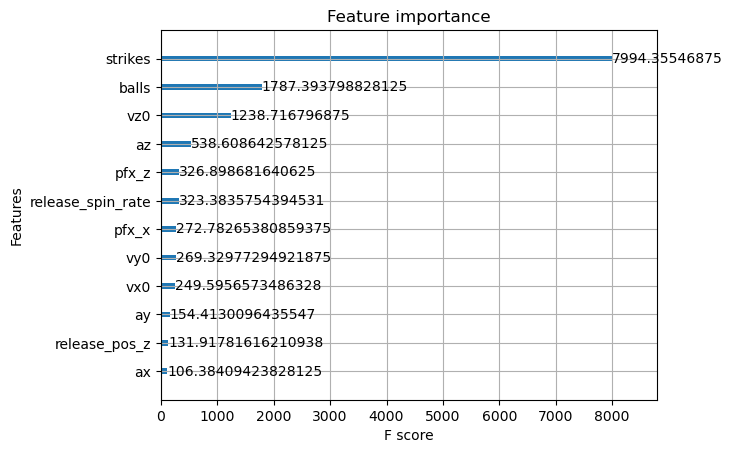

In [23]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

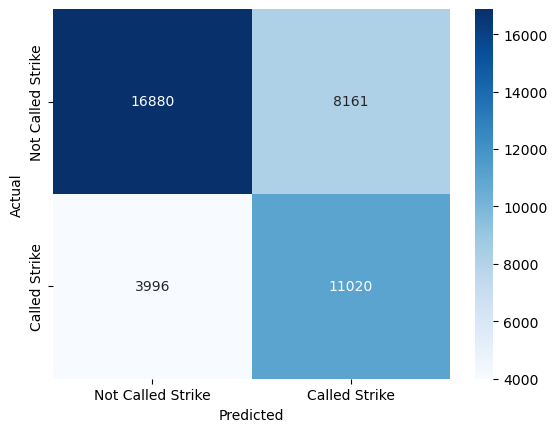

In [24]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [25]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [26]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [27]:
y_pred = final_model.predict(predictions)

In [32]:
testing_identifiers['xcs'] = y_pred

C:\Users\clayton\AppData\Local\Temp\ipykernel_6588\3630874201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xcs'] = y_pred


In [43]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/cs_2022&3_xcalledstrike.csv")